In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.4


# Case study: K2-24, putting it all together

In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

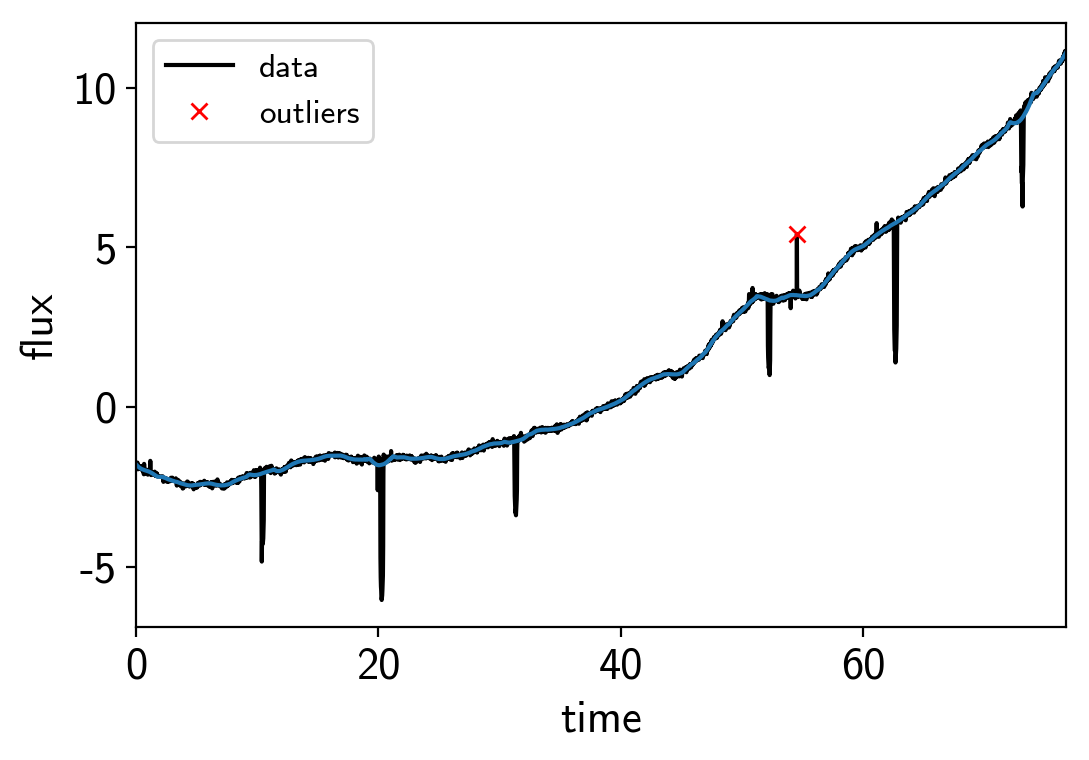

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

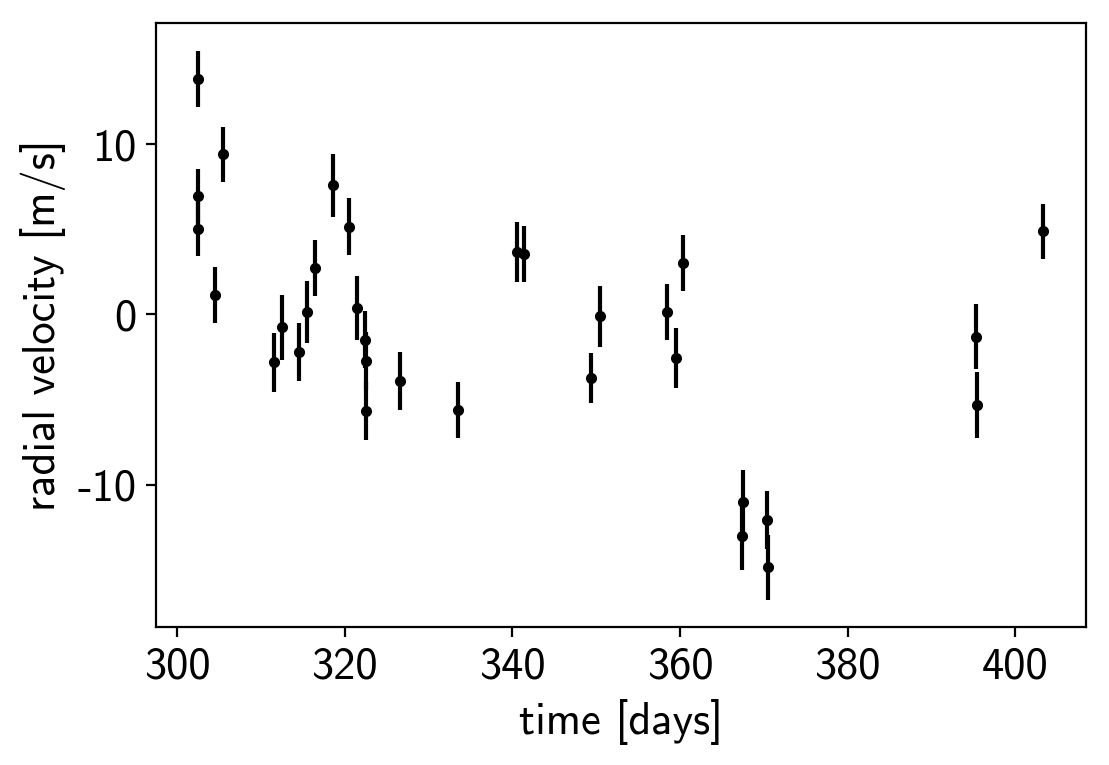

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

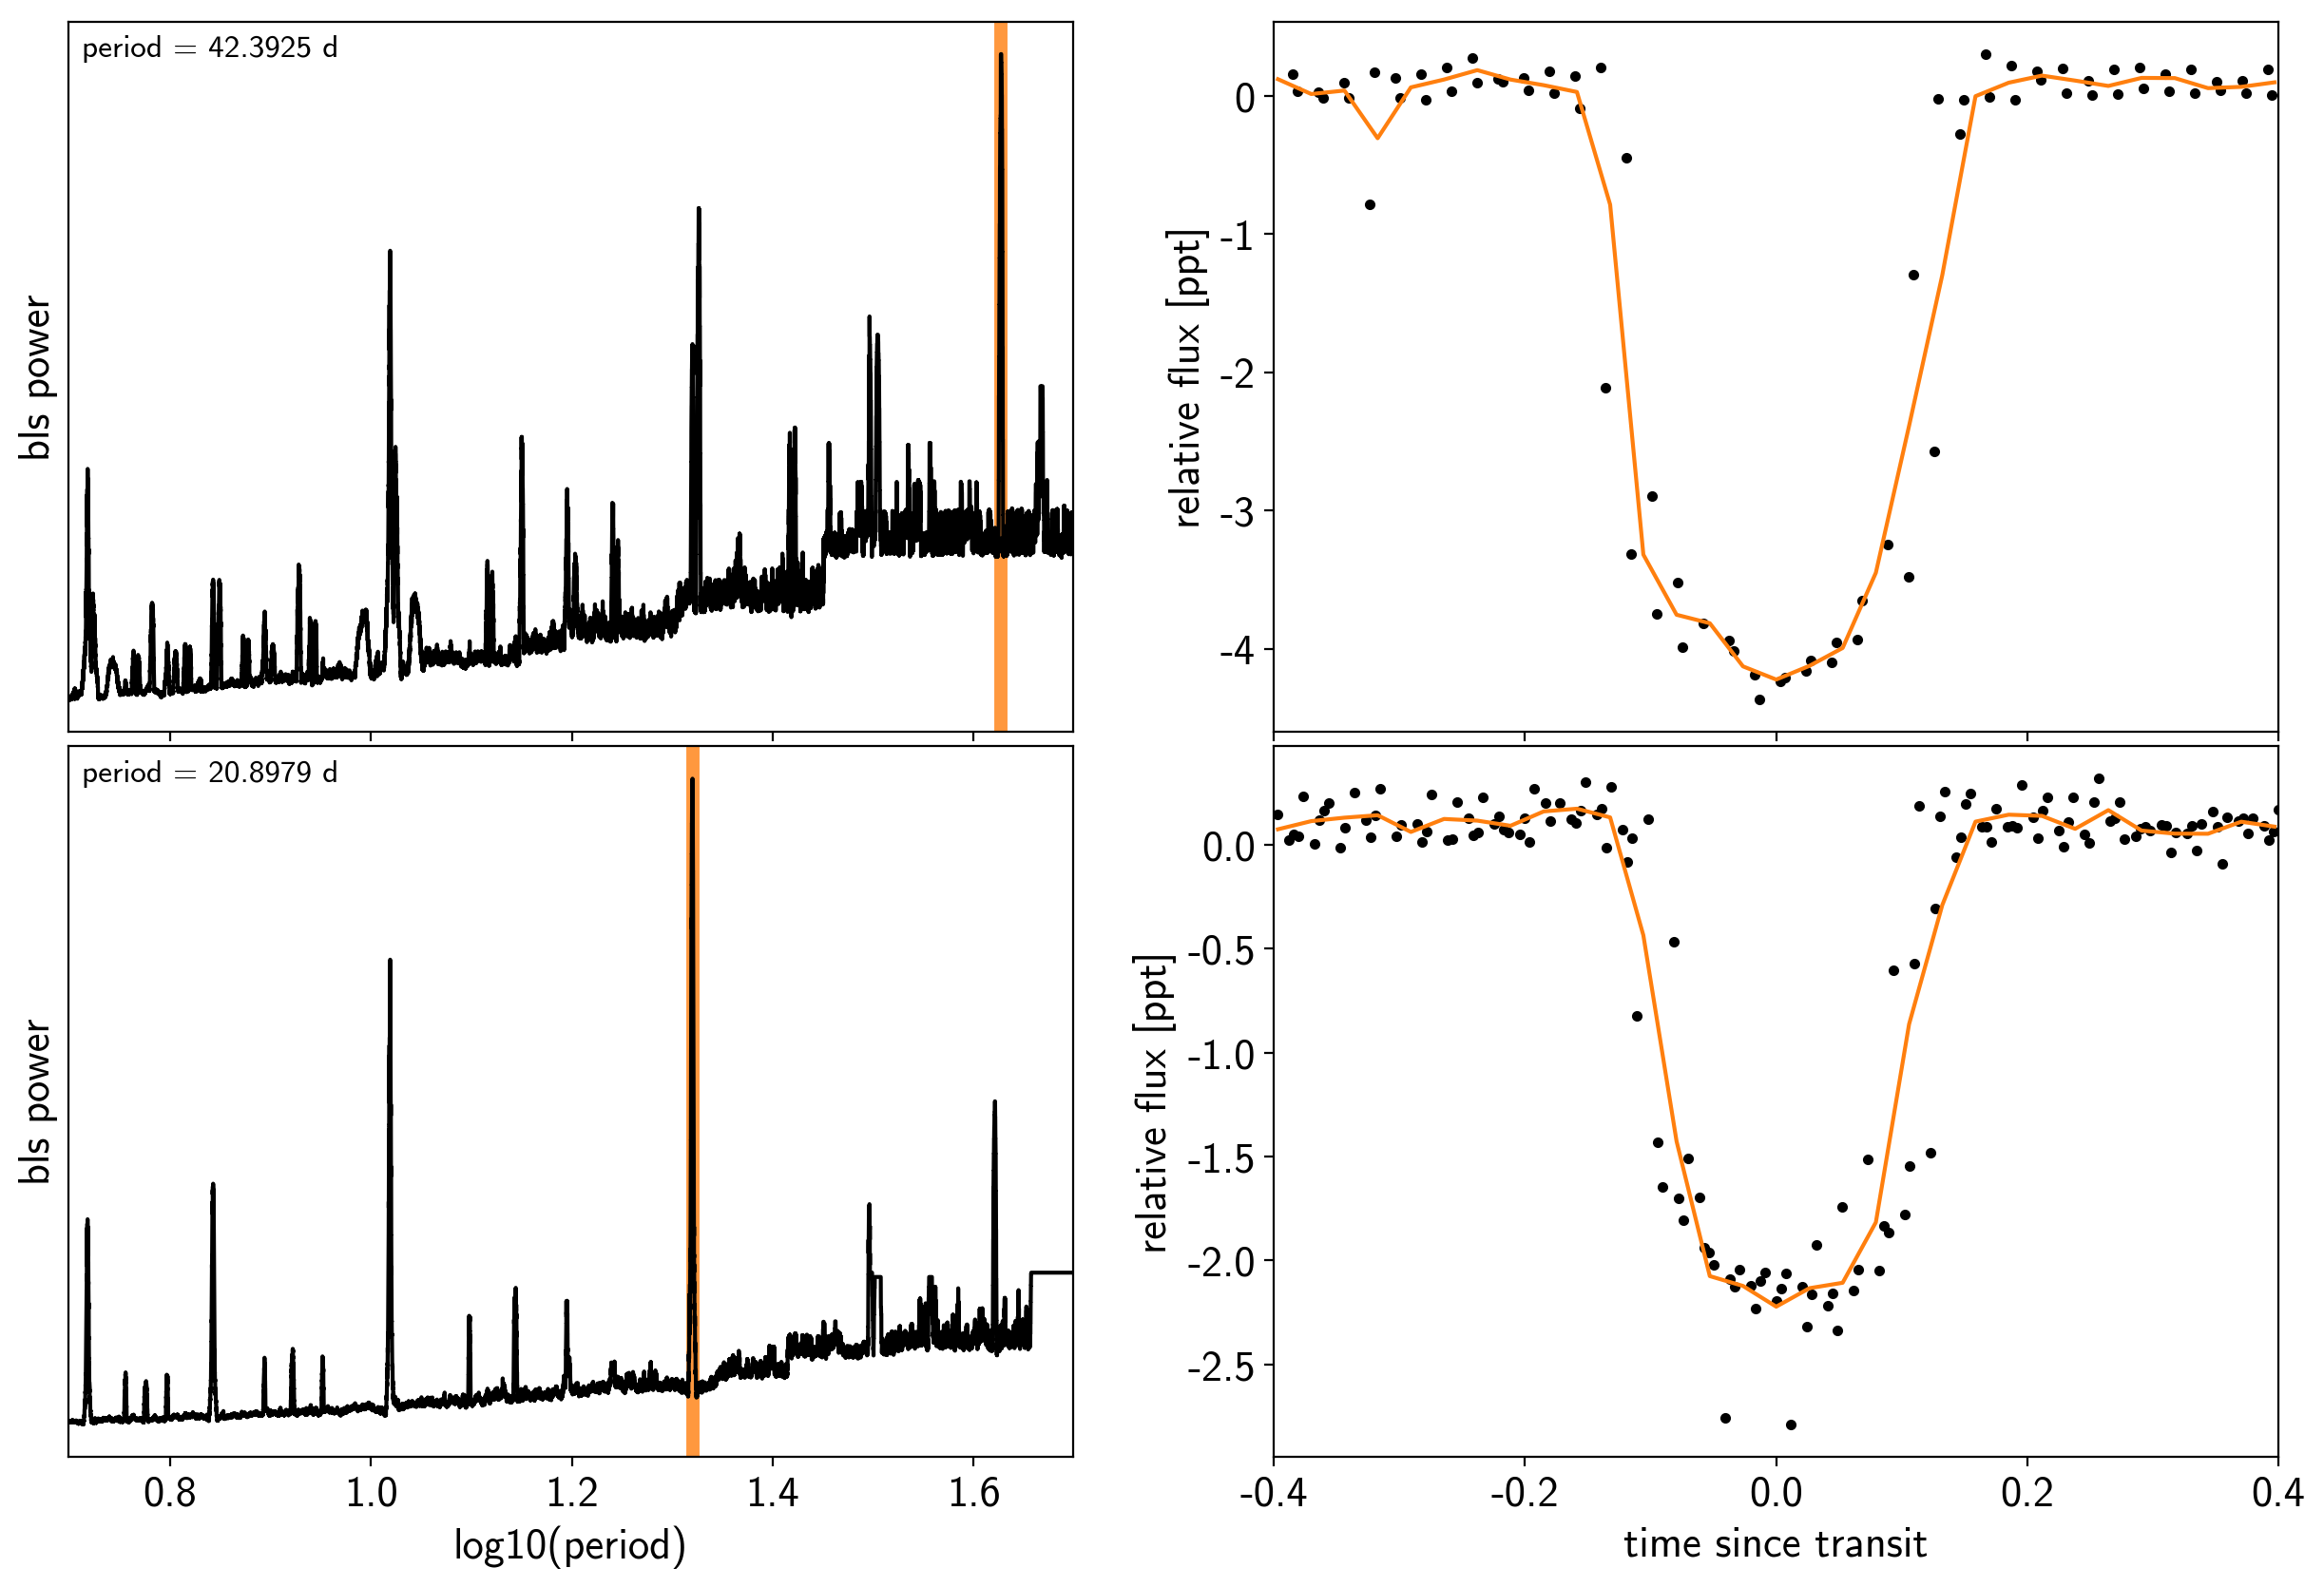

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        m_star = pm.Normal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = pm.Normal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5+np.zeros(2),
                       shape=2)
        ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                         testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        gp_period = 2*np.pi*tt.exp(-logw0)
        pm.Potential("baseline", -pm.math.logaddexp(0, (gp_period - (x[mask].max() - x[mask].min())) / 2.0))
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp, oversample=15)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

success: True
initial logp: -8218.552349406915
final logp: -8207.47029272302


success: True
initial logp: -8207.47029272302
final logp: 2258.942541972345


success: False
initial logp: 2258.942541972345
final logp: 2734.1663219704456


success: False
initial logp: 2734.1663219704456
final logp: 3460.7681611211146


success: True
initial logp: 3460.7681611211146
final logp: 4315.519860002447


success: False
initial logp: 4315.519860002447
final logp: 4385.818796325232


success: False
initial logp: 4385.818796325232
final logp: 4736.80568902522


success: False
initial logp: 4736.80568902522
final logp: 4736.80693182796


success: False
initial logp: 4736.80693182796
final logp: 4736.807131106106


Now let's plot the map radial velocity model.

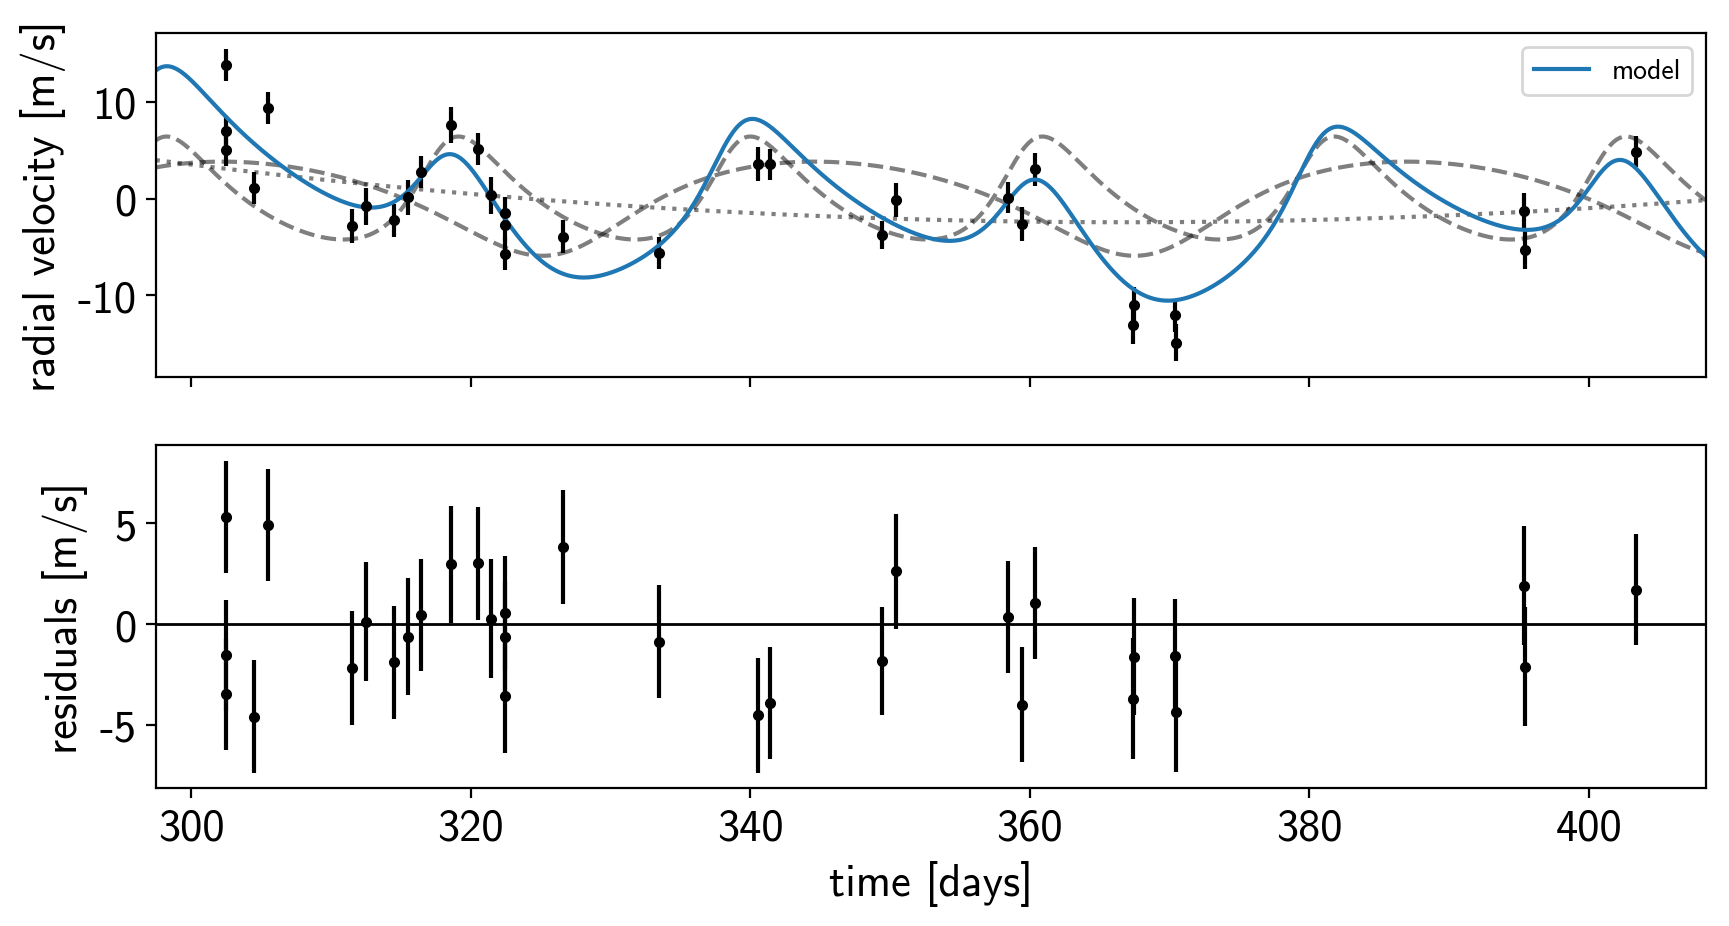

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

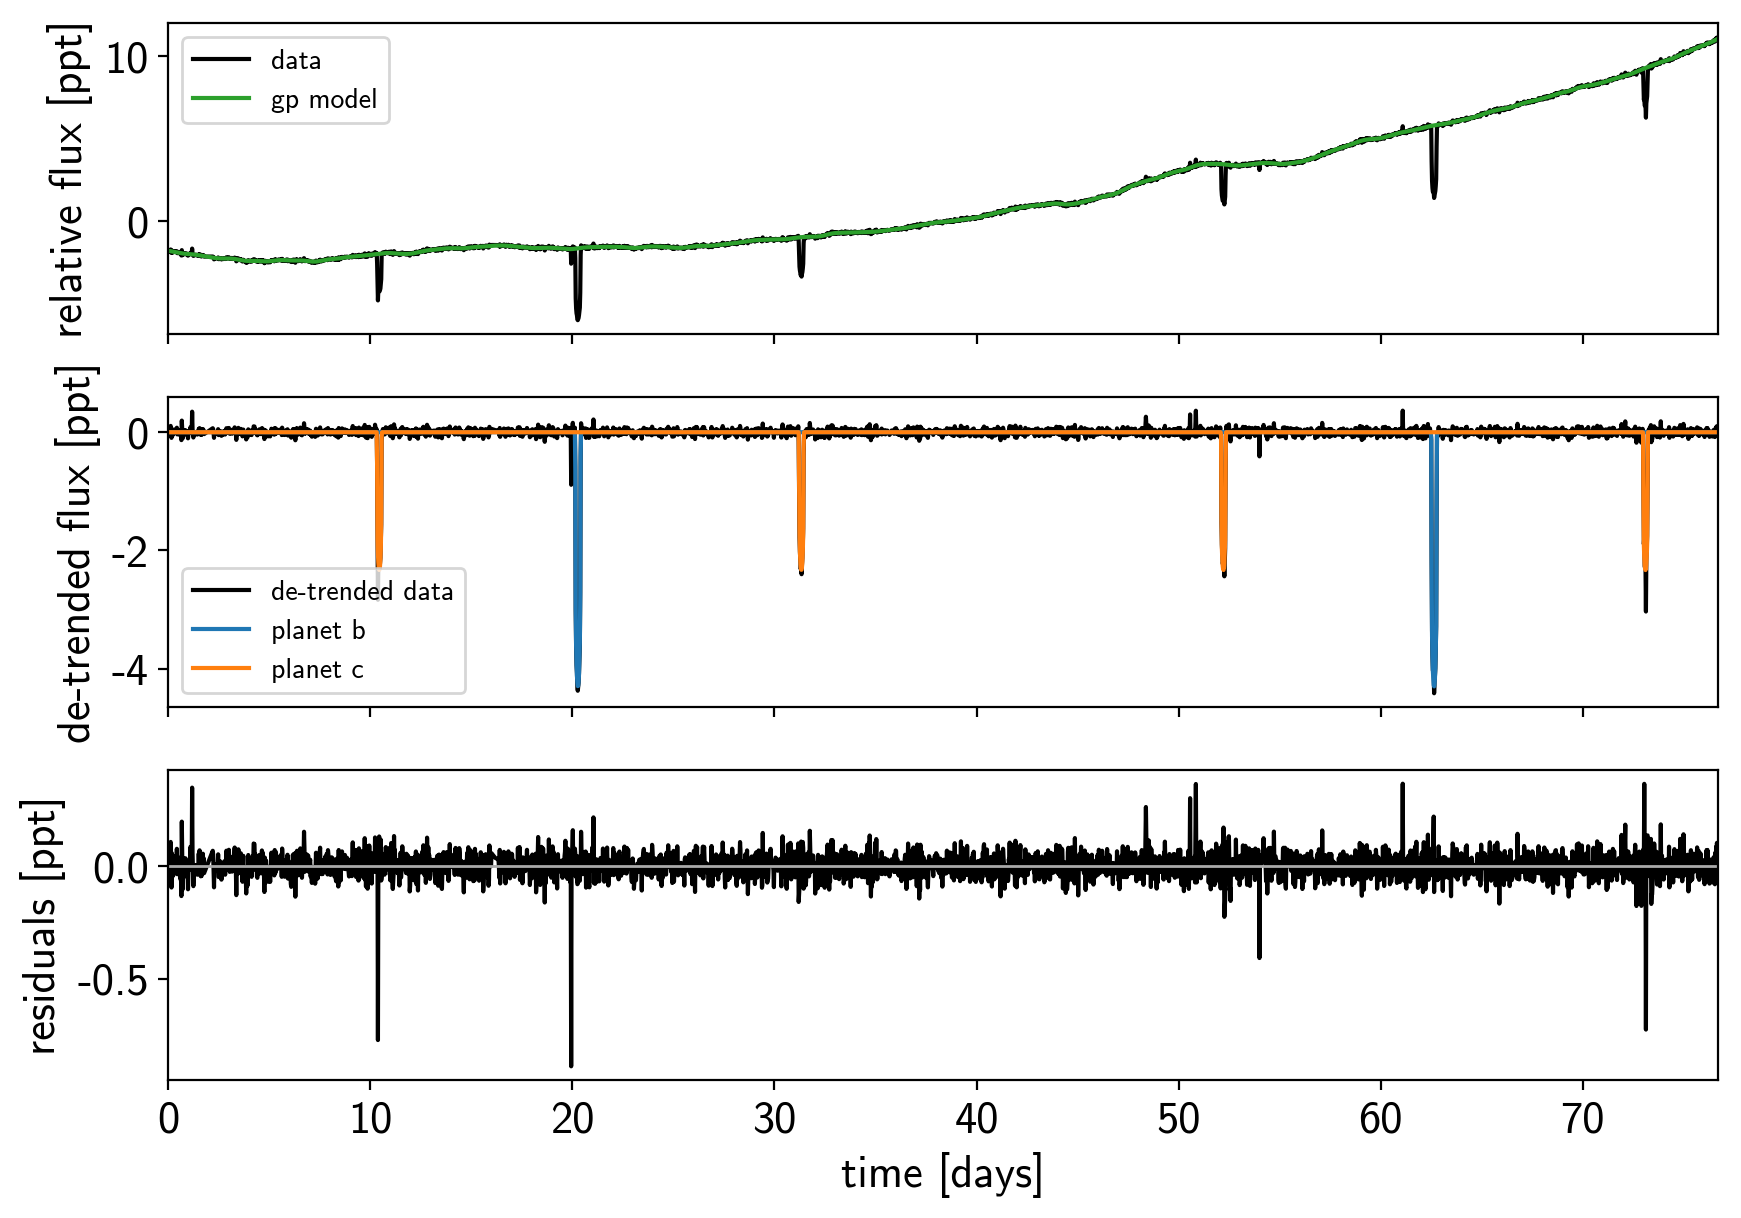

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

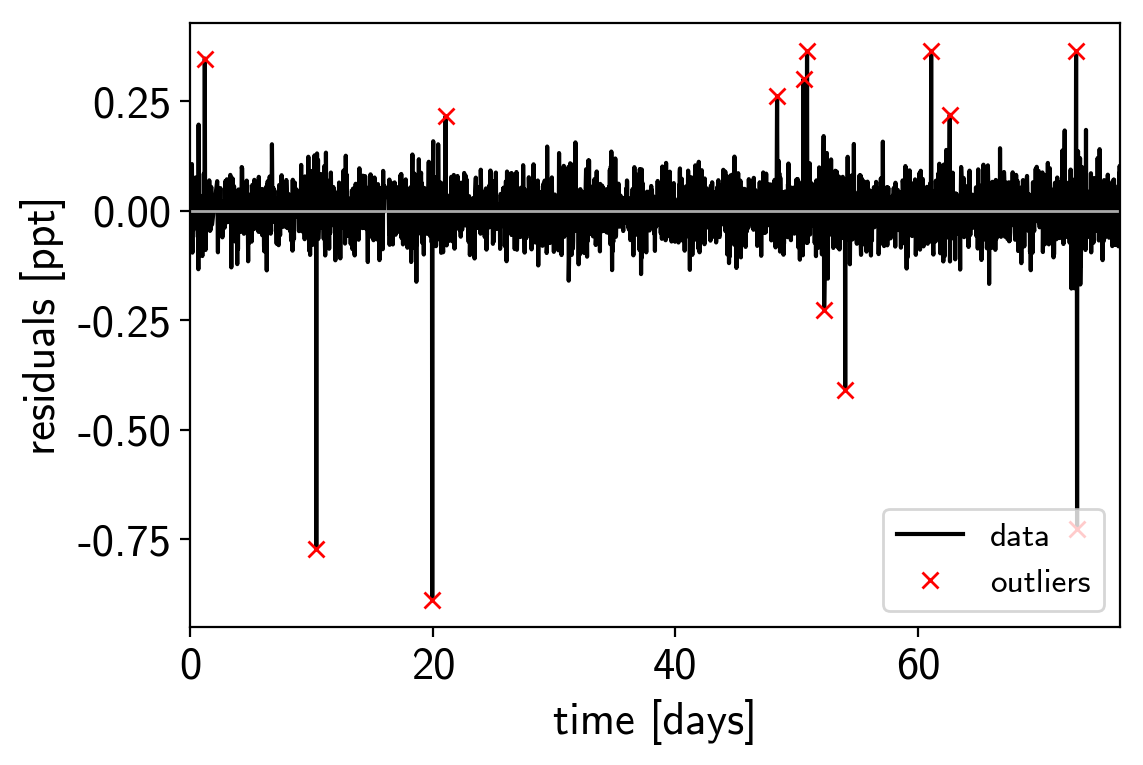

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

success: True
initial logp: 5187.023412762976
final logp: 5187.0234127629765


success: False
initial logp: 5187.0234127629765
final logp: 5269.214190600962


success: False
initial logp: 5269.214190600962
final logp: 5280.261770604212


success: False
initial logp: 5280.261770604212
final logp: 5281.676243576508


success: True
initial logp: 5281.676243576508
final logp: 5282.397598926635


success: True
initial logp: 5282.397598926635
final logp: 5282.414807940156


success: False
initial logp: 5282.414807940156
final logp: 5284.149895265921


success: False
initial logp: 5284.149895265921
final logp: 5284.149895657647


success: False
initial logp: 5284.149895657647
final logp: 5284.149895658077


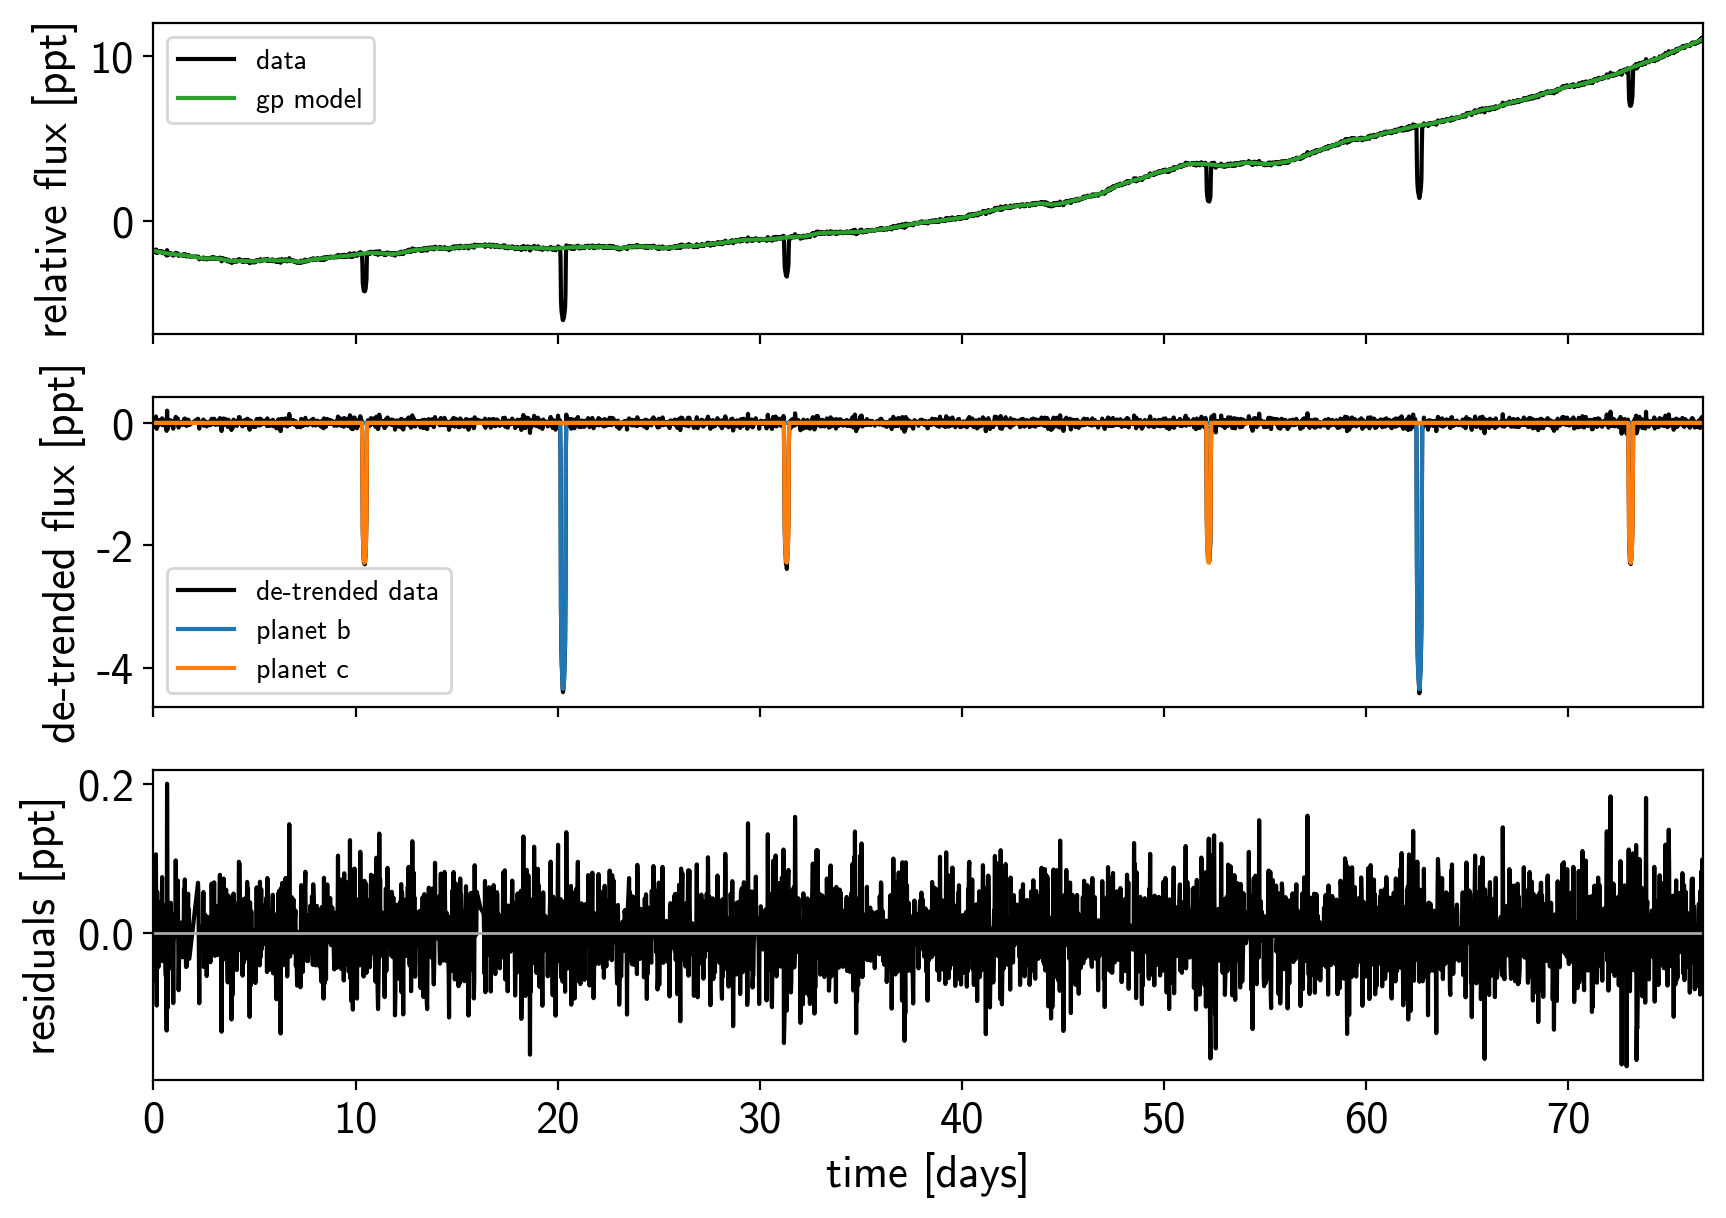

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=200, start=500, finish=500)
with model:
    burnin = sampler.tune(tune=4000, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 23/2008 [00:00<00:08, 224.76draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:01<02:24, 13.71draws/s] 

Sampling 4 chains:   2%|▏         | 35/2008 [00:02<03:18,  9.96draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:03<04:20,  7.56draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:04<05:28,  5.98draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:04<05:48,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:05<04:24,  7.41draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:05<06:52,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:06<07:12,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:06<05:26,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:07<07:32,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:08<07:36,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:08<05:48,  5.57draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:08<07:29,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:09<06:14,  5.19draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:09<06:37,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:09<05:40,  5.69draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:10<06:13,  5.18draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:10<05:29,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:11<06:03,  5.31draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:11<05:25,  5.93draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:11<05:05,  6.30draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:12<06:15,  5.13draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:12<05:45,  5.56draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:12<05:54,  5.42draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:13<06:45,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:13<06:28,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:13<06:14,  5.12draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:13<06:56,  4.60draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:14<06:36,  4.84draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:14<06:29,  4.92draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:14<06:46,  4.71draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:14<06:30,  4.89draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:15<06:28,  4.91draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:15<06:46,  4.69draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:15<06:30,  4.88draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:16<06:28,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:16<06:39,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:16<06:35,  4.81draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:16<06:24,  4.95draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:17<06:40,  4.74draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:17<06:40,  4.75draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:17<06:26,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:17<06:38,  4.76draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:17<05:36,  5.63draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:18<05:10,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:18<05:20,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:18<06:48,  4.63draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:18<06:07,  5.14draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:19<06:00,  5.24draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:19<07:13,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:19<06:30,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:20<05:36,  5.59draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:20<08:34,  3.66draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:20<07:00,  4.47draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:21<09:33,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:21<07:40,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:22<10:00,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:22<07:58,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:23<10:15,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:23<08:08,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:23<10:20,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:24<08:12,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:24<10:21,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:25<08:13,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:25<10:22,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:25<07:58,  3.88draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:25<07:02,  4.40draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:26<09:34,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:26<07:26,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:26<06:31,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:27<09:12,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:27<07:14,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:27<06:16,  4.90draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:27<09:03,  3.40draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:28<07:19,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:28<07:52,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:28<06:32,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:29<07:26,  4.12draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:29<06:05,  5.02draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:30<07:10,  4.26draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:30<05:53,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:31<07:02,  4.34draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:31<05:46,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:32<06:56,  4.39draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:32<05:22,  5.66draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:32<06:12,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:33<06:10,  4.91draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:34<06:08,  4.92draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:35<06:07,  4.93draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:35<04:41,  6.41draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:36<06:36,  4.55draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:37<06:50,  4.39draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:37<05:15,  5.71draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:37<06:55,  4.32draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:38<05:24,  5.53draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:38<06:50,  4.37draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:38<05:23,  5.53draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:39<06:45,  4.41draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:39<05:23,  5.52draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:40<09:03,  3.28draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:40<07:06,  4.19draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:40<06:55,  4.29draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:41<07:07,  4.17draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:41<06:06,  4.86draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:41<06:10,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:41<06:32,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:42<05:51,  5.06draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:42<05:55,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:42<06:20,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:42<05:51,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:43<05:05,  5.79draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:43<06:06,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:43<06:25,  4.59draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:43<06:05,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:43<05:25,  5.43draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:44<06:01,  4.88draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:44<06:22,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:44<06:10,  4.76draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:44<05:25,  5.42draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:44<05:56,  4.94draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:45<06:17,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:45<06:15,  4.69draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [00:45<05:45,  5.10draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:45<05:47,  5.05draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:45<06:08,  4.76draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:46<05:38,  5.18draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:46<06:12,  4.72draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:46<05:45,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:46<06:04,  4.81draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:46<05:45,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:47<06:12,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:47<05:42,  5.12draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:47<05:59,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:47<05:51,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:48<06:28,  4.49draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:48<05:32,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:48<05:52,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:48<05:55,  4.91draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:48<06:42,  4.33draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:49<06:00,  4.83draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:49<06:26,  4.50draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:49<06:44,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:50<05:58,  4.85draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:50<06:37,  4.37draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:50<07:03,  4.10draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:50<05:59,  4.83draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:51<06:48,  4.24draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:51<07:07,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:51<05:58,  4.82draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:51<06:56,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:52<07:08,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:52<05:56,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:52<07:17,  3.94draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:53<07:06,  4.04draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:53<05:51,  4.89draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:53<07:23,  3.88draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:53<07:01,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:54<05:47,  4.94draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:54<07:31,  3.80draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:54<06:58,  4.10draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:54<05:43,  4.98draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:55<07:38,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:55<06:54,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:55<05:39,  5.03draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:56<07:59,  3.56draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:56<06:47,  4.19draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [00:56<05:33,  5.11draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:56<08:04,  3.52draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:57<06:43,  4.22draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:57<05:30,  5.15draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:57<08:09,  3.47draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:57<06:38,  4.26draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:58<05:25,  5.21draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:58<08:17,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [00:58<06:26,  4.38draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:58<05:31,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:59<08:29,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:59<06:33,  4.29draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [00:59<05:30,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [01:00<08:38,  3.25draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [01:00<06:38,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [01:01<07:30,  3.74draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [01:01<05:49,  4.82draws/s]

Sampling 4 chains:  16%|█▋        | 328/2008 [01:01<06:56,  4.03draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [01:01<05:24,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [01:02<06:40,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [01:02<05:11,  5.38draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [01:03<06:32,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [01:03<05:03,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [01:04<06:25,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [01:04<04:59,  5.55draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [01:05<06:21,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [01:05<04:58,  5.57draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [01:05<06:17,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [01:06<04:58,  5.56draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [01:06<06:14,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [01:06<05:02,  5.48draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [01:07<06:11,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [01:07<05:04,  5.41draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [01:08<06:07,  4.49draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:08<05:13,  5.26draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [01:09<05:32,  4.94draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:09<05:00,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [01:09<05:19,  5.13draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:10<05:11,  5.26draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [01:10<05:20,  5.10draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [01:10<05:22,  5.07draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [01:11<05:24,  5.03draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [01:11<05:23,  5.05draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [01:12<05:24,  5.01draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [01:12<05:22,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [01:13<05:24,  5.00draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:13<05:21,  5.05draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [01:13<04:10,  6.48draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [01:13<07:03,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:14<06:26,  4.18draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:14<05:00,  5.38draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [01:14<07:30,  3.59draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:14<06:44,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:15<05:17,  5.08draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [01:15<07:33,  3.55draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:15<06:46,  3.97draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [01:15<05:29,  4.88draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [01:16<07:20,  3.65draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:16<06:35,  4.07draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:16<05:33,  4.81draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [01:17<07:00,  3.82draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [01:17<06:19,  4.23draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [01:17<05:18,  5.03draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:17<04:46,  5.59draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [01:18<06:25,  4.15draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:18<06:10,  4.31draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:18<05:09,  5.15draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [01:18<06:40,  3.98draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:19<06:29,  4.10draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:19<05:18,  5.00draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [01:19<06:46,  3.92draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:19<06:40,  3.97draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:20<05:22,  4.92draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [01:20<06:48,  3.89draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:20<06:49,  3.87draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:20<05:25,  4.87draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [01:21<06:48,  3.87draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:21<07:08,  3.69draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:21<05:29,  4.80draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [01:22<06:51,  3.84draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:22<07:17,  3.61draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [01:22<05:31,  4.75draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [01:22<06:52,  3.82draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:23<07:25,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [01:23<06:25,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:24<07:16,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [01:24<06:16,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:24<07:16,  3.59draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [01:25<06:13,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:25<07:35,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [01:26<06:19,  4.11draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:26<07:45,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [01:26<06:24,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:27<07:49,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [01:27<06:26,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:28<07:49,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [01:28<06:26,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [01:28<07:49,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [01:29<05:52,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [01:29<06:13,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [01:29<07:38,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:29<05:47,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:30<06:05,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:30<07:32,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:30<06:12,  4.12draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [01:30<05:20,  4.79draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:31<06:59,  3.66draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:31<05:54,  4.33draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [01:31<05:05,  5.02draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:32<06:47,  3.76draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:32<05:49,  4.38draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [01:32<05:00,  5.08draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:32<06:42,  3.79draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:33<05:51,  4.34draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [01:33<04:59,  5.09draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:33<06:40,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:33<05:54,  4.30draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [01:34<04:59,  5.08draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:34<06:39,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [01:34<05:57,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [01:34<05:02,  5.01draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:35<06:34,  3.84draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [01:35<05:57,  4.23draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:35<04:57,  5.08draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [01:35<04:29,  5.60draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:36<06:04,  4.14draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [01:36<05:39,  4.45draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [01:36<04:48,  5.23draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:36<04:15,  5.90draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:37<05:53,  4.26draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:37<05:35,  4.49draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:37<04:50,  5.19draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:37<04:09,  6.04draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:37<05:47,  4.32draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [01:38<05:35,  4.47draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:38<04:53,  5.11draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:38<05:10,  4.83draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [01:38<05:14,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:38<04:42,  5.29draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:39<04:58,  5.01draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [01:39<05:09,  4.82draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:39<04:56,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:40<04:56,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [01:40<05:13,  4.75draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [01:40<05:02,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:41<04:55,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [01:41<05:18,  4.67draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:41<05:03,  4.89draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:41<04:54,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [01:42<05:22,  4.59draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:42<05:02,  4.89draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:42<04:53,  5.05draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [01:42<05:26,  4.53draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:43<05:01,  4.90draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:43<04:51,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [01:43<05:29,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:43<04:59,  4.91draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [01:44<04:49,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [01:44<05:32,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:44<04:58,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [01:45<04:48,  5.08draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [01:45<05:34,  4.39draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:45<04:57,  4.93draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [01:45<04:14,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [01:45<04:49,  5.06draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [01:46<05:38,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [01:46<04:56,  4.93draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:46<04:36,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [01:46<04:40,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:46<05:36,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [01:47<04:51,  5.00draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:47<04:40,  5.19draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [01:47<04:35,  5.29draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [01:47<05:38,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [01:47<04:46,  5.08draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [01:48<04:44,  5.10draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:48<04:29,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [01:48<05:39,  4.27draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [01:48<04:42,  5.14draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:48<04:49,  5.01draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:49<04:23,  5.49draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:49<05:40,  4.25draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:49<05:07,  4.69draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:49<04:27,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [01:50<05:47,  4.15draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:50<05:14,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [01:51<05:24,  4.44draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:51<05:07,  4.67draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [01:51<05:09,  4.63draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [01:52<04:58,  4.79draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:52<05:00,  4.75draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:53<04:54,  4.84draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:53<04:55,  4.82draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [01:53<04:50,  4.91draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:54<04:53,  4.85draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [01:54<04:45,  4.97draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [01:55<04:52,  4.85draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:55<04:42,  5.01draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:55<04:52,  4.83draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [01:56<04:39,  5.05draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [01:56<04:00,  5.86draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:56<05:18,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:57<04:54,  4.78draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [01:57<04:20,  5.41draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:57<05:25,  4.32draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:57<04:57,  4.71draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [01:58<04:31,  5.17draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:58<05:25,  4.31draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:58<04:57,  4.71draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [01:58<04:48,  4.84draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [01:59<05:18,  4.39draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:59<04:52,  4.77draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [01:59<04:53,  4.76draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:59<05:13,  4.45draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [02:00<04:48,  4.82draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [02:00<04:58,  4.67draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [02:00<05:08,  4.51draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [02:01<04:45,  4.87draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [02:01<05:03,  4.57draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [02:01<05:03,  4.56draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [02:01<04:41,  4.91draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [02:02<05:20,  4.32draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [02:02<04:58,  4.63draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [02:02<04:36,  5.00draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [02:03<05:32,  4.15draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [02:03<04:52,  4.72draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [02:03<04:30,  5.08draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [02:03<05:31,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [02:04<04:49,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [02:04<04:27,  5.12draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [02:04<05:30,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [02:04<04:47,  4.77draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [02:05<04:26,  5.14draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [02:05<05:30,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [02:05<04:47,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [02:05<04:25,  5.14draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [02:06<05:30,  4.13draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [02:06<04:46,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [02:06<04:01,  5.64draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [02:06<04:15,  5.31draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [02:07<05:24,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [02:07<04:41,  4.83draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [02:07<04:01,  5.63draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [02:07<04:11,  5.39draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [02:07<05:22,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [02:08<04:39,  4.85draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [02:08<04:02,  5.57draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [02:08<04:08,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [02:08<05:22,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [02:08<04:37,  4.87draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [02:08<04:04,  5.51draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [02:09<04:05,  5.49draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [02:09<05:21,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [02:09<04:35,  4.89draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [02:09<04:07,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [02:09<04:02,  5.55draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [02:10<05:19,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [02:10<04:33,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [02:10<04:09,  5.38draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [02:10<03:59,  5.61draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [02:11<05:19,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [02:11<04:31,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [02:11<04:12,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [02:11<03:56,  5.65draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [02:11<05:18,  4.20draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [02:12<04:29,  4.94draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [02:12<04:14,  5.23draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [02:12<03:53,  5.70draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [02:12<05:17,  4.20draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [02:12<04:27,  4.96draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [02:13<04:17,  5.17draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [02:13<03:52,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [02:13<05:15,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [02:13<04:26,  4.98draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [02:13<04:19,  5.10draws/s]

Sampling 4 chains:  34%|███▍      | 684/2008 [02:13<03:49,  5.77draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [02:14<05:13,  4.22draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [02:14<04:24,  5.00draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [02:14<04:22,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 688/2008 [02:14<03:46,  5.83draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [02:15<05:12,  4.23draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [02:15<04:22,  5.01draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [02:15<04:24,  4.98draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [02:15<04:41,  4.68draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [02:16<04:00,  5.46draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [02:16<04:13,  5.19draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [02:16<04:30,  4.84draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [02:16<03:53,  5.62draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [02:17<04:11,  5.21draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [02:17<04:27,  4.88draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [02:17<03:50,  5.67draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [02:17<04:13,  5.15draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [02:18<04:26,  4.88draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [02:18<03:50,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 707/2008 [02:18<04:15,  5.10draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [02:19<04:26,  4.88draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [02:19<03:49,  5.65draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [02:19<04:18,  5.02draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [02:19<04:26,  4.85draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [02:20<03:49,  5.65draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [02:20<04:21,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [02:20<04:26,  4.84draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [02:20<03:48,  5.64draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [02:21<04:25,  4.86draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [02:21<04:27,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [02:21<03:48,  5.63draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [02:21<04:29,  4.77draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [02:22<04:27,  4.79draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [02:22<03:48,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [02:22<04:32,  4.70draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [02:23<04:28,  4.77draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [02:23<03:48,  5.60draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [02:23<04:31,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [02:24<04:27,  4.76draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [02:24<03:47,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [02:24<04:30,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [02:24<04:27,  4.76draws/s]

Sampling 4 chains:  37%|███▋      | 738/2008 [02:24<03:45,  5.63draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [02:25<04:28,  4.73draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [02:25<04:25,  4.77draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [02:25<03:44,  5.64draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [02:26<04:26,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [02:26<04:24,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [02:26<03:43,  5.65draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [02:26<04:24,  4.76draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [02:26<03:44,  5.60draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [02:27<04:56,  4.25draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [02:27<04:28,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [02:27<03:52,  5.41draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [02:28<04:59,  4.19draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [02:28<04:29,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [02:28<03:56,  5.30draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [02:28<04:58,  4.19draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [02:29<04:28,  4.65draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [02:29<04:06,  5.06draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [02:29<04:55,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [02:30<04:25,  4.69draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [02:30<04:06,  5.05draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [02:30<04:54,  4.23draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [02:30<04:24,  4.70draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [02:31<04:09,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [02:31<04:51,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [02:31<04:22,  4.71draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [02:31<04:12,  4.90draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [02:32<04:49,  4.27draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [02:32<04:20,  4.74draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [02:32<04:12,  4.89draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [02:32<04:46,  4.29draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [02:33<04:18,  4.76draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [02:33<04:13,  4.85draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [02:33<04:44,  4.31draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [02:34<04:16,  4.78draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [02:34<04:15,  4.80draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [02:34<05:03,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [02:34<05:05,  4.01draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [02:35<04:51,  4.19draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [02:35<06:03,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [02:35<05:23,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [02:35<05:10,  3.92draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [02:36<05:57,  3.41draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [02:36<05:22,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [02:36<05:11,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [02:36<05:14,  3.86draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [02:37<04:16,  4.72draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [02:37<04:13,  4.77draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [02:37<04:26,  4.55draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [02:37<05:14,  3.85draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [02:38<04:56,  4.08draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [02:38<04:59,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [02:39<08:27,  2.38draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [02:40<12:06,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [02:41<13:48,  1.45draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [02:41<11:06,  1.81draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [02:42<14:22,  1.39draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [02:43<15:55,  1.26draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [02:44<16:28,  1.21draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [02:44<13:06,  1.53draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [02:45<15:53,  1.26draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [02:46<16:40,  1.20draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [02:47<17:00,  1.17draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [02:47<13:45,  1.45draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [02:48<16:19,  1.22draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [02:49<16:41,  1.19draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [02:50<17:02,  1.17draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [02:51<13:56,  1.43draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [02:52<16:33,  1.20draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [02:53<16:33,  1.20draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [02:53<16:54,  1.17draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [02:54<13:58,  1.42draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [02:55<16:40,  1.19draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [02:56<16:24,  1.20draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [02:57<16:43,  1.18draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [02:57<13:58,  1.41draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [02:58<16:46,  1.18draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [02:59<16:15,  1.21draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [03:00<16:31,  1.19draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [03:00<13:59,  1.41draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [03:01<16:54,  1.16draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [03:02<16:06,  1.22draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [03:03<16:21,  1.20draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [03:04<13:58,  1.40draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [03:05<17:01,  1.15draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [03:05<15:56,  1.23draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [03:06<16:12,  1.21draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [03:07<13:58,  1.40draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [03:08<17:07,  1.14draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [03:09<15:46,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [03:09<16:02,  1.22draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [03:10<13:57,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [03:11<17:16,  1.13draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [03:12<15:37,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [03:13<15:52,  1.22draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [03:13<13:57,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [03:15<17:21,  1.12draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [03:15<15:28,  1.25draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [03:16<15:42,  1.23draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [03:16<13:58,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [03:18<17:27,  1.11draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [03:18<15:18,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [03:19<15:33,  1.24draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [03:20<13:59,  1.38draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [03:21<17:33,  1.10draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [03:22<15:07,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [03:22<15:23,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [03:23<13:59,  1.37draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [03:24<17:40,  1.09draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [03:25<14:57,  1.28draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [03:26<15:15,  1.26draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [03:26<14:00,  1.37draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [03:28<17:47,  1.07draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [03:28<14:49,  1.29draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [03:29<15:04,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [03:29<14:00,  1.36draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [03:31<17:52,  1.07draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [03:31<14:41,  1.30draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [03:32<14:52,  1.28draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [03:33<14:00,  1.36draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [03:34<17:57,  1.06draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [03:34<14:31,  1.31draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [03:35<14:43,  1.29draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [03:36<14:02,  1.35draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [03:37<18:01,  1.05draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [03:38<14:22,  1.31draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [03:38<14:33,  1.30draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [03:39<14:03,  1.34draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [03:41<18:05,  1.04draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [03:41<14:13,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [03:42<14:24,  1.31draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [03:42<14:05,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [03:44<18:08,  1.04draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [03:44<14:04,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [03:45<14:14,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [03:46<14:06,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [03:47<18:14,  1.03draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [03:47<13:54,  1.34draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [03:48<14:05,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [03:49<14:12,  1.31draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [03:50<18:20,  1.02draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [03:50<13:43,  1.36draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [03:51<13:58,  1.33draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [03:52<14:14,  1.31draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [03:54<18:22,  1.01draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [03:54<13:33,  1.37draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [03:54<13:48,  1.34draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [03:55<14:16,  1.30draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [03:57<18:24,  1.01draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [03:57<13:29,  1.37draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [03:58<13:37,  1.36draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [03:59<14:16,  1.29draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [04:00<18:26,  1.00draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [04:01<15:10,  1.21draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [04:02<15:27,  1.19draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [04:03<19:20,  1.05s/draws]

Sampling 4 chains:  45%|████▌     | 907/2008 [04:04<15:41,  1.17draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [04:05<15:55,  1.15draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [04:07<19:41,  1.08s/draws]

Sampling 4 chains:  45%|████▌     | 911/2008 [04:07<15:49,  1.15draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [04:08<16:10,  1.13draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [04:10<19:42,  1.08s/draws]

Sampling 4 chains:  46%|████▌     | 915/2008 [04:11<15:48,  1.15draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [04:12<16:18,  1.12draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [04:13<19:37,  1.08s/draws]

Sampling 4 chains:  46%|████▌     | 919/2008 [04:14<15:44,  1.15draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [04:15<16:23,  1.11draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [04:16<19:31,  1.08s/draws]

Sampling 4 chains:  46%|████▌     | 923/2008 [04:17<15:38,  1.16draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [04:18<16:28,  1.10draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [04:19<19:25,  1.08s/draws]

Sampling 4 chains:  46%|████▌     | 926/2008 [04:20<14:18,  1.26draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [04:20<13:13,  1.36draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [04:21<14:55,  1.21draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [04:23<18:10,  1.01s/draws]

Sampling 4 chains:  46%|████▋     | 930/2008 [04:23<13:37,  1.32draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [04:23<12:32,  1.43draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [04:24<14:33,  1.23draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [04:26<17:46,  1.01draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [04:26<13:30,  1.33draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [04:27<12:15,  1.46draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [04:28<14:28,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [04:29<17:37,  1.01draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [04:29<13:32,  1.32draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [04:30<12:02,  1.48draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [04:31<14:27,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [04:32<17:28,  1.02draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [04:33<13:36,  1.31draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [04:33<11:50,  1.50draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [04:34<14:27,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [04:36<17:20,  1.02draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [04:36<13:42,  1.29draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [04:36<11:37,  1.52draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [04:37<14:27,  1.22draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [04:39<17:19,  1.02draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [04:39<14:21,  1.23draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [04:39<11:19,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [04:41<14:23,  1.22draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [04:42<17:05,  1.03draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [04:42<14:19,  1.23draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [04:43<11:06,  1.58draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [04:44<14:19,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [04:45<16:54,  1.04draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [04:46<14:23,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [04:46<10:56,  1.60draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [04:47<14:19,  1.22draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [04:48<16:44,  1.04draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [04:49<14:27,  1.21draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [04:49<10:47,  1.61draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [04:50<14:19,  1.21draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [04:52<16:34,  1.05draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [04:52<14:33,  1.19draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [04:54<13:49,  1.25draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [04:55<16:05,  1.08draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [04:55<14:25,  1.20draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [04:57<13:40,  1.26draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [04:58<15:52,  1.09draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [04:59<14:27,  1.19draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [05:00<13:37,  1.26draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [05:01<15:43,  1.09draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [05:02<14:19,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [05:03<13:34,  1.26draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [05:05<15:33,  1.10draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [05:05<14:11,  1.21draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [05:07<13:31,  1.26draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [05:08<15:22,  1.11draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [05:08<14:02,  1.21draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [05:09<10:30,  1.62draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [05:10<13:59,  1.21draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [05:11<15:33,  1.09draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [05:12<14:08,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [05:12<10:49,  1.57draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [05:13<14:04,  1.20draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [05:14<15:28,  1.09draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [05:15<14:02,  1.20draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [05:15<10:59,  1.54draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [05:16<14:03,  1.20draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [05:17<15:21,  1.10draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [05:18<13:52,  1.21draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [05:18<11:09,  1.51draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [05:20<14:00,  1.20draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [05:21<15:12,  1.10draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [05:21<13:45,  1.22draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [05:22<11:17,  1.48draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [05:23<13:56,  1.20draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [05:24<15:02,  1.11draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [05:24<13:39,  1.22draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [05:25<11:24,  1.46draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [05:26<13:54,  1.20draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [05:27<14:52,  1.12draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [05:28<13:32,  1.23draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [05:28<11:34,  1.44draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [05:29<13:50,  1.20draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [05:30<14:42,  1.13draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [05:31<13:25,  1.23draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [05:31<11:42,  1.41draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [05:32<13:46,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [05:33<14:32,  1.14draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [05:34<13:15,  1.24draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [05:35<11:49,  1.39draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [05:36<13:43,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [05:37<14:22,  1.14draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [05:37<13:09,  1.25draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [05:38<11:57,  1.37draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [05:39<13:40,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [05:40<14:12,  1.15draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [05:41<13:01,  1.26draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [05:41<12:05,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [05:42<13:35,  1.20draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [05:43<14:02,  1.16draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [05:44<12:54,  1.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [05:44<12:11,  1.33draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [05:45<13:30,  1.20draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [05:46<13:53,  1.17draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [05:47<12:47,  1.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [05:48<12:17,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [05:49<13:27,  1.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [05:50<13:45,  1.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [05:50<12:16,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [05:52<12:54,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [05:53<13:15,  1.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [05:53<12:07,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [05:55<12:43,  1.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [05:56<13:01,  1.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [05:57<12:05,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [05:58<12:39,  1.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [05:59<12:52,  1.24draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [06:00<11:59,  1.33draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [06:02<12:35,  1.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [06:02<12:45,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [06:03<11:53,  1.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [06:05<12:32,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [06:06<12:36,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [06:06<11:47,  1.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [06:06<08:54,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [06:08<14:06,  1.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [06:09<13:34,  1.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [06:09<12:28,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [06:10<09:35,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [06:11<14:26,  1.09draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [06:12<13:40,  1.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [06:13<12:31,  1.25draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [06:13<09:51,  1.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [06:15<14:28,  1.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [06:15<13:35,  1.15draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [06:16<12:26,  1.26draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [06:16<10:01,  1.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [06:18<14:25,  1.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [06:18<13:28,  1.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [06:19<12:19,  1.26draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [06:19<10:08,  1.53draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [06:21<14:22,  1.08draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [06:22<13:20,  1.16draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [06:22<12:10,  1.27draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [06:23<10:15,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [06:24<14:20,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [06:25<13:10,  1.17draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [06:26<12:03,  1.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [06:26<10:21,  1.49draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [06:27<14:17,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [06:28<13:01,  1.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [06:29<11:56,  1.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [06:29<10:30,  1.46draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [06:31<14:13,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [06:31<12:51,  1.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [06:32<11:49,  1.29draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [06:32<10:37,  1.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [06:34<14:09,  1.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [06:35<12:42,  1.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [06:35<11:43,  1.30draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [06:36<10:44,  1.42draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [06:37<14:06,  1.08draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [06:38<12:33,  1.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [06:38<11:34,  1.31draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [06:39<10:52,  1.39draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [06:40<14:02,  1.08draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [06:41<12:23,  1.22draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [06:42<11:28,  1.32draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [06:42<11:14,  1.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [06:44<13:57,  1.08draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [06:44<12:14,  1.23draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [06:45<11:28,  1.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [06:46<11:18,  1.33draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [06:47<13:48,  1.09draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [06:47<12:01,  1.25draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [06:48<11:21,  1.32draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [06:49<11:22,  1.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [06:50<13:44,  1.09draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [06:51<11:50,  1.26draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [06:51<11:16,  1.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [06:52<11:27,  1.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [06:53<13:39,  1.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [06:54<11:41,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [06:55<11:11,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [06:55<11:31,  1.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [06:57<13:34,  1.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [06:57<11:33,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [06:58<11:06,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [06:59<11:37,  1.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [07:00<13:29,  1.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [07:00<11:23,  1.29draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [07:01<11:01,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [07:02<11:42,  1.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [07:03<13:24,  1.09draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [07:03<11:14,  1.30draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [07:04<10:56,  1.34draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [07:05<11:48,  1.24draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [07:06<13:20,  1.09draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [07:07<11:05,  1.31draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [07:07<10:50,  1.34draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [07:08<11:52,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [07:10<13:15,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [07:10<10:56,  1.33draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [07:11<10:46,  1.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [07:12<11:58,  1.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [07:13<13:10,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [07:13<10:47,  1.34draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [07:14<10:41,  1.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [07:15<12:03,  1.19draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [07:16<13:05,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [07:16<10:39,  1.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [07:17<10:35,  1.36draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [07:18<12:09,  1.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [07:19<13:00,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [07:20<10:30,  1.36draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [07:20<10:30,  1.36draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [07:21<12:14,  1.17draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [07:22<12:55,  1.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [07:23<10:21,  1.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [07:23<10:25,  1.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [07:25<12:19,  1.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [07:26<12:51,  1.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [07:26<10:13,  1.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [07:27<10:23,  1.36draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [07:28<12:25,  1.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1160/2008 [07:29<12:47,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [07:29<10:02,  1.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [07:30<10:17,  1.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [07:31<12:31,  1.12draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [07:32<12:42,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [07:32<09:53,  1.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [07:33<10:12,  1.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [07:34<12:35,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [07:35<12:37,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [07:36<09:45,  1.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [07:36<10:08,  1.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [07:38<12:41,  1.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [07:39<12:32,  1.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [07:39<09:36,  1.45draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [07:40<10:03,  1.38draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [07:41<12:45,  1.09draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [07:42<12:28,  1.11draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [07:42<09:28,  1.46draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [07:43<09:59,  1.39draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [07:44<12:50,  1.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [07:45<12:24,  1.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [07:45<09:18,  1.48draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [07:46<09:54,  1.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [07:47<12:54,  1.07draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [07:48<12:21,  1.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [07:48<09:09,  1.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [07:49<09:49,  1.39draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [07:51<12:58,  1.05draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [07:52<12:17,  1.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [07:52<09:01,  1.51draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [07:52<09:44,  1.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [07:54<13:01,  1.05draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [07:55<12:14,  1.11draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [07:56<10:26,  1.30draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [07:57<13:38,  1.01s/draws]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [07:58<12:33,  1.08draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [07:59<10:37,  1.27draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [08:01<13:53,  1.03s/draws]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [08:01<12:38,  1.07draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [08:02<10:37,  1.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [08:04<13:59,  1.04s/draws]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [08:04<12:37,  1.06draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [08:05<10:35,  1.26draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [08:07<14:03,  1.05s/draws]

Sampling 4 chains:  60%|██████    | 1208/2008 [08:08<12:33,  1.06draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [08:09<10:30,  1.27draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [08:10<14:06,  1.06s/draws]

Sampling 4 chains:  60%|██████    | 1212/2008 [08:11<12:24,  1.07draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [08:12<10:24,  1.27draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [08:14<14:10,  1.07s/draws]

Sampling 4 chains:  61%|██████    | 1216/2008 [08:14<12:15,  1.08draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [08:15<10:18,  1.28draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [08:17<14:13,  1.08s/draws]

Sampling 4 chains:  61%|██████    | 1220/2008 [08:17<12:07,  1.08draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [08:18<10:12,  1.28draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [08:20<14:16,  1.09s/draws]

Sampling 4 chains:  61%|██████    | 1224/2008 [08:21<11:57,  1.09draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [08:21<10:05,  1.29draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [08:23<14:18,  1.10s/draws]

Sampling 4 chains:  61%|██████    | 1228/2008 [08:24<11:47,  1.10draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [08:24<08:41,  1.49draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [08:25<09:08,  1.42draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [08:27<13:45,  1.06s/draws]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [08:27<11:12,  1.15draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [08:27<08:22,  1.54draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [08:28<08:51,  1.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [08:30<13:39,  1.06s/draws]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [08:30<10:57,  1.17draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [08:30<08:16,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [08:31<08:43,  1.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [08:33<13:39,  1.07s/draws]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [08:33<10:47,  1.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [08:34<08:14,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [08:34<08:37,  1.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [08:36<13:39,  1.07s/draws]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [08:37<10:39,  1.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [08:37<08:12,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [08:38<08:32,  1.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [08:40<13:43,  1.08s/draws]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [08:40<10:29,  1.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [08:40<08:09,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [08:41<08:26,  1.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [08:43<13:45,  1.09s/draws]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [08:43<10:21,  1.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [08:43<08:07,  1.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [08:44<08:22,  1.50draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [08:46<14:14,  1.14s/draws]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [08:46<10:29,  1.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [08:47<09:59,  1.25draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [08:49<15:27,  1.24s/draws]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [08:50<11:24,  1.09draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [08:50<10:19,  1.20draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [08:53<15:36,  1.26s/draws]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [08:53<11:30,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [08:54<10:23,  1.19draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [08:56<15:35,  1.26s/draws]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [08:56<11:30,  1.07draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [08:57<10:23,  1.18draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [08:59<15:33,  1.27s/draws]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [08:59<11:19,  1.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [08:59<08:38,  1.42draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [09:00<08:24,  1.45draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [09:02<14:07,  1.16s/draws]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [09:02<10:26,  1.17draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [09:03<07:53,  1.54draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [09:03<07:53,  1.54draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [09:06<13:41,  1.13s/draws]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [09:06<10:16,  1.18draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [09:06<07:37,  1.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [09:07<07:44,  1.56draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [09:09<13:29,  1.12s/draws]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [09:09<10:15,  1.18draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [09:10<08:32,  1.41draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [09:12<13:58,  1.16s/draws]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [09:12<10:42,  1.12draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [09:13<08:47,  1.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [09:15<14:05,  1.18s/draws]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [09:15<10:54,  1.09draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [09:16<08:52,  1.34draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [09:18<14:05,  1.19s/draws]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [09:19<10:57,  1.08draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [09:19<08:53,  1.33draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [09:22<14:01,  1.19s/draws]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [09:22<10:55,  1.08draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [09:23<08:51,  1.33draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [09:25<13:56,  1.19s/draws]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [09:25<10:51,  1.08draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [09:26<08:49,  1.33draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [09:28<13:50,  1.18s/draws]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [09:28<10:48,  1.08draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [09:28<07:58,  1.46draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [09:29<07:40,  1.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [09:31<12:56,  1.11s/draws]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [09:32<10:14,  1.13draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [09:32<07:38,  1.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [09:32<07:22,  1.57draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [09:34<12:37,  1.09s/draws]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [09:35<10:01,  1.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [09:35<07:34,  1.52draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [09:36<07:12,  1.59draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [09:38<12:26,  1.08s/draws]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [09:38<09:52,  1.16draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [09:38<07:36,  1.51draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [09:39<07:07,  1.61draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [09:41<12:17,  1.08s/draws]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [09:41<09:46,  1.17draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [09:41<07:39,  1.49draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [09:42<07:01,  1.62draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [09:44<12:11,  1.07s/draws]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [09:44<09:40,  1.17draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [09:45<07:43,  1.47draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [09:45<06:57,  1.62draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [09:47<12:04,  1.07s/draws]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [09:48<09:35,  1.17draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [09:48<07:46,  1.45draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [09:48<06:53,  1.63draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [09:51<11:56,  1.07s/draws]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [09:51<09:33,  1.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [09:51<07:48,  1.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [09:52<06:49,  1.64draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [09:54<11:49,  1.06s/draws]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [09:54<09:28,  1.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [09:54<07:50,  1.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [09:55<06:45,  1.64draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [09:57<11:44,  1.06s/draws]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [09:57<09:23,  1.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [09:58<07:53,  1.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [09:58<06:41,  1.65draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [10:00<11:37,  1.06s/draws]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [10:01<09:18,  1.18draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [10:01<07:55,  1.39draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [10:01<06:37,  1.65draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [10:03<11:32,  1.05s/draws]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [10:04<09:13,  1.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [10:04<07:57,  1.37draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [10:05<06:34,  1.66draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [10:07<11:24,  1.05s/draws]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [10:07<09:09,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [10:07<07:59,  1.36draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [10:08<06:29,  1.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [10:10<11:18,  1.04s/draws]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [10:10<09:05,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [10:11<08:01,  1.34draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [10:11<06:25,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [10:13<11:11,  1.04s/draws]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [10:13<09:01,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [10:14<08:03,  1.33draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [10:14<06:20,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [10:16<11:04,  1.04s/draws]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [10:17<08:57,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [10:17<08:06,  1.31draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [10:17<06:17,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [10:19<10:58,  1.03s/draws]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [10:20<08:51,  1.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [10:20<08:06,  1.30draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [10:21<06:11,  1.71draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [10:23<10:58,  1.04s/draws]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [10:23<09:02,  1.17draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [10:24<08:14,  1.28draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [10:26<09:08,  1.15draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [10:26<08:05,  1.29draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [10:27<07:20,  1.42draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [10:29<08:28,  1.23draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [10:30<07:48,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [10:30<07:00,  1.48draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [10:32<08:11,  1.26draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [10:33<07:46,  1.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [10:33<06:45,  1.53draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [10:34<05:02,  2.04draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [10:36<09:44,  1.06draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [10:36<09:04,  1.13draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [10:37<07:25,  1.38draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [10:37<05:37,  1.82draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [10:39<10:00,  1.02draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [10:40<09:28,  1.08draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [10:40<07:27,  1.36draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [10:40<05:45,  1.77draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [10:42<09:55,  1.02draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [10:43<09:38,  1.05draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [10:43<07:20,  1.38draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [10:43<05:47,  1.74draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [10:45<09:48,  1.03draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [10:46<09:45,  1.03draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [10:46<07:11,  1.40draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [10:47<05:48,  1.73draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [10:48<09:39,  1.04draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [10:49<09:52,  1.01draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [10:50<07:24,  1.35draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [10:52<10:35,  1.07s/draws]

Sampling 4 chains:  70%|███████   | 1412/2008 [10:53<10:39,  1.07s/draws]

Sampling 4 chains:  70%|███████   | 1414/2008 [10:53<07:55,  1.25draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [10:55<10:49,  1.09s/draws]

Sampling 4 chains:  71%|███████   | 1416/2008 [10:56<10:47,  1.09s/draws]

Sampling 4 chains:  71%|███████   | 1417/2008 [10:56<07:51,  1.25draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [10:56<06:16,  1.57draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [10:58<09:31,  1.03draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [10:59<09:51,  1.01s/draws]

Sampling 4 chains:  71%|███████   | 1421/2008 [10:59<07:24,  1.32draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [11:00<05:51,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [11:01<09:04,  1.07draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [11:02<09:32,  1.02draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [11:03<07:23,  1.31draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [11:03<05:44,  1.69draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [11:04<08:50,  1.10draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [11:06<09:22,  1.03draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [11:06<07:28,  1.29draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [11:06<05:40,  1.70draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [11:08<08:39,  1.11draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [11:09<09:13,  1.04draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [11:09<07:35,  1.26draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [11:09<05:37,  1.70draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [11:11<08:29,  1.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [11:12<09:05,  1.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [11:12<07:42,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [11:14<07:41,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [11:15<08:31,  1.11draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [11:16<07:29,  1.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [11:17<07:25,  1.27draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [11:18<08:19,  1.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [11:19<07:32,  1.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [11:20<07:19,  1.28draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [11:22<08:14,  1.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [11:22<07:34,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [11:24<07:17,  1.27draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [11:25<08:12,  1.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [11:25<07:37,  1.21draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [11:27<07:15,  1.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [11:28<08:10,  1.13draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [11:29<07:41,  1.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [11:29<05:43,  1.60draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [11:30<07:22,  1.24draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [11:31<08:15,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [11:32<07:49,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [11:32<05:55,  1.53draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [11:33<07:16,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [11:34<08:11,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [11:35<07:50,  1.16draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [11:35<06:02,  1.49draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [11:36<07:07,  1.27draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [11:38<08:05,  1.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [11:38<07:50,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [11:39<06:07,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [11:40<06:58,  1.28draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [11:41<07:57,  1.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [11:42<07:49,  1.14draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [11:42<06:11,  1.44draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [11:43<06:49,  1.30draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [11:44<07:48,  1.14draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [11:45<07:49,  1.13draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [11:45<06:15,  1.41draws/s]

Sampling 4 chains:  74%|███████▎  | 1479/2008 [11:46<06:49,  1.29draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [11:47<07:39,  1.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [11:48<07:47,  1.13draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [11:48<06:18,  1.39draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [11:49<06:39,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [11:50<07:31,  1.16draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [11:51<07:46,  1.12draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [11:52<06:23,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [11:53<06:29,  1.34draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [11:54<07:23,  1.17draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [11:55<07:46,  1.11draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [11:55<06:26,  1.34draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [11:56<06:19,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [11:57<07:15,  1.18draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [11:58<07:46,  1.10draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [11:58<06:30,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [11:59<06:11,  1.38draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [12:00<07:07,  1.20draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [12:01<07:45,  1.10draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [12:02<06:34,  1.29draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [12:02<06:02,  1.40draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [12:03<06:59,  1.21draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [12:04<07:44,  1.09draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [12:05<06:38,  1.27draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [12:05<05:54,  1.43draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [12:06<06:53,  1.22draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [12:08<07:43,  1.08draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [12:08<06:42,  1.25draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [12:09<05:45,  1.45draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [12:10<06:46,  1.23draws/s]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [12:11<07:43,  1.08draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [12:11<06:45,  1.23draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [12:12<05:36,  1.48draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [12:13<06:39,  1.24draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [12:14<07:42,  1.07draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [12:15<06:48,  1.21draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [12:15<05:27,  1.50draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [12:16<06:32,  1.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [12:17<07:40,  1.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [12:18<06:52,  1.19draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [12:18<05:19,  1.53draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [12:19<06:26,  1.26draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [12:21<07:40,  1.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [12:21<06:55,  1.17draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [12:21<05:10,  1.56draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [12:23<06:19,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [12:24<07:38,  1.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [12:25<06:59,  1.15draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [12:26<06:18,  1.27draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [12:27<07:39,  1.04draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [12:28<07:02,  1.13draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [12:29<06:16,  1.27draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [12:30<07:41,  1.03draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [12:31<06:57,  1.14draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [12:32<06:12,  1.27draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [12:34<07:41,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [12:34<06:50,  1.15draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [12:34<05:09,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [12:35<05:56,  1.31draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [12:37<07:33,  1.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [12:37<06:38,  1.17draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [12:38<05:11,  1.49draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [12:39<05:46,  1.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [12:40<07:30,  1.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [12:41<06:29,  1.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [12:41<05:14,  1.47draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [12:42<05:38,  1.36draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [12:43<07:28,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [12:44<06:21,  1.20draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [12:44<05:18,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [12:45<05:30,  1.38draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [12:47<07:25,  1.02draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [12:47<06:14,  1.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [12:47<05:22,  1.41draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [12:48<05:22,  1.40draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [12:50<07:23,  1.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [12:50<06:06,  1.23draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [12:51<05:26,  1.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [12:51<05:15,  1.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [12:53<07:21,  1.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [12:53<05:58,  1.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [12:54<05:31,  1.34draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [12:55<05:08,  1.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [12:56<07:19,  1.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [12:57<05:51,  1.26draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [12:57<05:34,  1.32draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [12:58<05:00,  1.47draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [13:00<07:17,  1.00draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [13:00<05:45,  1.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [13:01<05:38,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [13:01<04:52,  1.49draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [13:03<07:15,  1.00s/draws]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [13:03<05:37,  1.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [13:04<05:41,  1.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [13:04<04:44,  1.52draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [13:06<07:14,  1.01s/draws]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [13:06<05:30,  1.30draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [13:07<05:44,  1.24draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [13:07<04:38,  1.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [13:09<07:12,  1.01s/draws]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [13:09<05:23,  1.32draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [13:10<05:51,  1.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [13:11<04:30,  1.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [13:13<07:09,  1.01s/draws]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [13:13<05:16,  1.33draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [13:14<05:53,  1.19draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [13:14<04:23,  1.59draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [13:16<07:06,  1.02s/draws]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [13:17<06:13,  1.12draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [13:19<06:26,  1.07draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [13:20<05:45,  1.19draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [13:22<06:04,  1.13draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [13:23<05:27,  1.25draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [13:25<05:52,  1.16draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [13:27<05:17,  1.28draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [13:27<03:57,  1.70draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [13:29<06:34,  1.02draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [13:30<05:46,  1.16draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [13:30<04:26,  1.50draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [13:32<06:43,  1.01s/draws]

Sampling 4 chains:  80%|████████  | 1611/2008 [13:33<05:51,  1.13draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [13:33<04:37,  1.43draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [13:35<06:41,  1.02s/draws]

Sampling 4 chains:  80%|████████  | 1614/2008 [13:35<04:53,  1.34draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [13:36<05:31,  1.19draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [13:37<04:31,  1.44draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [13:38<06:27,  1.01draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [13:38<04:48,  1.35draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [13:40<05:21,  1.21draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [13:40<04:31,  1.43draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [13:42<06:17,  1.02draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [13:42<04:45,  1.35draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [13:43<05:13,  1.23draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [13:43<04:33,  1.40draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [13:45<06:10,  1.04draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [13:45<04:43,  1.35draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [13:46<05:07,  1.24draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [13:46<04:36,  1.38draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [13:48<06:02,  1.05draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [13:48<04:42,  1.34draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [13:49<05:01,  1.25draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [13:50<04:41,  1.34draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [13:51<05:54,  1.06draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [13:51<04:40,  1.33draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [13:52<04:55,  1.26draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [13:53<04:40,  1.33draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [13:54<05:46,  1.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [13:55<04:39,  1.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [13:56<04:49,  1.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [13:56<04:40,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [13:58<05:40,  1.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [13:58<04:38,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [13:59<04:44,  1.28draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [14:00<04:39,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [14:01<05:34,  1.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [14:01<04:37,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [14:02<04:39,  1.29draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [14:03<04:37,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [14:04<05:28,  1.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [14:04<04:35,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [14:05<04:34,  1.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [14:06<04:36,  1.29draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [14:07<05:22,  1.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [14:08<04:34,  1.29draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [14:08<04:29,  1.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [14:09<04:36,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [14:10<05:15,  1.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [14:11<04:33,  1.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [14:12<04:24,  1.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [14:12<04:35,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [14:14<05:09,  1.12draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [14:14<04:33,  1.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [14:15<04:19,  1.33draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [14:16<04:34,  1.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [14:17<05:04,  1.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [14:17<04:31,  1.26draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [14:18<04:14,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [14:19<04:33,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [14:20<04:58,  1.14draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [14:21<04:31,  1.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [14:21<04:09,  1.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [14:22<04:32,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [14:23<04:53,  1.14draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [14:24<04:29,  1.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [14:24<04:04,  1.36draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [14:25<04:30,  1.23draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [14:26<04:47,  1.15draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [14:27<04:28,  1.23draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [14:28<04:00,  1.37draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [14:29<04:29,  1.22draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [14:30<04:41,  1.16draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [14:30<04:26,  1.22draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [14:31<03:55,  1.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [14:32<04:28,  1.21draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [14:33<04:36,  1.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [14:34<04:25,  1.21draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [14:34<03:50,  1.39draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [14:35<04:26,  1.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [14:36<04:30,  1.18draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [14:37<04:24,  1.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [14:37<03:45,  1.40draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [14:38<04:24,  1.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [14:39<04:25,  1.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [14:40<04:22,  1.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [14:41<03:41,  1.42draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [14:42<04:23,  1.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [14:43<04:20,  1.20draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [14:43<04:21,  1.19draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [14:44<03:37,  1.42draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [14:45<04:21,  1.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [14:46<04:14,  1.20draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [14:47<04:19,  1.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [14:47<03:33,  1.43draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [14:48<04:19,  1.17draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [14:49<04:09,  1.22draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [14:50<04:17,  1.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [14:50<03:29,  1.44draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [14:51<04:17,  1.16draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [14:52<04:03,  1.23draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [14:53<04:16,  1.16draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [14:53<03:25,  1.45draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [14:55<04:16,  1.16draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [14:55<03:58,  1.24draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [14:56<04:14,  1.15draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [14:57<03:20,  1.46draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [14:58<04:14,  1.15draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [14:59<03:53,  1.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [15:00<04:13,  1.15draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [15:00<03:16,  1.47draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [15:01<04:11,  1.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [15:02<03:49,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [15:03<04:10,  1.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [15:03<03:12,  1.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [15:04<04:09,  1.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [15:05<03:44,  1.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [15:06<04:08,  1.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [15:06<03:08,  1.49draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [15:08<04:07,  1.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [15:08<03:40,  1.27draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [15:09<04:06,  1.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [15:09<03:03,  1.51draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [15:11<04:05,  1.12draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [15:11<03:35,  1.27draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [15:13<04:05,  1.12draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [15:14<03:53,  1.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [15:15<03:24,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [15:16<03:58,  1.13draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [15:17<03:47,  1.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [15:18<03:17,  1.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [15:19<03:55,  1.13draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [15:21<03:44,  1.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [15:21<03:12,  1.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [15:22<03:50,  1.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [15:24<03:41,  1.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [15:24<03:07,  1.38draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [15:26<03:45,  1.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [15:27<03:37,  1.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [15:27<03:01,  1.40draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [15:29<03:40,  1.15draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [15:30<03:34,  1.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [15:31<02:56,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [15:32<03:35,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [15:32<02:38,  1.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [15:34<03:45,  1.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [15:34<03:01,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [15:35<03:36,  1.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [15:35<02:41,  1.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [15:37<03:45,  1.08draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [15:37<02:59,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [15:38<03:33,  1.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [15:39<02:41,  1.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [15:40<03:44,  1.07draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [15:40<02:55,  1.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [15:42<03:29,  1.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [15:42<02:41,  1.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [15:43<03:41,  1.07draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [15:44<02:50,  1.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [15:45<03:24,  1.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [15:45<02:39,  1.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [15:47<03:38,  1.06draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [15:47<02:46,  1.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [15:48<03:20,  1.15draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [15:48<02:38,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [15:50<03:35,  1.06draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [15:50<02:42,  1.40draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [15:51<03:16,  1.15draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [15:52<02:36,  1.43draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [15:53<03:32,  1.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [15:53<02:37,  1.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [15:54<03:12,  1.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [15:55<02:35,  1.42draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [15:56<03:30,  1.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [15:56<02:33,  1.42draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [15:58<03:07,  1.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [15:58<02:33,  1.41draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [16:00<03:27,  1.04draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [16:01<03:05,  1.15draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [16:01<02:33,  1.38draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [16:03<03:26,  1.03draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [16:04<03:02,  1.15draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [16:04<02:33,  1.36draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [16:06<03:23,  1.02draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [16:07<02:59,  1.15draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [16:08<02:31,  1.35draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [16:09<03:21,  1.01draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [16:10<02:56,  1.14draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [16:11<02:30,  1.33draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [16:12<03:17,  1.02draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [16:14<02:52,  1.15draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [16:14<02:29,  1.32draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [16:16<03:12,  1.02draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [16:17<02:48,  1.15draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [16:17<02:27,  1.31draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [16:19<03:07,  1.02draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [16:20<02:44,  1.15draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [16:21<02:25,  1.29draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [16:22<03:03,  1.03draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [16:22<02:13,  1.40draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [16:23<02:34,  1.20draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [16:24<02:19,  1.32draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [16:25<02:55,  1.05draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [16:25<02:09,  1.41draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [16:27<02:29,  1.22draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [16:27<02:16,  1.32draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [16:29<02:49,  1.06draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [16:29<02:07,  1.40draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [16:30<02:24,  1.23draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [16:30<02:14,  1.31draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [16:32<02:45,  1.07draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [16:32<02:05,  1.39draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [16:33<02:20,  1.24draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [16:34<02:12,  1.30draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [16:35<02:40,  1.07draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [16:35<02:03,  1.38draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [16:36<02:16,  1.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [16:37<02:10,  1.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [16:38<02:35,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [16:38<02:01,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [16:39<02:11,  1.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [16:40<02:08,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [16:41<02:31,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [16:42<01:59,  1.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [16:43<02:07,  1.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [16:43<02:06,  1.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [16:45<02:26,  1.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [16:45<01:57,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [16:46<02:03,  1.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [16:47<02:04,  1.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [16:48<02:22,  1.10draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [16:48<01:55,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [16:49<01:59,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [16:50<02:01,  1.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [16:51<02:17,  1.10draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [16:51<01:53,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [16:52<01:55,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [16:53<01:59,  1.25draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [16:54<02:13,  1.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [16:55<01:51,  1.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [16:55<01:51,  1.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [16:56<01:56,  1.24draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [16:57<02:08,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [16:58<01:49,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [16:59<01:47,  1.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [17:00<01:54,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [17:01<02:04,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [17:01<01:47,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [17:02<01:43,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [17:03<01:51,  1.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [17:04<02:00,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [17:04<01:44,  1.29draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [17:05<01:39,  1.34draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [17:06<01:49,  1.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [17:07<01:56,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [17:08<01:42,  1.28draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [17:08<01:36,  1.35draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [17:09<01:46,  1.21draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [17:10<01:51,  1.15draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [17:11<01:40,  1.27draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [17:11<01:32,  1.36draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [17:13<01:43,  1.21draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [17:13<01:47,  1.15draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [17:14<01:37,  1.26draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [17:15<01:29,  1.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [17:16<01:41,  1.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [17:17<01:43,  1.16draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [17:17<01:35,  1.25draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [17:18<01:25,  1.38draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [17:19<01:38,  1.19draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [17:20<01:39,  1.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [17:21<01:32,  1.24draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [17:21<01:22,  1.39draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [17:22<01:35,  1.18draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [17:23<01:35,  1.17draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [17:24<01:30,  1.23draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [17:24<01:18,  1.40draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [17:25<01:32,  1.17draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [17:26<01:31,  1.18draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [17:27<01:27,  1.22draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [17:28<01:15,  1.41draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [17:29<01:29,  1.17draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [17:30<01:27,  1.19draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [17:30<01:24,  1.21draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [17:31<01:11,  1.42draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [17:32<01:27,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [17:33<01:23,  1.19draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [17:34<01:22,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [17:34<01:08,  1.44draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [17:35<01:24,  1.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [17:36<01:19,  1.20draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [17:37<01:19,  1.20draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [17:37<01:04,  1.45draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [17:38<01:21,  1.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [17:39<01:16,  1.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [17:40<01:16,  1.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [17:40<01:01,  1.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [17:42<01:18,  1.14draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [17:42<01:12,  1.21draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [17:43<01:13,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [17:44<00:58,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [17:45<01:14,  1.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [17:46<01:08,  1.22draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [17:47<01:10,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [17:47<00:55,  1.48draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [17:48<01:11,  1.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [17:49<01:05,  1.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [17:50<01:07,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [17:50<00:51,  1.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [17:51<01:08,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [17:52<01:01,  1.23draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [17:53<01:04,  1.16draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [17:53<00:48,  1.52draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [17:55<01:05,  1.12draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [17:55<00:58,  1.24draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [17:56<01:01,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [17:56<00:45,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [17:58<01:02,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [17:58<00:54,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [17:59<00:58,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [18:00<00:42,  1.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [18:01<00:58,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [18:02<00:51,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [18:03<00:55,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [18:04<00:52,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [18:05<00:45,  1.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [18:06<00:50,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [18:08<00:48,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [18:08<00:41,  1.35draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [18:09<00:46,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [18:11<00:44,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [18:11<00:37,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [18:12<00:43,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [18:14<00:41,  1.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [18:14<00:34,  1.39draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [18:16<00:39,  1.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [18:17<00:37,  1.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [18:18<00:31,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [18:19<00:35,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [18:19<00:25,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [18:21<00:37,  1.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [18:21<00:30,  1.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [18:22<00:33,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [18:22<00:24,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [18:24<00:34,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [18:24<00:27,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [18:25<00:30,  1.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [18:25<00:22,  1.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [18:27<00:31,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [18:27<00:24,  1.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [18:28<00:26,  1.17draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [18:29<00:20,  1.50draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [18:30<00:27,  1.05draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [18:31<00:20,  1.34draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [18:32<00:23,  1.17draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [18:32<00:17,  1.48draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [18:33<00:23,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [18:34<00:17,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [18:35<00:19,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [18:35<00:14,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [18:37<00:20,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [18:37<00:14,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [18:38<00:16,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [18:38<00:12,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [18:40<00:16,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [18:40<00:11,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [18:41<00:12,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [18:42<00:09,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [18:43<00:12,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [18:43<00:08,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [18:44<00:09,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [18:45<00:07,  1.36draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [18:46<00:08,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [18:48<00:08,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [18:48<00:06,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [18:50<00:06,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [18:52<00:06,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [18:53<00:05,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [18:55<00:04,  1.51s/draws]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [18:56<00:02,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [18:58<00:01,  1.61s/draws]

Sampling 4 chains: 100%|██████████| 2008/2008 [18:59<00:00,  1.51s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:04, 185.71draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:34, 23.02draws/s] 

Sampling 4 chains:   4%|▎         | 30/808 [00:01<01:03, 12.27draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:02<01:32,  8.40draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:03<02:06,  6.07draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:03<01:41,  7.59draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:04<02:32,  5.03draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:04<02:00,  6.34draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:05<02:43,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:05<02:10,  5.82draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:05<02:47,  4.53draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:06<02:15,  5.58draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:06<02:47,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:06<02:18,  5.45draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:07<02:47,  4.47draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:07<02:10,  5.73draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:07<01:43,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:08<02:23,  5.19draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:08<02:15,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:08<01:49,  6.75draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:09<02:33,  4.83draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:09<01:56,  6.34draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:10<02:40,  4.59draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:10<02:15,  5.41draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:10<03:25,  3.55draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:11<02:45,  4.40draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:11<03:49,  3.16draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:12<03:01,  3.99draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:12<03:04,  3.90draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:12<02:29,  4.82draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:13<03:41,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:13<02:42,  4.39draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:14<03:11,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:14<02:27,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:15<02:52,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:15<02:17,  5.13draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:15<02:21,  4.96draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:16<02:13,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:16<02:18,  5.03draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:16<01:53,  6.12draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:17<02:27,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:17<02:00,  5.77draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:18<02:08,  5.36draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:18<01:50,  6.20draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:19<02:20,  4.88draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:19<01:52,  6.08draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:20<02:22,  4.77draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:20<01:59,  5.69draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:20<02:26,  4.63draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:21<02:02,  5.51draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:21<02:27,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:21<02:04,  5.40draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:22<02:08,  5.22draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:22<02:06,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:22<01:55,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:23<02:33,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:23<02:21,  4.71draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:23<02:06,  5.24draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:23<02:42,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:24<02:23,  4.60draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:24<02:12,  4.98draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:24<02:41,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:24<02:18,  4.73draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:25<02:09,  5.05draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:25<02:40,  4.07draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:25<02:14,  4.83draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:26<02:08,  5.07draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:26<02:04,  5.22draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:26<01:46,  6.06draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:26<01:53,  5.68draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:27<02:21,  4.56draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:27<01:51,  5.77draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:27<01:56,  5.51draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:28<02:29,  4.28draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:28<01:57,  5.41draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:28<02:23,  4.44draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:28<02:45,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:29<02:10,  4.84draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:29<02:30,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:29<02:48,  3.75draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:29<02:14,  4.68draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:30<02:37,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:30<02:13,  4.69draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:30<02:03,  5.05draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:31<02:15,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:31<02:00,  5.19draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:31<01:50,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:31<01:36,  6.45draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:31<02:28,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:32<02:10,  4.75draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:32<01:54,  5.37draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:32<01:39,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:32<02:36,  3.94draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:32<02:11,  4.68draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:33<01:52,  5.46draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:33<01:29,  6.86draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:33<01:57,  5.19draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:33<01:40,  6.03draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:33<01:29,  6.77draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:34<02:28,  4.09draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:34<02:10,  4.66draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:34<01:48,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:35<02:47,  3.61draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:35<02:18,  4.34draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:35<01:53,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:36<02:50,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:36<02:22,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:36<01:55,  5.18draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:36<02:57,  3.36draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:37<02:23,  4.14draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:37<01:55,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:37<02:55,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:37<02:23,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:38<01:54,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:38<02:54,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:38<02:21,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:38<01:53,  5.16draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:39<02:53,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:39<02:09,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:39<01:45,  5.48draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:40<02:08,  4.48draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:40<01:45,  5.46draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:41<02:50,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:41<02:10,  4.38draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:41<01:51,  5.10draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:41<02:53,  3.29draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:41<02:13,  4.26draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:42<01:52,  5.06draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:42<02:09,  4.38draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:42<02:18,  4.08draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:42<01:56,  4.85draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:43<02:13,  4.22draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:43<02:19,  4.02draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:44<02:07,  4.37draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:44<02:13,  4.16draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:44<02:04,  4.47draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:45<02:07,  4.33draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:45<02:00,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:45<02:02,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:46<01:57,  4.65draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:46<01:56,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:47<01:54,  4.74draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:47<01:51,  4.87draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:47<01:28,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:48<02:21,  3.81draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:48<02:06,  4.24draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:48<01:40,  5.32draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:48<02:29,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:49<02:10,  4.08draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:49<01:43,  5.13draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:49<02:32,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:49<02:09,  4.09draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:50<01:45,  4.99draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:50<01:52,  4.68draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:50<01:37,  5.37draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:50<01:25,  6.15draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:50<01:17,  6.71draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:51<02:08,  4.06draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:51<01:46,  4.89draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:51<01:32,  5.62draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:51<01:22,  6.24draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:52<02:12,  3.90draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:52<01:48,  4.73draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:52<01:39,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:53<02:19,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:53<01:47,  4.74draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:53<01:38,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:53<01:43,  4.88draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:54<01:27,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:54<01:27,  5.76draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:54<02:08,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:54<01:44,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:55<01:44,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:55<02:16,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:55<01:48,  4.57draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:55<01:46,  4.64draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:56<02:19,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:56<01:49,  4.49draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:56<01:47,  4.58draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:56<01:44,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:57<01:48,  4.53draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:57<01:27,  5.57draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:57<02:00,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:58<01:58,  4.11draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:58<01:35,  5.09draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:58<02:05,  3.85draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:58<01:59,  4.02draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:59<01:36,  4.96draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:59<02:10,  3.66draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:59<01:57,  4.06draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:59<01:35,  4.97draws/s]

Sampling 4 chains:  41%|████      | 333/808 [01:00<02:09,  3.67draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [01:00<01:42,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [01:00<01:25,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [01:01<02:03,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [01:01<01:47,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [01:01<01:29,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [01:01<02:10,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [01:02<01:45,  4.40draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [01:02<01:30,  5.15draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [01:02<01:18,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [01:02<01:34,  4.89draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [01:02<01:36,  4.78draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [01:03<01:28,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [01:03<01:42,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [01:03<01:41,  4.51draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [01:03<01:31,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [01:04<01:45,  4.31draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [01:04<01:42,  4.44draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [01:04<01:31,  4.94draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [01:05<01:46,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [01:05<01:41,  4.42draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [01:05<01:30,  4.93draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [01:05<01:46,  4.18draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [01:06<01:40,  4.43draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [01:06<01:29,  4.94draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [01:06<01:46,  4.14draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [01:06<01:39,  4.45draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [01:07<01:28,  4.96draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [01:07<01:46,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [01:07<01:38,  4.43draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [01:07<01:27,  4.95draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [01:08<01:23,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:08<01:19,  5.41draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:08<01:16,  5.62draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [01:09<01:36,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [01:09<01:26,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [01:09<01:21,  5.23draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [01:09<01:40,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:10<01:26,  4.90draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:10<01:22,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:10<01:41,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [01:10<01:24,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:11<01:12,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:11<01:21,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [01:11<01:41,  4.10draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [01:11<01:23,  4.94draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:12<01:29,  4.64draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:12<01:47,  3.84draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:12<01:27,  4.70draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:12<01:31,  4.49draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:13<01:49,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:13<01:24,  4.82draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [01:13<01:28,  4.58draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:14<01:47,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:14<01:28,  4.53draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [01:14<01:26,  4.61draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:14<01:47,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:15<01:27,  4.52draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [01:15<01:25,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:15<01:47,  3.69draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:15<01:27,  4.51draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [01:16<01:24,  4.64draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:16<01:47,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:16<01:26,  4.49draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:16<01:23,  4.64draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:17<01:46,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:17<01:28,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:17<01:20,  4.80draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:18<01:41,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:18<01:25,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:18<01:18,  4.88draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:18<01:38,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:19<01:23,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:19<01:16,  4.91draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:19<01:36,  3.90draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:20<01:24,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:20<01:13,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:20<01:32,  4.02draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:20<01:21,  4.52draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:21<01:11,  5.14draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:21<01:29,  4.10draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:21<01:20,  4.57draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:21<01:10,  5.16draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:22<01:27,  4.17draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:22<01:12,  5.02draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:22<01:15,  4.83draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:22<01:07,  5.36draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:22<01:23,  4.33draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:23<01:11,  5.05draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:23<01:13,  4.90draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:23<01:06,  5.37draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:23<01:20,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:23<01:10,  5.00draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:24<01:11,  4.92draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:24<01:05,  5.40draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:24<01:18,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:24<01:11,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:24<01:11,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:25<01:04,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:25<01:16,  4.54draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:25<01:11,  4.85draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:25<01:10,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:25<01:03,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [01:26<01:14,  4.59draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:26<01:11,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:26<01:09,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:26<01:02,  5.46draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:27<01:13,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:27<01:12,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:27<01:08,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:27<01:01,  5.48draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [01:27<01:11,  4.73draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:28<01:12,  4.60draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:28<01:07,  4.92draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:28<01:01,  5.45draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [01:28<01:09,  4.80draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:28<01:13,  4.53draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:29<01:07,  4.87draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:29<01:00,  5.48draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [01:29<01:07,  4.89draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:29<01:13,  4.47draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:29<01:06,  4.89draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:29<00:59,  5.50draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [01:30<01:05,  4.94draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:30<01:08,  4.74draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:30<01:03,  5.06draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [01:31<01:07,  4.75draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:31<01:10,  4.55draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:31<01:04,  4.91draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:31<01:06,  4.73draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:32<01:08,  4.62draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:32<01:05,  4.78draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:32<01:08,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:33<01:04,  4.78draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:33<01:08,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:33<00:52,  5.79draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:34<01:16,  3.95draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:34<01:11,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:34<00:55,  5.43draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:35<01:34,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:35<01:11,  4.15draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:36<01:43,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:36<01:17,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:36<01:45,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:36<01:16,  3.78draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:37<01:24,  3.40draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:37<01:04,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:38<01:13,  3.84draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:38<00:57,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [01:39<01:01,  4.51draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:39<01:07,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:39<00:55,  4.95draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:39<00:52,  5.27draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:39<00:56,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:40<01:03,  4.31draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:40<00:53,  5.09draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:40<00:50,  5.32draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:40<00:55,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:40<01:00,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [01:41<00:52,  5.10draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:41<00:50,  5.25draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:41<00:53,  4.94draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:41<00:59,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:41<00:51,  5.10draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:42<00:50,  5.18draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:42<00:52,  4.97draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:42<00:57,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [01:42<00:51,  5.07draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:42<00:50,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:43<00:51,  4.98draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:43<00:56,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:43<00:50,  5.08draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:43<00:42,  5.94draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:43<00:37,  6.75draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:43<00:41,  6.09draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:44<00:48,  5.23draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:44<00:52,  4.78draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:44<00:45,  5.54draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:44<00:45,  5.43draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:44<00:50,  4.94draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:45<00:46,  5.26draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:45<00:37,  6.44draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:45<01:09,  3.51draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:46<00:53,  4.49draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [01:46<00:43,  5.47draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:46<01:05,  3.60draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:46<00:54,  4.32draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [01:47<00:44,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:47<00:52,  4.48draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:47<00:57,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [01:47<00:46,  4.91draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:48<00:53,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:48<00:57,  3.96draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [01:48<00:47,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:49<00:53,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:49<00:55,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:49<00:46,  4.79draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:49<00:50,  4.36draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:50<00:41,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:50<00:39,  5.45draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:50<00:42,  5.07draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [01:50<00:35,  6.09draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:50<00:29,  7.08draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:51<00:34,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [01:51<00:45,  4.66draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:51<00:36,  5.63draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:51<00:43,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [01:52<00:51,  4.00draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:52<00:41,  4.90draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:52<00:44,  4.56draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [01:53<00:52,  3.82draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [01:53<00:42,  4.68draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [01:53<00:42,  4.68draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:53<00:34,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [01:54<00:28,  6.91draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:54<00:26,  7.20draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:54<00:41,  4.63draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:54<00:37,  5.06draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:54<00:30,  6.22draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:55<00:48,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:55<00:43,  4.26draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:55<00:34,  5.34draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:55<00:38,  4.82draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:56<00:37,  4.83draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:56<00:39,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:56<00:33,  5.36draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:56<00:30,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:56<00:30,  5.78draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:57<00:33,  5.33draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:57<00:31,  5.52draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:57<00:32,  5.30draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:57<00:35,  4.94draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:58<00:33,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:58<00:32,  5.24draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:58<00:29,  5.73draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [01:58<00:29,  5.67draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:59<00:38,  4.32draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:59<00:33,  4.93draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:59<00:32,  5.07draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:59<00:30,  5.26draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [02:00<00:29,  5.37draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [02:00<00:34,  4.68draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [02:00<00:32,  4.85draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [02:00<00:30,  5.21draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [02:00<00:29,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [02:01<00:33,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [02:01<00:32,  4.75draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [02:01<00:29,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [02:01<00:24,  6.22draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [02:02<00:30,  5.03draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [02:02<00:35,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [02:02<00:28,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [02:02<00:32,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [02:03<00:36,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [02:03<00:30,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [02:03<00:23,  6.20draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [02:03<00:28,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [02:04<00:28,  4.89draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [02:04<00:25,  5.36draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [02:04<00:26,  5.16draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [02:05<00:24,  5.49draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [02:05<00:25,  5.31draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [02:05<00:20,  6.28draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [02:05<00:24,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [02:06<00:22,  5.66draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [02:06<00:24,  5.22draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [02:06<00:25,  5.02draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [02:06<00:19,  6.22draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [02:06<00:19,  6.18draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [02:07<00:23,  5.24draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [02:07<00:20,  5.88draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [02:07<00:20,  5.83draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [02:08<00:23,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [02:08<00:19,  5.90draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [02:08<00:20,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [02:09<00:22,  4.94draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [02:09<00:20,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [02:09<00:22,  4.76draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [02:10<00:20,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [02:10<00:22,  4.67draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [02:11<00:19,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [02:11<00:21,  4.62draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [02:11<00:18,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [02:12<00:21,  4.59draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [02:12<00:17,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [02:13<00:20,  4.59draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [02:13<00:17,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [02:13<00:14,  6.26draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [02:14<00:19,  4.43draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [02:14<00:15,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [02:14<00:17,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [02:15<00:13,  5.85draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [02:15<00:12,  6.58draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [02:15<00:12,  6.04draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [02:15<00:16,  4.72draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [02:15<00:14,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [02:16<00:14,  5.17draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [02:16<00:16,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [02:16<00:14,  4.84draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [02:16<00:14,  4.99draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [02:17<00:15,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [02:17<00:11,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [02:17<00:12,  5.36draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [02:17<00:12,  5.28draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [02:18<00:14,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [02:18<00:11,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [02:18<00:12,  5.14draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [02:18<00:11,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [02:18<00:13,  4.46draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [02:19<00:11,  5.07draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [02:19<00:11,  5.06draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [02:19<00:10,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [02:19<00:12,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [02:19<00:09,  5.57draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [02:20<00:08,  6.50draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [02:20<00:09,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [02:20<00:09,  5.33draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [02:20<00:08,  5.92draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [02:21<00:08,  5.58draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [02:21<00:07,  6.01draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [02:21<00:05,  7.07draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [02:21<00:05,  7.16draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [02:22<00:07,  5.32draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [02:22<00:06,  6.12draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [02:22<00:05,  6.91draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [02:22<00:05,  6.49draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [02:22<00:05,  6.33draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [02:23<00:05,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [02:23<00:05,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:23<00:06,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:24<00:05,  4.77draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [02:24<00:03,  6.34draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:25<00:04,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:25<00:03,  5.90draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:25<00:03,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:26<00:03,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [02:26<00:02,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:26<00:03,  3.84draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:27<00:04,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [02:27<00:04,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:27<00:02,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:28<00:03,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:28<00:02,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:29<00:02,  3.13draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:29<00:01,  2.88draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:30<00:00,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:31<00:00,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:31<00:00,  2.18draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:32<00:00,  2.18draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:00<00:09, 171.91draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:01<01:25, 18.45draws/s] 

Sampling 4 chains:   2%|▏         | 31/1608 [00:01<02:39,  9.90draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:02<03:49,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:03<04:39,  5.63draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:03<03:53,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:04<05:19,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:04<04:18,  6.06draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:05<05:04,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:05<03:55,  6.63draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:06<05:33,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:06<04:23,  5.90draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:06<05:48,  4.45draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:07<04:35,  5.63draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:07<04:39,  5.54draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:07<05:42,  4.52draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:07<04:44,  5.44draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:08<05:53,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:08<06:26,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:08<05:19,  4.83draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:09<06:16,  4.10draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:09<06:36,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:09<05:29,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:09<06:20,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:10<06:30,  3.94draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:10<05:29,  4.66draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:10<06:23,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:11<06:21,  4.01draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:11<05:26,  4.69draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:11<06:22,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:11<06:10,  4.12draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:12<05:23,  4.71draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:12<06:18,  4.03draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:12<06:02,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:13<05:20,  4.75draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:13<05:47,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:13<05:12,  4.86draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:14<05:35,  4.52draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:14<05:07,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:15<05:27,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:15<05:07,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:16<05:24,  4.65draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:16<05:07,  4.90draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:16<05:19,  4.70draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:17<05:08,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:17<05:16,  4.75draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:18<05:08,  4.85draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:18<05:12,  4.79draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:18<05:12,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:19<05:08,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:19<05:13,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:20<05:05,  4.87draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:20<05:14,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:20<05:01,  4.92draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:21<05:15,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:21<04:58,  4.96draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:22<05:16,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:22<04:56,  4.98draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:23<05:17,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:23<04:52,  5.02draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:23<05:19,  4.60draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:24<04:49,  5.08draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:24<05:20,  4.58draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:25<04:45,  5.13draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:25<05:21,  4.55draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:25<04:42,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:25<04:02,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:26<06:16,  3.87draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:26<05:17,  4.59draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:26<04:28,  5.42draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:27<06:37,  3.65draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:27<05:29,  4.41draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:27<04:39,  5.19draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:28<06:48,  3.55draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:28<05:34,  4.33draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:28<04:45,  5.07draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:28<06:58,  3.45draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:29<05:37,  4.27draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:29<04:46,  5.04draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:29<07:03,  3.41draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:30<05:38,  4.26draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:30<04:46,  5.02draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:30<07:07,  3.36draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:30<05:37,  4.25draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:30<04:52,  4.91draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:31<07:11,  3.33draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:31<05:45,  4.15draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:31<04:44,  5.03draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:32<07:07,  3.35draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:32<06:00,  3.96draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:32<04:43,  5.03draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:33<07:11,  3.31draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:33<05:57,  3.98draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:33<04:42,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:34<07:13,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:34<05:51,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:34<04:39,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:34<07:17,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:35<05:44,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [00:35<06:19,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:35<05:04,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:36<05:50,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:36<04:44,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:37<05:35,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:37<04:34,  5.11draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:38<05:27,  4.27draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:38<04:29,  5.20draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:38<04:52,  4.77draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:39<04:31,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:39<04:25,  5.25draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:39<04:22,  5.31draws/s]

Sampling 4 chains:  13%|█▎        | 215/1608 [00:39<04:55,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:40<04:51,  4.78draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:40<04:40,  4.96draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:40<05:03,  4.58draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:40<04:58,  4.65draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:41<04:46,  4.83draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:41<05:00,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:41<05:01,  4.60draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [00:42<04:49,  4.78draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:42<04:52,  4.73draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:42<04:11,  5.49draws/s]

Sampling 4 chains:  14%|█▍        | 230/1608 [00:42<05:42,  4.02draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:43<05:18,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:43<04:31,  5.06draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [00:43<05:58,  3.83draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:43<05:25,  4.22draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:44<04:30,  5.07draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:44<04:07,  5.54draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:44<05:40,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:44<05:06,  4.47draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:44<04:30,  5.06draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:45<03:57,  5.75draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:45<03:51,  5.89draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:45<04:25,  5.14draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:45<05:19,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [00:45<04:26,  5.11draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:46<04:02,  5.62draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:46<04:39,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:46<05:38,  4.02draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:46<04:36,  4.92draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:47<05:15,  4.31draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:47<06:01,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:47<04:47,  4.71draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:47<05:29,  4.11draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:48<05:08,  4.38draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:48<05:01,  4.48draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:48<04:56,  4.54draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:49<05:02,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:49<04:40,  4.81draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:49<04:41,  4.78draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:49<04:55,  4.54draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:50<04:26,  5.03draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:50<04:34,  4.88draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:50<04:51,  4.60draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:50<04:20,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:51<04:30,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:51<04:50,  4.60draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [00:51<04:13,  5.27draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:52<04:30,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:52<04:57,  4.48draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:52<03:55,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:52<05:34,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:53<05:41,  3.89draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:53<04:22,  5.04draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:54<05:25,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:54<04:08,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 288/1608 [00:54<05:17,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:55<04:02,  5.43draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:55<05:11,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:55<04:00,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [00:56<05:10,  4.22draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:57<04:24,  4.94draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:57<06:02,  3.61draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:57<04:33,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:58<05:29,  3.96draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:58<04:12,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:59<05:14,  4.13draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:59<04:02,  5.36draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:59<05:06,  4.23draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:00<04:17,  5.03draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [01:00<03:56,  5.47draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [01:00<05:27,  3.94draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [01:00<04:40,  4.60draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [01:01<04:09,  5.17draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:01<03:47,  5.65draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:01<04:23,  4.87draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:01<04:09,  5.14draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [01:01<03:43,  5.75draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:02<03:31,  6.07draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [01:02<05:30,  3.87draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:02<04:30,  4.73draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:02<04:11,  5.08draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:03<05:54,  3.61draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:03<04:44,  4.48draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:03<04:25,  4.80draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [01:04<05:59,  3.54draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:04<04:49,  4.40draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:04<04:28,  4.72draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:05<05:58,  3.54draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [01:05<04:49,  4.38draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:05<04:28,  4.71draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:05<05:57,  3.54draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:06<05:01,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [01:06<04:16,  4.91draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:06<05:45,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:06<04:59,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:07<04:13,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:07<05:39,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [01:07<05:03,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [01:07<04:15,  4.92draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [01:08<05:33,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:08<05:08,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [01:08<04:17,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [01:09<05:26,  3.82draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [01:09<05:12,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [01:09<04:19,  4.80draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:09<05:18,  3.91draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [01:10<05:15,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [01:10<04:21,  4.75draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [01:10<05:09,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [01:11<05:23,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [01:11<04:25,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [01:11<05:00,  4.12draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:11<04:31,  4.54draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [01:12<03:59,  5.14draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [01:12<03:51,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [01:12<04:53,  4.20draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [01:12<04:10,  4.90draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [01:13<03:58,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [01:13<03:55,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [01:13<03:58,  5.15draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [01:14<04:14,  4.81draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [01:14<04:16,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [01:14<04:02,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [01:14<04:07,  4.92draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [01:15<04:15,  4.77draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [01:15<04:01,  5.04draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [01:15<04:00,  5.05draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:15<03:26,  5.89draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [01:16<04:37,  4.37draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:16<04:12,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [01:16<04:04,  4.95draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [01:16<03:31,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [01:16<04:52,  4.13draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [01:17<04:14,  4.76draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [01:17<04:10,  4.83draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:17<04:26,  4.52draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [01:17<03:50,  5.23draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [01:18<03:56,  5.10draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [01:18<04:17,  4.68draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [01:18<03:39,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [01:19<03:50,  5.21draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [01:19<04:19,  4.62draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:19<03:52,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [01:20<04:21,  4.57draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:20<03:52,  5.12draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [01:21<04:22,  4.53draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [01:21<03:52,  5.11draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [01:22<04:27,  4.43draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:22<03:51,  5.12draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [01:22<03:55,  5.02draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [01:22<03:41,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [01:23<03:22,  5.82draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [01:23<04:47,  4.10draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [01:23<04:11,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [01:24<03:44,  5.24draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [01:24<03:52,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [01:24<03:56,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [01:24<03:29,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [01:24<04:05,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [01:25<04:20,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [01:25<04:06,  4.75draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [01:25<03:31,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [01:25<04:05,  4.75draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [01:25<04:26,  4.37draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [01:26<04:12,  4.61draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [01:26<04:00,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [01:26<04:27,  4.35draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [01:26<04:15,  4.54draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [01:27<03:58,  4.85draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [01:27<04:40,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [01:27<04:18,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [01:28<03:55,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [01:28<04:54,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [01:28<04:21,  4.40draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [01:28<03:52,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [01:29<04:56,  3.88draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [01:29<04:24,  4.35draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [01:29<03:51,  4.95draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [01:30<04:59,  3.82draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [01:30<04:27,  4.28draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [01:30<03:50,  4.95draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [01:31<05:03,  3.77draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [01:31<04:30,  4.22draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [01:31<03:50,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [01:31<05:06,  3.72draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [01:32<04:32,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [01:32<03:49,  4.94draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [01:32<05:08,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [01:32<04:34,  4.12draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [01:33<03:49,  4.93draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [01:33<05:11,  3.63draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [01:33<04:06,  4.57draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [01:33<04:05,  4.59draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [01:34<05:35,  3.36draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [01:34<04:17,  4.36draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [01:34<04:07,  4.53draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [01:35<05:41,  3.29draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [01:35<04:21,  4.28draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [01:35<04:06,  4.55draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [01:36<05:44,  3.24draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [01:36<04:23,  4.23draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [01:36<04:03,  4.59draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [01:36<05:57,  3.11draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [01:37<04:27,  4.16draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [01:37<03:59,  4.63draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [01:37<04:28,  4.13draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [01:38<03:44,  4.94draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [01:38<04:18,  4.27draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [01:38<03:34,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [01:39<04:14,  4.32draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [01:39<03:29,  5.25draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [01:39<03:02,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [01:40<05:08,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [01:40<04:02,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [01:40<03:38,  5.01draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [01:41<05:25,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [01:41<04:11,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [01:41<03:50,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [01:42<05:32,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [01:42<04:13,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [01:42<03:58,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [01:42<05:38,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [01:43<04:14,  4.26draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [01:43<04:12,  4.29draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [01:43<05:36,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [01:44<04:32,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [01:44<04:30,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [01:44<04:04,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [01:45<04:11,  4.26draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [01:45<03:51,  4.63draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [01:46<03:44,  4.75draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [01:46<03:14,  5.48draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [01:46<03:57,  4.49draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [01:47<03:50,  4.61draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [01:47<03:48,  4.65draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [01:47<03:29,  5.07draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [01:48<04:20,  4.07draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [01:48<03:19,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [01:48<04:05,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [01:49<04:53,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [01:49<03:45,  4.66draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [01:49<03:24,  5.14draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [01:49<04:29,  3.89draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [01:50<03:41,  4.73draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [01:50<03:23,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [01:50<02:58,  5.86draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [01:50<04:14,  4.11draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [01:51<03:26,  5.04draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [01:51<04:10,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [01:51<04:21,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [01:51<03:33,  4.86draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [01:52<04:20,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [01:52<04:30,  3.82draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [01:52<03:35,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [01:53<04:27,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [01:53<04:38,  3.70draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [01:53<03:35,  4.77draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:53<04:33,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [01:54<04:46,  3.59draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [01:54<03:37,  4.72draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [01:54<04:38,  3.67draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [01:55<04:51,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [01:55<04:16,  3.97draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [01:55<04:37,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [01:56<04:05,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [01:56<04:31,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [01:57<04:00,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:57<04:24,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [01:58<03:55,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [01:58<04:16,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:58<03:51,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [01:59<04:09,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [01:59<03:12,  5.20draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [01:59<03:50,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [02:00<03:37,  4.59draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [02:00<02:50,  5.83draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [02:00<04:04,  4.06draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [02:00<04:12,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [02:01<03:19,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [02:01<04:18,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [02:01<04:18,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [02:01<03:30,  4.69draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [02:02<03:36,  4.55draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [02:02<03:44,  4.39draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [02:02<03:17,  4.98draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [02:03<03:24,  4.82draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [02:03<03:30,  4.67draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [02:03<03:16,  4.98draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [02:03<03:21,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [02:04<03:24,  4.79draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [02:04<03:19,  4.89draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [02:04<03:20,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [02:04<03:23,  4.79draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [02:05<03:23,  4.79draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [02:05<03:20,  4.85draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [02:05<03:22,  4.79draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [02:06<03:26,  4.69draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [02:06<03:20,  4.82draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [02:06<03:21,  4.80draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [02:06<03:30,  4.58draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [02:06<02:57,  5.43draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [02:07<03:23,  4.74draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [02:07<03:21,  4.79draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [02:07<03:36,  4.45draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [02:07<03:04,  5.21draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [02:08<03:12,  4.98draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [02:08<03:37,  4.41draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [02:08<03:06,  5.12draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [02:09<03:09,  5.05draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [02:09<03:40,  4.31draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [02:09<03:11,  4.97draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [02:09<03:08,  5.05draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [02:10<03:45,  4.21draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [02:10<03:16,  4.83draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [02:10<03:06,  5.06draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [02:11<03:51,  4.08draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [02:11<03:19,  4.72draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [02:11<03:06,  5.05draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [02:11<03:57,  3.97draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [02:12<03:20,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [02:12<03:04,  5.09draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [02:12<04:03,  3.85draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [02:12<03:21,  4.64draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [02:13<03:02,  5.12draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [02:13<04:10,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [02:13<03:15,  4.75draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [02:14<03:21,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [02:14<04:30,  3.43draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [02:14<03:30,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [02:14<03:24,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [02:15<04:39,  3.31draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [02:15<03:36,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [02:15<03:22,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [02:16<04:43,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [02:16<03:39,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [02:16<03:18,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [02:17<04:46,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [02:17<03:43,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [02:17<03:14,  4.71draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [02:17<04:47,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [02:18<03:44,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [02:18<03:07,  4.86draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [02:18<04:46,  3.17draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [02:18<03:42,  4.07draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [02:19<04:08,  3.64draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [02:19<03:15,  4.61draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [02:20<03:47,  3.96draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [02:20<03:02,  4.92draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [02:21<03:36,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [02:21<02:55,  5.11draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [02:22<03:30,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [02:22<02:47,  5.31draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [02:22<02:27,  6.02draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [02:22<03:42,  4.00draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [02:23<02:53,  5.12draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [02:23<03:08,  4.69draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [02:23<04:08,  3.56draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [02:23<03:09,  4.66draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [02:24<03:25,  4.29draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [02:24<04:18,  3.41draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [02:24<03:14,  4.52draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [02:25<03:32,  4.13draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [02:25<04:22,  3.34draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [02:25<03:18,  4.40draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [02:25<03:32,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [02:26<03:17,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [02:26<03:28,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [02:27<03:16,  4.42draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [02:27<03:23,  4.26draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [02:28<03:12,  4.48draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [02:28<03:17,  4.37draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [02:28<03:08,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [02:29<03:10,  4.49draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [02:29<03:05,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [02:29<03:06,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [02:30<03:02,  4.67draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [02:30<03:01,  4.67draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [02:31<02:59,  4.70draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [02:31<02:53,  4.86draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [02:32<02:38,  5.31draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [02:32<02:43,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [02:32<02:36,  5.37draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [02:32<02:46,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [02:33<02:48,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [02:33<02:36,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [02:33<02:47,  4.97draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [02:33<02:50,  4.88draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [02:34<02:34,  5.38draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [02:34<02:47,  4.95draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [02:34<02:39,  5.19draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [02:35<02:19,  5.94draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [02:35<03:12,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [02:35<02:54,  4.71draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [02:35<02:35,  5.31draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [02:36<03:19,  4.12draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [02:36<02:58,  4.60draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [02:36<02:43,  5.02draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [02:37<03:22,  4.05draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [02:37<02:58,  4.58draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [02:37<02:50,  4.78draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [02:37<03:21,  4.03draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [02:38<02:55,  4.62draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [02:38<02:56,  4.59draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [02:38<02:42,  4.99draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [02:39<02:25,  5.53draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [02:39<02:48,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [02:39<02:29,  5.38draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [02:40<04:00,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [02:40<03:50,  3.48draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [02:41<04:56,  2.70draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [02:42<06:45,  1.97draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [02:42<05:13,  2.55draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [02:42<04:21,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [02:42<04:54,  2.70draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [02:43<04:06,  3.22draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [02:43<05:13,  2.53draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [02:43<04:33,  2.90draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [02:44<05:50,  2.26draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [02:44<04:39,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [02:45<05:42,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [02:45<04:47,  2.74draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [02:45<04:21,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [02:46<04:45,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [02:46<03:50,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [02:47<05:09,  2.53draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [02:47<04:21,  2.99draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [02:47<05:47,  2.25draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [02:48<07:04,  1.84draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [02:48<05:35,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [02:49<05:04,  2.56draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [02:49<05:13,  2.48draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [02:50<04:36,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [02:50<04:17,  3.01draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [02:51<06:13,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [02:52<05:56,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [02:52<05:57,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [02:52<05:48,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [02:53<05:47,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [02:53<05:15,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [02:55<08:47,  1.46draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [02:55<07:27,  1.71draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [02:55<07:02,  1.81draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [02:56<05:40,  2.24draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [02:57<06:59,  1.81draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [02:57<06:30,  1.94draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [02:58<07:55,  1.60draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [02:59<07:06,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [02:59<06:19,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [03:00<05:59,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [03:01<05:45,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [03:02<07:10,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [03:02<06:49,  1.83draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [03:03<09:07,  1.37draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [03:04<07:59,  1.56draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [03:05<08:29,  1.47draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [03:05<06:57,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 865/1608 [03:07<06:54,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [03:07<07:11,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [03:08<08:43,  1.41draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [03:09<08:23,  1.47draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [03:10<07:47,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [03:11<07:59,  1.54draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [03:11<09:02,  1.36draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [03:12<08:52,  1.38draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [03:13<07:45,  1.57draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [03:13<05:53,  2.07draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [03:14<06:39,  1.83draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [03:15<07:45,  1.57draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [03:15<05:37,  2.16draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [03:16<09:35,  1.26draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [03:16<07:04,  1.71draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [03:17<07:39,  1.58draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [03:18<08:18,  1.45draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [03:18<05:58,  2.01draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [03:19<06:56,  1.73draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [03:20<07:43,  1.55draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [03:21<11:16,  1.06draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [03:21<08:05,  1.48draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [03:22<08:32,  1.40draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [03:23<08:29,  1.40draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [03:23<06:24,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [03:24<08:13,  1.44draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [03:25<07:23,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [03:25<05:28,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [03:25<04:32,  2.60draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [03:25<04:01,  2.94draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [03:27<07:52,  1.50draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [03:27<06:13,  1.89draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [03:28<08:20,  1.41draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [03:28<06:12,  1.89draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [03:28<05:44,  2.04draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [03:30<09:24,  1.24draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [03:30<06:56,  1.68draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [03:31<08:58,  1.30draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [03:32<07:05,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [03:33<07:49,  1.48draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [03:33<07:01,  1.65draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [03:33<06:05,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [03:34<07:13,  1.60draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [03:35<06:24,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [03:35<05:47,  1.99draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [03:36<08:39,  1.33draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [03:37<07:08,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [03:38<07:14,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [03:38<06:11,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [03:40<09:00,  1.27draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [03:40<07:14,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [03:40<05:31,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [03:41<08:01,  1.42draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [03:42<06:33,  1.73draws/s]

Sampling 4 chains:  58%|█████▊    | 927/1608 [03:43<09:16,  1.22draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [03:43<07:21,  1.54draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [03:43<05:56,  1.90draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [03:44<06:08,  1.84draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [03:45<06:15,  1.80draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [03:45<06:39,  1.69draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [03:46<07:51,  1.43draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [03:47<06:28,  1.74draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [03:47<05:31,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [03:47<05:23,  2.08draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [03:49<09:15,  1.21draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [03:50<08:32,  1.31draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [03:50<07:04,  1.58draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [03:50<06:02,  1.84draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [03:52<10:55,  1.02draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [03:53<09:01,  1.23draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [03:53<07:02,  1.57draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [03:53<06:03,  1.83draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [03:54<05:28,  2.02draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [03:54<04:59,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [03:54<04:01,  2.73draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [03:54<04:14,  2.60draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [03:55<04:06,  2.67draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [03:56<06:24,  1.71draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [03:56<05:17,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [03:57<07:30,  1.46draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [03:57<05:24,  2.02draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [03:58<06:11,  1.76draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [03:59<06:57,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [03:59<05:17,  2.05draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [03:59<04:02,  2.68draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [04:00<04:51,  2.23draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [04:01<05:58,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [04:01<06:37,  1.63draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [04:02<07:32,  1.43draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [04:02<05:50,  1.84draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [04:03<05:01,  2.13draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [04:04<06:29,  1.65draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [04:05<06:55,  1.54draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [04:06<07:39,  1.39draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [04:06<05:49,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [04:06<05:07,  2.07draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [04:06<04:41,  2.26draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [04:07<06:09,  1.72draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [04:08<05:39,  1.87draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [04:09<07:56,  1.33draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [04:09<06:11,  1.70draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [04:10<05:22,  1.96draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [04:11<06:37,  1.59draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [04:11<05:17,  1.98draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [04:11<04:42,  2.22draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [04:12<03:40,  2.84draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [04:12<05:11,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [04:13<04:51,  2.14draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [04:13<04:21,  2.38draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [04:13<03:28,  2.99draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [04:14<04:43,  2.19draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [04:14<04:49,  2.14draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [04:15<04:19,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [04:16<06:01,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [04:16<05:07,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [04:16<03:53,  2.63draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [04:16<03:39,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [04:18<06:20,  1.61draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [04:18<04:52,  2.10draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [04:18<04:16,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [04:19<05:31,  1.84draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [04:19<04:24,  2.31draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [04:19<03:39,  2.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [04:21<04:30,  2.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [04:21<04:10,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [04:21<03:37,  2.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [04:22<05:49,  1.73draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [04:23<05:02,  2.00draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [04:23<03:51,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [04:24<06:25,  1.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [04:24<05:19,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [04:25<04:34,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [04:26<06:33,  1.52draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [04:26<05:15,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [04:26<04:16,  2.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [04:26<03:19,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [04:27<03:49,  2.59draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [04:27<03:39,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [04:27<03:24,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [04:27<02:57,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [04:29<05:32,  1.78draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [04:29<04:45,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [04:29<03:48,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [04:29<03:29,  2.81draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [04:30<04:01,  2.43draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [04:30<03:54,  2.50draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [04:31<03:39,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [04:31<03:17,  2.95draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [04:32<04:35,  2.11draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [04:32<03:44,  2.58draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [04:33<03:55,  2.46draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [04:33<03:01,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [04:33<02:38,  3.62draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [04:34<04:22,  2.19draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [04:35<04:44,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [04:35<03:53,  2.45draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [04:36<05:06,  1.86draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [04:36<04:49,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [04:36<04:29,  2.11draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [04:37<05:41,  1.66draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [04:38<04:59,  1.89draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [04:38<03:58,  2.37draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [04:38<03:28,  2.72draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [04:39<04:47,  1.96draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [04:41<08:03,  1.16draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [04:41<06:09,  1.52draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [04:41<04:42,  1.98draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [04:42<04:10,  2.23draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [04:43<06:37,  1.40draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [04:44<08:04,  1.15draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [04:44<06:25,  1.44draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [04:45<04:51,  1.90draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [04:45<03:48,  2.42draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [04:45<03:11,  2.89draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [04:45<02:32,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [04:46<03:13,  2.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [04:47<03:51,  2.37draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [04:48<04:58,  1.83draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [04:49<04:55,  1.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [04:50<04:59,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [04:51<07:11,  1.26draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [04:52<05:55,  1.52draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [04:53<05:28,  1.64draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [04:55<06:27,  1.39draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [04:55<05:35,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [04:55<04:21,  2.05draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [04:56<05:14,  1.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [04:57<05:28,  1.62draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [04:57<04:15,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [04:58<05:46,  1.54draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [04:59<07:55,  1.12draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [05:00<07:16,  1.22draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [05:00<05:28,  1.61draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [05:01<06:08,  1.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [05:01<04:38,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [05:02<04:32,  1.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [05:03<05:55,  1.48draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [05:03<04:55,  1.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [05:03<03:50,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [05:04<05:11,  1.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [05:05<05:02,  1.72draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [05:06<06:12,  1.39draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [05:07<05:20,  1.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [05:08<06:00,  1.43draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [05:08<05:11,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [05:09<05:54,  1.45draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [05:11<05:31,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [05:12<05:44,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [05:13<05:07,  1.65draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [05:13<04:23,  1.92draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [05:14<05:33,  1.51draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [05:14<04:12,  1.99draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [05:15<04:16,  1.96draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [05:15<03:38,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [05:16<03:50,  2.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [05:16<03:10,  2.62draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [05:16<02:38,  3.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [05:17<04:49,  1.72draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [05:18<04:01,  2.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [05:19<06:16,  1.31draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [05:19<04:39,  1.76draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [05:19<03:56,  2.08draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [05:21<05:37,  1.46draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [05:21<04:22,  1.87draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [05:21<03:52,  2.10draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [05:21<03:14,  2.51draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [05:22<04:32,  1.79draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [05:23<03:32,  2.28draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [05:23<03:23,  2.38draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [05:23<02:40,  3.00draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [05:24<02:56,  2.73draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [05:24<02:42,  2.95draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [05:24<02:25,  3.28draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [05:25<02:16,  3.49draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [05:26<03:46,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [05:26<04:36,  1.72draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [05:27<05:10,  1.53draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [05:28<04:24,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [05:28<03:32,  2.23draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [05:28<02:53,  2.73draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [05:28<02:18,  3.41draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [05:30<04:59,  1.57draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [05:31<06:46,  1.15draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [05:31<05:11,  1.50draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [05:31<03:44,  2.08draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [05:32<04:26,  1.75draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [05:33<05:02,  1.54draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [05:34<05:25,  1.42draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [05:34<05:08,  1.50draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [05:34<04:04,  1.89draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [05:35<03:49,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [05:36<04:02,  1.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [05:38<06:37,  1.15draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [05:38<05:05,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [05:39<04:30,  1.68draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [05:39<04:32,  1.66draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [05:41<07:17,  1.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [05:42<06:04,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [05:43<05:37,  1.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [05:43<04:14,  1.76draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [05:44<04:59,  1.49draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [05:45<05:29,  1.35draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [05:45<05:32,  1.34draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [05:46<05:12,  1.42draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [05:46<03:52,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [05:48<04:31,  1.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [05:49<04:44,  1.54draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [05:49<03:32,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [05:51<03:36,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [05:51<03:16,  2.20draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [05:51<02:31,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [05:52<02:17,  3.12draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [05:52<02:19,  3.06draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [05:53<02:45,  2.58draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [05:53<02:34,  2.76draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [05:53<02:17,  3.07draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [05:54<02:02,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [05:54<01:51,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [05:54<01:45,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [05:54<01:52,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [05:55<01:38,  4.25draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [05:55<02:53,  2.40draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [05:56<02:29,  2.78draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [05:56<02:30,  2.74draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [05:57<02:41,  2.55draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [05:57<02:39,  2.58draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [05:58<02:43,  2.51draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [05:59<03:09,  2.15draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [05:59<02:34,  2.62draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [06:00<02:44,  2.46draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [06:00<03:23,  1.98draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [06:01<03:29,  1.92draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [06:02<03:50,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [06:02<03:42,  1.80draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [06:02<03:07,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [06:03<03:04,  2.16draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [06:04<03:48,  1.74draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [06:04<02:52,  2.30draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [06:05<03:25,  1.92draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [06:05<03:19,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [06:06<02:42,  2.42draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [06:06<02:12,  2.95draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [06:06<01:45,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [06:07<03:32,  1.84draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [06:07<03:11,  2.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [06:08<02:25,  2.66draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [06:08<02:43,  2.36draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [06:09<03:09,  2.04draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [06:09<02:27,  2.61draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [06:10<03:25,  1.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [06:10<03:35,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [06:11<02:55,  2.18draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [06:11<02:34,  2.46draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [06:11<02:51,  2.22draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [06:12<03:07,  2.02draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [06:12<02:24,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [06:13<02:10,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [06:13<01:51,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [06:13<02:01,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [06:14<02:58,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [06:14<02:52,  2.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [06:15<03:14,  1.90draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [06:15<02:48,  2.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [06:16<02:29,  2.46draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [06:16<02:28,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [06:17<02:59,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [06:17<02:21,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [06:17<02:18,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [06:18<01:54,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [06:18<02:15,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [06:18<02:09,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [06:19<01:54,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [06:19<01:50,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [06:19<01:52,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [06:20<02:13,  2.67draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [06:21<03:02,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [06:21<02:23,  2.47draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [06:21<02:35,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [06:22<02:12,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [06:22<02:11,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [06:23<01:53,  3.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [06:23<02:04,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [06:23<02:09,  2.68draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [06:24<01:50,  3.13draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [06:24<01:41,  3.40draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [06:25<02:24,  2.37draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [06:26<02:04,  2.73draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [06:27<03:23,  1.67draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [06:27<02:51,  1.98draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [06:27<02:22,  2.37draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [06:28<02:09,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [06:29<03:16,  1.70draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [06:30<03:19,  1.68draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [06:30<03:04,  1.81draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [06:31<03:08,  1.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [06:31<02:41,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [06:31<02:14,  2.44draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [06:32<02:34,  2.12draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [06:32<02:09,  2.53draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [06:33<02:10,  2.49draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [06:33<01:37,  3.31draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [06:34<02:15,  2.38draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [06:35<02:00,  2.65draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [06:35<01:59,  2.66draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [06:36<03:32,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [06:37<02:58,  1.77draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [06:37<02:47,  1.89draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [06:38<02:26,  2.14draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [06:38<02:05,  2.48draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [06:40<04:38,  1.12draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [06:41<03:51,  1.34draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [06:41<03:42,  1.39draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [06:41<02:53,  1.78draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [06:42<02:12,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [06:43<03:36,  1.42draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [06:43<02:46,  1.83draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [06:43<02:09,  2.34draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [06:44<01:54,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [06:45<02:57,  1.70draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [06:46<04:33,  1.10draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [06:47<03:25,  1.46draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [06:47<02:44,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [06:47<02:05,  2.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [06:48<03:25,  1.44draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [06:48<02:42,  1.82draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [06:50<03:32,  1.38draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [06:50<02:58,  1.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [06:50<02:22,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [06:50<01:49,  2.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [06:53<05:04,  1.05s/draws]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [06:53<04:17,  1.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [06:54<03:08,  1.53draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [06:55<04:35,  1.04draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [06:56<04:24,  1.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [06:57<03:58,  1.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [06:59<03:59,  1.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [06:59<03:22,  1.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [07:00<03:20,  1.39draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [07:00<02:30,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [07:02<03:51,  1.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [07:02<02:54,  1.58draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [07:03<02:31,  1.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [07:03<02:48,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [07:04<02:12,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [07:04<02:27,  1.83draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [07:04<01:56,  2.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [07:05<02:12,  2.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [07:05<01:47,  2.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [07:06<02:06,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [07:06<01:45,  2.52draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [07:07<02:01,  2.17draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [07:07<01:40,  2.63draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [07:08<02:00,  2.19draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [07:08<01:58,  2.21draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [07:09<02:17,  1.89draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [07:09<01:46,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [07:10<02:29,  1.73draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [07:11<02:24,  1.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [07:11<01:47,  2.38draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [07:12<03:05,  1.37draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [07:13<02:25,  1.73draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [07:14<02:53,  1.45draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [07:14<02:36,  1.60draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [07:14<01:59,  2.10draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [07:14<01:32,  2.69draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [07:16<02:47,  1.48draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [07:16<02:19,  1.77draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [07:16<01:52,  2.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [07:17<02:10,  1.88draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [07:17<02:01,  2.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [07:17<01:36,  2.53draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [07:18<01:37,  2.48draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [07:19<02:24,  1.67draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [07:19<01:53,  2.12draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [07:20<01:51,  2.15draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [07:20<01:44,  2.28draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [07:20<01:33,  2.53draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [07:20<01:17,  3.05draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [07:21<01:05,  3.59draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [07:21<01:12,  3.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [07:22<01:35,  2.45draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [07:22<01:41,  2.29draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [07:22<01:33,  2.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [07:23<01:16,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [07:24<02:00,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [07:24<01:38,  2.31draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [07:24<01:28,  2.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [07:24<01:11,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [07:25<02:13,  1.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [07:26<01:58,  1.89draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [07:27<02:33,  1.45draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [07:27<02:02,  1.81draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [07:27<01:42,  2.16draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [07:29<02:07,  1.72draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [07:30<02:42,  1.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [07:30<02:09,  1.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [07:31<01:43,  2.09draws/s]

Sampling 4 chains:  87%|████████▋ | 1394/1608 [07:32<01:50,  1.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [07:32<01:34,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [07:32<01:19,  2.65draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [07:34<02:09,  1.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [07:34<01:48,  1.93draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [07:34<01:24,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [07:35<01:36,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [07:36<01:33,  2.21draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [07:36<01:50,  1.86draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [07:37<01:47,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [07:37<01:39,  2.04draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [07:38<01:32,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [07:39<01:33,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [07:39<01:25,  2.32draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [07:40<01:23,  2.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [07:41<01:10,  2.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [07:41<01:13,  2.64draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [07:42<01:37,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [07:42<01:19,  2.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [07:43<01:14,  2.55draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [07:43<01:29,  2.09draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [07:44<01:19,  2.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [07:44<01:14,  2.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [07:44<01:09,  2.68draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [07:45<01:21,  2.27draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [07:45<01:02,  2.93draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [07:46<01:18,  2.33draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [07:47<01:22,  2.19draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [07:47<01:06,  2.67draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [07:47<01:15,  2.37draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [07:47<01:02,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [07:48<01:24,  2.09draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [07:48<01:05,  2.67draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [07:49<01:24,  2.06draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [07:50<01:40,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [07:50<01:16,  2.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [07:51<01:10,  2.40draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [07:52<01:13,  2.30draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [07:52<01:08,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [07:53<01:15,  2.18draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [07:53<01:03,  2.57draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [07:54<01:24,  1.93draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [07:54<01:05,  2.47draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [07:55<01:09,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [07:56<01:39,  1.60draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [07:57<01:46,  1.49draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [07:57<01:17,  2.01draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [07:58<01:18,  1.98draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [07:58<01:04,  2.38draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [07:59<01:17,  1.97draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [07:59<01:02,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [08:00<01:08,  2.21draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [08:00<00:57,  2.60draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [08:01<00:55,  2.69draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [08:01<00:46,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [08:01<00:57,  2.54draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [08:02<00:50,  2.90draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [08:02<01:00,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [08:02<00:47,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [08:03<00:58,  2.42draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [08:03<00:49,  2.80draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [08:04<00:47,  2.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [08:04<00:37,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [08:05<00:37,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [08:05<00:30,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [08:06<00:45,  2.88draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [08:06<00:40,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [08:06<00:50,  2.58draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [08:07<00:37,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [08:07<00:41,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [08:07<00:36,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [08:07<00:33,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [08:08<00:32,  3.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [08:08<00:33,  3.57draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [08:08<00:26,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [08:09<00:32,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [08:10<00:59,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [08:10<00:48,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [08:11<00:47,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [08:11<00:44,  2.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [08:11<00:34,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [08:12<00:52,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [08:13<00:58,  1.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [08:13<00:44,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [08:13<00:44,  2.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [08:14<00:36,  2.84draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [08:15<00:35,  2.89draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [08:15<00:44,  2.30draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [08:16<00:41,  2.44draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [08:16<00:38,  2.60draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [08:18<01:14,  1.31draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [08:18<01:10,  1.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [08:19<00:59,  1.60draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [08:20<00:59,  1.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [08:20<00:51,  1.79draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [08:21<00:52,  1.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [08:22<00:54,  1.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [08:22<00:49,  1.82draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [08:23<00:48,  1.84draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [08:24<01:02,  1.41draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [08:24<00:57,  1.52draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [08:25<00:57,  1.48draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [08:25<00:50,  1.68draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [08:26<00:40,  2.03draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [08:27<00:46,  1.77draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [08:27<00:42,  1.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [08:28<00:58,  1.37draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [08:29<00:51,  1.55draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [08:30<00:43,  1.75draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [08:30<00:40,  1.84draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [08:32<00:53,  1.37draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [08:32<00:47,  1.54draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [08:33<00:37,  1.85draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [08:34<00:41,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [08:35<00:46,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [08:35<00:47,  1.42draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [08:35<00:34,  1.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [08:36<00:30,  2.11draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [08:37<00:29,  2.09draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [08:38<00:34,  1.76draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [08:39<00:37,  1.62draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [08:39<00:26,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [08:40<00:30,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [08:40<00:23,  2.38draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [08:42<00:27,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [08:42<00:21,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [08:42<00:16,  2.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [08:43<00:23,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [08:43<00:20,  2.33draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [08:44<00:17,  2.71draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [08:44<00:13,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [08:45<00:20,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [08:45<00:17,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [08:45<00:15,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [08:46<00:16,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [08:47<00:14,  2.70draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [08:47<00:11,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [08:48<00:19,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [08:48<00:16,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [08:49<00:13,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [08:50<00:14,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [08:50<00:11,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [08:51<00:10,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [08:51<00:13,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [08:52<00:11,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [08:52<00:09,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [08:52<00:09,  2.68draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [08:53<00:09,  2.43draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [08:54<00:10,  2.06draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [08:55<00:13,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [08:56<00:12,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [08:56<00:13,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [08:57<00:09,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [08:58<00:13,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [08:58<00:09,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [09:00<00:13,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [09:00<00:09,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [09:01<00:10,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [09:02<00:08,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [09:03<00:10,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [09:05<00:11,  1.18s/draws]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [09:08<00:16,  1.81s/draws]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [09:10<00:14,  1.76s/draws]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [09:11<00:12,  1.73s/draws]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [09:14<00:11,  1.94s/draws]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [09:15<00:09,  1.85s/draws]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [09:16<00:06,  1.55s/draws]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [09:17<00:03,  1.33s/draws]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [09:18<00:02,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [09:20<00:01,  1.31s/draws]

Sampling 4 chains: 100%|██████████| 1608/1608 [09:21<00:00,  1.41s/draws]

The chain contains only diverging samples. The model is probably misspecified.


The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:00<00:14, 219.79draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:01<03:52, 13.70draws/s] 

Sampling 4 chains:   1%|          | 34/3208 [00:02<05:31,  9.57draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:03<07:11,  7.35draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:04<09:17,  5.68draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:05<09:51,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:05<10:14,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:06<09:49,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:07<10:10,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:08<10:26,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:09<10:34,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:09<09:51,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:10<10:11,  5.13draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:10<09:57,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:11<09:17,  5.62draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:11<08:56,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:11<09:49,  5.31draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:11<09:39,  5.39draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:12<10:35,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:12<11:00,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:12<10:35,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:12<11:08,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:13<11:18,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:13<09:57,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:13<08:41,  5.98draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:13<09:43,  5.34draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:14<10:18,  5.04draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:14<11:14,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:14<09:40,  5.36draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:14<10:25,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:14<10:49,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:15<11:25,  4.54draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:15<10:03,  5.15draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:15<10:30,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:15<10:53,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:15<11:25,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:16<10:14,  5.05draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:16<10:36,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:16<10:52,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:16<11:20,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:16<10:19,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:17<10:30,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:17<10:50,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:17<11:13,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:17<10:22,  4.97draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:17<10:29,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:18<10:51,  4.75draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:18<11:09,  4.62draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:18<10:30,  4.90draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:18<10:25,  4.94draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:19<10:50,  4.76draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:19<11:03,  4.66draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:19<10:37,  4.85draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:19<08:58,  5.74draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:19<09:40,  5.31draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:20<10:07,  5.08draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:20<11:07,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:20<09:47,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:20<10:15,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:20<10:27,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:21<11:35,  4.43draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:21<09:03,  5.67draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:21<09:47,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:22<14:19,  3.58draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:22<10:56,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:22<11:07,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:22<15:17,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:22<11:35,  4.41draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:23<11:34,  4.42draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:23<15:37,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:23<11:48,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:24<09:59,  5.11draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:24<14:35,  3.50draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:24<11:47,  4.33draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:24<10:17,  4.96draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:25<14:36,  3.49draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:25<11:50,  4.31draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:25<10:20,  4.92draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:26<14:31,  3.51draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:26<11:50,  4.30draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:26<10:20,  4.92draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:27<15:01,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:27<11:55,  4.26draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:27<10:24,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:27<15:03,  3.37draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:28<11:55,  4.25draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:28<10:25,  4.87draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:28<15:07,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:28<12:00,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:29<10:22,  4.88draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:29<15:05,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:29<11:45,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:29<10:36,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:30<15:14,  3.32draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:30<11:51,  4.27draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:31<13:28,  3.75draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:31<10:34,  4.78draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:32<12:34,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:32<09:54,  5.09draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:32<12:04,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:33<09:34,  5.26draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:33<11:53,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:33<09:24,  5.34draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:34<11:46,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:34<09:18,  5.40draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:35<11:39,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:35<09:14,  5.43draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:35<09:17,  5.39draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:36<11:17,  4.44draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:36<08:58,  5.58draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:36<11:52,  4.22draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:37<13:07,  3.81draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:37<10:12,  4.90draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:37<12:44,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [00:37<13:43,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:38<10:36,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:38<11:38,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:38<11:10,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:38<09:56,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:39<11:21,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:39<10:49,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:39<09:50,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:39<11:19,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:40<10:42,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:40<09:51,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:40<11:25,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:41<10:43,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:41<09:52,  5.03draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:41<11:32,  4.30draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:41<10:41,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:42<09:56,  4.99draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:42<11:42,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:42<10:41,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:42<10:12,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:43<11:50,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:43<10:40,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:43<10:18,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:44<12:26,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:44<10:44,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:44<10:32,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:45<12:36,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:45<10:47,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:45<10:38,  4.63draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:45<12:44,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:46<10:46,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:46<10:46,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:46<12:48,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:46<10:44,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:47<10:55,  4.51draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:47<12:51,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:47<10:47,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:47<11:01,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:48<12:55,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:48<10:46,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:48<11:05,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:49<12:57,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:49<10:34,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:49<09:14,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:49<10:07,  4.84draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:49<12:15,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:50<10:09,  4.83draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:50<08:41,  5.63draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:50<09:55,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:50<12:06,  4.04draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:50<10:36,  4.61draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:51<08:57,  5.46draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [00:51<07:57,  6.13draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:51<10:47,  4.53draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:51<10:27,  4.67draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:52<09:59,  4.89draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [00:52<10:15,  4.76draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:52<10:01,  4.87draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:52<09:51,  4.95draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:53<10:05,  4.82draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:53<09:49,  4.95draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:53<09:55,  4.91draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:54<10:05,  4.82draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:54<09:42,  5.01draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:54<10:02,  4.84draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:54<10:06,  4.81draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:55<09:34,  5.07draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:55<10:37,  4.57draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:55<10:14,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:55<09:35,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [00:56<10:50,  4.48draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:56<10:18,  4.70draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:56<09:35,  5.05draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:57<10:52,  4.45draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:57<10:20,  4.68draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:57<09:28,  5.10draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:57<10:53,  4.44draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:58<10:22,  4.66draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:58<09:21,  5.16draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:58<10:52,  4.44draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:58<09:09,  5.27draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:59<10:24,  4.63draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:59<09:14,  5.22draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:59<10:52,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:59<08:35,  5.61draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [01:00<11:31,  4.18draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [01:00<12:29,  3.86draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [01:00<09:48,  4.90draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [01:00<12:16,  3.92draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:01<12:57,  3.71draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:01<10:26,  4.60draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [01:01<12:03,  3.99draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:02<12:51,  3.73draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:02<10:26,  4.60draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:02<11:49,  4.06draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:02<12:47,  3.75draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:03<10:26,  4.59draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [01:03<11:01,  4.34draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:03<10:41,  4.48draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:03<08:51,  5.40draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:04<09:47,  4.88draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [01:04<12:22,  3.86draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [01:04<10:17,  4.64draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:04<10:11,  4.69draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [01:05<12:45,  3.74draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [01:05<10:36,  4.50draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:05<10:13,  4.66draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:06<12:49,  3.72draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [01:06<10:42,  4.44draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:06<10:06,  4.71draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [01:07<12:49,  3.71draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:07<10:47,  4.41draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:07<09:51,  4.82draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [01:07<12:50,  3.70draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [01:08<11:01,  4.31draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:08<09:24,  5.05draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [01:08<12:37,  3.76draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [01:08<10:53,  4.35draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:09<09:06,  5.21draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:09<12:32,  3.78draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [01:09<10:53,  4.35draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:10<11:23,  4.16draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:10<10:19,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:11<10:43,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:11<09:54,  4.77draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [01:12<10:24,  4.53draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [01:12<09:41,  4.86draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:12<10:14,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [01:13<09:36,  4.90draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:13<10:07,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:14<09:27,  4.97draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:14<10:04,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:14<09:20,  5.03draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:14<07:36,  6.17draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:15<10:15,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:15<09:25,  4.97draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [01:15<09:17,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:16<10:56,  4.28draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [01:16<09:51,  4.75draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:16<09:47,  4.78draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [01:16<11:09,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [01:17<09:58,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [01:17<10:03,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [01:17<11:06,  4.20draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [01:18<09:57,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [01:18<08:36,  5.42draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [01:18<10:06,  4.62draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [01:18<11:11,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [01:19<09:45,  4.77draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [01:19<10:25,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [01:19<11:18,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:20<09:57,  4.67draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [01:20<10:28,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [01:20<11:10,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [01:20<09:59,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [01:21<10:22,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [01:21<11:00,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [01:21<09:58,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [01:21<10:12,  4.54draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [01:22<10:48,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [01:22<09:55,  4.67draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [01:22<10:03,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [01:23<10:38,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [01:23<09:53,  4.68draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:23<09:54,  4.67draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [01:23<10:26,  4.43draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [01:24<09:49,  4.70draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [01:24<09:46,  4.73draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [01:24<10:20,  4.47draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [01:25<09:50,  4.69draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [01:25<09:36,  4.80draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [01:25<10:09,  4.54draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [01:25<08:57,  5.14draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:25<07:57,  5.78draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [01:26<08:09,  5.65draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [01:26<09:03,  5.07draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [01:26<10:00,  4.59draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:26<08:56,  5.14draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [01:26<08:43,  5.27draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [01:27<09:22,  4.90draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [01:27<10:12,  4.50draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [01:27<09:18,  4.93draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [01:27<08:50,  5.19draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [01:27<09:25,  4.86draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [01:28<10:09,  4.51draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [01:28<08:17,  5.52draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [01:28<07:59,  5.73draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [01:28<08:45,  5.23draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:29<10:19,  4.43draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [01:29<09:09,  5.00draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [01:29<08:28,  5.39draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [01:29<09:00,  5.07draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:29<10:28,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [01:30<09:30,  4.80draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [01:30<08:35,  5.32draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [01:30<08:58,  5.08draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:30<10:26,  4.37draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:30<09:46,  4.66draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [01:31<08:37,  5.28draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [01:31<08:59,  5.07draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:31<10:13,  4.46draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:31<09:59,  4.56draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [01:31<08:34,  5.31draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [01:32<08:52,  5.13draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:32<10:01,  4.54draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:32<10:15,  4.44draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [01:32<09:14,  4.92draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:33<10:10,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [01:33<10:42,  4.24draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [01:33<09:24,  4.82draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:34<10:14,  4.43draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [01:34<11:31,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:34<09:37,  4.71draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:34<10:21,  4.37draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [01:35<11:53,  3.81draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [01:35<09:46,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:35<10:32,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [01:36<12:08,  3.73draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:36<09:15,  4.88draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [01:36<09:12,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:36<11:06,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:37<08:48,  5.12draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [01:37<10:42,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [01:37<12:05,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:38<10:39,  4.22draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [01:38<12:02,  3.74draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:39<10:44,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:39<11:43,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:39<10:30,  4.27draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:40<11:32,  3.88draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [01:40<10:24,  4.30draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [01:41<11:29,  3.90draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [01:41<08:51,  5.05draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:41<09:58,  4.48draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:41<08:15,  5.41draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [01:41<08:05,  5.52draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [01:42<11:42,  3.82draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:42<09:33,  4.67draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [01:42<08:30,  5.25draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:43<11:49,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [01:43<09:49,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [01:43<08:40,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [01:43<11:46,  3.78draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:44<10:14,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:44<08:48,  5.05draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [01:44<11:45,  3.78draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [01:44<10:43,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:45<08:59,  4.94draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:45<11:36,  3.82draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:45<10:51,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:45<09:04,  4.89draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [01:46<11:29,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:46<11:00,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:46<09:08,  4.84draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [01:47<11:22,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:47<11:08,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:47<09:13,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:48<11:24,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:48<11:18,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:48<09:16,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:49<10:35,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [01:49<08:46,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [01:49<10:12,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [01:50<08:30,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [01:50<10:01,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:50<08:29,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [01:50<06:55,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [01:51<12:17,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:51<10:21,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:51<07:58,  5.50draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [01:52<10:27,  4.19draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:53<10:14,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [01:53<09:38,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:54<09:31,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [01:54<09:15,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [01:54<09:14,  4.73draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:55<08:51,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [01:55<09:00,  4.84draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:55<08:31,  5.11draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:56<08:48,  4.94draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [01:56<08:12,  5.30draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [01:56<06:31,  6.67draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [01:57<11:43,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [01:57<10:08,  4.28draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [01:57<07:58,  5.44draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:58<12:35,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [01:58<10:41,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [01:58<08:27,  5.12draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [01:58<12:42,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:59<10:45,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [01:59<08:45,  4.94draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [01:59<12:16,  3.52draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:59<10:40,  4.05draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [02:00<08:52,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [02:00<10:06,  4.27draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [02:01<08:31,  5.06draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [02:01<09:47,  4.41draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [02:01<08:33,  5.04draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [02:02<09:32,  4.51draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [02:02<08:28,  5.07draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [02:03<09:23,  4.58draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [02:03<08:28,  5.06draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [02:04<09:15,  4.63draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [02:04<08:27,  5.07draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [02:04<09:14,  4.64draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [02:05<08:26,  5.07draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [02:05<09:11,  4.65draws/s]

Sampling 4 chains:  20%|██        | 643/3208 [02:05<07:43,  5.53draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [02:06<08:06,  5.27draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [02:06<08:53,  4.80draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [02:06<07:39,  5.57draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [02:06<08:02,  5.31draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [02:07<06:56,  6.14draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [02:07<08:33,  4.98draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [02:07<06:46,  6.29draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [02:07<08:08,  5.23draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [02:07<08:06,  5.24draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [02:08<07:15,  5.86draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [02:08<06:35,  6.46draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [02:08<06:13,  6.82draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [02:08<10:06,  4.20draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [02:08<08:46,  4.84draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [02:08<07:27,  5.69draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [02:09<06:57,  6.09draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [02:09<10:36,  4.00draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [02:09<09:12,  4.60draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [02:09<07:55,  5.35draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [02:10<08:59,  4.71draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [02:10<08:38,  4.90draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [02:10<07:49,  5.41draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [02:10<08:21,  5.06draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [02:11<09:14,  4.58draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [02:11<08:54,  4.75draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [02:11<08:02,  5.25draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [02:11<07:02,  5.99draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [02:11<08:13,  5.13draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [02:12<10:08,  4.16draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [02:12<08:27,  4.98draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [02:12<09:10,  4.59draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [02:13<10:57,  3.85draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [02:13<08:56,  4.71draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [02:13<09:31,  4.41draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [02:13<11:21,  3.70draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [02:14<09:06,  4.61draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [02:14<09:42,  4.33draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [02:14<10:34,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [02:14<08:04,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [02:14<07:32,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [02:15<12:18,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [02:15<09:18,  4.50draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [02:15<08:23,  4.99draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [02:15<06:58,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [02:16<08:24,  4.98draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [02:16<08:34,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [02:16<07:49,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [02:16<07:52,  5.30draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [02:16<08:57,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [02:17<08:53,  4.69draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [02:17<07:59,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [02:17<08:12,  5.08draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [02:17<08:56,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [02:17<08:56,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [02:18<08:00,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [02:18<08:23,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [02:18<08:55,  4.67draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [02:18<08:54,  4.67draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [02:18<07:58,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [02:19<08:29,  4.89draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [02:19<08:31,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [02:19<07:28,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [02:19<06:58,  5.95draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [02:20<10:23,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [02:20<08:45,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [02:20<07:51,  5.27draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [02:21<11:05,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [02:21<09:11,  4.50draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [02:21<08:07,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [02:21<11:21,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [02:22<09:21,  4.41draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [02:22<08:14,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [02:22<11:23,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [02:22<09:27,  4.36draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [02:23<08:18,  4.97draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [02:23<11:09,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [02:23<09:23,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [02:23<08:17,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [02:24<10:54,  3.77draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [02:24<09:18,  4.42draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [02:24<08:14,  4.99draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [02:25<10:42,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [02:25<09:14,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [02:25<07:20,  5.59draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [02:25<10:34,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [02:26<10:19,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [02:26<08:06,  5.05draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [02:26<11:08,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [02:27<10:39,  3.84draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [02:27<08:21,  4.89draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [02:27<10:52,  3.76draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [02:27<09:14,  4.42draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [02:28<09:51,  4.14draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [02:28<08:31,  4.78draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [02:29<09:19,  4.37draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [02:29<08:12,  4.96draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [02:30<09:02,  4.50draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [02:30<08:02,  5.05draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [02:30<08:55,  4.55draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [02:31<07:56,  5.11draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [02:31<08:51,  4.58draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [02:31<07:52,  5.15draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [02:32<08:47,  4.60draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [02:32<07:46,  5.20draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [02:33<08:46,  4.61draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [02:33<07:29,  5.39draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [02:33<07:06,  5.68draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [02:33<06:32,  6.16draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [02:34<08:08,  4.95draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [02:34<08:52,  4.54draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [02:34<09:34,  4.20draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [02:35<10:42,  3.76draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [02:35<13:22,  3.01draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [02:36<12:20,  3.26draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [02:36<12:03,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [02:36<11:56,  3.37draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [02:37<11:31,  3.48draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [02:37<10:48,  3.71draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [02:37<08:55,  4.49draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [02:38<11:57,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [02:38<11:57,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [02:39<14:34,  2.75draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [02:39<12:38,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [02:39<09:49,  4.07draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [02:40<16:00,  2.50draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [02:40<19:41,  2.03draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [02:41<14:55,  2.68draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [02:41<19:13,  2.08draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [02:42<22:08,  1.80draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [02:42<17:58,  2.22draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [02:44<29:34,  1.35draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [02:44<22:07,  1.80draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [02:45<22:23,  1.78draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [02:45<17:08,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [02:45<18:48,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [02:46<16:16,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [02:46<17:59,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [02:47<22:19,  1.78draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [02:47<17:22,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [02:48<19:31,  2.03draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [02:49<22:06,  1.79draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [02:49<20:18,  1.95draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [02:50<23:13,  1.70draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [02:50<16:52,  2.34draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [02:51<20:53,  1.89draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [02:51<16:13,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [02:52<19:21,  2.04draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [02:53<18:22,  2.15draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [02:53<17:16,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [02:54<18:50,  2.09draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [02:54<21:08,  1.87draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [02:54<16:41,  2.36draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [02:55<21:40,  1.82draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [02:56<22:37,  1.74draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [02:56<20:46,  1.89draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [02:58<30:54,  1.27draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [02:59<32:12,  1.22draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [02:59<29:19,  1.34draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [03:00<25:46,  1.53draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [03:01<34:16,  1.15draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [03:02<34:54,  1.12draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [03:02<26:16,  1.49draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [03:02<22:33,  1.74draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [03:03<18:14,  2.15draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [03:04<25:35,  1.53draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [03:04<24:30,  1.60draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [03:05<28:05,  1.39draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [03:05<21:34,  1.81draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [03:06<18:46,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [03:06<15:28,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [03:08<20:32,  1.90draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [03:08<19:19,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [03:09<15:11,  2.57draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [03:09<15:31,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [03:09<13:46,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [03:10<14:32,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [03:11<19:44,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [03:12<18:39,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [03:12<14:52,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [03:12<14:44,  2.64draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [03:13<13:48,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [03:13<14:27,  2.69draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [03:14<11:06,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [03:14<15:20,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [03:15<20:20,  1.91draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [03:15<16:17,  2.38draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [03:15<12:38,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [03:16<11:23,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [03:16<11:07,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [03:17<16:12,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [03:17<13:07,  2.95draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [03:17<11:12,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [03:17<11:24,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [03:17<10:11,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [03:18<09:24,  4.10draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [03:18<09:18,  4.14draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [03:18<08:47,  4.38draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [03:18<07:50,  4.92draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [03:19<13:21,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [03:19<13:44,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [03:20<14:45,  2.61draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [03:20<11:55,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [03:21<23:08,  1.66draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [03:21<18:50,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [03:22<14:41,  2.62draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [03:23<22:30,  1.71draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [03:23<21:04,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [03:23<16:13,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [03:25<25:58,  1.48draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [03:25<21:04,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [03:26<28:27,  1.35draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [03:26<25:15,  1.52draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [03:27<18:59,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [03:27<22:48,  1.68draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [03:28<20:47,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [03:28<17:43,  2.16draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [03:29<23:27,  1.63draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [03:29<19:09,  1.99draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [03:30<18:34,  2.06draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [03:31<24:03,  1.59draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [03:31<20:55,  1.82draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [03:32<29:26,  1.29draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [03:33<23:21,  1.63draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [03:33<21:28,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [03:34<26:02,  1.46draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [03:34<21:33,  1.77draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [03:36<33:37,  1.13draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [03:36<28:06,  1.35draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [03:37<30:53,  1.23draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [03:38<24:19,  1.56draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [03:39<32:59,  1.15draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [03:39<26:23,  1.44draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [03:40<22:55,  1.66draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [03:40<17:36,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [03:41<24:10,  1.57draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [03:41<23:52,  1.59draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [03:42<26:05,  1.45draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [03:43<21:36,  1.75draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [03:43<19:39,  1.93draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [03:44<24:28,  1.55draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [03:44<19:11,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [03:46<29:59,  1.26draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [03:46<24:28,  1.54draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [03:46<21:41,  1.74draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [03:47<25:40,  1.47draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [03:47<19:42,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [03:49<30:41,  1.23draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [03:49<23:04,  1.63draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [03:49<18:19,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [03:50<17:15,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [03:50<22:27,  1.68draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [03:51<17:06,  2.20draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [03:52<21:07,  1.78draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [03:52<15:59,  2.35draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [03:52<12:46,  2.94draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [03:53<13:18,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [03:54<20:27,  1.83draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [03:54<15:36,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [03:55<27:56,  1.34draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [03:56<20:55,  1.79draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [03:56<16:39,  2.25draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [03:56<15:53,  2.36draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [03:56<12:46,  2.93draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [03:57<12:03,  3.10draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [03:57<15:47,  2.37draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [03:57<12:55,  2.89draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [03:58<11:15,  3.32draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [03:58<12:33,  2.97draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [03:59<16:12,  2.30draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [03:59<13:05,  2.85draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [03:59<11:24,  3.27draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [04:00<12:33,  2.97draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [04:00<10:11,  3.66draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [04:00<11:41,  3.18draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [04:01<09:46,  3.80draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [04:01<08:08,  4.57draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [04:01<09:17,  4.00draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [04:02<19:14,  1.93draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [04:02<15:41,  2.37draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [04:03<14:20,  2.59draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [04:03<13:32,  2.74draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [04:03<11:54,  3.11draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [04:03<09:29,  3.90draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [04:04<11:37,  3.19draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [04:04<11:12,  3.30draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [04:05<11:08,  3.32draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [04:05<12:19,  3.00draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [04:05<12:48,  2.88draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:06<15:10,  2.43draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [04:07<18:06,  2.04draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [04:07<13:29,  2.74draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [04:07<12:20,  2.99draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [04:08<22:04,  1.67draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [04:08<17:17,  2.13draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [04:09<15:02,  2.45draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [04:09<16:25,  2.24draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [04:10<19:16,  1.91draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [04:10<14:55,  2.46draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [04:11<16:53,  2.18draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [04:12<26:30,  1.39draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [04:13<32:26,  1.13draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [04:13<24:00,  1.53draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [04:14<19:36,  1.87draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [04:14<16:46,  2.19draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [04:14<17:48,  2.06draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [04:15<17:23,  2.11draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [04:16<25:18,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [04:17<23:56,  1.53draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [04:17<19:34,  1.87draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [04:17<16:08,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [04:18<17:55,  2.04draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [04:18<17:28,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [04:19<25:23,  1.44draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [04:20<23:53,  1.53draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [04:20<21:24,  1.70draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [04:21<22:15,  1.64draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [04:22<20:13,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [04:22<15:41,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [04:23<22:51,  1.59draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [04:23<20:33,  1.77draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [04:23<16:00,  2.27draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [04:24<15:08,  2.40draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [04:24<14:01,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [04:25<19:04,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [04:25<14:41,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [04:25<13:53,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [04:26<13:31,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [04:27<18:57,  1.91draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [04:27<14:21,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [04:27<17:26,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [04:28<21:08,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [04:28<15:35,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [04:29<13:39,  2.65draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [04:30<23:09,  1.56draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [04:30<17:51,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [04:30<14:45,  2.45draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [04:31<24:14,  1.49draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [04:32<17:45,  2.03draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [04:32<14:19,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [04:32<16:57,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [04:33<16:04,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [04:33<14:22,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [04:33<13:12,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [04:35<16:35,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [04:35<12:54,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [04:35<10:20,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [04:35<08:35,  4.18draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [04:36<19:53,  1.80draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [04:37<17:42,  2.03draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [04:37<15:08,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [04:37<14:50,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [04:38<18:58,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [04:38<14:15,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [04:39<16:48,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [04:40<16:08,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [04:40<11:57,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [04:40<12:46,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [04:41<18:37,  1.91draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [04:42<13:55,  2.56draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [04:42<10:35,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [04:42<15:17,  2.33draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [04:43<17:40,  2.01draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [04:43<13:35,  2.61draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [04:43<10:14,  3.47draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [04:44<14:47,  2.40draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [04:45<17:43,  2.00draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [04:45<13:38,  2.60draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [04:45<10:10,  3.48draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [04:46<15:53,  2.23draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [04:46<17:25,  2.03draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [04:46<12:47,  2.76draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [04:47<16:32,  2.14draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [04:47<13:49,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [04:48<12:55,  2.73draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [04:48<10:15,  3.44draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [04:48<10:39,  3.31draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [04:49<08:55,  3.95draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [04:49<08:46,  4.01draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [04:49<08:14,  4.27draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [04:49<08:13,  4.28draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [04:50<14:20,  2.45draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [04:50<11:50,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [04:51<10:44,  3.27draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [04:51<11:50,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [04:52<16:52,  2.08draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [04:52<13:55,  2.52draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [04:52<12:00,  2.92draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [04:52<10:23,  3.37draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [04:53<09:26,  3.71draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [04:53<08:58,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [04:54<14:53,  2.35draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [04:54<11:28,  3.05draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [04:54<14:30,  2.41draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [04:55<12:18,  2.84draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [04:55<09:40,  3.61draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [04:55<12:37,  2.76draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [04:55<10:30,  3.32draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [04:56<08:22,  4.16draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [04:56<10:52,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [04:56<09:04,  3.84draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [04:57<15:51,  2.19draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [04:57<12:22,  2.81draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [04:58<13:45,  2.53draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [04:58<10:43,  3.24draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [04:59<12:15,  2.83draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [04:59<09:57,  3.48draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [04:59<12:14,  2.83draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [05:00<17:11,  2.02draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [05:00<13:47,  2.51draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [05:01<16:32,  2.09draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [05:03<20:08,  1.72draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [05:04<22:14,  1.55draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [05:04<17:20,  1.99draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [05:04<19:25,  1.78draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [05:06<22:12,  1.55draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [05:07<23:14,  1.48draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:07<17:02,  2.02draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [05:08<19:59,  1.72draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [05:08<14:41,  2.34draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [05:09<17:30,  1.97draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [05:10<21:57,  1.57draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:10<20:36,  1.67draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [05:10<16:23,  2.10draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:11<18:06,  1.90draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [05:11<14:24,  2.38draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [05:11<12:07,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [05:13<24:29,  1.40draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [05:13<18:15,  1.88draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [05:13<18:44,  1.83draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [05:14<21:45,  1.57draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:15<17:43,  1.93draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:15<15:15,  2.24draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [05:16<23:11,  1.47draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [05:18<32:04,  1.07draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [05:18<25:11,  1.36draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:18<19:44,  1.73draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:19<26:52,  1.27draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [05:20<20:12,  1.69draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [05:20<16:19,  2.09draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [05:20<18:02,  1.89draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:21<18:16,  1.86draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:21<17:08,  1.99draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [05:22<18:59,  1.79draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [05:23<19:44,  1.72draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:23<16:58,  2.00draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [05:24<18:07,  1.87draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [05:24<13:48,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [05:24<15:04,  2.25draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [05:25<20:27,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [05:25<15:47,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [05:26<16:28,  2.06draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [05:27<16:20,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [05:27<13:13,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [05:28<14:29,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [05:28<19:35,  1.73draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [05:29<15:49,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [05:29<16:11,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [05:30<15:56,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [05:30<13:36,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [05:31<15:20,  2.20draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [05:31<16:08,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [05:32<14:08,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [05:32<12:36,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [05:33<14:30,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [05:33<15:28,  2.17draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [05:33<13:32,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [05:34<12:33,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [05:34<13:56,  2.41draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [05:34<11:14,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [05:35<09:21,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [05:35<07:34,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [05:35<12:31,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [05:36<12:57,  2.58draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [05:36<11:00,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [05:36<10:44,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [05:37<10:49,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [05:37<13:50,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [05:38<13:46,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [05:38<10:58,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [05:38<09:12,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [05:39<08:30,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [05:39<12:00,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [05:40<13:09,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [05:41<13:34,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [05:41<12:30,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [05:41<13:27,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [05:41<10:06,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [05:42<14:32,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [05:43<17:46,  1.86draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [05:44<16:31,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [05:44<13:08,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [05:45<13:18,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [05:45<11:22,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [05:45<11:23,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [05:46<10:22,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [05:47<15:30,  2.12draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [05:47<12:34,  2.62draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [05:47<12:55,  2.54draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [05:48<15:01,  2.19draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [05:48<12:43,  2.58draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [05:49<14:23,  2.28draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [05:49<11:23,  2.88draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [05:50<13:37,  2.41draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [05:50<12:02,  2.72draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [05:51<21:51,  1.50draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [05:51<18:08,  1.80draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [05:52<17:50,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [05:52<13:34,  2.41draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [05:52<11:21,  2.88draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [05:53<12:53,  2.53draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [05:54<16:19,  2.00draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [05:54<15:23,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [05:54<15:20,  2.13draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [05:55<14:14,  2.29draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [05:55<14:50,  2.20draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [05:56<13:35,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [05:56<13:52,  2.35draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [05:57<17:27,  1.87draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [05:57<14:14,  2.28draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [05:58<13:58,  2.33draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [05:59<21:50,  1.49draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [05:59<18:58,  1.71draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [06:00<15:28,  2.10draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [06:00<12:53,  2.51draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [06:00<13:51,  2.34draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [06:01<16:23,  1.98draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [06:01<13:59,  2.32draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [06:01<11:42,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [06:02<13:11,  2.45draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [06:02<12:13,  2.64draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [06:03<11:51,  2.72draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [06:03<11:05,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [06:03<09:39,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [06:04<17:46,  1.81draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [06:05<15:33,  2.07draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [06:05<12:43,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [06:05<14:01,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [06:06<15:29,  2.08draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [06:06<16:08,  1.99draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [06:07<16:20,  1.97draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [06:07<16:45,  1.92draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [06:08<15:12,  2.11draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [06:08<12:48,  2.51draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [06:09<13:57,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [06:09<14:46,  2.17draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [06:10<16:22,  1.96draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [06:10<16:19,  1.96draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [06:11<20:04,  1.60draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [06:11<16:30,  1.94draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [06:12<20:38,  1.55draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [06:13<21:20,  1.50draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [06:14<19:35,  1.63draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [06:14<22:19,  1.43draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [06:15<18:16,  1.75draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [06:16<20:57,  1.52draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [06:16<22:22,  1.43draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [06:17<20:05,  1.59draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [06:18<22:31,  1.41draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [06:18<18:40,  1.70draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [06:19<20:18,  1.57draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [06:20<22:50,  1.39draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [06:20<20:03,  1.59draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [06:20<15:54,  2.00draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [06:21<17:44,  1.79draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [06:21<13:40,  2.32draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [06:22<13:30,  2.35draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [06:22<13:52,  2.29draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [06:22<13:11,  2.40draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [06:23<19:03,  1.66draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [06:24<19:22,  1.63draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [06:24<15:57,  1.98draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [06:25<18:23,  1.72draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [06:25<14:50,  2.13draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [06:26<13:55,  2.27draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [06:27<15:42,  2.01draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [06:27<14:37,  2.16draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [06:28<13:07,  2.40draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [06:28<14:05,  2.24draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [06:29<13:54,  2.26draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [06:29<14:22,  2.19draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [06:29<11:29,  2.74draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [06:30<13:29,  2.33draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [06:30<13:22,  2.35draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [06:31<15:21,  2.05draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [06:31<16:18,  1.93draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [06:32<15:10,  2.07draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [06:32<15:44,  1.99draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [06:32<11:59,  2.61draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [06:33<13:56,  2.25draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [06:33<13:27,  2.33draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [06:34<14:47,  2.12draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [06:35<13:32,  2.31draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [06:35<12:05,  2.58draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [06:36<14:49,  2.10draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [06:37<12:52,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [06:37<12:21,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [06:37<10:08,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [06:38<11:46,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [06:38<10:35,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [06:38<08:34,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [06:39<09:01,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [06:39<10:41,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [06:40<15:06,  2.05draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [06:40<13:56,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [06:41<11:16,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [06:41<14:03,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [06:42<12:09,  2.55draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [06:42<13:48,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [06:42<12:33,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [06:43<15:41,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [06:43<12:00,  2.57draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [06:44<10:53,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [06:44<10:12,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [06:44<12:11,  2.53draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [06:45<11:24,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [06:45<12:50,  2.40draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [06:46<16:35,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [06:46<14:13,  2.16draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [06:47<12:24,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [06:47<11:12,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [06:47<10:29,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [06:47<08:20,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [06:48<09:44,  3.15draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [06:48<10:36,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [06:48<08:43,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [06:49<11:59,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [06:50<15:47,  1.94draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [06:51<14:36,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [06:51<18:00,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [06:52<13:36,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [06:52<11:16,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [06:53<18:52,  1.62draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [06:53<14:09,  2.15draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [06:54<17:30,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [06:55<18:25,  1.65draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [06:55<15:30,  1.96draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [06:55<12:52,  2.36draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [06:56<13:24,  2.27draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [06:56<15:03,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [06:57<13:20,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [06:57<15:56,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [06:58<18:42,  1.62draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [06:58<14:39,  2.07draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [06:59<19:29,  1.55draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [07:00<16:15,  1.86draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [07:00<12:56,  2.34draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [07:01<20:51,  1.45draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [07:02<16:06,  1.87draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [07:02<15:38,  1.93draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [07:03<15:09,  1.99draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [07:03<14:42,  2.05draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [07:04<16:52,  1.79draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [07:05<19:15,  1.56draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [07:05<14:57,  2.01draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [07:06<14:54,  2.02draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [07:06<13:56,  2.15draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [07:06<14:29,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [07:07<16:48,  1.78draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [07:08<19:54,  1.51draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [07:08<15:02,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [07:09<15:40,  1.91draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [07:09<12:54,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [07:11<21:47,  1.37draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [07:11<22:35,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [07:12<17:05,  1.75draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [07:12<16:42,  1.79draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [07:12<13:08,  2.27draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [07:13<15:03,  1.98draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [07:14<14:11,  2.10draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [07:15<17:15,  1.72draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [07:15<12:58,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [07:15<10:07,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [07:16<12:29,  2.38draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [07:16<16:04,  1.85draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [07:17<12:09,  2.44draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [07:18<19:59,  1.48draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [07:18<16:23,  1.81draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [07:18<13:24,  2.21draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [07:19<12:23,  2.39draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [07:19<10:11,  2.90draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [07:20<15:23,  1.92draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [07:20<15:35,  1.89draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [07:21<20:42,  1.43draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [07:22<16:30,  1.79draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [07:22<14:29,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [07:23<14:55,  1.97draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [07:24<15:33,  1.89draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [07:25<20:20,  1.45draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [07:25<16:29,  1.78draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [07:25<14:23,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [07:27<17:27,  1.68draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [07:28<21:17,  1.38draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [07:28<17:23,  1.69draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [07:28<14:10,  2.07draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [07:30<25:27,  1.15draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [07:31<26:45,  1.09draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [07:32<21:26,  1.36draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [07:32<16:16,  1.80draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [07:32<13:05,  2.23draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [07:33<18:09,  1.61draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [07:35<27:19,  1.07draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [07:35<22:01,  1.32draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [07:35<16:49,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [07:36<20:26,  1.42draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [07:38<28:41,  1.01draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [07:38<23:15,  1.25draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [07:39<17:40,  1.64draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [07:40<20:43,  1.40draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [07:41<28:46,  1.01draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [07:42<22:54,  1.27draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [07:42<16:53,  1.72draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [07:42<14:21,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [07:43<18:03,  1.60draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [07:44<18:58,  1.53draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [07:44<21:11,  1.36draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [07:45<17:22,  1.66draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [07:45<13:35,  2.13draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [07:45<11:52,  2.43draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [07:46<13:49,  2.09draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [07:46<11:17,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [07:47<12:06,  2.38draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [07:48<14:15,  2.02draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [07:48<12:24,  2.32draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [07:49<18:00,  1.60draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [07:50<16:08,  1.78draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [07:50<12:14,  2.34draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [07:51<15:31,  1.85draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [07:51<13:33,  2.11draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [07:52<10:54,  2.62draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [07:52<11:29,  2.49draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [07:53<14:08,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [07:54<16:46,  1.70draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [07:54<12:50,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [07:54<15:03,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [07:54<11:32,  2.47draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [07:55<11:24,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [07:55<10:41,  2.67draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [07:56<14:30,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [07:56<11:09,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [07:57<13:27,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [07:58<16:50,  1.69draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [07:58<12:45,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [07:58<12:20,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [07:59<16:29,  1.72draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [07:59<13:22,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [08:01<16:23,  1.73draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [08:01<13:37,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [08:02<12:10,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [08:02<12:59,  2.18draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [08:03<18:30,  1.53draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [08:04<20:51,  1.35draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [08:05<18:17,  1.54draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [08:05<15:07,  1.86draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [08:06<14:45,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [08:07<20:01,  1.41draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [08:08<22:02,  1.28draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [08:08<19:15,  1.46draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [08:08<15:30,  1.81draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [08:09<14:53,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [08:09<14:20,  1.96draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [08:11<23:49,  1.18draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [08:11<20:51,  1.34draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [08:12<16:17,  1.72draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [08:12<15:07,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [08:14<28:32,  1.02s/draws]

Sampling 4 chains:  48%|████▊     | 1529/3208 [08:15<24:27,  1.14draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [08:15<18:33,  1.51draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [08:15<16:37,  1.68draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [08:17<25:22,  1.10draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [08:17<21:49,  1.28draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [08:18<19:00,  1.47draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [08:18<14:24,  1.94draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [08:18<11:25,  2.44draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [08:19<15:28,  1.80draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [08:20<15:46,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [08:21<19:45,  1.41draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [08:21<17:24,  1.60draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [08:21<13:41,  2.03draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [08:22<10:45,  2.58draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [08:22<11:11,  2.48draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [08:23<16:44,  1.66draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [08:24<20:15,  1.37draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [08:25<19:20,  1.43draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [08:25<14:39,  1.89draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [08:25<11:54,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [08:26<17:38,  1.57draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [08:27<16:29,  1.67draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [08:28<21:04,  1.31draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [08:28<15:46,  1.75draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [08:28<12:27,  2.21draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [08:29<13:58,  1.97draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [08:30<14:11,  1.94draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [08:30<13:37,  2.02draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [08:31<19:21,  1.42draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [08:31<14:52,  1.85draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [08:32<12:35,  2.18draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [08:32<14:26,  1.90draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [08:33<14:29,  1.89draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [08:33<13:26,  2.04draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [08:34<12:50,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [08:35<15:26,  1.77draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [08:35<12:29,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [08:35<10:29,  2.61draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [08:36<13:19,  2.05draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [08:36<13:23,  2.04draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [08:36<11:04,  2.46draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [08:37<09:16,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [08:37<10:02,  2.72draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [08:38<13:46,  1.98draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [08:38<11:18,  2.41draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [08:38<09:14,  2.95draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [08:38<08:33,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [08:39<08:06,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [08:40<11:27,  2.37draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [08:40<09:39,  2.81draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [08:41<10:06,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [08:41<10:29,  2.58draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [08:42<10:40,  2.53draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [08:43<17:22,  1.55draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [08:44<15:37,  1.73draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [08:44<14:09,  1.91draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [08:45<13:25,  2.01draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [08:45<15:58,  1.69draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [08:47<20:48,  1.29draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [08:47<18:12,  1.48draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [08:48<15:54,  1.69draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [08:48<14:42,  1.83draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [08:49<16:47,  1.60draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [08:50<21:04,  1.27draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [08:50<18:38,  1.44draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [08:51<16:17,  1.64draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [08:51<14:50,  1.80draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [08:53<25:57,  1.03draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [08:54<22:13,  1.20draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [08:54<18:54,  1.41draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [08:55<16:42,  1.60draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [08:56<27:04,  1.01s/draws]

Sampling 4 chains:  50%|█████     | 1607/3208 [08:57<23:14,  1.15draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [08:57<19:30,  1.37draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [08:58<17:04,  1.56draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [08:59<21:38,  1.23draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [08:59<18:37,  1.43draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [09:00<15:00,  1.77draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [09:00<15:02,  1.77draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [09:01<13:39,  1.95draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [09:01<12:59,  2.04draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [09:02<18:47,  1.41draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [09:03<16:28,  1.61draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [09:03<13:26,  1.97draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [09:04<14:08,  1.87draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [09:04<12:59,  2.04draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [09:04<12:23,  2.14draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [09:06<18:25,  1.44draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [09:06<17:39,  1.50draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [09:07<17:28,  1.51draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [09:07<15:22,  1.72draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [09:08<13:52,  1.90draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [09:09<19:33,  1.35draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [09:09<18:03,  1.46draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [09:10<18:09,  1.45draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [09:11<15:49,  1.66draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [09:11<14:05,  1.87draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [09:12<16:48,  1.56draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [09:12<14:49,  1.77draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [09:13<14:09,  1.85draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [09:13<16:06,  1.63draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [09:14<14:19,  1.83draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [09:14<12:45,  2.05draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [09:15<16:08,  1.62draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [09:16<14:16,  1.83draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [09:16<12:47,  2.04draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [09:17<12:33,  2.08draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [09:17<11:39,  2.24draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [09:18<11:02,  2.36draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [09:18<12:06,  2.15draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [09:18<11:14,  2.32draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [09:19<13:20,  1.95draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [09:20<11:40,  2.23draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [09:20<10:51,  2.39draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [09:21<12:49,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [09:21<11:10,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [09:22<11:02,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [09:22<12:43,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [09:23<09:45,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [09:23<10:39,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [09:23<10:32,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [09:24<12:11,  2.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [09:24<09:44,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [09:25<13:34,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [09:26<14:00,  1.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [09:26<11:24,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [09:26<11:36,  2.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [09:27<11:09,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [09:27<12:04,  2.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [09:28<10:23,  2.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [09:28<13:43,  1.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [09:29<13:46,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [09:29<11:45,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [09:30<11:42,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [09:30<11:01,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [09:31<11:51,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [09:31<10:34,  2.42draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [09:31<10:26,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [09:32<14:31,  1.76draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [09:33<12:39,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [09:33<12:10,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [09:34<17:53,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [09:35<15:18,  1.66draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [09:35<17:45,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [09:36<15:13,  1.67draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [09:36<13:53,  1.83draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [09:38<21:42,  1.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [09:38<19:04,  1.33draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [09:39<16:14,  1.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [09:40<17:49,  1.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [09:41<24:18,  1.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [09:42<20:55,  1.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [09:42<17:10,  1.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [09:43<18:53,  1.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [09:44<18:41,  1.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [09:44<19:13,  1.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [09:45<17:26,  1.45draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [09:45<14:21,  1.76draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [09:46<17:16,  1.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [09:47<17:06,  1.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [09:48<18:35,  1.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [09:48<17:03,  1.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [09:48<13:25,  1.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [09:49<17:07,  1.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [09:50<16:25,  1.53draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [09:51<18:34,  1.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [09:52<17:06,  1.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [09:52<13:05,  1.91draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [09:53<15:18,  1.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [09:53<12:31,  2.00draws/s]

Sampling 4 chains:  53%|█████▎    | 1708/3208 [09:53<11:27,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [09:54<14:09,  1.77draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [09:54<12:41,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [09:55<11:31,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [09:55<09:28,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [09:55<07:57,  3.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [09:56<11:41,  2.13draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [09:56<09:35,  2.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [09:57<11:20,  2.19draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [09:58<11:26,  2.17draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [09:58<12:09,  2.04draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [09:58<09:31,  2.60draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [09:59<12:34,  1.97draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [09:59<09:52,  2.51draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [10:00<11:50,  2.09draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [10:01<15:36,  1.58draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [10:01<15:14,  1.62draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [10:02<14:22,  1.72draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [10:03<12:34,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [10:04<16:16,  1.51draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [10:05<13:37,  1.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [10:06<16:59,  1.45draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [10:06<16:22,  1.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [10:07<17:24,  1.41draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [10:07<13:55,  1.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [10:09<13:45,  1.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [10:10<14:35,  1.68draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [10:11<12:20,  1.98draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [10:12<14:40,  1.66draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [10:14<13:28,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [10:14<11:55,  2.04draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [10:15<13:00,  1.87draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [10:16<11:49,  2.05draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [10:17<12:50,  1.89draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [10:17<11:49,  2.05draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [10:19<12:45,  1.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [10:19<11:56,  2.02draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [10:20<10:19,  2.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [10:20<08:10,  2.95draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [10:20<06:51,  3.51draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [10:20<05:33,  4.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [10:21<07:05,  3.40draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [10:21<07:39,  3.14draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [10:21<07:44,  3.11draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [10:22<08:49,  2.72draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [10:23<08:47,  2.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [10:23<09:04,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [10:23<08:48,  2.72draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [10:24<10:04,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [10:24<09:20,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [10:26<12:20,  1.94draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [10:27<14:37,  1.63draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [10:27<14:01,  1.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [10:28<11:27,  2.08draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [10:28<08:25,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [10:28<11:02,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [10:30<19:19,  1.23draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [10:31<16:33,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [10:31<12:18,  1.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [10:32<13:28,  1.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [10:33<15:35,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [10:33<17:20,  1.36draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [10:34<18:04,  1.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [10:35<17:17,  1.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [10:36<18:26,  1.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [10:37<18:05,  1.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [10:37<14:02,  1.68draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [10:38<15:34,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [10:38<15:16,  1.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [10:39<17:17,  1.36draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [10:40<17:03,  1.38draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [10:40<13:34,  1.73draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [10:41<15:07,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [10:41<14:51,  1.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [10:42<17:06,  1.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [10:43<18:35,  1.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [10:44<18:33,  1.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [10:45<17:03,  1.37draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [10:46<18:51,  1.24draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [10:46<17:52,  1.31draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [10:47<14:29,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [10:47<11:26,  2.04draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [10:47<11:39,  2.00draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [10:48<12:01,  1.94draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [10:50<18:46,  1.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [10:50<14:04,  1.65draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [10:51<13:55,  1.67draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [10:53<18:39,  1.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [10:53<13:45,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [10:54<11:29,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [10:54<10:36,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [10:57<25:10,  1.09s/draws]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [10:57<18:51,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [10:57<15:42,  1.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [10:58<17:30,  1.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [11:00<17:50,  1.29draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [11:01<14:05,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [11:01<12:44,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [11:01<12:24,  1.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [11:03<19:49,  1.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [11:04<16:23,  1.40draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [11:04<14:26,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [11:05<13:09,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [11:06<13:18,  1.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [11:06<12:08,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [11:07<13:58,  1.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [11:08<12:46,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [11:08<11:32,  1.97draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [11:08<09:04,  2.51draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [11:09<14:02,  1.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [11:10<12:11,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [11:10<09:51,  2.30draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [11:10<09:44,  2.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [11:10<08:21,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [11:11<08:59,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [11:11<08:29,  2.66draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [11:12<08:02,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [11:13<12:30,  1.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [11:13<09:46,  2.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [11:14<12:44,  1.77draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [11:14<12:07,  1.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [11:14<09:23,  2.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [11:15<12:46,  1.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [11:16<11:59,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [11:16<10:05,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [11:17<13:16,  1.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [11:17<10:21,  2.16draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [11:18<08:37,  2.59draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [11:19<15:45,  1.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [11:20<18:55,  1.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [11:21<14:46,  1.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [11:21<11:18,  1.97draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [11:22<17:54,  1.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [11:23<13:21,  1.66draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [11:24<16:29,  1.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [11:24<12:58,  1.71draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [11:24<09:51,  2.25draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [11:25<12:19,  1.80draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [11:26<14:02,  1.58draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [11:27<15:15,  1.45draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [11:27<12:43,  1.74draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [11:27<09:43,  2.27draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [11:27<07:58,  2.77draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [11:28<09:31,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [11:29<08:46,  2.51draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [11:29<11:28,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [11:30<09:35,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [11:30<10:30,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [11:31<08:47,  2.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [11:31<08:35,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [11:31<07:48,  2.81draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [11:32<09:01,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [11:32<09:21,  2.34draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [11:33<08:48,  2.48draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [11:33<06:53,  3.17draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [11:33<06:04,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [11:33<07:34,  2.88draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [11:35<09:01,  2.41draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [11:35<09:23,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [11:35<07:41,  2.82draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [11:36<11:56,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [11:37<11:17,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [11:38<13:11,  1.64draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [11:39<10:26,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [11:40<14:00,  1.55draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [11:40<12:28,  1.73draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [11:40<09:26,  2.29draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [11:42<16:25,  1.31draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [11:42<12:18,  1.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [11:43<12:17,  1.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [11:43<10:52,  1.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [11:45<18:03,  1.19draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [11:45<13:44,  1.56draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [11:46<11:39,  1.84draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [11:46<11:33,  1.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [11:46<09:55,  2.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [11:47<12:10,  1.76draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [11:48<13:46,  1.55draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [11:48<10:59,  1.94draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [11:49<10:37,  2.01draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [11:50<09:04,  2.35draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [11:50<09:54,  2.15draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [11:50<08:39,  2.46draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [11:51<09:32,  2.23draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [11:52<11:20,  1.87draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [11:53<09:48,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [11:53<11:37,  1.82draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [11:54<09:18,  2.27draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [11:54<09:38,  2.19draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [11:55<11:51,  1.78draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [11:56<10:52,  1.94draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [11:56<11:24,  1.85draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [11:57<09:11,  2.29draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [11:57<08:54,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [11:57<07:41,  2.73draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [11:58<10:30,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [11:58<09:14,  2.27draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [11:59<09:41,  2.17draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [12:00<11:51,  1.77draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [12:00<09:45,  2.15draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [12:00<09:22,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [12:00<07:38,  2.73draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [12:01<10:26,  2.00draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [12:01<08:51,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [12:03<10:28,  1.99draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [12:03<09:36,  2.17draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [12:04<08:50,  2.35draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [12:04<11:55,  1.74draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [12:05<10:06,  2.06draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [12:06<15:23,  1.35draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [12:06<13:11,  1.57draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [12:07<11:26,  1.81draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [12:08<14:59,  1.38draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [12:09<14:42,  1.41draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [12:10<11:58,  1.73draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [12:10<11:47,  1.75draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [12:11<13:12,  1.56draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [12:11<11:36,  1.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [12:12<09:40,  2.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [12:13<12:54,  1.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [12:13<10:45,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [12:13<08:15,  2.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [12:13<07:25,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [12:14<10:58,  1.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [12:16<19:35,  1.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [12:16<14:36,  1.40draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [12:17<11:55,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [12:17<13:40,  1.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [12:18<11:38,  1.75draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [12:19<18:12,  1.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [12:20<13:48,  1.48draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [12:20<11:24,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [12:21<12:57,  1.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [12:21<11:19,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [12:21<08:58,  2.27draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [12:22<07:58,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [12:23<12:38,  1.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [12:23<09:30,  2.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [12:23<08:12,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [12:23<06:48,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [12:24<06:01,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [12:24<09:15,  2.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [12:25<09:04,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [12:25<08:43,  2.31draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [12:26<10:34,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [12:26<08:54,  2.25draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [12:27<08:07,  2.47draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [12:28<09:40,  2.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [12:28<09:03,  2.21draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [12:29<08:51,  2.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [12:30<08:44,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [12:30<07:46,  2.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [12:30<06:08,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [12:31<11:48,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [12:32<10:31,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [12:33<09:50,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [12:33<10:50,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [12:33<08:31,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [12:34<10:50,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [12:35<10:16,  1.93draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [12:35<09:21,  2.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [12:36<08:58,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [12:36<07:07,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [12:37<07:52,  2.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [12:37<07:29,  2.63draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [12:38<10:05,  1.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [12:38<08:57,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [12:38<08:25,  2.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [12:39<07:02,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [12:40<09:46,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [12:40<07:55,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [12:40<07:18,  2.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [12:40<07:06,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [12:41<09:49,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [12:42<09:21,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [12:42<08:51,  2.20draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [12:43<11:50,  1.65draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [12:43<09:07,  2.13draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [12:45<10:29,  1.85draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [12:46<16:18,  1.19draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [12:47<12:25,  1.56draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [12:48<12:44,  1.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [12:49<17:37,  1.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [12:50<13:11,  1.46draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [12:50<10:38,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [12:51<11:29,  1.68draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [12:52<09:25,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [12:53<13:32,  1.42draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [12:53<10:36,  1.81draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [12:53<08:47,  2.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [12:53<06:54,  2.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [12:55<12:09,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [12:55<09:53,  1.94draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [12:56<13:35,  1.41draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [12:56<10:52,  1.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [12:56<09:02,  2.11draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [12:57<07:13,  2.64draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [12:58<12:06,  1.58draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [12:58<09:56,  1.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [12:58<07:59,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [12:59<09:16,  2.05draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [12:59<08:07,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [13:00<07:15,  2.61draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [13:00<07:39,  2.48draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [13:01<08:53,  2.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [13:01<09:28,  2.00draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [13:02<09:20,  2.03draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [13:02<09:58,  1.90draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [13:02<08:20,  2.27draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [13:03<07:39,  2.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [13:03<06:48,  2.77draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [13:03<06:06,  3.08draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [13:04<06:06,  3.08draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [13:05<10:23,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [13:05<08:41,  2.16draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [13:05<07:45,  2.42draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [13:06<08:01,  2.34draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [13:06<08:45,  2.14draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [13:07<08:03,  2.32draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [13:07<07:13,  2.59draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [13:08<10:44,  1.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [13:09<12:05,  1.54draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [13:09<09:41,  1.92draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [13:10<12:21,  1.51draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [13:10<09:59,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [13:10<07:57,  2.34draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [13:11<06:41,  2.78draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [13:12<10:31,  1.76draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [13:12<08:37,  2.15draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [13:14<15:13,  1.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [13:14<11:29,  1.61draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [13:14<08:58,  2.06draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [13:15<12:26,  1.49draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [13:15<09:56,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [13:15<08:31,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [13:17<13:34,  1.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [13:17<10:09,  1.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [13:18<14:23,  1.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [13:18<11:13,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [13:19<08:26,  2.18draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [13:19<06:31,  2.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [13:20<11:16,  1.63draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [13:20<08:58,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [13:22<15:16,  1.20draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [13:22<11:19,  1.61draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [13:23<11:28,  1.59draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [13:23<09:16,  1.97draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [13:24<07:10,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [13:25<12:09,  1.50draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [13:25<09:38,  1.89draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [13:25<07:40,  2.37draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [13:27<13:22,  1.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [13:27<10:07,  1.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [13:28<10:42,  1.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [13:28<08:25,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [13:29<06:44,  2.68draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [13:30<11:17,  1.60draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [13:30<08:31,  2.12draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [13:30<07:36,  2.37draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [13:31<11:57,  1.50draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [13:31<09:02,  1.99draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [13:32<07:41,  2.33draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [13:33<12:13,  1.47draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [13:33<09:16,  1.93draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [13:33<08:10,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [13:34<07:43,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [13:35<10:36,  1.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [13:35<08:24,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [13:35<08:32,  2.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [13:36<10:22,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [13:36<08:05,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [13:37<07:18,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [13:37<07:01,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [13:38<10:14,  1.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [13:38<07:45,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [13:39<07:16,  2.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [13:39<06:06,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [13:40<09:36,  1.84draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [13:40<08:04,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [13:40<07:37,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [13:41<09:40,  1.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [13:41<07:52,  2.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [13:42<07:39,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [13:42<06:26,  2.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [13:43<08:51,  1.99draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [13:43<07:21,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [13:43<06:16,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [13:44<06:26,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [13:44<05:08,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [13:45<07:19,  2.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [13:45<08:05,  2.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [13:45<07:36,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [13:46<09:06,  1.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [13:46<06:55,  2.52draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [13:47<06:27,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [13:47<06:41,  2.60draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [13:48<08:59,  1.93draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [13:48<06:48,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [13:48<06:21,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [13:48<04:59,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [13:49<06:47,  2.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [13:50<07:55,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [13:51<10:57,  1.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [13:51<10:52,  1.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [13:52<09:04,  1.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [13:52<08:17,  2.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [13:53<08:59,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [13:54<11:38,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [13:55<11:19,  1.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [13:55<09:16,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [13:55<07:23,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [13:56<07:16,  2.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [13:57<11:28,  1.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [13:57<10:05,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [13:58<11:24,  1.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [13:59<09:00,  1.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [13:59<07:21,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [13:59<06:05,  2.79draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [14:00<08:28,  2.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [14:00<09:10,  1.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [14:01<11:30,  1.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [14:03<10:48,  1.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [14:04<10:55,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [14:04<08:33,  1.97draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [14:05<09:58,  1.69draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [14:06<09:44,  1.72draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [14:07<10:04,  1.66draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [14:07<08:10,  2.05draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [14:08<09:20,  1.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [14:09<08:52,  1.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [14:10<09:55,  1.68draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [14:10<10:09,  1.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [14:11<11:44,  1.42draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [14:12<10:41,  1.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [14:13<11:03,  1.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [14:14<10:54,  1.52draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [14:14<12:08,  1.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [14:15<09:01,  1.83draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [14:15<10:57,  1.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [14:16<11:10,  1.48draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [14:17<11:01,  1.50draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [14:18<12:01,  1.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2220/3208 [14:19<13:48,  1.19draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [14:19<12:58,  1.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [14:20<12:12,  1.35draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [14:21<12:51,  1.28draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [14:21<09:35,  1.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [14:22<11:36,  1.41draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [14:23<11:13,  1.46draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [14:23<10:57,  1.49draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [14:24<12:03,  1.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [14:25<11:13,  1.45draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [14:26<10:42,  1.52draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [14:27<10:36,  1.53draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [14:28<11:49,  1.37draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [14:29<11:05,  1.46draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [14:29<10:01,  1.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [14:29<07:19,  2.21draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [14:30<08:02,  2.01draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [14:31<10:30,  1.54draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [14:32<09:50,  1.64draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [14:33<09:52,  1.63draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [14:34<08:48,  1.82draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [14:34<08:49,  1.82draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [14:35<11:20,  1.41draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [14:36<10:55,  1.46draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [14:37<09:25,  1.69draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [14:37<09:15,  1.72draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [14:38<11:34,  1.38draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [14:39<08:46,  1.81draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [14:40<11:34,  1.37draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [14:40<09:45,  1.63draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [14:41<09:26,  1.68draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [14:42<11:45,  1.35draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [14:42<09:04,  1.75draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [14:43<11:36,  1.36draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [14:43<09:43,  1.62draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [14:44<09:24,  1.68draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [14:45<11:41,  1.35draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [14:45<09:10,  1.72draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [14:46<11:38,  1.35draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [14:47<12:10,  1.29draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [14:48<13:47,  1.14draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [14:49<10:43,  1.46draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [14:49<08:47,  1.78draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [14:50<10:04,  1.55draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [14:50<08:28,  1.84draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [14:50<08:11,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [14:52<11:09,  1.40draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [14:52<09:00,  1.73draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [14:52<07:17,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [14:53<08:41,  1.79draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [14:53<06:33,  2.37draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [14:54<08:04,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [14:54<07:32,  2.06draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [14:54<07:04,  2.19draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [14:55<08:09,  1.90draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [14:56<08:16,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [14:56<08:07,  1.90draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [14:58<12:51,  1.20draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [14:58<10:34,  1.45draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [14:59<09:09,  1.68draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [14:59<07:01,  2.18draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [15:01<11:51,  1.29draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [15:01<08:50,  1.73draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [15:01<08:18,  1.84draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [15:02<09:02,  1.69draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [15:02<07:58,  1.92draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [15:02<06:03,  2.51draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [15:03<09:42,  1.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [15:04<08:19,  1.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [15:04<06:17,  2.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [15:04<06:36,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [15:05<09:24,  1.61draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [15:06<08:25,  1.79draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [15:07<08:09,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [15:07<07:26,  2.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [15:08<07:37,  1.98draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [15:08<06:20,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [15:09<08:07,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [15:10<07:32,  1.99draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [15:10<07:36,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [15:10<05:55,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [15:11<07:35,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [15:11<06:19,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [15:11<05:00,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [15:12<06:36,  2.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [15:13<08:17,  1.80draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [15:13<06:23,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [15:13<06:17,  2.36draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [15:14<05:37,  2.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [15:14<04:32,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [15:14<05:15,  2.82draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [15:14<04:37,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [15:15<07:24,  2.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [15:16<08:16,  1.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [15:18<08:57,  1.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [15:19<11:09,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [15:19<11:04,  1.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [15:21<10:55,  1.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [15:21<08:36,  1.70draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [15:22<09:40,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [15:23<10:13,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [15:24<08:58,  1.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [15:24<08:59,  1.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [15:24<07:07,  2.04draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [15:25<06:44,  2.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [15:26<08:21,  1.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [15:27<08:58,  1.61draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [15:28<07:07,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [15:28<06:16,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [15:28<05:05,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [15:29<07:21,  1.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [15:30<07:06,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [15:30<05:37,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [15:31<07:31,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [15:31<06:08,  2.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [15:32<06:54,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [15:32<05:45,  2.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [15:33<09:18,  1.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [15:33<07:24,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [15:33<06:05,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [15:34<06:48,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [15:35<07:17,  1.95draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [15:35<05:36,  2.52draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [15:36<08:48,  1.61draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [15:36<08:15,  1.71draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [15:37<09:10,  1.54draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [15:38<07:55,  1.78draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [15:38<06:13,  2.26draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [15:38<05:43,  2.46draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [15:38<05:26,  2.59draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [15:39<07:43,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [15:40<06:41,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [15:41<06:29,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [15:41<06:19,  2.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [15:41<05:58,  2.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [15:43<06:47,  2.05draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [15:43<06:33,  2.12draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [15:44<07:54,  1.76draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [15:44<06:59,  1.98draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [15:45<05:54,  2.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [15:46<07:26,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [15:46<07:02,  1.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [15:46<06:33,  2.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [15:47<07:58,  1.73draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [15:47<06:36,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [15:48<05:24,  2.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [15:48<05:20,  2.57draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [15:49<07:06,  1.93draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [15:49<05:53,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [15:50<05:37,  2.43draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [15:50<05:48,  2.35draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [15:50<05:32,  2.46draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [15:51<04:36,  2.95draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [15:51<05:49,  2.33draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [15:52<06:01,  2.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [15:52<05:45,  2.35draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [15:53<05:51,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [15:53<05:24,  2.50draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [15:54<07:42,  1.75draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [15:54<06:53,  1.96draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [15:55<06:01,  2.23draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [15:55<07:42,  1.75draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [15:56<07:24,  1.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [15:56<06:17,  2.13draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [15:57<07:49,  1.71draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [15:58<06:32,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [15:58<05:37,  2.37draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [15:59<07:15,  1.84draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [15:59<07:19,  1.82draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [16:00<05:37,  2.36draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [16:00<07:17,  1.82draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [16:01<07:32,  1.76draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [16:01<06:02,  2.19draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [16:02<07:29,  1.76draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [16:03<07:49,  1.69draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [16:03<06:10,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [16:04<07:20,  1.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [16:04<07:57,  1.65draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [16:04<06:14,  2.11draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [16:05<07:28,  1.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [16:06<06:35,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [16:07<07:58,  1.64draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [16:07<05:47,  2.25draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [16:08<06:41,  1.94draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [16:08<05:15,  2.47draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [16:08<06:20,  2.05draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [16:09<04:42,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [16:09<05:56,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [16:09<04:42,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [16:10<05:48,  2.22draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [16:10<04:27,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [16:11<04:49,  2.66draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [16:12<05:47,  2.22draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [16:12<04:29,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [16:13<04:41,  2.72draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [16:13<04:35,  2.77draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [16:13<03:42,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [16:14<05:16,  2.41draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [16:14<04:33,  2.79draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [16:15<05:16,  2.40draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [16:15<04:12,  3.01draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [16:16<04:46,  2.65draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [16:16<03:45,  3.35draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [16:16<03:14,  3.89draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [16:17<04:46,  2.63draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [16:17<04:11,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [16:17<04:39,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [16:18<06:53,  1.82draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [16:18<05:40,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [16:19<05:34,  2.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [16:19<05:18,  2.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [16:20<06:02,  2.06draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [16:20<05:03,  2.46draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [16:21<05:06,  2.44draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [16:21<05:26,  2.28draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [16:22<06:30,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [16:22<06:02,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [16:23<05:51,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [16:23<05:34,  2.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [16:24<05:20,  2.31draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [16:24<05:43,  2.15draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [16:25<06:39,  1.84draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [16:25<05:59,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [16:26<05:36,  2.18draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [16:26<04:34,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [16:27<05:51,  2.08draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [16:27<05:23,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [16:28<04:47,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [16:29<07:16,  1.67draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [16:29<06:43,  1.81draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [16:29<05:06,  2.37draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [16:30<05:35,  2.16draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [16:30<05:00,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [16:30<04:27,  2.70draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [16:31<06:19,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [16:31<05:04,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [16:32<04:36,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [16:33<05:51,  2.05draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [16:33<05:56,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [16:34<05:46,  2.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [16:34<04:45,  2.50draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [16:35<05:02,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [16:36<05:33,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [16:36<04:47,  2.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [16:38<09:09,  1.29draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [16:39<08:24,  1.40draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [16:40<06:43,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [16:41<07:34,  1.55draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [16:42<07:59,  1.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [16:42<07:18,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [16:43<06:37,  1.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [16:44<10:01,  1.16draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [16:45<07:24,  1.57draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [16:45<07:40,  1.51draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [16:46<07:03,  1.65draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [16:46<06:01,  1.93draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [16:48<09:53,  1.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [16:48<07:27,  1.55draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [16:49<07:35,  1.52draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [16:49<07:02,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [16:49<05:54,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [16:50<04:46,  2.41draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [16:51<08:21,  1.37draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [16:51<06:32,  1.75draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [16:52<06:51,  1.67draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [16:52<05:38,  2.02draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [16:53<05:36,  2.03draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [16:53<06:12,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [16:54<05:09,  2.20draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [16:54<05:17,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [16:55<05:55,  1.91draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [16:56<07:29,  1.51draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [16:57<07:25,  1.52draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [16:57<06:05,  1.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [16:58<05:48,  1.93draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [16:58<06:12,  1.81draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [16:59<07:46,  1.44draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [17:00<07:28,  1.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [17:01<06:12,  1.79draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [17:01<05:49,  1.91draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [17:02<06:01,  1.85draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [17:02<06:21,  1.75draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [17:03<05:49,  1.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [17:03<05:50,  1.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [17:03<04:19,  2.56draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [17:04<03:29,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [17:04<03:47,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [17:05<05:46,  1.90draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [17:05<04:16,  2.56draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [17:06<04:48,  2.27draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [17:07<06:23,  1.71draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [17:07<04:44,  2.30draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [17:08<08:04,  1.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [17:08<05:56,  1.82draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [17:09<05:58,  1.81draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [17:09<04:41,  2.30draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [17:10<05:34,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [17:10<04:36,  2.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [17:11<05:01,  2.14draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [17:11<04:01,  2.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [17:11<03:10,  3.37draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [17:11<03:31,  3.03draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [17:11<03:01,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [17:12<02:50,  3.75draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [17:12<03:06,  3.43draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [17:13<05:33,  1.91draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [17:13<04:36,  2.30draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [17:14<04:23,  2.41draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [17:14<03:46,  2.81draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [17:14<03:27,  3.06draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [17:15<04:10,  2.52draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [17:15<03:38,  2.89draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [17:15<03:47,  2.78draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [17:15<03:16,  3.21draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [17:16<03:07,  3.35draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [17:16<03:55,  2.67draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [17:17<03:25,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [17:17<03:02,  3.42draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [17:17<03:33,  2.93draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [17:18<03:39,  2.84draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [17:19<03:54,  2.64draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [17:19<04:06,  2.52draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [17:20<04:01,  2.56draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [17:20<04:13,  2.44draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [17:21<04:14,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [17:21<03:35,  2.85draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [17:21<03:33,  2.87draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [17:22<02:51,  3.56draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [17:22<03:07,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [17:22<03:19,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [17:23<03:29,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [17:23<02:52,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [17:24<03:06,  3.25draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [17:24<03:15,  3.09draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [17:25<04:37,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [17:25<03:42,  2.71draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [17:25<03:37,  2.76draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [17:26<03:33,  2.81draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [17:26<04:53,  2.05draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [17:27<03:56,  2.54draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [17:27<03:43,  2.67draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [17:27<03:01,  3.29draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [17:27<03:11,  3.11draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [17:28<04:07,  2.40draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [17:28<03:26,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [17:29<03:23,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [17:29<02:41,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [17:29<02:59,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [17:29<03:22,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [17:30<02:58,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [17:30<02:36,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [17:30<02:51,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [17:31<03:22,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [17:31<03:23,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [17:31<02:43,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [17:31<02:33,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [17:32<03:08,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [17:32<02:34,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [17:33<03:31,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [17:33<03:47,  2.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [17:34<03:56,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [17:34<03:07,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [17:34<03:04,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [17:35<03:26,  2.78draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [17:35<03:29,  2.73draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [17:35<02:56,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [17:36<02:59,  3.18draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [17:36<03:20,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [17:37<03:25,  2.76draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [17:37<02:53,  3.26draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [17:37<02:45,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [17:38<03:01,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [17:38<03:20,  2.81draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [17:38<03:25,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [17:39<02:47,  3.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [17:39<02:21,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [17:40<05:01,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [17:40<03:54,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [17:41<03:32,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [17:41<03:34,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [17:41<03:40,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [17:42<03:41,  2.50draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [17:42<02:51,  3.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [17:42<02:25,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [17:43<02:48,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [17:43<02:48,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [17:43<02:43,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [17:44<03:23,  2.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [17:44<02:57,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [17:45<03:41,  2.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [17:45<03:17,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [17:46<03:03,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [17:46<02:46,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [17:46<02:24,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [17:47<03:27,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [17:47<02:51,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [17:48<03:44,  2.38draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [17:48<03:04,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [17:48<03:51,  2.30draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [17:49<02:56,  3.01draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [17:49<03:32,  2.50draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [17:50<03:37,  2.43draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [17:51<03:32,  2.48draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [17:51<03:02,  2.86draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [17:52<02:36,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [17:52<02:36,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [17:52<02:10,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [17:52<02:30,  3.46draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [17:53<03:48,  2.27draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [17:54<03:05,  2.78draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [17:54<02:31,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [17:54<03:31,  2.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [17:55<02:48,  3.04draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [17:55<04:06,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [17:56<03:40,  2.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [17:57<04:50,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [17:57<04:33,  1.86draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [17:57<03:54,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [17:58<03:40,  2.30draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [17:58<03:42,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [17:59<03:32,  2.38draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [17:59<02:55,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [17:59<02:41,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [17:59<02:21,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [18:00<02:46,  3.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [18:01<03:56,  2.11draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [18:01<02:53,  2.86draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [18:01<03:49,  2.16draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [18:02<02:55,  2.82draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [18:02<02:37,  3.13draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [18:02<03:01,  2.71draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [18:03<03:00,  2.73draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [18:03<03:14,  2.53draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [18:04<04:17,  1.90draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [18:05<05:18,  1.54draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [18:05<04:07,  1.97draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [18:05<03:53,  2.08draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [18:06<03:52,  2.09draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [18:08<06:42,  1.21draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [18:08<06:07,  1.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [18:08<04:31,  1.78draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [18:08<03:31,  2.28draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [18:09<03:17,  2.44draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [18:09<03:23,  2.36draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [18:11<06:16,  1.27draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [18:12<05:58,  1.33draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [18:12<04:43,  1.68draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [18:12<04:04,  1.95draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [18:13<03:49,  2.07draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [18:14<06:32,  1.21draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [18:15<06:06,  1.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [18:15<04:59,  1.58draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [18:15<04:10,  1.88draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [18:16<03:50,  2.04draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [18:17<04:58,  1.57draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [18:17<05:02,  1.55draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [18:18<04:30,  1.73draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [18:18<03:37,  2.14draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [18:18<03:24,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [18:19<03:24,  2.27draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [18:19<02:51,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [18:20<04:21,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [18:20<03:32,  2.17draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [18:21<04:20,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [18:22<04:31,  1.69draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [18:22<03:35,  2.13draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [18:22<02:55,  2.60draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [18:22<02:22,  3.21draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [18:23<04:16,  1.77draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [18:24<04:05,  1.85draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [18:24<03:58,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [18:25<03:53,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [18:26<04:12,  1.79draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [18:26<03:26,  2.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [18:27<03:28,  2.15draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [18:28<04:30,  1.65draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [18:28<03:39,  2.03draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [18:29<04:17,  1.73draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [18:29<04:24,  1.68draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [18:30<03:36,  2.04draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [18:30<03:35,  2.05draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [18:30<03:15,  2.26draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [18:31<03:33,  2.06draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [18:31<03:00,  2.43draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [18:32<03:46,  1.94draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [18:33<04:02,  1.80draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [18:33<03:19,  2.18draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [18:33<03:25,  2.12draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [18:34<04:22,  1.66draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [18:35<05:09,  1.40draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [18:36<05:03,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [18:36<04:03,  1.77draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [18:37<03:55,  1.83draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [18:38<04:38,  1.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [18:38<03:45,  1.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [18:39<04:08,  1.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [18:39<04:21,  1.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [18:40<04:45,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [18:41<05:05,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [18:41<04:05,  1.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [18:42<04:16,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [18:43<04:29,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [18:43<04:53,  1.43draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [18:44<05:06,  1.37draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [18:44<04:08,  1.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [18:45<03:23,  2.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [18:45<03:03,  2.27draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [18:46<03:12,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [18:46<02:47,  2.46draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [18:48<04:49,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [18:48<03:59,  1.71draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [18:49<04:55,  1.39draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [18:50<03:55,  1.73draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [18:51<05:34,  1.22draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [18:52<04:26,  1.52draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [18:53<05:20,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [18:53<04:11,  1.60draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [18:54<05:43,  1.17draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [18:55<04:31,  1.47draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [18:56<05:22,  1.24draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [18:56<03:58,  1.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [18:58<05:40,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [18:58<04:52,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [18:59<05:39,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [18:59<04:08,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [19:01<05:50,  1.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [19:01<04:49,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [19:03<05:41,  1.14draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [19:03<04:09,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [19:03<03:12,  2.00draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [19:04<04:55,  1.30draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [19:05<04:01,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [19:06<05:24,  1.18draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [19:06<04:00,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [19:08<05:27,  1.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [19:08<04:02,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [19:08<03:25,  1.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [19:09<03:57,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [19:09<03:39,  1.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [19:10<02:59,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [19:11<02:57,  2.10draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [19:11<02:54,  2.13draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [19:12<04:16,  1.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [19:13<04:13,  1.45draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [19:14<03:50,  1.59draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [19:14<03:28,  1.76draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [19:16<04:39,  1.31draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [19:16<04:27,  1.36draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [19:17<04:00,  1.51draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [19:18<03:33,  1.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [19:19<04:41,  1.28draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [19:20<04:26,  1.35draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [19:21<03:58,  1.49draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [19:21<03:30,  1.69draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [19:21<02:51,  2.07draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [19:23<03:24,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [19:23<02:37,  2.24draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [19:24<04:07,  1.42draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [19:25<03:15,  1.79draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [19:25<02:31,  2.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [19:26<04:16,  1.36draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [19:26<03:22,  1.71draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [19:28<04:34,  1.26draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [19:28<03:29,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [19:28<02:47,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [19:29<04:17,  1.33draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [19:30<03:31,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [19:31<04:36,  1.23draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [19:31<03:26,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [19:31<02:52,  1.97draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [19:32<03:24,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [19:33<03:09,  1.78draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [19:33<02:49,  1.98draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [19:34<03:11,  1.75draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [19:34<03:13,  1.72draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [19:35<02:58,  1.87draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [19:35<03:15,  1.70draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [19:36<02:59,  1.84draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [19:36<02:44,  2.01draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [19:36<02:06,  2.61draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [19:38<03:23,  1.61draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [19:38<03:09,  1.73draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [19:39<04:00,  1.35draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [19:40<03:29,  1.55draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [19:40<02:37,  2.05draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [19:41<03:40,  1.46draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [19:41<03:22,  1.59draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [19:42<04:06,  1.30draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [19:43<03:34,  1.49draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [19:43<02:42,  1.97draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [19:44<02:43,  1.94draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [19:44<02:50,  1.86draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [19:45<02:50,  1.86draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [19:46<04:21,  1.21draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [19:46<03:16,  1.60draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [19:47<03:02,  1.71draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [19:47<03:05,  1.69draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [19:48<02:46,  1.87draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [19:49<04:10,  1.24draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [19:50<03:29,  1.47draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [19:51<04:04,  1.26draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [19:51<03:28,  1.47draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [19:51<02:56,  1.74draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [19:52<03:33,  1.43draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [19:53<02:57,  1.71draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [19:54<03:55,  1.29draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [19:54<03:22,  1.49draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [19:55<02:55,  1.71draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [19:56<03:28,  1.44draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [19:56<02:53,  1.72draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [19:57<03:49,  1.30draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [19:58<03:13,  1.54draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [19:58<02:57,  1.67draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [19:59<03:25,  1.44draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [19:59<02:45,  1.78draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [20:01<03:45,  1.30draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [20:01<03:11,  1.52draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [20:01<02:57,  1.64draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [20:02<02:32,  1.91draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [20:02<02:34,  1.87draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [20:03<03:21,  1.43draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [20:04<02:57,  1.62draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [20:05<03:24,  1.40draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [20:05<02:36,  1.82draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [20:05<01:59,  2.37draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [20:06<02:09,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [20:06<01:43,  2.72draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [20:06<01:23,  3.37draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [20:07<02:07,  2.19draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [20:07<02:21,  1.98draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [20:08<02:10,  2.12draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [20:09<02:02,  2.25draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [20:09<01:34,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [20:10<01:31,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [20:10<02:10,  2.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [20:11<01:51,  2.43draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [20:11<02:04,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [20:11<01:39,  2.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [20:12<02:02,  2.19draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [20:12<01:34,  2.80draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [20:13<01:51,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [20:14<02:08,  2.05draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [20:14<01:43,  2.53draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [20:15<02:16,  1.91draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [20:15<01:50,  2.35draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [20:15<01:52,  2.30draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [20:15<01:31,  2.82draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [20:16<01:35,  2.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [20:17<01:57,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [20:17<01:33,  2.73draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [20:18<02:07,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [20:18<01:46,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [20:19<01:35,  2.63draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [20:19<01:22,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [20:20<01:48,  2.27draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [20:21<02:26,  1.68draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [20:21<02:29,  1.63draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [20:22<02:02,  1.98draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [20:22<01:51,  2.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [20:22<01:26,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [20:23<01:29,  2.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [20:24<02:22,  1.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [20:24<02:12,  1.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [20:25<02:29,  1.59draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [20:26<02:10,  1.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [20:26<02:09,  1.82draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [20:27<02:48,  1.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [20:28<02:31,  1.54draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [20:28<02:10,  1.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [20:29<02:03,  1.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [20:30<02:14,  1.69draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [20:31<02:37,  1.44draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [20:32<02:11,  1.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [20:33<02:04,  1.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [20:33<02:01,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [20:33<01:39,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [20:34<02:11,  1.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [20:35<02:03,  1.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [20:35<01:33,  2.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [20:36<01:46,  2.02draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [20:37<02:04,  1.73draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [20:37<01:41,  2.11draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [20:38<02:12,  1.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [20:38<02:01,  1.75draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [20:38<01:38,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [20:39<01:45,  1.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [20:40<01:59,  1.75draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [20:40<01:29,  2.32draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [20:40<01:16,  2.70draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [20:41<01:38,  2.09draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [20:41<01:25,  2.40draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [20:41<01:24,  2.41draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [20:42<01:13,  2.77draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [20:43<01:41,  2.00draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [20:43<01:45,  1.90draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [20:44<02:09,  1.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [20:44<01:38,  2.03draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [20:44<01:19,  2.48draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [20:45<01:18,  2.51draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [20:46<01:57,  1.66draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [20:46<01:33,  2.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [20:46<01:26,  2.24draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [20:47<01:45,  1.83draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [20:47<01:20,  2.37draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [20:48<01:38,  1.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [20:49<01:53,  1.67draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [20:49<01:47,  1.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [20:50<01:34,  1.99draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [20:50<01:50,  1.70draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [20:51<01:22,  2.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [20:51<01:21,  2.28draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [20:51<01:12,  2.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [20:52<01:13,  2.49draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [20:53<01:35,  1.89draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [20:54<01:28,  2.03draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [20:54<01:15,  2.35draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [20:55<01:07,  2.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [20:55<01:08,  2.56draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [20:56<01:15,  2.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [20:56<01:06,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [20:57<01:02,  2.74draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [20:57<00:55,  3.06draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [20:58<01:04,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [20:58<00:52,  3.18draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [20:58<01:05,  2.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [20:59<00:57,  2.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [20:59<01:06,  2.45draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [21:00<00:52,  3.07draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [21:00<01:04,  2.46draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [21:00<00:55,  2.87draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [21:01<00:51,  3.03draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [21:02<00:55,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [21:02<00:47,  3.24draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [21:03<00:46,  3.29draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [21:03<00:37,  3.98draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [21:04<01:01,  2.43draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [21:04<00:47,  3.04draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [21:04<00:42,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [21:04<00:38,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [21:05<00:44,  3.16draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [21:06<00:48,  2.89draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [21:07<01:08,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [21:07<00:53,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [21:08<00:56,  2.39draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [21:09<00:50,  2.65draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [21:09<00:59,  2.22draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [21:09<00:49,  2.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [21:10<00:58,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [21:11<00:59,  2.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [21:11<00:47,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [21:11<00:51,  2.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [21:12<00:56,  2.20draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [21:12<00:49,  2.51draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [21:12<00:41,  2.99draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [21:13<00:33,  3.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [21:13<00:47,  2.53draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [21:14<00:55,  2.17draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [21:14<00:51,  2.30draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [21:15<00:58,  2.00draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [21:15<00:51,  2.29draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [21:15<00:39,  2.96draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [21:15<00:31,  3.66draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [21:16<00:38,  2.97draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [21:17<01:05,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [21:17<00:53,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [21:18<01:00,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [21:19<00:47,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [21:19<00:44,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [21:19<00:47,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [21:20<01:00,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [21:21<00:49,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [21:21<00:50,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [21:21<00:45,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [21:22<00:44,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [21:22<00:41,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [21:23<00:54,  1.83draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [21:24<00:52,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [21:25<01:09,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [21:25<01:04,  1.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [21:27<01:28,  1.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [21:28<01:33,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [21:28<01:18,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [21:29<01:00,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [21:30<01:20,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [21:30<01:03,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [21:31<01:06,  1.33draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [21:32<01:10,  1.25draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [21:33<01:07,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [21:33<00:59,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [21:34<00:53,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [21:34<00:53,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [21:37<01:30,  1.09s/draws]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [21:37<01:15,  1.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [21:38<01:06,  1.21draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [21:38<00:58,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [21:39<01:07,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [21:40<00:58,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [21:41<00:55,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [21:41<00:49,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [21:43<01:22,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [21:44<01:11,  1.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [21:46<01:46,  1.46s/draws]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [21:47<01:28,  1.23s/draws]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [21:48<01:20,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [21:50<01:30,  1.29s/draws]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [21:50<01:16,  1.11s/draws]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [21:51<01:11,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [21:53<01:22,  1.23s/draws]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [21:54<01:10,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [21:55<01:06,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [21:55<00:59,  1.08draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [21:56<00:50,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [21:56<00:40,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [21:57<00:52,  1.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [21:58<00:41,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [21:59<00:51,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [21:59<00:41,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [22:01<00:50,  1.13draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [22:01<00:40,  1.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [22:02<00:49,  1.11draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [22:03<00:39,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [22:04<00:48,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [22:04<00:38,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [22:05<00:33,  1.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [22:06<00:35,  1.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [22:06<00:29,  1.66draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [22:07<00:38,  1.24draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [22:08<00:31,  1.47draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [22:08<00:27,  1.66draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [22:08<00:22,  2.02draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [22:09<00:26,  1.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [22:09<00:20,  2.15draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [22:10<00:20,  2.08draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [22:11<00:23,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [22:11<00:20,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [22:11<00:19,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [22:12<00:17,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [22:12<00:16,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [22:13<00:15,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [22:13<00:15,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [22:13<00:14,  2.40draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [22:14<00:17,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [22:15<00:16,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [22:15<00:14,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [22:16<00:17,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [22:16<00:15,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [22:17<00:13,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [22:17<00:12,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [22:18<00:11,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [22:18<00:08,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [22:18<00:11,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [22:18<00:08,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [22:19<00:08,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [22:19<00:07,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [22:20<00:09,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [22:20<00:09,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [22:21<00:07,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [22:21<00:08,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [22:22<00:09,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [22:23<00:09,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [22:24<00:09,  1.42draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [22:25<00:09,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [22:25<00:09,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [22:26<00:06,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [22:27<00:06,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [22:28<00:08,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [22:29<00:06,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [22:30<00:07,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [22:31<00:05,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [22:31<00:03,  1.27draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [22:32<00:03,  1.25draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [22:34<00:03,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [22:35<00:01,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [22:37<00:01,  1.33s/draws]

Sampling 4 chains: 100%|██████████| 3208/3208 [22:38<00:00,  1.43s/draws]

Sampling 4 chains:   0%|          | 0/8408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 22/8408 [00:00<00:38, 215.61draws/s]

Sampling 4 chains:   0%|          | 29/8408 [00:01<10:29, 13.31draws/s] 

Sampling 4 chains:   0%|          | 34/8408 [00:02<14:25,  9.67draws/s]

Sampling 4 chains:   0%|          | 38/8408 [00:03<18:53,  7.39draws/s]

Sampling 4 chains:   0%|          | 41/8408 [00:04<24:24,  5.71draws/s]

Sampling 4 chains:   1%|          | 45/8408 [00:05<25:45,  5.41draws/s]

Sampling 4 chains:   1%|          | 49/8408 [00:05<26:40,  5.22draws/s]

Sampling 4 chains:   1%|          | 53/8408 [00:06<27:20,  5.09draws/s]

Sampling 4 chains:   1%|          | 56/8408 [00:06<20:39,  6.74draws/s]

Sampling 4 chains:   1%|          | 58/8408 [00:07<23:42,  5.87draws/s]

Sampling 4 chains:   1%|          | 60/8408 [00:07<23:12,  6.00draws/s]

Sampling 4 chains:   1%|          | 62/8408 [00:07<22:11,  6.27draws/s]

Sampling 4 chains:   1%|          | 63/8408 [00:08<24:08,  5.76draws/s]

Sampling 4 chains:   1%|          | 64/8408 [00:08<27:22,  5.08draws/s]

Sampling 4 chains:   1%|          | 66/8408 [00:08<27:06,  5.13draws/s]

Sampling 4 chains:   1%|          | 67/8408 [00:08<26:11,  5.31draws/s]

Sampling 4 chains:   1%|          | 69/8408 [00:09<24:15,  5.73draws/s]

Sampling 4 chains:   1%|          | 71/8408 [00:09<28:28,  4.88draws/s]

Sampling 4 chains:   1%|          | 73/8408 [00:10<25:59,  5.35draws/s]

Sampling 4 chains:   1%|          | 75/8408 [00:10<29:34,  4.69draws/s]

Sampling 4 chains:   1%|          | 77/8408 [00:10<26:48,  5.18draws/s]

Sampling 4 chains:   1%|          | 79/8408 [00:11<30:06,  4.61draws/s]

Sampling 4 chains:   1%|          | 81/8408 [00:11<24:19,  5.71draws/s]

Sampling 4 chains:   1%|          | 82/8408 [00:11<22:58,  6.04draws/s]

Sampling 4 chains:   1%|          | 84/8408 [00:12<28:07,  4.93draws/s]

Sampling 4 chains:   1%|          | 85/8408 [00:12<24:31,  5.66draws/s]

Sampling 4 chains:   1%|          | 86/8408 [00:12<23:08,  5.99draws/s]

Sampling 4 chains:   1%|          | 88/8408 [00:13<28:07,  4.93draws/s]

Sampling 4 chains:   1%|          | 89/8408 [00:13<24:34,  5.64draws/s]

Sampling 4 chains:   1%|          | 90/8408 [00:13<23:05,  6.00draws/s]

Sampling 4 chains:   1%|          | 92/8408 [00:13<20:24,  6.79draws/s]

Sampling 4 chains:   1%|          | 93/8408 [00:13<29:36,  4.68draws/s]

Sampling 4 chains:   1%|          | 94/8408 [00:14<25:51,  5.36draws/s]

Sampling 4 chains:   1%|          | 95/8408 [00:14<24:14,  5.72draws/s]

Sampling 4 chains:   1%|          | 97/8408 [00:14<20:50,  6.65draws/s]

Sampling 4 chains:   1%|          | 98/8408 [00:14<35:22,  3.91draws/s]

Sampling 4 chains:   1%|          | 99/8408 [00:15<31:08,  4.45draws/s]

Sampling 4 chains:   1%|          | 101/8408 [00:15<25:22,  5.46draws/s]

Sampling 4 chains:   1%|          | 102/8408 [00:15<38:56,  3.55draws/s]

Sampling 4 chains:   1%|          | 103/8408 [00:15<33:38,  4.11draws/s]

Sampling 4 chains:   1%|          | 105/8408 [00:16<26:48,  5.16draws/s]

Sampling 4 chains:   1%|▏         | 106/8408 [00:16<40:40,  3.40draws/s]

Sampling 4 chains:   1%|▏         | 107/8408 [00:16<35:03,  3.95draws/s]

Sampling 4 chains:   1%|▏         | 109/8408 [00:16<27:25,  5.04draws/s]

Sampling 4 chains:   1%|▏         | 110/8408 [00:17<41:26,  3.34draws/s]

Sampling 4 chains:   1%|▏         | 111/8408 [00:17<35:45,  3.87draws/s]

Sampling 4 chains:   1%|▏         | 113/8408 [00:17<27:34,  5.01draws/s]

Sampling 4 chains:   1%|▏         | 114/8408 [00:18<41:58,  3.29draws/s]

Sampling 4 chains:   1%|▏         | 115/8408 [00:18<36:25,  3.79draws/s]

Sampling 4 chains:   1%|▏         | 117/8408 [00:18<27:42,  4.99draws/s]

Sampling 4 chains:   1%|▏         | 119/8408 [00:19<34:32,  4.00draws/s]

Sampling 4 chains:   1%|▏         | 122/8408 [00:19<33:19,  4.14draws/s]

Sampling 4 chains:   1%|▏         | 123/8408 [00:20<30:26,  4.54draws/s]

Sampling 4 chains:   1%|▏         | 126/8408 [00:20<30:28,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 127/8408 [00:20<28:32,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 130/8408 [00:21<29:03,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 131/8408 [00:21<27:39,  4.99draws/s]

Sampling 4 chains:   2%|▏         | 135/8408 [00:22<26:06,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 136/8408 [00:22<25:52,  5.33draws/s]

Sampling 4 chains:   2%|▏         | 139/8408 [00:23<27:10,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 140/8408 [00:23<26:19,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 143/8408 [00:24<27:26,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 144/8408 [00:24<26:39,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 147/8408 [00:24<27:43,  4.97draws/s]

Sampling 4 chains:   2%|▏         | 148/8408 [00:25<27:02,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 151/8408 [00:25<27:49,  4.94draws/s]

Sampling 4 chains:   2%|▏         | 152/8408 [00:25<27:11,  5.06draws/s]

Sampling 4 chains:   2%|▏         | 155/8408 [00:26<27:55,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 156/8408 [00:26<27:23,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 159/8408 [00:27<27:05,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 161/8408 [00:27<24:30,  5.61draws/s]

Sampling 4 chains:   2%|▏         | 163/8408 [00:28<28:52,  4.76draws/s]

Sampling 4 chains:   2%|▏         | 165/8408 [00:28<25:26,  5.40draws/s]

Sampling 4 chains:   2%|▏         | 167/8408 [00:29<29:51,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 169/8408 [00:29<25:50,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 171/8408 [00:29<30:21,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 173/8408 [00:30<25:50,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 175/8408 [00:30<30:41,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 177/8408 [00:30<25:54,  5.29draws/s]

Sampling 4 chains:   2%|▏         | 179/8408 [00:31<31:01,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 181/8408 [00:31<25:46,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 183/8408 [00:32<31:12,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 185/8408 [00:32<25:35,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 187/8408 [00:33<31:25,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 189/8408 [00:33<25:27,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 191/8408 [00:33<22:59,  5.96draws/s]

Sampling 4 chains:   2%|▏         | 192/8408 [00:34<34:20,  3.99draws/s]

Sampling 4 chains:   2%|▏         | 193/8408 [00:34<29:19,  4.67draws/s]

Sampling 4 chains:   2%|▏         | 194/8408 [00:34<24:52,  5.50draws/s]

Sampling 4 chains:   2%|▏         | 195/8408 [00:34<23:58,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 196/8408 [00:34<34:49,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 197/8408 [00:35<29:12,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 198/8408 [00:35<25:05,  5.46draws/s]

Sampling 4 chains:   2%|▏         | 199/8408 [00:35<25:40,  5.33draws/s]

Sampling 4 chains:   2%|▏         | 200/8408 [00:35<34:35,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 201/8408 [00:35<28:29,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 202/8408 [00:36<24:59,  5.47draws/s]

Sampling 4 chains:   2%|▏         | 203/8408 [00:36<27:28,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 204/8408 [00:36<34:08,  4.00draws/s]

Sampling 4 chains:   2%|▏         | 206/8408 [00:36<28:31,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 207/8408 [00:37<30:08,  4.53draws/s]

Sampling 4 chains:   2%|▏         | 208/8408 [00:37<35:43,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 210/8408 [00:37<29:35,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 211/8408 [00:37<31:09,  4.38draws/s]

Sampling 4 chains:   3%|▎         | 212/8408 [00:38<36:19,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 214/8408 [00:38<29:55,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 215/8408 [00:38<32:52,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 216/8408 [00:39<36:08,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 218/8408 [00:39<29:45,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 219/8408 [00:39<34:21,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 220/8408 [00:39<35:36,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 222/8408 [00:40<29:19,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 223/8408 [00:40<34:24,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 224/8408 [00:40<35:34,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 226/8408 [00:41<29:09,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 227/8408 [00:41<34:37,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 228/8408 [00:41<35:28,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 230/8408 [00:41<29:03,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 231/8408 [00:42<29:31,  4.61draws/s]

Sampling 4 chains:   3%|▎         | 232/8408 [00:42<37:04,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 234/8408 [00:42<30:17,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 235/8408 [00:42<31:14,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 236/8408 [00:43<37:07,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 238/8408 [00:43<30:15,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 239/8408 [00:43<31:40,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 240/8408 [00:44<36:42,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 242/8408 [00:44<30:06,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 243/8408 [00:44<31:54,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 244/8408 [00:44<36:10,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 246/8408 [00:45<30:00,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 247/8408 [00:45<32:01,  4.25draws/s]

Sampling 4 chains:   3%|▎         | 248/8408 [00:45<35:28,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 250/8408 [00:45<29:46,  4.57draws/s]

Sampling 4 chains:   3%|▎         | 251/8408 [00:46<33:43,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 252/8408 [00:46<34:32,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 255/8408 [00:46<27:30,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 256/8408 [00:47<32:36,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 257/8408 [00:47<33:59,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 259/8408 [00:47<28:24,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 260/8408 [00:47<33:43,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 261/8408 [00:48<34:05,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 263/8408 [00:48<28:35,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 264/8408 [00:48<34:17,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 265/8408 [00:49<33:56,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 267/8408 [00:49<28:47,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 268/8408 [00:49<34:32,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 269/8408 [00:49<34:46,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 271/8408 [00:50<28:47,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 272/8408 [00:50<34:54,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 273/8408 [00:50<34:25,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 275/8408 [00:50<28:36,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 276/8408 [00:51<35:11,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 277/8408 [00:51<33:50,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 279/8408 [00:51<28:21,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 280/8408 [00:52<35:31,  3.81draws/s]

Sampling 4 chains:   3%|▎         | 281/8408 [00:52<33:07,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 283/8408 [00:52<28:04,  4.82draws/s]

Sampling 4 chains:   3%|▎         | 284/8408 [00:53<35:49,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 285/8408 [00:53<33:57,  3.99draws/s]

Sampling 4 chains:   3%|▎         | 287/8408 [00:53<28:06,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 288/8408 [00:53<36:18,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 289/8408 [00:54<33:35,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 291/8408 [00:54<27:59,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 292/8408 [00:54<36:26,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 293/8408 [00:54<32:57,  4.10draws/s]

Sampling 4 chains:   4%|▎         | 295/8408 [00:55<27:42,  4.88draws/s]

Sampling 4 chains:   4%|▎         | 296/8408 [00:55<27:48,  4.86draws/s]

Sampling 4 chains:   4%|▎         | 297/8408 [00:55<28:19,  4.77draws/s]

Sampling 4 chains:   4%|▎         | 298/8408 [00:55<26:35,  5.08draws/s]

Sampling 4 chains:   4%|▎         | 300/8408 [00:56<27:36,  4.90draws/s]

Sampling 4 chains:   4%|▎         | 301/8408 [00:56<28:35,  4.73draws/s]

Sampling 4 chains:   4%|▎         | 302/8408 [00:56<27:31,  4.91draws/s]

Sampling 4 chains:   4%|▎         | 304/8408 [00:57<27:39,  4.88draws/s]

Sampling 4 chains:   4%|▎         | 305/8408 [00:57<29:07,  4.64draws/s]

Sampling 4 chains:   4%|▎         | 306/8408 [00:57<27:16,  4.95draws/s]

Sampling 4 chains:   4%|▎         | 308/8408 [00:57<27:36,  4.89draws/s]

Sampling 4 chains:   4%|▎         | 309/8408 [00:58<29:28,  4.58draws/s]

Sampling 4 chains:   4%|▎         | 310/8408 [00:58<27:00,  5.00draws/s]

Sampling 4 chains:   4%|▎         | 312/8408 [00:58<27:25,  4.92draws/s]

Sampling 4 chains:   4%|▎         | 313/8408 [00:58<29:42,  4.54draws/s]

Sampling 4 chains:   4%|▎         | 314/8408 [00:59<26:42,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 316/8408 [00:59<27:16,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 317/8408 [00:59<29:46,  4.53draws/s]

Sampling 4 chains:   4%|▍         | 318/8408 [00:59<27:16,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 320/8408 [01:00<27:18,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 321/8408 [01:00<30:06,  4.48draws/s]

Sampling 4 chains:   4%|▍         | 322/8408 [01:00<26:34,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 324/8408 [01:01<27:19,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 325/8408 [01:01<30:06,  4.48draws/s]

Sampling 4 chains:   4%|▍         | 326/8408 [01:01<25:48,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 328/8408 [01:01<26:59,  4.99draws/s]

Sampling 4 chains:   4%|▍         | 329/8408 [01:02<30:15,  4.45draws/s]

Sampling 4 chains:   4%|▍         | 330/8408 [01:02<26:23,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 332/8408 [01:02<26:47,  5.02draws/s]

Sampling 4 chains:   4%|▍         | 334/8408 [01:03<24:48,  5.42draws/s]

Sampling 4 chains:   4%|▍         | 335/8408 [01:03<21:50,  6.16draws/s]

Sampling 4 chains:   4%|▍         | 337/8408 [01:03<23:35,  5.70draws/s]

Sampling 4 chains:   4%|▍         | 339/8408 [01:03<22:55,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 340/8408 [01:04<22:34,  5.96draws/s]

Sampling 4 chains:   4%|▍         | 341/8408 [01:04<29:41,  4.53draws/s]

Sampling 4 chains:   4%|▍         | 343/8408 [01:04<27:27,  4.90draws/s]

Sampling 4 chains:   4%|▍         | 344/8408 [01:04<25:37,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 345/8408 [01:05<31:29,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 347/8408 [01:05<25:45,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 348/8408 [01:05<24:30,  5.48draws/s]

Sampling 4 chains:   4%|▍         | 349/8408 [01:06<36:35,  3.67draws/s]

Sampling 4 chains:   4%|▍         | 351/8408 [01:06<29:24,  4.57draws/s]

Sampling 4 chains:   4%|▍         | 352/8408 [01:06<27:20,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 353/8408 [01:06<39:15,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 355/8408 [01:07<30:48,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 356/8408 [01:07<28:47,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 357/8408 [01:07<39:35,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 359/8408 [01:07<31:05,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 360/8408 [01:08<29:12,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 361/8408 [01:08<39:37,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 363/8408 [01:08<31:06,  4.31draws/s]

Sampling 4 chains:   4%|▍         | 364/8408 [01:08<29:27,  4.55draws/s]

Sampling 4 chains:   4%|▍         | 365/8408 [01:09<36:38,  3.66draws/s]

Sampling 4 chains:   4%|▍         | 368/8408 [01:09<28:50,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 369/8408 [01:09<25:56,  5.16draws/s]

Sampling 4 chains:   4%|▍         | 370/8408 [01:09<22:20,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 371/8408 [01:10<29:35,  4.53draws/s]

Sampling 4 chains:   4%|▍         | 373/8408 [01:10<22:47,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 375/8408 [01:11<30:36,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 378/8408 [01:11<27:46,  4.82draws/s]

Sampling 4 chains:   5%|▍         | 379/8408 [01:11<33:58,  3.94draws/s]

Sampling 4 chains:   5%|▍         | 382/8408 [01:12<30:02,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 383/8408 [01:12<36:58,  3.62draws/s]

Sampling 4 chains:   5%|▍         | 386/8408 [01:13<31:39,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 387/8408 [01:13<38:11,  3.50draws/s]

Sampling 4 chains:   5%|▍         | 390/8408 [01:14<32:30,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 391/8408 [01:14<38:46,  3.45draws/s]

Sampling 4 chains:   5%|▍         | 394/8408 [01:14<32:55,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 395/8408 [01:15<39:10,  3.41draws/s]

Sampling 4 chains:   5%|▍         | 398/8408 [01:15<33:11,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 399/8408 [01:16<38:30,  3.47draws/s]

Sampling 4 chains:   5%|▍         | 402/8408 [01:16<32:54,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 403/8408 [01:16<37:43,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 406/8408 [01:17<32:31,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 407/8408 [01:17<28:50,  4.62draws/s]

Sampling 4 chains:   5%|▍         | 408/8408 [01:17<30:30,  4.37draws/s]

Sampling 4 chains:   5%|▍         | 410/8408 [01:18<29:44,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 412/8408 [01:18<23:36,  5.65draws/s]

Sampling 4 chains:   5%|▍         | 413/8408 [01:18<27:10,  4.90draws/s]

Sampling 4 chains:   5%|▍         | 414/8408 [01:19<36:00,  3.70draws/s]

Sampling 4 chains:   5%|▍         | 416/8408 [01:19<27:46,  4.80draws/s]

Sampling 4 chains:   5%|▍         | 417/8408 [01:19<30:10,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 418/8408 [01:19<30:20,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 419/8408 [01:19<33:05,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 421/8408 [01:20<29:04,  4.58draws/s]

Sampling 4 chains:   5%|▌         | 422/8408 [01:20<29:46,  4.47draws/s]

Sampling 4 chains:   5%|▌         | 423/8408 [01:20<32:44,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 425/8408 [01:21<28:43,  4.63draws/s]

Sampling 4 chains:   5%|▌         | 426/8408 [01:21<29:43,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 427/8408 [01:21<32:29,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 429/8408 [01:21<28:28,  4.67draws/s]

Sampling 4 chains:   5%|▌         | 430/8408 [01:22<29:53,  4.45draws/s]

Sampling 4 chains:   5%|▌         | 431/8408 [01:22<25:42,  5.17draws/s]

Sampling 4 chains:   5%|▌         | 432/8408 [01:22<25:15,  5.26draws/s]

Sampling 4 chains:   5%|▌         | 435/8408 [01:22<24:29,  5.43draws/s]

Sampling 4 chains:   5%|▌         | 436/8408 [01:23<22:19,  5.95draws/s]

Sampling 4 chains:   5%|▌         | 437/8408 [01:23<22:41,  5.86draws/s]

Sampling 4 chains:   5%|▌         | 439/8408 [01:23<21:38,  6.14draws/s]

Sampling 4 chains:   5%|▌         | 440/8408 [01:23<23:27,  5.66draws/s]

Sampling 4 chains:   5%|▌         | 442/8408 [01:24<22:51,  5.81draws/s]

Sampling 4 chains:   5%|▌         | 444/8408 [01:24<26:04,  5.09draws/s]

Sampling 4 chains:   5%|▌         | 446/8408 [01:24<24:27,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 448/8408 [01:25<27:23,  4.84draws/s]

Sampling 4 chains:   5%|▌         | 451/8408 [01:25<24:44,  5.36draws/s]

Sampling 4 chains:   5%|▌         | 453/8408 [01:26<25:23,  5.22draws/s]

Sampling 4 chains:   5%|▌         | 455/8408 [01:26<25:54,  5.12draws/s]

Sampling 4 chains:   5%|▌         | 457/8408 [01:27<26:26,  5.01draws/s]

Sampling 4 chains:   5%|▌         | 459/8408 [01:27<26:35,  4.98draws/s]

Sampling 4 chains:   5%|▌         | 461/8408 [01:27<26:50,  4.93draws/s]

Sampling 4 chains:   6%|▌         | 463/8408 [01:28<26:56,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 465/8408 [01:28<27:01,  4.90draws/s]

Sampling 4 chains:   6%|▌         | 467/8408 [01:29<27:01,  4.90draws/s]

Sampling 4 chains:   6%|▌         | 469/8408 [01:29<27:11,  4.87draws/s]

Sampling 4 chains:   6%|▌         | 471/8408 [01:29<26:55,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 472/8408 [01:30<22:55,  5.77draws/s]

Sampling 4 chains:   6%|▌         | 474/8408 [01:30<23:40,  5.58draws/s]

Sampling 4 chains:   6%|▌         | 475/8408 [01:30<29:43,  4.45draws/s]

Sampling 4 chains:   6%|▌         | 476/8408 [01:30<25:52,  5.11draws/s]

Sampling 4 chains:   6%|▌         | 478/8408 [01:31<25:28,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 479/8408 [01:31<30:19,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 480/8408 [01:31<26:32,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 482/8408 [01:32<26:06,  5.06draws/s]

Sampling 4 chains:   6%|▌         | 483/8408 [01:32<30:22,  4.35draws/s]

Sampling 4 chains:   6%|▌         | 484/8408 [01:32<26:51,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 486/8408 [01:32<26:29,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 488/8408 [01:33<24:10,  5.46draws/s]

Sampling 4 chains:   6%|▌         | 489/8408 [01:33<25:20,  5.21draws/s]

Sampling 4 chains:   6%|▌         | 490/8408 [01:33<30:51,  4.28draws/s]

Sampling 4 chains:   6%|▌         | 492/8408 [01:34<27:01,  4.88draws/s]

Sampling 4 chains:   6%|▌         | 493/8408 [01:34<27:46,  4.75draws/s]

Sampling 4 chains:   6%|▌         | 494/8408 [01:34<32:36,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 496/8408 [01:34<27:56,  4.72draws/s]

Sampling 4 chains:   6%|▌         | 497/8408 [01:35<28:57,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 498/8408 [01:35<33:31,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 500/8408 [01:35<28:13,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 501/8408 [01:35<29:50,  4.42draws/s]

Sampling 4 chains:   6%|▌         | 502/8408 [01:36<34:13,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 504/8408 [01:36<28:22,  4.64draws/s]

Sampling 4 chains:   6%|▌         | 505/8408 [01:36<31:28,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 506/8408 [01:37<34:36,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 508/8408 [01:37<28:17,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 509/8408 [01:37<31:49,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 510/8408 [01:37<34:58,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 512/8408 [01:38<28:14,  4.66draws/s]

Sampling 4 chains:   6%|▌         | 513/8408 [01:38<32:12,  4.09draws/s]

Sampling 4 chains:   6%|▌         | 514/8408 [01:38<35:30,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 516/8408 [01:38<28:11,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 517/8408 [01:39<32:43,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 518/8408 [01:39<36:16,  3.62draws/s]

Sampling 4 chains:   6%|▌         | 520/8408 [01:39<28:16,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 521/8408 [01:40<34:14,  3.84draws/s]

Sampling 4 chains:   6%|▌         | 522/8408 [01:40<36:46,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 524/8408 [01:40<28:15,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 525/8408 [01:40<34:39,  3.79draws/s]

Sampling 4 chains:   6%|▋         | 526/8408 [01:41<37:18,  3.52draws/s]

Sampling 4 chains:   6%|▋         | 528/8408 [01:41<28:23,  4.63draws/s]

Sampling 4 chains:   6%|▋         | 529/8408 [01:41<34:59,  3.75draws/s]

Sampling 4 chains:   6%|▋         | 531/8408 [01:42<31:06,  4.22draws/s]

Sampling 4 chains:   6%|▋         | 532/8408 [01:42<25:58,  5.05draws/s]

Sampling 4 chains:   6%|▋         | 533/8408 [01:42<34:36,  3.79draws/s]

Sampling 4 chains:   6%|▋         | 535/8408 [01:42<30:17,  4.33draws/s]

Sampling 4 chains:   6%|▋         | 536/8408 [01:43<25:30,  5.14draws/s]

Sampling 4 chains:   6%|▋         | 537/8408 [01:43<34:08,  3.84draws/s]

Sampling 4 chains:   6%|▋         | 539/8408 [01:43<29:55,  4.38draws/s]

Sampling 4 chains:   6%|▋         | 540/8408 [01:43<25:13,  5.20draws/s]

Sampling 4 chains:   6%|▋         | 541/8408 [01:44<34:08,  3.84draws/s]

Sampling 4 chains:   6%|▋         | 543/8408 [01:44<29:52,  4.39draws/s]

Sampling 4 chains:   6%|▋         | 544/8408 [01:44<25:00,  5.24draws/s]

Sampling 4 chains:   6%|▋         | 545/8408 [01:45<34:13,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 547/8408 [01:45<29:50,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 548/8408 [01:45<25:00,  5.24draws/s]

Sampling 4 chains:   7%|▋         | 549/8408 [01:45<31:20,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 552/8408 [01:46<28:05,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 553/8408 [01:46<33:49,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 555/8408 [01:46<25:52,  5.06draws/s]

Sampling 4 chains:   7%|▋         | 556/8408 [01:47<31:59,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 557/8408 [01:47<36:45,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 559/8408 [01:47<27:56,  4.68draws/s]

Sampling 4 chains:   7%|▋         | 560/8408 [01:47<32:59,  3.97draws/s]

Sampling 4 chains:   7%|▋         | 563/8408 [01:48<25:13,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 565/8408 [01:48<21:50,  5.99draws/s]

Sampling 4 chains:   7%|▋         | 567/8408 [01:48<21:08,  6.18draws/s]

Sampling 4 chains:   7%|▋         | 568/8408 [01:48<20:23,  6.41draws/s]

Sampling 4 chains:   7%|▋         | 569/8408 [01:49<29:38,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 571/8408 [01:49<26:40,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 572/8408 [01:49<23:52,  5.47draws/s]

Sampling 4 chains:   7%|▋         | 573/8408 [01:50<32:19,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 575/8408 [01:50<26:50,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 577/8408 [01:50<22:54,  5.70draws/s]

Sampling 4 chains:   7%|▋         | 579/8408 [01:50<24:00,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 580/8408 [01:51<28:23,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 581/8408 [01:51<24:28,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 583/8408 [01:51<25:22,  5.14draws/s]

Sampling 4 chains:   7%|▋         | 584/8408 [01:51<29:10,  4.47draws/s]

Sampling 4 chains:   7%|▋         | 585/8408 [01:52<24:54,  5.23draws/s]

Sampling 4 chains:   7%|▋         | 587/8408 [01:52<25:49,  5.05draws/s]

Sampling 4 chains:   7%|▋         | 588/8408 [01:52<29:20,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 589/8408 [01:52<24:55,  5.23draws/s]

Sampling 4 chains:   7%|▋         | 591/8408 [01:53<25:56,  5.02draws/s]

Sampling 4 chains:   7%|▋         | 592/8408 [01:53<29:17,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 594/8408 [01:53<23:31,  5.54draws/s]

Sampling 4 chains:   7%|▋         | 595/8408 [01:54<26:40,  4.88draws/s]

Sampling 4 chains:   7%|▋         | 596/8408 [01:54<23:53,  5.45draws/s]

Sampling 4 chains:   7%|▋         | 597/8408 [01:54<31:11,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 599/8408 [01:54<28:18,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 600/8408 [01:55<25:03,  5.19draws/s]

Sampling 4 chains:   7%|▋         | 601/8408 [01:55<31:40,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 603/8408 [01:55<28:52,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 604/8408 [01:55<25:20,  5.13draws/s]

Sampling 4 chains:   7%|▋         | 605/8408 [01:56<31:13,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 607/8408 [01:56<28:56,  4.49draws/s]

Sampling 4 chains:   7%|▋         | 608/8408 [01:56<25:06,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 609/8408 [01:57<30:41,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 611/8408 [01:57<28:49,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 612/8408 [01:57<24:54,  5.22draws/s]

Sampling 4 chains:   7%|▋         | 613/8408 [01:57<29:48,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 615/8408 [01:58<28:35,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 616/8408 [01:58<24:49,  5.23draws/s]

Sampling 4 chains:   7%|▋         | 617/8408 [01:58<28:50,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 619/8408 [01:59<28:09,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 622/8408 [01:59<23:10,  5.60draws/s]

Sampling 4 chains:   7%|▋         | 623/8408 [01:59<22:26,  5.78draws/s]

Sampling 4 chains:   7%|▋         | 625/8408 [01:59<19:48,  6.55draws/s]

Sampling 4 chains:   7%|▋         | 627/8408 [02:00<19:35,  6.62draws/s]

Sampling 4 chains:   7%|▋         | 629/8408 [02:00<16:35,  7.82draws/s]

Sampling 4 chains:   7%|▋         | 630/8408 [02:00<20:29,  6.32draws/s]

Sampling 4 chains:   8%|▊         | 632/8408 [02:00<18:01,  7.19draws/s]

Sampling 4 chains:   8%|▊         | 633/8408 [02:00<23:13,  5.58draws/s]

Sampling 4 chains:   8%|▊         | 636/8408 [02:01<18:02,  7.18draws/s]

Sampling 4 chains:   8%|▊         | 638/8408 [02:01<26:22,  4.91draws/s]

Sampling 4 chains:   8%|▊         | 640/8408 [02:01<20:38,  6.27draws/s]

Sampling 4 chains:   8%|▊         | 642/8408 [02:02<28:31,  4.54draws/s]

Sampling 4 chains:   8%|▊         | 645/8408 [02:02<24:02,  5.38draws/s]

Sampling 4 chains:   8%|▊         | 646/8408 [02:03<36:55,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 649/8408 [02:03<29:46,  4.34draws/s]

Sampling 4 chains:   8%|▊         | 650/8408 [02:04<41:23,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 653/8408 [02:04<32:44,  3.95draws/s]

Sampling 4 chains:   8%|▊         | 654/8408 [02:05<43:55,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 657/8408 [02:05<34:18,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 658/8408 [02:05<45:35,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 661/8408 [02:06<35:17,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 662/8408 [02:06<40:27,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 663/8408 [02:06<35:05,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 665/8408 [02:06<29:17,  4.41draws/s]

Sampling 4 chains:   8%|▊         | 666/8408 [02:07<36:24,  3.54draws/s]

Sampling 4 chains:   8%|▊         | 667/8408 [02:07<31:39,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 669/8408 [02:07<26:25,  4.88draws/s]

Sampling 4 chains:   8%|▊         | 670/8408 [02:08<35:54,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 671/8408 [02:08<30:49,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 673/8408 [02:08<25:58,  4.96draws/s]

Sampling 4 chains:   8%|▊         | 674/8408 [02:09<35:49,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 675/8408 [02:09<30:17,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 677/8408 [02:09<25:42,  5.01draws/s]

Sampling 4 chains:   8%|▊         | 678/8408 [02:09<35:46,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 679/8408 [02:09<29:42,  4.34draws/s]

Sampling 4 chains:   8%|▊         | 680/8408 [02:10<24:48,  5.19draws/s]

Sampling 4 chains:   8%|▊         | 681/8408 [02:10<23:00,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 682/8408 [02:10<33:55,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 683/8408 [02:10<27:46,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 684/8408 [02:10<24:12,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 685/8408 [02:11<22:04,  5.83draws/s]

Sampling 4 chains:   8%|▊         | 686/8408 [02:11<34:00,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 688/8408 [02:11<28:03,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 689/8408 [02:11<24:23,  5.28draws/s]

Sampling 4 chains:   8%|▊         | 690/8408 [02:12<36:15,  3.55draws/s]

Sampling 4 chains:   8%|▊         | 692/8408 [02:12<29:31,  4.36draws/s]

Sampling 4 chains:   8%|▊         | 693/8408 [02:12<25:05,  5.13draws/s]

Sampling 4 chains:   8%|▊         | 694/8408 [02:13<36:56,  3.48draws/s]

Sampling 4 chains:   8%|▊         | 697/8408 [02:13<28:40,  4.48draws/s]

Sampling 4 chains:   8%|▊         | 698/8408 [02:13<33:28,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 699/8408 [02:14<33:35,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 701/8408 [02:14<27:53,  4.61draws/s]

Sampling 4 chains:   8%|▊         | 702/8408 [02:14<32:45,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 703/8408 [02:14<33:03,  3.89draws/s]

Sampling 4 chains:   8%|▊         | 705/8408 [02:15<27:38,  4.65draws/s]

Sampling 4 chains:   8%|▊         | 706/8408 [02:15<24:11,  5.31draws/s]

Sampling 4 chains:   8%|▊         | 707/8408 [02:15<21:59,  5.84draws/s]

Sampling 4 chains:   8%|▊         | 709/8408 [02:15<21:48,  5.88draws/s]

Sampling 4 chains:   8%|▊         | 710/8408 [02:15<24:43,  5.19draws/s]

Sampling 4 chains:   8%|▊         | 711/8408 [02:16<27:16,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 713/8408 [02:16<24:15,  5.29draws/s]

Sampling 4 chains:   9%|▊         | 715/8408 [02:17<27:51,  4.60draws/s]

Sampling 4 chains:   9%|▊         | 717/8408 [02:17<24:36,  5.21draws/s]

Sampling 4 chains:   9%|▊         | 719/8408 [02:17<28:08,  4.55draws/s]

Sampling 4 chains:   9%|▊         | 721/8408 [02:18<24:49,  5.16draws/s]

Sampling 4 chains:   9%|▊         | 723/8408 [02:18<28:18,  4.52draws/s]

Sampling 4 chains:   9%|▊         | 725/8408 [02:18<23:04,  5.55draws/s]

Sampling 4 chains:   9%|▊         | 727/8408 [02:19<28:53,  4.43draws/s]

Sampling 4 chains:   9%|▊         | 729/8408 [02:19<23:30,  5.44draws/s]

Sampling 4 chains:   9%|▊         | 731/8408 [02:20<29:08,  4.39draws/s]

Sampling 4 chains:   9%|▊         | 733/8408 [02:20<23:44,  5.39draws/s]

Sampling 4 chains:   9%|▊         | 735/8408 [02:21<29:13,  4.37draws/s]

Sampling 4 chains:   9%|▉         | 737/8408 [02:21<23:50,  5.36draws/s]

Sampling 4 chains:   9%|▉         | 739/8408 [02:22<29:16,  4.37draws/s]

Sampling 4 chains:   9%|▉         | 741/8408 [02:22<23:54,  5.34draws/s]

Sampling 4 chains:   9%|▉         | 743/8408 [02:22<29:18,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 745/8408 [02:23<23:53,  5.35draws/s]

Sampling 4 chains:   9%|▉         | 747/8408 [02:23<29:25,  4.34draws/s]

Sampling 4 chains:   9%|▉         | 749/8408 [02:23<23:38,  5.40draws/s]

Sampling 4 chains:   9%|▉         | 751/8408 [02:24<29:33,  4.32draws/s]

Sampling 4 chains:   9%|▉         | 753/8408 [02:24<23:21,  5.46draws/s]

Sampling 4 chains:   9%|▉         | 755/8408 [02:25<29:40,  4.30draws/s]

Sampling 4 chains:   9%|▉         | 757/8408 [02:25<23:07,  5.52draws/s]

Sampling 4 chains:   9%|▉         | 759/8408 [02:26<29:47,  4.28draws/s]

Sampling 4 chains:   9%|▉         | 761/8408 [02:26<22:55,  5.56draws/s]

Sampling 4 chains:   9%|▉         | 763/8408 [02:27<29:51,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 766/8408 [02:27<23:06,  5.51draws/s]

Sampling 4 chains:   9%|▉         | 768/8408 [02:27<26:17,  4.84draws/s]

Sampling 4 chains:   9%|▉         | 770/8408 [02:27<20:48,  6.12draws/s]

Sampling 4 chains:   9%|▉         | 772/8408 [02:28<27:48,  4.58draws/s]

Sampling 4 chains:   9%|▉         | 774/8408 [02:28<21:58,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 776/8408 [02:29<28:33,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 778/8408 [02:29<22:26,  5.67draws/s]

Sampling 4 chains:   9%|▉         | 780/8408 [02:29<17:58,  7.07draws/s]

Sampling 4 chains:   9%|▉         | 782/8408 [02:30<19:58,  6.36draws/s]

Sampling 4 chains:   9%|▉         | 784/8408 [02:30<19:50,  6.40draws/s]

Sampling 4 chains:   9%|▉         | 785/8408 [02:30<19:07,  6.64draws/s]

Sampling 4 chains:   9%|▉         | 786/8408 [02:30<28:01,  4.53draws/s]

Sampling 4 chains:   9%|▉         | 787/8408 [02:31<25:31,  4.98draws/s]

Sampling 4 chains:   9%|▉         | 789/8408 [02:31<23:25,  5.42draws/s]

Sampling 4 chains:   9%|▉         | 790/8408 [02:31<31:00,  4.09draws/s]

Sampling 4 chains:   9%|▉         | 791/8408 [02:31<27:13,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 793/8408 [02:32<24:54,  5.10draws/s]

Sampling 4 chains:   9%|▉         | 794/8408 [02:32<31:47,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 795/8408 [02:32<27:22,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 797/8408 [02:32<25:13,  5.03draws/s]

Sampling 4 chains:   9%|▉         | 798/8408 [02:33<32:00,  3.96draws/s]

Sampling 4 chains:  10%|▉         | 799/8408 [02:34<54:02,  2.35draws/s]

Sampling 4 chains:  10%|▉         | 800/8408 [02:34<42:21,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 801/8408 [02:34<42:21,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 802/8408 [02:35<44:00,  2.88draws/s]

Sampling 4 chains:  10%|▉         | 803/8408 [02:35<1:05:43,  1.93draws/s]

Sampling 4 chains:  10%|▉         | 805/8408 [02:36<53:17,  2.38draws/s]  

Sampling 4 chains:  10%|▉         | 806/8408 [02:37<1:25:18,  1.49draws/s]

Sampling 4 chains:  10%|▉         | 808/8408 [02:38<1:13:52,  1.71draws/s]

Sampling 4 chains:  10%|▉         | 809/8408 [02:38<1:10:21,  1.80draws/s]

Sampling 4 chains:  10%|▉         | 810/8408 [02:39<1:04:32,  1.96draws/s]

Sampling 4 chains:  10%|▉         | 812/8408 [02:40<1:01:11,  2.07draws/s]

Sampling 4 chains:  10%|▉         | 813/8408 [02:40<59:07,  2.14draws/s]  

Sampling 4 chains:  10%|▉         | 814/8408 [02:40<55:09,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 815/8408 [02:41<1:07:33,  1.87draws/s]

Sampling 4 chains:  10%|▉         | 818/8408 [02:42<54:09,  2.34draws/s]  

Sampling 4 chains:  10%|▉         | 819/8408 [02:42<54:24,  2.32draws/s]

Sampling 4 chains:  10%|▉         | 820/8408 [02:43<56:13,  2.25draws/s]

Sampling 4 chains:  10%|▉         | 821/8408 [02:43<46:54,  2.70draws/s]

Sampling 4 chains:  10%|▉         | 822/8408 [02:43<53:32,  2.36draws/s]

Sampling 4 chains:  10%|▉         | 824/8408 [02:44<42:43,  2.96draws/s]

Sampling 4 chains:  10%|▉         | 825/8408 [02:44<37:01,  3.41draws/s]

Sampling 4 chains:  10%|▉         | 826/8408 [02:44<49:32,  2.55draws/s]

Sampling 4 chains:  10%|▉         | 827/8408 [02:45<41:58,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 828/8408 [02:45<44:04,  2.87draws/s]

Sampling 4 chains:  10%|▉         | 830/8408 [02:45<39:01,  3.24draws/s]

Sampling 4 chains:  10%|▉         | 832/8408 [02:46<39:08,  3.23draws/s]

Sampling 4 chains:  10%|▉         | 833/8408 [02:46<34:51,  3.62draws/s]

Sampling 4 chains:  10%|▉         | 834/8408 [02:47<42:37,  2.96draws/s]

Sampling 4 chains:  10%|▉         | 835/8408 [02:47<42:48,  2.95draws/s]

Sampling 4 chains:  10%|▉         | 837/8408 [02:48<38:32,  3.27draws/s]

Sampling 4 chains:  10%|▉         | 838/8408 [02:48<33:12,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 839/8408 [02:48<49:45,  2.54draws/s]

Sampling 4 chains:  10%|▉         | 840/8408 [02:49<47:10,  2.67draws/s]

Sampling 4 chains:  10%|█         | 841/8408 [02:49<51:47,  2.44draws/s]

Sampling 4 chains:  10%|█         | 842/8408 [02:49<40:43,  3.10draws/s]

Sampling 4 chains:  10%|█         | 843/8408 [02:50<55:33,  2.27draws/s]

Sampling 4 chains:  10%|█         | 844/8408 [02:50<43:02,  2.93draws/s]

Sampling 4 chains:  10%|█         | 845/8408 [02:50<37:23,  3.37draws/s]

Sampling 4 chains:  10%|█         | 846/8408 [02:51<46:31,  2.71draws/s]

Sampling 4 chains:  10%|█         | 847/8408 [02:52<1:03:02,  2.00draws/s]

Sampling 4 chains:  10%|█         | 848/8408 [02:52<55:41,  2.26draws/s]  

Sampling 4 chains:  10%|█         | 849/8408 [02:53<58:38,  2.15draws/s]

Sampling 4 chains:  10%|█         | 851/8408 [02:53<43:15,  2.91draws/s]

Sampling 4 chains:  10%|█         | 852/8408 [02:53<53:12,  2.37draws/s]

Sampling 4 chains:  10%|█         | 853/8408 [02:53<45:23,  2.77draws/s]

Sampling 4 chains:  10%|█         | 854/8408 [02:54<38:44,  3.25draws/s]

Sampling 4 chains:  10%|█         | 855/8408 [02:54<43:18,  2.91draws/s]

Sampling 4 chains:  10%|█         | 856/8408 [02:54<36:11,  3.48draws/s]

Sampling 4 chains:  10%|█         | 858/8408 [02:55<30:35,  4.11draws/s]

Sampling 4 chains:  10%|█         | 859/8408 [02:55<36:14,  3.47draws/s]

Sampling 4 chains:  10%|█         | 861/8408 [02:56<40:56,  3.07draws/s]

Sampling 4 chains:  10%|█         | 863/8408 [02:56<31:55,  3.94draws/s]

Sampling 4 chains:  10%|█         | 864/8408 [02:56<26:40,  4.71draws/s]

Sampling 4 chains:  10%|█         | 865/8408 [02:56<24:23,  5.15draws/s]

Sampling 4 chains:  10%|█         | 866/8408 [02:57<31:29,  3.99draws/s]

Sampling 4 chains:  10%|█         | 867/8408 [02:57<39:06,  3.21draws/s]

Sampling 4 chains:  10%|█         | 868/8408 [02:57<41:22,  3.04draws/s]

Sampling 4 chains:  10%|█         | 870/8408 [02:58<34:48,  3.61draws/s]

Sampling 4 chains:  10%|█         | 871/8408 [02:59<1:14:24,  1.69draws/s]

Sampling 4 chains:  10%|█         | 872/8408 [03:00<1:24:30,  1.49draws/s]

Sampling 4 chains:  10%|█         | 873/8408 [03:00<1:15:29,  1.66draws/s]

Sampling 4 chains:  10%|█         | 874/8408 [03:01<1:05:47,  1.91draws/s]

Sampling 4 chains:  10%|█         | 875/8408 [03:01<1:00:25,  2.08draws/s]

Sampling 4 chains:  10%|█         | 876/8408 [03:02<1:00:31,  2.07draws/s]

Sampling 4 chains:  10%|█         | 877/8408 [03:02<58:55,  2.13draws/s]  

Sampling 4 chains:  10%|█         | 878/8408 [03:02<54:00,  2.32draws/s]

Sampling 4 chains:  10%|█         | 879/8408 [03:03<54:02,  2.32draws/s]

Sampling 4 chains:  10%|█         | 880/8408 [03:03<54:22,  2.31draws/s]

Sampling 4 chains:  10%|█         | 881/8408 [03:04<1:07:14,  1.87draws/s]

Sampling 4 chains:  10%|█         | 882/8408 [03:04<1:03:22,  1.98draws/s]

Sampling 4 chains:  11%|█         | 884/8408 [03:05<52:31,  2.39draws/s]  

Sampling 4 chains:  11%|█         | 885/8408 [03:06<1:06:17,  1.89draws/s]

Sampling 4 chains:  11%|█         | 886/8408 [03:06<1:02:00,  2.02draws/s]

Sampling 4 chains:  11%|█         | 887/8408 [03:06<59:13,  2.12draws/s]  

Sampling 4 chains:  11%|█         | 889/8408 [03:08<1:04:17,  1.95draws/s]

Sampling 4 chains:  11%|█         | 891/8408 [03:08<53:09,  2.36draws/s]  

Sampling 4 chains:  11%|█         | 893/8408 [03:09<52:45,  2.37draws/s]

Sampling 4 chains:  11%|█         | 895/8408 [03:09<43:53,  2.85draws/s]

Sampling 4 chains:  11%|█         | 896/8408 [03:11<1:18:56,  1.59draws/s]

Sampling 4 chains:  11%|█         | 898/8408 [03:11<1:01:37,  2.03draws/s]

Sampling 4 chains:  11%|█         | 900/8408 [03:11<46:09,  2.71draws/s]  

Sampling 4 chains:  11%|█         | 901/8408 [03:11<44:58,  2.78draws/s]

Sampling 4 chains:  11%|█         | 902/8408 [03:12<39:15,  3.19draws/s]

Sampling 4 chains:  11%|█         | 904/8408 [03:13<44:53,  2.79draws/s]

Sampling 4 chains:  11%|█         | 905/8408 [03:13<36:15,  3.45draws/s]

Sampling 4 chains:  11%|█         | 906/8408 [03:13<47:40,  2.62draws/s]

Sampling 4 chains:  11%|█         | 907/8408 [03:14<56:53,  2.20draws/s]

Sampling 4 chains:  11%|█         | 908/8408 [03:14<55:29,  2.25draws/s]

Sampling 4 chains:  11%|█         | 909/8408 [03:15<1:03:19,  1.97draws/s]

Sampling 4 chains:  11%|█         | 910/8408 [03:16<1:06:33,  1.88draws/s]

Sampling 4 chains:  11%|█         | 911/8408 [03:16<1:00:59,  2.05draws/s]

Sampling 4 chains:  11%|█         | 912/8408 [03:17<1:06:29,  1.88draws/s]

Sampling 4 chains:  11%|█         | 913/8408 [03:17<1:10:29,  1.77draws/s]

Sampling 4 chains:  11%|█         | 914/8408 [03:18<1:30:08,  1.39draws/s]

Sampling 4 chains:  11%|█         | 915/8408 [03:19<1:37:25,  1.28draws/s]

Sampling 4 chains:  11%|█         | 916/8408 [03:20<1:32:51,  1.34draws/s]

Sampling 4 chains:  11%|█         | 917/8408 [03:21<1:29:20,  1.40draws/s]

Sampling 4 chains:  11%|█         | 918/8408 [03:22<1:44:20,  1.20draws/s]

Sampling 4 chains:  11%|█         | 919/8408 [03:23<1:45:06,  1.19draws/s]

Sampling 4 chains:  11%|█         | 920/8408 [03:23<1:38:38,  1.27draws/s]

Sampling 4 chains:  11%|█         | 921/8408 [03:24<1:33:58,  1.33draws/s]

Sampling 4 chains:  11%|█         | 922/8408 [03:25<1:48:37,  1.15draws/s]

Sampling 4 chains:  11%|█         | 923/8408 [03:26<1:35:09,  1.31draws/s]

Sampling 4 chains:  11%|█         | 924/8408 [03:26<1:17:00,  1.62draws/s]

Sampling 4 chains:  11%|█         | 925/8408 [03:26<1:19:52,  1.56draws/s]

Sampling 4 chains:  11%|█         | 926/8408 [03:27<1:31:34,  1.36draws/s]

Sampling 4 chains:  11%|█         | 927/8408 [03:28<1:38:13,  1.27draws/s]

Sampling 4 chains:  11%|█         | 928/8408 [03:29<1:26:33,  1.44draws/s]

Sampling 4 chains:  11%|█         | 929/8408 [03:29<1:21:06,  1.54draws/s]

Sampling 4 chains:  11%|█         | 930/8408 [03:31<1:47:33,  1.16draws/s]

Sampling 4 chains:  11%|█         | 931/8408 [03:32<1:50:59,  1.12draws/s]

Sampling 4 chains:  11%|█         | 932/8408 [03:32<1:34:29,  1.32draws/s]

Sampling 4 chains:  11%|█         | 933/8408 [03:33<1:26:44,  1.44draws/s]

Sampling 4 chains:  11%|█         | 934/8408 [03:34<1:49:54,  1.13draws/s]

Sampling 4 chains:  11%|█         | 935/8408 [03:35<1:54:56,  1.08draws/s]

Sampling 4 chains:  11%|█         | 936/8408 [03:35<1:36:37,  1.29draws/s]

Sampling 4 chains:  11%|█         | 937/8408 [03:36<1:14:36,  1.67draws/s]

Sampling 4 chains:  11%|█         | 938/8408 [03:36<1:05:02,  1.91draws/s]

Sampling 4 chains:  11%|█         | 939/8408 [03:37<1:33:25,  1.33draws/s]

Sampling 4 chains:  11%|█         | 940/8408 [03:38<1:46:33,  1.17draws/s]

Sampling 4 chains:  11%|█         | 941/8408 [03:39<1:29:14,  1.39draws/s]

Sampling 4 chains:  11%|█         | 942/8408 [03:39<1:07:36,  1.84draws/s]

Sampling 4 chains:  11%|█         | 943/8408 [03:39<1:01:57,  2.01draws/s]

Sampling 4 chains:  11%|█         | 944/8408 [03:40<1:09:51,  1.78draws/s]

Sampling 4 chains:  11%|█▏        | 946/8408 [03:41<58:41,  2.12draws/s]  

Sampling 4 chains:  11%|█▏        | 947/8408 [03:42<1:23:10,  1.50draws/s]

Sampling 4 chains:  11%|█▏        | 948/8408 [03:42<1:13:52,  1.68draws/s]

Sampling 4 chains:  11%|█▏        | 949/8408 [03:43<1:37:38,  1.27draws/s]

Sampling 4 chains:  11%|█▏        | 951/8408 [03:44<1:17:20,  1.61draws/s]

Sampling 4 chains:  11%|█▏        | 952/8408 [03:44<1:05:04,  1.91draws/s]

Sampling 4 chains:  11%|█▏        | 953/8408 [03:45<1:33:37,  1.33draws/s]

Sampling 4 chains:  11%|█▏        | 955/8408 [03:46<1:09:03,  1.80draws/s]

Sampling 4 chains:  11%|█▏        | 956/8408 [03:46<1:05:59,  1.88draws/s]

Sampling 4 chains:  11%|█▏        | 957/8408 [03:47<1:09:21,  1.79draws/s]

Sampling 4 chains:  11%|█▏        | 958/8408 [03:47<1:09:08,  1.80draws/s]

Sampling 4 chains:  11%|█▏        | 959/8408 [03:48<1:06:03,  1.88draws/s]

Sampling 4 chains:  11%|█▏        | 960/8408 [03:49<1:23:19,  1.49draws/s]

Sampling 4 chains:  11%|█▏        | 961/8408 [03:49<1:05:01,  1.91draws/s]

Sampling 4 chains:  11%|█▏        | 962/8408 [03:49<1:02:02,  2.00draws/s]

Sampling 4 chains:  11%|█▏        | 964/8408 [03:50<51:08,  2.43draws/s]  

Sampling 4 chains:  11%|█▏        | 965/8408 [03:50<45:17,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 967/8408 [03:51<41:40,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 968/8408 [03:51<45:31,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 969/8408 [03:52<1:17:16,  1.60draws/s]

Sampling 4 chains:  12%|█▏        | 970/8408 [03:53<1:09:43,  1.78draws/s]

Sampling 4 chains:  12%|█▏        | 971/8408 [03:53<1:15:22,  1.64draws/s]

Sampling 4 chains:  12%|█▏        | 972/8408 [03:53<56:51,  2.18draws/s]  

Sampling 4 chains:  12%|█▏        | 973/8408 [03:54<1:11:00,  1.74draws/s]

Sampling 4 chains:  12%|█▏        | 974/8408 [03:54<54:31,  2.27draws/s]  

Sampling 4 chains:  12%|█▏        | 975/8408 [03:56<1:20:08,  1.55draws/s]

Sampling 4 chains:  12%|█▏        | 976/8408 [03:57<1:39:04,  1.25draws/s]

Sampling 4 chains:  12%|█▏        | 978/8408 [03:58<1:27:58,  1.41draws/s]

Sampling 4 chains:  12%|█▏        | 979/8408 [03:58<1:27:07,  1.42draws/s]

Sampling 4 chains:  12%|█▏        | 980/8408 [03:59<1:18:35,  1.58draws/s]

Sampling 4 chains:  12%|█▏        | 981/8408 [04:00<1:37:33,  1.27draws/s]

Sampling 4 chains:  12%|█▏        | 983/8408 [04:01<1:25:49,  1.44draws/s]

Sampling 4 chains:  12%|█▏        | 984/8408 [04:01<1:14:46,  1.65draws/s]

Sampling 4 chains:  12%|█▏        | 985/8408 [04:02<1:21:26,  1.52draws/s]

Sampling 4 chains:  12%|█▏        | 986/8408 [04:03<1:13:52,  1.67draws/s]

Sampling 4 chains:  12%|█▏        | 987/8408 [04:03<1:21:01,  1.53draws/s]

Sampling 4 chains:  12%|█▏        | 988/8408 [04:05<1:43:23,  1.20draws/s]

Sampling 4 chains:  12%|█▏        | 989/8408 [04:05<1:40:51,  1.23draws/s]

Sampling 4 chains:  12%|█▏        | 990/8408 [04:06<1:27:03,  1.42draws/s]

Sampling 4 chains:  12%|█▏        | 991/8408 [04:06<1:17:01,  1.60draws/s]

Sampling 4 chains:  12%|█▏        | 992/8408 [04:07<1:10:16,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 993/8408 [04:08<1:36:43,  1.28draws/s]

Sampling 4 chains:  12%|█▏        | 994/8408 [04:09<1:34:07,  1.31draws/s]

Sampling 4 chains:  12%|█▏        | 995/8408 [04:09<1:22:59,  1.49draws/s]

Sampling 4 chains:  12%|█▏        | 996/8408 [04:10<1:16:20,  1.62draws/s]

Sampling 4 chains:  12%|█▏        | 997/8408 [04:10<1:09:18,  1.78draws/s]

Sampling 4 chains:  12%|█▏        | 998/8408 [04:11<1:35:22,  1.29draws/s]

Sampling 4 chains:  12%|█▏        | 999/8408 [04:12<1:30:08,  1.37draws/s]

Sampling 4 chains:  12%|█▏        | 1000/8408 [04:13<1:23:10,  1.48draws/s]

Sampling 4 chains:  12%|█▏        | 1001/8408 [04:13<1:17:30,  1.59draws/s]

Sampling 4 chains:  12%|█▏        | 1002/8408 [04:13<1:09:05,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 1003/8408 [04:14<1:14:51,  1.65draws/s]

Sampling 4 chains:  12%|█▏        | 1004/8408 [04:15<1:11:51,  1.72draws/s]

Sampling 4 chains:  12%|█▏        | 1005/8408 [04:15<1:11:19,  1.73draws/s]

Sampling 4 chains:  12%|█▏        | 1006/8408 [04:16<1:10:06,  1.76draws/s]

Sampling 4 chains:  12%|█▏        | 1007/8408 [04:16<1:08:10,  1.81draws/s]

Sampling 4 chains:  12%|█▏        | 1008/8408 [04:17<1:05:09,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 1009/8408 [04:17<1:09:43,  1.77draws/s]

Sampling 4 chains:  12%|█▏        | 1010/8408 [04:18<1:07:46,  1.82draws/s]

Sampling 4 chains:  12%|█▏        | 1011/8408 [04:19<1:08:45,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 1012/8408 [04:19<1:08:29,  1.80draws/s]

Sampling 4 chains:  12%|█▏        | 1013/8408 [04:20<1:06:48,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 1014/8408 [04:20<1:06:07,  1.86draws/s]

Sampling 4 chains:  12%|█▏        | 1016/8408 [04:21<57:34,  2.14draws/s]  

Sampling 4 chains:  12%|█▏        | 1017/8408 [04:21<1:00:24,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 1018/8408 [04:22<1:00:54,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 1019/8408 [04:22<49:57,  2.47draws/s]  

Sampling 4 chains:  12%|█▏        | 1020/8408 [04:22<50:12,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 1021/8408 [04:23<55:20,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 1022/8408 [04:23<57:13,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 1023/8408 [04:24<46:58,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 1024/8408 [04:24<48:19,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 1025/8408 [04:25<54:29,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 1026/8408 [04:25<56:46,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 1027/8408 [04:25<45:19,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 1028/8408 [04:26<47:59,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 1029/8408 [04:26<54:23,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 1030/8408 [04:27<47:35,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 1031/8408 [04:27<42:20,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 1032/8408 [04:27<33:59,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 1033/8408 [04:27<31:31,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1034/8408 [04:28<52:45,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 1035/8408 [04:28<45:34,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 1036/8408 [04:28<41:54,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 1038/8408 [04:29<35:16,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 1039/8408 [04:29<38:51,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 1040/8408 [04:30<1:02:43,  1.96draws/s]

Sampling 4 chains:  12%|█▏        | 1041/8408 [04:31<1:08:31,  1.79draws/s]

Sampling 4 chains:  12%|█▏        | 1042/8408 [04:32<1:24:19,  1.46draws/s]

Sampling 4 chains:  12%|█▏        | 1044/8408 [04:32<1:04:40,  1.90draws/s]

Sampling 4 chains:  12%|█▏        | 1045/8408 [04:32<57:34,  2.13draws/s]  

Sampling 4 chains:  12%|█▏        | 1046/8408 [04:33<1:17:56,  1.57draws/s]

Sampling 4 chains:  12%|█▏        | 1047/8408 [04:34<1:17:06,  1.59draws/s]

Sampling 4 chains:  12%|█▏        | 1049/8408 [04:35<1:10:24,  1.74draws/s]

Sampling 4 chains:  12%|█▎        | 1051/8408 [04:35<57:18,  2.14draws/s]  

Sampling 4 chains:  13%|█▎        | 1052/8408 [04:36<51:28,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8408 [04:36<48:06,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 1055/8408 [04:37<52:42,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 1056/8408 [04:37<42:53,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 1057/8408 [04:37<41:20,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 1058/8408 [04:38<42:02,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 1059/8408 [04:38<51:49,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 1060/8408 [04:39<49:40,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 1061/8408 [04:39<46:12,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 1062/8408 [04:40<1:16:06,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8408 [04:40<58:34,  2.09draws/s]  

Sampling 4 chains:  13%|█▎        | 1064/8408 [04:41<52:16,  2.34draws/s]

Sampling 4 chains:  13%|█▎        | 1065/8408 [04:42<1:11:19,  1.72draws/s]

Sampling 4 chains:  13%|█▎        | 1066/8408 [04:42<59:32,  2.06draws/s]  

Sampling 4 chains:  13%|█▎        | 1067/8408 [04:42<46:49,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 1068/8408 [04:42<43:40,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1069/8408 [04:43<50:09,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 1070/8408 [04:43<45:34,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8408 [04:44<1:02:15,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 1072/8408 [04:44<1:03:28,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 1073/8408 [04:45<54:58,  2.22draws/s]  

Sampling 4 chains:  13%|█▎        | 1076/8408 [04:45<45:05,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 1077/8408 [04:46<1:11:57,  1.70draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8408 [04:47<1:10:41,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 1079/8408 [04:48<1:28:53,  1.37draws/s]

Sampling 4 chains:  13%|█▎        | 1082/8408 [04:49<1:09:16,  1.76draws/s]

Sampling 4 chains:  13%|█▎        | 1083/8408 [04:49<1:19:56,  1.53draws/s]

Sampling 4 chains:  13%|█▎        | 1084/8408 [04:50<1:03:10,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 1086/8408 [04:51<1:05:55,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1087/8408 [04:51<1:02:27,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 1090/8408 [04:52<53:36,  2.28draws/s]  

Sampling 4 chains:  13%|█▎        | 1091/8408 [04:52<52:25,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 1092/8408 [04:53<46:14,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1093/8408 [04:53<37:41,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 1094/8408 [04:53<41:49,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 1095/8408 [04:54<43:34,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1096/8408 [04:54<46:33,  2.62draws/s]

Sampling 4 chains:  13%|█▎        | 1097/8408 [04:54<41:52,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 1098/8408 [04:55<34:02,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 1099/8408 [04:55<28:20,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1100/8408 [04:55<38:59,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 1101/8408 [04:55<33:46,  3.61draws/s]

Sampling 4 chains:  13%|█▎        | 1102/8408 [04:56<47:45,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 1103/8408 [04:56<39:33,  3.08draws/s]

Sampling 4 chains:  13%|█▎        | 1104/8408 [04:57<52:01,  2.34draws/s]

Sampling 4 chains:  13%|█▎        | 1105/8408 [04:57<42:09,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 1106/8408 [04:57<44:35,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 1107/8408 [04:58<41:39,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 1108/8408 [04:58<33:45,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 1109/8408 [04:58<27:18,  4.45draws/s]

Sampling 4 chains:  13%|█▎        | 1110/8408 [04:59<40:15,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 1111/8408 [04:59<58:19,  2.09draws/s]

Sampling 4 chains:  13%|█▎        | 1112/8408 [04:59<45:29,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 1113/8408 [05:00<35:34,  3.42draws/s]

Sampling 4 chains:  13%|█▎        | 1114/8408 [05:00<46:37,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 1115/8408 [05:01<53:13,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 1116/8408 [05:01<47:14,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 1118/8408 [05:01<36:16,  3.35draws/s]

Sampling 4 chains:  13%|█▎        | 1120/8408 [05:02<37:11,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 1121/8408 [05:02<32:20,  3.76draws/s]

Sampling 4 chains:  13%|█▎        | 1122/8408 [05:03<46:30,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 1124/8408 [05:03<35:54,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 1125/8408 [05:03<48:36,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 1126/8408 [05:04<40:10,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 1127/8408 [05:04<52:11,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 1129/8408 [05:04<39:19,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 1130/8408 [05:05<35:10,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 1131/8408 [05:06<54:49,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 1132/8408 [05:06<52:09,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 1133/8408 [05:06<40:41,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 1135/8408 [05:07<38:53,  3.12draws/s]

Sampling 4 chains:  14%|█▎        | 1136/8408 [05:07<41:28,  2.92draws/s]

Sampling 4 chains:  14%|█▎        | 1137/8408 [05:08<54:14,  2.23draws/s]

Sampling 4 chains:  14%|█▎        | 1139/8408 [05:08<48:18,  2.51draws/s]

Sampling 4 chains:  14%|█▎        | 1140/8408 [05:08<41:46,  2.90draws/s]

Sampling 4 chains:  14%|█▎        | 1141/8408 [05:09<1:00:44,  1.99draws/s]

Sampling 4 chains:  14%|█▎        | 1142/8408 [05:10<1:03:07,  1.92draws/s]

Sampling 4 chains:  14%|█▎        | 1143/8408 [05:10<51:31,  2.35draws/s]  

Sampling 4 chains:  14%|█▎        | 1145/8408 [05:10<39:23,  3.07draws/s]

Sampling 4 chains:  14%|█▎        | 1146/8408 [05:11<43:47,  2.76draws/s]

Sampling 4 chains:  14%|█▎        | 1147/8408 [05:11<40:18,  3.00draws/s]

Sampling 4 chains:  14%|█▎        | 1148/8408 [05:11<39:54,  3.03draws/s]

Sampling 4 chains:  14%|█▎        | 1149/8408 [05:12<1:06:39,  1.82draws/s]

Sampling 4 chains:  14%|█▎        | 1150/8408 [05:13<56:24,  2.14draws/s]  

Sampling 4 chains:  14%|█▎        | 1151/8408 [05:13<50:17,  2.40draws/s]

Sampling 4 chains:  14%|█▎        | 1152/8408 [05:14<58:13,  2.08draws/s]

Sampling 4 chains:  14%|█▎        | 1153/8408 [05:14<57:27,  2.10draws/s]

Sampling 4 chains:  14%|█▎        | 1154/8408 [05:14<49:28,  2.44draws/s]

Sampling 4 chains:  14%|█▎        | 1155/8408 [05:15<44:44,  2.70draws/s]

Sampling 4 chains:  14%|█▎        | 1156/8408 [05:15<1:01:03,  1.98draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8408 [05:16<53:46,  2.25draws/s]  

Sampling 4 chains:  14%|█▍        | 1158/8408 [05:16<56:20,  2.14draws/s]

Sampling 4 chains:  14%|█▍        | 1159/8408 [05:17<1:03:00,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 1160/8408 [05:17<50:01,  2.41draws/s]  

Sampling 4 chains:  14%|█▍        | 1161/8408 [05:17<47:01,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 1162/8408 [05:18<41:26,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 1163/8408 [05:18<38:05,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 1164/8408 [05:19<56:14,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 1165/8408 [05:19<52:02,  2.32draws/s]

Sampling 4 chains:  14%|█▍        | 1166/8408 [05:19<53:20,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1167/8408 [05:20<1:01:35,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 1168/8408 [05:20<48:22,  2.49draws/s]  

Sampling 4 chains:  14%|█▍        | 1169/8408 [05:21<47:41,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 1170/8408 [05:21<41:27,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 1171/8408 [05:21<36:43,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 1172/8408 [05:23<1:24:25,  1.43draws/s]

Sampling 4 chains:  14%|█▍        | 1173/8408 [05:23<1:24:43,  1.42draws/s]

Sampling 4 chains:  14%|█▍        | 1174/8408 [05:24<1:19:28,  1.52draws/s]

Sampling 4 chains:  14%|█▍        | 1175/8408 [05:24<1:03:52,  1.89draws/s]

Sampling 4 chains:  14%|█▍        | 1176/8408 [05:24<49:31,  2.43draws/s]  

Sampling 4 chains:  14%|█▍        | 1177/8408 [05:25<1:01:20,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 1178/8408 [05:26<1:15:10,  1.60draws/s]

Sampling 4 chains:  14%|█▍        | 1179/8408 [05:27<1:19:32,  1.51draws/s]

Sampling 4 chains:  14%|█▍        | 1180/8408 [05:27<1:08:38,  1.76draws/s]

Sampling 4 chains:  14%|█▍        | 1181/8408 [05:27<56:15,  2.14draws/s]  

Sampling 4 chains:  14%|█▍        | 1182/8408 [05:28<46:56,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 1183/8408 [05:28<48:14,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 1184/8408 [05:29<1:01:15,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 1185/8408 [05:30<1:14:27,  1.62draws/s]

Sampling 4 chains:  14%|█▍        | 1186/8408 [05:30<1:19:58,  1.51draws/s]

Sampling 4 chains:  14%|█▍        | 1187/8408 [05:31<1:05:21,  1.84draws/s]

Sampling 4 chains:  14%|█▍        | 1188/8408 [05:31<53:00,  2.27draws/s]  

Sampling 4 chains:  14%|█▍        | 1189/8408 [05:31<51:40,  2.33draws/s]

Sampling 4 chains:  14%|█▍        | 1190/8408 [05:32<1:04:49,  1.86draws/s]

Sampling 4 chains:  14%|█▍        | 1191/8408 [05:32<54:22,  2.21draws/s]  

Sampling 4 chains:  14%|█▍        | 1192/8408 [05:33<59:56,  2.01draws/s]

Sampling 4 chains:  14%|█▍        | 1193/8408 [05:34<1:10:23,  1.71draws/s]

Sampling 4 chains:  14%|█▍        | 1194/8408 [05:34<58:38,  2.05draws/s]  

Sampling 4 chains:  14%|█▍        | 1195/8408 [05:34<47:57,  2.51draws/s]

Sampling 4 chains:  14%|█▍        | 1196/8408 [05:35<47:52,  2.51draws/s]

Sampling 4 chains:  14%|█▍        | 1197/8408 [05:35<1:01:33,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1198/8408 [05:36<52:41,  2.28draws/s]  

Sampling 4 chains:  14%|█▍        | 1200/8408 [05:36<47:24,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 1201/8408 [05:37<1:01:05,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 1202/8408 [05:37<54:23,  2.21draws/s]  

Sampling 4 chains:  14%|█▍        | 1203/8408 [05:38<57:17,  2.10draws/s]

Sampling 4 chains:  14%|█▍        | 1204/8408 [05:39<1:07:58,  1.77draws/s]

Sampling 4 chains:  14%|█▍        | 1205/8408 [05:39<59:13,  2.03draws/s]  

Sampling 4 chains:  14%|█▍        | 1207/8408 [05:39<50:19,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 1209/8408 [05:40<43:09,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 1210/8408 [05:40<45:39,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 1211/8408 [05:40<38:10,  3.14draws/s]

Sampling 4 chains:  14%|█▍        | 1212/8408 [05:41<32:22,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 1213/8408 [05:41<46:34,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 1214/8408 [05:41<38:25,  3.12draws/s]

Sampling 4 chains:  14%|█▍        | 1215/8408 [05:42<44:44,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 1216/8408 [05:42<37:11,  3.22draws/s]

Sampling 4 chains:  14%|█▍        | 1217/8408 [05:42<32:15,  3.72draws/s]

Sampling 4 chains:  14%|█▍        | 1218/8408 [05:43<45:44,  2.62draws/s]

Sampling 4 chains:  14%|█▍        | 1219/8408 [05:43<38:51,  3.08draws/s]

Sampling 4 chains:  15%|█▍        | 1221/8408 [05:43<34:06,  3.51draws/s]

Sampling 4 chains:  15%|█▍        | 1223/8408 [05:44<38:38,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 1225/8408 [05:45<35:14,  3.40draws/s]

Sampling 4 chains:  15%|█▍        | 1226/8408 [05:45<37:46,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 1228/8408 [05:46<41:09,  2.91draws/s]

Sampling 4 chains:  15%|█▍        | 1231/8408 [05:46<35:14,  3.39draws/s]

Sampling 4 chains:  15%|█▍        | 1232/8408 [05:47<34:44,  3.44draws/s]

Sampling 4 chains:  15%|█▍        | 1234/8408 [05:47<36:44,  3.25draws/s]

Sampling 4 chains:  15%|█▍        | 1235/8408 [05:48<31:03,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 1237/8408 [05:48<31:24,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 1238/8408 [05:48<32:23,  3.69draws/s]

Sampling 4 chains:  15%|█▍        | 1240/8408 [05:49<32:24,  3.69draws/s]

Sampling 4 chains:  15%|█▍        | 1242/8408 [05:49<24:53,  4.80draws/s]

Sampling 4 chains:  15%|█▍        | 1243/8408 [05:50<42:20,  2.82draws/s]

Sampling 4 chains:  15%|█▍        | 1244/8408 [05:51<58:53,  2.03draws/s]

Sampling 4 chains:  15%|█▍        | 1246/8408 [05:51<43:26,  2.75draws/s]

Sampling 4 chains:  15%|█▍        | 1247/8408 [05:51<55:16,  2.16draws/s]

Sampling 4 chains:  15%|█▍        | 1249/8408 [05:52<41:25,  2.88draws/s]

Sampling 4 chains:  15%|█▍        | 1250/8408 [05:52<56:49,  2.10draws/s]

Sampling 4 chains:  15%|█▍        | 1252/8408 [05:53<54:34,  2.19draws/s]

Sampling 4 chains:  15%|█▍        | 1254/8408 [05:54<52:49,  2.26draws/s]

Sampling 4 chains:  15%|█▍        | 1256/8408 [05:54<45:00,  2.65draws/s]

Sampling 4 chains:  15%|█▍        | 1257/8408 [05:55<42:30,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 1259/8408 [05:55<38:06,  3.13draws/s]

Sampling 4 chains:  15%|█▍        | 1261/8408 [05:55<30:59,  3.84draws/s]

Sampling 4 chains:  15%|█▌        | 1262/8408 [05:56<43:57,  2.71draws/s]

Sampling 4 chains:  15%|█▌        | 1263/8408 [05:56<38:08,  3.12draws/s]

Sampling 4 chains:  15%|█▌        | 1264/8408 [05:57<46:50,  2.54draws/s]

Sampling 4 chains:  15%|█▌        | 1266/8408 [05:57<37:27,  3.18draws/s]

Sampling 4 chains:  15%|█▌        | 1267/8408 [05:58<46:05,  2.58draws/s]

Sampling 4 chains:  15%|█▌        | 1269/8408 [05:58<37:00,  3.22draws/s]

Sampling 4 chains:  15%|█▌        | 1270/8408 [05:58<30:42,  3.87draws/s]

Sampling 4 chains:  15%|█▌        | 1271/8408 [05:58<36:25,  3.27draws/s]

Sampling 4 chains:  15%|█▌        | 1273/8408 [05:59<40:03,  2.97draws/s]

Sampling 4 chains:  15%|█▌        | 1275/8408 [06:00<32:54,  3.61draws/s]

Sampling 4 chains:  15%|█▌        | 1276/8408 [06:00<43:38,  2.72draws/s]

Sampling 4 chains:  15%|█▌        | 1277/8408 [06:01<58:28,  2.03draws/s]

Sampling 4 chains:  15%|█▌        | 1279/8408 [06:01<46:01,  2.58draws/s]

Sampling 4 chains:  15%|█▌        | 1280/8408 [06:01<38:00,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 1281/8408 [06:02<40:38,  2.92draws/s]

Sampling 4 chains:  15%|█▌        | 1282/8408 [06:03<56:53,  2.09draws/s]

Sampling 4 chains:  15%|█▌        | 1283/8408 [06:03<56:22,  2.11draws/s]

Sampling 4 chains:  15%|█▌        | 1284/8408 [06:03<52:28,  2.26draws/s]

Sampling 4 chains:  15%|█▌        | 1285/8408 [06:04<1:05:43,  1.81draws/s]

Sampling 4 chains:  15%|█▌        | 1286/8408 [06:05<56:31,  2.10draws/s]  

Sampling 4 chains:  15%|█▌        | 1287/8408 [06:05<58:24,  2.03draws/s]

Sampling 4 chains:  15%|█▌        | 1289/8408 [06:06<1:00:46,  1.95draws/s]

Sampling 4 chains:  15%|█▌        | 1290/8408 [06:06<49:24,  2.40draws/s]  

Sampling 4 chains:  15%|█▌        | 1291/8408 [06:07<46:11,  2.57draws/s]

Sampling 4 chains:  15%|█▌        | 1293/8408 [06:07<37:49,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 1294/8408 [06:08<1:02:37,  1.89draws/s]

Sampling 4 chains:  15%|█▌        | 1295/8408 [06:08<54:49,  2.16draws/s]  

Sampling 4 chains:  15%|█▌        | 1297/8408 [06:09<44:06,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 1298/8408 [06:09<48:16,  2.46draws/s]

Sampling 4 chains:  15%|█▌        | 1299/8408 [06:09<45:36,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 1300/8408 [06:10<48:51,  2.42draws/s]

Sampling 4 chains:  15%|█▌        | 1302/8408 [06:10<40:24,  2.93draws/s]

Sampling 4 chains:  15%|█▌        | 1303/8408 [06:11<45:44,  2.59draws/s]

Sampling 4 chains:  16%|█▌        | 1305/8408 [06:12<45:49,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 1307/8408 [06:12<38:50,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 1308/8408 [06:12<44:24,  2.67draws/s]

Sampling 4 chains:  16%|█▌        | 1309/8408 [06:13<43:17,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1310/8408 [06:13<44:42,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 1312/8408 [06:14<38:50,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 1313/8408 [06:14<41:56,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 1316/8408 [06:15<38:31,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 1317/8408 [06:15<30:34,  3.87draws/s]

Sampling 4 chains:  16%|█▌        | 1318/8408 [06:15<34:40,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 1319/8408 [06:16<38:47,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 1322/8408 [06:16<31:56,  3.70draws/s]

Sampling 4 chains:  16%|█▌        | 1323/8408 [06:17<38:35,  3.06draws/s]

Sampling 4 chains:  16%|█▌        | 1324/8408 [06:17<39:47,  2.97draws/s]

Sampling 4 chains:  16%|█▌        | 1325/8408 [06:17<43:14,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1328/8408 [06:17<32:04,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 1329/8408 [06:18<46:52,  2.52draws/s]

Sampling 4 chains:  16%|█▌        | 1330/8408 [06:18<37:26,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 1331/8408 [06:19<50:23,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 1334/8408 [06:19<36:50,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 1336/8408 [06:21<52:27,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 1339/8408 [06:21<46:35,  2.53draws/s]

Sampling 4 chains:  16%|█▌        | 1340/8408 [06:22<47:38,  2.47draws/s]

Sampling 4 chains:  16%|█▌        | 1341/8408 [06:22<46:54,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 1345/8408 [06:24<47:14,  2.49draws/s]

Sampling 4 chains:  16%|█▌        | 1347/8408 [06:25<47:30,  2.48draws/s]

Sampling 4 chains:  16%|█▌        | 1348/8408 [06:25<48:09,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 1349/8408 [06:26<50:37,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1351/8408 [06:27<55:39,  2.11draws/s]

Sampling 4 chains:  16%|█▌        | 1352/8408 [06:27<56:59,  2.06draws/s]

Sampling 4 chains:  16%|█▌        | 1354/8408 [06:28<52:28,  2.24draws/s]

Sampling 4 chains:  16%|█▌        | 1355/8408 [06:29<1:10:10,  1.67draws/s]

Sampling 4 chains:  16%|█▌        | 1357/8408 [06:30<1:00:53,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 1358/8408 [06:30<57:15,  2.05draws/s]  

Sampling 4 chains:  16%|█▌        | 1359/8408 [06:31<1:02:08,  1.89draws/s]

Sampling 4 chains:  16%|█▌        | 1360/8408 [06:31<1:04:10,  1.83draws/s]

Sampling 4 chains:  16%|█▌        | 1361/8408 [06:32<1:00:17,  1.95draws/s]

Sampling 4 chains:  16%|█▌        | 1362/8408 [06:32<56:59,  2.06draws/s]  

Sampling 4 chains:  16%|█▌        | 1363/8408 [06:32<46:08,  2.54draws/s]

Sampling 4 chains:  16%|█▌        | 1365/8408 [06:33<36:21,  3.23draws/s]

Sampling 4 chains:  16%|█▌        | 1366/8408 [06:33<38:11,  3.07draws/s]

Sampling 4 chains:  16%|█▋        | 1367/8408 [06:34<1:04:38,  1.82draws/s]

Sampling 4 chains:  16%|█▋        | 1369/8408 [06:34<47:05,  2.49draws/s]  

Sampling 4 chains:  16%|█▋        | 1371/8408 [06:34<40:18,  2.91draws/s]

Sampling 4 chains:  16%|█▋        | 1373/8408 [06:35<39:09,  2.99draws/s]

Sampling 4 chains:  16%|█▋        | 1374/8408 [06:36<45:54,  2.55draws/s]

Sampling 4 chains:  16%|█▋        | 1375/8408 [06:36<37:52,  3.10draws/s]

Sampling 4 chains:  16%|█▋        | 1376/8408 [06:37<59:31,  1.97draws/s]

Sampling 4 chains:  16%|█▋        | 1377/8408 [06:37<1:01:07,  1.92draws/s]

Sampling 4 chains:  16%|█▋        | 1378/8408 [06:37<47:54,  2.45draws/s]  

Sampling 4 chains:  16%|█▋        | 1379/8408 [06:38<46:58,  2.49draws/s]

Sampling 4 chains:  16%|█▋        | 1380/8408 [06:38<52:17,  2.24draws/s]

Sampling 4 chains:  16%|█▋        | 1381/8408 [06:39<56:52,  2.06draws/s]

Sampling 4 chains:  16%|█▋        | 1382/8408 [06:39<44:15,  2.65draws/s]

Sampling 4 chains:  16%|█▋        | 1383/8408 [06:39<34:53,  3.36draws/s]

Sampling 4 chains:  16%|█▋        | 1384/8408 [06:41<1:14:09,  1.58draws/s]

Sampling 4 chains:  16%|█▋        | 1385/8408 [06:41<59:18,  1.97draws/s]  

Sampling 4 chains:  16%|█▋        | 1386/8408 [06:41<53:20,  2.19draws/s]

Sampling 4 chains:  16%|█▋        | 1387/8408 [06:42<54:21,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1388/8408 [06:42<1:00:05,  1.95draws/s]

Sampling 4 chains:  17%|█▋        | 1390/8408 [06:42<45:26,  2.57draws/s]  

Sampling 4 chains:  17%|█▋        | 1391/8408 [06:43<1:00:38,  1.93draws/s]

Sampling 4 chains:  17%|█▋        | 1392/8408 [06:44<1:04:51,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 1393/8408 [06:44<51:40,  2.26draws/s]  

Sampling 4 chains:  17%|█▋        | 1394/8408 [06:44<49:49,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 1395/8408 [06:45<50:02,  2.34draws/s]

Sampling 4 chains:  17%|█▋        | 1396/8408 [06:46<57:44,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 1398/8408 [06:46<43:24,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 1399/8408 [06:47<59:08,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 1400/8408 [06:47<1:02:24,  1.87draws/s]

Sampling 4 chains:  17%|█▋        | 1401/8408 [06:47<51:34,  2.26draws/s]  

Sampling 4 chains:  17%|█▋        | 1402/8408 [06:48<51:41,  2.26draws/s]

Sampling 4 chains:  17%|█▋        | 1403/8408 [06:48<49:26,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 1404/8408 [06:49<55:50,  2.09draws/s]

Sampling 4 chains:  17%|█▋        | 1406/8408 [06:49<51:09,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 1407/8408 [06:50<40:37,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 1408/8408 [06:50<35:53,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 1409/8408 [06:50<46:29,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 1410/8408 [06:51<57:07,  2.04draws/s]

Sampling 4 chains:  17%|█▋        | 1411/8408 [06:51<44:13,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 1412/8408 [06:51<38:19,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 1413/8408 [06:52<48:12,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 1415/8408 [06:53<43:27,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 1416/8408 [06:53<47:00,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 1417/8408 [06:53<45:11,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 1418/8408 [06:54<47:54,  2.43draws/s]

Sampling 4 chains:  17%|█▋        | 1419/8408 [06:54<46:11,  2.52draws/s]

Sampling 4 chains:  17%|█▋        | 1420/8408 [06:54<38:27,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 1422/8408 [06:55<36:30,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1423/8408 [06:55<36:44,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 1424/8408 [06:55<29:26,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 1425/8408 [06:56<34:40,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 1426/8408 [06:56<34:09,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1427/8408 [06:57<42:56,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 1428/8408 [06:57<37:14,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 1430/8408 [06:58<40:30,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 1434/8408 [06:58<30:23,  3.82draws/s]

Sampling 4 chains:  17%|█▋        | 1435/8408 [06:59<43:02,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 1436/8408 [06:59<35:33,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1438/8408 [06:59<37:38,  3.09draws/s]

Sampling 4 chains:  17%|█▋        | 1439/8408 [07:00<30:38,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 1440/8408 [07:00<32:11,  3.61draws/s]

Sampling 4 chains:  17%|█▋        | 1441/8408 [07:00<34:15,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 1442/8408 [07:00<28:35,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 1444/8408 [07:02<46:21,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 1445/8408 [07:02<36:47,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 1447/8408 [07:03<39:33,  2.93draws/s]

Sampling 4 chains:  17%|█▋        | 1448/8408 [07:04<52:56,  2.19draws/s]

Sampling 4 chains:  17%|█▋        | 1449/8408 [07:04<40:44,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 1451/8408 [07:04<30:16,  3.83draws/s]

Sampling 4 chains:  17%|█▋        | 1452/8408 [07:05<1:11:27,  1.62draws/s]

Sampling 4 chains:  17%|█▋        | 1454/8408 [07:05<53:10,  2.18draws/s]  

Sampling 4 chains:  17%|█▋        | 1455/8408 [07:07<1:28:03,  1.32draws/s]

Sampling 4 chains:  17%|█▋        | 1457/8408 [07:07<1:03:50,  1.81draws/s]

Sampling 4 chains:  17%|█▋        | 1459/8408 [07:08<59:49,  1.94draws/s]  

Sampling 4 chains:  17%|█▋        | 1460/8408 [07:08<1:04:35,  1.79draws/s]

Sampling 4 chains:  17%|█▋        | 1462/8408 [07:09<48:07,  2.41draws/s]  

Sampling 4 chains:  17%|█▋        | 1463/8408 [07:09<1:02:15,  1.86draws/s]

Sampling 4 chains:  17%|█▋        | 1464/8408 [07:10<1:12:00,  1.61draws/s]

Sampling 4 chains:  17%|█▋        | 1466/8408 [07:11<1:04:38,  1.79draws/s]

Sampling 4 chains:  17%|█▋        | 1467/8408 [07:12<1:05:22,  1.77draws/s]

Sampling 4 chains:  17%|█▋        | 1468/8408 [07:12<51:52,  2.23draws/s]  

Sampling 4 chains:  17%|█▋        | 1471/8408 [07:12<42:22,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 1472/8408 [07:13<58:15,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 1473/8408 [07:14<54:23,  2.12draws/s]

Sampling 4 chains:  18%|█▊        | 1474/8408 [07:14<53:04,  2.18draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8408 [07:14<51:12,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8408 [07:15<50:09,  2.30draws/s]

Sampling 4 chains:  18%|█▊        | 1477/8408 [07:15<40:01,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 1478/8408 [07:15<32:51,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8408 [07:15<27:26,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 1480/8408 [07:16<47:32,  2.43draws/s]

Sampling 4 chains:  18%|█▊        | 1481/8408 [07:17<1:01:40,  1.87draws/s]

Sampling 4 chains:  18%|█▊        | 1482/8408 [07:18<1:11:34,  1.61draws/s]

Sampling 4 chains:  18%|█▊        | 1484/8408 [07:18<55:49,  2.07draws/s]  

Sampling 4 chains:  18%|█▊        | 1485/8408 [07:18<47:00,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 1486/8408 [07:18<36:52,  3.13draws/s]

Sampling 4 chains:  18%|█▊        | 1487/8408 [07:19<30:53,  3.73draws/s]

Sampling 4 chains:  18%|█▊        | 1488/8408 [07:19<50:02,  2.31draws/s]

Sampling 4 chains:  18%|█▊        | 1489/8408 [07:20<1:03:17,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 1490/8408 [07:21<1:12:40,  1.59draws/s]

Sampling 4 chains:  18%|█▊        | 1491/8408 [07:21<1:04:29,  1.79draws/s]

Sampling 4 chains:  18%|█▊        | 1492/8408 [07:22<51:15,  2.25draws/s]  

Sampling 4 chains:  18%|█▊        | 1494/8408 [07:22<40:08,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 1495/8408 [07:22<38:38,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 1496/8408 [07:23<44:54,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 1497/8408 [07:23<46:07,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 1498/8408 [07:23<45:58,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 1499/8408 [07:24<1:00:24,  1.91draws/s]

Sampling 4 chains:  18%|█▊        | 1500/8408 [07:25<1:05:02,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1501/8408 [07:25<51:02,  2.26draws/s]  

Sampling 4 chains:  18%|█▊        | 1502/8408 [07:25<47:28,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 1503/8408 [07:26<49:47,  2.31draws/s]

Sampling 4 chains:  18%|█▊        | 1504/8408 [07:26<51:30,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 1505/8408 [07:27<47:41,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 1506/8408 [07:28<1:01:45,  1.86draws/s]

Sampling 4 chains:  18%|█▊        | 1507/8408 [07:28<1:05:36,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 1508/8408 [07:28<51:47,  2.22draws/s]  

Sampling 4 chains:  18%|█▊        | 1509/8408 [07:29<49:02,  2.34draws/s]

Sampling 4 chains:  18%|█▊        | 1510/8408 [07:29<49:41,  2.31draws/s]

Sampling 4 chains:  18%|█▊        | 1511/8408 [07:29<42:52,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 1512/8408 [07:30<39:35,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 1513/8408 [07:31<1:06:28,  1.73draws/s]

Sampling 4 chains:  18%|█▊        | 1514/8408 [07:31<54:37,  2.10draws/s]  

Sampling 4 chains:  18%|█▊        | 1515/8408 [07:32<1:12:20,  1.59draws/s]

Sampling 4 chains:  18%|█▊        | 1516/8408 [07:32<1:04:43,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1517/8408 [07:33<53:58,  2.13draws/s]  

Sampling 4 chains:  18%|█▊        | 1518/8408 [07:33<48:36,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 1519/8408 [07:34<57:25,  2.00draws/s]

Sampling 4 chains:  18%|█▊        | 1520/8408 [07:34<53:39,  2.14draws/s]

Sampling 4 chains:  18%|█▊        | 1521/8408 [07:34<46:20,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 1522/8408 [07:36<1:19:57,  1.44draws/s]

Sampling 4 chains:  18%|█▊        | 1523/8408 [07:36<1:04:50,  1.77draws/s]

Sampling 4 chains:  18%|█▊        | 1524/8408 [07:36<58:07,  1.97draws/s]  

Sampling 4 chains:  18%|█▊        | 1525/8408 [07:37<47:06,  2.44draws/s]

Sampling 4 chains:  18%|█▊        | 1526/8408 [07:37<48:51,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 1527/8408 [07:38<55:32,  2.06draws/s]

Sampling 4 chains:  18%|█▊        | 1528/8408 [07:38<52:27,  2.19draws/s]

Sampling 4 chains:  18%|█▊        | 1529/8408 [07:38<42:19,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 1530/8408 [07:39<1:06:46,  1.72draws/s]

Sampling 4 chains:  18%|█▊        | 1531/8408 [07:40<1:01:08,  1.87draws/s]

Sampling 4 chains:  18%|█▊        | 1532/8408 [07:40<47:44,  2.40draws/s]  

Sampling 4 chains:  18%|█▊        | 1533/8408 [07:40<42:12,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 1534/8408 [07:40<37:17,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 1535/8408 [07:41<46:36,  2.46draws/s]

Sampling 4 chains:  18%|█▊        | 1536/8408 [07:41<47:48,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 1537/8408 [07:42<37:46,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 1538/8408 [07:42<35:14,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 1539/8408 [07:42<32:38,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 1540/8408 [07:42<34:19,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 1541/8408 [07:43<32:50,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 1542/8408 [07:43<38:50,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 1543/8408 [07:43<39:34,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 1544/8408 [07:44<35:52,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 1545/8408 [07:44<36:17,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 1546/8408 [07:44<34:22,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 1547/8408 [07:45<40:27,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 1549/8408 [07:45<32:58,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 1550/8408 [07:45<34:02,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 1551/8408 [07:46<32:07,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 1552/8408 [07:46<42:53,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 1554/8408 [07:46<34:06,  3.35draws/s]

Sampling 4 chains:  19%|█▊        | 1556/8408 [07:47<35:21,  3.23draws/s]

Sampling 4 chains:  19%|█▊        | 1557/8408 [07:47<30:26,  3.75draws/s]

Sampling 4 chains:  19%|█▊        | 1559/8408 [07:47<25:25,  4.49draws/s]

Sampling 4 chains:  19%|█▊        | 1560/8408 [07:49<1:00:16,  1.89draws/s]

Sampling 4 chains:  19%|█▊        | 1561/8408 [07:49<48:15,  2.36draws/s]  

Sampling 4 chains:  19%|█▊        | 1563/8408 [07:49<37:10,  3.07draws/s]

Sampling 4 chains:  19%|█▊        | 1564/8408 [07:50<47:54,  2.38draws/s]

Sampling 4 chains:  19%|█▊        | 1565/8408 [07:50<40:42,  2.80draws/s]

Sampling 4 chains:  19%|█▊        | 1566/8408 [07:50<42:51,  2.66draws/s]

Sampling 4 chains:  19%|█▊        | 1567/8408 [07:51<35:52,  3.18draws/s]

Sampling 4 chains:  19%|█▊        | 1568/8408 [07:52<1:01:36,  1.85draws/s]

Sampling 4 chains:  19%|█▊        | 1569/8408 [07:52<56:57,  2.00draws/s]  

Sampling 4 chains:  19%|█▊        | 1570/8408 [07:52<45:39,  2.50draws/s]

Sampling 4 chains:  19%|█▊        | 1571/8408 [07:52<39:26,  2.89draws/s]

Sampling 4 chains:  19%|█▊        | 1572/8408 [07:53<42:39,  2.67draws/s]

Sampling 4 chains:  19%|█▊        | 1573/8408 [07:53<44:43,  2.55draws/s]

Sampling 4 chains:  19%|█▊        | 1574/8408 [07:54<44:11,  2.58draws/s]

Sampling 4 chains:  19%|█▊        | 1575/8408 [07:54<36:29,  3.12draws/s]

Sampling 4 chains:  19%|█▊        | 1576/8408 [07:55<1:03:27,  1.79draws/s]

Sampling 4 chains:  19%|█▉        | 1577/8408 [07:55<56:51,  2.00draws/s]  

Sampling 4 chains:  19%|█▉        | 1578/8408 [07:55<45:11,  2.52draws/s]

Sampling 4 chains:  19%|█▉        | 1579/8408 [07:56<40:46,  2.79draws/s]

Sampling 4 chains:  19%|█▉        | 1580/8408 [07:56<40:47,  2.79draws/s]

Sampling 4 chains:  19%|█▉        | 1581/8408 [07:57<57:35,  1.98draws/s]

Sampling 4 chains:  19%|█▉        | 1582/8408 [07:57<43:50,  2.60draws/s]

Sampling 4 chains:  19%|█▉        | 1585/8408 [07:59<49:18,  2.31draws/s]

Sampling 4 chains:  19%|█▉        | 1588/8408 [07:59<38:34,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 1589/8408 [08:00<1:12:02,  1.58draws/s]

Sampling 4 chains:  19%|█▉        | 1591/8408 [08:02<1:17:17,  1.47draws/s]

Sampling 4 chains:  19%|█▉        | 1593/8408 [08:02<56:40,  2.00draws/s]  

Sampling 4 chains:  19%|█▉        | 1594/8408 [08:02<48:44,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 1595/8408 [08:03<50:17,  2.26draws/s]

Sampling 4 chains:  19%|█▉        | 1596/8408 [08:04<1:03:13,  1.80draws/s]

Sampling 4 chains:  19%|█▉        | 1597/8408 [08:04<56:23,  2.01draws/s]  

Sampling 4 chains:  19%|█▉        | 1598/8408 [08:05<1:20:51,  1.40draws/s]

Sampling 4 chains:  19%|█▉        | 1600/8408 [08:05<59:37,  1.90draws/s]  

Sampling 4 chains:  19%|█▉        | 1601/8408 [08:06<50:37,  2.24draws/s]

Sampling 4 chains:  19%|█▉        | 1602/8408 [08:06<55:36,  2.04draws/s]

Sampling 4 chains:  19%|█▉        | 1603/8408 [08:07<1:06:25,  1.71draws/s]

Sampling 4 chains:  19%|█▉        | 1604/8408 [08:07<54:48,  2.07draws/s]  

Sampling 4 chains:  19%|█▉        | 1605/8408 [08:08<57:52,  1.96draws/s]

Sampling 4 chains:  19%|█▉        | 1606/8408 [08:08<58:29,  1.94draws/s]

Sampling 4 chains:  19%|█▉        | 1607/8408 [08:08<44:25,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 1608/8408 [08:09<38:43,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 1609/8408 [08:09<34:09,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 1610/8408 [08:09<33:39,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 1611/8408 [08:10<44:21,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 1612/8408 [08:10<45:05,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 1613/8408 [08:10<36:34,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 1614/8408 [08:11<31:55,  3.55draws/s]

Sampling 4 chains:  19%|█▉        | 1615/8408 [08:11<39:05,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 1616/8408 [08:11<41:23,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 1617/8408 [08:12<38:19,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 1618/8408 [08:12<35:33,  3.18draws/s]

Sampling 4 chains:  19%|█▉        | 1620/8408 [08:12<28:29,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 1621/8408 [08:13<40:40,  2.78draws/s]

Sampling 4 chains:  19%|█▉        | 1623/8408 [08:14<42:24,  2.67draws/s]

Sampling 4 chains:  19%|█▉        | 1624/8408 [08:14<37:06,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 1625/8408 [08:14<46:25,  2.44draws/s]

Sampling 4 chains:  19%|█▉        | 1627/8408 [08:15<41:35,  2.72draws/s]

Sampling 4 chains:  19%|█▉        | 1629/8408 [08:15<33:53,  3.33draws/s]

Sampling 4 chains:  19%|█▉        | 1630/8408 [08:16<31:36,  3.57draws/s]

Sampling 4 chains:  19%|█▉        | 1633/8408 [08:16<28:43,  3.93draws/s]

Sampling 4 chains:  19%|█▉        | 1634/8408 [08:16<29:21,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 1635/8408 [08:16<24:51,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 1636/8408 [08:17<35:05,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 1637/8408 [08:17<32:44,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 1638/8408 [08:18<42:39,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 1639/8408 [08:18<36:15,  3.11draws/s]

Sampling 4 chains:  20%|█▉        | 1640/8408 [08:18<32:10,  3.51draws/s]

Sampling 4 chains:  20%|█▉        | 1641/8408 [08:19<37:16,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 1642/8408 [08:19<34:50,  3.24draws/s]

Sampling 4 chains:  20%|█▉        | 1643/8408 [08:19<43:30,  2.59draws/s]

Sampling 4 chains:  20%|█▉        | 1644/8408 [08:20<37:25,  3.01draws/s]

Sampling 4 chains:  20%|█▉        | 1645/8408 [08:20<38:18,  2.94draws/s]

Sampling 4 chains:  20%|█▉        | 1646/8408 [08:21<44:53,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 1647/8408 [08:21<40:53,  2.76draws/s]

Sampling 4 chains:  20%|█▉        | 1648/8408 [08:21<45:19,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 1649/8408 [08:21<35:45,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 1650/8408 [08:22<50:49,  2.22draws/s]

Sampling 4 chains:  20%|█▉        | 1651/8408 [08:23<44:34,  2.53draws/s]

Sampling 4 chains:  20%|█▉        | 1652/8408 [08:23<48:34,  2.32draws/s]

Sampling 4 chains:  20%|█▉        | 1654/8408 [08:24<48:45,  2.31draws/s]

Sampling 4 chains:  20%|█▉        | 1655/8408 [08:24<42:30,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 1656/8408 [08:25<47:56,  2.35draws/s]

Sampling 4 chains:  20%|█▉        | 1658/8408 [08:26<47:37,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 1660/8408 [08:26<37:37,  2.99draws/s]

Sampling 4 chains:  20%|█▉        | 1661/8408 [08:26<45:42,  2.46draws/s]

Sampling 4 chains:  20%|█▉        | 1663/8408 [08:27<46:30,  2.42draws/s]

Sampling 4 chains:  20%|█▉        | 1664/8408 [08:27<39:14,  2.86draws/s]

Sampling 4 chains:  20%|█▉        | 1665/8408 [08:28<47:43,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 1667/8408 [08:28<40:05,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 1668/8408 [08:29<43:33,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 1669/8408 [08:29<35:15,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 1670/8408 [08:29<33:22,  3.36draws/s]

Sampling 4 chains:  20%|█▉        | 1671/8408 [08:30<36:27,  3.08draws/s]

Sampling 4 chains:  20%|█▉        | 1672/8408 [08:30<40:28,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 1673/8408 [08:31<42:23,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 1675/8408 [08:31<36:36,  3.07draws/s]

Sampling 4 chains:  20%|█▉        | 1676/8408 [08:31<37:58,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 1678/8408 [08:32<41:50,  2.68draws/s]

Sampling 4 chains:  20%|█▉        | 1680/8408 [08:32<31:30,  3.56draws/s]

Sampling 4 chains:  20%|█▉        | 1681/8408 [08:33<30:36,  3.66draws/s]

Sampling 4 chains:  20%|██        | 1682/8408 [08:33<37:52,  2.96draws/s]

Sampling 4 chains:  20%|██        | 1683/8408 [08:34<40:26,  2.77draws/s]

Sampling 4 chains:  20%|██        | 1684/8408 [08:34<39:36,  2.83draws/s]

Sampling 4 chains:  20%|██        | 1685/8408 [08:34<32:43,  3.42draws/s]

Sampling 4 chains:  20%|██        | 1686/8408 [08:35<1:02:32,  1.79draws/s]

Sampling 4 chains:  20%|██        | 1687/8408 [08:35<53:48,  2.08draws/s]  

Sampling 4 chains:  20%|██        | 1688/8408 [08:36<43:01,  2.60draws/s]

Sampling 4 chains:  20%|██        | 1689/8408 [08:36<40:25,  2.77draws/s]

Sampling 4 chains:  20%|██        | 1690/8408 [08:37<58:19,  1.92draws/s]

Sampling 4 chains:  20%|██        | 1691/8408 [08:37<49:51,  2.25draws/s]

Sampling 4 chains:  20%|██        | 1692/8408 [08:37<40:31,  2.76draws/s]

Sampling 4 chains:  20%|██        | 1693/8408 [08:38<53:25,  2.09draws/s]

Sampling 4 chains:  20%|██        | 1695/8408 [08:39<49:25,  2.26draws/s]

Sampling 4 chains:  20%|██        | 1696/8408 [08:39<52:53,  2.12draws/s]

Sampling 4 chains:  20%|██        | 1697/8408 [08:40<49:47,  2.25draws/s]

Sampling 4 chains:  20%|██        | 1699/8408 [08:40<46:40,  2.40draws/s]

Sampling 4 chains:  20%|██        | 1700/8408 [08:41<39:00,  2.87draws/s]

Sampling 4 chains:  20%|██        | 1701/8408 [08:41<48:13,  2.32draws/s]

Sampling 4 chains:  20%|██        | 1702/8408 [08:41<37:56,  2.95draws/s]

Sampling 4 chains:  20%|██        | 1703/8408 [08:42<49:42,  2.25draws/s]

Sampling 4 chains:  20%|██        | 1704/8408 [08:42<41:31,  2.69draws/s]

Sampling 4 chains:  20%|██        | 1705/8408 [08:43<43:12,  2.59draws/s]

Sampling 4 chains:  20%|██        | 1706/8408 [08:43<36:40,  3.04draws/s]

Sampling 4 chains:  20%|██        | 1707/8408 [08:43<30:20,  3.68draws/s]

Sampling 4 chains:  20%|██        | 1708/8408 [08:44<43:54,  2.54draws/s]

Sampling 4 chains:  20%|██        | 1709/8408 [08:44<37:25,  2.98draws/s]

Sampling 4 chains:  20%|██        | 1710/8408 [08:44<40:28,  2.76draws/s]

Sampling 4 chains:  20%|██        | 1711/8408 [08:45<44:07,  2.53draws/s]

Sampling 4 chains:  20%|██        | 1712/8408 [08:45<42:27,  2.63draws/s]

Sampling 4 chains:  20%|██        | 1713/8408 [08:45<43:06,  2.59draws/s]

Sampling 4 chains:  20%|██        | 1714/8408 [08:46<44:19,  2.52draws/s]

Sampling 4 chains:  20%|██        | 1716/8408 [08:47<44:47,  2.49draws/s]

Sampling 4 chains:  20%|██        | 1717/8408 [08:48<1:14:55,  1.49draws/s]

Sampling 4 chains:  20%|██        | 1718/8408 [08:48<1:03:36,  1.75draws/s]

Sampling 4 chains:  20%|██        | 1719/8408 [08:49<58:20,  1.91draws/s]  

Sampling 4 chains:  20%|██        | 1720/8408 [08:49<59:00,  1.89draws/s]

Sampling 4 chains:  20%|██        | 1721/8408 [08:50<53:01,  2.10draws/s]

Sampling 4 chains:  20%|██        | 1722/8408 [08:50<48:13,  2.31draws/s]

Sampling 4 chains:  20%|██        | 1723/8408 [08:52<1:29:08,  1.25draws/s]

Sampling 4 chains:  21%|██        | 1724/8408 [08:52<1:16:15,  1.46draws/s]

Sampling 4 chains:  21%|██        | 1726/8408 [08:53<1:03:04,  1.77draws/s]

Sampling 4 chains:  21%|██        | 1727/8408 [08:53<1:06:19,  1.68draws/s]

Sampling 4 chains:  21%|██        | 1728/8408 [08:54<1:00:02,  1.85draws/s]

Sampling 4 chains:  21%|██        | 1729/8408 [08:54<1:03:56,  1.74draws/s]

Sampling 4 chains:  21%|██        | 1730/8408 [08:55<1:03:44,  1.75draws/s]

Sampling 4 chains:  21%|██        | 1731/8408 [08:55<59:53,  1.86draws/s]  

Sampling 4 chains:  21%|██        | 1732/8408 [08:56<1:00:32,  1.84draws/s]

Sampling 4 chains:  21%|██        | 1734/8408 [08:57<52:48,  2.11draws/s]  

Sampling 4 chains:  21%|██        | 1735/8408 [08:58<1:31:44,  1.21draws/s]

Sampling 4 chains:  21%|██        | 1736/8408 [08:59<1:18:53,  1.41draws/s]

Sampling 4 chains:  21%|██        | 1737/8408 [08:59<1:15:59,  1.46draws/s]

Sampling 4 chains:  21%|██        | 1739/8408 [09:00<1:02:45,  1.77draws/s]

Sampling 4 chains:  21%|██        | 1740/8408 [09:01<1:11:25,  1.56draws/s]

Sampling 4 chains:  21%|██        | 1741/8408 [09:01<1:00:07,  1.85draws/s]

Sampling 4 chains:  21%|██        | 1742/8408 [09:02<1:13:41,  1.51draws/s]

Sampling 4 chains:  21%|██        | 1743/8408 [09:02<1:04:45,  1.72draws/s]

Sampling 4 chains:  21%|██        | 1744/8408 [09:03<55:28,  2.00draws/s]  

Sampling 4 chains:  21%|██        | 1746/8408 [09:04<54:35,  2.03draws/s]

Sampling 4 chains:  21%|██        | 1747/8408 [09:04<51:13,  2.17draws/s]

Sampling 4 chains:  21%|██        | 1748/8408 [09:04<47:05,  2.36draws/s]

Sampling 4 chains:  21%|██        | 1749/8408 [09:05<49:07,  2.26draws/s]

Sampling 4 chains:  21%|██        | 1750/8408 [09:05<41:13,  2.69draws/s]

Sampling 4 chains:  21%|██        | 1751/8408 [09:06<1:00:51,  1.82draws/s]

Sampling 4 chains:  21%|██        | 1753/8408 [09:07<53:41,  2.07draws/s]  

Sampling 4 chains:  21%|██        | 1755/8408 [09:08<53:52,  2.06draws/s]

Sampling 4 chains:  21%|██        | 1756/8408 [09:09<1:29:12,  1.24draws/s]

Sampling 4 chains:  21%|██        | 1757/8408 [09:09<1:07:29,  1.64draws/s]

Sampling 4 chains:  21%|██        | 1758/8408 [09:10<1:06:54,  1.66draws/s]

Sampling 4 chains:  21%|██        | 1759/8408 [09:11<1:20:30,  1.38draws/s]

Sampling 4 chains:  21%|██        | 1760/8408 [09:12<1:46:46,  1.04draws/s]

Sampling 4 chains:  21%|██        | 1761/8408 [09:13<1:21:52,  1.35draws/s]

Sampling 4 chains:  21%|██        | 1762/8408 [09:13<1:15:14,  1.47draws/s]

Sampling 4 chains:  21%|██        | 1763/8408 [09:14<1:26:57,  1.27draws/s]

Sampling 4 chains:  21%|██        | 1764/8408 [09:15<1:21:01,  1.37draws/s]

Sampling 4 chains:  21%|██        | 1765/8408 [09:15<1:07:28,  1.64draws/s]

Sampling 4 chains:  21%|██        | 1766/8408 [09:16<1:05:48,  1.68draws/s]

Sampling 4 chains:  21%|██        | 1767/8408 [09:16<1:11:04,  1.56draws/s]

Sampling 4 chains:  21%|██        | 1768/8408 [09:17<1:19:08,  1.40draws/s]

Sampling 4 chains:  21%|██        | 1769/8408 [09:18<1:01:25,  1.80draws/s]

Sampling 4 chains:  21%|██        | 1771/8408 [09:18<58:47,  1.88draws/s]  

Sampling 4 chains:  21%|██        | 1772/8408 [09:19<57:59,  1.91draws/s]

Sampling 4 chains:  21%|██        | 1773/8408 [09:19<49:16,  2.24draws/s]

Sampling 4 chains:  21%|██        | 1774/8408 [09:21<1:20:36,  1.37draws/s]

Sampling 4 chains:  21%|██        | 1775/8408 [09:21<1:02:58,  1.76draws/s]

Sampling 4 chains:  21%|██        | 1777/8408 [09:22<1:00:16,  1.83draws/s]

Sampling 4 chains:  21%|██        | 1778/8408 [09:23<1:05:56,  1.68draws/s]

Sampling 4 chains:  21%|██        | 1779/8408 [09:23<1:13:38,  1.50draws/s]

Sampling 4 chains:  21%|██        | 1780/8408 [09:24<1:10:31,  1.57draws/s]

Sampling 4 chains:  21%|██        | 1782/8408 [09:24<52:38,  2.10draws/s]  

Sampling 4 chains:  21%|██        | 1784/8408 [09:26<1:00:47,  1.82draws/s]

Sampling 4 chains:  21%|██        | 1785/8408 [09:27<1:40:33,  1.10draws/s]

Sampling 4 chains:  21%|██▏       | 1787/8408 [09:27<1:12:35,  1.52draws/s]

Sampling 4 chains:  21%|██▏       | 1788/8408 [09:29<1:37:37,  1.13draws/s]

Sampling 4 chains:  21%|██▏       | 1789/8408 [09:31<2:07:18,  1.15s/draws]

Sampling 4 chains:  21%|██▏       | 1792/8408 [09:32<1:45:55,  1.04draws/s]

Sampling 4 chains:  21%|██▏       | 1793/8408 [09:34<2:13:34,  1.21s/draws]

Sampling 4 chains:  21%|██▏       | 1796/8408 [09:36<1:50:11,  1.00draws/s]

Sampling 4 chains:  21%|██▏       | 1797/8408 [09:37<2:06:20,  1.15s/draws]

Sampling 4 chains:  21%|██▏       | 1798/8408 [09:37<1:37:45,  1.13draws/s]

Sampling 4 chains:  21%|██▏       | 1800/8408 [09:39<1:31:13,  1.21draws/s]

Sampling 4 chains:  21%|██▏       | 1801/8408 [09:39<1:08:06,  1.62draws/s]

Sampling 4 chains:  21%|██▏       | 1802/8408 [09:41<1:46:41,  1.03draws/s]

Sampling 4 chains:  21%|██▏       | 1804/8408 [09:42<1:38:02,  1.12draws/s]

Sampling 4 chains:  21%|██▏       | 1806/8408 [09:44<1:39:19,  1.11draws/s]

Sampling 4 chains:  22%|██▏       | 1808/8408 [09:45<1:31:08,  1.21draws/s]

Sampling 4 chains:  22%|██▏       | 1809/8408 [09:45<1:09:11,  1.59draws/s]

Sampling 4 chains:  22%|██▏       | 1811/8408 [09:46<1:05:25,  1.68draws/s]

Sampling 4 chains:  22%|██▏       | 1812/8408 [09:47<1:00:22,  1.82draws/s]

Sampling 4 chains:  22%|██▏       | 1813/8408 [09:48<1:28:48,  1.24draws/s]

Sampling 4 chains:  22%|██▏       | 1814/8408 [09:48<1:09:50,  1.57draws/s]

Sampling 4 chains:  22%|██▏       | 1815/8408 [09:49<55:59,  1.96draws/s]  

Sampling 4 chains:  22%|██▏       | 1817/8408 [09:50<55:02,  2.00draws/s]

Sampling 4 chains:  22%|██▏       | 1818/8408 [09:50<46:09,  2.38draws/s]

Sampling 4 chains:  22%|██▏       | 1819/8408 [09:50<51:40,  2.13draws/s]

Sampling 4 chains:  22%|██▏       | 1820/8408 [09:52<1:11:01,  1.55draws/s]

Sampling 4 chains:  22%|██▏       | 1821/8408 [09:52<1:04:28,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 1823/8408 [09:54<1:12:23,  1.52draws/s]

Sampling 4 chains:  22%|██▏       | 1824/8408 [09:54<54:03,  2.03draws/s]  

Sampling 4 chains:  22%|██▏       | 1825/8408 [09:55<1:13:35,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1826/8408 [09:55<1:06:28,  1.65draws/s]

Sampling 4 chains:  22%|██▏       | 1828/8408 [09:56<1:06:10,  1.66draws/s]

Sampling 4 chains:  22%|██▏       | 1829/8408 [09:57<1:01:04,  1.80draws/s]

Sampling 4 chains:  22%|██▏       | 1831/8408 [09:57<46:32,  2.36draws/s]  

Sampling 4 chains:  22%|██▏       | 1832/8408 [09:58<1:04:31,  1.70draws/s]

Sampling 4 chains:  22%|██▏       | 1833/8408 [09:59<59:37,  1.84draws/s]  

Sampling 4 chains:  22%|██▏       | 1834/8408 [10:00<1:20:59,  1.35draws/s]

Sampling 4 chains:  22%|██▏       | 1835/8408 [10:00<1:11:03,  1.54draws/s]

Sampling 4 chains:  22%|██▏       | 1837/8408 [10:00<54:33,  2.01draws/s]  

Sampling 4 chains:  22%|██▏       | 1838/8408 [10:01<1:07:58,  1.61draws/s]

Sampling 4 chains:  22%|██▏       | 1839/8408 [10:02<1:01:55,  1.77draws/s]

Sampling 4 chains:  22%|██▏       | 1840/8408 [10:03<1:08:07,  1.61draws/s]

Sampling 4 chains:  22%|██▏       | 1841/8408 [10:03<1:02:48,  1.74draws/s]

Sampling 4 chains:  22%|██▏       | 1842/8408 [10:03<57:57,  1.89draws/s]  

Sampling 4 chains:  22%|██▏       | 1844/8408 [10:04<53:24,  2.05draws/s]

Sampling 4 chains:  22%|██▏       | 1845/8408 [10:05<51:46,  2.11draws/s]

Sampling 4 chains:  22%|██▏       | 1846/8408 [10:05<50:02,  2.19draws/s]

Sampling 4 chains:  22%|██▏       | 1847/8408 [10:06<1:02:01,  1.76draws/s]

Sampling 4 chains:  22%|██▏       | 1848/8408 [10:06<56:35,  1.93draws/s]  

Sampling 4 chains:  22%|██▏       | 1849/8408 [10:07<53:09,  2.06draws/s]

Sampling 4 chains:  22%|██▏       | 1851/8408 [10:07<43:54,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 1852/8408 [10:08<45:08,  2.42draws/s]

Sampling 4 chains:  22%|██▏       | 1853/8408 [10:08<44:08,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 1854/8408 [10:08<44:22,  2.46draws/s]

Sampling 4 chains:  22%|██▏       | 1855/8408 [10:09<37:50,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 1856/8408 [10:09<47:57,  2.28draws/s]

Sampling 4 chains:  22%|██▏       | 1857/8408 [10:09<39:05,  2.79draws/s]

Sampling 4 chains:  22%|██▏       | 1858/8408 [10:10<47:54,  2.28draws/s]

Sampling 4 chains:  22%|██▏       | 1860/8408 [10:10<36:49,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 1861/8408 [10:11<47:14,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 1862/8408 [10:11<38:41,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 1863/8408 [10:12<46:37,  2.34draws/s]

Sampling 4 chains:  22%|██▏       | 1864/8408 [10:13<1:01:56,  1.76draws/s]

Sampling 4 chains:  22%|██▏       | 1865/8408 [10:13<48:28,  2.25draws/s]  

Sampling 4 chains:  22%|██▏       | 1866/8408 [10:13<52:54,  2.06draws/s]

Sampling 4 chains:  22%|██▏       | 1869/8408 [10:14<39:40,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 1870/8408 [10:15<1:13:17,  1.49draws/s]

Sampling 4 chains:  22%|██▏       | 1871/8408 [10:15<54:57,  1.98draws/s]  

Sampling 4 chains:  22%|██▏       | 1872/8408 [10:15<43:04,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 1873/8408 [10:16<56:58,  1.91draws/s]

Sampling 4 chains:  22%|██▏       | 1874/8408 [10:17<57:57,  1.88draws/s]

Sampling 4 chains:  22%|██▏       | 1876/8408 [10:17<43:00,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 1877/8408 [10:17<35:09,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 1878/8408 [10:18<50:28,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 1879/8408 [10:18<54:30,  2.00draws/s]

Sampling 4 chains:  22%|██▏       | 1880/8408 [10:18<46:18,  2.35draws/s]

Sampling 4 chains:  22%|██▏       | 1881/8408 [10:19<44:52,  2.42draws/s]

Sampling 4 chains:  22%|██▏       | 1882/8408 [10:19<45:17,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 1883/8408 [10:20<50:50,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 1884/8408 [10:20<43:29,  2.50draws/s]

Sampling 4 chains:  22%|██▏       | 1885/8408 [10:21<43:43,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 1886/8408 [10:21<43:03,  2.52draws/s]

Sampling 4 chains:  22%|██▏       | 1888/8408 [10:21<35:52,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 1889/8408 [10:22<41:30,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 1890/8408 [10:23<54:33,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 1892/8408 [10:23<44:21,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 1893/8408 [10:23<46:55,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 1894/8408 [10:24<57:47,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 1895/8408 [10:25<54:05,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 1896/8408 [10:25<1:04:59,  1.67draws/s]

Sampling 4 chains:  23%|██▎       | 1897/8408 [10:26<49:44,  2.18draws/s]  

Sampling 4 chains:  23%|██▎       | 1898/8408 [10:26<43:03,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 1900/8408 [10:26<39:37,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 1901/8408 [10:27<37:13,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 1902/8408 [10:27<50:33,  2.14draws/s]

Sampling 4 chains:  23%|██▎       | 1903/8408 [10:28<55:31,  1.95draws/s]

Sampling 4 chains:  23%|██▎       | 1904/8408 [10:29<1:06:07,  1.64draws/s]

Sampling 4 chains:  23%|██▎       | 1905/8408 [10:29<49:35,  2.19draws/s]  

Sampling 4 chains:  23%|██▎       | 1906/8408 [10:29<39:18,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 1907/8408 [10:30<54:12,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 1908/8408 [10:31<1:00:47,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 1910/8408 [10:31<44:34,  2.43draws/s]  

Sampling 4 chains:  23%|██▎       | 1911/8408 [10:32<1:21:03,  1.34draws/s]

Sampling 4 chains:  23%|██▎       | 1913/8408 [10:32<58:30,  1.85draws/s]  

Sampling 4 chains:  23%|██▎       | 1914/8408 [10:33<1:07:37,  1.60draws/s]

Sampling 4 chains:  23%|██▎       | 1915/8408 [10:34<1:14:03,  1.46draws/s]

Sampling 4 chains:  23%|██▎       | 1916/8408 [10:36<1:40:20,  1.08draws/s]

Sampling 4 chains:  23%|██▎       | 1918/8408 [10:36<1:12:38,  1.49draws/s]

Sampling 4 chains:  23%|██▎       | 1919/8408 [10:37<1:17:25,  1.40draws/s]

Sampling 4 chains:  23%|██▎       | 1920/8408 [10:37<1:21:13,  1.33draws/s]

Sampling 4 chains:  23%|██▎       | 1921/8408 [10:39<1:44:05,  1.04draws/s]

Sampling 4 chains:  23%|██▎       | 1922/8408 [10:39<1:17:54,  1.39draws/s]

Sampling 4 chains:  23%|██▎       | 1924/8408 [10:40<1:07:54,  1.59draws/s]

Sampling 4 chains:  23%|██▎       | 1925/8408 [10:41<1:14:27,  1.45draws/s]

Sampling 4 chains:  23%|██▎       | 1927/8408 [10:42<1:15:40,  1.43draws/s]

Sampling 4 chains:  23%|██▎       | 1928/8408 [10:42<59:57,  1.80draws/s]  

Sampling 4 chains:  23%|██▎       | 1929/8408 [10:43<1:06:37,  1.62draws/s]

Sampling 4 chains:  23%|██▎       | 1930/8408 [10:44<1:07:38,  1.60draws/s]

Sampling 4 chains:  23%|██▎       | 1931/8408 [10:44<54:43,  1.97draws/s]  

Sampling 4 chains:  23%|██▎       | 1933/8408 [10:44<44:01,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 1934/8408 [10:45<45:53,  2.35draws/s]

Sampling 4 chains:  23%|██▎       | 1935/8408 [10:46<58:39,  1.84draws/s]

Sampling 4 chains:  23%|██▎       | 1937/8408 [10:46<54:16,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 1938/8408 [10:47<56:20,  1.91draws/s]

Sampling 4 chains:  23%|██▎       | 1939/8408 [10:47<47:28,  2.27draws/s]

Sampling 4 chains:  23%|██▎       | 1941/8408 [10:47<37:07,  2.90draws/s]

Sampling 4 chains:  23%|██▎       | 1942/8408 [10:48<29:43,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 1943/8408 [10:48<35:43,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 1944/8408 [10:49<51:38,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 1946/8408 [10:49<39:46,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 1947/8408 [10:50<47:12,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 1948/8408 [10:51<59:32,  1.81draws/s]

Sampling 4 chains:  23%|██▎       | 1949/8408 [10:51<45:41,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 1951/8408 [10:51<35:25,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 1952/8408 [10:51<38:52,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 1953/8408 [10:52<40:26,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 1954/8408 [10:52<47:46,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 1956/8408 [10:53<36:58,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 1957/8408 [10:53<52:25,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 1958/8408 [10:54<56:44,  1.89draws/s]

Sampling 4 chains:  23%|██▎       | 1960/8408 [10:54<42:23,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 1961/8408 [10:55<57:06,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 1962/8408 [10:56<1:00:21,  1.78draws/s]

Sampling 4 chains:  23%|██▎       | 1963/8408 [10:56<47:27,  2.26draws/s]  

Sampling 4 chains:  23%|██▎       | 1964/8408 [10:57<1:00:44,  1.77draws/s]

Sampling 4 chains:  23%|██▎       | 1965/8408 [10:57<1:02:32,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 1966/8408 [10:57<49:08,  2.18draws/s]  

Sampling 4 chains:  23%|██▎       | 1968/8408 [10:58<48:11,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 1970/8408 [10:59<46:59,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 1972/8408 [11:00<41:46,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 1973/8408 [11:01<57:43,  1.86draws/s]

Sampling 4 chains:  23%|██▎       | 1974/8408 [11:01<44:59,  2.38draws/s]

Sampling 4 chains:  24%|██▎       | 1976/8408 [11:01<41:39,  2.57draws/s]

Sampling 4 chains:  24%|██▎       | 1977/8408 [11:02<55:57,  1.92draws/s]

Sampling 4 chains:  24%|██▎       | 1978/8408 [11:02<47:36,  2.25draws/s]

Sampling 4 chains:  24%|██▎       | 1979/8408 [11:03<51:44,  2.07draws/s]

Sampling 4 chains:  24%|██▎       | 1980/8408 [11:03<44:32,  2.40draws/s]

Sampling 4 chains:  24%|██▎       | 1981/8408 [11:04<49:38,  2.16draws/s]

Sampling 4 chains:  24%|██▎       | 1983/8408 [11:04<37:08,  2.88draws/s]

Sampling 4 chains:  24%|██▎       | 1984/8408 [11:05<55:59,  1.91draws/s]

Sampling 4 chains:  24%|██▎       | 1985/8408 [11:05<57:38,  1.86draws/s]

Sampling 4 chains:  24%|██▎       | 1986/8408 [11:06<1:06:41,  1.60draws/s]

Sampling 4 chains:  24%|██▎       | 1987/8408 [11:07<55:16,  1.94draws/s]  

Sampling 4 chains:  24%|██▎       | 1988/8408 [11:07<56:55,  1.88draws/s]

Sampling 4 chains:  24%|██▎       | 1990/8408 [11:07<41:42,  2.56draws/s]

Sampling 4 chains:  24%|██▎       | 1991/8408 [11:09<1:18:41,  1.36draws/s]

Sampling 4 chains:  24%|██▎       | 1993/8408 [11:10<1:07:56,  1.57draws/s]

Sampling 4 chains:  24%|██▎       | 1994/8408 [11:10<1:15:13,  1.42draws/s]

Sampling 4 chains:  24%|██▍       | 1997/8408 [11:12<1:10:20,  1.52draws/s]

Sampling 4 chains:  24%|██▍       | 1999/8408 [11:13<1:01:21,  1.74draws/s]

Sampling 4 chains:  24%|██▍       | 2000/8408 [11:14<1:12:09,  1.48draws/s]

Sampling 4 chains:  24%|██▍       | 2003/8408 [11:15<59:45,  1.79draws/s]  

Sampling 4 chains:  24%|██▍       | 2004/8408 [11:15<1:07:11,  1.59draws/s]

Sampling 4 chains:  24%|██▍       | 2006/8408 [11:16<58:08,  1.83draws/s]  

Sampling 4 chains:  24%|██▍       | 2007/8408 [11:17<1:10:52,  1.51draws/s]

Sampling 4 chains:  24%|██▍       | 2010/8408 [11:18<58:42,  1.82draws/s]  

Sampling 4 chains:  24%|██▍       | 2012/8408 [11:19<54:28,  1.96draws/s]

Sampling 4 chains:  24%|██▍       | 2014/8408 [11:19<47:50,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 2015/8408 [11:20<37:14,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 2016/8408 [11:20<29:22,  3.63draws/s]

Sampling 4 chains:  24%|██▍       | 2017/8408 [11:20<44:55,  2.37draws/s]

Sampling 4 chains:  24%|██▍       | 2019/8408 [11:21<41:35,  2.56draws/s]

Sampling 4 chains:  24%|██▍       | 2020/8408 [11:21<33:52,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 2021/8408 [11:21<26:58,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 2022/8408 [11:21<25:32,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 2023/8408 [11:22<35:34,  2.99draws/s]

Sampling 4 chains:  24%|██▍       | 2024/8408 [11:23<44:19,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 2025/8408 [11:23<36:42,  2.90draws/s]

Sampling 4 chains:  24%|██▍       | 2026/8408 [11:23<35:39,  2.98draws/s]

Sampling 4 chains:  24%|██▍       | 2027/8408 [11:24<38:06,  2.79draws/s]

Sampling 4 chains:  24%|██▍       | 2028/8408 [11:24<29:55,  3.55draws/s]

Sampling 4 chains:  24%|██▍       | 2030/8408 [11:24<27:29,  3.87draws/s]

Sampling 4 chains:  24%|██▍       | 2031/8408 [11:24<26:00,  4.09draws/s]

Sampling 4 chains:  24%|██▍       | 2033/8408 [11:25<24:29,  4.34draws/s]

Sampling 4 chains:  24%|██▍       | 2034/8408 [11:25<37:26,  2.84draws/s]

Sampling 4 chains:  24%|██▍       | 2035/8408 [11:25<32:05,  3.31draws/s]

Sampling 4 chains:  24%|██▍       | 2036/8408 [11:26<33:07,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 2037/8408 [11:26<31:57,  3.32draws/s]

Sampling 4 chains:  24%|██▍       | 2038/8408 [11:27<40:04,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 2039/8408 [11:27<36:46,  2.89draws/s]

Sampling 4 chains:  24%|██▍       | 2040/8408 [11:27<43:17,  2.45draws/s]

Sampling 4 chains:  24%|██▍       | 2041/8408 [11:28<36:37,  2.90draws/s]

Sampling 4 chains:  24%|██▍       | 2042/8408 [11:28<45:40,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 2043/8408 [11:29<40:01,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 2044/8408 [11:29<37:51,  2.80draws/s]

Sampling 4 chains:  24%|██▍       | 2045/8408 [11:29<40:28,  2.62draws/s]

Sampling 4 chains:  24%|██▍       | 2047/8408 [11:30<41:33,  2.55draws/s]

Sampling 4 chains:  24%|██▍       | 2049/8408 [11:31<42:20,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 2052/8408 [11:32<37:22,  2.83draws/s]

Sampling 4 chains:  24%|██▍       | 2053/8408 [11:32<30:19,  3.49draws/s]

Sampling 4 chains:  24%|██▍       | 2054/8408 [11:33<43:32,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 2055/8408 [11:33<33:44,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 2056/8408 [11:33<46:48,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 2057/8408 [11:33<36:18,  2.91draws/s]

Sampling 4 chains:  24%|██▍       | 2058/8408 [11:34<48:11,  2.20draws/s]

Sampling 4 chains:  25%|██▍       | 2061/8408 [11:34<34:50,  3.04draws/s]

Sampling 4 chains:  25%|██▍       | 2063/8408 [11:35<42:25,  2.49draws/s]

Sampling 4 chains:  25%|██▍       | 2064/8408 [11:36<44:38,  2.37draws/s]

Sampling 4 chains:  25%|██▍       | 2067/8408 [11:36<35:03,  3.01draws/s]

Sampling 4 chains:  25%|██▍       | 2068/8408 [11:37<39:58,  2.64draws/s]

Sampling 4 chains:  25%|██▍       | 2069/8408 [11:38<53:11,  1.99draws/s]

Sampling 4 chains:  25%|██▍       | 2071/8408 [11:38<43:14,  2.44draws/s]

Sampling 4 chains:  25%|██▍       | 2072/8408 [11:38<44:50,  2.35draws/s]

Sampling 4 chains:  25%|██▍       | 2073/8408 [11:39<56:49,  1.86draws/s]

Sampling 4 chains:  25%|██▍       | 2076/8408 [11:40<44:06,  2.39draws/s]

Sampling 4 chains:  25%|██▍       | 2078/8408 [11:41<50:12,  2.10draws/s]

Sampling 4 chains:  25%|██▍       | 2080/8408 [11:41<41:43,  2.53draws/s]

Sampling 4 chains:  25%|██▍       | 2082/8408 [11:42<48:29,  2.17draws/s]

Sampling 4 chains:  25%|██▍       | 2083/8408 [11:43<37:28,  2.81draws/s]

Sampling 4 chains:  25%|██▍       | 2084/8408 [11:43<35:41,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 2086/8408 [11:44<44:21,  2.38draws/s]

Sampling 4 chains:  25%|██▍       | 2087/8408 [11:44<34:55,  3.02draws/s]

Sampling 4 chains:  25%|██▍       | 2088/8408 [11:45<33:21,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 2090/8408 [11:45<36:15,  2.90draws/s]

Sampling 4 chains:  25%|██▍       | 2091/8408 [11:46<38:34,  2.73draws/s]

Sampling 4 chains:  25%|██▍       | 2092/8408 [11:46<31:13,  3.37draws/s]

Sampling 4 chains:  25%|██▍       | 2093/8408 [11:46<30:09,  3.49draws/s]

Sampling 4 chains:  25%|██▍       | 2094/8408 [11:46<24:55,  4.22draws/s]

Sampling 4 chains:  25%|██▍       | 2095/8408 [11:47<39:24,  2.67draws/s]

Sampling 4 chains:  25%|██▍       | 2097/8408 [11:47<29:45,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 2098/8408 [11:48<34:20,  3.06draws/s]

Sampling 4 chains:  25%|██▍       | 2099/8408 [11:48<31:58,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 2100/8408 [11:48<27:04,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 2101/8408 [11:48<30:05,  3.49draws/s]

Sampling 4 chains:  25%|██▌       | 2102/8408 [11:49<31:41,  3.32draws/s]

Sampling 4 chains:  25%|██▌       | 2103/8408 [11:49<26:37,  3.95draws/s]

Sampling 4 chains:  25%|██▌       | 2104/8408 [11:49<29:09,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 2106/8408 [11:50<28:10,  3.73draws/s]

Sampling 4 chains:  25%|██▌       | 2107/8408 [11:50<40:36,  2.59draws/s]

Sampling 4 chains:  25%|██▌       | 2108/8408 [11:50<33:37,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 2109/8408 [11:51<33:11,  3.16draws/s]

Sampling 4 chains:  25%|██▌       | 2111/8408 [11:52<41:33,  2.53draws/s]

Sampling 4 chains:  25%|██▌       | 2112/8408 [11:52<35:06,  2.99draws/s]

Sampling 4 chains:  25%|██▌       | 2113/8408 [11:52<33:35,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 2115/8408 [11:54<41:36,  2.52draws/s]

Sampling 4 chains:  25%|██▌       | 2116/8408 [11:54<35:29,  2.95draws/s]

Sampling 4 chains:  25%|██▌       | 2117/8408 [11:54<28:12,  3.72draws/s]

Sampling 4 chains:  25%|██▌       | 2119/8408 [11:54<22:34,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 2121/8408 [11:55<30:19,  3.45draws/s]

Sampling 4 chains:  25%|██▌       | 2122/8408 [11:56<39:09,  2.68draws/s]

Sampling 4 chains:  25%|██▌       | 2123/8408 [11:56<31:52,  3.29draws/s]

Sampling 4 chains:  25%|██▌       | 2125/8408 [11:57<36:51,  2.84draws/s]

Sampling 4 chains:  25%|██▌       | 2126/8408 [11:57<44:12,  2.37draws/s]

Sampling 4 chains:  25%|██▌       | 2127/8408 [11:57<35:09,  2.98draws/s]

Sampling 4 chains:  25%|██▌       | 2129/8408 [11:58<39:03,  2.68draws/s]

Sampling 4 chains:  25%|██▌       | 2130/8408 [11:59<46:15,  2.26draws/s]

Sampling 4 chains:  25%|██▌       | 2132/8408 [11:59<35:40,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 2133/8408 [12:00<1:09:47,  1.50draws/s]

Sampling 4 chains:  25%|██▌       | 2136/8408 [12:01<50:00,  2.09draws/s]  

Sampling 4 chains:  25%|██▌       | 2138/8408 [12:01<45:56,  2.27draws/s]

Sampling 4 chains:  25%|██▌       | 2139/8408 [12:02<40:21,  2.59draws/s]

Sampling 4 chains:  25%|██▌       | 2140/8408 [12:02<53:35,  1.95draws/s]

Sampling 4 chains:  25%|██▌       | 2141/8408 [12:03<1:04:23,  1.62draws/s]

Sampling 4 chains:  25%|██▌       | 2142/8408 [12:04<1:05:12,  1.60draws/s]

Sampling 4 chains:  25%|██▌       | 2143/8408 [12:04<50:28,  2.07draws/s]  

Sampling 4 chains:  25%|██▌       | 2144/8408 [12:05<52:44,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2145/8408 [12:05<46:36,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 2146/8408 [12:06<57:19,  1.82draws/s]

Sampling 4 chains:  26%|██▌       | 2147/8408 [12:06<59:35,  1.75draws/s]

Sampling 4 chains:  26%|██▌       | 2148/8408 [12:07<49:40,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 2149/8408 [12:07<52:37,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 2150/8408 [12:08<59:06,  1.76draws/s]

Sampling 4 chains:  26%|██▌       | 2151/8408 [12:08<45:08,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 2152/8408 [12:10<1:23:28,  1.25draws/s]

Sampling 4 chains:  26%|██▌       | 2153/8408 [12:10<1:06:16,  1.57draws/s]

Sampling 4 chains:  26%|██▌       | 2154/8408 [12:10<1:02:52,  1.66draws/s]

Sampling 4 chains:  26%|██▌       | 2155/8408 [12:11<1:05:34,  1.59draws/s]

Sampling 4 chains:  26%|██▌       | 2156/8408 [12:11<51:58,  2.00draws/s]  

Sampling 4 chains:  26%|██▌       | 2157/8408 [12:11<43:55,  2.37draws/s]

Sampling 4 chains:  26%|██▌       | 2158/8408 [12:12<46:20,  2.25draws/s]

Sampling 4 chains:  26%|██▌       | 2159/8408 [12:13<54:07,  1.92draws/s]

Sampling 4 chains:  26%|██▌       | 2160/8408 [12:13<52:21,  1.99draws/s]

Sampling 4 chains:  26%|██▌       | 2161/8408 [12:14<51:10,  2.03draws/s]

Sampling 4 chains:  26%|██▌       | 2162/8408 [12:14<57:43,  1.80draws/s]

Sampling 4 chains:  26%|██▌       | 2163/8408 [12:15<48:34,  2.14draws/s]

Sampling 4 chains:  26%|██▌       | 2164/8408 [12:15<41:04,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 2165/8408 [12:15<42:34,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 2166/8408 [12:16<51:42,  2.01draws/s]

Sampling 4 chains:  26%|██▌       | 2167/8408 [12:16<45:01,  2.31draws/s]

Sampling 4 chains:  26%|██▌       | 2168/8408 [12:16<35:04,  2.97draws/s]

Sampling 4 chains:  26%|██▌       | 2169/8408 [12:16<27:56,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 2170/8408 [12:17<29:00,  3.58draws/s]

Sampling 4 chains:  26%|██▌       | 2171/8408 [12:17<24:10,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 2172/8408 [12:17<29:26,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 2173/8408 [12:18<39:26,  2.63draws/s]

Sampling 4 chains:  26%|██▌       | 2174/8408 [12:19<47:13,  2.20draws/s]

Sampling 4 chains:  26%|██▌       | 2175/8408 [12:19<46:03,  2.26draws/s]

Sampling 4 chains:  26%|██▌       | 2176/8408 [12:20<51:08,  2.03draws/s]

Sampling 4 chains:  26%|██▌       | 2177/8408 [12:20<42:42,  2.43draws/s]

Sampling 4 chains:  26%|██▌       | 2178/8408 [12:20<38:14,  2.72draws/s]

Sampling 4 chains:  26%|██▌       | 2179/8408 [12:20<30:43,  3.38draws/s]

Sampling 4 chains:  26%|██▌       | 2180/8408 [12:21<34:56,  2.97draws/s]

Sampling 4 chains:  26%|██▌       | 2181/8408 [12:21<43:17,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 2182/8408 [12:21<37:24,  2.77draws/s]

Sampling 4 chains:  26%|██▌       | 2183/8408 [12:22<33:57,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 2184/8408 [12:22<27:50,  3.73draws/s]

Sampling 4 chains:  26%|██▌       | 2185/8408 [12:22<33:36,  3.09draws/s]

Sampling 4 chains:  26%|██▌       | 2186/8408 [12:23<41:54,  2.47draws/s]

Sampling 4 chains:  26%|██▌       | 2188/8408 [12:23<32:20,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 2189/8408 [12:23<27:32,  3.76draws/s]

Sampling 4 chains:  26%|██▌       | 2190/8408 [12:23<26:44,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 2191/8408 [12:24<44:12,  2.34draws/s]

Sampling 4 chains:  26%|██▌       | 2192/8408 [12:25<38:37,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 2195/8408 [12:25<35:37,  2.91draws/s]

Sampling 4 chains:  26%|██▌       | 2196/8408 [12:26<42:04,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2197/8408 [12:26<38:04,  2.72draws/s]

Sampling 4 chains:  26%|██▌       | 2198/8408 [12:26<29:46,  3.48draws/s]

Sampling 4 chains:  26%|██▌       | 2199/8408 [12:27<43:04,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 2200/8408 [12:28<46:37,  2.22draws/s]

Sampling 4 chains:  26%|██▌       | 2201/8408 [12:28<41:38,  2.48draws/s]

Sampling 4 chains:  26%|██▌       | 2202/8408 [12:28<33:17,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 2203/8408 [12:29<44:36,  2.32draws/s]

Sampling 4 chains:  26%|██▌       | 2204/8408 [12:29<47:34,  2.17draws/s]

Sampling 4 chains:  26%|██▌       | 2205/8408 [12:29<42:06,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2207/8408 [12:30<31:59,  3.23draws/s]

Sampling 4 chains:  26%|██▋       | 2208/8408 [12:31<58:58,  1.75draws/s]

Sampling 4 chains:  26%|██▋       | 2209/8408 [12:31<50:07,  2.06draws/s]

Sampling 4 chains:  26%|██▋       | 2211/8408 [12:31<38:03,  2.71draws/s]

Sampling 4 chains:  26%|██▋       | 2212/8408 [12:32<37:14,  2.77draws/s]

Sampling 4 chains:  26%|██▋       | 2213/8408 [12:32<36:35,  2.82draws/s]

Sampling 4 chains:  26%|██▋       | 2214/8408 [12:33<51:17,  2.01draws/s]

Sampling 4 chains:  26%|██▋       | 2215/8408 [12:33<40:25,  2.55draws/s]

Sampling 4 chains:  26%|██▋       | 2216/8408 [12:34<1:12:06,  1.43draws/s]

Sampling 4 chains:  26%|██▋       | 2218/8408 [12:35<54:16,  1.90draws/s]  

Sampling 4 chains:  26%|██▋       | 2219/8408 [12:35<47:18,  2.18draws/s]

Sampling 4 chains:  26%|██▋       | 2220/8408 [12:36<1:10:01,  1.47draws/s]

Sampling 4 chains:  26%|██▋       | 2221/8408 [12:36<53:57,  1.91draws/s]  

Sampling 4 chains:  26%|██▋       | 2222/8408 [12:37<46:22,  2.22draws/s]

Sampling 4 chains:  26%|██▋       | 2223/8408 [12:37<49:29,  2.08draws/s]

Sampling 4 chains:  26%|██▋       | 2224/8408 [12:38<51:40,  1.99draws/s]

Sampling 4 chains:  26%|██▋       | 2225/8408 [12:38<39:34,  2.60draws/s]

Sampling 4 chains:  26%|██▋       | 2226/8408 [12:38<40:41,  2.53draws/s]

Sampling 4 chains:  26%|██▋       | 2227/8408 [12:39<46:15,  2.23draws/s]

Sampling 4 chains:  26%|██▋       | 2228/8408 [12:39<52:31,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 2229/8408 [12:40<1:07:43,  1.52draws/s]

Sampling 4 chains:  27%|██▋       | 2230/8408 [12:41<59:22,  1.73draws/s]  

Sampling 4 chains:  27%|██▋       | 2231/8408 [12:41<45:56,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 2232/8408 [12:41<35:35,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 2233/8408 [12:41<35:34,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 2235/8408 [12:42<32:20,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 2236/8408 [12:43<48:14,  2.13draws/s]

Sampling 4 chains:  27%|██▋       | 2237/8408 [12:43<44:27,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 2238/8408 [12:43<42:14,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 2239/8408 [12:43<33:08,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 2240/8408 [12:44<48:35,  2.12draws/s]

Sampling 4 chains:  27%|██▋       | 2241/8408 [12:44<37:11,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 2242/8408 [12:45<33:45,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 2244/8408 [12:45<29:06,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 2245/8408 [12:45<27:07,  3.79draws/s]

Sampling 4 chains:  27%|██▋       | 2246/8408 [12:45<24:32,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 2247/8408 [12:46<28:52,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 2248/8408 [12:46<33:51,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 2249/8408 [12:47<49:04,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 2250/8408 [12:47<46:09,  2.22draws/s]

Sampling 4 chains:  27%|██▋       | 2251/8408 [12:48<38:42,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 2252/8408 [12:48<34:24,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 2254/8408 [12:48<26:48,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 2255/8408 [12:48<26:40,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 2256/8408 [12:48<21:59,  4.66draws/s]

Sampling 4 chains:  27%|██▋       | 2257/8408 [12:49<24:03,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 2258/8408 [12:49<32:38,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 2259/8408 [12:50<48:20,  2.12draws/s]

Sampling 4 chains:  27%|██▋       | 2260/8408 [12:50<42:48,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 2261/8408 [12:51<46:36,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 2262/8408 [12:51<43:00,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 2263/8408 [12:52<42:13,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 2264/8408 [12:52<32:44,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 2265/8408 [12:52<30:47,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2266/8408 [12:53<39:15,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 2267/8408 [12:53<36:30,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 2268/8408 [12:53<42:05,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 2269/8408 [12:54<36:20,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 2270/8408 [12:55<52:14,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 2271/8408 [12:55<49:30,  2.07draws/s]

Sampling 4 chains:  27%|██▋       | 2272/8408 [12:55<38:57,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 2273/8408 [12:55<33:44,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 2274/8408 [12:55<28:30,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 2275/8408 [12:56<33:58,  3.01draws/s]

Sampling 4 chains:  27%|██▋       | 2276/8408 [12:56<41:29,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 2277/8408 [12:57<47:39,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 2278/8408 [12:57<40:06,  2.55draws/s]

Sampling 4 chains:  27%|██▋       | 2279/8408 [12:58<35:37,  2.87draws/s]

Sampling 4 chains:  27%|██▋       | 2280/8408 [12:58<35:33,  2.87draws/s]

Sampling 4 chains:  27%|██▋       | 2281/8408 [12:58<34:57,  2.92draws/s]

Sampling 4 chains:  27%|██▋       | 2282/8408 [12:58<29:31,  3.46draws/s]

Sampling 4 chains:  27%|██▋       | 2283/8408 [12:59<30:44,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 2284/8408 [12:59<36:25,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 2286/8408 [13:00<30:31,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 2287/8408 [13:00<31:17,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 2288/8408 [13:00<27:46,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 2289/8408 [13:01<44:33,  2.29draws/s]

Sampling 4 chains:  27%|██▋       | 2290/8408 [13:01<40:16,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 2291/8408 [13:01<38:20,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 2292/8408 [13:02<33:01,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 2293/8408 [13:03<48:33,  2.10draws/s]

Sampling 4 chains:  27%|██▋       | 2294/8408 [13:03<42:05,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 2295/8408 [13:03<39:56,  2.55draws/s]

Sampling 4 chains:  27%|██▋       | 2296/8408 [13:03<34:25,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 2298/8408 [13:04<28:06,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 2299/8408 [13:04<36:52,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 2300/8408 [13:05<44:15,  2.30draws/s]

Sampling 4 chains:  27%|██▋       | 2301/8408 [13:05<38:07,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 2302/8408 [13:05<33:42,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 2303/8408 [13:06<41:12,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 2304/8408 [13:06<46:50,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 2305/8408 [13:07<39:53,  2.55draws/s]

Sampling 4 chains:  27%|██▋       | 2307/8408 [13:07<31:33,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 2309/8408 [13:08<39:27,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 2311/8408 [13:09<35:13,  2.88draws/s]

Sampling 4 chains:  27%|██▋       | 2312/8408 [13:09<35:38,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 2313/8408 [13:09<35:19,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 2314/8408 [13:10<38:00,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 2316/8408 [13:10<35:06,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 2317/8408 [13:11<44:18,  2.29draws/s]

Sampling 4 chains:  28%|██▊       | 2319/8408 [13:11<34:01,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 2320/8408 [13:11<30:55,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 2322/8408 [13:12<30:12,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 2323/8408 [13:13<46:42,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2324/8408 [13:13<39:52,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 2325/8408 [13:14<45:14,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 2326/8408 [13:14<56:49,  1.78draws/s]

Sampling 4 chains:  28%|██▊       | 2327/8408 [13:15<47:07,  2.15draws/s]

Sampling 4 chains:  28%|██▊       | 2329/8408 [13:15<41:48,  2.42draws/s]

Sampling 4 chains:  28%|██▊       | 2330/8408 [13:16<47:50,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 2331/8408 [13:16<39:23,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 2332/8408 [13:17<53:29,  1.89draws/s]

Sampling 4 chains:  28%|██▊       | 2334/8408 [13:18<49:11,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 2335/8408 [13:18<43:08,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 2336/8408 [13:19<49:30,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2337/8408 [13:19<55:59,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 2338/8408 [13:20<57:37,  1.76draws/s]

Sampling 4 chains:  28%|██▊       | 2339/8408 [13:20<49:31,  2.04draws/s]

Sampling 4 chains:  28%|██▊       | 2341/8408 [13:21<50:25,  2.01draws/s]

Sampling 4 chains:  28%|██▊       | 2342/8408 [13:21<43:50,  2.31draws/s]

Sampling 4 chains:  28%|██▊       | 2343/8408 [13:22<41:31,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 2344/8408 [13:23<59:29,  1.70draws/s]

Sampling 4 chains:  28%|██▊       | 2346/8408 [13:23<45:50,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 2348/8408 [13:23<37:24,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 2349/8408 [13:24<56:54,  1.77draws/s]

Sampling 4 chains:  28%|██▊       | 2350/8408 [13:25<48:02,  2.10draws/s]

Sampling 4 chains:  28%|██▊       | 2352/8408 [13:26<49:05,  2.06draws/s]

Sampling 4 chains:  28%|██▊       | 2353/8408 [13:26<44:48,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 2354/8408 [13:26<41:46,  2.42draws/s]

Sampling 4 chains:  28%|██▊       | 2355/8408 [13:27<39:18,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 2356/8408 [13:27<46:06,  2.19draws/s]

Sampling 4 chains:  28%|██▊       | 2357/8408 [13:28<43:01,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 2358/8408 [13:28<40:34,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 2359/8408 [13:29<53:05,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 2360/8408 [13:29<40:26,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 2361/8408 [13:29<39:28,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 2362/8408 [13:30<37:50,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 2363/8408 [13:30<29:54,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 2364/8408 [13:30<28:47,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 2365/8408 [13:31<37:07,  2.71draws/s]

Sampling 4 chains:  28%|██▊       | 2366/8408 [13:31<37:26,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 2367/8408 [13:31<36:05,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 2368/8408 [13:31<28:35,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 2369/8408 [13:32<44:38,  2.25draws/s]

Sampling 4 chains:  28%|██▊       | 2370/8408 [13:33<43:22,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 2371/8408 [13:33<39:39,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 2372/8408 [13:33<31:07,  3.23draws/s]

Sampling 4 chains:  28%|██▊       | 2373/8408 [13:33<30:49,  3.26draws/s]

Sampling 4 chains:  28%|██▊       | 2374/8408 [13:34<37:32,  2.68draws/s]

Sampling 4 chains:  28%|██▊       | 2375/8408 [13:34<38:34,  2.61draws/s]

Sampling 4 chains:  28%|██▊       | 2376/8408 [13:35<36:03,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 2377/8408 [13:35<28:42,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 2378/8408 [13:36<44:47,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 2379/8408 [13:36<52:43,  1.91draws/s]

Sampling 4 chains:  28%|██▊       | 2380/8408 [13:36<40:08,  2.50draws/s]

Sampling 4 chains:  28%|██▊       | 2381/8408 [13:37<34:15,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 2382/8408 [13:37<27:36,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 2383/8408 [13:37<36:20,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 2384/8408 [13:38<36:44,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 2385/8408 [13:38<33:54,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 2386/8408 [13:38<28:46,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 2387/8408 [13:39<32:23,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 2388/8408 [13:39<34:55,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 2389/8408 [13:40<44:12,  2.27draws/s]

Sampling 4 chains:  28%|██▊       | 2390/8408 [13:40<44:58,  2.23draws/s]

Sampling 4 chains:  28%|██▊       | 2391/8408 [13:41<46:48,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 2392/8408 [13:41<45:11,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 2393/8408 [13:41<39:03,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 2394/8408 [13:41<32:08,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 2395/8408 [13:42<42:20,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 2396/8408 [13:43<59:05,  1.70draws/s]

Sampling 4 chains:  29%|██▊       | 2397/8408 [13:43<52:22,  1.91draws/s]

Sampling 4 chains:  29%|██▊       | 2398/8408 [13:44<45:28,  2.20draws/s]

Sampling 4 chains:  29%|██▊       | 2399/8408 [13:44<50:16,  1.99draws/s]

Sampling 4 chains:  29%|██▊       | 2400/8408 [13:44<40:01,  2.50draws/s]

Sampling 4 chains:  29%|██▊       | 2401/8408 [13:45<53:46,  1.86draws/s]

Sampling 4 chains:  29%|██▊       | 2402/8408 [13:46<56:36,  1.77draws/s]

Sampling 4 chains:  29%|██▊       | 2403/8408 [13:46<43:58,  2.28draws/s]

Sampling 4 chains:  29%|██▊       | 2404/8408 [13:47<49:52,  2.01draws/s]

Sampling 4 chains:  29%|██▊       | 2405/8408 [13:47<40:27,  2.47draws/s]

Sampling 4 chains:  29%|██▊       | 2407/8408 [13:48<38:31,  2.60draws/s]

Sampling 4 chains:  29%|██▊       | 2408/8408 [13:48<31:04,  3.22draws/s]

Sampling 4 chains:  29%|██▊       | 2409/8408 [13:49<46:13,  2.16draws/s]

Sampling 4 chains:  29%|██▊       | 2411/8408 [13:49<42:43,  2.34draws/s]

Sampling 4 chains:  29%|██▊       | 2412/8408 [13:49<34:52,  2.87draws/s]

Sampling 4 chains:  29%|██▊       | 2413/8408 [13:50<43:35,  2.29draws/s]

Sampling 4 chains:  29%|██▊       | 2414/8408 [13:50<34:17,  2.91draws/s]

Sampling 4 chains:  29%|██▊       | 2416/8408 [13:51<36:09,  2.76draws/s]

Sampling 4 chains:  29%|██▊       | 2417/8408 [13:51<33:47,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 2418/8408 [13:52<35:21,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 2419/8408 [13:53<50:41,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 2420/8408 [13:53<58:38,  1.70draws/s]

Sampling 4 chains:  29%|██▉       | 2422/8408 [13:54<54:13,  1.84draws/s]

Sampling 4 chains:  29%|██▉       | 2423/8408 [13:55<48:14,  2.07draws/s]

Sampling 4 chains:  29%|██▉       | 2424/8408 [13:55<45:48,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 2426/8408 [13:55<38:14,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 2427/8408 [13:56<38:43,  2.57draws/s]

Sampling 4 chains:  29%|██▉       | 2429/8408 [13:57<45:31,  2.19draws/s]

Sampling 4 chains:  29%|██▉       | 2430/8408 [13:57<43:32,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 2431/8408 [13:58<54:48,  1.82draws/s]

Sampling 4 chains:  29%|██▉       | 2432/8408 [13:58<42:32,  2.34draws/s]

Sampling 4 chains:  29%|██▉       | 2433/8408 [13:59<38:30,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 2434/8408 [13:59<38:27,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 2435/8408 [13:59<31:23,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 2436/8408 [14:00<41:49,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 2437/8408 [14:00<42:17,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 2438/8408 [14:01<40:48,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 2439/8408 [14:01<52:54,  1.88draws/s]

Sampling 4 chains:  29%|██▉       | 2440/8408 [14:02<42:42,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 2441/8408 [14:02<37:27,  2.66draws/s]

Sampling 4 chains:  29%|██▉       | 2442/8408 [14:02<42:52,  2.32draws/s]

Sampling 4 chains:  29%|██▉       | 2443/8408 [14:03<48:44,  2.04draws/s]

Sampling 4 chains:  29%|██▉       | 2444/8408 [14:04<47:23,  2.10draws/s]

Sampling 4 chains:  29%|██▉       | 2445/8408 [14:04<50:22,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 2446/8408 [14:05<53:44,  1.85draws/s]

Sampling 4 chains:  29%|██▉       | 2447/8408 [14:05<43:52,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 2448/8408 [14:05<37:17,  2.66draws/s]

Sampling 4 chains:  29%|██▉       | 2449/8408 [14:06<43:52,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 2450/8408 [14:06<48:39,  2.04draws/s]

Sampling 4 chains:  29%|██▉       | 2451/8408 [14:07<46:45,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 2452/8408 [14:07<36:46,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 2453/8408 [14:08<57:17,  1.73draws/s]

Sampling 4 chains:  29%|██▉       | 2454/8408 [14:08<47:22,  2.09draws/s]

Sampling 4 chains:  29%|██▉       | 2455/8408 [14:08<38:56,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 2456/8408 [14:09<31:48,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 2457/8408 [14:10<51:32,  1.92draws/s]

Sampling 4 chains:  29%|██▉       | 2459/8408 [14:10<43:37,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 2460/8408 [14:11<54:44,  1.81draws/s]

Sampling 4 chains:  29%|██▉       | 2461/8408 [14:11<48:11,  2.06draws/s]

Sampling 4 chains:  29%|██▉       | 2463/8408 [14:11<38:15,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 2464/8408 [14:12<32:02,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 2465/8408 [14:12<46:41,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 2466/8408 [14:13<43:06,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 2468/8408 [14:13<37:04,  2.67draws/s]

Sampling 4 chains:  29%|██▉       | 2469/8408 [14:14<50:17,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 2470/8408 [14:14<45:57,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 2472/8408 [14:15<35:54,  2.76draws/s]

Sampling 4 chains:  29%|██▉       | 2474/8408 [14:15<33:36,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 2475/8408 [14:16<30:59,  3.19draws/s]

Sampling 4 chains:  29%|██▉       | 2476/8408 [14:16<29:32,  3.35draws/s]

Sampling 4 chains:  29%|██▉       | 2477/8408 [14:16<29:44,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 2478/8408 [14:17<36:23,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 2479/8408 [14:17<34:14,  2.89draws/s]

Sampling 4 chains:  29%|██▉       | 2480/8408 [14:17<39:02,  2.53draws/s]

Sampling 4 chains:  30%|██▉       | 2481/8408 [14:18<36:31,  2.70draws/s]

Sampling 4 chains:  30%|██▉       | 2482/8408 [14:18<35:01,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 2483/8408 [14:18<30:30,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 2484/8408 [14:19<28:35,  3.45draws/s]

Sampling 4 chains:  30%|██▉       | 2485/8408 [14:19<36:56,  2.67draws/s]

Sampling 4 chains:  30%|██▉       | 2486/8408 [14:19<34:54,  2.83draws/s]

Sampling 4 chains:  30%|██▉       | 2487/8408 [14:20<39:39,  2.49draws/s]

Sampling 4 chains:  30%|██▉       | 2488/8408 [14:21<49:16,  2.00draws/s]

Sampling 4 chains:  30%|██▉       | 2490/8408 [14:21<42:04,  2.34draws/s]

Sampling 4 chains:  30%|██▉       | 2491/8408 [14:22<41:13,  2.39draws/s]

Sampling 4 chains:  30%|██▉       | 2492/8408 [14:22<36:13,  2.72draws/s]

Sampling 4 chains:  30%|██▉       | 2494/8408 [14:22<29:35,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 2495/8408 [14:23<35:38,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 2496/8408 [14:23<34:22,  2.87draws/s]

Sampling 4 chains:  30%|██▉       | 2498/8408 [14:23<27:20,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 2500/8408 [14:23<20:40,  4.76draws/s]

Sampling 4 chains:  30%|██▉       | 2501/8408 [14:25<53:25,  1.84draws/s]

Sampling 4 chains:  30%|██▉       | 2502/8408 [14:25<45:03,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 2504/8408 [14:25<35:39,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 2505/8408 [14:26<42:58,  2.29draws/s]

Sampling 4 chains:  30%|██▉       | 2506/8408 [14:26<44:51,  2.19draws/s]

Sampling 4 chains:  30%|██▉       | 2507/8408 [14:26<38:25,  2.56draws/s]

Sampling 4 chains:  30%|██▉       | 2508/8408 [14:28<1:08:37,  1.43draws/s]

Sampling 4 chains:  30%|██▉       | 2509/8408 [14:28<54:34,  1.80draws/s]  

Sampling 4 chains:  30%|██▉       | 2510/8408 [14:28<48:09,  2.04draws/s]

Sampling 4 chains:  30%|██▉       | 2511/8408 [14:29<50:35,  1.94draws/s]

Sampling 4 chains:  30%|██▉       | 2512/8408 [14:30<50:42,  1.94draws/s]

Sampling 4 chains:  30%|██▉       | 2513/8408 [14:31<1:08:25,  1.44draws/s]

Sampling 4 chains:  30%|██▉       | 2514/8408 [14:31<1:03:55,  1.54draws/s]

Sampling 4 chains:  30%|██▉       | 2515/8408 [14:31<50:52,  1.93draws/s]  

Sampling 4 chains:  30%|██▉       | 2516/8408 [14:32<46:05,  2.13draws/s]

Sampling 4 chains:  30%|██▉       | 2517/8408 [14:32<48:13,  2.04draws/s]

Sampling 4 chains:  30%|██▉       | 2518/8408 [14:33<50:34,  1.94draws/s]

Sampling 4 chains:  30%|██▉       | 2519/8408 [14:35<1:24:49,  1.16draws/s]

Sampling 4 chains:  30%|██▉       | 2521/8408 [14:35<1:02:27,  1.57draws/s]

Sampling 4 chains:  30%|██▉       | 2522/8408 [14:36<1:09:20,  1.41draws/s]

Sampling 4 chains:  30%|███       | 2523/8408 [14:36<1:05:33,  1.50draws/s]

Sampling 4 chains:  30%|███       | 2524/8408 [14:36<51:49,  1.89draws/s]  

Sampling 4 chains:  30%|███       | 2525/8408 [14:37<1:02:15,  1.57draws/s]

Sampling 4 chains:  30%|███       | 2526/8408 [14:38<1:00:14,  1.63draws/s]

Sampling 4 chains:  30%|███       | 2528/8408 [14:39<58:13,  1.68draws/s]  

Sampling 4 chains:  30%|███       | 2529/8408 [14:40<57:08,  1.71draws/s]

Sampling 4 chains:  30%|███       | 2531/8408 [14:40<42:37,  2.30draws/s]

Sampling 4 chains:  30%|███       | 2532/8408 [14:40<49:00,  2.00draws/s]

Sampling 4 chains:  30%|███       | 2533/8408 [14:41<42:00,  2.33draws/s]

Sampling 4 chains:  30%|███       | 2534/8408 [14:41<39:03,  2.51draws/s]

Sampling 4 chains:  30%|███       | 2535/8408 [14:41<34:24,  2.84draws/s]

Sampling 4 chains:  30%|███       | 2537/8408 [14:42<39:52,  2.45draws/s]

Sampling 4 chains:  30%|███       | 2538/8408 [14:43<46:22,  2.11draws/s]

Sampling 4 chains:  30%|███       | 2539/8408 [14:44<1:02:32,  1.56draws/s]

Sampling 4 chains:  30%|███       | 2540/8408 [14:44<52:47,  1.85draws/s]  

Sampling 4 chains:  30%|███       | 2541/8408 [14:44<44:45,  2.19draws/s]

Sampling 4 chains:  30%|███       | 2542/8408 [14:45<38:42,  2.53draws/s]

Sampling 4 chains:  30%|███       | 2543/8408 [14:46<1:10:01,  1.40draws/s]

Sampling 4 chains:  30%|███       | 2544/8408 [14:46<54:16,  1.80draws/s]  

Sampling 4 chains:  30%|███       | 2545/8408 [14:47<1:10:44,  1.38draws/s]

Sampling 4 chains:  30%|███       | 2546/8408 [14:48<57:58,  1.69draws/s]  

Sampling 4 chains:  30%|███       | 2547/8408 [14:48<47:19,  2.06draws/s]

Sampling 4 chains:  30%|███       | 2548/8408 [14:49<1:15:00,  1.30draws/s]

Sampling 4 chains:  30%|███       | 2550/8408 [14:50<55:34,  1.76draws/s]  

Sampling 4 chains:  30%|███       | 2551/8408 [14:51<1:11:37,  1.36draws/s]

Sampling 4 chains:  30%|███       | 2552/8408 [14:51<59:52,  1.63draws/s]  

Sampling 4 chains:  30%|███       | 2553/8408 [14:51<47:15,  2.06draws/s]

Sampling 4 chains:  30%|███       | 2554/8408 [14:52<1:05:49,  1.48draws/s]

Sampling 4 chains:  30%|███       | 2555/8408 [14:53<58:03,  1.68draws/s]  

Sampling 4 chains:  30%|███       | 2556/8408 [14:53<43:41,  2.23draws/s]

Sampling 4 chains:  30%|███       | 2557/8408 [14:54<1:03:33,  1.53draws/s]

Sampling 4 chains:  30%|███       | 2558/8408 [14:54<55:22,  1.76draws/s]  

Sampling 4 chains:  30%|███       | 2559/8408 [14:55<42:40,  2.28draws/s]

Sampling 4 chains:  30%|███       | 2560/8408 [14:56<1:14:04,  1.32draws/s]

Sampling 4 chains:  30%|███       | 2562/8408 [14:57<1:10:07,  1.39draws/s]

Sampling 4 chains:  30%|███       | 2563/8408 [14:58<1:00:38,  1.61draws/s]

Sampling 4 chains:  31%|███       | 2565/8408 [14:59<59:29,  1.64draws/s]  

Sampling 4 chains:  31%|███       | 2566/8408 [14:59<55:44,  1.75draws/s]

Sampling 4 chains:  31%|███       | 2568/8408 [15:01<55:44,  1.75draws/s]

Sampling 4 chains:  31%|███       | 2569/8408 [15:01<41:59,  2.32draws/s]

Sampling 4 chains:  31%|███       | 2570/8408 [15:01<41:05,  2.37draws/s]

Sampling 4 chains:  31%|███       | 2571/8408 [15:01<34:48,  2.80draws/s]

Sampling 4 chains:  31%|███       | 2572/8408 [15:02<51:26,  1.89draws/s]

Sampling 4 chains:  31%|███       | 2573/8408 [15:03<52:45,  1.84draws/s]

Sampling 4 chains:  31%|███       | 2574/8408 [15:04<1:07:45,  1.44draws/s]

Sampling 4 chains:  31%|███       | 2575/8408 [15:04<50:52,  1.91draws/s]  

Sampling 4 chains:  31%|███       | 2576/8408 [15:05<53:58,  1.80draws/s]

Sampling 4 chains:  31%|███       | 2577/8408 [15:05<1:03:40,  1.53draws/s]

Sampling 4 chains:  31%|███       | 2578/8408 [15:06<1:02:16,  1.56draws/s]

Sampling 4 chains:  31%|███       | 2579/8408 [15:07<1:13:20,  1.32draws/s]

Sampling 4 chains:  31%|███       | 2580/8408 [15:07<55:01,  1.77draws/s]  

Sampling 4 chains:  31%|███       | 2581/8408 [15:08<57:52,  1.68draws/s]

Sampling 4 chains:  31%|███       | 2582/8408 [15:09<1:05:00,  1.49draws/s]

Sampling 4 chains:  31%|███       | 2583/8408 [15:09<1:03:58,  1.52draws/s]

Sampling 4 chains:  31%|███       | 2584/8408 [15:10<1:14:02,  1.31draws/s]

Sampling 4 chains:  31%|███       | 2585/8408 [15:10<55:15,  1.76draws/s]  

Sampling 4 chains:  31%|███       | 2586/8408 [15:11<47:09,  2.06draws/s]

Sampling 4 chains:  31%|███       | 2587/8408 [15:11<39:56,  2.43draws/s]

Sampling 4 chains:  31%|███       | 2588/8408 [15:11<33:20,  2.91draws/s]

Sampling 4 chains:  31%|███       | 2589/8408 [15:12<35:19,  2.75draws/s]

Sampling 4 chains:  31%|███       | 2590/8408 [15:12<31:20,  3.09draws/s]

Sampling 4 chains:  31%|███       | 2591/8408 [15:12<38:46,  2.50draws/s]

Sampling 4 chains:  31%|███       | 2592/8408 [15:13<58:36,  1.65draws/s]

Sampling 4 chains:  31%|███       | 2593/8408 [15:14<48:38,  1.99draws/s]

Sampling 4 chains:  31%|███       | 2594/8408 [15:15<1:07:41,  1.43draws/s]

Sampling 4 chains:  31%|███       | 2595/8408 [15:15<54:05,  1.79draws/s]  

Sampling 4 chains:  31%|███       | 2596/8408 [15:16<54:05,  1.79draws/s]

Sampling 4 chains:  31%|███       | 2597/8408 [15:17<1:09:44,  1.39draws/s]

Sampling 4 chains:  31%|███       | 2598/8408 [15:17<55:18,  1.75draws/s]  

Sampling 4 chains:  31%|███       | 2599/8408 [15:17<48:05,  2.01draws/s]

Sampling 4 chains:  31%|███       | 2600/8408 [15:18<58:47,  1.65draws/s]

Sampling 4 chains:  31%|███       | 2601/8408 [15:18<47:53,  2.02draws/s]

Sampling 4 chains:  31%|███       | 2602/8408 [15:19<39:38,  2.44draws/s]

Sampling 4 chains:  31%|███       | 2603/8408 [15:19<37:29,  2.58draws/s]

Sampling 4 chains:  31%|███       | 2604/8408 [15:20<51:33,  1.88draws/s]

Sampling 4 chains:  31%|███       | 2605/8408 [15:20<42:44,  2.26draws/s]

Sampling 4 chains:  31%|███       | 2606/8408 [15:21<45:41,  2.12draws/s]

Sampling 4 chains:  31%|███       | 2607/8408 [15:22<1:04:20,  1.50draws/s]

Sampling 4 chains:  31%|███       | 2608/8408 [15:22<50:00,  1.93draws/s]  

Sampling 4 chains:  31%|███       | 2609/8408 [15:22<45:21,  2.13draws/s]

Sampling 4 chains:  31%|███       | 2610/8408 [15:23<57:36,  1.68draws/s]

Sampling 4 chains:  31%|███       | 2611/8408 [15:23<47:16,  2.04draws/s]

Sampling 4 chains:  31%|███       | 2612/8408 [15:24<37:33,  2.57draws/s]

Sampling 4 chains:  31%|███       | 2613/8408 [15:25<1:09:27,  1.39draws/s]

Sampling 4 chains:  31%|███       | 2614/8408 [15:25<52:51,  1.83draws/s]  

Sampling 4 chains:  31%|███       | 2615/8408 [15:26<47:08,  2.05draws/s]

Sampling 4 chains:  31%|███       | 2616/8408 [15:26<1:00:21,  1.60draws/s]

Sampling 4 chains:  31%|███       | 2617/8408 [15:27<48:03,  2.01draws/s]  

Sampling 4 chains:  31%|███       | 2618/8408 [15:27<37:59,  2.54draws/s]

Sampling 4 chains:  31%|███       | 2619/8408 [15:27<36:30,  2.64draws/s]

Sampling 4 chains:  31%|███       | 2620/8408 [15:28<39:25,  2.45draws/s]

Sampling 4 chains:  31%|███       | 2621/8408 [15:29<1:01:21,  1.57draws/s]

Sampling 4 chains:  31%|███       | 2622/8408 [15:30<1:06:44,  1.44draws/s]

Sampling 4 chains:  31%|███       | 2623/8408 [15:30<50:47,  1.90draws/s]  

Sampling 4 chains:  31%|███       | 2625/8408 [15:31<52:17,  1.84draws/s]

Sampling 4 chains:  31%|███       | 2626/8408 [15:31<52:24,  1.84draws/s]

Sampling 4 chains:  31%|███       | 2627/8408 [15:33<1:18:28,  1.23draws/s]

Sampling 4 chains:  31%|███▏      | 2628/8408 [15:33<59:27,  1.62draws/s]  

Sampling 4 chains:  31%|███▏      | 2630/8408 [15:34<58:03,  1.66draws/s]

Sampling 4 chains:  31%|███▏      | 2631/8408 [15:35<50:41,  1.90draws/s]

Sampling 4 chains:  31%|███▏      | 2632/8408 [15:35<42:07,  2.29draws/s]

Sampling 4 chains:  31%|███▏      | 2633/8408 [15:36<53:31,  1.80draws/s]

Sampling 4 chains:  31%|███▏      | 2634/8408 [15:36<58:49,  1.64draws/s]

Sampling 4 chains:  31%|███▏      | 2635/8408 [15:37<1:07:48,  1.42draws/s]

Sampling 4 chains:  31%|███▏      | 2636/8408 [15:37<52:54,  1.82draws/s]  

Sampling 4 chains:  31%|███▏      | 2637/8408 [15:38<47:25,  2.03draws/s]

Sampling 4 chains:  31%|███▏      | 2638/8408 [15:38<38:06,  2.52draws/s]

Sampling 4 chains:  31%|███▏      | 2639/8408 [15:39<53:42,  1.79draws/s]

Sampling 4 chains:  31%|███▏      | 2640/8408 [15:39<52:54,  1.82draws/s]

Sampling 4 chains:  31%|███▏      | 2641/8408 [15:40<1:00:52,  1.58draws/s]

Sampling 4 chains:  31%|███▏      | 2642/8408 [15:41<51:29,  1.87draws/s]  

Sampling 4 chains:  31%|███▏      | 2643/8408 [15:41<39:40,  2.42draws/s]

Sampling 4 chains:  31%|███▏      | 2644/8408 [15:41<44:12,  2.17draws/s]

Sampling 4 chains:  31%|███▏      | 2646/8408 [15:42<44:41,  2.15draws/s]

Sampling 4 chains:  31%|███▏      | 2647/8408 [15:42<34:24,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 2649/8408 [15:43<32:31,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 2650/8408 [15:44<50:35,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 2652/8408 [15:46<59:22,  1.62draws/s]

Sampling 4 chains:  32%|███▏      | 2654/8408 [15:46<43:18,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2655/8408 [15:46<46:05,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 2656/8408 [15:47<1:00:43,  1.58draws/s]

Sampling 4 chains:  32%|███▏      | 2658/8408 [15:49<1:06:16,  1.45draws/s]

Sampling 4 chains:  32%|███▏      | 2661/8408 [15:50<52:36,  1.82draws/s]  

Sampling 4 chains:  32%|███▏      | 2662/8408 [15:50<1:02:06,  1.54draws/s]

Sampling 4 chains:  32%|███▏      | 2663/8408 [15:51<46:26,  2.06draws/s]  

Sampling 4 chains:  32%|███▏      | 2665/8408 [15:52<56:03,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 2667/8408 [15:53<48:48,  1.96draws/s]

Sampling 4 chains:  32%|███▏      | 2668/8408 [15:53<39:49,  2.40draws/s]

Sampling 4 chains:  32%|███▏      | 2669/8408 [15:54<47:14,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 2671/8408 [15:54<35:17,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 2672/8408 [15:54<42:35,  2.24draws/s]

Sampling 4 chains:  32%|███▏      | 2673/8408 [15:55<54:33,  1.75draws/s]

Sampling 4 chains:  32%|███▏      | 2675/8408 [15:56<40:31,  2.36draws/s]

Sampling 4 chains:  32%|███▏      | 2676/8408 [15:56<46:03,  2.07draws/s]

Sampling 4 chains:  32%|███▏      | 2677/8408 [15:56<38:19,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 2678/8408 [15:57<38:50,  2.46draws/s]

Sampling 4 chains:  32%|███▏      | 2679/8408 [15:57<34:05,  2.80draws/s]

Sampling 4 chains:  32%|███▏      | 2681/8408 [15:58<34:27,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 2683/8408 [15:58<29:58,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 2684/8408 [15:59<35:04,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 2685/8408 [15:59<41:44,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 2686/8408 [15:59<33:33,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 2687/8408 [16:00<34:29,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 2688/8408 [16:00<32:33,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 2689/8408 [16:00<28:51,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 2690/8408 [16:01<29:01,  3.28draws/s]

Sampling 4 chains:  32%|███▏      | 2691/8408 [16:01<28:58,  3.29draws/s]

Sampling 4 chains:  32%|███▏      | 2693/8408 [16:01<22:11,  4.29draws/s]

Sampling 4 chains:  32%|███▏      | 2694/8408 [16:02<35:00,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 2696/8408 [16:02<27:34,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 2697/8408 [16:03<36:24,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 2699/8408 [16:03<27:30,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 2700/8408 [16:03<38:33,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 2702/8408 [16:04<30:14,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 2703/8408 [16:04<38:08,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 2705/8408 [16:04<28:43,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 2707/8408 [16:05<29:46,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 2709/8408 [16:06<32:23,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 2711/8408 [16:06<24:53,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 2713/8408 [16:07<27:26,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 2714/8408 [16:07<22:37,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 2715/8408 [16:07<34:01,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 2717/8408 [16:08<27:40,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 2718/8408 [16:08<25:18,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 2719/8408 [16:08<21:24,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 2720/8408 [16:08<20:41,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 2721/8408 [16:08<20:14,  4.68draws/s]

Sampling 4 chains:  32%|███▏      | 2722/8408 [16:09<31:33,  3.00draws/s]

Sampling 4 chains:  32%|███▏      | 2723/8408 [16:09<30:14,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 2724/8408 [16:09<24:47,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 2726/8408 [16:10<23:03,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 2727/8408 [16:11<39:36,  2.39draws/s]

Sampling 4 chains:  32%|███▏      | 2728/8408 [16:11<35:36,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 2729/8408 [16:11<28:53,  3.28draws/s]

Sampling 4 chains:  32%|███▏      | 2731/8408 [16:12<31:38,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 2732/8408 [16:12<33:36,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 2733/8408 [16:13<29:02,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 2735/8408 [16:13<29:30,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 2736/8408 [16:14<43:01,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 2737/8408 [16:14<35:59,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 2739/8408 [16:16<48:30,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 2741/8408 [16:16<43:32,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 2742/8408 [16:17<34:41,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 2743/8408 [16:17<41:01,  2.30draws/s]

Sampling 4 chains:  33%|███▎      | 2744/8408 [16:17<35:23,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 2746/8408 [16:18<34:21,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 2747/8408 [16:18<28:18,  3.33draws/s]

Sampling 4 chains:  33%|███▎      | 2748/8408 [16:19<43:23,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 2750/8408 [16:20<42:04,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 2751/8408 [16:21<45:29,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 2752/8408 [16:21<38:54,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 2754/8408 [16:21<36:59,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 2755/8408 [16:22<30:00,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 2756/8408 [16:22<43:43,  2.15draws/s]

Sampling 4 chains:  33%|███▎      | 2758/8408 [16:23<42:13,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 2760/8408 [16:24<37:43,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 2761/8408 [16:24<34:04,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 2762/8408 [16:25<43:24,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 2764/8408 [16:25<32:15,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 2765/8408 [16:25<37:56,  2.48draws/s]

Sampling 4 chains:  33%|███▎      | 2766/8408 [16:26<33:14,  2.83draws/s]

Sampling 4 chains:  33%|███▎      | 2768/8408 [16:27<34:46,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 2770/8408 [16:27<32:36,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 2771/8408 [16:27<26:26,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 2772/8408 [16:27<21:25,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 2774/8408 [16:28<26:35,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 2775/8408 [16:29<39:10,  2.40draws/s]

Sampling 4 chains:  33%|███▎      | 2777/8408 [16:29<29:44,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 2778/8408 [16:29<26:37,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 2779/8408 [16:30<33:37,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 2780/8408 [16:30<40:25,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 2781/8408 [16:31<34:28,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 2782/8408 [16:31<32:53,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 2783/8408 [16:31<37:15,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 2784/8408 [16:32<35:08,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 2785/8408 [16:32<32:28,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 2786/8408 [16:32<27:05,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 2788/8408 [16:34<42:50,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 2790/8408 [16:35<41:22,  2.26draws/s]

Sampling 4 chains:  33%|███▎      | 2791/8408 [16:35<45:50,  2.04draws/s]

Sampling 4 chains:  33%|███▎      | 2792/8408 [16:35<37:27,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 2795/8408 [16:36<27:27,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 2796/8408 [16:37<47:53,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 2797/8408 [16:37<47:28,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 2799/8408 [16:38<49:24,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 2800/8408 [16:39<47:51,  1.95draws/s]

Sampling 4 chains:  33%|███▎      | 2803/8408 [16:40<44:30,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 2804/8408 [16:40<43:53,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 2806/8408 [16:42<47:29,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 2807/8408 [16:42<45:33,  2.05draws/s]

Sampling 4 chains:  33%|███▎      | 2810/8408 [16:43<36:40,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 2811/8408 [16:43<45:05,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 2812/8408 [16:44<43:35,  2.14draws/s]

Sampling 4 chains:  33%|███▎      | 2814/8408 [16:45<47:33,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 2815/8408 [16:45<46:08,  2.02draws/s]

Sampling 4 chains:  34%|███▎      | 2817/8408 [16:46<41:51,  2.23draws/s]

Sampling 4 chains:  34%|███▎      | 2819/8408 [16:47<36:26,  2.56draws/s]

Sampling 4 chains:  34%|███▎      | 2821/8408 [16:48<39:50,  2.34draws/s]

Sampling 4 chains:  34%|███▎      | 2822/8408 [16:48<45:19,  2.05draws/s]

Sampling 4 chains:  34%|███▎      | 2823/8408 [16:49<46:48,  1.99draws/s]

Sampling 4 chains:  34%|███▎      | 2824/8408 [16:49<45:13,  2.06draws/s]

Sampling 4 chains:  34%|███▎      | 2826/8408 [16:49<34:35,  2.69draws/s]

Sampling 4 chains:  34%|███▎      | 2827/8408 [16:50<36:46,  2.53draws/s]

Sampling 4 chains:  34%|███▎      | 2828/8408 [16:50<34:22,  2.71draws/s]

Sampling 4 chains:  34%|███▎      | 2829/8408 [16:51<1:01:26,  1.51draws/s]

Sampling 4 chains:  34%|███▎      | 2830/8408 [16:52<51:11,  1.82draws/s]  

Sampling 4 chains:  34%|███▎      | 2831/8408 [16:53<55:33,  1.67draws/s]

Sampling 4 chains:  34%|███▎      | 2832/8408 [16:53<41:50,  2.22draws/s]

Sampling 4 chains:  34%|███▎      | 2834/8408 [16:53<36:53,  2.52draws/s]

Sampling 4 chains:  34%|███▎      | 2835/8408 [16:53<33:22,  2.78draws/s]

Sampling 4 chains:  34%|███▎      | 2836/8408 [16:55<1:01:55,  1.50draws/s]

Sampling 4 chains:  34%|███▎      | 2837/8408 [16:55<50:15,  1.85draws/s]  

Sampling 4 chains:  34%|███▍      | 2838/8408 [16:56<56:14,  1.65draws/s]

Sampling 4 chains:  34%|███▍      | 2840/8408 [16:56<41:04,  2.26draws/s]

Sampling 4 chains:  34%|███▍      | 2841/8408 [16:56<43:29,  2.13draws/s]

Sampling 4 chains:  34%|███▍      | 2842/8408 [16:58<59:17,  1.56draws/s]

Sampling 4 chains:  34%|███▍      | 2843/8408 [16:58<58:54,  1.57draws/s]

Sampling 4 chains:  34%|███▍      | 2844/8408 [16:58<46:31,  1.99draws/s]

Sampling 4 chains:  34%|███▍      | 2845/8408 [16:59<54:57,  1.69draws/s]

Sampling 4 chains:  34%|███▍      | 2847/8408 [16:59<39:56,  2.32draws/s]

Sampling 4 chains:  34%|███▍      | 2848/8408 [17:00<43:18,  2.14draws/s]

Sampling 4 chains:  34%|███▍      | 2849/8408 [17:00<34:58,  2.65draws/s]

Sampling 4 chains:  34%|███▍      | 2850/8408 [17:00<37:19,  2.48draws/s]

Sampling 4 chains:  34%|███▍      | 2851/8408 [17:01<54:16,  1.71draws/s]

Sampling 4 chains:  34%|███▍      | 2852/8408 [17:02<55:07,  1.68draws/s]

Sampling 4 chains:  34%|███▍      | 2853/8408 [17:02<49:33,  1.87draws/s]

Sampling 4 chains:  34%|███▍      | 2855/8408 [17:03<40:29,  2.29draws/s]

Sampling 4 chains:  34%|███▍      | 2856/8408 [17:03<34:09,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 2857/8408 [17:04<40:46,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 2858/8408 [17:05<57:18,  1.61draws/s]

Sampling 4 chains:  34%|███▍      | 2859/8408 [17:05<56:45,  1.63draws/s]

Sampling 4 chains:  34%|███▍      | 2861/8408 [17:06<46:01,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 2863/8408 [17:06<37:13,  2.48draws/s]

Sampling 4 chains:  34%|███▍      | 2864/8408 [17:07<49:37,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 2865/8408 [17:08<56:28,  1.64draws/s]

Sampling 4 chains:  34%|███▍      | 2866/8408 [17:09<1:03:35,  1.45draws/s]

Sampling 4 chains:  34%|███▍      | 2867/8408 [17:09<56:51,  1.62draws/s]  

Sampling 4 chains:  34%|███▍      | 2869/8408 [17:09<44:14,  2.09draws/s]

Sampling 4 chains:  34%|███▍      | 2870/8408 [17:10<53:31,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 2872/8408 [17:11<48:52,  1.89draws/s]

Sampling 4 chains:  34%|███▍      | 2873/8408 [17:11<39:04,  2.36draws/s]

Sampling 4 chains:  34%|███▍      | 2874/8408 [17:12<45:04,  2.05draws/s]

Sampling 4 chains:  34%|███▍      | 2875/8408 [17:12<45:08,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 2877/8408 [17:13<36:03,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 2878/8408 [17:13<30:54,  2.98draws/s]

Sampling 4 chains:  34%|███▍      | 2879/8408 [17:13<38:24,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 2880/8408 [17:14<49:28,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 2881/8408 [17:15<40:58,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 2882/8408 [17:15<44:53,  2.05draws/s]

Sampling 4 chains:  34%|███▍      | 2883/8408 [17:15<38:03,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 2884/8408 [17:15<29:52,  3.08draws/s]

Sampling 4 chains:  34%|███▍      | 2885/8408 [17:16<24:57,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 2886/8408 [17:16<20:41,  4.45draws/s]

Sampling 4 chains:  34%|███▍      | 2887/8408 [17:16<29:43,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 2888/8408 [17:17<40:49,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 2890/8408 [17:17<34:30,  2.66draws/s]

Sampling 4 chains:  34%|███▍      | 2891/8408 [17:18<46:44,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 2892/8408 [17:19<43:58,  2.09draws/s]

Sampling 4 chains:  34%|███▍      | 2893/8408 [17:19<36:47,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 2894/8408 [17:19<30:02,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 2896/8408 [17:20<27:20,  3.36draws/s]

Sampling 4 chains:  34%|███▍      | 2897/8408 [17:20<30:11,  3.04draws/s]

Sampling 4 chains:  34%|███▍      | 2898/8408 [17:21<43:42,  2.10draws/s]

Sampling 4 chains:  34%|███▍      | 2899/8408 [17:21<36:06,  2.54draws/s]

Sampling 4 chains:  34%|███▍      | 2900/8408 [17:22<58:59,  1.56draws/s]

Sampling 4 chains:  35%|███▍      | 2901/8408 [17:22<46:38,  1.97draws/s]

Sampling 4 chains:  35%|███▍      | 2903/8408 [17:23<35:44,  2.57draws/s]

Sampling 4 chains:  35%|███▍      | 2904/8408 [17:24<1:04:50,  1.41draws/s]

Sampling 4 chains:  35%|███▍      | 2905/8408 [17:24<50:52,  1.80draws/s]  

Sampling 4 chains:  35%|███▍      | 2906/8408 [17:25<1:08:31,  1.34draws/s]

Sampling 4 chains:  35%|███▍      | 2907/8408 [17:26<54:30,  1.68draws/s]  

Sampling 4 chains:  35%|███▍      | 2909/8408 [17:26<41:03,  2.23draws/s]

Sampling 4 chains:  35%|███▍      | 2910/8408 [17:27<1:08:15,  1.34draws/s]

Sampling 4 chains:  35%|███▍      | 2911/8408 [17:28<53:47,  1.70draws/s]  

Sampling 4 chains:  35%|███▍      | 2912/8408 [17:29<1:09:41,  1.31draws/s]

Sampling 4 chains:  35%|███▍      | 2913/8408 [17:29<55:46,  1.64draws/s]  

Sampling 4 chains:  35%|███▍      | 2915/8408 [17:29<42:19,  2.16draws/s]

Sampling 4 chains:  35%|███▍      | 2916/8408 [17:31<1:08:01,  1.35draws/s]

Sampling 4 chains:  35%|███▍      | 2918/8408 [17:31<51:06,  1.79draws/s]  

Sampling 4 chains:  35%|███▍      | 2919/8408 [17:31<40:33,  2.26draws/s]

Sampling 4 chains:  35%|███▍      | 2920/8408 [17:32<54:39,  1.67draws/s]

Sampling 4 chains:  35%|███▍      | 2921/8408 [17:32<45:11,  2.02draws/s]

Sampling 4 chains:  35%|███▍      | 2922/8408 [17:33<43:46,  2.09draws/s]

Sampling 4 chains:  35%|███▍      | 2923/8408 [17:33<40:57,  2.23draws/s]

Sampling 4 chains:  35%|███▍      | 2924/8408 [17:34<51:10,  1.79draws/s]

Sampling 4 chains:  35%|███▍      | 2926/8408 [17:35<47:00,  1.94draws/s]

Sampling 4 chains:  35%|███▍      | 2927/8408 [17:35<48:53,  1.87draws/s]

Sampling 4 chains:  35%|███▍      | 2928/8408 [17:36<40:49,  2.24draws/s]

Sampling 4 chains:  35%|███▍      | 2930/8408 [17:36<34:59,  2.61draws/s]

Sampling 4 chains:  35%|███▍      | 2931/8408 [17:36<33:53,  2.69draws/s]

Sampling 4 chains:  35%|███▍      | 2932/8408 [17:37<46:05,  1.98draws/s]

Sampling 4 chains:  35%|███▍      | 2934/8408 [17:39<51:11,  1.78draws/s]

Sampling 4 chains:  35%|███▍      | 2935/8408 [17:39<42:41,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 2936/8408 [17:39<43:35,  2.09draws/s]

Sampling 4 chains:  35%|███▍      | 2937/8408 [17:40<1:01:24,  1.49draws/s]

Sampling 4 chains:  35%|███▍      | 2938/8408 [17:41<47:09,  1.93draws/s]  

Sampling 4 chains:  35%|███▍      | 2939/8408 [17:42<1:06:47,  1.36draws/s]

Sampling 4 chains:  35%|███▍      | 2940/8408 [17:42<53:13,  1.71draws/s]  

Sampling 4 chains:  35%|███▍      | 2941/8408 [17:43<52:20,  1.74draws/s]

Sampling 4 chains:  35%|███▍      | 2942/8408 [17:44<1:06:14,  1.38draws/s]

Sampling 4 chains:  35%|███▌      | 2943/8408 [17:44<52:20,  1.74draws/s]  

Sampling 4 chains:  35%|███▌      | 2944/8408 [17:44<41:11,  2.21draws/s]

Sampling 4 chains:  35%|███▌      | 2945/8408 [17:44<40:36,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 2946/8408 [17:45<50:32,  1.80draws/s]

Sampling 4 chains:  35%|███▌      | 2947/8408 [17:46<42:06,  2.16draws/s]

Sampling 4 chains:  35%|███▌      | 2948/8408 [17:46<39:14,  2.32draws/s]

Sampling 4 chains:  35%|███▌      | 2949/8408 [17:46<33:17,  2.73draws/s]

Sampling 4 chains:  35%|███▌      | 2950/8408 [17:47<45:27,  2.00draws/s]

Sampling 4 chains:  35%|███▌      | 2951/8408 [17:47<39:22,  2.31draws/s]

Sampling 4 chains:  35%|███▌      | 2952/8408 [17:47<30:56,  2.94draws/s]

Sampling 4 chains:  35%|███▌      | 2953/8408 [17:48<32:58,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 2954/8408 [17:48<34:09,  2.66draws/s]

Sampling 4 chains:  35%|███▌      | 2955/8408 [17:49<43:18,  2.10draws/s]

Sampling 4 chains:  35%|███▌      | 2957/8408 [17:49<31:44,  2.86draws/s]

Sampling 4 chains:  35%|███▌      | 2958/8408 [17:49<28:30,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 2959/8408 [17:49<26:57,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 2960/8408 [17:50<29:54,  3.04draws/s]

Sampling 4 chains:  35%|███▌      | 2961/8408 [17:51<38:49,  2.34draws/s]

Sampling 4 chains:  35%|███▌      | 2963/8408 [17:51<31:36,  2.87draws/s]

Sampling 4 chains:  35%|███▌      | 2964/8408 [17:51<39:38,  2.29draws/s]

Sampling 4 chains:  35%|███▌      | 2965/8408 [17:52<46:29,  1.95draws/s]

Sampling 4 chains:  35%|███▌      | 2967/8408 [17:52<34:11,  2.65draws/s]

Sampling 4 chains:  35%|███▌      | 2968/8408 [17:52<29:20,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 2969/8408 [17:54<57:11,  1.59draws/s]

Sampling 4 chains:  35%|███▌      | 2972/8408 [17:55<55:04,  1.65draws/s]

Sampling 4 chains:  35%|███▌      | 2975/8408 [17:56<41:18,  2.19draws/s]

Sampling 4 chains:  35%|███▌      | 2976/8408 [17:56<44:11,  2.05draws/s]

Sampling 4 chains:  35%|███▌      | 2977/8408 [17:57<52:23,  1.73draws/s]

Sampling 4 chains:  35%|███▌      | 2980/8408 [17:58<44:20,  2.04draws/s]

Sampling 4 chains:  35%|███▌      | 2981/8408 [17:59<52:52,  1.71draws/s]

Sampling 4 chains:  35%|███▌      | 2984/8408 [17:59<39:42,  2.28draws/s]

Sampling 4 chains:  36%|███▌      | 2985/8408 [18:00<42:07,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 2986/8408 [18:00<51:32,  1.75draws/s]

Sampling 4 chains:  36%|███▌      | 2988/8408 [18:01<40:11,  2.25draws/s]

Sampling 4 chains:  36%|███▌      | 2989/8408 [18:01<41:59,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 2990/8408 [18:02<39:45,  2.27draws/s]

Sampling 4 chains:  36%|███▌      | 2991/8408 [18:02<39:48,  2.27draws/s]

Sampling 4 chains:  36%|███▌      | 2993/8408 [18:03<44:01,  2.05draws/s]

Sampling 4 chains:  36%|███▌      | 2994/8408 [18:04<43:02,  2.10draws/s]

Sampling 4 chains:  36%|███▌      | 2996/8408 [18:04<34:21,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 2997/8408 [18:04<35:11,  2.56draws/s]

Sampling 4 chains:  36%|███▌      | 2999/8408 [18:05<30:47,  2.93draws/s]

Sampling 4 chains:  36%|███▌      | 3000/8408 [18:06<42:34,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 3001/8408 [18:06<41:22,  2.18draws/s]

Sampling 4 chains:  36%|███▌      | 3003/8408 [18:06<31:03,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 3004/8408 [18:07<28:59,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 3005/8408 [18:07<41:45,  2.16draws/s]

Sampling 4 chains:  36%|███▌      | 3006/8408 [18:08<51:55,  1.73draws/s]

Sampling 4 chains:  36%|███▌      | 3007/8408 [18:09<58:23,  1.54draws/s]

Sampling 4 chains:  36%|███▌      | 3008/8408 [18:10<54:22,  1.66draws/s]

Sampling 4 chains:  36%|███▌      | 3010/8408 [18:10<42:18,  2.13draws/s]

Sampling 4 chains:  36%|███▌      | 3011/8408 [18:11<52:05,  1.73draws/s]

Sampling 4 chains:  36%|███▌      | 3012/8408 [18:11<49:43,  1.81draws/s]

Sampling 4 chains:  36%|███▌      | 3013/8408 [18:11<43:17,  2.08draws/s]

Sampling 4 chains:  36%|███▌      | 3014/8408 [18:12<53:06,  1.69draws/s]

Sampling 4 chains:  36%|███▌      | 3015/8408 [18:13<52:59,  1.70draws/s]

Sampling 4 chains:  36%|███▌      | 3016/8408 [18:14<1:05:39,  1.37draws/s]

Sampling 4 chains:  36%|███▌      | 3017/8408 [18:14<58:40,  1.53draws/s]  

Sampling 4 chains:  36%|███▌      | 3018/8408 [18:15<49:27,  1.82draws/s]

Sampling 4 chains:  36%|███▌      | 3019/8408 [18:15<53:36,  1.68draws/s]

Sampling 4 chains:  36%|███▌      | 3020/8408 [18:16<58:02,  1.55draws/s]

Sampling 4 chains:  36%|███▌      | 3021/8408 [18:17<1:04:29,  1.39draws/s]

Sampling 4 chains:  36%|███▌      | 3022/8408 [18:18<1:01:59,  1.45draws/s]

Sampling 4 chains:  36%|███▌      | 3023/8408 [18:18<48:40,  1.84draws/s]  

Sampling 4 chains:  36%|███▌      | 3024/8408 [18:18<37:06,  2.42draws/s]

Sampling 4 chains:  36%|███▌      | 3025/8408 [18:18<30:06,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 3026/8408 [18:19<55:40,  1.61draws/s]

Sampling 4 chains:  36%|███▌      | 3028/8408 [18:20<43:51,  2.04draws/s]

Sampling 4 chains:  36%|███▌      | 3029/8408 [18:21<1:05:44,  1.36draws/s]

Sampling 4 chains:  36%|███▌      | 3030/8408 [18:21<50:57,  1.76draws/s]  

Sampling 4 chains:  36%|███▌      | 3031/8408 [18:22<49:02,  1.83draws/s]

Sampling 4 chains:  36%|███▌      | 3032/8408 [18:23<56:44,  1.58draws/s]

Sampling 4 chains:  36%|███▌      | 3033/8408 [18:23<45:00,  1.99draws/s]

Sampling 4 chains:  36%|███▌      | 3034/8408 [18:23<38:22,  2.33draws/s]

Sampling 4 chains:  36%|███▌      | 3035/8408 [18:23<37:03,  2.42draws/s]

Sampling 4 chains:  36%|███▌      | 3036/8408 [18:24<48:21,  1.85draws/s]

Sampling 4 chains:  36%|███▌      | 3037/8408 [18:25<41:25,  2.16draws/s]

Sampling 4 chains:  36%|███▌      | 3038/8408 [18:26<1:10:57,  1.26draws/s]

Sampling 4 chains:  36%|███▌      | 3039/8408 [18:26<55:25,  1.61draws/s]  

Sampling 4 chains:  36%|███▌      | 3040/8408 [18:28<1:12:45,  1.23draws/s]

Sampling 4 chains:  36%|███▌      | 3041/8408 [18:28<55:19,  1.62draws/s]  

Sampling 4 chains:  36%|███▌      | 3043/8408 [18:29<1:00:57,  1.47draws/s]

Sampling 4 chains:  36%|███▌      | 3044/8408 [18:30<47:52,  1.87draws/s]  

Sampling 4 chains:  36%|███▌      | 3045/8408 [18:31<1:08:19,  1.31draws/s]

Sampling 4 chains:  36%|███▌      | 3046/8408 [18:31<52:24,  1.71draws/s]  

Sampling 4 chains:  36%|███▋      | 3048/8408 [18:32<43:53,  2.04draws/s]

Sampling 4 chains:  36%|███▋      | 3049/8408 [18:32<44:32,  2.00draws/s]

Sampling 4 chains:  36%|███▋      | 3050/8408 [18:33<42:10,  2.12draws/s]

Sampling 4 chains:  36%|███▋      | 3052/8408 [18:34<51:49,  1.72draws/s]

Sampling 4 chains:  36%|███▋      | 3054/8408 [18:35<44:39,  2.00draws/s]

Sampling 4 chains:  36%|███▋      | 3056/8408 [18:35<39:24,  2.26draws/s]

Sampling 4 chains:  36%|███▋      | 3057/8408 [18:36<45:45,  1.95draws/s]

Sampling 4 chains:  36%|███▋      | 3058/8408 [18:37<44:11,  2.02draws/s]

Sampling 4 chains:  36%|███▋      | 3059/8408 [18:37<45:05,  1.98draws/s]

Sampling 4 chains:  36%|███▋      | 3060/8408 [18:38<42:48,  2.08draws/s]

Sampling 4 chains:  36%|███▋      | 3061/8408 [18:38<36:53,  2.42draws/s]

Sampling 4 chains:  36%|███▋      | 3062/8408 [18:40<1:10:21,  1.27draws/s]

Sampling 4 chains:  36%|███▋      | 3063/8408 [18:40<1:00:43,  1.47draws/s]

Sampling 4 chains:  36%|███▋      | 3064/8408 [18:40<57:14,  1.56draws/s]  

Sampling 4 chains:  36%|███▋      | 3065/8408 [18:41<50:07,  1.78draws/s]

Sampling 4 chains:  36%|███▋      | 3066/8408 [18:42<1:00:07,  1.48draws/s]

Sampling 4 chains:  36%|███▋      | 3067/8408 [18:43<1:00:46,  1.46draws/s]

Sampling 4 chains:  36%|███▋      | 3068/8408 [18:43<1:02:15,  1.43draws/s]

Sampling 4 chains:  37%|███▋      | 3069/8408 [18:43<49:35,  1.79draws/s]  

Sampling 4 chains:  37%|███▋      | 3071/8408 [18:44<39:03,  2.28draws/s]

Sampling 4 chains:  37%|███▋      | 3072/8408 [18:44<35:21,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 3073/8408 [18:45<51:54,  1.71draws/s]

Sampling 4 chains:  37%|███▋      | 3074/8408 [18:46<53:40,  1.66draws/s]

Sampling 4 chains:  37%|███▋      | 3075/8408 [18:46<42:13,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 3076/8408 [18:47<45:45,  1.94draws/s]

Sampling 4 chains:  37%|███▋      | 3077/8408 [18:47<46:54,  1.89draws/s]

Sampling 4 chains:  37%|███▋      | 3078/8408 [18:47<41:26,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 3079/8408 [18:48<33:15,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 3080/8408 [18:49<54:09,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 3081/8408 [18:49<46:53,  1.89draws/s]

Sampling 4 chains:  37%|███▋      | 3082/8408 [18:50<52:56,  1.68draws/s]

Sampling 4 chains:  37%|███▋      | 3083/8408 [18:50<51:47,  1.71draws/s]

Sampling 4 chains:  37%|███▋      | 3084/8408 [18:51<45:34,  1.95draws/s]

Sampling 4 chains:  37%|███▋      | 3085/8408 [18:51<35:22,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 3086/8408 [18:52<1:05:36,  1.35draws/s]

Sampling 4 chains:  37%|███▋      | 3087/8408 [18:53<48:49,  1.82draws/s]  

Sampling 4 chains:  37%|███▋      | 3088/8408 [18:53<49:56,  1.78draws/s]

Sampling 4 chains:  37%|███▋      | 3089/8408 [18:54<50:28,  1.76draws/s]

Sampling 4 chains:  37%|███▋      | 3090/8408 [18:54<45:32,  1.95draws/s]

Sampling 4 chains:  37%|███▋      | 3092/8408 [18:56<53:57,  1.64draws/s]

Sampling 4 chains:  37%|███▋      | 3094/8408 [18:56<46:22,  1.91draws/s]

Sampling 4 chains:  37%|███▋      | 3095/8408 [18:57<37:26,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 3096/8408 [18:57<37:22,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 3097/8408 [18:58<58:59,  1.50draws/s]

Sampling 4 chains:  37%|███▋      | 3098/8408 [18:59<52:11,  1.70draws/s]

Sampling 4 chains:  37%|███▋      | 3099/8408 [18:59<47:33,  1.86draws/s]

Sampling 4 chains:  37%|███▋      | 3101/8408 [19:00<41:19,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 3102/8408 [19:00<34:44,  2.55draws/s]

Sampling 4 chains:  37%|███▋      | 3103/8408 [19:00<35:15,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 3104/8408 [19:01<36:21,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 3105/8408 [19:02<46:44,  1.89draws/s]

Sampling 4 chains:  37%|███▋      | 3106/8408 [19:02<43:24,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 3107/8408 [19:03<50:13,  1.76draws/s]

Sampling 4 chains:  37%|███▋      | 3108/8408 [19:03<41:39,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 3109/8408 [19:03<35:54,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 3110/8408 [19:04<35:57,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 3111/8408 [19:04<35:37,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 3112/8408 [19:04<33:52,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 3113/8408 [19:05<45:52,  1.92draws/s]

Sampling 4 chains:  37%|███▋      | 3115/8408 [19:06<38:31,  2.29draws/s]

Sampling 4 chains:  37%|███▋      | 3116/8408 [19:06<36:12,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 3117/8408 [19:06<30:44,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 3118/8408 [19:07<38:05,  2.31draws/s]

Sampling 4 chains:  37%|███▋      | 3120/8408 [19:07<32:50,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 3121/8408 [19:08<32:40,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 3122/8408 [19:08<28:22,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 3123/8408 [19:09<36:16,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 3125/8408 [19:09<31:19,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 3126/8408 [19:09<31:52,  2.76draws/s]

Sampling 4 chains:  37%|███▋      | 3127/8408 [19:09<26:38,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 3128/8408 [19:10<33:30,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 3129/8408 [19:10<28:06,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 3130/8408 [19:11<29:23,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 3131/8408 [19:11<28:14,  3.11draws/s]

Sampling 4 chains:  37%|███▋      | 3132/8408 [19:11<33:44,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 3133/8408 [19:12<31:36,  2.78draws/s]

Sampling 4 chains:  37%|███▋      | 3134/8408 [19:12<26:37,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 3135/8408 [19:13<35:58,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 3136/8408 [19:13<30:44,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 3137/8408 [19:13<29:44,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 3138/8408 [19:13<29:00,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 3139/8408 [19:14<24:37,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 3140/8408 [19:14<34:43,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 3141/8408 [19:15<37:39,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 3142/8408 [19:15<35:00,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 3143/8408 [19:15<28:28,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 3144/8408 [19:16<28:56,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 3146/8408 [19:16<24:42,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 3147/8408 [19:16<20:52,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 3148/8408 [19:17<32:50,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 3149/8408 [19:17<26:45,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 3150/8408 [19:17<29:17,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 3151/8408 [19:18<27:59,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 3152/8408 [19:18<22:44,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 3153/8408 [19:18<34:38,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 3154/8408 [19:19<27:42,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 3155/8408 [19:19<29:51,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 3156/8408 [19:19<28:42,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 3157/8408 [19:19<23:24,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 3158/8408 [19:20<43:05,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 3159/8408 [19:21<35:32,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 3160/8408 [19:21<34:52,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 3162/8408 [19:22<38:27,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 3163/8408 [19:22<31:58,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 3164/8408 [19:23<33:45,  2.59draws/s]

Sampling 4 chains:  38%|███▊      | 3166/8408 [19:24<39:28,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 3167/8408 [19:24<36:45,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 3169/8408 [19:24<27:34,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 3170/8408 [19:26<1:00:49,  1.44draws/s]

Sampling 4 chains:  38%|███▊      | 3172/8408 [19:27<58:15,  1.50draws/s]  

Sampling 4 chains:  38%|███▊      | 3173/8408 [19:27<49:40,  1.76draws/s]

Sampling 4 chains:  38%|███▊      | 3174/8408 [19:28<37:39,  2.32draws/s]

Sampling 4 chains:  38%|███▊      | 3176/8408 [19:29<47:59,  1.82draws/s]

Sampling 4 chains:  38%|███▊      | 3177/8408 [19:30<1:03:58,  1.36draws/s]

Sampling 4 chains:  38%|███▊      | 3178/8408 [19:31<53:32,  1.63draws/s]  

Sampling 4 chains:  38%|███▊      | 3179/8408 [19:31<41:33,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 3181/8408 [19:33<50:39,  1.72draws/s]

Sampling 4 chains:  38%|███▊      | 3183/8408 [19:34<50:09,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 3184/8408 [19:34<43:38,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 3185/8408 [19:34<35:42,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 3187/8408 [19:36<46:30,  1.87draws/s]

Sampling 4 chains:  38%|███▊      | 3188/8408 [19:37<1:00:57,  1.43draws/s]

Sampling 4 chains:  38%|███▊      | 3189/8408 [19:37<51:08,  1.70draws/s]  

Sampling 4 chains:  38%|███▊      | 3190/8408 [19:37<42:04,  2.07draws/s]

Sampling 4 chains:  38%|███▊      | 3192/8408 [19:38<42:18,  2.05draws/s]

Sampling 4 chains:  38%|███▊      | 3193/8408 [19:39<48:39,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 3194/8408 [19:40<57:51,  1.50draws/s]

Sampling 4 chains:  38%|███▊      | 3196/8408 [19:40<45:33,  1.91draws/s]

Sampling 4 chains:  38%|███▊      | 3197/8408 [19:41<41:07,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 3198/8408 [19:42<46:05,  1.88draws/s]

Sampling 4 chains:  38%|███▊      | 3199/8408 [19:42<38:31,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 3200/8408 [19:43<46:26,  1.87draws/s]

Sampling 4 chains:  38%|███▊      | 3202/8408 [19:43<45:04,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 3203/8408 [19:44<49:44,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 3205/8408 [19:45<42:44,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 3206/8408 [19:45<38:49,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 3207/8408 [19:46<45:43,  1.90draws/s]

Sampling 4 chains:  38%|███▊      | 3209/8408 [19:46<37:09,  2.33draws/s]

Sampling 4 chains:  38%|███▊      | 3210/8408 [19:47<39:53,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3212/8408 [19:48<37:29,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 3213/8408 [19:48<40:12,  2.15draws/s]

Sampling 4 chains:  38%|███▊      | 3214/8408 [19:48<37:46,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 3216/8408 [19:49<36:12,  2.39draws/s]

Sampling 4 chains:  38%|███▊      | 3217/8408 [19:49<28:09,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 3218/8408 [19:50<39:49,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 3219/8408 [19:51<48:03,  1.80draws/s]

Sampling 4 chains:  38%|███▊      | 3220/8408 [19:51<36:20,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 3221/8408 [19:51<34:52,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 3222/8408 [19:52<34:11,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 3224/8408 [19:52<34:24,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 3225/8408 [19:53<35:38,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 3226/8408 [19:53<34:39,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 3227/8408 [19:53<27:02,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 3228/8408 [19:54<37:49,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 3230/8408 [19:55<31:52,  2.71draws/s]

Sampling 4 chains:  38%|███▊      | 3231/8408 [19:55<32:04,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 3232/8408 [19:56<44:41,  1.93draws/s]

Sampling 4 chains:  38%|███▊      | 3234/8408 [19:56<36:24,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 3236/8408 [19:57<31:22,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 3237/8408 [19:57<42:53,  2.01draws/s]

Sampling 4 chains:  39%|███▊      | 3238/8408 [19:58<39:34,  2.18draws/s]

Sampling 4 chains:  39%|███▊      | 3239/8408 [19:58<39:38,  2.17draws/s]

Sampling 4 chains:  39%|███▊      | 3241/8408 [19:59<42:55,  2.01draws/s]

Sampling 4 chains:  39%|███▊      | 3243/8408 [20:00<36:02,  2.39draws/s]

Sampling 4 chains:  39%|███▊      | 3245/8408 [20:01<40:20,  2.13draws/s]

Sampling 4 chains:  39%|███▊      | 3246/8408 [20:02<40:30,  2.12draws/s]

Sampling 4 chains:  39%|███▊      | 3248/8408 [20:02<33:57,  2.53draws/s]

Sampling 4 chains:  39%|███▊      | 3249/8408 [20:02<31:53,  2.70draws/s]

Sampling 4 chains:  39%|███▊      | 3250/8408 [20:03<42:42,  2.01draws/s]

Sampling 4 chains:  39%|███▊      | 3251/8408 [20:03<33:52,  2.54draws/s]

Sampling 4 chains:  39%|███▊      | 3252/8408 [20:03<29:04,  2.96draws/s]

Sampling 4 chains:  39%|███▊      | 3253/8408 [20:04<28:49,  2.98draws/s]

Sampling 4 chains:  39%|███▊      | 3254/8408 [20:04<23:52,  3.60draws/s]

Sampling 4 chains:  39%|███▊      | 3255/8408 [20:05<34:21,  2.50draws/s]

Sampling 4 chains:  39%|███▊      | 3256/8408 [20:05<36:54,  2.33draws/s]

Sampling 4 chains:  39%|███▊      | 3257/8408 [20:05<30:11,  2.84draws/s]

Sampling 4 chains:  39%|███▊      | 3258/8408 [20:06<28:10,  3.05draws/s]

Sampling 4 chains:  39%|███▉      | 3259/8408 [20:06<38:18,  2.24draws/s]

Sampling 4 chains:  39%|███▉      | 3260/8408 [20:07<39:32,  2.17draws/s]

Sampling 4 chains:  39%|███▉      | 3261/8408 [20:07<38:27,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 3262/8408 [20:08<45:46,  1.87draws/s]

Sampling 4 chains:  39%|███▉      | 3263/8408 [20:08<45:09,  1.90draws/s]

Sampling 4 chains:  39%|███▉      | 3264/8408 [20:09<35:33,  2.41draws/s]

Sampling 4 chains:  39%|███▉      | 3265/8408 [20:09<31:03,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 3266/8408 [20:10<40:41,  2.11draws/s]

Sampling 4 chains:  39%|███▉      | 3267/8408 [20:10<41:45,  2.05draws/s]

Sampling 4 chains:  39%|███▉      | 3268/8408 [20:10<39:06,  2.19draws/s]

Sampling 4 chains:  39%|███▉      | 3269/8408 [20:11<46:18,  1.85draws/s]

Sampling 4 chains:  39%|███▉      | 3271/8408 [20:12<39:18,  2.18draws/s]

Sampling 4 chains:  39%|███▉      | 3272/8408 [20:12<31:29,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 3273/8408 [20:13<39:18,  2.18draws/s]

Sampling 4 chains:  39%|███▉      | 3274/8408 [20:13<34:37,  2.47draws/s]

Sampling 4 chains:  39%|███▉      | 3276/8408 [20:14<38:23,  2.23draws/s]

Sampling 4 chains:  39%|███▉      | 3277/8408 [20:14<34:00,  2.51draws/s]

Sampling 4 chains:  39%|███▉      | 3278/8408 [20:15<30:18,  2.82draws/s]

Sampling 4 chains:  39%|███▉      | 3279/8408 [20:15<35:34,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 3280/8408 [20:15<29:14,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 3281/8408 [20:16<37:54,  2.25draws/s]

Sampling 4 chains:  39%|███▉      | 3282/8408 [20:16<32:11,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 3284/8408 [20:16<24:26,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 3285/8408 [20:17<40:19,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 3286/8408 [20:18<38:11,  2.24draws/s]

Sampling 4 chains:  39%|███▉      | 3287/8408 [20:18<31:13,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 3288/8408 [20:19<49:13,  1.73draws/s]

Sampling 4 chains:  39%|███▉      | 3289/8408 [20:19<45:01,  1.90draws/s]

Sampling 4 chains:  39%|███▉      | 3290/8408 [20:19<37:49,  2.25draws/s]

Sampling 4 chains:  39%|███▉      | 3291/8408 [20:20<50:56,  1.67draws/s]

Sampling 4 chains:  39%|███▉      | 3292/8408 [20:21<47:33,  1.79draws/s]

Sampling 4 chains:  39%|███▉      | 3293/8408 [20:21<36:12,  2.35draws/s]

Sampling 4 chains:  39%|███▉      | 3294/8408 [20:22<51:45,  1.65draws/s]

Sampling 4 chains:  39%|███▉      | 3295/8408 [20:23<49:30,  1.72draws/s]

Sampling 4 chains:  39%|███▉      | 3296/8408 [20:23<40:40,  2.09draws/s]

Sampling 4 chains:  39%|███▉      | 3297/8408 [20:24<50:43,  1.68draws/s]

Sampling 4 chains:  39%|███▉      | 3298/8408 [20:24<50:51,  1.67draws/s]

Sampling 4 chains:  39%|███▉      | 3299/8408 [20:25<1:01:51,  1.38draws/s]

Sampling 4 chains:  39%|███▉      | 3300/8408 [20:26<58:26,  1.46draws/s]  

Sampling 4 chains:  39%|███▉      | 3301/8408 [20:26<46:23,  1.83draws/s]

Sampling 4 chains:  39%|███▉      | 3303/8408 [20:28<50:43,  1.68draws/s]

Sampling 4 chains:  39%|███▉      | 3304/8408 [20:28<40:37,  2.09draws/s]

Sampling 4 chains:  39%|███▉      | 3305/8408 [20:29<1:05:09,  1.31draws/s]

Sampling 4 chains:  39%|███▉      | 3307/8408 [20:29<48:34,  1.75draws/s]  

Sampling 4 chains:  39%|███▉      | 3309/8408 [20:31<54:19,  1.56draws/s]

Sampling 4 chains:  39%|███▉      | 3311/8408 [20:32<56:08,  1.51draws/s]

Sampling 4 chains:  39%|███▉      | 3312/8408 [20:33<44:33,  1.91draws/s]

Sampling 4 chains:  39%|███▉      | 3314/8408 [20:33<32:51,  2.58draws/s]

Sampling 4 chains:  39%|███▉      | 3315/8408 [20:34<55:45,  1.52draws/s]

Sampling 4 chains:  39%|███▉      | 3316/8408 [20:34<44:26,  1.91draws/s]

Sampling 4 chains:  39%|███▉      | 3317/8408 [20:34<35:20,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 3318/8408 [20:36<56:25,  1.50draws/s]

Sampling 4 chains:  39%|███▉      | 3319/8408 [20:36<45:26,  1.87draws/s]

Sampling 4 chains:  39%|███▉      | 3320/8408 [20:36<34:31,  2.46draws/s]

Sampling 4 chains:  40%|███▉      | 3322/8408 [20:37<30:22,  2.79draws/s]

Sampling 4 chains:  40%|███▉      | 3323/8408 [20:37<41:27,  2.04draws/s]

Sampling 4 chains:  40%|███▉      | 3324/8408 [20:38<50:35,  1.67draws/s]

Sampling 4 chains:  40%|███▉      | 3325/8408 [20:39<55:41,  1.52draws/s]

Sampling 4 chains:  40%|███▉      | 3326/8408 [20:39<42:48,  1.98draws/s]

Sampling 4 chains:  40%|███▉      | 3327/8408 [20:39<35:29,  2.39draws/s]

Sampling 4 chains:  40%|███▉      | 3328/8408 [20:40<36:43,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 3329/8408 [20:41<46:10,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 3330/8408 [20:41<53:11,  1.59draws/s]

Sampling 4 chains:  40%|███▉      | 3331/8408 [20:42<57:59,  1.46draws/s]

Sampling 4 chains:  40%|███▉      | 3333/8408 [20:42<42:57,  1.97draws/s]

Sampling 4 chains:  40%|███▉      | 3334/8408 [20:43<34:31,  2.45draws/s]

Sampling 4 chains:  40%|███▉      | 3335/8408 [20:44<56:29,  1.50draws/s]

Sampling 4 chains:  40%|███▉      | 3337/8408 [20:46<1:00:17,  1.40draws/s]

Sampling 4 chains:  40%|███▉      | 3339/8408 [20:46<44:57,  1.88draws/s]  

Sampling 4 chains:  40%|███▉      | 3340/8408 [20:46<35:07,  2.41draws/s]

Sampling 4 chains:  40%|███▉      | 3341/8408 [20:47<57:04,  1.48draws/s]

Sampling 4 chains:  40%|███▉      | 3343/8408 [20:49<1:00:41,  1.39draws/s]

Sampling 4 chains:  40%|███▉      | 3345/8408 [20:49<45:43,  1.85draws/s]  

Sampling 4 chains:  40%|███▉      | 3347/8408 [20:50<49:27,  1.71draws/s]

Sampling 4 chains:  40%|███▉      | 3348/8408 [20:51<41:57,  2.01draws/s]

Sampling 4 chains:  40%|███▉      | 3349/8408 [20:51<42:51,  1.97draws/s]

Sampling 4 chains:  40%|███▉      | 3350/8408 [20:52<50:53,  1.66draws/s]

Sampling 4 chains:  40%|███▉      | 3352/8408 [20:52<39:35,  2.13draws/s]

Sampling 4 chains:  40%|███▉      | 3354/8408 [20:53<34:05,  2.47draws/s]

Sampling 4 chains:  40%|███▉      | 3355/8408 [20:54<44:34,  1.89draws/s]

Sampling 4 chains:  40%|███▉      | 3357/8408 [20:54<35:30,  2.37draws/s]

Sampling 4 chains:  40%|███▉      | 3359/8408 [20:55<30:55,  2.72draws/s]

Sampling 4 chains:  40%|███▉      | 3360/8408 [20:55<35:55,  2.34draws/s]

Sampling 4 chains:  40%|███▉      | 3361/8408 [20:55<31:43,  2.65draws/s]

Sampling 4 chains:  40%|███▉      | 3362/8408 [20:56<30:21,  2.77draws/s]

Sampling 4 chains:  40%|████      | 3364/8408 [20:56<24:10,  3.48draws/s]

Sampling 4 chains:  40%|████      | 3365/8408 [20:57<37:38,  2.23draws/s]

Sampling 4 chains:  40%|████      | 3366/8408 [20:57<32:58,  2.55draws/s]

Sampling 4 chains:  40%|████      | 3367/8408 [20:57<31:09,  2.70draws/s]

Sampling 4 chains:  40%|████      | 3369/8408 [20:58<24:44,  3.39draws/s]

Sampling 4 chains:  40%|████      | 3370/8408 [20:58<27:42,  3.03draws/s]

Sampling 4 chains:  40%|████      | 3371/8408 [20:59<36:14,  2.32draws/s]

Sampling 4 chains:  40%|████      | 3372/8408 [20:59<29:25,  2.85draws/s]

Sampling 4 chains:  40%|████      | 3373/8408 [20:59<24:52,  3.37draws/s]

Sampling 4 chains:  40%|████      | 3375/8408 [21:00<25:34,  3.28draws/s]

Sampling 4 chains:  40%|████      | 3376/8408 [21:00<32:31,  2.58draws/s]

Sampling 4 chains:  40%|████      | 3378/8408 [21:00<25:44,  3.26draws/s]

Sampling 4 chains:  40%|████      | 3379/8408 [21:01<24:06,  3.48draws/s]

Sampling 4 chains:  40%|████      | 3380/8408 [21:01<31:26,  2.67draws/s]

Sampling 4 chains:  40%|████      | 3381/8408 [21:02<36:36,  2.29draws/s]

Sampling 4 chains:  40%|████      | 3383/8408 [21:02<28:40,  2.92draws/s]

Sampling 4 chains:  40%|████      | 3384/8408 [21:02<26:15,  3.19draws/s]

Sampling 4 chains:  40%|████      | 3385/8408 [21:03<32:46,  2.55draws/s]

Sampling 4 chains:  40%|████      | 3386/8408 [21:03<33:13,  2.52draws/s]

Sampling 4 chains:  40%|████      | 3387/8408 [21:04<27:18,  3.06draws/s]

Sampling 4 chains:  40%|████      | 3389/8408 [21:04<25:27,  3.29draws/s]

Sampling 4 chains:  40%|████      | 3390/8408 [21:04<21:31,  3.88draws/s]

Sampling 4 chains:  40%|████      | 3391/8408 [21:05<35:40,  2.34draws/s]

Sampling 4 chains:  40%|████      | 3392/8408 [21:05<29:16,  2.86draws/s]

Sampling 4 chains:  40%|████      | 3394/8408 [21:06<28:41,  2.91draws/s]

Sampling 4 chains:  40%|████      | 3396/8408 [21:06<26:52,  3.11draws/s]

Sampling 4 chains:  40%|████      | 3397/8408 [21:07<31:32,  2.65draws/s]

Sampling 4 chains:  40%|████      | 3398/8408 [21:07<33:24,  2.50draws/s]

Sampling 4 chains:  40%|████      | 3399/8408 [21:07<28:01,  2.98draws/s]

Sampling 4 chains:  40%|████      | 3400/8408 [21:08<26:54,  3.10draws/s]

Sampling 4 chains:  40%|████      | 3401/8408 [21:09<36:41,  2.27draws/s]

Sampling 4 chains:  40%|████      | 3402/8408 [21:09<41:17,  2.02draws/s]

Sampling 4 chains:  40%|████      | 3403/8408 [21:09<36:59,  2.25draws/s]

Sampling 4 chains:  40%|████      | 3404/8408 [21:10<33:50,  2.46draws/s]

Sampling 4 chains:  40%|████      | 3405/8408 [21:10<33:03,  2.52draws/s]

Sampling 4 chains:  41%|████      | 3406/8408 [21:11<35:12,  2.37draws/s]

Sampling 4 chains:  41%|████      | 3407/8408 [21:11<44:43,  1.86draws/s]

Sampling 4 chains:  41%|████      | 3408/8408 [21:12<55:13,  1.51draws/s]

Sampling 4 chains:  41%|████      | 3409/8408 [21:13<56:14,  1.48draws/s]

Sampling 4 chains:  41%|████      | 3410/8408 [21:13<47:48,  1.74draws/s]

Sampling 4 chains:  41%|████      | 3411/8408 [21:14<46:20,  1.80draws/s]

Sampling 4 chains:  41%|████      | 3412/8408 [21:16<1:15:07,  1.11draws/s]

Sampling 4 chains:  41%|████      | 3413/8408 [21:16<1:11:06,  1.17draws/s]

Sampling 4 chains:  41%|████      | 3414/8408 [21:17<57:40,  1.44draws/s]  

Sampling 4 chains:  41%|████      | 3415/8408 [21:17<53:28,  1.56draws/s]

Sampling 4 chains:  41%|████      | 3416/8408 [21:19<1:18:34,  1.06draws/s]

Sampling 4 chains:  41%|████      | 3418/8408 [21:20<1:04:57,  1.28draws/s]

Sampling 4 chains:  41%|████      | 3419/8408 [21:20<52:48,  1.57draws/s]  

Sampling 4 chains:  41%|████      | 3420/8408 [21:21<50:47,  1.64draws/s]

Sampling 4 chains:  41%|████      | 3422/8408 [21:21<45:30,  1.83draws/s]

Sampling 4 chains:  41%|████      | 3423/8408 [21:22<53:07,  1.56draws/s]

Sampling 4 chains:  41%|████      | 3424/8408 [21:23<56:48,  1.46draws/s]

Sampling 4 chains:  41%|████      | 3425/8408 [21:23<46:25,  1.79draws/s]

Sampling 4 chains:  41%|████      | 3426/8408 [21:24<46:48,  1.77draws/s]

Sampling 4 chains:  41%|████      | 3428/8408 [21:25<42:44,  1.94draws/s]

Sampling 4 chains:  41%|████      | 3429/8408 [21:25<36:15,  2.29draws/s]

Sampling 4 chains:  41%|████      | 3430/8408 [21:25<39:40,  2.09draws/s]

Sampling 4 chains:  41%|████      | 3432/8408 [21:26<37:55,  2.19draws/s]

Sampling 4 chains:  41%|████      | 3433/8408 [21:27<32:47,  2.53draws/s]

Sampling 4 chains:  41%|████      | 3434/8408 [21:27<39:11,  2.12draws/s]

Sampling 4 chains:  41%|████      | 3435/8408 [21:28<45:45,  1.81draws/s]

Sampling 4 chains:  41%|████      | 3436/8408 [21:28<38:26,  2.16draws/s]

Sampling 4 chains:  41%|████      | 3437/8408 [21:29<40:37,  2.04draws/s]

Sampling 4 chains:  41%|████      | 3438/8408 [21:29<31:11,  2.66draws/s]

Sampling 4 chains:  41%|████      | 3439/8408 [21:30<39:50,  2.08draws/s]

Sampling 4 chains:  41%|████      | 3440/8408 [21:30<34:13,  2.42draws/s]

Sampling 4 chains:  41%|████      | 3441/8408 [21:30<37:23,  2.21draws/s]

Sampling 4 chains:  41%|████      | 3442/8408 [21:30<29:36,  2.80draws/s]

Sampling 4 chains:  41%|████      | 3443/8408 [21:31<44:36,  1.86draws/s]

Sampling 4 chains:  41%|████      | 3444/8408 [21:32<44:18,  1.87draws/s]

Sampling 4 chains:  41%|████      | 3445/8408 [21:32<35:09,  2.35draws/s]

Sampling 4 chains:  41%|████      | 3446/8408 [21:33<42:19,  1.95draws/s]

Sampling 4 chains:  41%|████      | 3447/8408 [21:33<32:24,  2.55draws/s]

Sampling 4 chains:  41%|████      | 3448/8408 [21:33<25:35,  3.23draws/s]

Sampling 4 chains:  41%|████      | 3449/8408 [21:34<30:43,  2.69draws/s]

Sampling 4 chains:  41%|████      | 3450/8408 [21:34<29:00,  2.85draws/s]

Sampling 4 chains:  41%|████      | 3451/8408 [21:34<23:59,  3.44draws/s]

Sampling 4 chains:  41%|████      | 3452/8408 [21:35<28:11,  2.93draws/s]

Sampling 4 chains:  41%|████      | 3453/8408 [21:35<28:46,  2.87draws/s]

Sampling 4 chains:  41%|████      | 3454/8408 [21:35<29:03,  2.84draws/s]

Sampling 4 chains:  41%|████      | 3455/8408 [21:36<27:53,  2.96draws/s]

Sampling 4 chains:  41%|████      | 3456/8408 [21:36<34:55,  2.36draws/s]

Sampling 4 chains:  41%|████      | 3457/8408 [21:37<33:30,  2.46draws/s]

Sampling 4 chains:  41%|████      | 3458/8408 [21:37<39:52,  2.07draws/s]

Sampling 4 chains:  41%|████      | 3459/8408 [21:37<31:56,  2.58draws/s]

Sampling 4 chains:  41%|████      | 3460/8408 [21:38<33:46,  2.44draws/s]

Sampling 4 chains:  41%|████      | 3461/8408 [21:39<40:41,  2.03draws/s]

Sampling 4 chains:  41%|████      | 3462/8408 [21:39<36:36,  2.25draws/s]

Sampling 4 chains:  41%|████      | 3463/8408 [21:39<29:52,  2.76draws/s]

Sampling 4 chains:  41%|████      | 3464/8408 [21:39<32:27,  2.54draws/s]

Sampling 4 chains:  41%|████      | 3465/8408 [21:40<47:26,  1.74draws/s]

Sampling 4 chains:  41%|████      | 3466/8408 [21:41<37:49,  2.18draws/s]

Sampling 4 chains:  41%|████      | 3467/8408 [21:41<38:07,  2.16draws/s]

Sampling 4 chains:  41%|████      | 3468/8408 [21:41<32:40,  2.52draws/s]

Sampling 4 chains:  41%|████▏     | 3469/8408 [21:42<33:11,  2.48draws/s]

Sampling 4 chains:  41%|████▏     | 3470/8408 [21:42<31:10,  2.64draws/s]

Sampling 4 chains:  41%|████▏     | 3471/8408 [21:43<38:28,  2.14draws/s]

Sampling 4 chains:  41%|████▏     | 3472/8408 [21:43<32:58,  2.49draws/s]

Sampling 4 chains:  41%|████▏     | 3473/8408 [21:43<32:51,  2.50draws/s]

Sampling 4 chains:  41%|████▏     | 3474/8408 [21:44<31:02,  2.65draws/s]

Sampling 4 chains:  41%|████▏     | 3475/8408 [21:44<24:31,  3.35draws/s]

Sampling 4 chains:  41%|████▏     | 3476/8408 [21:44<31:21,  2.62draws/s]

Sampling 4 chains:  41%|████▏     | 3477/8408 [21:45<28:07,  2.92draws/s]

Sampling 4 chains:  41%|████▏     | 3478/8408 [21:45<28:58,  2.84draws/s]

Sampling 4 chains:  41%|████▏     | 3479/8408 [21:45<28:18,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 3480/8408 [21:46<22:49,  3.60draws/s]

Sampling 4 chains:  41%|████▏     | 3481/8408 [21:46<30:22,  2.70draws/s]

Sampling 4 chains:  41%|████▏     | 3482/8408 [21:47<43:54,  1.87draws/s]

Sampling 4 chains:  41%|████▏     | 3483/8408 [21:47<34:12,  2.40draws/s]

Sampling 4 chains:  41%|████▏     | 3484/8408 [21:48<38:18,  2.14draws/s]

Sampling 4 chains:  41%|████▏     | 3486/8408 [21:48<29:46,  2.75draws/s]

Sampling 4 chains:  41%|████▏     | 3487/8408 [21:48<29:42,  2.76draws/s]

Sampling 4 chains:  41%|████▏     | 3488/8408 [21:49<26:11,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 3490/8408 [21:49<21:30,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 3491/8408 [21:49<30:32,  2.68draws/s]

Sampling 4 chains:  42%|████▏     | 3492/8408 [21:50<39:55,  2.05draws/s]

Sampling 4 chains:  42%|████▏     | 3494/8408 [21:51<31:20,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 3495/8408 [21:51<35:29,  2.31draws/s]

Sampling 4 chains:  42%|████▏     | 3496/8408 [21:51<34:22,  2.38draws/s]

Sampling 4 chains:  42%|████▏     | 3497/8408 [21:52<35:43,  2.29draws/s]

Sampling 4 chains:  42%|████▏     | 3498/8408 [21:52<31:10,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3499/8408 [21:53<35:05,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3500/8408 [21:53<31:48,  2.57draws/s]

Sampling 4 chains:  42%|████▏     | 3501/8408 [21:54<35:49,  2.28draws/s]

Sampling 4 chains:  42%|████▏     | 3502/8408 [21:54<44:54,  1.82draws/s]

Sampling 4 chains:  42%|████▏     | 3504/8408 [21:55<35:02,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 3506/8408 [21:55<26:38,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 3507/8408 [21:56<47:52,  1.71draws/s]

Sampling 4 chains:  42%|████▏     | 3508/8408 [21:56<40:40,  2.01draws/s]

Sampling 4 chains:  42%|████▏     | 3510/8408 [21:56<30:18,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 3511/8408 [21:57<30:21,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 3512/8408 [21:58<41:11,  1.98draws/s]

Sampling 4 chains:  42%|████▏     | 3513/8408 [21:58<36:29,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 3514/8408 [21:58<29:24,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 3515/8408 [21:58<29:00,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 3516/8408 [21:59<40:18,  2.02draws/s]

Sampling 4 chains:  42%|████▏     | 3517/8408 [22:00<36:08,  2.26draws/s]

Sampling 4 chains:  42%|████▏     | 3519/8408 [22:00<31:18,  2.60draws/s]

Sampling 4 chains:  42%|████▏     | 3520/8408 [22:01<41:53,  1.95draws/s]

Sampling 4 chains:  42%|████▏     | 3521/8408 [22:01<38:44,  2.10draws/s]

Sampling 4 chains:  42%|████▏     | 3522/8408 [22:01<30:12,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 3523/8408 [22:02<28:33,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 3524/8408 [22:03<48:09,  1.69draws/s]

Sampling 4 chains:  42%|████▏     | 3527/8408 [22:03<37:34,  2.17draws/s]

Sampling 4 chains:  42%|████▏     | 3528/8408 [22:05<54:36,  1.49draws/s]

Sampling 4 chains:  42%|████▏     | 3530/8408 [22:05<39:32,  2.06draws/s]

Sampling 4 chains:  42%|████▏     | 3531/8408 [22:05<36:39,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 3532/8408 [22:06<45:33,  1.78draws/s]

Sampling 4 chains:  42%|████▏     | 3533/8408 [22:06<40:36,  2.00draws/s]

Sampling 4 chains:  42%|████▏     | 3534/8408 [22:06<31:36,  2.57draws/s]

Sampling 4 chains:  42%|████▏     | 3535/8408 [22:07<38:44,  2.10draws/s]

Sampling 4 chains:  42%|████▏     | 3536/8408 [22:08<47:04,  1.73draws/s]

Sampling 4 chains:  42%|████▏     | 3539/8408 [22:08<34:13,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 3540/8408 [22:08<35:00,  2.32draws/s]

Sampling 4 chains:  42%|████▏     | 3541/8408 [22:09<29:29,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 3542/8408 [22:09<41:05,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 3543/8408 [22:10<32:46,  2.47draws/s]

Sampling 4 chains:  42%|████▏     | 3544/8408 [22:11<58:13,  1.39draws/s]

Sampling 4 chains:  42%|████▏     | 3547/8408 [22:11<42:28,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 3548/8408 [22:13<1:04:15,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 3550/8408 [22:13<47:54,  1.69draws/s]  

Sampling 4 chains:  42%|████▏     | 3551/8408 [22:14<1:07:55,  1.19draws/s]

Sampling 4 chains:  42%|████▏     | 3553/8408 [22:15<50:32,  1.60draws/s]  

Sampling 4 chains:  42%|████▏     | 3554/8408 [22:15<48:15,  1.68draws/s]

Sampling 4 chains:  42%|████▏     | 3555/8408 [22:16<54:29,  1.48draws/s]

Sampling 4 chains:  42%|████▏     | 3556/8408 [22:16<44:50,  1.80draws/s]

Sampling 4 chains:  42%|████▏     | 3557/8408 [22:17<43:25,  1.86draws/s]

Sampling 4 chains:  42%|████▏     | 3558/8408 [22:18<51:20,  1.57draws/s]

Sampling 4 chains:  42%|████▏     | 3559/8408 [22:18<38:39,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 3560/8408 [22:18<31:29,  2.57draws/s]

Sampling 4 chains:  42%|████▏     | 3561/8408 [22:18<31:04,  2.60draws/s]

Sampling 4 chains:  42%|████▏     | 3562/8408 [22:19<41:34,  1.94draws/s]

Sampling 4 chains:  42%|████▏     | 3563/8408 [22:20<40:34,  1.99draws/s]

Sampling 4 chains:  42%|████▏     | 3564/8408 [22:20<38:41,  2.09draws/s]

Sampling 4 chains:  42%|████▏     | 3565/8408 [22:21<44:46,  1.80draws/s]

Sampling 4 chains:  42%|████▏     | 3566/8408 [22:21<38:17,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 3567/8408 [22:21<32:04,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 3568/8408 [22:22<31:19,  2.58draws/s]

Sampling 4 chains:  42%|████▏     | 3569/8408 [22:22<33:14,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 3570/8408 [22:23<51:19,  1.57draws/s]

Sampling 4 chains:  42%|████▏     | 3572/8408 [22:23<37:26,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 3573/8408 [22:24<35:07,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 3574/8408 [22:24<35:26,  2.27draws/s]

Sampling 4 chains:  43%|████▎     | 3575/8408 [22:24<27:45,  2.90draws/s]

Sampling 4 chains:  43%|████▎     | 3576/8408 [22:25<34:55,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 3578/8408 [22:25<29:50,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 3579/8408 [22:26<31:03,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 3580/8408 [22:26<30:10,  2.67draws/s]

Sampling 4 chains:  43%|████▎     | 3581/8408 [22:27<29:03,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 3582/8408 [22:27<23:51,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 3583/8408 [22:27<26:33,  3.03draws/s]

Sampling 4 chains:  43%|████▎     | 3585/8408 [22:28<28:34,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 3586/8408 [22:28<25:37,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 3587/8408 [22:29<32:02,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 3589/8408 [22:30<31:46,  2.53draws/s]

Sampling 4 chains:  43%|████▎     | 3591/8408 [22:30<25:21,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 3592/8408 [22:30<32:12,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 3593/8408 [22:31<47:17,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 3594/8408 [22:32<47:43,  1.68draws/s]

Sampling 4 chains:  43%|████▎     | 3595/8408 [22:33<46:21,  1.73draws/s]

Sampling 4 chains:  43%|████▎     | 3596/8408 [22:33<39:04,  2.05draws/s]

Sampling 4 chains:  43%|████▎     | 3598/8408 [22:33<29:42,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 3599/8408 [22:33<26:35,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 3600/8408 [22:35<51:40,  1.55draws/s]

Sampling 4 chains:  43%|████▎     | 3601/8408 [22:35<42:32,  1.88draws/s]

Sampling 4 chains:  43%|████▎     | 3602/8408 [22:36<59:24,  1.35draws/s]

Sampling 4 chains:  43%|████▎     | 3603/8408 [22:36<44:03,  1.82draws/s]

Sampling 4 chains:  43%|████▎     | 3604/8408 [22:37<37:57,  2.11draws/s]

Sampling 4 chains:  43%|████▎     | 3605/8408 [22:38<56:44,  1.41draws/s]

Sampling 4 chains:  43%|████▎     | 3607/8408 [22:38<44:18,  1.81draws/s]

Sampling 4 chains:  43%|████▎     | 3608/8408 [22:39<1:01:22,  1.30draws/s]

Sampling 4 chains:  43%|████▎     | 3610/8408 [22:40<44:26,  1.80draws/s]  

Sampling 4 chains:  43%|████▎     | 3611/8408 [22:41<1:07:43,  1.18draws/s]

Sampling 4 chains:  43%|████▎     | 3613/8408 [22:41<51:31,  1.55draws/s]  

Sampling 4 chains:  43%|████▎     | 3614/8408 [22:42<50:53,  1.57draws/s]

Sampling 4 chains:  43%|████▎     | 3615/8408 [22:43<51:29,  1.55draws/s]

Sampling 4 chains:  43%|████▎     | 3617/8408 [22:43<37:52,  2.11draws/s]

Sampling 4 chains:  43%|████▎     | 3618/8408 [22:44<1:01:43,  1.29draws/s]

Sampling 4 chains:  43%|████▎     | 3619/8408 [22:45<1:02:41,  1.27draws/s]

Sampling 4 chains:  43%|████▎     | 3620/8408 [22:45<48:08,  1.66draws/s]  

Sampling 4 chains:  43%|████▎     | 3621/8408 [22:46<51:06,  1.56draws/s]

Sampling 4 chains:  43%|████▎     | 3622/8408 [22:46<38:30,  2.07draws/s]

Sampling 4 chains:  43%|████▎     | 3623/8408 [22:47<41:24,  1.93draws/s]

Sampling 4 chains:  43%|████▎     | 3624/8408 [22:48<51:23,  1.55draws/s]

Sampling 4 chains:  43%|████▎     | 3625/8408 [22:48<52:27,  1.52draws/s]

Sampling 4 chains:  43%|████▎     | 3626/8408 [22:49<41:46,  1.91draws/s]

Sampling 4 chains:  43%|████▎     | 3627/8408 [22:49<47:14,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 3628/8408 [22:49<35:32,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 3629/8408 [22:50<38:18,  2.08draws/s]

Sampling 4 chains:  43%|████▎     | 3630/8408 [22:50<30:18,  2.63draws/s]

Sampling 4 chains:  43%|████▎     | 3631/8408 [22:52<1:02:13,  1.28draws/s]

Sampling 4 chains:  43%|████▎     | 3632/8408 [22:53<1:02:02,  1.28draws/s]

Sampling 4 chains:  43%|████▎     | 3633/8408 [22:53<45:51,  1.74draws/s]  

Sampling 4 chains:  43%|████▎     | 3634/8408 [22:53<47:41,  1.67draws/s]

Sampling 4 chains:  43%|████▎     | 3635/8408 [22:55<1:15:24,  1.05draws/s]

Sampling 4 chains:  43%|████▎     | 3636/8408 [22:56<1:10:58,  1.12draws/s]

Sampling 4 chains:  43%|████▎     | 3637/8408 [22:56<53:00,  1.50draws/s]  

Sampling 4 chains:  43%|████▎     | 3638/8408 [22:57<51:26,  1.55draws/s]

Sampling 4 chains:  43%|████▎     | 3639/8408 [22:58<57:34,  1.38draws/s]

Sampling 4 chains:  43%|████▎     | 3640/8408 [22:58<42:58,  1.85draws/s]

Sampling 4 chains:  43%|████▎     | 3641/8408 [22:58<48:14,  1.65draws/s]

Sampling 4 chains:  43%|████▎     | 3642/8408 [22:59<52:01,  1.53draws/s]

Sampling 4 chains:  43%|████▎     | 3643/8408 [22:59<40:22,  1.97draws/s]

Sampling 4 chains:  43%|████▎     | 3644/8408 [23:01<1:03:29,  1.25draws/s]

Sampling 4 chains:  43%|████▎     | 3646/8408 [23:02<54:38,  1.45draws/s]  

Sampling 4 chains:  43%|████▎     | 3647/8408 [23:03<56:52,  1.40draws/s]

Sampling 4 chains:  43%|████▎     | 3648/8408 [23:03<44:29,  1.78draws/s]

Sampling 4 chains:  43%|████▎     | 3649/8408 [23:03<46:02,  1.72draws/s]

Sampling 4 chains:  43%|████▎     | 3650/8408 [23:04<51:38,  1.54draws/s]

Sampling 4 chains:  43%|████▎     | 3652/8408 [23:04<38:31,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 3653/8408 [23:05<41:42,  1.90draws/s]

Sampling 4 chains:  43%|████▎     | 3655/8408 [23:07<48:45,  1.62draws/s]

Sampling 4 chains:  43%|████▎     | 3656/8408 [23:07<54:31,  1.45draws/s]

Sampling 4 chains:  43%|████▎     | 3657/8408 [23:08<42:16,  1.87draws/s]

Sampling 4 chains:  44%|████▎     | 3658/8408 [23:08<44:00,  1.80draws/s]

Sampling 4 chains:  44%|████▎     | 3660/8408 [23:09<43:15,  1.83draws/s]

Sampling 4 chains:  44%|████▎     | 3661/8408 [23:10<44:24,  1.78draws/s]

Sampling 4 chains:  44%|████▎     | 3662/8408 [23:11<50:29,  1.57draws/s]

Sampling 4 chains:  44%|████▎     | 3663/8408 [23:11<41:07,  1.92draws/s]

Sampling 4 chains:  44%|████▎     | 3664/8408 [23:12<42:46,  1.85draws/s]

Sampling 4 chains:  44%|████▎     | 3666/8408 [23:13<42:37,  1.85draws/s]

Sampling 4 chains:  44%|████▎     | 3667/8408 [23:13<43:35,  1.81draws/s]

Sampling 4 chains:  44%|████▎     | 3668/8408 [23:14<48:45,  1.62draws/s]

Sampling 4 chains:  44%|████▎     | 3670/8408 [23:14<37:47,  2.09draws/s]

Sampling 4 chains:  44%|████▎     | 3671/8408 [23:15<39:59,  1.97draws/s]

Sampling 4 chains:  44%|████▎     | 3673/8408 [23:16<37:45,  2.09draws/s]

Sampling 4 chains:  44%|████▎     | 3674/8408 [23:16<32:39,  2.42draws/s]

Sampling 4 chains:  44%|████▎     | 3675/8408 [23:17<36:09,  2.18draws/s]

Sampling 4 chains:  44%|████▎     | 3676/8408 [23:17<42:14,  1.87draws/s]

Sampling 4 chains:  44%|████▎     | 3677/8408 [23:17<32:05,  2.46draws/s]

Sampling 4 chains:  44%|████▎     | 3678/8408 [23:18<29:00,  2.72draws/s]

Sampling 4 chains:  44%|████▍     | 3679/8408 [23:18<34:15,  2.30draws/s]

Sampling 4 chains:  44%|████▍     | 3680/8408 [23:18<29:39,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 3681/8408 [23:20<59:48,  1.32draws/s]

Sampling 4 chains:  44%|████▍     | 3682/8408 [23:20<50:47,  1.55draws/s]

Sampling 4 chains:  44%|████▍     | 3683/8408 [23:21<38:11,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 3684/8408 [23:22<48:04,  1.64draws/s]

Sampling 4 chains:  44%|████▍     | 3685/8408 [23:22<39:42,  1.98draws/s]

Sampling 4 chains:  44%|████▍     | 3686/8408 [23:22<36:02,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 3687/8408 [23:22<28:49,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 3688/8408 [23:23<27:48,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 3689/8408 [23:24<46:31,  1.69draws/s]

Sampling 4 chains:  44%|████▍     | 3690/8408 [23:24<36:59,  2.13draws/s]

Sampling 4 chains:  44%|████▍     | 3691/8408 [23:24<33:28,  2.35draws/s]

Sampling 4 chains:  44%|████▍     | 3692/8408 [23:25<36:04,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 3693/8408 [23:25<39:08,  2.01draws/s]

Sampling 4 chains:  44%|████▍     | 3694/8408 [23:26<32:34,  2.41draws/s]

Sampling 4 chains:  44%|████▍     | 3695/8408 [23:26<30:21,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 3696/8408 [23:27<46:56,  1.67draws/s]

Sampling 4 chains:  44%|████▍     | 3697/8408 [23:27<38:47,  2.02draws/s]

Sampling 4 chains:  44%|████▍     | 3698/8408 [23:28<34:40,  2.26draws/s]

Sampling 4 chains:  44%|████▍     | 3699/8408 [23:28<35:27,  2.21draws/s]

Sampling 4 chains:  44%|████▍     | 3700/8408 [23:29<38:32,  2.04draws/s]

Sampling 4 chains:  44%|████▍     | 3701/8408 [23:29<33:22,  2.35draws/s]

Sampling 4 chains:  44%|████▍     | 3702/8408 [23:29<31:10,  2.52draws/s]

Sampling 4 chains:  44%|████▍     | 3703/8408 [23:30<45:51,  1.71draws/s]

Sampling 4 chains:  44%|████▍     | 3704/8408 [23:31<39:09,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 3705/8408 [23:31<33:05,  2.37draws/s]

Sampling 4 chains:  44%|████▍     | 3706/8408 [23:31<35:24,  2.21draws/s]

Sampling 4 chains:  44%|████▍     | 3707/8408 [23:32<37:51,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 3708/8408 [23:32<34:24,  2.28draws/s]

Sampling 4 chains:  44%|████▍     | 3709/8408 [23:33<54:16,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 3710/8408 [23:34<46:31,  1.68draws/s]

Sampling 4 chains:  44%|████▍     | 3711/8408 [23:34<38:00,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 3712/8408 [23:35<37:59,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 3713/8408 [23:35<39:16,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 3714/8408 [23:36<36:32,  2.14draws/s]

Sampling 4 chains:  44%|████▍     | 3715/8408 [23:37<54:28,  1.44draws/s]

Sampling 4 chains:  44%|████▍     | 3716/8408 [23:37<47:54,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 3717/8408 [23:37<39:21,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 3718/8408 [23:38<38:14,  2.04draws/s]

Sampling 4 chains:  44%|████▍     | 3719/8408 [23:38<38:43,  2.02draws/s]

Sampling 4 chains:  44%|████▍     | 3720/8408 [23:39<37:20,  2.09draws/s]

Sampling 4 chains:  44%|████▍     | 3721/8408 [23:40<54:01,  1.45draws/s]

Sampling 4 chains:  44%|████▍     | 3722/8408 [23:40<48:37,  1.61draws/s]

Sampling 4 chains:  44%|████▍     | 3723/8408 [23:41<39:33,  1.97draws/s]

Sampling 4 chains:  44%|████▍     | 3724/8408 [23:41<37:57,  2.06draws/s]

Sampling 4 chains:  44%|████▍     | 3725/8408 [23:41<30:10,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 3726/8408 [23:42<29:06,  2.68draws/s]

Sampling 4 chains:  44%|████▍     | 3727/8408 [23:42<31:39,  2.46draws/s]

Sampling 4 chains:  44%|████▍     | 3728/8408 [23:43<37:42,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 3729/8408 [23:43<30:08,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 3730/8408 [23:43<28:42,  2.72draws/s]

Sampling 4 chains:  44%|████▍     | 3731/8408 [23:44<31:44,  2.46draws/s]

Sampling 4 chains:  44%|████▍     | 3732/8408 [23:44<27:29,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 3733/8408 [23:44<29:22,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 3734/8408 [23:45<43:43,  1.78draws/s]

Sampling 4 chains:  44%|████▍     | 3735/8408 [23:46<45:50,  1.70draws/s]

Sampling 4 chains:  44%|████▍     | 3736/8408 [23:47<42:57,  1.81draws/s]

Sampling 4 chains:  44%|████▍     | 3737/8408 [23:47<42:39,  1.82draws/s]

Sampling 4 chains:  44%|████▍     | 3738/8408 [23:47<34:49,  2.23draws/s]

Sampling 4 chains:  44%|████▍     | 3739/8408 [23:48<34:06,  2.28draws/s]

Sampling 4 chains:  44%|████▍     | 3740/8408 [23:49<47:43,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 3741/8408 [23:49<47:29,  1.64draws/s]

Sampling 4 chains:  45%|████▍     | 3742/8408 [23:50<43:58,  1.77draws/s]

Sampling 4 chains:  45%|████▍     | 3743/8408 [23:50<44:31,  1.75draws/s]

Sampling 4 chains:  45%|████▍     | 3744/8408 [23:51<36:04,  2.15draws/s]

Sampling 4 chains:  45%|████▍     | 3745/8408 [23:51<34:00,  2.28draws/s]

Sampling 4 chains:  45%|████▍     | 3746/8408 [23:51<29:23,  2.64draws/s]

Sampling 4 chains:  45%|████▍     | 3747/8408 [23:52<39:48,  1.95draws/s]

Sampling 4 chains:  45%|████▍     | 3748/8408 [23:53<41:09,  1.89draws/s]

Sampling 4 chains:  45%|████▍     | 3749/8408 [23:53<34:56,  2.22draws/s]

Sampling 4 chains:  45%|████▍     | 3750/8408 [23:53<28:06,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 3751/8408 [23:54<35:17,  2.20draws/s]

Sampling 4 chains:  45%|████▍     | 3752/8408 [23:54<29:05,  2.67draws/s]

Sampling 4 chains:  45%|████▍     | 3753/8408 [23:54<28:41,  2.70draws/s]

Sampling 4 chains:  45%|████▍     | 3754/8408 [23:55<26:31,  2.92draws/s]

Sampling 4 chains:  45%|████▍     | 3755/8408 [23:55<37:39,  2.06draws/s]

Sampling 4 chains:  45%|████▍     | 3756/8408 [23:56<38:51,  1.99draws/s]

Sampling 4 chains:  45%|████▍     | 3757/8408 [23:56<33:56,  2.28draws/s]

Sampling 4 chains:  45%|████▍     | 3759/8408 [23:57<33:23,  2.32draws/s]

Sampling 4 chains:  45%|████▍     | 3760/8408 [23:57<28:19,  2.73draws/s]

Sampling 4 chains:  45%|████▍     | 3761/8408 [23:58<27:08,  2.85draws/s]

Sampling 4 chains:  45%|████▍     | 3762/8408 [23:58<25:57,  2.98draws/s]

Sampling 4 chains:  45%|████▍     | 3763/8408 [23:59<37:20,  2.07draws/s]

Sampling 4 chains:  45%|████▍     | 3764/8408 [23:59<44:47,  1.73draws/s]

Sampling 4 chains:  45%|████▍     | 3766/8408 [24:00<41:06,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 3767/8408 [24:01<34:32,  2.24draws/s]

Sampling 4 chains:  45%|████▍     | 3768/8408 [24:01<30:23,  2.54draws/s]

Sampling 4 chains:  45%|████▍     | 3769/8408 [24:01<28:26,  2.72draws/s]

Sampling 4 chains:  45%|████▍     | 3770/8408 [24:02<38:52,  1.99draws/s]

Sampling 4 chains:  45%|████▍     | 3771/8408 [24:02<39:12,  1.97draws/s]

Sampling 4 chains:  45%|████▍     | 3772/8408 [24:03<32:33,  2.37draws/s]

Sampling 4 chains:  45%|████▍     | 3774/8408 [24:04<33:15,  2.32draws/s]

Sampling 4 chains:  45%|████▍     | 3775/8408 [24:04<29:55,  2.58draws/s]

Sampling 4 chains:  45%|████▍     | 3776/8408 [24:04<25:59,  2.97draws/s]

Sampling 4 chains:  45%|████▍     | 3777/8408 [24:04<25:23,  3.04draws/s]

Sampling 4 chains:  45%|████▍     | 3778/8408 [24:05<36:42,  2.10draws/s]

Sampling 4 chains:  45%|████▍     | 3779/8408 [24:06<37:12,  2.07draws/s]

Sampling 4 chains:  45%|████▍     | 3780/8408 [24:06<30:31,  2.53draws/s]

Sampling 4 chains:  45%|████▍     | 3781/8408 [24:06<24:19,  3.17draws/s]

Sampling 4 chains:  45%|████▍     | 3782/8408 [24:06<23:45,  3.24draws/s]

Sampling 4 chains:  45%|████▍     | 3783/8408 [24:07<28:57,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 3784/8408 [24:07<27:52,  2.76draws/s]

Sampling 4 chains:  45%|████▌     | 3785/8408 [24:08<27:24,  2.81draws/s]

Sampling 4 chains:  45%|████▌     | 3786/8408 [24:08<22:44,  3.39draws/s]

Sampling 4 chains:  45%|████▌     | 3787/8408 [24:08<34:55,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 3788/8408 [24:09<39:32,  1.95draws/s]

Sampling 4 chains:  45%|████▌     | 3790/8408 [24:09<29:34,  2.60draws/s]

Sampling 4 chains:  45%|████▌     | 3791/8408 [24:10<31:40,  2.43draws/s]

Sampling 4 chains:  45%|████▌     | 3792/8408 [24:10<30:13,  2.54draws/s]

Sampling 4 chains:  45%|████▌     | 3793/8408 [24:10<29:10,  2.64draws/s]

Sampling 4 chains:  45%|████▌     | 3794/8408 [24:12<58:47,  1.31draws/s]

Sampling 4 chains:  45%|████▌     | 3795/8408 [24:12<47:06,  1.63draws/s]

Sampling 4 chains:  45%|████▌     | 3796/8408 [24:13<37:38,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 3797/8408 [24:13<36:53,  2.08draws/s]

Sampling 4 chains:  45%|████▌     | 3798/8408 [24:13<34:15,  2.24draws/s]

Sampling 4 chains:  45%|████▌     | 3799/8408 [24:14<32:42,  2.35draws/s]

Sampling 4 chains:  45%|████▌     | 3800/8408 [24:14<33:10,  2.31draws/s]

Sampling 4 chains:  45%|████▌     | 3801/8408 [24:15<34:06,  2.25draws/s]

Sampling 4 chains:  45%|████▌     | 3802/8408 [24:15<32:00,  2.40draws/s]

Sampling 4 chains:  45%|████▌     | 3803/8408 [24:15<31:22,  2.45draws/s]

Sampling 4 chains:  45%|████▌     | 3804/8408 [24:16<26:32,  2.89draws/s]

Sampling 4 chains:  45%|████▌     | 3805/8408 [24:16<24:04,  3.19draws/s]

Sampling 4 chains:  45%|████▌     | 3806/8408 [24:17<35:49,  2.14draws/s]

Sampling 4 chains:  45%|████▌     | 3807/8408 [24:17<34:01,  2.25draws/s]

Sampling 4 chains:  45%|████▌     | 3808/8408 [24:18<33:48,  2.27draws/s]

Sampling 4 chains:  45%|████▌     | 3809/8408 [24:18<33:55,  2.26draws/s]

Sampling 4 chains:  45%|████▌     | 3810/8408 [24:18<32:23,  2.37draws/s]

Sampling 4 chains:  45%|████▌     | 3812/8408 [24:19<27:14,  2.81draws/s]

Sampling 4 chains:  45%|████▌     | 3813/8408 [24:19<28:52,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 3814/8408 [24:20<39:05,  1.96draws/s]

Sampling 4 chains:  45%|████▌     | 3815/8408 [24:20<36:33,  2.09draws/s]

Sampling 4 chains:  45%|████▌     | 3816/8408 [24:21<35:19,  2.17draws/s]

Sampling 4 chains:  45%|████▌     | 3817/8408 [24:21<34:28,  2.22draws/s]

Sampling 4 chains:  45%|████▌     | 3818/8408 [24:22<32:43,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 3820/8408 [24:22<27:47,  2.75draws/s]

Sampling 4 chains:  45%|████▌     | 3821/8408 [24:22<24:57,  3.06draws/s]

Sampling 4 chains:  45%|████▌     | 3822/8408 [24:23<36:14,  2.11draws/s]

Sampling 4 chains:  45%|████▌     | 3823/8408 [24:23<28:35,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 3824/8408 [24:24<30:28,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 3825/8408 [24:25<40:20,  1.89draws/s]

Sampling 4 chains:  46%|████▌     | 3826/8408 [24:25<33:14,  2.30draws/s]

Sampling 4 chains:  46%|████▌     | 3827/8408 [24:25<26:04,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 3828/8408 [24:25<29:27,  2.59draws/s]

Sampling 4 chains:  46%|████▌     | 3829/8408 [24:26<25:29,  2.99draws/s]

Sampling 4 chains:  46%|████▌     | 3830/8408 [24:26<31:31,  2.42draws/s]

Sampling 4 chains:  46%|████▌     | 3831/8408 [24:27<29:42,  2.57draws/s]

Sampling 4 chains:  46%|████▌     | 3832/8408 [24:27<32:35,  2.34draws/s]

Sampling 4 chains:  46%|████▌     | 3833/8408 [24:27<27:22,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 3834/8408 [24:28<32:44,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 3835/8408 [24:28<30:18,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 3836/8408 [24:29<33:41,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 3837/8408 [24:29<27:48,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3838/8408 [24:29<32:53,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 3839/8408 [24:30<30:19,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 3840/8408 [24:30<34:10,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 3841/8408 [24:31<27:48,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3842/8408 [24:31<32:50,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 3843/8408 [24:31<29:55,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 3844/8408 [24:32<34:36,  2.20draws/s]

Sampling 4 chains:  46%|████▌     | 3845/8408 [24:32<27:44,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3846/8408 [24:33<28:45,  2.64draws/s]

Sampling 4 chains:  46%|████▌     | 3847/8408 [24:33<24:10,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 3848/8408 [24:33<23:34,  3.22draws/s]

Sampling 4 chains:  46%|████▌     | 3849/8408 [24:34<30:46,  2.47draws/s]

Sampling 4 chains:  46%|████▌     | 3850/8408 [24:34<34:25,  2.21draws/s]

Sampling 4 chains:  46%|████▌     | 3851/8408 [24:34<27:43,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3852/8408 [24:35<25:42,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 3853/8408 [24:35<32:56,  2.31draws/s]

Sampling 4 chains:  46%|████▌     | 3854/8408 [24:36<35:51,  2.12draws/s]

Sampling 4 chains:  46%|████▌     | 3855/8408 [24:36<27:26,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 3857/8408 [24:36<20:59,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 3858/8408 [24:36<17:56,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 3859/8408 [24:37<21:47,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 3860/8408 [24:37<27:38,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 3861/8408 [24:38<28:29,  2.66draws/s]

Sampling 4 chains:  46%|████▌     | 3862/8408 [24:38<23:40,  3.20draws/s]

Sampling 4 chains:  46%|████▌     | 3863/8408 [24:38<28:24,  2.67draws/s]

Sampling 4 chains:  46%|████▌     | 3864/8408 [24:39<32:21,  2.34draws/s]

Sampling 4 chains:  46%|████▌     | 3865/8408 [24:40<36:12,  2.09draws/s]

Sampling 4 chains:  46%|████▌     | 3866/8408 [24:40<38:18,  1.98draws/s]

Sampling 4 chains:  46%|████▌     | 3867/8408 [24:41<45:21,  1.67draws/s]

Sampling 4 chains:  46%|████▌     | 3869/8408 [24:41<34:53,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 3870/8408 [24:42<34:46,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 3871/8408 [24:42<32:49,  2.30draws/s]

Sampling 4 chains:  46%|████▌     | 3872/8408 [24:43<34:53,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 3873/8408 [24:43<41:12,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 3874/8408 [24:44<37:43,  2.00draws/s]

Sampling 4 chains:  46%|████▌     | 3875/8408 [24:44<37:55,  1.99draws/s]

Sampling 4 chains:  46%|████▌     | 3876/8408 [24:44<29:13,  2.58draws/s]

Sampling 4 chains:  46%|████▌     | 3877/8408 [24:45<43:34,  1.73draws/s]

Sampling 4 chains:  46%|████▌     | 3878/8408 [24:46<41:34,  1.82draws/s]

Sampling 4 chains:  46%|████▌     | 3879/8408 [24:47<45:44,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 3880/8408 [24:47<41:43,  1.81draws/s]

Sampling 4 chains:  46%|████▌     | 3881/8408 [24:47<39:52,  1.89draws/s]

Sampling 4 chains:  46%|████▌     | 3882/8408 [24:48<31:18,  2.41draws/s]

Sampling 4 chains:  46%|████▌     | 3883/8408 [24:48<26:35,  2.84draws/s]

Sampling 4 chains:  46%|████▌     | 3884/8408 [24:48<26:51,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 3885/8408 [24:49<29:10,  2.58draws/s]

Sampling 4 chains:  46%|████▌     | 3886/8408 [24:49<30:48,  2.45draws/s]

Sampling 4 chains:  46%|████▌     | 3887/8408 [24:49<29:46,  2.53draws/s]

Sampling 4 chains:  46%|████▌     | 3888/8408 [24:50<28:35,  2.64draws/s]

Sampling 4 chains:  46%|████▋     | 3889/8408 [24:51<40:55,  1.84draws/s]

Sampling 4 chains:  46%|████▋     | 3890/8408 [24:51<30:57,  2.43draws/s]

Sampling 4 chains:  46%|████▋     | 3892/8408 [24:51<24:50,  3.03draws/s]

Sampling 4 chains:  46%|████▋     | 3893/8408 [24:51<24:29,  3.07draws/s]

Sampling 4 chains:  46%|████▋     | 3894/8408 [24:52<40:20,  1.86draws/s]

Sampling 4 chains:  46%|████▋     | 3896/8408 [24:53<31:40,  2.37draws/s]

Sampling 4 chains:  46%|████▋     | 3897/8408 [24:53<28:49,  2.61draws/s]

Sampling 4 chains:  46%|████▋     | 3898/8408 [24:54<41:43,  1.80draws/s]

Sampling 4 chains:  46%|████▋     | 3899/8408 [24:54<38:06,  1.97draws/s]

Sampling 4 chains:  46%|████▋     | 3900/8408 [24:55<32:43,  2.30draws/s]

Sampling 4 chains:  46%|████▋     | 3901/8408 [24:55<35:36,  2.11draws/s]

Sampling 4 chains:  46%|████▋     | 3902/8408 [24:56<34:40,  2.17draws/s]

Sampling 4 chains:  46%|████▋     | 3904/8408 [24:56<30:05,  2.49draws/s]

Sampling 4 chains:  46%|████▋     | 3905/8408 [24:56<23:30,  3.19draws/s]

Sampling 4 chains:  46%|████▋     | 3906/8408 [24:57<29:44,  2.52draws/s]

Sampling 4 chains:  46%|████▋     | 3907/8408 [24:57<32:26,  2.31draws/s]

Sampling 4 chains:  46%|████▋     | 3908/8408 [24:58<27:23,  2.74draws/s]

Sampling 4 chains:  46%|████▋     | 3909/8408 [24:58<26:08,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 3910/8408 [24:59<41:31,  1.81draws/s]

Sampling 4 chains:  47%|████▋     | 3911/8408 [24:59<36:12,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 3912/8408 [24:59<30:42,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 3914/8408 [25:01<37:29,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 3915/8408 [25:01<31:54,  2.35draws/s]

Sampling 4 chains:  47%|████▋     | 3916/8408 [25:02<40:45,  1.84draws/s]

Sampling 4 chains:  47%|████▋     | 3917/8408 [25:02<33:17,  2.25draws/s]

Sampling 4 chains:  47%|████▋     | 3918/8408 [25:03<31:34,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 3919/8408 [25:03<27:26,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 3920/8408 [25:04<42:12,  1.77draws/s]

Sampling 4 chains:  47%|████▋     | 3921/8408 [25:04<38:07,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 3922/8408 [25:05<35:56,  2.08draws/s]

Sampling 4 chains:  47%|████▋     | 3923/8408 [25:05<39:29,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 3924/8408 [25:05<31:51,  2.35draws/s]

Sampling 4 chains:  47%|████▋     | 3925/8408 [25:06<37:12,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 3926/8408 [25:06<30:23,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 3927/8408 [25:07<34:27,  2.17draws/s]

Sampling 4 chains:  47%|████▋     | 3928/8408 [25:07<28:18,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 3929/8408 [25:09<52:09,  1.43draws/s]

Sampling 4 chains:  47%|████▋     | 3930/8408 [25:09<40:23,  1.85draws/s]

Sampling 4 chains:  47%|████▋     | 3931/8408 [25:09<44:41,  1.67draws/s]

Sampling 4 chains:  47%|████▋     | 3932/8408 [25:10<35:36,  2.09draws/s]

Sampling 4 chains:  47%|████▋     | 3933/8408 [25:10<36:52,  2.02draws/s]

Sampling 4 chains:  47%|████▋     | 3934/8408 [25:10<29:36,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 3935/8408 [25:12<51:07,  1.46draws/s]

Sampling 4 chains:  47%|████▋     | 3936/8408 [25:12<38:07,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 3937/8408 [25:13<48:03,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 3938/8408 [25:13<48:45,  1.53draws/s]

Sampling 4 chains:  47%|████▋     | 3939/8408 [25:14<37:25,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 3940/8408 [25:15<57:53,  1.29draws/s]

Sampling 4 chains:  47%|████▋     | 3943/8408 [25:16<48:28,  1.54draws/s]

Sampling 4 chains:  47%|████▋     | 3944/8408 [25:17<46:38,  1.59draws/s]

Sampling 4 chains:  47%|████▋     | 3946/8408 [25:18<51:19,  1.45draws/s]

Sampling 4 chains:  47%|████▋     | 3948/8408 [25:19<48:00,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 3949/8408 [25:20<44:43,  1.66draws/s]

Sampling 4 chains:  47%|████▋     | 3951/8408 [25:22<50:09,  1.48draws/s]

Sampling 4 chains:  47%|████▋     | 3953/8408 [25:22<44:09,  1.68draws/s]

Sampling 4 chains:  47%|████▋     | 3954/8408 [25:23<37:51,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 3955/8408 [25:23<36:36,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 3956/8408 [25:24<44:56,  1.65draws/s]

Sampling 4 chains:  47%|████▋     | 3957/8408 [25:24<38:52,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 3958/8408 [25:25<38:03,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 3960/8408 [25:26<34:00,  2.18draws/s]

Sampling 4 chains:  47%|████▋     | 3961/8408 [25:26<27:28,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 3962/8408 [25:26<36:27,  2.03draws/s]

Sampling 4 chains:  47%|████▋     | 3964/8408 [25:27<35:07,  2.11draws/s]

Sampling 4 chains:  47%|████▋     | 3965/8408 [25:28<32:27,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 3966/8408 [25:28<32:13,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 3967/8408 [25:29<38:40,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 3968/8408 [25:29<29:47,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 3969/8408 [25:30<38:44,  1.91draws/s]

Sampling 4 chains:  47%|████▋     | 3970/8408 [25:31<45:11,  1.64draws/s]

Sampling 4 chains:  47%|████▋     | 3971/8408 [25:31<40:47,  1.81draws/s]

Sampling 4 chains:  47%|████▋     | 3972/8408 [25:31<37:26,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3974/8408 [25:32<34:35,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 3975/8408 [25:33<43:33,  1.70draws/s]

Sampling 4 chains:  47%|████▋     | 3977/8408 [25:34<39:11,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3979/8408 [25:34<32:58,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 3980/8408 [25:35<30:35,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 3982/8408 [25:35<30:23,  2.43draws/s]

Sampling 4 chains:  47%|████▋     | 3984/8408 [25:36<27:50,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 3985/8408 [25:36<24:20,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 3986/8408 [25:37<26:01,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 3987/8408 [25:37<27:44,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 3988/8408 [25:38<27:56,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 3989/8408 [25:38<22:29,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 3991/8408 [25:38<23:25,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 3992/8408 [25:39<34:30,  2.13draws/s]

Sampling 4 chains:  47%|████▋     | 3993/8408 [25:39<28:13,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 3994/8408 [25:40<33:43,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 3995/8408 [25:40<33:46,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 3996/8408 [25:41<31:29,  2.33draws/s]

Sampling 4 chains:  48%|████▊     | 3997/8408 [25:41<25:42,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 3999/8408 [25:42<25:12,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 4000/8408 [25:42<35:41,  2.06draws/s]

Sampling 4 chains:  48%|████▊     | 4001/8408 [25:43<29:23,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 4002/8408 [25:43<34:15,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 4003/8408 [25:44<34:49,  2.11draws/s]

Sampling 4 chains:  48%|████▊     | 4004/8408 [25:44<35:58,  2.04draws/s]

Sampling 4 chains:  48%|████▊     | 4006/8408 [25:45<31:55,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 4007/8408 [25:45<26:57,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 4008/8408 [25:47<50:09,  1.46draws/s]

Sampling 4 chains:  48%|████▊     | 4009/8408 [25:47<39:43,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 4010/8408 [25:47<34:51,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 4011/8408 [25:48<35:33,  2.06draws/s]

Sampling 4 chains:  48%|████▊     | 4012/8408 [25:48<38:02,  1.93draws/s]

Sampling 4 chains:  48%|████▊     | 4013/8408 [25:48<31:05,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 4014/8408 [25:49<39:48,  1.84draws/s]

Sampling 4 chains:  48%|████▊     | 4015/8408 [25:50<41:26,  1.77draws/s]

Sampling 4 chains:  48%|████▊     | 4016/8408 [25:50<33:24,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 4017/8408 [25:50<31:01,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 4018/8408 [25:51<33:29,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 4019/8408 [25:51<31:32,  2.32draws/s]

Sampling 4 chains:  48%|████▊     | 4021/8408 [25:52<26:14,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 4022/8408 [25:52<36:16,  2.02draws/s]

Sampling 4 chains:  48%|████▊     | 4023/8408 [25:53<34:27,  2.12draws/s]

Sampling 4 chains:  48%|████▊     | 4024/8408 [25:53<28:22,  2.58draws/s]

Sampling 4 chains:  48%|████▊     | 4025/8408 [25:54<30:53,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 4027/8408 [25:54<28:40,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 4028/8408 [25:54<23:58,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 4029/8408 [25:55<20:54,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 4030/8408 [25:55<28:29,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 4031/8408 [25:56<32:55,  2.22draws/s]

Sampling 4 chains:  48%|████▊     | 4032/8408 [25:56<28:10,  2.59draws/s]

Sampling 4 chains:  48%|████▊     | 4033/8408 [25:57<37:47,  1.93draws/s]

Sampling 4 chains:  48%|████▊     | 4035/8408 [25:57<32:44,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 4037/8408 [25:58<25:35,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 4038/8408 [25:58<30:26,  2.39draws/s]

Sampling 4 chains:  48%|████▊     | 4039/8408 [25:59<26:36,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 4040/8408 [25:59<31:12,  2.33draws/s]

Sampling 4 chains:  48%|████▊     | 4041/8408 [26:00<39:41,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 4042/8408 [26:00<33:04,  2.20draws/s]

Sampling 4 chains:  48%|████▊     | 4043/8408 [26:00<26:00,  2.80draws/s]

Sampling 4 chains:  48%|████▊     | 4044/8408 [26:01<27:50,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 4045/8408 [26:01<22:10,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 4046/8408 [26:01<18:15,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 4047/8408 [26:02<25:14,  2.88draws/s]

Sampling 4 chains:  48%|████▊     | 4048/8408 [26:03<38:43,  1.88draws/s]

Sampling 4 chains:  48%|████▊     | 4049/8408 [26:03<29:25,  2.47draws/s]

Sampling 4 chains:  48%|████▊     | 4050/8408 [26:03<32:44,  2.22draws/s]

Sampling 4 chains:  48%|████▊     | 4051/8408 [26:04<31:57,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 4052/8408 [26:04<37:05,  1.96draws/s]

Sampling 4 chains:  48%|████▊     | 4053/8408 [26:05<37:39,  1.93draws/s]

Sampling 4 chains:  48%|████▊     | 4054/8408 [26:06<48:18,  1.50draws/s]

Sampling 4 chains:  48%|████▊     | 4056/8408 [26:06<40:35,  1.79draws/s]

Sampling 4 chains:  48%|████▊     | 4057/8408 [26:07<38:18,  1.89draws/s]

Sampling 4 chains:  48%|████▊     | 4058/8408 [26:08<41:10,  1.76draws/s]

Sampling 4 chains:  48%|████▊     | 4059/8408 [26:08<40:13,  1.80draws/s]

Sampling 4 chains:  48%|████▊     | 4060/8408 [26:08<34:38,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 4061/8408 [26:09<27:49,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 4062/8408 [26:09<31:49,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 4063/8408 [26:10<42:07,  1.72draws/s]

Sampling 4 chains:  48%|████▊     | 4064/8408 [26:10<33:09,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 4066/8408 [26:12<39:09,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 4067/8408 [26:12<30:56,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 4068/8408 [26:12<34:03,  2.12draws/s]

Sampling 4 chains:  48%|████▊     | 4069/8408 [26:13<43:16,  1.67draws/s]

Sampling 4 chains:  48%|████▊     | 4070/8408 [26:13<33:51,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 4072/8408 [26:15<39:36,  1.82draws/s]

Sampling 4 chains:  48%|████▊     | 4073/8408 [26:15<31:35,  2.29draws/s]

Sampling 4 chains:  48%|████▊     | 4074/8408 [26:16<34:37,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 4076/8408 [26:17<35:37,  2.03draws/s]

Sampling 4 chains:  49%|████▊     | 4078/8408 [26:17<31:51,  2.27draws/s]

Sampling 4 chains:  49%|████▊     | 4079/8408 [26:18<43:47,  1.65draws/s]

Sampling 4 chains:  49%|████▊     | 4080/8408 [26:19<43:41,  1.65draws/s]

Sampling 4 chains:  49%|████▊     | 4082/8408 [26:20<41:47,  1.73draws/s]

Sampling 4 chains:  49%|████▊     | 4083/8408 [26:20<31:38,  2.28draws/s]

Sampling 4 chains:  49%|████▊     | 4084/8408 [26:21<33:43,  2.14draws/s]

Sampling 4 chains:  49%|████▊     | 4085/8408 [26:22<45:00,  1.60draws/s]

Sampling 4 chains:  49%|████▊     | 4086/8408 [26:22<44:34,  1.62draws/s]

Sampling 4 chains:  49%|████▊     | 4088/8408 [26:23<42:20,  1.70draws/s]

Sampling 4 chains:  49%|████▊     | 4089/8408 [26:23<32:39,  2.20draws/s]

Sampling 4 chains:  49%|████▊     | 4090/8408 [26:24<33:30,  2.15draws/s]

Sampling 4 chains:  49%|████▊     | 4091/8408 [26:25<45:08,  1.59draws/s]

Sampling 4 chains:  49%|████▊     | 4092/8408 [26:26<44:38,  1.61draws/s]

Sampling 4 chains:  49%|████▊     | 4094/8408 [26:27<44:11,  1.63draws/s]

Sampling 4 chains:  49%|████▊     | 4095/8408 [26:27<40:38,  1.77draws/s]

Sampling 4 chains:  49%|████▊     | 4096/8408 [26:28<50:18,  1.43draws/s]

Sampling 4 chains:  49%|████▊     | 4097/8408 [26:29<48:31,  1.48draws/s]

Sampling 4 chains:  49%|████▉     | 4099/8408 [26:30<44:57,  1.60draws/s]

Sampling 4 chains:  49%|████▉     | 4100/8408 [26:30<35:47,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 4101/8408 [26:30<34:00,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 4102/8408 [26:31<45:54,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 4103/8408 [26:32<36:55,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 4104/8408 [26:32<34:20,  2.09draws/s]

Sampling 4 chains:  49%|████▉     | 4105/8408 [26:33<46:03,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 4106/8408 [26:33<37:28,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 4107/8408 [26:33<28:23,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 4108/8408 [26:34<25:06,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 4109/8408 [26:35<45:49,  1.56draws/s]

Sampling 4 chains:  49%|████▉     | 4111/8408 [26:35<35:20,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 4113/8408 [26:37<39:17,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 4115/8408 [26:37<30:25,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 4116/8408 [26:38<51:12,  1.40draws/s]

Sampling 4 chains:  49%|████▉     | 4118/8408 [26:39<38:24,  1.86draws/s]

Sampling 4 chains:  49%|████▉     | 4120/8408 [26:39<34:39,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 4121/8408 [26:40<39:05,  1.83draws/s]

Sampling 4 chains:  49%|████▉     | 4123/8408 [26:40<28:42,  2.49draws/s]

Sampling 4 chains:  49%|████▉     | 4124/8408 [26:41<37:33,  1.90draws/s]

Sampling 4 chains:  49%|████▉     | 4125/8408 [26:42<41:00,  1.74draws/s]

Sampling 4 chains:  49%|████▉     | 4127/8408 [26:42<32:05,  2.22draws/s]

Sampling 4 chains:  49%|████▉     | 4128/8408 [26:43<35:59,  1.98draws/s]

Sampling 4 chains:  49%|████▉     | 4129/8408 [26:43<35:13,  2.03draws/s]

Sampling 4 chains:  49%|████▉     | 4130/8408 [26:43<30:44,  2.32draws/s]

Sampling 4 chains:  49%|████▉     | 4131/8408 [26:44<40:20,  1.77draws/s]

Sampling 4 chains:  49%|████▉     | 4132/8408 [26:45<38:10,  1.87draws/s]

Sampling 4 chains:  49%|████▉     | 4133/8408 [26:45<33:27,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 4135/8408 [26:45<25:59,  2.74draws/s]

Sampling 4 chains:  49%|████▉     | 4136/8408 [26:46<41:09,  1.73draws/s]

Sampling 4 chains:  49%|████▉     | 4137/8408 [26:47<36:09,  1.97draws/s]

Sampling 4 chains:  49%|████▉     | 4139/8408 [26:48<39:06,  1.82draws/s]

Sampling 4 chains:  49%|████▉     | 4140/8408 [26:48<34:50,  2.04draws/s]

Sampling 4 chains:  49%|████▉     | 4142/8408 [26:49<26:43,  2.66draws/s]

Sampling 4 chains:  49%|████▉     | 4143/8408 [26:49<31:36,  2.25draws/s]

Sampling 4 chains:  49%|████▉     | 4144/8408 [26:50<31:39,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 4145/8408 [26:50<30:11,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 4147/8408 [26:51<27:41,  2.56draws/s]

Sampling 4 chains:  49%|████▉     | 4148/8408 [26:51<24:15,  2.93draws/s]

Sampling 4 chains:  49%|████▉     | 4149/8408 [26:51<21:54,  3.24draws/s]

Sampling 4 chains:  49%|████▉     | 4150/8408 [26:51<19:21,  3.66draws/s]

Sampling 4 chains:  49%|████▉     | 4151/8408 [26:52<22:11,  3.20draws/s]

Sampling 4 chains:  49%|████▉     | 4152/8408 [26:52<19:42,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 4153/8408 [26:52<18:32,  3.83draws/s]

Sampling 4 chains:  49%|████▉     | 4154/8408 [26:53<26:19,  2.69draws/s]

Sampling 4 chains:  49%|████▉     | 4155/8408 [26:53<20:54,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 4156/8408 [26:53<24:55,  2.84draws/s]

Sampling 4 chains:  49%|████▉     | 4157/8408 [26:54<24:36,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 4159/8408 [26:54<25:55,  2.73draws/s]

Sampling 4 chains:  49%|████▉     | 4160/8408 [26:55<29:16,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 4162/8408 [26:55<21:52,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 4164/8408 [26:55<17:31,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 4167/8408 [26:57<22:10,  3.19draws/s]

Sampling 4 chains:  50%|████▉     | 4168/8408 [26:57<20:57,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 4169/8408 [26:58<32:01,  2.21draws/s]

Sampling 4 chains:  50%|████▉     | 4170/8408 [26:58<34:15,  2.06draws/s]

Sampling 4 chains:  50%|████▉     | 4171/8408 [26:59<30:08,  2.34draws/s]

Sampling 4 chains:  50%|████▉     | 4173/8408 [26:59<29:20,  2.41draws/s]

Sampling 4 chains:  50%|████▉     | 4174/8408 [27:00<32:21,  2.18draws/s]

Sampling 4 chains:  50%|████▉     | 4175/8408 [27:01<45:15,  1.56draws/s]

Sampling 4 chains:  50%|████▉     | 4176/8408 [27:01<37:54,  1.86draws/s]

Sampling 4 chains:  50%|████▉     | 4178/8408 [27:02<32:48,  2.15draws/s]

Sampling 4 chains:  50%|████▉     | 4180/8408 [27:03<30:52,  2.28draws/s]

Sampling 4 chains:  50%|████▉     | 4181/8408 [27:03<24:26,  2.88draws/s]

Sampling 4 chains:  50%|████▉     | 4182/8408 [27:03<20:10,  3.49draws/s]

Sampling 4 chains:  50%|████▉     | 4183/8408 [27:04<28:17,  2.49draws/s]

Sampling 4 chains:  50%|████▉     | 4184/8408 [27:04<37:06,  1.90draws/s]

Sampling 4 chains:  50%|████▉     | 4185/8408 [27:05<29:04,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 4186/8408 [27:05<33:35,  2.09draws/s]

Sampling 4 chains:  50%|████▉     | 4188/8408 [27:06<32:33,  2.16draws/s]

Sampling 4 chains:  50%|████▉     | 4189/8408 [27:06<25:44,  2.73draws/s]

Sampling 4 chains:  50%|████▉     | 4190/8408 [27:08<49:22,  1.42draws/s]

Sampling 4 chains:  50%|████▉     | 4191/8408 [27:09<51:34,  1.36draws/s]

Sampling 4 chains:  50%|████▉     | 4193/8408 [27:09<44:45,  1.57draws/s]

Sampling 4 chains:  50%|████▉     | 4194/8408 [27:09<34:33,  2.03draws/s]

Sampling 4 chains:  50%|████▉     | 4195/8408 [27:11<55:32,  1.26draws/s]

Sampling 4 chains:  50%|████▉     | 4196/8408 [27:11<42:00,  1.67draws/s]

Sampling 4 chains:  50%|████▉     | 4197/8408 [27:12<43:38,  1.61draws/s]

Sampling 4 chains:  50%|████▉     | 4199/8408 [27:13<39:05,  1.79draws/s]

Sampling 4 chains:  50%|████▉     | 4200/8408 [27:13<30:29,  2.30draws/s]

Sampling 4 chains:  50%|████▉     | 4201/8408 [27:13<35:25,  1.98draws/s]

Sampling 4 chains:  50%|████▉     | 4202/8408 [27:15<59:26,  1.18draws/s]

Sampling 4 chains:  50%|█████     | 4204/8408 [27:15<43:03,  1.63draws/s]

Sampling 4 chains:  50%|█████     | 4205/8408 [27:16<47:12,  1.48draws/s]

Sampling 4 chains:  50%|█████     | 4206/8408 [27:17<47:21,  1.48draws/s]

Sampling 4 chains:  50%|█████     | 4207/8408 [27:18<50:21,  1.39draws/s]

Sampling 4 chains:  50%|█████     | 4208/8408 [27:18<38:08,  1.84draws/s]

Sampling 4 chains:  50%|█████     | 4209/8408 [27:18<31:44,  2.20draws/s]

Sampling 4 chains:  50%|█████     | 4210/8408 [27:18<31:45,  2.20draws/s]

Sampling 4 chains:  50%|█████     | 4211/8408 [27:19<25:50,  2.71draws/s]

Sampling 4 chains:  50%|█████     | 4212/8408 [27:19<22:08,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 4213/8408 [27:19<27:46,  2.52draws/s]

Sampling 4 chains:  50%|█████     | 4214/8408 [27:20<24:23,  2.87draws/s]

Sampling 4 chains:  50%|█████     | 4215/8408 [27:20<34:18,  2.04draws/s]

Sampling 4 chains:  50%|█████     | 4216/8408 [27:21<36:20,  1.92draws/s]

Sampling 4 chains:  50%|█████     | 4217/8408 [27:21<30:11,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 4218/8408 [27:22<28:05,  2.49draws/s]

Sampling 4 chains:  50%|█████     | 4219/8408 [27:22<22:38,  3.08draws/s]

Sampling 4 chains:  50%|█████     | 4220/8408 [27:22<19:17,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 4222/8408 [27:23<21:42,  3.21draws/s]

Sampling 4 chains:  50%|█████     | 4224/8408 [27:23<24:09,  2.89draws/s]

Sampling 4 chains:  50%|█████     | 4225/8408 [27:24<33:18,  2.09draws/s]

Sampling 4 chains:  50%|█████     | 4227/8408 [27:25<29:47,  2.34draws/s]

Sampling 4 chains:  50%|█████     | 4229/8408 [27:25<23:48,  2.93draws/s]

Sampling 4 chains:  50%|█████     | 4230/8408 [27:26<27:52,  2.50draws/s]

Sampling 4 chains:  50%|█████     | 4231/8408 [27:26<23:38,  2.94draws/s]

Sampling 4 chains:  50%|█████     | 4232/8408 [27:27<29:34,  2.35draws/s]

Sampling 4 chains:  50%|█████     | 4233/8408 [27:27<27:00,  2.58draws/s]

Sampling 4 chains:  50%|█████     | 4234/8408 [27:27<24:16,  2.87draws/s]

Sampling 4 chains:  50%|█████     | 4235/8408 [27:27<22:25,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 4236/8408 [27:28<20:16,  3.43draws/s]

Sampling 4 chains:  50%|█████     | 4237/8408 [27:28<21:41,  3.21draws/s]

Sampling 4 chains:  50%|█████     | 4238/8408 [27:28<20:11,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 4240/8408 [27:29<22:39,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 4241/8408 [27:30<27:56,  2.49draws/s]

Sampling 4 chains:  50%|█████     | 4242/8408 [27:30<24:36,  2.82draws/s]

Sampling 4 chains:  50%|█████     | 4243/8408 [27:30<24:08,  2.87draws/s]

Sampling 4 chains:  50%|█████     | 4244/8408 [27:31<27:08,  2.56draws/s]

Sampling 4 chains:  50%|█████     | 4245/8408 [27:31<31:00,  2.24draws/s]

Sampling 4 chains:  50%|█████     | 4246/8408 [27:32<29:12,  2.38draws/s]

Sampling 4 chains:  51%|█████     | 4247/8408 [27:32<30:01,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 4248/8408 [27:32<26:08,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 4249/8408 [27:32<22:35,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 4250/8408 [27:33<23:26,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 4251/8408 [27:33<20:32,  3.37draws/s]

Sampling 4 chains:  51%|█████     | 4252/8408 [27:34<27:19,  2.54draws/s]

Sampling 4 chains:  51%|█████     | 4253/8408 [27:34<28:28,  2.43draws/s]

Sampling 4 chains:  51%|█████     | 4254/8408 [27:34<27:29,  2.52draws/s]

Sampling 4 chains:  51%|█████     | 4255/8408 [27:35<23:38,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 4256/8408 [27:35<20:10,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 4257/8408 [27:36<32:31,  2.13draws/s]

Sampling 4 chains:  51%|█████     | 4258/8408 [27:36<30:00,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 4259/8408 [27:36<25:57,  2.66draws/s]

Sampling 4 chains:  51%|█████     | 4260/8408 [27:37<39:44,  1.74draws/s]

Sampling 4 chains:  51%|█████     | 4261/8408 [27:38<35:00,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 4262/8408 [27:38<30:09,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 4263/8408 [27:38<24:05,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 4265/8408 [27:39<29:19,  2.35draws/s]

Sampling 4 chains:  51%|█████     | 4266/8408 [27:40<27:04,  2.55draws/s]

Sampling 4 chains:  51%|█████     | 4268/8408 [27:41<36:38,  1.88draws/s]

Sampling 4 chains:  51%|█████     | 4271/8408 [27:43<36:39,  1.88draws/s]

Sampling 4 chains:  51%|█████     | 4273/8408 [27:45<42:46,  1.61draws/s]

Sampling 4 chains:  51%|█████     | 4276/8408 [27:45<30:38,  2.25draws/s]

Sampling 4 chains:  51%|█████     | 4277/8408 [27:46<53:30,  1.29draws/s]

Sampling 4 chains:  51%|█████     | 4279/8408 [27:48<54:30,  1.26draws/s]

Sampling 4 chains:  51%|█████     | 4283/8408 [27:50<46:34,  1.48draws/s]

Sampling 4 chains:  51%|█████     | 4285/8408 [27:51<46:41,  1.47draws/s]

Sampling 4 chains:  51%|█████     | 4286/8408 [27:51<36:54,  1.86draws/s]

Sampling 4 chains:  51%|█████     | 4288/8408 [27:51<26:56,  2.55draws/s]

Sampling 4 chains:  51%|█████     | 4290/8408 [27:52<21:55,  3.13draws/s]

Sampling 4 chains:  51%|█████     | 4291/8408 [27:53<42:32,  1.61draws/s]

Sampling 4 chains:  51%|█████     | 4292/8408 [27:55<1:03:17,  1.08draws/s]

Sampling 4 chains:  51%|█████     | 4295/8408 [27:55<46:29,  1.47draws/s]  

Sampling 4 chains:  51%|█████     | 4296/8408 [27:56<1:00:17,  1.14draws/s]

Sampling 4 chains:  51%|█████     | 4297/8408 [27:58<1:14:37,  1.09s/draws]

Sampling 4 chains:  51%|█████     | 4300/8408 [27:58<54:41,  1.25draws/s]  

Sampling 4 chains:  51%|█████     | 4301/8408 [27:59<1:06:11,  1.03draws/s]

Sampling 4 chains:  51%|█████     | 4303/8408 [28:01<1:01:58,  1.10draws/s]

Sampling 4 chains:  51%|█████     | 4304/8408 [28:01<46:10,  1.48draws/s]  

Sampling 4 chains:  51%|█████     | 4305/8408 [28:01<38:02,  1.80draws/s]

Sampling 4 chains:  51%|█████     | 4306/8408 [28:03<54:42,  1.25draws/s]

Sampling 4 chains:  51%|█████     | 4308/8408 [28:03<41:55,  1.63draws/s]

Sampling 4 chains:  51%|█████     | 4309/8408 [28:04<39:35,  1.73draws/s]

Sampling 4 chains:  51%|█████▏    | 4310/8408 [28:04<43:45,  1.56draws/s]

Sampling 4 chains:  51%|█████▏    | 4311/8408 [28:05<36:29,  1.87draws/s]

Sampling 4 chains:  51%|█████▏    | 4312/8408 [28:06<46:00,  1.48draws/s]

Sampling 4 chains:  51%|█████▏    | 4313/8408 [28:06<39:34,  1.72draws/s]

Sampling 4 chains:  51%|█████▏    | 4314/8408 [28:06<34:30,  1.98draws/s]

Sampling 4 chains:  51%|█████▏    | 4315/8408 [28:08<50:59,  1.34draws/s]

Sampling 4 chains:  51%|█████▏    | 4316/8408 [28:08<41:30,  1.64draws/s]

Sampling 4 chains:  51%|█████▏    | 4317/8408 [28:09<50:12,  1.36draws/s]

Sampling 4 chains:  51%|█████▏    | 4318/8408 [28:09<41:44,  1.63draws/s]

Sampling 4 chains:  51%|█████▏    | 4319/8408 [28:10<35:40,  1.91draws/s]

Sampling 4 chains:  51%|█████▏    | 4320/8408 [28:11<52:15,  1.30draws/s]

Sampling 4 chains:  51%|█████▏    | 4321/8408 [28:11<41:59,  1.62draws/s]

Sampling 4 chains:  51%|█████▏    | 4322/8408 [28:12<51:08,  1.33draws/s]

Sampling 4 chains:  51%|█████▏    | 4323/8408 [28:13<42:08,  1.62draws/s]

Sampling 4 chains:  51%|█████▏    | 4324/8408 [28:13<34:52,  1.95draws/s]

Sampling 4 chains:  51%|█████▏    | 4325/8408 [28:14<52:27,  1.30draws/s]

Sampling 4 chains:  51%|█████▏    | 4326/8408 [28:15<42:15,  1.61draws/s]

Sampling 4 chains:  51%|█████▏    | 4327/8408 [28:15<41:49,  1.63draws/s]

Sampling 4 chains:  51%|█████▏    | 4328/8408 [28:16<45:18,  1.50draws/s]

Sampling 4 chains:  51%|█████▏    | 4329/8408 [28:16<36:19,  1.87draws/s]

Sampling 4 chains:  51%|█████▏    | 4330/8408 [28:18<54:29,  1.25draws/s]

Sampling 4 chains:  52%|█████▏    | 4331/8408 [28:18<42:41,  1.59draws/s]

Sampling 4 chains:  52%|█████▏    | 4332/8408 [28:18<40:33,  1.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4333/8408 [28:18<30:51,  2.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4334/8408 [28:19<40:54,  1.66draws/s]

Sampling 4 chains:  52%|█████▏    | 4335/8408 [28:20<40:34,  1.67draws/s]

Sampling 4 chains:  52%|█████▏    | 4336/8408 [28:21<50:34,  1.34draws/s]

Sampling 4 chains:  52%|█████▏    | 4337/8408 [28:22<46:56,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 4338/8408 [28:22<35:07,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4339/8408 [28:23<43:03,  1.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4340/8408 [28:23<43:06,  1.57draws/s]

Sampling 4 chains:  52%|█████▏    | 4341/8408 [28:24<47:04,  1.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4342/8408 [28:24<36:16,  1.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4344/8408 [28:25<33:05,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4346/8408 [28:26<30:29,  2.22draws/s]

Sampling 4 chains:  52%|█████▏    | 4347/8408 [28:27<37:53,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 4348/8408 [28:27<28:59,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 4350/8408 [28:28<29:08,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4352/8408 [28:28<26:55,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 4353/8408 [28:28<21:37,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 4354/8408 [28:30<45:54,  1.47draws/s]

Sampling 4 chains:  52%|█████▏    | 4355/8408 [28:30<35:01,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4356/8408 [28:31<41:52,  1.61draws/s]

Sampling 4 chains:  52%|█████▏    | 4358/8408 [28:31<33:28,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 4359/8408 [28:32<28:31,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4360/8408 [28:32<22:56,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 4361/8408 [28:33<33:43,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 4362/8408 [28:33<36:28,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4363/8408 [28:33<28:48,  2.34draws/s]

Sampling 4 chains:  52%|█████▏    | 4364/8408 [28:34<37:14,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 4365/8408 [28:35<33:48,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 4366/8408 [28:35<29:03,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4367/8408 [28:35<23:51,  2.82draws/s]

Sampling 4 chains:  52%|█████▏    | 4368/8408 [28:36<40:56,  1.64draws/s]

Sampling 4 chains:  52%|█████▏    | 4369/8408 [28:37<34:24,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4370/8408 [28:37<27:40,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 4371/8408 [28:38<35:05,  1.92draws/s]

Sampling 4 chains:  52%|█████▏    | 4372/8408 [28:38<38:46,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 4373/8408 [28:38<30:38,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 4374/8408 [28:39<34:48,  1.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4376/8408 [28:40<34:21,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4377/8408 [28:41<37:35,  1.79draws/s]

Sampling 4 chains:  52%|█████▏    | 4379/8408 [28:42<36:13,  1.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4380/8408 [28:42<38:39,  1.74draws/s]

Sampling 4 chains:  52%|█████▏    | 4381/8408 [28:43<47:13,  1.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4382/8408 [28:44<46:25,  1.45draws/s]

Sampling 4 chains:  52%|█████▏    | 4384/8408 [28:45<42:34,  1.58draws/s]

Sampling 4 chains:  52%|█████▏    | 4385/8408 [28:46<41:48,  1.60draws/s]

Sampling 4 chains:  52%|█████▏    | 4386/8408 [28:47<50:38,  1.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4387/8408 [28:47<46:58,  1.43draws/s]

Sampling 4 chains:  52%|█████▏    | 4389/8408 [28:47<33:55,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4390/8408 [28:48<43:37,  1.54draws/s]

Sampling 4 chains:  52%|█████▏    | 4391/8408 [28:50<1:03:53,  1.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4392/8408 [28:50<52:02,  1.29draws/s]  

Sampling 4 chains:  52%|█████▏    | 4393/8408 [28:51<39:21,  1.70draws/s]

Sampling 4 chains:  52%|█████▏    | 4394/8408 [28:51<29:58,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4396/8408 [28:52<35:01,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 4397/8408 [28:53<38:56,  1.72draws/s]

Sampling 4 chains:  52%|█████▏    | 4398/8408 [28:54<48:05,  1.39draws/s]

Sampling 4 chains:  52%|█████▏    | 4399/8408 [28:54<36:48,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 4401/8408 [28:54<30:29,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 4402/8408 [28:56<45:07,  1.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4403/8408 [28:56<41:23,  1.61draws/s]

Sampling 4 chains:  52%|█████▏    | 4404/8408 [28:57<48:31,  1.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4405/8408 [28:57<37:39,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 4407/8408 [28:58<31:19,  2.13draws/s]

Sampling 4 chains:  52%|█████▏    | 4408/8408 [28:59<54:52,  1.21draws/s]

Sampling 4 chains:  52%|█████▏    | 4409/8408 [29:00<57:37,  1.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4410/8408 [29:01<43:40,  1.53draws/s]

Sampling 4 chains:  52%|█████▏    | 4412/8408 [29:01<35:48,  1.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4413/8408 [29:03<58:07,  1.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4414/8408 [29:04<59:13,  1.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4415/8408 [29:04<44:08,  1.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4417/8408 [29:04<34:44,  1.91draws/s]

Sampling 4 chains:  53%|█████▎    | 4418/8408 [29:04<28:30,  2.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4419/8408 [29:05<31:11,  2.13draws/s]

Sampling 4 chains:  53%|█████▎    | 4420/8408 [29:06<43:39,  1.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4421/8408 [29:07<47:04,  1.41draws/s]

Sampling 4 chains:  53%|█████▎    | 4422/8408 [29:07<36:15,  1.83draws/s]

Sampling 4 chains:  53%|█████▎    | 4423/8408 [29:07<33:49,  1.96draws/s]

Sampling 4 chains:  53%|█████▎    | 4424/8408 [29:08<28:25,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4425/8408 [29:08<30:23,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 4426/8408 [29:09<27:20,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4427/8408 [29:09<21:52,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 4428/8408 [29:09<18:36,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4429/8408 [29:09<18:19,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 4430/8408 [29:10<24:04,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 4431/8408 [29:11<33:17,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 4432/8408 [29:11<28:16,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4433/8408 [29:11<31:15,  2.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4434/8408 [29:11<24:58,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 4436/8408 [29:12<21:54,  3.02draws/s]

Sampling 4 chains:  53%|█████▎    | 4437/8408 [29:12<22:59,  2.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4439/8408 [29:13<24:21,  2.72draws/s]

Sampling 4 chains:  53%|█████▎    | 4440/8408 [29:14<34:38,  1.91draws/s]

Sampling 4 chains:  53%|█████▎    | 4441/8408 [29:15<38:58,  1.70draws/s]

Sampling 4 chains:  53%|█████▎    | 4443/8408 [29:15<31:17,  2.11draws/s]

Sampling 4 chains:  53%|█████▎    | 4444/8408 [29:16<30:52,  2.14draws/s]

Sampling 4 chains:  53%|█████▎    | 4446/8408 [29:16<29:46,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4447/8408 [29:17<37:11,  1.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4449/8408 [29:18<33:32,  1.97draws/s]

Sampling 4 chains:  53%|█████▎    | 4451/8408 [29:18<27:38,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4452/8408 [29:19<28:33,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4453/8408 [29:20<34:40,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 4455/8408 [29:21<33:19,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4457/8408 [29:21<30:22,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 4458/8408 [29:21<23:35,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 4459/8408 [29:22<22:53,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 4460/8408 [29:22<26:05,  2.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4461/8408 [29:23<31:33,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 4462/8408 [29:23<25:17,  2.60draws/s]

Sampling 4 chains:  53%|█████▎    | 4463/8408 [29:24<34:14,  1.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4465/8408 [29:25<30:06,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 4466/8408 [29:25<30:09,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 4467/8408 [29:26<32:35,  2.01draws/s]

Sampling 4 chains:  53%|█████▎    | 4469/8408 [29:26<28:27,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4470/8408 [29:26<23:01,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 4471/8408 [29:27<34:33,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 4472/8408 [29:28<34:37,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 4473/8408 [29:28<28:00,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4474/8408 [29:28<25:29,  2.57draws/s]

Sampling 4 chains:  53%|█████▎    | 4475/8408 [29:29<28:06,  2.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4476/8408 [29:29<21:52,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 4477/8408 [29:30<29:33,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4478/8408 [29:30<26:16,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4479/8408 [29:30<28:35,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 4480/8408 [29:31<22:39,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 4481/8408 [29:31<21:17,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 4482/8408 [29:31<23:51,  2.74draws/s]

Sampling 4 chains:  53%|█████▎    | 4483/8408 [29:32<35:14,  1.86draws/s]

Sampling 4 chains:  53%|█████▎    | 4484/8408 [29:33<29:27,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 4485/8408 [29:33<30:18,  2.16draws/s]

Sampling 4 chains:  53%|█████▎    | 4486/8408 [29:33<25:57,  2.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4487/8408 [29:34<32:00,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 4488/8408 [29:34<27:01,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 4489/8408 [29:35<28:27,  2.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4490/8408 [29:35<24:26,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4491/8408 [29:36<31:03,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 4492/8408 [29:36<26:05,  2.50draws/s]

Sampling 4 chains:  53%|█████▎    | 4493/8408 [29:36<28:16,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4494/8408 [29:37<23:51,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4495/8408 [29:37<30:38,  2.13draws/s]

Sampling 4 chains:  53%|█████▎    | 4496/8408 [29:38<25:36,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4497/8408 [29:38<28:22,  2.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4498/8408 [29:38<23:35,  2.76draws/s]

Sampling 4 chains:  54%|█████▎    | 4499/8408 [29:39<30:22,  2.14draws/s]

Sampling 4 chains:  54%|█████▎    | 4500/8408 [29:39<25:24,  2.56draws/s]

Sampling 4 chains:  54%|█████▎    | 4501/8408 [29:40<28:33,  2.28draws/s]

Sampling 4 chains:  54%|█████▎    | 4502/8408 [29:40<23:14,  2.80draws/s]

Sampling 4 chains:  54%|█████▎    | 4503/8408 [29:40<18:18,  3.56draws/s]

Sampling 4 chains:  54%|█████▎    | 4504/8408 [29:41<24:45,  2.63draws/s]

Sampling 4 chains:  54%|█████▎    | 4505/8408 [29:41<32:35,  2.00draws/s]

Sampling 4 chains:  54%|█████▎    | 4506/8408 [29:42<25:33,  2.55draws/s]

Sampling 4 chains:  54%|█████▎    | 4507/8408 [29:42<19:59,  3.25draws/s]

Sampling 4 chains:  54%|█████▎    | 4508/8408 [29:42<25:29,  2.55draws/s]

Sampling 4 chains:  54%|█████▎    | 4510/8408 [29:43<27:06,  2.40draws/s]

Sampling 4 chains:  54%|█████▎    | 4513/8408 [29:44<23:43,  2.74draws/s]

Sampling 4 chains:  54%|█████▎    | 4514/8408 [29:45<34:27,  1.88draws/s]

Sampling 4 chains:  54%|█████▎    | 4516/8408 [29:45<25:09,  2.58draws/s]

Sampling 4 chains:  54%|█████▎    | 4517/8408 [29:45<22:00,  2.95draws/s]

Sampling 4 chains:  54%|█████▎    | 4518/8408 [29:46<23:16,  2.78draws/s]

Sampling 4 chains:  54%|█████▎    | 4519/8408 [29:46<26:57,  2.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4520/8408 [29:46<25:52,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4522/8408 [29:47<25:19,  2.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4523/8408 [29:48<28:34,  2.27draws/s]

Sampling 4 chains:  54%|█████▍    | 4524/8408 [29:48<26:21,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 4526/8408 [29:48<21:18,  3.04draws/s]

Sampling 4 chains:  54%|█████▍    | 4527/8408 [29:49<22:56,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 4529/8408 [29:50<24:05,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4531/8408 [29:50<18:52,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 4532/8408 [29:51<26:10,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 4533/8408 [29:51<33:30,  1.93draws/s]

Sampling 4 chains:  54%|█████▍    | 4536/8408 [29:51<24:41,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 4537/8408 [29:52<33:10,  1.94draws/s]

Sampling 4 chains:  54%|█████▍    | 4538/8408 [29:53<35:36,  1.81draws/s]

Sampling 4 chains:  54%|█████▍    | 4541/8408 [29:53<26:03,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 4542/8408 [29:54<26:12,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 4543/8408 [29:55<38:49,  1.66draws/s]

Sampling 4 chains:  54%|█████▍    | 4545/8408 [29:55<32:48,  1.96draws/s]

Sampling 4 chains:  54%|█████▍    | 4546/8408 [29:56<43:16,  1.49draws/s]

Sampling 4 chains:  54%|█████▍    | 4549/8408 [29:57<32:11,  2.00draws/s]

Sampling 4 chains:  54%|█████▍    | 4550/8408 [29:58<48:28,  1.33draws/s]

Sampling 4 chains:  54%|█████▍    | 4553/8408 [29:58<35:51,  1.79draws/s]

Sampling 4 chains:  54%|█████▍    | 4554/8408 [29:59<45:20,  1.42draws/s]

Sampling 4 chains:  54%|█████▍    | 4555/8408 [30:00<37:10,  1.73draws/s]

Sampling 4 chains:  54%|█████▍    | 4558/8408 [30:01<34:45,  1.85draws/s]

Sampling 4 chains:  54%|█████▍    | 4560/8408 [30:01<26:57,  2.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4563/8408 [30:03<29:21,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 4566/8408 [30:04<29:41,  2.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4567/8408 [30:04<24:45,  2.59draws/s]

Sampling 4 chains:  54%|█████▍    | 4570/8408 [30:06<27:50,  2.30draws/s]

Sampling 4 chains:  54%|█████▍    | 4572/8408 [30:06<20:28,  3.12draws/s]

Sampling 4 chains:  54%|█████▍    | 4573/8408 [30:07<28:45,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 4574/8408 [30:08<31:17,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 4575/8408 [30:08<25:35,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4577/8408 [30:08<19:11,  3.33draws/s]

Sampling 4 chains:  54%|█████▍    | 4578/8408 [30:09<27:39,  2.31draws/s]

Sampling 4 chains:  54%|█████▍    | 4579/8408 [30:09<33:55,  1.88draws/s]

Sampling 4 chains:  54%|█████▍    | 4581/8408 [30:10<25:14,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 4583/8408 [30:10<25:29,  2.50draws/s]

Sampling 4 chains:  55%|█████▍    | 4584/8408 [30:11<27:01,  2.36draws/s]

Sampling 4 chains:  55%|█████▍    | 4585/8408 [30:11<22:20,  2.85draws/s]

Sampling 4 chains:  55%|█████▍    | 4586/8408 [30:11<18:52,  3.37draws/s]

Sampling 4 chains:  55%|█████▍    | 4587/8408 [30:13<41:15,  1.54draws/s]

Sampling 4 chains:  55%|█████▍    | 4588/8408 [30:13<32:17,  1.97draws/s]

Sampling 4 chains:  55%|█████▍    | 4589/8408 [30:13<34:47,  1.83draws/s]

Sampling 4 chains:  55%|█████▍    | 4590/8408 [30:14<27:43,  2.29draws/s]

Sampling 4 chains:  55%|█████▍    | 4591/8408 [30:14<27:59,  2.27draws/s]

Sampling 4 chains:  55%|█████▍    | 4592/8408 [30:14<26:56,  2.36draws/s]

Sampling 4 chains:  55%|█████▍    | 4593/8408 [30:15<30:43,  2.07draws/s]

Sampling 4 chains:  55%|█████▍    | 4594/8408 [30:15<25:15,  2.52draws/s]

Sampling 4 chains:  55%|█████▍    | 4595/8408 [30:16<33:33,  1.89draws/s]

Sampling 4 chains:  55%|█████▍    | 4596/8408 [30:17<35:15,  1.80draws/s]

Sampling 4 chains:  55%|█████▍    | 4597/8408 [30:17<28:33,  2.22draws/s]

Sampling 4 chains:  55%|█████▍    | 4599/8408 [30:17<23:46,  2.67draws/s]

Sampling 4 chains:  55%|█████▍    | 4600/8408 [30:18<36:29,  1.74draws/s]

Sampling 4 chains:  55%|█████▍    | 4601/8408 [30:19<29:36,  2.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4603/8408 [30:20<34:11,  1.86draws/s]

Sampling 4 chains:  55%|█████▍    | 4604/8408 [30:20<28:29,  2.23draws/s]

Sampling 4 chains:  55%|█████▍    | 4606/8408 [30:21<23:06,  2.74draws/s]

Sampling 4 chains:  55%|█████▍    | 4607/8408 [30:22<36:32,  1.73draws/s]

Sampling 4 chains:  55%|█████▍    | 4608/8408 [30:22<30:13,  2.10draws/s]

Sampling 4 chains:  55%|█████▍    | 4610/8408 [30:22<26:10,  2.42draws/s]

Sampling 4 chains:  55%|█████▍    | 4611/8408 [30:23<22:05,  2.86draws/s]

Sampling 4 chains:  55%|█████▍    | 4612/8408 [30:23<17:28,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 4613/8408 [30:23<21:40,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 4614/8408 [30:24<21:14,  2.98draws/s]

Sampling 4 chains:  55%|█████▍    | 4617/8408 [30:24<20:07,  3.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4618/8408 [30:25<29:33,  2.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4621/8408 [30:26<25:54,  2.44draws/s]

Sampling 4 chains:  55%|█████▍    | 4622/8408 [30:26<26:25,  2.39draws/s]

Sampling 4 chains:  55%|█████▍    | 4623/8408 [30:27<25:46,  2.45draws/s]

Sampling 4 chains:  55%|█████▌    | 4625/8408 [30:28<25:49,  2.44draws/s]

Sampling 4 chains:  55%|█████▌    | 4626/8408 [30:29<34:13,  1.84draws/s]

Sampling 4 chains:  55%|█████▌    | 4628/8408 [30:29<28:56,  2.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4629/8408 [30:29<25:24,  2.48draws/s]

Sampling 4 chains:  55%|█████▌    | 4631/8408 [30:30<21:41,  2.90draws/s]

Sampling 4 chains:  55%|█████▌    | 4632/8408 [30:30<23:41,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 4633/8408 [30:31<24:17,  2.59draws/s]

Sampling 4 chains:  55%|█████▌    | 4634/8408 [30:31<18:56,  3.32draws/s]

Sampling 4 chains:  55%|█████▌    | 4635/8408 [30:31<18:23,  3.42draws/s]

Sampling 4 chains:  55%|█████▌    | 4636/8408 [30:31<20:25,  3.08draws/s]

Sampling 4 chains:  55%|█████▌    | 4637/8408 [30:32<22:24,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 4638/8408 [30:32<23:44,  2.65draws/s]

Sampling 4 chains:  55%|█████▌    | 4639/8408 [30:32<18:46,  3.34draws/s]

Sampling 4 chains:  55%|█████▌    | 4640/8408 [30:33<25:39,  2.45draws/s]

Sampling 4 chains:  55%|█████▌    | 4641/8408 [30:33<26:29,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 4642/8408 [30:34<26:10,  2.40draws/s]

Sampling 4 chains:  55%|█████▌    | 4643/8408 [30:34<20:35,  3.05draws/s]

Sampling 4 chains:  55%|█████▌    | 4644/8408 [30:36<42:54,  1.46draws/s]

Sampling 4 chains:  55%|█████▌    | 4645/8408 [30:36<38:24,  1.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4646/8408 [30:36<33:15,  1.89draws/s]

Sampling 4 chains:  55%|█████▌    | 4647/8408 [30:37<32:30,  1.93draws/s]

Sampling 4 chains:  55%|█████▌    | 4648/8408 [30:37<29:28,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 4649/8408 [30:37<23:33,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 4650/8408 [30:38<22:24,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 4651/8408 [30:39<37:21,  1.68draws/s]

Sampling 4 chains:  55%|█████▌    | 4652/8408 [30:39<29:31,  2.12draws/s]

Sampling 4 chains:  55%|█████▌    | 4653/8408 [30:39<26:36,  2.35draws/s]

Sampling 4 chains:  55%|█████▌    | 4654/8408 [30:40<24:25,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4655/8408 [30:40<32:28,  1.93draws/s]

Sampling 4 chains:  55%|█████▌    | 4656/8408 [30:41<26:33,  2.36draws/s]

Sampling 4 chains:  55%|█████▌    | 4657/8408 [30:42<45:18,  1.38draws/s]

Sampling 4 chains:  55%|█████▌    | 4658/8408 [30:42<35:52,  1.74draws/s]

Sampling 4 chains:  55%|█████▌    | 4659/8408 [30:43<31:33,  1.98draws/s]

Sampling 4 chains:  55%|█████▌    | 4660/8408 [30:43<27:04,  2.31draws/s]

Sampling 4 chains:  55%|█████▌    | 4661/8408 [30:44<33:51,  1.84draws/s]

Sampling 4 chains:  55%|█████▌    | 4662/8408 [30:44<28:20,  2.20draws/s]

Sampling 4 chains:  55%|█████▌    | 4663/8408 [30:44<30:42,  2.03draws/s]

Sampling 4 chains:  55%|█████▌    | 4664/8408 [30:46<41:37,  1.50draws/s]

Sampling 4 chains:  55%|█████▌    | 4665/8408 [30:46<35:50,  1.74draws/s]

Sampling 4 chains:  55%|█████▌    | 4666/8408 [30:46<28:53,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 4668/8408 [30:47<27:51,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4669/8408 [30:47<24:48,  2.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4670/8408 [30:49<42:42,  1.46draws/s]

Sampling 4 chains:  56%|█████▌    | 4671/8408 [30:49<42:34,  1.46draws/s]

Sampling 4 chains:  56%|█████▌    | 4672/8408 [30:49<32:43,  1.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4673/8408 [30:50<37:42,  1.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4674/8408 [30:51<32:13,  1.93draws/s]

Sampling 4 chains:  56%|█████▌    | 4675/8408 [30:51<31:50,  1.95draws/s]

Sampling 4 chains:  56%|█████▌    | 4676/8408 [30:51<26:39,  2.33draws/s]

Sampling 4 chains:  56%|█████▌    | 4677/8408 [30:52<35:02,  1.77draws/s]

Sampling 4 chains:  56%|█████▌    | 4678/8408 [30:53<32:47,  1.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4679/8408 [30:53<25:04,  2.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4680/8408 [30:53<21:34,  2.88draws/s]

Sampling 4 chains:  56%|█████▌    | 4682/8408 [30:54<22:45,  2.73draws/s]

Sampling 4 chains:  56%|█████▌    | 4684/8408 [30:54<20:35,  3.01draws/s]

Sampling 4 chains:  56%|█████▌    | 4685/8408 [30:55<28:43,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 4686/8408 [30:56<35:15,  1.76draws/s]

Sampling 4 chains:  56%|█████▌    | 4687/8408 [30:56<27:39,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4688/8408 [30:57<31:42,  1.96draws/s]

Sampling 4 chains:  56%|█████▌    | 4689/8408 [30:57<29:42,  2.09draws/s]

Sampling 4 chains:  56%|█████▌    | 4690/8408 [30:57<25:14,  2.45draws/s]

Sampling 4 chains:  56%|█████▌    | 4691/8408 [30:58<22:30,  2.75draws/s]

Sampling 4 chains:  56%|█████▌    | 4692/8408 [30:58<26:17,  2.36draws/s]

Sampling 4 chains:  56%|█████▌    | 4693/8408 [30:59<33:33,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4694/8408 [30:59<28:49,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4696/8408 [31:00<25:05,  2.47draws/s]

Sampling 4 chains:  56%|█████▌    | 4697/8408 [31:00<27:41,  2.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4698/8408 [31:01<30:14,  2.04draws/s]

Sampling 4 chains:  56%|█████▌    | 4699/8408 [31:01<30:28,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4700/8408 [31:03<43:05,  1.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4701/8408 [31:03<38:17,  1.61draws/s]

Sampling 4 chains:  56%|█████▌    | 4703/8408 [31:03<29:00,  2.13draws/s]

Sampling 4 chains:  56%|█████▌    | 4704/8408 [31:04<37:00,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4705/8408 [31:05<39:44,  1.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4706/8408 [31:06<46:33,  1.33draws/s]

Sampling 4 chains:  56%|█████▌    | 4707/8408 [31:06<40:27,  1.52draws/s]

Sampling 4 chains:  56%|█████▌    | 4708/8408 [31:07<32:27,  1.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4709/8408 [31:07<38:05,  1.62draws/s]

Sampling 4 chains:  56%|█████▌    | 4710/8408 [31:08<30:07,  2.05draws/s]

Sampling 4 chains:  56%|█████▌    | 4711/8408 [31:08<32:57,  1.87draws/s]

Sampling 4 chains:  56%|█████▌    | 4712/8408 [31:09<42:09,  1.46draws/s]

Sampling 4 chains:  56%|█████▌    | 4713/8408 [31:10<37:01,  1.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4714/8408 [31:11<44:09,  1.39draws/s]

Sampling 4 chains:  56%|█████▌    | 4715/8408 [31:11<35:54,  1.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4716/8408 [31:11<35:50,  1.72draws/s]

Sampling 4 chains:  56%|█████▌    | 4717/8408 [31:12<39:29,  1.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4718/8408 [31:13<33:11,  1.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4719/8408 [31:13<30:43,  2.00draws/s]

Sampling 4 chains:  56%|█████▌    | 4720/8408 [31:13<24:13,  2.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4721/8408 [31:14<37:30,  1.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4722/8408 [31:16<50:16,  1.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4723/8408 [31:16<41:44,  1.47draws/s]

Sampling 4 chains:  56%|█████▌    | 4724/8408 [31:16<36:41,  1.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4725/8408 [31:16<27:42,  2.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4726/8408 [31:18<40:31,  1.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4727/8408 [31:19<51:14,  1.20draws/s]

Sampling 4 chains:  56%|█████▌    | 4728/8408 [31:19<43:34,  1.41draws/s]

Sampling 4 chains:  56%|█████▌    | 4729/8408 [31:20<38:13,  1.60draws/s]

Sampling 4 chains:  56%|█████▋    | 4731/8408 [31:21<38:05,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 4732/8408 [31:21<30:02,  2.04draws/s]

Sampling 4 chains:  56%|█████▋    | 4733/8408 [31:22<39:30,  1.55draws/s]

Sampling 4 chains:  56%|█████▋    | 4734/8408 [31:23<44:18,  1.38draws/s]

Sampling 4 chains:  56%|█████▋    | 4735/8408 [31:24<42:59,  1.42draws/s]

Sampling 4 chains:  56%|█████▋    | 4736/8408 [31:24<40:36,  1.51draws/s]

Sampling 4 chains:  56%|█████▋    | 4737/8408 [31:25<49:29,  1.24draws/s]

Sampling 4 chains:  56%|█████▋    | 4738/8408 [31:26<51:17,  1.19draws/s]

Sampling 4 chains:  56%|█████▋    | 4739/8408 [31:27<48:51,  1.25draws/s]

Sampling 4 chains:  56%|█████▋    | 4740/8408 [31:28<44:38,  1.37draws/s]

Sampling 4 chains:  56%|█████▋    | 4741/8408 [31:29<51:33,  1.19draws/s]

Sampling 4 chains:  56%|█████▋    | 4742/8408 [31:30<52:34,  1.16draws/s]

Sampling 4 chains:  56%|█████▋    | 4743/8408 [31:30<50:31,  1.21draws/s]

Sampling 4 chains:  56%|█████▋    | 4744/8408 [31:31<45:56,  1.33draws/s]

Sampling 4 chains:  56%|█████▋    | 4745/8408 [31:31<37:54,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 4746/8408 [31:32<38:01,  1.61draws/s]

Sampling 4 chains:  56%|█████▋    | 4747/8408 [31:32<28:35,  2.13draws/s]

Sampling 4 chains:  56%|█████▋    | 4748/8408 [31:34<50:55,  1.20draws/s]

Sampling 4 chains:  56%|█████▋    | 4749/8408 [31:34<51:08,  1.19draws/s]

Sampling 4 chains:  56%|█████▋    | 4750/8408 [31:35<48:22,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4752/8408 [31:37<50:06,  1.22draws/s]

Sampling 4 chains:  57%|█████▋    | 4753/8408 [31:38<49:29,  1.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4754/8408 [31:38<48:26,  1.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4756/8408 [31:40<48:53,  1.25draws/s]

Sampling 4 chains:  57%|█████▋    | 4757/8408 [31:40<36:19,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 4758/8408 [31:41<38:56,  1.56draws/s]

Sampling 4 chains:  57%|█████▋    | 4759/8408 [31:42<41:32,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4761/8408 [31:43<43:58,  1.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4762/8408 [31:44<33:32,  1.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4763/8408 [31:44<36:11,  1.68draws/s]

Sampling 4 chains:  57%|█████▋    | 4764/8408 [31:45<39:46,  1.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4765/8408 [31:45<29:40,  2.05draws/s]

Sampling 4 chains:  57%|█████▋    | 4766/8408 [31:47<48:48,  1.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4767/8408 [31:47<37:42,  1.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4768/8408 [31:48<38:13,  1.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4770/8408 [31:48<33:25,  1.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4771/8408 [31:48<26:51,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4772/8408 [31:49<26:25,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4773/8408 [31:49<25:07,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4774/8408 [31:50<33:29,  1.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4776/8408 [31:50<26:59,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4777/8408 [31:51<25:30,  2.37draws/s]

Sampling 4 chains:  57%|█████▋    | 4778/8408 [31:52<40:46,  1.48draws/s]

Sampling 4 chains:  57%|█████▋    | 4779/8408 [31:52<35:25,  1.71draws/s]

Sampling 4 chains:  57%|█████▋    | 4780/8408 [31:53<41:22,  1.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4781/8408 [31:54<30:52,  1.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4782/8408 [31:54<25:41,  2.35draws/s]

Sampling 4 chains:  57%|█████▋    | 4783/8408 [31:54<25:06,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 4784/8408 [31:55<39:55,  1.51draws/s]

Sampling 4 chains:  57%|█████▋    | 4785/8408 [31:56<35:14,  1.71draws/s]

Sampling 4 chains:  57%|█████▋    | 4786/8408 [31:56<36:02,  1.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4787/8408 [31:57<31:19,  1.93draws/s]

Sampling 4 chains:  57%|█████▋    | 4788/8408 [31:57<23:53,  2.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4789/8408 [31:57<19:03,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4790/8408 [31:57<21:12,  2.84draws/s]

Sampling 4 chains:  57%|█████▋    | 4791/8408 [31:59<36:43,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4792/8408 [31:59<33:29,  1.80draws/s]

Sampling 4 chains:  57%|█████▋    | 4793/8408 [31:59<30:56,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4794/8408 [32:00<32:15,  1.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4795/8408 [32:00<24:37,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4796/8408 [32:00<19:25,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 4797/8408 [32:01<20:53,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4798/8408 [32:01<22:06,  2.72draws/s]

Sampling 4 chains:  57%|█████▋    | 4799/8408 [32:02<25:47,  2.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4800/8408 [32:02<29:48,  2.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4801/8408 [32:03<32:43,  1.84draws/s]

Sampling 4 chains:  57%|█████▋    | 4802/8408 [32:03<29:39,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4803/8408 [32:03<22:37,  2.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4804/8408 [32:04<22:29,  2.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4805/8408 [32:04<18:01,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4806/8408 [32:05<25:03,  2.40draws/s]

Sampling 4 chains:  57%|█████▋    | 4807/8408 [32:06<34:34,  1.74draws/s]

Sampling 4 chains:  57%|█████▋    | 4808/8408 [32:06<36:34,  1.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4809/8408 [32:07<32:39,  1.84draws/s]

Sampling 4 chains:  57%|█████▋    | 4811/8408 [32:07<27:48,  2.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4812/8408 [32:08<31:55,  1.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4813/8408 [32:09<37:04,  1.62draws/s]

Sampling 4 chains:  57%|█████▋    | 4814/8408 [32:09<28:08,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4815/8408 [32:10<32:16,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 4816/8408 [32:10<30:34,  1.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4818/8408 [32:10<24:45,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4819/8408 [32:10<19:25,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4820/8408 [32:11<26:12,  2.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4821/8408 [32:12<26:48,  2.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4822/8408 [32:12<25:02,  2.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4823/8408 [32:12<19:25,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4824/8408 [32:13<26:27,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4825/8408 [32:13<27:28,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 4827/8408 [32:14<22:07,  2.70draws/s]

Sampling 4 chains:  57%|█████▋    | 4829/8408 [32:15<27:23,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4830/8408 [32:15<24:36,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4832/8408 [32:16<24:31,  2.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4833/8408 [32:17<26:42,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 4836/8408 [32:17<20:54,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4837/8408 [32:18<23:45,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4838/8408 [32:18<30:25,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4840/8408 [32:19<24:23,  2.44draws/s]

Sampling 4 chains:  58%|█████▊    | 4841/8408 [32:19<26:15,  2.26draws/s]

Sampling 4 chains:  58%|█████▊    | 4842/8408 [32:19<23:51,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4843/8408 [32:20<25:22,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4846/8408 [32:21<22:44,  2.61draws/s]

Sampling 4 chains:  58%|█████▊    | 4847/8408 [32:21<18:09,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 4848/8408 [32:21<15:51,  3.74draws/s]

Sampling 4 chains:  58%|█████▊    | 4849/8408 [32:22<20:11,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4851/8408 [32:22<16:44,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4852/8408 [32:22<21:21,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4853/8408 [32:23<29:25,  2.01draws/s]

Sampling 4 chains:  58%|█████▊    | 4855/8408 [32:23<21:37,  2.74draws/s]

Sampling 4 chains:  58%|█████▊    | 4856/8408 [32:24<17:51,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4857/8408 [32:24<22:14,  2.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4858/8408 [32:24<20:20,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 4859/8408 [32:25<23:56,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4861/8408 [32:25<19:09,  3.08draws/s]

Sampling 4 chains:  58%|█████▊    | 4862/8408 [32:26<23:13,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4863/8408 [32:26<21:00,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4864/8408 [32:27<24:33,  2.41draws/s]

Sampling 4 chains:  58%|█████▊    | 4866/8408 [32:27<18:33,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 4867/8408 [32:27<24:49,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4868/8408 [32:28<21:43,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4869/8408 [32:28<22:52,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4870/8408 [32:28<18:34,  3.17draws/s]

Sampling 4 chains:  58%|█████▊    | 4872/8408 [32:28<15:06,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4873/8408 [32:29<20:50,  2.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4874/8408 [32:29<18:41,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4875/8408 [32:30<23:26,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4877/8408 [32:30<18:25,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4878/8408 [32:31<23:23,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4879/8408 [32:31<19:20,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4881/8408 [32:31<17:43,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4882/8408 [32:32<17:27,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4883/8408 [32:32<14:07,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4884/8408 [32:32<17:31,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 4886/8408 [32:32<14:26,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4887/8408 [32:33<20:21,  2.88draws/s]

Sampling 4 chains:  58%|█████▊    | 4889/8408 [32:33<16:09,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 4890/8408 [32:34<21:54,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4891/8408 [32:34<20:03,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 4893/8408 [32:34<15:17,  3.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4894/8408 [32:34<15:28,  3.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4895/8408 [32:35<20:25,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4896/8408 [32:35<19:12,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 4897/8408 [32:36<19:21,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4898/8408 [32:36<16:20,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4899/8408 [32:36<23:02,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4900/8408 [32:37<19:32,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 4901/8408 [32:37<18:58,  3.08draws/s]

Sampling 4 chains:  58%|█████▊    | 4902/8408 [32:37<18:54,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 4903/8408 [32:37<16:37,  3.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4905/8408 [32:38<17:09,  3.40draws/s]

Sampling 4 chains:  58%|█████▊    | 4906/8408 [32:38<15:18,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4907/8408 [32:39<16:25,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4908/8408 [32:39<16:54,  3.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4909/8408 [32:39<15:04,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4911/8408 [32:40<17:44,  3.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4912/8408 [32:40<18:13,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4913/8408 [32:41<18:11,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4914/8408 [32:41<16:51,  3.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4915/8408 [32:42<25:08,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4916/8408 [32:42<23:29,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4917/8408 [32:42<21:46,  2.67draws/s]

Sampling 4 chains:  58%|█████▊    | 4918/8408 [32:42<19:36,  2.97draws/s]

Sampling 4 chains:  59%|█████▊    | 4919/8408 [32:43<26:42,  2.18draws/s]

Sampling 4 chains:  59%|█████▊    | 4920/8408 [32:44<24:51,  2.34draws/s]

Sampling 4 chains:  59%|█████▊    | 4921/8408 [32:44<22:30,  2.58draws/s]

Sampling 4 chains:  59%|█████▊    | 4922/8408 [32:44<20:28,  2.84draws/s]

Sampling 4 chains:  59%|█████▊    | 4923/8408 [32:45<27:06,  2.14draws/s]

Sampling 4 chains:  59%|█████▊    | 4924/8408 [32:45<25:11,  2.31draws/s]

Sampling 4 chains:  59%|█████▊    | 4925/8408 [32:46<22:36,  2.57draws/s]

Sampling 4 chains:  59%|█████▊    | 4926/8408 [32:46<20:48,  2.79draws/s]

Sampling 4 chains:  59%|█████▊    | 4927/8408 [32:47<26:59,  2.15draws/s]

Sampling 4 chains:  59%|█████▊    | 4928/8408 [32:47<25:24,  2.28draws/s]

Sampling 4 chains:  59%|█████▊    | 4929/8408 [32:47<22:27,  2.58draws/s]

Sampling 4 chains:  59%|█████▊    | 4930/8408 [32:47<20:42,  2.80draws/s]

Sampling 4 chains:  59%|█████▊    | 4931/8408 [32:48<19:17,  3.00draws/s]

Sampling 4 chains:  59%|█████▊    | 4932/8408 [32:48<21:09,  2.74draws/s]

Sampling 4 chains:  59%|█████▊    | 4933/8408 [32:49<21:33,  2.69draws/s]

Sampling 4 chains:  59%|█████▊    | 4934/8408 [32:49<19:23,  2.99draws/s]

Sampling 4 chains:  59%|█████▊    | 4935/8408 [32:49<23:35,  2.45draws/s]

Sampling 4 chains:  59%|█████▊    | 4936/8408 [32:50<20:45,  2.79draws/s]

Sampling 4 chains:  59%|█████▊    | 4937/8408 [32:50<17:46,  3.26draws/s]

Sampling 4 chains:  59%|█████▊    | 4938/8408 [32:50<19:14,  3.00draws/s]

Sampling 4 chains:  59%|█████▊    | 4939/8408 [32:50<18:18,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4940/8408 [32:51<17:39,  3.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4941/8408 [32:51<20:59,  2.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4943/8408 [32:51<16:20,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 4944/8408 [32:53<36:23,  1.59draws/s]

Sampling 4 chains:  59%|█████▉    | 4946/8408 [32:53<27:09,  2.12draws/s]

Sampling 4 chains:  59%|█████▉    | 4947/8408 [32:53<24:00,  2.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4948/8408 [32:54<28:44,  2.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4949/8408 [32:55<27:52,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 4950/8408 [32:55<23:07,  2.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4951/8408 [32:55<21:34,  2.67draws/s]

Sampling 4 chains:  59%|█████▉    | 4953/8408 [32:56<20:59,  2.74draws/s]

Sampling 4 chains:  59%|█████▉    | 4954/8408 [32:56<20:32,  2.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4956/8408 [32:57<19:52,  2.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4958/8408 [32:58<21:04,  2.73draws/s]

Sampling 4 chains:  59%|█████▉    | 4959/8408 [32:58<17:46,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 4961/8408 [32:58<18:31,  3.10draws/s]

Sampling 4 chains:  59%|█████▉    | 4962/8408 [32:59<26:23,  2.18draws/s]

Sampling 4 chains:  59%|█████▉    | 4964/8408 [32:59<20:17,  2.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4965/8408 [33:00<25:35,  2.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4966/8408 [33:00<24:21,  2.36draws/s]

Sampling 4 chains:  59%|█████▉    | 4967/8408 [33:01<26:44,  2.14draws/s]

Sampling 4 chains:  59%|█████▉    | 4969/8408 [33:02<24:52,  2.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4970/8408 [33:03<33:31,  1.71draws/s]

Sampling 4 chains:  59%|█████▉    | 4972/8408 [33:03<29:38,  1.93draws/s]

Sampling 4 chains:  59%|█████▉    | 4973/8408 [33:04<27:28,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4974/8408 [33:04<28:13,  2.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4976/8408 [33:05<26:03,  2.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4977/8408 [33:05<25:09,  2.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4978/8408 [33:06<25:55,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 4980/8408 [33:07<24:40,  2.31draws/s]

Sampling 4 chains:  59%|█████▉    | 4981/8408 [33:08<32:05,  1.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4982/8408 [33:09<43:17,  1.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4983/8408 [33:09<37:37,  1.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4985/8408 [33:10<33:08,  1.72draws/s]

Sampling 4 chains:  59%|█████▉    | 4986/8408 [33:10<26:21,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4987/8408 [33:10<22:52,  2.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4989/8408 [33:11<19:28,  2.93draws/s]

Sampling 4 chains:  59%|█████▉    | 4990/8408 [33:12<34:56,  1.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4991/8408 [33:12<31:16,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 4992/8408 [33:13<23:42,  2.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4993/8408 [33:14<36:12,  1.57draws/s]

Sampling 4 chains:  59%|█████▉    | 4995/8408 [33:14<28:35,  1.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4996/8408 [33:15<41:30,  1.37draws/s]

Sampling 4 chains:  59%|█████▉    | 4998/8408 [33:16<32:12,  1.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4999/8408 [33:16<24:54,  2.28draws/s]

Sampling 4 chains:  59%|█████▉    | 5001/8408 [33:17<24:30,  2.32draws/s]

Sampling 4 chains:  59%|█████▉    | 5002/8408 [33:17<22:09,  2.56draws/s]

Sampling 4 chains:  60%|█████▉    | 5004/8408 [33:18<26:48,  2.12draws/s]

Sampling 4 chains:  60%|█████▉    | 5005/8408 [33:19<23:57,  2.37draws/s]

Sampling 4 chains:  60%|█████▉    | 5007/8408 [33:19<21:23,  2.65draws/s]

Sampling 4 chains:  60%|█████▉    | 5008/8408 [33:20<28:01,  2.02draws/s]

Sampling 4 chains:  60%|█████▉    | 5009/8408 [33:20<25:09,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 5011/8408 [33:21<22:18,  2.54draws/s]

Sampling 4 chains:  60%|█████▉    | 5012/8408 [33:22<28:08,  2.01draws/s]

Sampling 4 chains:  60%|█████▉    | 5013/8408 [33:22<25:36,  2.21draws/s]

Sampling 4 chains:  60%|█████▉    | 5014/8408 [33:22<27:27,  2.06draws/s]

Sampling 4 chains:  60%|█████▉    | 5015/8408 [33:23<31:17,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 5016/8408 [33:24<28:05,  2.01draws/s]

Sampling 4 chains:  60%|█████▉    | 5019/8408 [33:24<22:51,  2.47draws/s]

Sampling 4 chains:  60%|█████▉    | 5020/8408 [33:25<34:04,  1.66draws/s]

Sampling 4 chains:  60%|█████▉    | 5023/8408 [33:26<27:05,  2.08draws/s]

Sampling 4 chains:  60%|█████▉    | 5024/8408 [33:26<28:09,  2.00draws/s]

Sampling 4 chains:  60%|█████▉    | 5026/8408 [33:27<24:09,  2.33draws/s]

Sampling 4 chains:  60%|█████▉    | 5027/8408 [33:27<26:31,  2.12draws/s]

Sampling 4 chains:  60%|█████▉    | 5028/8408 [33:28<28:01,  2.01draws/s]

Sampling 4 chains:  60%|█████▉    | 5030/8408 [33:29<23:57,  2.35draws/s]

Sampling 4 chains:  60%|█████▉    | 5031/8408 [33:29<26:19,  2.14draws/s]

Sampling 4 chains:  60%|█████▉    | 5032/8408 [33:30<27:39,  2.03draws/s]

Sampling 4 chains:  60%|█████▉    | 5033/8408 [33:30<28:17,  1.99draws/s]

Sampling 4 chains:  60%|█████▉    | 5034/8408 [33:31<29:29,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 5035/8408 [33:31<29:24,  1.91draws/s]

Sampling 4 chains:  60%|█████▉    | 5037/8408 [33:32<25:10,  2.23draws/s]

Sampling 4 chains:  60%|█████▉    | 5038/8408 [33:32<27:30,  2.04draws/s]

Sampling 4 chains:  60%|█████▉    | 5039/8408 [33:33<27:31,  2.04draws/s]

Sampling 4 chains:  60%|█████▉    | 5041/8408 [33:33<23:54,  2.35draws/s]

Sampling 4 chains:  60%|█████▉    | 5042/8408 [33:34<27:04,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 5043/8408 [33:34<26:37,  2.11draws/s]

Sampling 4 chains:  60%|██████    | 5045/8408 [33:35<23:22,  2.40draws/s]

Sampling 4 chains:  60%|██████    | 5046/8408 [33:36<26:58,  2.08draws/s]

Sampling 4 chains:  60%|██████    | 5047/8408 [33:36<25:58,  2.16draws/s]

Sampling 4 chains:  60%|██████    | 5048/8408 [33:37<27:59,  2.00draws/s]

Sampling 4 chains:  60%|██████    | 5049/8408 [33:37<30:39,  1.83draws/s]

Sampling 4 chains:  60%|██████    | 5050/8408 [33:38<27:44,  2.02draws/s]

Sampling 4 chains:  60%|██████    | 5051/8408 [33:38<22:14,  2.52draws/s]

Sampling 4 chains:  60%|██████    | 5052/8408 [33:38<22:53,  2.44draws/s]

Sampling 4 chains:  60%|██████    | 5053/8408 [33:39<20:24,  2.74draws/s]

Sampling 4 chains:  60%|██████    | 5054/8408 [33:39<26:59,  2.07draws/s]

Sampling 4 chains:  60%|██████    | 5055/8408 [33:40<22:00,  2.54draws/s]

Sampling 4 chains:  60%|██████    | 5056/8408 [33:40<22:43,  2.46draws/s]

Sampling 4 chains:  60%|██████    | 5057/8408 [33:40<20:40,  2.70draws/s]

Sampling 4 chains:  60%|██████    | 5058/8408 [33:41<26:41,  2.09draws/s]

Sampling 4 chains:  60%|██████    | 5059/8408 [33:41<21:55,  2.55draws/s]

Sampling 4 chains:  60%|██████    | 5060/8408 [33:42<22:37,  2.47draws/s]

Sampling 4 chains:  60%|██████    | 5061/8408 [33:42<21:02,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 5062/8408 [33:43<26:10,  2.13draws/s]

Sampling 4 chains:  60%|██████    | 5063/8408 [33:43<22:02,  2.53draws/s]

Sampling 4 chains:  60%|██████    | 5064/8408 [33:43<22:25,  2.49draws/s]

Sampling 4 chains:  60%|██████    | 5065/8408 [33:44<21:18,  2.62draws/s]

Sampling 4 chains:  60%|██████    | 5066/8408 [33:44<22:59,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 5067/8408 [33:44<18:45,  2.97draws/s]

Sampling 4 chains:  60%|██████    | 5068/8408 [33:44<17:30,  3.18draws/s]

Sampling 4 chains:  60%|██████    | 5069/8408 [33:45<24:48,  2.24draws/s]

Sampling 4 chains:  60%|██████    | 5070/8408 [33:46<27:35,  2.02draws/s]

Sampling 4 chains:  60%|██████    | 5071/8408 [33:46<24:11,  2.30draws/s]

Sampling 4 chains:  60%|██████    | 5072/8408 [33:47<23:22,  2.38draws/s]

Sampling 4 chains:  60%|██████    | 5073/8408 [33:47<21:50,  2.55draws/s]

Sampling 4 chains:  60%|██████    | 5075/8408 [33:47<19:20,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 5076/8408 [33:48<21:08,  2.63draws/s]

Sampling 4 chains:  60%|██████    | 5077/8408 [33:48<26:02,  2.13draws/s]

Sampling 4 chains:  60%|██████    | 5079/8408 [33:49<22:26,  2.47draws/s]

Sampling 4 chains:  60%|██████    | 5080/8408 [33:49<23:32,  2.36draws/s]

Sampling 4 chains:  60%|██████    | 5081/8408 [33:50<27:12,  2.04draws/s]

Sampling 4 chains:  60%|██████    | 5083/8408 [33:51<23:22,  2.37draws/s]

Sampling 4 chains:  60%|██████    | 5084/8408 [33:51<24:25,  2.27draws/s]

Sampling 4 chains:  60%|██████    | 5085/8408 [33:52<25:34,  2.17draws/s]

Sampling 4 chains:  60%|██████    | 5086/8408 [33:52<19:48,  2.79draws/s]

Sampling 4 chains:  61%|██████    | 5087/8408 [33:53<31:00,  1.79draws/s]

Sampling 4 chains:  61%|██████    | 5088/8408 [33:53<30:03,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 5089/8408 [33:53<23:11,  2.39draws/s]

Sampling 4 chains:  61%|██████    | 5091/8408 [33:54<19:40,  2.81draws/s]

Sampling 4 chains:  61%|██████    | 5092/8408 [33:54<20:40,  2.67draws/s]

Sampling 4 chains:  61%|██████    | 5093/8408 [33:55<25:58,  2.13draws/s]

Sampling 4 chains:  61%|██████    | 5094/8408 [33:55<22:00,  2.51draws/s]

Sampling 4 chains:  61%|██████    | 5095/8408 [33:55<20:31,  2.69draws/s]

Sampling 4 chains:  61%|██████    | 5096/8408 [33:56<21:29,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 5097/8408 [33:56<21:30,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 5098/8408 [33:57<19:57,  2.77draws/s]

Sampling 4 chains:  61%|██████    | 5099/8408 [33:57<17:31,  3.15draws/s]

Sampling 4 chains:  61%|██████    | 5100/8408 [33:58<25:03,  2.20draws/s]

Sampling 4 chains:  61%|██████    | 5101/8408 [33:58<23:25,  2.35draws/s]

Sampling 4 chains:  61%|██████    | 5102/8408 [33:58<21:34,  2.55draws/s]

Sampling 4 chains:  61%|██████    | 5103/8408 [33:58<18:26,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 5104/8408 [33:59<26:00,  2.12draws/s]

Sampling 4 chains:  61%|██████    | 5105/8408 [34:00<23:34,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 5106/8408 [34:00<21:43,  2.53draws/s]

Sampling 4 chains:  61%|██████    | 5107/8408 [34:00<18:34,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 5108/8408 [34:01<26:13,  2.10draws/s]

Sampling 4 chains:  61%|██████    | 5109/8408 [34:01<23:29,  2.34draws/s]

Sampling 4 chains:  61%|██████    | 5110/8408 [34:02<21:45,  2.53draws/s]

Sampling 4 chains:  61%|██████    | 5111/8408 [34:02<18:35,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 5112/8408 [34:02<23:07,  2.38draws/s]

Sampling 4 chains:  61%|██████    | 5113/8408 [34:03<19:27,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 5114/8408 [34:03<18:24,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 5115/8408 [34:03<21:44,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 5116/8408 [34:04<25:13,  2.18draws/s]

Sampling 4 chains:  61%|██████    | 5117/8408 [34:04<21:12,  2.59draws/s]

Sampling 4 chains:  61%|██████    | 5118/8408 [34:05<28:15,  1.94draws/s]

Sampling 4 chains:  61%|██████    | 5119/8408 [34:06<29:51,  1.84draws/s]

Sampling 4 chains:  61%|██████    | 5120/8408 [34:06<24:17,  2.26draws/s]

Sampling 4 chains:  61%|██████    | 5122/8408 [34:06<19:15,  2.84draws/s]

Sampling 4 chains:  61%|██████    | 5123/8408 [34:07<32:36,  1.68draws/s]

Sampling 4 chains:  61%|██████    | 5124/8408 [34:08<27:08,  2.02draws/s]

Sampling 4 chains:  61%|██████    | 5126/8408 [34:08<20:52,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 5127/8408 [34:08<20:18,  2.69draws/s]

Sampling 4 chains:  61%|██████    | 5128/8408 [34:08<18:43,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 5129/8408 [34:09<26:43,  2.04draws/s]

Sampling 4 chains:  61%|██████    | 5130/8408 [34:09<22:06,  2.47draws/s]

Sampling 4 chains:  61%|██████    | 5131/8408 [34:10<21:07,  2.59draws/s]

Sampling 4 chains:  61%|██████    | 5132/8408 [34:10<19:42,  2.77draws/s]

Sampling 4 chains:  61%|██████    | 5133/8408 [34:11<22:26,  2.43draws/s]

Sampling 4 chains:  61%|██████    | 5134/8408 [34:11<20:35,  2.65draws/s]

Sampling 4 chains:  61%|██████    | 5135/8408 [34:11<17:09,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 5136/8408 [34:11<17:53,  3.05draws/s]

Sampling 4 chains:  61%|██████    | 5137/8408 [34:12<19:12,  2.84draws/s]

Sampling 4 chains:  61%|██████    | 5138/8408 [34:13<25:20,  2.15draws/s]

Sampling 4 chains:  61%|██████    | 5139/8408 [34:13<19:52,  2.74draws/s]

Sampling 4 chains:  61%|██████    | 5141/8408 [34:13<16:57,  3.21draws/s]

Sampling 4 chains:  61%|██████    | 5142/8408 [34:14<25:10,  2.16draws/s]

Sampling 4 chains:  61%|██████    | 5143/8408 [34:14<23:04,  2.36draws/s]

Sampling 4 chains:  61%|██████    | 5144/8408 [34:14<17:51,  3.05draws/s]

Sampling 4 chains:  61%|██████    | 5146/8408 [34:15<15:33,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 5147/8408 [34:15<21:34,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 5148/8408 [34:16<17:41,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 5149/8408 [34:16<19:44,  2.75draws/s]

Sampling 4 chains:  61%|██████▏   | 5151/8408 [34:16<16:47,  3.23draws/s]

Sampling 4 chains:  61%|██████▏   | 5152/8408 [34:17<22:45,  2.38draws/s]

Sampling 4 chains:  61%|██████▏   | 5153/8408 [34:17<18:06,  3.00draws/s]

Sampling 4 chains:  61%|██████▏   | 5154/8408 [34:18<20:20,  2.67draws/s]

Sampling 4 chains:  61%|██████▏   | 5155/8408 [34:18<19:40,  2.75draws/s]

Sampling 4 chains:  61%|██████▏   | 5156/8408 [34:19<25:13,  2.15draws/s]

Sampling 4 chains:  61%|██████▏   | 5158/8408 [34:19<21:14,  2.55draws/s]

Sampling 4 chains:  61%|██████▏   | 5159/8408 [34:19<16:59,  3.19draws/s]

Sampling 4 chains:  61%|██████▏   | 5160/8408 [34:19<13:31,  4.00draws/s]

Sampling 4 chains:  61%|██████▏   | 5161/8408 [34:20<18:53,  2.86draws/s]

Sampling 4 chains:  61%|██████▏   | 5162/8408 [34:20<19:44,  2.74draws/s]

Sampling 4 chains:  61%|██████▏   | 5163/8408 [34:21<20:32,  2.63draws/s]

Sampling 4 chains:  61%|██████▏   | 5164/8408 [34:21<23:43,  2.28draws/s]

Sampling 4 chains:  61%|██████▏   | 5165/8408 [34:22<23:14,  2.32draws/s]

Sampling 4 chains:  61%|██████▏   | 5166/8408 [34:22<19:55,  2.71draws/s]

Sampling 4 chains:  61%|██████▏   | 5168/8408 [34:22<18:15,  2.96draws/s]

Sampling 4 chains:  61%|██████▏   | 5170/8408 [34:23<19:51,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 5171/8408 [34:24<17:38,  3.06draws/s]

Sampling 4 chains:  62%|██████▏   | 5172/8408 [34:24<21:51,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 5173/8408 [34:25<28:27,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 5174/8408 [34:25<25:12,  2.14draws/s]

Sampling 4 chains:  62%|██████▏   | 5175/8408 [34:26<24:41,  2.18draws/s]

Sampling 4 chains:  62%|██████▏   | 5177/8408 [34:27<26:24,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 5178/8408 [34:27<26:44,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 5180/8408 [34:28<25:40,  2.09draws/s]

Sampling 4 chains:  62%|██████▏   | 5181/8408 [34:29<22:33,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 5183/8408 [34:29<19:50,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 5184/8408 [34:29<16:28,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 5185/8408 [34:30<24:44,  2.17draws/s]

Sampling 4 chains:  62%|██████▏   | 5186/8408 [34:31<28:01,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 5187/8408 [34:31<22:09,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 5188/8408 [34:32<31:24,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 5189/8408 [34:32<23:44,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 5190/8408 [34:32<22:48,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 5191/8408 [34:32<18:22,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 5192/8408 [34:34<36:45,  1.46draws/s]

Sampling 4 chains:  62%|██████▏   | 5193/8408 [34:34<28:09,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 5194/8408 [34:35<32:49,  1.63draws/s]

Sampling 4 chains:  62%|██████▏   | 5195/8408 [34:35<26:12,  2.04draws/s]

Sampling 4 chains:  62%|██████▏   | 5196/8408 [34:35<20:22,  2.63draws/s]

Sampling 4 chains:  62%|██████▏   | 5197/8408 [34:36<19:40,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 5198/8408 [34:36<16:18,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 5199/8408 [34:36<19:05,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 5200/8408 [34:37<24:24,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 5201/8408 [34:37<22:05,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 5202/8408 [34:37<17:59,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 5203/8408 [34:39<36:21,  1.47draws/s]

Sampling 4 chains:  62%|██████▏   | 5204/8408 [34:39<27:49,  1.92draws/s]

Sampling 4 chains:  62%|██████▏   | 5205/8408 [34:40<27:36,  1.93draws/s]

Sampling 4 chains:  62%|██████▏   | 5206/8408 [34:40<21:55,  2.43draws/s]

Sampling 4 chains:  62%|██████▏   | 5207/8408 [34:40<24:00,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 5208/8408 [34:41<21:13,  2.51draws/s]

Sampling 4 chains:  62%|██████▏   | 5209/8408 [34:42<36:56,  1.44draws/s]

Sampling 4 chains:  62%|██████▏   | 5210/8408 [34:42<29:57,  1.78draws/s]

Sampling 4 chains:  62%|██████▏   | 5211/8408 [34:42<23:03,  2.31draws/s]

Sampling 4 chains:  62%|██████▏   | 5212/8408 [34:43<24:45,  2.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5213/8408 [34:44<32:49,  1.62draws/s]

Sampling 4 chains:  62%|██████▏   | 5214/8408 [34:45<45:17,  1.18draws/s]

Sampling 4 chains:  62%|██████▏   | 5215/8408 [34:45<35:34,  1.50draws/s]

Sampling 4 chains:  62%|██████▏   | 5216/8408 [34:46<26:38,  2.00draws/s]

Sampling 4 chains:  62%|██████▏   | 5217/8408 [34:46<27:57,  1.90draws/s]

Sampling 4 chains:  62%|██████▏   | 5218/8408 [34:47<34:27,  1.54draws/s]

Sampling 4 chains:  62%|██████▏   | 5219/8408 [34:47<25:52,  2.05draws/s]

Sampling 4 chains:  62%|██████▏   | 5220/8408 [34:48<29:23,  1.81draws/s]

Sampling 4 chains:  62%|██████▏   | 5221/8408 [34:48<30:24,  1.75draws/s]

Sampling 4 chains:  62%|██████▏   | 5222/8408 [34:49<35:57,  1.48draws/s]

Sampling 4 chains:  62%|██████▏   | 5224/8408 [34:50<30:57,  1.71draws/s]

Sampling 4 chains:  62%|██████▏   | 5225/8408 [34:50<26:11,  2.02draws/s]

Sampling 4 chains:  62%|██████▏   | 5226/8408 [34:51<29:40,  1.79draws/s]

Sampling 4 chains:  62%|██████▏   | 5227/8408 [34:52<27:45,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 5228/8408 [34:52<23:05,  2.29draws/s]

Sampling 4 chains:  62%|██████▏   | 5229/8408 [34:52<20:10,  2.63draws/s]

Sampling 4 chains:  62%|██████▏   | 5230/8408 [34:53<25:23,  2.09draws/s]

Sampling 4 chains:  62%|██████▏   | 5231/8408 [34:53<28:52,  1.83draws/s]

Sampling 4 chains:  62%|██████▏   | 5232/8408 [34:54<23:46,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 5233/8408 [34:54<27:41,  1.91draws/s]

Sampling 4 chains:  62%|██████▏   | 5234/8408 [34:55<27:03,  1.95draws/s]

Sampling 4 chains:  62%|██████▏   | 5235/8408 [34:55<22:55,  2.31draws/s]

Sampling 4 chains:  62%|██████▏   | 5236/8408 [34:55<19:08,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 5237/8408 [34:56<20:24,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 5238/8408 [34:57<30:27,  1.73draws/s]

Sampling 4 chains:  62%|██████▏   | 5239/8408 [34:57<24:10,  2.19draws/s]

Sampling 4 chains:  62%|██████▏   | 5240/8408 [34:57<23:42,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 5241/8408 [34:58<19:51,  2.66draws/s]

Sampling 4 chains:  62%|██████▏   | 5242/8408 [34:58<23:04,  2.29draws/s]

Sampling 4 chains:  62%|██████▏   | 5243/8408 [34:58<20:21,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 5244/8408 [34:59<16:44,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 5245/8408 [34:59<21:36,  2.44draws/s]

Sampling 4 chains:  62%|██████▏   | 5246/8408 [35:00<24:39,  2.14draws/s]

Sampling 4 chains:  62%|██████▏   | 5247/8408 [35:00<21:30,  2.45draws/s]

Sampling 4 chains:  62%|██████▏   | 5248/8408 [35:00<17:23,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 5249/8408 [35:02<36:04,  1.46draws/s]

Sampling 4 chains:  62%|██████▏   | 5250/8408 [35:02<27:14,  1.93draws/s]

Sampling 4 chains:  62%|██████▏   | 5251/8408 [35:03<28:41,  1.83draws/s]

Sampling 4 chains:  62%|██████▏   | 5252/8408 [35:03<29:55,  1.76draws/s]

Sampling 4 chains:  62%|██████▏   | 5253/8408 [35:03<25:32,  2.06draws/s]

Sampling 4 chains:  62%|██████▎   | 5255/8408 [35:04<24:22,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5256/8408 [35:05<21:03,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 5257/8408 [35:05<25:06,  2.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5258/8408 [35:06<27:22,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5259/8408 [35:06<20:58,  2.50draws/s]

Sampling 4 chains:  63%|██████▎   | 5260/8408 [35:07<28:51,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 5261/8408 [35:08<32:13,  1.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5262/8408 [35:08<25:53,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5263/8408 [35:08<28:38,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 5264/8408 [35:09<30:00,  1.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5265/8408 [35:09<23:16,  2.25draws/s]

Sampling 4 chains:  63%|██████▎   | 5266/8408 [35:10<29:49,  1.76draws/s]

Sampling 4 chains:  63%|██████▎   | 5267/8408 [35:11<33:27,  1.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5268/8408 [35:11<26:00,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 5269/8408 [35:12<28:50,  1.81draws/s]

Sampling 4 chains:  63%|██████▎   | 5270/8408 [35:12<30:01,  1.74draws/s]

Sampling 4 chains:  63%|██████▎   | 5271/8408 [35:13<23:56,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5272/8408 [35:13<19:08,  2.73draws/s]

Sampling 4 chains:  63%|██████▎   | 5273/8408 [35:13<23:58,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5275/8408 [35:14<21:34,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 5276/8408 [35:15<30:56,  1.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5278/8408 [35:15<23:14,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 5279/8408 [35:16<28:36,  1.82draws/s]

Sampling 4 chains:  63%|██████▎   | 5280/8408 [35:17<30:42,  1.70draws/s]

Sampling 4 chains:  63%|██████▎   | 5281/8408 [35:17<24:02,  2.17draws/s]

Sampling 4 chains:  63%|██████▎   | 5282/8408 [35:17<23:29,  2.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5283/8408 [35:18<20:12,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5284/8408 [35:18<16:10,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5285/8408 [35:18<22:17,  2.34draws/s]

Sampling 4 chains:  63%|██████▎   | 5286/8408 [35:19<27:51,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5287/8408 [35:19<22:08,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5288/8408 [35:20<25:46,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5289/8408 [35:20<20:55,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 5290/8408 [35:21<20:46,  2.50draws/s]

Sampling 4 chains:  63%|██████▎   | 5291/8408 [35:21<21:06,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5292/8408 [35:22<25:12,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5293/8408 [35:22<26:06,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 5294/8408 [35:22<22:43,  2.28draws/s]

Sampling 4 chains:  63%|██████▎   | 5295/8408 [35:23<18:07,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 5296/8408 [35:23<23:24,  2.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5298/8408 [35:23<17:23,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 5299/8408 [35:24<24:33,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 5300/8408 [35:25<30:04,  1.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5302/8408 [35:25<23:59,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5303/8408 [35:26<23:50,  2.17draws/s]

Sampling 4 chains:  63%|██████▎   | 5304/8408 [35:27<29:28,  1.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5305/8408 [35:27<25:57,  1.99draws/s]

Sampling 4 chains:  63%|██████▎   | 5306/8408 [35:28<25:34,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5307/8408 [35:28<30:18,  1.71draws/s]

Sampling 4 chains:  63%|██████▎   | 5309/8408 [35:29<27:38,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5310/8408 [35:30<31:38,  1.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5312/8408 [35:30<25:01,  2.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5313/8408 [35:31<24:48,  2.08draws/s]

Sampling 4 chains:  63%|██████▎   | 5314/8408 [35:31<20:45,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 5315/8408 [35:32<27:16,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 5316/8408 [35:32<20:55,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5317/8408 [35:32<21:57,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5318/8408 [35:33<27:27,  1.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5319/8408 [35:33<23:26,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 5320/8408 [35:34<18:01,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 5321/8408 [35:34<19:58,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5322/8408 [35:35<25:30,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5324/8408 [35:35<20:20,  2.53draws/s]

Sampling 4 chains:  63%|██████▎   | 5325/8408 [35:36<22:56,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 5326/8408 [35:36<27:25,  1.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5329/8408 [35:37<23:48,  2.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5330/8408 [35:38<27:52,  1.84draws/s]

Sampling 4 chains:  63%|██████▎   | 5333/8408 [35:39<24:09,  2.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5334/8408 [35:40<28:01,  1.83draws/s]

Sampling 4 chains:  63%|██████▎   | 5336/8408 [35:41<26:42,  1.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5337/8408 [35:41<29:37,  1.73draws/s]

Sampling 4 chains:  63%|██████▎   | 5339/8408 [35:41<21:33,  2.37draws/s]

Sampling 4 chains:  64%|██████▎   | 5340/8408 [35:42<26:55,  1.90draws/s]

Sampling 4 chains:  64%|██████▎   | 5342/8408 [35:43<24:33,  2.08draws/s]

Sampling 4 chains:  64%|██████▎   | 5343/8408 [35:44<30:45,  1.66draws/s]

Sampling 4 chains:  64%|██████▎   | 5345/8408 [35:45<27:11,  1.88draws/s]

Sampling 4 chains:  64%|██████▎   | 5346/8408 [35:45<21:39,  2.36draws/s]

Sampling 4 chains:  64%|██████▎   | 5347/8408 [35:45<26:11,  1.95draws/s]

Sampling 4 chains:  64%|██████▎   | 5349/8408 [35:46<23:57,  2.13draws/s]

Sampling 4 chains:  64%|██████▎   | 5351/8408 [35:46<18:15,  2.79draws/s]

Sampling 4 chains:  64%|██████▎   | 5352/8408 [35:48<31:42,  1.61draws/s]

Sampling 4 chains:  64%|██████▎   | 5353/8408 [35:48<25:15,  2.02draws/s]

Sampling 4 chains:  64%|██████▎   | 5355/8408 [35:48<19:19,  2.63draws/s]

Sampling 4 chains:  64%|██████▎   | 5356/8408 [35:49<32:21,  1.57draws/s]

Sampling 4 chains:  64%|██████▎   | 5357/8408 [35:50<25:30,  1.99draws/s]

Sampling 4 chains:  64%|██████▎   | 5359/8408 [35:51<28:58,  1.75draws/s]

Sampling 4 chains:  64%|██████▎   | 5360/8408 [35:51<22:53,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5362/8408 [35:51<17:49,  2.85draws/s]

Sampling 4 chains:  64%|██████▍   | 5364/8408 [35:53<23:05,  2.20draws/s]

Sampling 4 chains:  64%|██████▍   | 5366/8408 [35:53<18:02,  2.81draws/s]

Sampling 4 chains:  64%|██████▍   | 5367/8408 [35:54<28:14,  1.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5368/8408 [35:54<25:22,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5369/8408 [35:55<21:37,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 5371/8408 [35:56<22:50,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5372/8408 [35:56<21:29,  2.35draws/s]

Sampling 4 chains:  64%|██████▍   | 5373/8408 [35:56<19:04,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 5375/8408 [35:57<20:58,  2.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5376/8408 [35:57<16:37,  3.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5377/8408 [35:58<15:18,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5378/8408 [35:58<15:33,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 5379/8408 [35:59<25:15,  2.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5380/8408 [35:59<19:47,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 5381/8408 [35:59<17:22,  2.90draws/s]

Sampling 4 chains:  64%|██████▍   | 5382/8408 [35:59<14:05,  3.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5383/8408 [36:00<13:08,  3.84draws/s]

Sampling 4 chains:  64%|██████▍   | 5385/8408 [36:01<18:58,  2.66draws/s]

Sampling 4 chains:  64%|██████▍   | 5386/8408 [36:01<15:15,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 5387/8408 [36:01<14:20,  3.51draws/s]

Sampling 4 chains:  64%|██████▍   | 5389/8408 [36:02<16:35,  3.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5390/8408 [36:03<17:39,  2.85draws/s]

Sampling 4 chains:  64%|██████▍   | 5391/8408 [36:03<14:21,  3.50draws/s]

Sampling 4 chains:  64%|██████▍   | 5392/8408 [36:03<14:04,  3.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5394/8408 [36:04<16:04,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 5395/8408 [36:04<17:24,  2.88draws/s]

Sampling 4 chains:  64%|██████▍   | 5396/8408 [36:04<14:27,  3.47draws/s]

Sampling 4 chains:  64%|██████▍   | 5398/8408 [36:05<12:03,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 5400/8408 [36:05<14:38,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 5401/8408 [36:06<17:44,  2.82draws/s]

Sampling 4 chains:  64%|██████▍   | 5402/8408 [36:06<14:02,  3.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5403/8408 [36:06<13:35,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 5404/8408 [36:07<21:21,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 5405/8408 [36:08<22:34,  2.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5407/8408 [36:08<18:33,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 5408/8408 [36:09<24:27,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5409/8408 [36:09<24:48,  2.01draws/s]

Sampling 4 chains:  64%|██████▍   | 5410/8408 [36:10<21:56,  2.28draws/s]

Sampling 4 chains:  64%|██████▍   | 5412/8408 [36:10<21:29,  2.32draws/s]

Sampling 4 chains:  64%|██████▍   | 5413/8408 [36:11<23:56,  2.08draws/s]

Sampling 4 chains:  64%|██████▍   | 5414/8408 [36:11<20:03,  2.49draws/s]

Sampling 4 chains:  64%|██████▍   | 5416/8408 [36:13<24:07,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5417/8408 [36:13<21:09,  2.36draws/s]

Sampling 4 chains:  64%|██████▍   | 5419/8408 [36:14<25:23,  1.96draws/s]

Sampling 4 chains:  64%|██████▍   | 5420/8408 [36:14<20:53,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5421/8408 [36:15<16:11,  3.07draws/s]

Sampling 4 chains:  64%|██████▍   | 5422/8408 [36:15<16:54,  2.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5423/8408 [36:16<25:11,  1.97draws/s]

Sampling 4 chains:  65%|██████▍   | 5424/8408 [36:16<23:25,  2.12draws/s]

Sampling 4 chains:  65%|██████▍   | 5425/8408 [36:17<21:35,  2.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5426/8408 [36:17<26:36,  1.87draws/s]

Sampling 4 chains:  65%|██████▍   | 5427/8408 [36:18<21:35,  2.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5428/8408 [36:18<20:07,  2.47draws/s]

Sampling 4 chains:  65%|██████▍   | 5429/8408 [36:18<18:51,  2.63draws/s]

Sampling 4 chains:  65%|██████▍   | 5430/8408 [36:19<24:56,  1.99draws/s]

Sampling 4 chains:  65%|██████▍   | 5431/8408 [36:20<25:36,  1.94draws/s]

Sampling 4 chains:  65%|██████▍   | 5432/8408 [36:20<22:24,  2.21draws/s]

Sampling 4 chains:  65%|██████▍   | 5433/8408 [36:21<27:32,  1.80draws/s]

Sampling 4 chains:  65%|██████▍   | 5434/8408 [36:21<21:58,  2.26draws/s]

Sampling 4 chains:  65%|██████▍   | 5435/8408 [36:21<20:57,  2.36draws/s]

Sampling 4 chains:  65%|██████▍   | 5436/8408 [36:21<18:35,  2.66draws/s]

Sampling 4 chains:  65%|██████▍   | 5438/8408 [36:22<17:11,  2.88draws/s]

Sampling 4 chains:  65%|██████▍   | 5439/8408 [36:22<16:07,  3.07draws/s]

Sampling 4 chains:  65%|██████▍   | 5440/8408 [36:23<15:37,  3.17draws/s]

Sampling 4 chains:  65%|██████▍   | 5441/8408 [36:23<14:47,  3.34draws/s]

Sampling 4 chains:  65%|██████▍   | 5442/8408 [36:23<14:07,  3.50draws/s]

Sampling 4 chains:  65%|██████▍   | 5443/8408 [36:24<24:28,  2.02draws/s]

Sampling 4 chains:  65%|██████▍   | 5444/8408 [36:24<19:10,  2.58draws/s]

Sampling 4 chains:  65%|██████▍   | 5445/8408 [36:25<17:35,  2.81draws/s]

Sampling 4 chains:  65%|██████▍   | 5446/8408 [36:25<15:56,  3.10draws/s]

Sampling 4 chains:  65%|██████▍   | 5448/8408 [36:26<21:37,  2.28draws/s]

Sampling 4 chains:  65%|██████▍   | 5449/8408 [36:26<18:51,  2.62draws/s]

Sampling 4 chains:  65%|██████▍   | 5450/8408 [36:27<26:47,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 5451/8408 [36:28<26:03,  1.89draws/s]

Sampling 4 chains:  65%|██████▍   | 5452/8408 [36:28<21:21,  2.31draws/s]

Sampling 4 chains:  65%|██████▍   | 5454/8408 [36:29<23:17,  2.11draws/s]

Sampling 4 chains:  65%|██████▍   | 5455/8408 [36:30<21:00,  2.34draws/s]

Sampling 4 chains:  65%|██████▍   | 5456/8408 [36:30<17:36,  2.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5458/8408 [36:30<13:10,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 5459/8408 [36:30<15:45,  3.12draws/s]

Sampling 4 chains:  65%|██████▍   | 5460/8408 [36:31<26:52,  1.83draws/s]

Sampling 4 chains:  65%|██████▍   | 5462/8408 [36:32<20:02,  2.45draws/s]

Sampling 4 chains:  65%|██████▍   | 5463/8408 [36:32<28:04,  1.75draws/s]

Sampling 4 chains:  65%|██████▍   | 5464/8408 [36:33<27:08,  1.81draws/s]

Sampling 4 chains:  65%|██████▍   | 5465/8408 [36:33<21:41,  2.26draws/s]

Sampling 4 chains:  65%|██████▌   | 5466/8408 [36:35<36:35,  1.34draws/s]

Sampling 4 chains:  65%|██████▌   | 5468/8408 [36:35<27:04,  1.81draws/s]

Sampling 4 chains:  65%|██████▌   | 5469/8408 [36:36<32:28,  1.51draws/s]

Sampling 4 chains:  65%|██████▌   | 5470/8408 [36:36<30:17,  1.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5471/8408 [36:36<24:21,  2.01draws/s]

Sampling 4 chains:  65%|██████▌   | 5472/8408 [36:37<30:15,  1.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5473/8408 [36:38<28:52,  1.69draws/s]

Sampling 4 chains:  65%|██████▌   | 5474/8408 [36:38<22:00,  2.22draws/s]

Sampling 4 chains:  65%|██████▌   | 5475/8408 [36:38<16:57,  2.88draws/s]

Sampling 4 chains:  65%|██████▌   | 5476/8408 [36:39<24:37,  1.98draws/s]

Sampling 4 chains:  65%|██████▌   | 5477/8408 [36:40<25:13,  1.94draws/s]

Sampling 4 chains:  65%|██████▌   | 5478/8408 [36:40<21:08,  2.31draws/s]

Sampling 4 chains:  65%|██████▌   | 5479/8408 [36:41<27:08,  1.80draws/s]

Sampling 4 chains:  65%|██████▌   | 5480/8408 [36:41<27:12,  1.79draws/s]

Sampling 4 chains:  65%|██████▌   | 5481/8408 [36:41<21:06,  2.31draws/s]

Sampling 4 chains:  65%|██████▌   | 5482/8408 [36:41<16:21,  2.98draws/s]

Sampling 4 chains:  65%|██████▌   | 5483/8408 [36:42<17:25,  2.80draws/s]

Sampling 4 chains:  65%|██████▌   | 5484/8408 [36:43<26:29,  1.84draws/s]

Sampling 4 chains:  65%|██████▌   | 5485/8408 [36:43<28:17,  1.72draws/s]

Sampling 4 chains:  65%|██████▌   | 5486/8408 [36:44<25:45,  1.89draws/s]

Sampling 4 chains:  65%|██████▌   | 5487/8408 [36:44<26:11,  1.86draws/s]

Sampling 4 chains:  65%|██████▌   | 5488/8408 [36:45<20:54,  2.33draws/s]

Sampling 4 chains:  65%|██████▌   | 5489/8408 [36:45<21:59,  2.21draws/s]

Sampling 4 chains:  65%|██████▌   | 5490/8408 [36:46<21:11,  2.29draws/s]

Sampling 4 chains:  65%|██████▌   | 5491/8408 [36:46<23:04,  2.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5492/8408 [36:47<26:16,  1.85draws/s]

Sampling 4 chains:  65%|██████▌   | 5493/8408 [36:47<23:57,  2.03draws/s]

Sampling 4 chains:  65%|██████▌   | 5494/8408 [36:48<25:04,  1.94draws/s]

Sampling 4 chains:  65%|██████▌   | 5495/8408 [36:48<20:13,  2.40draws/s]

Sampling 4 chains:  65%|██████▌   | 5496/8408 [36:48<21:51,  2.22draws/s]

Sampling 4 chains:  65%|██████▌   | 5497/8408 [36:49<20:23,  2.38draws/s]

Sampling 4 chains:  65%|██████▌   | 5498/8408 [36:49<21:16,  2.28draws/s]

Sampling 4 chains:  65%|██████▌   | 5500/8408 [36:50<23:15,  2.08draws/s]

Sampling 4 chains:  65%|██████▌   | 5501/8408 [36:51<23:37,  2.05draws/s]

Sampling 4 chains:  65%|██████▌   | 5503/8408 [36:51<18:29,  2.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5504/8408 [36:52<25:19,  1.91draws/s]

Sampling 4 chains:  65%|██████▌   | 5505/8408 [36:53<25:23,  1.91draws/s]

Sampling 4 chains:  65%|██████▌   | 5507/8408 [36:54<25:47,  1.88draws/s]

Sampling 4 chains:  66%|██████▌   | 5508/8408 [36:54<25:54,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 5510/8408 [36:55<19:59,  2.42draws/s]

Sampling 4 chains:  66%|██████▌   | 5511/8408 [36:55<26:01,  1.86draws/s]

Sampling 4 chains:  66%|██████▌   | 5512/8408 [36:56<26:19,  1.83draws/s]

Sampling 4 chains:  66%|██████▌   | 5514/8408 [36:56<20:14,  2.38draws/s]

Sampling 4 chains:  66%|██████▌   | 5515/8408 [36:57<22:51,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 5516/8408 [36:57<19:12,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 5517/8408 [36:58<21:39,  2.22draws/s]

Sampling 4 chains:  66%|██████▌   | 5519/8408 [36:59<22:48,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 5520/8408 [36:59<24:22,  1.97draws/s]

Sampling 4 chains:  66%|██████▌   | 5522/8408 [36:59<18:49,  2.55draws/s]

Sampling 4 chains:  66%|██████▌   | 5523/8408 [37:00<21:44,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 5524/8408 [37:00<18:14,  2.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5525/8408 [37:01<21:24,  2.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5526/8408 [37:01<16:35,  2.89draws/s]

Sampling 4 chains:  66%|██████▌   | 5527/8408 [37:01<13:07,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5528/8408 [37:02<15:49,  3.03draws/s]

Sampling 4 chains:  66%|██████▌   | 5529/8408 [37:02<25:05,  1.91draws/s]

Sampling 4 chains:  66%|██████▌   | 5530/8408 [37:03<20:28,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5532/8408 [37:03<17:39,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5533/8408 [37:04<17:25,  2.75draws/s]

Sampling 4 chains:  66%|██████▌   | 5534/8408 [37:04<21:22,  2.24draws/s]

Sampling 4 chains:  66%|██████▌   | 5535/8408 [37:04<17:59,  2.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5536/8408 [37:05<18:49,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 5537/8408 [37:06<26:56,  1.78draws/s]

Sampling 4 chains:  66%|██████▌   | 5539/8408 [37:06<23:43,  2.02draws/s]

Sampling 4 chains:  66%|██████▌   | 5540/8408 [37:07<21:13,  2.25draws/s]

Sampling 4 chains:  66%|██████▌   | 5541/8408 [37:07<18:31,  2.58draws/s]

Sampling 4 chains:  66%|██████▌   | 5542/8408 [37:07<18:37,  2.56draws/s]

Sampling 4 chains:  66%|██████▌   | 5543/8408 [37:08<22:28,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 5544/8408 [37:08<20:21,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5545/8408 [37:09<18:16,  2.61draws/s]

Sampling 4 chains:  66%|██████▌   | 5546/8408 [37:09<18:11,  2.62draws/s]

Sampling 4 chains:  66%|██████▌   | 5547/8408 [37:10<22:16,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5548/8408 [37:10<19:55,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 5549/8408 [37:10<18:26,  2.58draws/s]

Sampling 4 chains:  66%|██████▌   | 5550/8408 [37:11<18:07,  2.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5551/8408 [37:11<22:13,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5552/8408 [37:12<19:42,  2.42draws/s]

Sampling 4 chains:  66%|██████▌   | 5553/8408 [37:12<18:37,  2.55draws/s]

Sampling 4 chains:  66%|██████▌   | 5554/8408 [37:12<17:57,  2.65draws/s]

Sampling 4 chains:  66%|██████▌   | 5555/8408 [37:13<22:12,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5556/8408 [37:13<19:32,  2.43draws/s]

Sampling 4 chains:  66%|██████▌   | 5557/8408 [37:14<18:46,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 5558/8408 [37:14<17:51,  2.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5559/8408 [37:15<22:12,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5560/8408 [37:15<19:23,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 5561/8408 [37:15<18:44,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 5562/8408 [37:16<17:51,  2.66draws/s]

Sampling 4 chains:  66%|██████▌   | 5563/8408 [37:16<22:04,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 5564/8408 [37:17<19:15,  2.46draws/s]

Sampling 4 chains:  66%|██████▌   | 5565/8408 [37:17<18:46,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5566/8408 [37:17<18:01,  2.63draws/s]

Sampling 4 chains:  66%|██████▌   | 5567/8408 [37:18<21:57,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5568/8408 [37:18<19:07,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5569/8408 [37:19<18:46,  2.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5570/8408 [37:19<18:07,  2.61draws/s]

Sampling 4 chains:  66%|██████▋   | 5572/8408 [37:20<17:15,  2.74draws/s]

Sampling 4 chains:  66%|██████▋   | 5573/8408 [37:21<26:13,  1.80draws/s]

Sampling 4 chains:  66%|██████▋   | 5575/8408 [37:21<22:48,  2.07draws/s]

Sampling 4 chains:  66%|██████▋   | 5576/8408 [37:22<25:26,  1.85draws/s]

Sampling 4 chains:  66%|██████▋   | 5577/8408 [37:22<22:33,  2.09draws/s]

Sampling 4 chains:  66%|██████▋   | 5579/8408 [37:23<17:44,  2.66draws/s]

Sampling 4 chains:  66%|██████▋   | 5581/8408 [37:23<15:20,  3.07draws/s]

Sampling 4 chains:  66%|██████▋   | 5582/8408 [37:24<24:07,  1.95draws/s]

Sampling 4 chains:  66%|██████▋   | 5584/8408 [37:24<19:17,  2.44draws/s]

Sampling 4 chains:  66%|██████▋   | 5585/8408 [37:26<31:51,  1.48draws/s]

Sampling 4 chains:  66%|██████▋   | 5587/8408 [37:26<24:21,  1.93draws/s]

Sampling 4 chains:  66%|██████▋   | 5589/8408 [37:27<26:32,  1.77draws/s]

Sampling 4 chains:  66%|██████▋   | 5591/8408 [37:27<20:52,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 5592/8408 [37:29<30:14,  1.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5593/8408 [37:29<23:49,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 5594/8408 [37:29<21:24,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5595/8408 [37:30<30:52,  1.52draws/s]

Sampling 4 chains:  67%|██████▋   | 5596/8408 [37:30<23:56,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5597/8408 [37:31<21:36,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5598/8408 [37:32<31:11,  1.50draws/s]

Sampling 4 chains:  67%|██████▋   | 5599/8408 [37:32<23:48,  1.97draws/s]

Sampling 4 chains:  67%|██████▋   | 5600/8408 [37:32<21:37,  2.16draws/s]

Sampling 4 chains:  67%|██████▋   | 5602/8408 [37:33<20:19,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 5603/8408 [37:34<21:46,  2.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5604/8408 [37:34<20:21,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 5605/8408 [37:35<24:41,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 5606/8408 [37:35<24:35,  1.90draws/s]

Sampling 4 chains:  67%|██████▋   | 5607/8408 [37:36<22:28,  2.08draws/s]

Sampling 4 chains:  67%|██████▋   | 5609/8408 [37:36<19:24,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5610/8408 [37:36<16:41,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5611/8408 [37:37<18:45,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5612/8408 [37:38<24:59,  1.87draws/s]

Sampling 4 chains:  67%|██████▋   | 5614/8408 [37:39<22:53,  2.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5615/8408 [37:39<22:49,  2.04draws/s]

Sampling 4 chains:  67%|██████▋   | 5616/8408 [37:39<21:28,  2.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5618/8408 [37:40<20:13,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 5620/8408 [37:40<14:58,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 5621/8408 [37:41<16:09,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 5622/8408 [37:41<16:35,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 5623/8408 [37:42<17:23,  2.67draws/s]

Sampling 4 chains:  67%|██████▋   | 5624/8408 [37:42<17:30,  2.65draws/s]

Sampling 4 chains:  67%|██████▋   | 5626/8408 [37:43<18:05,  2.56draws/s]

Sampling 4 chains:  67%|██████▋   | 5627/8408 [37:43<18:44,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 5628/8408 [37:44<18:03,  2.57draws/s]

Sampling 4 chains:  67%|██████▋   | 5631/8408 [37:44<15:18,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5632/8408 [37:45<16:18,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 5633/8408 [37:45<15:53,  2.91draws/s]

Sampling 4 chains:  67%|██████▋   | 5635/8408 [37:45<13:39,  3.39draws/s]

Sampling 4 chains:  67%|██████▋   | 5636/8408 [37:45<11:24,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 5637/8408 [37:46<15:47,  2.92draws/s]

Sampling 4 chains:  67%|██████▋   | 5638/8408 [37:46<14:35,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 5639/8408 [37:47<19:40,  2.35draws/s]

Sampling 4 chains:  67%|██████▋   | 5640/8408 [37:48<23:16,  1.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5641/8408 [37:48<20:00,  2.30draws/s]

Sampling 4 chains:  67%|██████▋   | 5642/8408 [37:48<19:10,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5643/8408 [37:48<15:45,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 5644/8408 [37:48<12:47,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 5645/8408 [37:49<11:02,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5646/8408 [37:50<26:24,  1.74draws/s]

Sampling 4 chains:  67%|██████▋   | 5647/8408 [37:50<20:08,  2.29draws/s]

Sampling 4 chains:  67%|██████▋   | 5648/8408 [37:50<16:22,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 5650/8408 [37:50<12:15,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 5651/8408 [37:52<27:06,  1.69draws/s]

Sampling 4 chains:  67%|██████▋   | 5652/8408 [37:52<21:28,  2.14draws/s]

Sampling 4 chains:  67%|██████▋   | 5653/8408 [37:52<16:26,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5655/8408 [37:53<20:45,  2.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5656/8408 [37:54<18:30,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5659/8408 [37:55<19:05,  2.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5660/8408 [37:55<17:25,  2.63draws/s]

Sampling 4 chains:  67%|██████▋   | 5662/8408 [37:56<17:56,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5663/8408 [37:57<19:24,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 5664/8408 [37:57<17:43,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 5666/8408 [37:58<21:28,  2.13draws/s]

Sampling 4 chains:  67%|██████▋   | 5667/8408 [37:59<19:18,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5668/8408 [37:59<14:54,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 5669/8408 [37:59<20:42,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 5670/8408 [38:00<20:51,  2.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5671/8408 [38:00<18:43,  2.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5672/8408 [38:02<31:29,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 5673/8408 [38:02<28:26,  1.60draws/s]

Sampling 4 chains:  67%|██████▋   | 5674/8408 [38:03<29:40,  1.54draws/s]

Sampling 4 chains:  67%|██████▋   | 5675/8408 [38:03<27:10,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 5676/8408 [38:03<22:34,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 5677/8408 [38:04<20:08,  2.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5678/8408 [38:05<27:53,  1.63draws/s]

Sampling 4 chains:  68%|██████▊   | 5679/8408 [38:05<28:20,  1.61draws/s]

Sampling 4 chains:  68%|██████▊   | 5680/8408 [38:06<27:41,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5681/8408 [38:06<25:14,  1.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5682/8408 [38:07<21:44,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5683/8408 [38:08<33:38,  1.35draws/s]

Sampling 4 chains:  68%|██████▊   | 5684/8408 [38:09<32:44,  1.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5685/8408 [38:09<30:08,  1.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5686/8408 [38:10<30:40,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5687/8408 [38:10<27:17,  1.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5688/8408 [38:11<32:02,  1.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5689/8408 [38:12<25:45,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5690/8408 [38:12<24:24,  1.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5691/8408 [38:13<23:41,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 5692/8408 [38:13<21:15,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5693/8408 [38:13<16:16,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 5694/8408 [38:15<32:31,  1.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5695/8408 [38:15<26:53,  1.68draws/s]

Sampling 4 chains:  68%|██████▊   | 5696/8408 [38:16<32:09,  1.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5697/8408 [38:16<27:23,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 5699/8408 [38:17<21:14,  2.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5700/8408 [38:18<33:04,  1.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5701/8408 [38:18<26:45,  1.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5702/8408 [38:20<37:24,  1.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5704/8408 [38:20<28:10,  1.60draws/s]

Sampling 4 chains:  68%|██████▊   | 5705/8408 [38:21<37:58,  1.19draws/s]

Sampling 4 chains:  68%|██████▊   | 5706/8408 [38:21<29:52,  1.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5708/8408 [38:22<23:35,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 5709/8408 [38:23<31:07,  1.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5710/8408 [38:23<29:29,  1.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5711/8408 [38:25<37:16,  1.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5713/8408 [38:25<28:54,  1.55draws/s]

Sampling 4 chains:  68%|██████▊   | 5714/8408 [38:26<34:33,  1.30draws/s]

Sampling 4 chains:  68%|██████▊   | 5715/8408 [38:26<27:11,  1.65draws/s]

Sampling 4 chains:  68%|██████▊   | 5717/8408 [38:27<21:30,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5718/8408 [38:27<18:25,  2.43draws/s]

Sampling 4 chains:  68%|██████▊   | 5719/8408 [38:28<25:51,  1.73draws/s]

Sampling 4 chains:  68%|██████▊   | 5720/8408 [38:29<27:19,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5721/8408 [38:29<20:31,  2.18draws/s]

Sampling 4 chains:  68%|██████▊   | 5722/8408 [38:30<25:32,  1.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5724/8408 [38:30<18:57,  2.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5725/8408 [38:31<33:08,  1.35draws/s]

Sampling 4 chains:  68%|██████▊   | 5727/8408 [38:31<23:51,  1.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5728/8408 [38:33<37:49,  1.18draws/s]

Sampling 4 chains:  68%|██████▊   | 5730/8408 [38:33<27:11,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5732/8408 [38:35<28:53,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5734/8408 [38:35<21:18,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5735/8408 [38:36<35:59,  1.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5736/8408 [38:37<31:19,  1.42draws/s]

Sampling 4 chains:  68%|██████▊   | 5737/8408 [38:38<36:05,  1.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5738/8408 [38:38<27:05,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5740/8408 [38:39<28:51,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5741/8408 [38:40<22:28,  1.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5742/8408 [38:40<21:25,  2.07draws/s]

Sampling 4 chains:  68%|██████▊   | 5743/8408 [38:41<28:47,  1.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5744/8408 [38:41<22:41,  1.96draws/s]

Sampling 4 chains:  68%|██████▊   | 5745/8408 [38:43<35:26,  1.25draws/s]

Sampling 4 chains:  68%|██████▊   | 5746/8408 [38:43<27:20,  1.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5747/8408 [38:43<24:19,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5748/8408 [38:44<30:26,  1.46draws/s]

Sampling 4 chains:  68%|██████▊   | 5750/8408 [38:45<23:04,  1.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5751/8408 [38:45<23:39,  1.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5752/8408 [38:45<20:25,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5753/8408 [38:46<21:59,  2.01draws/s]

Sampling 4 chains:  68%|██████▊   | 5754/8408 [38:47<29:55,  1.48draws/s]

Sampling 4 chains:  68%|██████▊   | 5755/8408 [38:48<26:53,  1.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5756/8408 [38:48<30:13,  1.46draws/s]

Sampling 4 chains:  68%|██████▊   | 5757/8408 [38:49<25:58,  1.70draws/s]

Sampling 4 chains:  68%|██████▊   | 5758/8408 [38:49<25:09,  1.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5759/8408 [38:50<27:26,  1.61draws/s]

Sampling 4 chains:  69%|██████▊   | 5760/8408 [38:50<24:26,  1.81draws/s]

Sampling 4 chains:  69%|██████▊   | 5761/8408 [38:51<21:47,  2.02draws/s]

Sampling 4 chains:  69%|██████▊   | 5762/8408 [38:52<27:07,  1.63draws/s]

Sampling 4 chains:  69%|██████▊   | 5763/8408 [38:52<24:20,  1.81draws/s]

Sampling 4 chains:  69%|██████▊   | 5764/8408 [38:53<23:29,  1.88draws/s]

Sampling 4 chains:  69%|██████▊   | 5765/8408 [38:53<26:29,  1.66draws/s]

Sampling 4 chains:  69%|██████▊   | 5766/8408 [38:54<21:53,  2.01draws/s]

Sampling 4 chains:  69%|██████▊   | 5767/8408 [38:54<17:27,  2.52draws/s]

Sampling 4 chains:  69%|██████▊   | 5768/8408 [38:54<15:57,  2.76draws/s]

Sampling 4 chains:  69%|██████▊   | 5769/8408 [38:55<23:50,  1.84draws/s]

Sampling 4 chains:  69%|██████▊   | 5770/8408 [38:55<22:57,  1.91draws/s]

Sampling 4 chains:  69%|██████▊   | 5771/8408 [38:57<31:24,  1.40draws/s]

Sampling 4 chains:  69%|██████▊   | 5773/8408 [38:57<26:10,  1.68draws/s]

Sampling 4 chains:  69%|██████▊   | 5774/8408 [38:58<31:40,  1.39draws/s]

Sampling 4 chains:  69%|██████▊   | 5775/8408 [38:59<28:17,  1.55draws/s]

Sampling 4 chains:  69%|██████▊   | 5776/8408 [39:00<35:16,  1.24draws/s]

Sampling 4 chains:  69%|██████▊   | 5779/8408 [39:01<27:13,  1.61draws/s]

Sampling 4 chains:  69%|██████▊   | 5780/8408 [39:02<33:17,  1.32draws/s]

Sampling 4 chains:  69%|██████▉   | 5781/8408 [39:03<44:21,  1.01s/draws]

Sampling 4 chains:  69%|██████▉   | 5784/8408 [39:04<33:30,  1.30draws/s]

Sampling 4 chains:  69%|██████▉   | 5785/8408 [39:05<38:07,  1.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5787/8408 [39:06<37:00,  1.18draws/s]

Sampling 4 chains:  69%|██████▉   | 5790/8408 [39:07<28:21,  1.54draws/s]

Sampling 4 chains:  69%|██████▉   | 5791/8408 [39:08<34:50,  1.25draws/s]

Sampling 4 chains:  69%|██████▉   | 5793/8408 [39:10<34:30,  1.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5795/8408 [39:10<24:50,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 5796/8408 [39:10<23:31,  1.85draws/s]

Sampling 4 chains:  69%|██████▉   | 5797/8408 [39:11<31:24,  1.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5799/8408 [39:13<31:56,  1.36draws/s]

Sampling 4 chains:  69%|██████▉   | 5800/8408 [39:13<23:41,  1.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5802/8408 [39:14<19:40,  2.21draws/s]

Sampling 4 chains:  69%|██████▉   | 5803/8408 [39:15<27:25,  1.58draws/s]

Sampling 4 chains:  69%|██████▉   | 5804/8408 [39:15<20:34,  2.11draws/s]

Sampling 4 chains:  69%|██████▉   | 5806/8408 [39:16<24:18,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 5807/8408 [39:16<18:29,  2.34draws/s]

Sampling 4 chains:  69%|██████▉   | 5808/8408 [39:16<14:16,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 5809/8408 [39:17<14:30,  2.99draws/s]

Sampling 4 chains:  69%|██████▉   | 5810/8408 [39:18<25:34,  1.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5811/8408 [39:18<19:36,  2.21draws/s]

Sampling 4 chains:  69%|██████▉   | 5812/8408 [39:19<24:33,  1.76draws/s]

Sampling 4 chains:  69%|██████▉   | 5813/8408 [39:19<23:07,  1.87draws/s]

Sampling 4 chains:  69%|██████▉   | 5815/8408 [39:20<17:19,  2.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5817/8408 [39:20<14:49,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 5819/8408 [39:21<14:00,  3.08draws/s]

Sampling 4 chains:  69%|██████▉   | 5820/8408 [39:21<17:06,  2.52draws/s]

Sampling 4 chains:  69%|██████▉   | 5821/8408 [39:21<13:30,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5822/8408 [39:22<22:09,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5823/8408 [39:23<22:23,  1.92draws/s]

Sampling 4 chains:  69%|██████▉   | 5824/8408 [39:23<17:18,  2.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5825/8408 [39:23<14:23,  2.99draws/s]

Sampling 4 chains:  69%|██████▉   | 5826/8408 [39:23<12:45,  3.37draws/s]

Sampling 4 chains:  69%|██████▉   | 5827/8408 [39:25<25:03,  1.72draws/s]

Sampling 4 chains:  69%|██████▉   | 5828/8408 [39:25<20:05,  2.14draws/s]

Sampling 4 chains:  69%|██████▉   | 5829/8408 [39:25<16:10,  2.66draws/s]

Sampling 4 chains:  69%|██████▉   | 5830/8408 [39:25<15:43,  2.73draws/s]

Sampling 4 chains:  69%|██████▉   | 5831/8408 [39:26<23:04,  1.86draws/s]

Sampling 4 chains:  69%|██████▉   | 5832/8408 [39:26<18:57,  2.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5833/8408 [39:27<21:02,  2.04draws/s]

Sampling 4 chains:  69%|██████▉   | 5834/8408 [39:28<25:10,  1.70draws/s]

Sampling 4 chains:  69%|██████▉   | 5835/8408 [39:28<20:48,  2.06draws/s]

Sampling 4 chains:  69%|██████▉   | 5837/8408 [39:29<17:33,  2.44draws/s]

Sampling 4 chains:  69%|██████▉   | 5838/8408 [39:29<13:35,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 5839/8408 [39:29<12:51,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5840/8408 [39:29<16:09,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 5842/8408 [39:30<13:15,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 5843/8408 [39:31<26:18,  1.62draws/s]

Sampling 4 chains:  70%|██████▉   | 5844/8408 [39:31<19:41,  2.17draws/s]

Sampling 4 chains:  70%|██████▉   | 5845/8408 [39:32<21:53,  1.95draws/s]

Sampling 4 chains:  70%|██████▉   | 5847/8408 [39:33<20:23,  2.09draws/s]

Sampling 4 chains:  70%|██████▉   | 5848/8408 [39:33<15:34,  2.74draws/s]

Sampling 4 chains:  70%|██████▉   | 5849/8408 [39:33<12:32,  3.40draws/s]

Sampling 4 chains:  70%|██████▉   | 5850/8408 [39:34<26:37,  1.60draws/s]

Sampling 4 chains:  70%|██████▉   | 5851/8408 [39:34<19:56,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5852/8408 [39:34<15:56,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 5853/8408 [39:35<18:51,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5855/8408 [39:36<18:03,  2.36draws/s]

Sampling 4 chains:  70%|██████▉   | 5856/8408 [39:36<16:15,  2.62draws/s]

Sampling 4 chains:  70%|██████▉   | 5857/8408 [39:37<18:49,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5859/8408 [39:37<18:00,  2.36draws/s]

Sampling 4 chains:  70%|██████▉   | 5860/8408 [39:38<16:31,  2.57draws/s]

Sampling 4 chains:  70%|██████▉   | 5861/8408 [39:38<18:44,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5863/8408 [39:39<17:58,  2.36draws/s]

Sampling 4 chains:  70%|██████▉   | 5865/8408 [39:39<14:36,  2.90draws/s]

Sampling 4 chains:  70%|██████▉   | 5866/8408 [39:40<17:13,  2.46draws/s]

Sampling 4 chains:  70%|██████▉   | 5868/8408 [39:41<16:52,  2.51draws/s]

Sampling 4 chains:  70%|██████▉   | 5870/8408 [39:41<14:00,  3.02draws/s]

Sampling 4 chains:  70%|██████▉   | 5871/8408 [39:42<15:50,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 5872/8408 [39:42<21:29,  1.97draws/s]

Sampling 4 chains:  70%|██████▉   | 5873/8408 [39:43<19:42,  2.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5874/8408 [39:43<19:20,  2.18draws/s]

Sampling 4 chains:  70%|██████▉   | 5876/8408 [39:44<18:41,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5878/8408 [39:45<18:37,  2.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5879/8408 [39:46<22:28,  1.88draws/s]

Sampling 4 chains:  70%|██████▉   | 5881/8408 [39:46<18:33,  2.27draws/s]

Sampling 4 chains:  70%|██████▉   | 5882/8408 [39:47<24:03,  1.75draws/s]

Sampling 4 chains:  70%|██████▉   | 5883/8408 [39:47<18:22,  2.29draws/s]

Sampling 4 chains:  70%|██████▉   | 5884/8408 [39:48<19:49,  2.12draws/s]

Sampling 4 chains:  70%|██████▉   | 5885/8408 [39:48<15:19,  2.74draws/s]

Sampling 4 chains:  70%|███████   | 5886/8408 [39:49<22:52,  1.84draws/s]

Sampling 4 chains:  70%|███████   | 5887/8408 [39:49<18:34,  2.26draws/s]

Sampling 4 chains:  70%|███████   | 5888/8408 [39:49<17:20,  2.42draws/s]

Sampling 4 chains:  70%|███████   | 5889/8408 [39:49<13:48,  3.04draws/s]

Sampling 4 chains:  70%|███████   | 5891/8408 [39:50<15:01,  2.79draws/s]

Sampling 4 chains:  70%|███████   | 5892/8408 [39:51<14:23,  2.91draws/s]

Sampling 4 chains:  70%|███████   | 5893/8408 [39:51<14:21,  2.92draws/s]

Sampling 4 chains:  70%|███████   | 5894/8408 [39:51<11:37,  3.60draws/s]

Sampling 4 chains:  70%|███████   | 5895/8408 [39:52<19:23,  2.16draws/s]

Sampling 4 chains:  70%|███████   | 5896/8408 [39:52<17:05,  2.45draws/s]

Sampling 4 chains:  70%|███████   | 5897/8408 [39:53<17:39,  2.37draws/s]

Sampling 4 chains:  70%|███████   | 5898/8408 [39:53<16:43,  2.50draws/s]

Sampling 4 chains:  70%|███████   | 5900/8408 [39:53<14:40,  2.85draws/s]

Sampling 4 chains:  70%|███████   | 5901/8408 [39:54<11:36,  3.60draws/s]

Sampling 4 chains:  70%|███████   | 5902/8408 [39:54<19:08,  2.18draws/s]

Sampling 4 chains:  70%|███████   | 5903/8408 [39:55<21:31,  1.94draws/s]

Sampling 4 chains:  70%|███████   | 5904/8408 [39:56<22:21,  1.87draws/s]

Sampling 4 chains:  70%|███████   | 5905/8408 [39:56<23:01,  1.81draws/s]

Sampling 4 chains:  70%|███████   | 5906/8408 [39:57<22:01,  1.89draws/s]

Sampling 4 chains:  70%|███████   | 5907/8408 [39:57<17:17,  2.41draws/s]

Sampling 4 chains:  70%|███████   | 5908/8408 [39:57<17:26,  2.39draws/s]

Sampling 4 chains:  70%|███████   | 5909/8408 [39:58<15:17,  2.72draws/s]

Sampling 4 chains:  70%|███████   | 5910/8408 [39:58<15:00,  2.77draws/s]

Sampling 4 chains:  70%|███████   | 5911/8408 [39:59<18:33,  2.24draws/s]

Sampling 4 chains:  70%|███████   | 5912/8408 [39:59<17:57,  2.32draws/s]

Sampling 4 chains:  70%|███████   | 5913/8408 [39:59<15:40,  2.65draws/s]

Sampling 4 chains:  70%|███████   | 5914/8408 [40:00<23:47,  1.75draws/s]

Sampling 4 chains:  70%|███████   | 5915/8408 [40:01<21:03,  1.97draws/s]

Sampling 4 chains:  70%|███████   | 5916/8408 [40:01<17:58,  2.31draws/s]

Sampling 4 chains:  70%|███████   | 5917/8408 [40:01<16:54,  2.45draws/s]

Sampling 4 chains:  70%|███████   | 5918/8408 [40:02<20:41,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 5919/8408 [40:02<18:22,  2.26draws/s]

Sampling 4 chains:  70%|███████   | 5920/8408 [40:03<16:10,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 5921/8408 [40:04<24:55,  1.66draws/s]

Sampling 4 chains:  70%|███████   | 5922/8408 [40:04<20:41,  2.00draws/s]

Sampling 4 chains:  70%|███████   | 5923/8408 [40:04<18:00,  2.30draws/s]

Sampling 4 chains:  70%|███████   | 5924/8408 [40:05<17:01,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 5925/8408 [40:05<21:29,  1.93draws/s]

Sampling 4 chains:  70%|███████   | 5926/8408 [40:06<17:50,  2.32draws/s]

Sampling 4 chains:  70%|███████   | 5927/8408 [40:06<16:09,  2.56draws/s]

Sampling 4 chains:  71%|███████   | 5928/8408 [40:06<15:39,  2.64draws/s]

Sampling 4 chains:  71%|███████   | 5929/8408 [40:07<20:50,  1.98draws/s]

Sampling 4 chains:  71%|███████   | 5930/8408 [40:07<20:42,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 5931/8408 [40:09<29:06,  1.42draws/s]

Sampling 4 chains:  71%|███████   | 5932/8408 [40:09<22:18,  1.85draws/s]

Sampling 4 chains:  71%|███████   | 5933/8408 [40:09<19:17,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 5934/8408 [40:09<18:01,  2.29draws/s]

Sampling 4 chains:  71%|███████   | 5935/8408 [40:10<23:05,  1.78draws/s]

Sampling 4 chains:  71%|███████   | 5936/8408 [40:10<17:44,  2.32draws/s]

Sampling 4 chains:  71%|███████   | 5937/8408 [40:11<15:57,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 5938/8408 [40:11<15:41,  2.62draws/s]

Sampling 4 chains:  71%|███████   | 5939/8408 [40:12<21:58,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 5941/8408 [40:12<17:50,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 5942/8408 [40:13<15:02,  2.73draws/s]

Sampling 4 chains:  71%|███████   | 5943/8408 [40:14<23:34,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5944/8408 [40:14<23:36,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5945/8408 [40:14<18:15,  2.25draws/s]

Sampling 4 chains:  71%|███████   | 5946/8408 [40:15<17:29,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 5947/8408 [40:16<25:56,  1.58draws/s]

Sampling 4 chains:  71%|███████   | 5948/8408 [40:16<24:36,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 5949/8408 [40:17<24:30,  1.67draws/s]

Sampling 4 chains:  71%|███████   | 5950/8408 [40:17<23:32,  1.74draws/s]

Sampling 4 chains:  71%|███████   | 5951/8408 [40:18<18:07,  2.26draws/s]

Sampling 4 chains:  71%|███████   | 5952/8408 [40:18<17:18,  2.36draws/s]

Sampling 4 chains:  71%|███████   | 5953/8408 [40:19<25:52,  1.58draws/s]

Sampling 4 chains:  71%|███████   | 5955/8408 [40:20<21:15,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 5956/8408 [40:21<28:35,  1.43draws/s]

Sampling 4 chains:  71%|███████   | 5957/8408 [40:21<21:16,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 5959/8408 [40:21<17:25,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 5960/8408 [40:22<25:47,  1.58draws/s]

Sampling 4 chains:  71%|███████   | 5961/8408 [40:23<19:51,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 5962/8408 [40:23<18:26,  2.21draws/s]

Sampling 4 chains:  71%|███████   | 5963/8408 [40:24<26:38,  1.53draws/s]

Sampling 4 chains:  71%|███████   | 5964/8408 [40:24<20:27,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 5966/8408 [40:25<16:31,  2.46draws/s]

Sampling 4 chains:  71%|███████   | 5967/8408 [40:26<25:27,  1.60draws/s]

Sampling 4 chains:  71%|███████   | 5968/8408 [40:26<19:28,  2.09draws/s]

Sampling 4 chains:  71%|███████   | 5969/8408 [40:26<18:02,  2.25draws/s]

Sampling 4 chains:  71%|███████   | 5970/8408 [40:27<26:37,  1.53draws/s]

Sampling 4 chains:  71%|███████   | 5971/8408 [40:27<20:10,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 5973/8408 [40:28<16:17,  2.49draws/s]

Sampling 4 chains:  71%|███████   | 5974/8408 [40:29<25:28,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 5975/8408 [40:29<19:20,  2.10draws/s]

Sampling 4 chains:  71%|███████   | 5976/8408 [40:29<17:48,  2.28draws/s]

Sampling 4 chains:  71%|███████   | 5977/8408 [40:31<26:38,  1.52draws/s]

Sampling 4 chains:  71%|███████   | 5978/8408 [40:31<20:07,  2.01draws/s]

Sampling 4 chains:  71%|███████   | 5980/8408 [40:31<16:13,  2.50draws/s]

Sampling 4 chains:  71%|███████   | 5981/8408 [40:32<25:27,  1.59draws/s]

Sampling 4 chains:  71%|███████   | 5982/8408 [40:32<19:09,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 5983/8408 [40:33<15:59,  2.53draws/s]

Sampling 4 chains:  71%|███████   | 5984/8408 [40:34<27:08,  1.49draws/s]

Sampling 4 chains:  71%|███████   | 5985/8408 [40:34<20:14,  1.99draws/s]

Sampling 4 chains:  71%|███████   | 5986/8408 [40:34<15:31,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 5987/8408 [40:34<12:06,  3.33draws/s]

Sampling 4 chains:  71%|███████   | 5988/8408 [40:35<18:18,  2.20draws/s]

Sampling 4 chains:  71%|███████   | 5989/8408 [40:36<18:59,  2.12draws/s]

Sampling 4 chains:  71%|███████▏  | 5991/8408 [40:37<20:01,  2.01draws/s]

Sampling 4 chains:  71%|███████▏  | 5992/8408 [40:37<20:18,  1.98draws/s]

Sampling 4 chains:  71%|███████▏  | 5994/8408 [40:37<15:44,  2.56draws/s]

Sampling 4 chains:  71%|███████▏  | 5995/8408 [40:38<17:52,  2.25draws/s]

Sampling 4 chains:  71%|███████▏  | 5996/8408 [40:38<15:59,  2.51draws/s]

Sampling 4 chains:  71%|███████▏  | 5997/8408 [40:39<17:35,  2.28draws/s]

Sampling 4 chains:  71%|███████▏  | 5999/8408 [40:40<18:57,  2.12draws/s]

Sampling 4 chains:  71%|███████▏  | 6000/8408 [40:40<19:39,  2.04draws/s]

Sampling 4 chains:  71%|███████▏  | 6002/8408 [40:41<15:26,  2.60draws/s]

Sampling 4 chains:  71%|███████▏  | 6004/8408 [40:42<18:56,  2.11draws/s]

Sampling 4 chains:  71%|███████▏  | 6006/8408 [40:42<14:55,  2.68draws/s]

Sampling 4 chains:  71%|███████▏  | 6007/8408 [40:44<26:46,  1.49draws/s]

Sampling 4 chains:  71%|███████▏  | 6009/8408 [40:44<20:23,  1.96draws/s]

Sampling 4 chains:  71%|███████▏  | 6011/8408 [40:45<17:33,  2.27draws/s]

Sampling 4 chains:  72%|███████▏  | 6012/8408 [40:45<22:10,  1.80draws/s]

Sampling 4 chains:  72%|███████▏  | 6014/8408 [40:46<20:26,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 6015/8408 [40:46<17:15,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 6016/8408 [40:47<18:58,  2.10draws/s]

Sampling 4 chains:  72%|███████▏  | 6018/8408 [40:47<15:26,  2.58draws/s]

Sampling 4 chains:  72%|███████▏  | 6019/8408 [40:48<16:25,  2.42draws/s]

Sampling 4 chains:  72%|███████▏  | 6020/8408 [40:48<14:09,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 6021/8408 [40:49<17:11,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 6022/8408 [40:49<14:30,  2.74draws/s]

Sampling 4 chains:  72%|███████▏  | 6023/8408 [40:49<17:10,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 6024/8408 [40:50<17:33,  2.26draws/s]

Sampling 4 chains:  72%|███████▏  | 6025/8408 [40:50<15:33,  2.55draws/s]

Sampling 4 chains:  72%|███████▏  | 6026/8408 [40:50<12:05,  3.29draws/s]

Sampling 4 chains:  72%|███████▏  | 6027/8408 [40:51<12:50,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 6028/8408 [40:52<19:42,  2.01draws/s]

Sampling 4 chains:  72%|███████▏  | 6029/8408 [40:52<16:56,  2.34draws/s]

Sampling 4 chains:  72%|███████▏  | 6030/8408 [40:52<18:31,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 6031/8408 [40:53<25:42,  1.54draws/s]

Sampling 4 chains:  72%|███████▏  | 6033/8408 [40:54<18:36,  2.13draws/s]

Sampling 4 chains:  72%|███████▏  | 6034/8408 [40:54<17:45,  2.23draws/s]

Sampling 4 chains:  72%|███████▏  | 6036/8408 [40:55<17:52,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 6037/8408 [40:55<16:26,  2.40draws/s]

Sampling 4 chains:  72%|███████▏  | 6038/8408 [40:55<13:34,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 6039/8408 [40:56<12:37,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 6040/8408 [40:57<18:28,  2.14draws/s]

Sampling 4 chains:  72%|███████▏  | 6042/8408 [40:57<17:36,  2.24draws/s]

Sampling 4 chains:  72%|███████▏  | 6044/8408 [40:58<16:57,  2.32draws/s]

Sampling 4 chains:  72%|███████▏  | 6046/8408 [40:59<16:58,  2.32draws/s]

Sampling 4 chains:  72%|███████▏  | 6047/8408 [41:00<22:12,  1.77draws/s]

Sampling 4 chains:  72%|███████▏  | 6049/8408 [41:01<20:08,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 6051/8408 [41:01<16:39,  2.36draws/s]

Sampling 4 chains:  72%|███████▏  | 6052/8408 [41:01<15:16,  2.57draws/s]

Sampling 4 chains:  72%|███████▏  | 6053/8408 [41:01<12:15,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 6054/8408 [41:02<18:05,  2.17draws/s]

Sampling 4 chains:  72%|███████▏  | 6055/8408 [41:03<20:12,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 6056/8408 [41:03<17:07,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 6057/8408 [41:04<20:40,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 6059/8408 [41:04<16:40,  2.35draws/s]

Sampling 4 chains:  72%|███████▏  | 6060/8408 [41:05<15:18,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 6061/8408 [41:05<13:16,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 6062/8408 [41:06<18:54,  2.07draws/s]

Sampling 4 chains:  72%|███████▏  | 6063/8408 [41:07<31:45,  1.23draws/s]

Sampling 4 chains:  72%|███████▏  | 6065/8408 [41:08<23:58,  1.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6067/8408 [41:08<18:45,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 6069/8408 [41:10<22:38,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 6071/8408 [41:10<20:51,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 6072/8408 [41:11<16:42,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 6073/8408 [41:11<14:47,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 6074/8408 [41:11<14:44,  2.64draws/s]

Sampling 4 chains:  72%|███████▏  | 6075/8408 [41:12<20:00,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 6076/8408 [41:13<22:36,  1.72draws/s]

Sampling 4 chains:  72%|███████▏  | 6078/8408 [41:14<21:02,  1.85draws/s]

Sampling 4 chains:  72%|███████▏  | 6079/8408 [41:14<17:03,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 6080/8408 [41:14<14:18,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 6081/8408 [41:14<14:52,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 6082/8408 [41:15<19:58,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 6083/8408 [41:16<22:18,  1.74draws/s]

Sampling 4 chains:  72%|███████▏  | 6084/8408 [41:16<16:48,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 6085/8408 [41:17<21:14,  1.82draws/s]

Sampling 4 chains:  72%|███████▏  | 6086/8408 [41:17<17:48,  2.17draws/s]

Sampling 4 chains:  72%|███████▏  | 6087/8408 [41:17<13:55,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 6088/8408 [41:18<14:49,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 6089/8408 [41:19<19:48,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 6090/8408 [41:19<22:10,  1.74draws/s]

Sampling 4 chains:  72%|███████▏  | 6092/8408 [41:20<20:47,  1.86draws/s]

Sampling 4 chains:  72%|███████▏  | 6093/8408 [41:21<18:15,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 6095/8408 [41:21<15:40,  2.46draws/s]

Sampling 4 chains:  73%|███████▎  | 6096/8408 [41:22<19:25,  1.98draws/s]

Sampling 4 chains:  73%|███████▎  | 6097/8408 [41:23<23:02,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 6099/8408 [41:23<20:52,  1.84draws/s]

Sampling 4 chains:  73%|███████▎  | 6100/8408 [41:24<19:40,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 6102/8408 [41:24<15:55,  2.41draws/s]

Sampling 4 chains:  73%|███████▎  | 6104/8408 [41:25<15:53,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 6105/8408 [41:25<15:51,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 6106/8408 [41:26<20:32,  1.87draws/s]

Sampling 4 chains:  73%|███████▎  | 6107/8408 [41:26<16:06,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 6108/8408 [41:27<19:10,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 6110/8408 [41:27<15:36,  2.45draws/s]

Sampling 4 chains:  73%|███████▎  | 6111/8408 [41:28<17:34,  2.18draws/s]

Sampling 4 chains:  73%|███████▎  | 6112/8408 [41:30<31:11,  1.23draws/s]

Sampling 4 chains:  73%|███████▎  | 6113/8408 [41:30<29:29,  1.30draws/s]

Sampling 4 chains:  73%|███████▎  | 6114/8408 [41:30<21:51,  1.75draws/s]

Sampling 4 chains:  73%|███████▎  | 6115/8408 [41:31<18:35,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 6116/8408 [41:31<19:43,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 6117/8408 [41:33<32:42,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 6118/8408 [41:34<30:21,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 6119/8408 [41:34<22:49,  1.67draws/s]

Sampling 4 chains:  73%|███████▎  | 6120/8408 [41:34<18:54,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 6121/8408 [41:35<19:59,  1.91draws/s]

Sampling 4 chains:  73%|███████▎  | 6122/8408 [41:36<32:39,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 6123/8408 [41:37<30:10,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 6124/8408 [41:37<23:22,  1.63draws/s]

Sampling 4 chains:  73%|███████▎  | 6125/8408 [41:37<18:55,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 6126/8408 [41:38<19:49,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 6127/8408 [41:40<32:34,  1.17draws/s]

Sampling 4 chains:  73%|███████▎  | 6128/8408 [41:40<29:48,  1.27draws/s]

Sampling 4 chains:  73%|███████▎  | 6129/8408 [41:40<23:32,  1.61draws/s]

Sampling 4 chains:  73%|███████▎  | 6130/8408 [41:41<18:49,  2.02draws/s]

Sampling 4 chains:  73%|███████▎  | 6131/8408 [41:41<19:46,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 6132/8408 [41:42<20:49,  1.82draws/s]

Sampling 4 chains:  73%|███████▎  | 6133/8408 [41:43<26:12,  1.45draws/s]

Sampling 4 chains:  73%|███████▎  | 6134/8408 [41:43<25:16,  1.50draws/s]

Sampling 4 chains:  73%|███████▎  | 6135/8408 [41:44<19:55,  1.90draws/s]

Sampling 4 chains:  73%|███████▎  | 6137/8408 [41:44<15:21,  2.46draws/s]

Sampling 4 chains:  73%|███████▎  | 6138/8408 [41:45<24:14,  1.56draws/s]

Sampling 4 chains:  73%|███████▎  | 6139/8408 [41:45<19:10,  1.97draws/s]

Sampling 4 chains:  73%|███████▎  | 6140/8408 [41:47<31:55,  1.18draws/s]

Sampling 4 chains:  73%|███████▎  | 6141/8408 [41:47<23:50,  1.58draws/s]

Sampling 4 chains:  73%|███████▎  | 6142/8408 [41:47<18:03,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 6143/8408 [41:48<26:04,  1.45draws/s]

Sampling 4 chains:  73%|███████▎  | 6144/8408 [41:49<20:28,  1.84draws/s]

Sampling 4 chains:  73%|███████▎  | 6145/8408 [41:50<32:47,  1.15draws/s]

Sampling 4 chains:  73%|███████▎  | 6146/8408 [41:50<24:59,  1.51draws/s]

Sampling 4 chains:  73%|███████▎  | 6148/8408 [41:52<24:38,  1.53draws/s]

Sampling 4 chains:  73%|███████▎  | 6150/8408 [41:53<26:43,  1.41draws/s]

Sampling 4 chains:  73%|███████▎  | 6151/8408 [41:54<22:52,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 6153/8408 [41:55<22:57,  1.64draws/s]

Sampling 4 chains:  73%|███████▎  | 6154/8408 [41:55<20:49,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 6155/8408 [41:57<28:30,  1.32draws/s]

Sampling 4 chains:  73%|███████▎  | 6156/8408 [41:57<22:22,  1.68draws/s]

Sampling 4 chains:  73%|███████▎  | 6157/8408 [41:57<18:01,  2.08draws/s]

Sampling 4 chains:  73%|███████▎  | 6158/8408 [41:58<26:14,  1.43draws/s]

Sampling 4 chains:  73%|███████▎  | 6159/8408 [41:59<23:27,  1.60draws/s]

Sampling 4 chains:  73%|███████▎  | 6160/8408 [42:00<29:47,  1.26draws/s]

Sampling 4 chains:  73%|███████▎  | 6161/8408 [42:00<23:23,  1.60draws/s]

Sampling 4 chains:  73%|███████▎  | 6162/8408 [42:00<18:29,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 6163/8408 [42:02<26:44,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 6164/8408 [42:02<24:22,  1.53draws/s]

Sampling 4 chains:  73%|███████▎  | 6165/8408 [42:03<29:47,  1.25draws/s]

Sampling 4 chains:  73%|███████▎  | 6166/8408 [42:03<23:12,  1.61draws/s]

Sampling 4 chains:  73%|███████▎  | 6167/8408 [42:04<18:13,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 6168/8408 [42:05<26:44,  1.40draws/s]

Sampling 4 chains:  73%|███████▎  | 6169/8408 [42:05<22:55,  1.63draws/s]

Sampling 4 chains:  73%|███████▎  | 6170/8408 [42:05<17:38,  2.11draws/s]

Sampling 4 chains:  73%|███████▎  | 6171/8408 [42:06<24:50,  1.50draws/s]

Sampling 4 chains:  73%|███████▎  | 6172/8408 [42:07<19:43,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 6173/8408 [42:07<15:33,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 6174/8408 [42:08<20:34,  1.81draws/s]

Sampling 4 chains:  73%|███████▎  | 6175/8408 [42:08<18:56,  1.96draws/s]

Sampling 4 chains:  73%|███████▎  | 6176/8408 [42:08<17:13,  2.16draws/s]

Sampling 4 chains:  73%|███████▎  | 6177/8408 [42:09<14:19,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 6178/8408 [42:10<22:06,  1.68draws/s]

Sampling 4 chains:  73%|███████▎  | 6179/8408 [42:10<19:17,  1.93draws/s]

Sampling 4 chains:  74%|███████▎  | 6180/8408 [42:10<16:00,  2.32draws/s]

Sampling 4 chains:  74%|███████▎  | 6181/8408 [42:11<18:17,  2.03draws/s]

Sampling 4 chains:  74%|███████▎  | 6182/8408 [42:11<17:39,  2.10draws/s]

Sampling 4 chains:  74%|███████▎  | 6183/8408 [42:12<16:02,  2.31draws/s]

Sampling 4 chains:  74%|███████▎  | 6184/8408 [42:13<25:56,  1.43draws/s]

Sampling 4 chains:  74%|███████▎  | 6185/8408 [42:13<21:32,  1.72draws/s]

Sampling 4 chains:  74%|███████▎  | 6186/8408 [42:14<18:10,  2.04draws/s]

Sampling 4 chains:  74%|███████▎  | 6187/8408 [42:14<19:13,  1.93draws/s]

Sampling 4 chains:  74%|███████▎  | 6188/8408 [42:15<18:35,  1.99draws/s]

Sampling 4 chains:  74%|███████▎  | 6189/8408 [42:15<16:20,  2.26draws/s]

Sampling 4 chains:  74%|███████▎  | 6190/8408 [42:15<15:22,  2.40draws/s]

Sampling 4 chains:  74%|███████▎  | 6191/8408 [42:16<15:57,  2.32draws/s]

Sampling 4 chains:  74%|███████▎  | 6192/8408 [42:17<20:04,  1.84draws/s]

Sampling 4 chains:  74%|███████▎  | 6194/8408 [42:17<15:52,  2.32draws/s]

Sampling 4 chains:  74%|███████▎  | 6195/8408 [42:18<25:26,  1.45draws/s]

Sampling 4 chains:  74%|███████▎  | 6197/8408 [42:19<19:47,  1.86draws/s]

Sampling 4 chains:  74%|███████▎  | 6199/8408 [42:20<21:07,  1.74draws/s]

Sampling 4 chains:  74%|███████▎  | 6200/8408 [42:21<31:40,  1.16draws/s]

Sampling 4 chains:  74%|███████▍  | 6202/8408 [42:22<24:26,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 6204/8408 [42:23<23:50,  1.54draws/s]

Sampling 4 chains:  74%|███████▍  | 6205/8408 [42:24<25:43,  1.43draws/s]

Sampling 4 chains:  74%|███████▍  | 6206/8408 [42:25<27:01,  1.36draws/s]

Sampling 4 chains:  74%|███████▍  | 6208/8408 [42:25<21:02,  1.74draws/s]

Sampling 4 chains:  74%|███████▍  | 6209/8408 [42:25<16:04,  2.28draws/s]

Sampling 4 chains:  74%|███████▍  | 6210/8408 [42:26<23:38,  1.55draws/s]

Sampling 4 chains:  74%|███████▍  | 6211/8408 [42:27<22:23,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 6212/8408 [42:28<27:45,  1.32draws/s]

Sampling 4 chains:  74%|███████▍  | 6214/8408 [42:28<21:23,  1.71draws/s]

Sampling 4 chains:  74%|███████▍  | 6215/8408 [42:29<17:02,  2.14draws/s]

Sampling 4 chains:  74%|███████▍  | 6216/8408 [42:29<14:53,  2.45draws/s]

Sampling 4 chains:  74%|███████▍  | 6217/8408 [42:30<19:26,  1.88draws/s]

Sampling 4 chains:  74%|███████▍  | 6218/8408 [42:30<16:59,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 6219/8408 [42:30<14:39,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6220/8408 [42:31<21:57,  1.66draws/s]

Sampling 4 chains:  74%|███████▍  | 6221/8408 [42:32<18:48,  1.94draws/s]

Sampling 4 chains:  74%|███████▍  | 6223/8408 [42:32<14:38,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6224/8408 [42:33<25:09,  1.45draws/s]

Sampling 4 chains:  74%|███████▍  | 6225/8408 [42:33<20:48,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 6226/8408 [42:35<25:52,  1.41draws/s]

Sampling 4 chains:  74%|███████▍  | 6227/8408 [42:35<21:21,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 6229/8408 [42:35<16:38,  2.18draws/s]

Sampling 4 chains:  74%|███████▍  | 6230/8408 [42:36<25:54,  1.40draws/s]

Sampling 4 chains:  74%|███████▍  | 6231/8408 [42:38<32:51,  1.10draws/s]

Sampling 4 chains:  74%|███████▍  | 6232/8408 [42:38<26:07,  1.39draws/s]

Sampling 4 chains:  74%|███████▍  | 6234/8408 [42:38<20:13,  1.79draws/s]

Sampling 4 chains:  74%|███████▍  | 6235/8408 [42:39<24:55,  1.45draws/s]

Sampling 4 chains:  74%|███████▍  | 6236/8408 [42:40<20:40,  1.75draws/s]

Sampling 4 chains:  74%|███████▍  | 6237/8408 [42:40<19:59,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 6238/8408 [42:41<26:10,  1.38draws/s]

Sampling 4 chains:  74%|███████▍  | 6239/8408 [42:42<24:04,  1.50draws/s]

Sampling 4 chains:  74%|███████▍  | 6240/8408 [42:43<25:35,  1.41draws/s]

Sampling 4 chains:  74%|███████▍  | 6241/8408 [42:43<21:05,  1.71draws/s]

Sampling 4 chains:  74%|███████▍  | 6242/8408 [42:44<20:51,  1.73draws/s]

Sampling 4 chains:  74%|███████▍  | 6243/8408 [42:44<22:58,  1.57draws/s]

Sampling 4 chains:  74%|███████▍  | 6244/8408 [42:45<19:18,  1.87draws/s]

Sampling 4 chains:  74%|███████▍  | 6246/8408 [42:46<20:40,  1.74draws/s]

Sampling 4 chains:  74%|███████▍  | 6247/8408 [42:47<24:09,  1.49draws/s]

Sampling 4 chains:  74%|███████▍  | 6248/8408 [42:48<24:50,  1.45draws/s]

Sampling 4 chains:  74%|███████▍  | 6249/8408 [42:48<20:45,  1.73draws/s]

Sampling 4 chains:  74%|███████▍  | 6251/8408 [42:49<17:47,  2.02draws/s]

Sampling 4 chains:  74%|███████▍  | 6252/8408 [42:49<15:45,  2.28draws/s]

Sampling 4 chains:  74%|███████▍  | 6253/8408 [42:49<15:09,  2.37draws/s]

Sampling 4 chains:  74%|███████▍  | 6254/8408 [42:50<21:03,  1.71draws/s]

Sampling 4 chains:  74%|███████▍  | 6255/8408 [42:51<25:26,  1.41draws/s]

Sampling 4 chains:  74%|███████▍  | 6257/8408 [42:52<21:20,  1.68draws/s]

Sampling 4 chains:  74%|███████▍  | 6258/8408 [42:52<21:44,  1.65draws/s]

Sampling 4 chains:  74%|███████▍  | 6259/8408 [42:53<18:48,  1.90draws/s]

Sampling 4 chains:  74%|███████▍  | 6261/8408 [42:53<16:48,  2.13draws/s]

Sampling 4 chains:  74%|███████▍  | 6262/8408 [42:54<18:09,  1.97draws/s]

Sampling 4 chains:  74%|███████▍  | 6263/8408 [42:55<24:02,  1.49draws/s]

Sampling 4 chains:  75%|███████▍  | 6264/8408 [42:56<22:56,  1.56draws/s]

Sampling 4 chains:  75%|███████▍  | 6266/8408 [42:56<18:10,  1.96draws/s]

Sampling 4 chains:  75%|███████▍  | 6267/8408 [42:57<20:05,  1.78draws/s]

Sampling 4 chains:  75%|███████▍  | 6268/8408 [42:57<20:09,  1.77draws/s]

Sampling 4 chains:  75%|███████▍  | 6269/8408 [42:59<31:33,  1.13draws/s]

Sampling 4 chains:  75%|███████▍  | 6272/8408 [42:59<23:27,  1.52draws/s]

Sampling 4 chains:  75%|███████▍  | 6273/8408 [43:00<24:04,  1.48draws/s]

Sampling 4 chains:  75%|███████▍  | 6274/8408 [43:01<22:36,  1.57draws/s]

Sampling 4 chains:  75%|███████▍  | 6275/8408 [43:02<27:43,  1.28draws/s]

Sampling 4 chains:  75%|███████▍  | 6276/8408 [43:02<25:39,  1.39draws/s]

Sampling 4 chains:  75%|███████▍  | 6277/8408 [43:03<21:21,  1.66draws/s]

Sampling 4 chains:  75%|███████▍  | 6278/8408 [43:03<22:56,  1.55draws/s]

Sampling 4 chains:  75%|███████▍  | 6279/8408 [43:04<21:28,  1.65draws/s]

Sampling 4 chains:  75%|███████▍  | 6280/8408 [43:05<27:12,  1.30draws/s]

Sampling 4 chains:  75%|███████▍  | 6281/8408 [43:06<25:04,  1.41draws/s]

Sampling 4 chains:  75%|███████▍  | 6282/8408 [43:06<20:33,  1.72draws/s]

Sampling 4 chains:  75%|███████▍  | 6283/8408 [43:07<22:56,  1.54draws/s]

Sampling 4 chains:  75%|███████▍  | 6284/8408 [43:07<20:41,  1.71draws/s]

Sampling 4 chains:  75%|███████▍  | 6285/8408 [43:07<15:44,  2.25draws/s]

Sampling 4 chains:  75%|███████▍  | 6286/8408 [43:08<13:51,  2.55draws/s]

Sampling 4 chains:  75%|███████▍  | 6287/8408 [43:08<18:28,  1.91draws/s]

Sampling 4 chains:  75%|███████▍  | 6288/8408 [43:10<30:28,  1.16draws/s]

Sampling 4 chains:  75%|███████▍  | 6289/8408 [43:10<25:26,  1.39draws/s]

Sampling 4 chains:  75%|███████▍  | 6290/8408 [43:11<19:17,  1.83draws/s]

Sampling 4 chains:  75%|███████▍  | 6291/8408 [43:11<16:10,  2.18draws/s]

Sampling 4 chains:  75%|███████▍  | 6292/8408 [43:12<20:32,  1.72draws/s]

Sampling 4 chains:  75%|███████▍  | 6293/8408 [43:13<24:50,  1.42draws/s]

Sampling 4 chains:  75%|███████▍  | 6294/8408 [43:14<28:04,  1.26draws/s]

Sampling 4 chains:  75%|███████▍  | 6295/8408 [43:14<21:10,  1.66draws/s]

Sampling 4 chains:  75%|███████▍  | 6296/8408 [43:14<17:40,  1.99draws/s]

Sampling 4 chains:  75%|███████▍  | 6297/8408 [43:14<14:45,  2.38draws/s]

Sampling 4 chains:  75%|███████▍  | 6298/8408 [43:15<22:18,  1.58draws/s]

Sampling 4 chains:  75%|███████▍  | 6299/8408 [43:16<21:01,  1.67draws/s]

Sampling 4 chains:  75%|███████▍  | 6300/8408 [43:17<25:13,  1.39draws/s]

Sampling 4 chains:  75%|███████▍  | 6301/8408 [43:17<21:54,  1.60draws/s]

Sampling 4 chains:  75%|███████▍  | 6302/8408 [43:18<17:56,  1.96draws/s]

Sampling 4 chains:  75%|███████▍  | 6303/8408 [43:19<23:00,  1.52draws/s]

Sampling 4 chains:  75%|███████▍  | 6304/8408 [43:19<17:21,  2.02draws/s]

Sampling 4 chains:  75%|███████▍  | 6305/8408 [43:19<15:05,  2.32draws/s]

Sampling 4 chains:  75%|███████▌  | 6306/8408 [43:19<13:18,  2.63draws/s]

Sampling 4 chains:  75%|███████▌  | 6307/8408 [43:20<19:39,  1.78draws/s]

Sampling 4 chains:  75%|███████▌  | 6308/8408 [43:21<17:52,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 6309/8408 [43:21<15:25,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 6310/8408 [43:22<22:12,  1.57draws/s]

Sampling 4 chains:  75%|███████▌  | 6311/8408 [43:22<18:25,  1.90draws/s]

Sampling 4 chains:  75%|███████▌  | 6312/8408 [43:23<15:52,  2.20draws/s]

Sampling 4 chains:  75%|███████▌  | 6313/8408 [43:24<21:06,  1.65draws/s]

Sampling 4 chains:  75%|███████▌  | 6314/8408 [43:24<19:03,  1.83draws/s]

Sampling 4 chains:  75%|███████▌  | 6315/8408 [43:24<16:21,  2.13draws/s]

Sampling 4 chains:  75%|███████▌  | 6316/8408 [43:25<22:40,  1.54draws/s]

Sampling 4 chains:  75%|███████▌  | 6317/8408 [43:26<18:46,  1.86draws/s]

Sampling 4 chains:  75%|███████▌  | 6318/8408 [43:26<16:18,  2.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6319/8408 [43:27<20:04,  1.73draws/s]

Sampling 4 chains:  75%|███████▌  | 6321/8408 [43:27<15:14,  2.28draws/s]

Sampling 4 chains:  75%|███████▌  | 6322/8408 [43:28<25:31,  1.36draws/s]

Sampling 4 chains:  75%|███████▌  | 6323/8408 [43:29<20:05,  1.73draws/s]

Sampling 4 chains:  75%|███████▌  | 6324/8408 [43:29<17:01,  2.04draws/s]

Sampling 4 chains:  75%|███████▌  | 6325/8408 [43:29<15:18,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 6326/8408 [43:30<19:58,  1.74draws/s]

Sampling 4 chains:  75%|███████▌  | 6327/8408 [43:30<15:19,  2.26draws/s]

Sampling 4 chains:  75%|███████▌  | 6328/8408 [43:31<13:46,  2.52draws/s]

Sampling 4 chains:  75%|███████▌  | 6329/8408 [43:31<13:09,  2.63draws/s]

Sampling 4 chains:  75%|███████▌  | 6330/8408 [43:32<18:21,  1.89draws/s]

Sampling 4 chains:  75%|███████▌  | 6331/8408 [43:32<14:06,  2.45draws/s]

Sampling 4 chains:  75%|███████▌  | 6332/8408 [43:33<16:39,  2.08draws/s]

Sampling 4 chains:  75%|███████▌  | 6333/8408 [43:33<20:36,  1.68draws/s]

Sampling 4 chains:  75%|███████▌  | 6334/8408 [43:34<15:50,  2.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6335/8408 [43:34<14:06,  2.45draws/s]

Sampling 4 chains:  75%|███████▌  | 6336/8408 [43:34<13:43,  2.52draws/s]

Sampling 4 chains:  75%|███████▌  | 6337/8408 [43:35<16:04,  2.15draws/s]

Sampling 4 chains:  75%|███████▌  | 6338/8408 [43:35<13:25,  2.57draws/s]

Sampling 4 chains:  75%|███████▌  | 6339/8408 [43:35<10:51,  3.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6340/8408 [43:35<10:43,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 6341/8408 [43:36<17:54,  1.92draws/s]

Sampling 4 chains:  75%|███████▌  | 6342/8408 [43:37<14:25,  2.39draws/s]

Sampling 4 chains:  75%|███████▌  | 6343/8408 [43:37<11:39,  2.95draws/s]

Sampling 4 chains:  75%|███████▌  | 6344/8408 [43:37<11:13,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 6345/8408 [43:38<18:25,  1.87draws/s]

Sampling 4 chains:  75%|███████▌  | 6346/8408 [43:38<14:28,  2.37draws/s]

Sampling 4 chains:  75%|███████▌  | 6347/8408 [43:39<14:56,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 6349/8408 [43:40<15:51,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6350/8408 [43:40<12:12,  2.81draws/s]

Sampling 4 chains:  76%|███████▌  | 6351/8408 [43:40<10:25,  3.29draws/s]

Sampling 4 chains:  76%|███████▌  | 6352/8408 [43:40<11:16,  3.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6353/8408 [43:41<17:56,  1.91draws/s]

Sampling 4 chains:  76%|███████▌  | 6355/8408 [43:42<13:57,  2.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6356/8408 [43:42<13:43,  2.49draws/s]

Sampling 4 chains:  76%|███████▌  | 6357/8408 [43:43<19:44,  1.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6359/8408 [43:43<15:10,  2.25draws/s]

Sampling 4 chains:  76%|███████▌  | 6360/8408 [43:44<14:30,  2.35draws/s]

Sampling 4 chains:  76%|███████▌  | 6361/8408 [43:45<20:26,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6363/8408 [43:45<15:35,  2.19draws/s]

Sampling 4 chains:  76%|███████▌  | 6364/8408 [43:45<14:46,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 6365/8408 [43:46<17:35,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6366/8408 [43:46<15:48,  2.15draws/s]

Sampling 4 chains:  76%|███████▌  | 6367/8408 [43:47<13:16,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 6368/8408 [43:47<12:56,  2.63draws/s]

Sampling 4 chains:  76%|███████▌  | 6369/8408 [43:48<16:36,  2.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6370/8408 [43:48<14:53,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 6371/8408 [43:48<12:40,  2.68draws/s]

Sampling 4 chains:  76%|███████▌  | 6372/8408 [43:49<12:26,  2.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6373/8408 [43:49<16:34,  2.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6374/8408 [43:50<14:32,  2.33draws/s]

Sampling 4 chains:  76%|███████▌  | 6375/8408 [43:50<12:32,  2.70draws/s]

Sampling 4 chains:  76%|███████▌  | 6376/8408 [43:50<12:10,  2.78draws/s]

Sampling 4 chains:  76%|███████▌  | 6377/8408 [43:51<15:38,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6378/8408 [43:51<12:04,  2.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6379/8408 [43:51<11:02,  3.06draws/s]

Sampling 4 chains:  76%|███████▌  | 6380/8408 [43:52<09:15,  3.65draws/s]

Sampling 4 chains:  76%|███████▌  | 6381/8408 [43:53<17:59,  1.88draws/s]

Sampling 4 chains:  76%|███████▌  | 6382/8408 [43:53<13:47,  2.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6383/8408 [43:53<12:01,  2.81draws/s]

Sampling 4 chains:  76%|███████▌  | 6384/8408 [43:53<09:48,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 6385/8408 [43:54<13:42,  2.46draws/s]

Sampling 4 chains:  76%|███████▌  | 6386/8408 [43:54<15:45,  2.14draws/s]

Sampling 4 chains:  76%|███████▌  | 6387/8408 [43:55<14:29,  2.33draws/s]

Sampling 4 chains:  76%|███████▌  | 6388/8408 [43:55<16:54,  1.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6389/8408 [43:56<17:01,  1.98draws/s]

Sampling 4 chains:  76%|███████▌  | 6390/8408 [43:56<13:08,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 6391/8408 [43:56<12:30,  2.69draws/s]

Sampling 4 chains:  76%|███████▌  | 6392/8408 [43:58<22:09,  1.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6393/8408 [43:58<18:33,  1.81draws/s]

Sampling 4 chains:  76%|███████▌  | 6394/8408 [43:58<17:38,  1.90draws/s]

Sampling 4 chains:  76%|███████▌  | 6395/8408 [43:59<20:07,  1.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6397/8408 [43:59<14:37,  2.29draws/s]

Sampling 4 chains:  76%|███████▌  | 6398/8408 [44:00<13:07,  2.55draws/s]

Sampling 4 chains:  76%|███████▌  | 6400/8408 [44:00<12:10,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 6401/8408 [44:00<10:45,  3.11draws/s]

Sampling 4 chains:  76%|███████▌  | 6402/8408 [44:01<12:05,  2.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6404/8408 [44:02<12:31,  2.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6405/8408 [44:02<12:20,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 6406/8408 [44:03<13:11,  2.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6407/8408 [44:03<10:14,  3.26draws/s]

Sampling 4 chains:  76%|███████▌  | 6408/8408 [44:03<14:18,  2.33draws/s]

Sampling 4 chains:  76%|███████▌  | 6411/8408 [44:03<10:22,  3.21draws/s]

Sampling 4 chains:  76%|███████▋  | 6413/8408 [44:04<11:47,  2.82draws/s]

Sampling 4 chains:  76%|███████▋  | 6414/8408 [44:05<14:22,  2.31draws/s]

Sampling 4 chains:  76%|███████▋  | 6415/8408 [44:05<11:19,  2.93draws/s]

Sampling 4 chains:  76%|███████▋  | 6417/8408 [44:06<10:15,  3.24draws/s]

Sampling 4 chains:  76%|███████▋  | 6418/8408 [44:06<11:26,  2.90draws/s]

Sampling 4 chains:  76%|███████▋  | 6419/8408 [44:07<13:57,  2.37draws/s]

Sampling 4 chains:  76%|███████▋  | 6420/8408 [44:07<11:22,  2.91draws/s]

Sampling 4 chains:  76%|███████▋  | 6422/8408 [44:08<12:17,  2.69draws/s]

Sampling 4 chains:  76%|███████▋  | 6423/8408 [44:08<12:13,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 6424/8408 [44:08<10:45,  3.07draws/s]

Sampling 4 chains:  76%|███████▋  | 6425/8408 [44:08<09:49,  3.37draws/s]

Sampling 4 chains:  76%|███████▋  | 6426/8408 [44:09<10:53,  3.03draws/s]

Sampling 4 chains:  76%|███████▋  | 6427/8408 [44:09<11:39,  2.83draws/s]

Sampling 4 chains:  76%|███████▋  | 6428/8408 [44:10<11:59,  2.75draws/s]

Sampling 4 chains:  76%|███████▋  | 6429/8408 [44:10<10:10,  3.24draws/s]

Sampling 4 chains:  76%|███████▋  | 6431/8408 [44:10<08:20,  3.95draws/s]

Sampling 4 chains:  76%|███████▋  | 6432/8408 [44:11<11:34,  2.85draws/s]

Sampling 4 chains:  77%|███████▋  | 6433/8408 [44:11<10:23,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 6434/8408 [44:11<09:02,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 6435/8408 [44:11<08:35,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6436/8408 [44:12<07:41,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6438/8408 [44:12<07:24,  4.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6439/8408 [44:12<07:37,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 6440/8408 [44:12<06:54,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6441/8408 [44:13<08:53,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6442/8408 [44:13<08:44,  3.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6443/8408 [44:13<07:34,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 6444/8408 [44:14<09:18,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 6445/8408 [44:14<09:11,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6446/8408 [44:14<07:47,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6447/8408 [44:14<09:24,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6448/8408 [44:15<10:38,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6450/8408 [44:15<09:23,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6451/8408 [44:15<09:35,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 6453/8408 [44:16<07:15,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6454/8408 [44:16<12:08,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 6457/8408 [44:16<08:54,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6459/8408 [44:17<09:50,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 6461/8408 [44:18<09:02,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 6462/8408 [44:18<07:56,  4.09draws/s]

Sampling 4 chains:  77%|███████▋  | 6463/8408 [44:18<07:23,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 6464/8408 [44:18<06:10,  5.25draws/s]

Sampling 4 chains:  77%|███████▋  | 6465/8408 [44:18<07:51,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 6466/8408 [44:19<09:06,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6467/8408 [44:19<10:42,  3.02draws/s]

Sampling 4 chains:  77%|███████▋  | 6468/8408 [44:19<08:53,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 6469/8408 [44:20<08:35,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 6470/8408 [44:20<10:10,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6471/8408 [44:21<11:04,  2.91draws/s]

Sampling 4 chains:  77%|███████▋  | 6472/8408 [44:21<13:01,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6473/8408 [44:21<11:55,  2.71draws/s]

Sampling 4 chains:  77%|███████▋  | 6475/8408 [44:22<10:12,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6476/8408 [44:22<11:28,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 6477/8408 [44:23<13:13,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6478/8408 [44:23<12:05,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6480/8408 [44:23<10:10,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6481/8408 [44:24<16:49,  1.91draws/s]

Sampling 4 chains:  77%|███████▋  | 6482/8408 [44:25<14:39,  2.19draws/s]

Sampling 4 chains:  77%|███████▋  | 6484/8408 [44:25<11:48,  2.72draws/s]

Sampling 4 chains:  77%|███████▋  | 6485/8408 [44:26<13:07,  2.44draws/s]

Sampling 4 chains:  77%|███████▋  | 6486/8408 [44:26<14:12,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 6487/8408 [44:26<12:51,  2.49draws/s]

Sampling 4 chains:  77%|███████▋  | 6489/8408 [44:27<10:25,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6490/8408 [44:27<09:27,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 6491/8408 [44:27<09:30,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 6492/8408 [44:28<11:41,  2.73draws/s]

Sampling 4 chains:  77%|███████▋  | 6493/8408 [44:28<11:04,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6496/8408 [44:28<08:38,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6497/8408 [44:29<11:18,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6499/8408 [44:30<11:53,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 6502/8408 [44:30<09:09,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6503/8408 [44:30<11:49,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 6505/8408 [44:31<10:16,  3.09draws/s]

Sampling 4 chains:  77%|███████▋  | 6506/8408 [44:31<11:00,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6508/8408 [44:32<09:00,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 6510/8408 [44:32<09:02,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 6511/8408 [44:33<14:12,  2.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6513/8408 [44:33<11:12,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6515/8408 [44:34<12:04,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 6516/8408 [44:35<13:18,  2.37draws/s]

Sampling 4 chains:  78%|███████▊  | 6518/8408 [44:35<10:31,  2.99draws/s]

Sampling 4 chains:  78%|███████▊  | 6519/8408 [44:36<15:46,  2.00draws/s]

Sampling 4 chains:  78%|███████▊  | 6520/8408 [44:36<15:41,  2.01draws/s]

Sampling 4 chains:  78%|███████▊  | 6522/8408 [44:37<12:15,  2.57draws/s]

Sampling 4 chains:  78%|███████▊  | 6523/8408 [44:37<10:10,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6524/8408 [44:37<10:42,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 6525/8408 [44:38<11:44,  2.67draws/s]

Sampling 4 chains:  78%|███████▊  | 6526/8408 [44:38<12:17,  2.55draws/s]

Sampling 4 chains:  78%|███████▊  | 6527/8408 [44:38<10:34,  2.96draws/s]

Sampling 4 chains:  78%|███████▊  | 6528/8408 [44:38<09:08,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6529/8408 [44:39<10:23,  3.02draws/s]

Sampling 4 chains:  78%|███████▊  | 6530/8408 [44:40<18:48,  1.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6532/8408 [44:40<14:47,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6534/8408 [44:41<12:35,  2.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6535/8408 [44:41<12:41,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 6536/8408 [44:42<12:32,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6537/8408 [44:42<12:03,  2.58draws/s]

Sampling 4 chains:  78%|███████▊  | 6539/8408 [44:42<10:22,  3.00draws/s]

Sampling 4 chains:  78%|███████▊  | 6540/8408 [44:43<11:50,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 6542/8408 [44:43<10:03,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6543/8408 [44:44<12:08,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 6544/8408 [44:44<10:30,  2.96draws/s]

Sampling 4 chains:  78%|███████▊  | 6545/8408 [44:45<12:08,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 6546/8408 [44:46<17:06,  1.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6547/8408 [44:46<13:44,  2.26draws/s]

Sampling 4 chains:  78%|███████▊  | 6548/8408 [44:46<14:35,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6549/8408 [44:47<13:39,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6550/8408 [44:47<14:44,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6551/8408 [44:47<11:57,  2.59draws/s]

Sampling 4 chains:  78%|███████▊  | 6552/8408 [44:48<13:30,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 6553/8408 [44:49<17:57,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 6554/8408 [44:49<14:18,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 6555/8408 [44:50<15:05,  2.05draws/s]

Sampling 4 chains:  78%|███████▊  | 6557/8408 [44:50<11:50,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6559/8408 [44:51<14:38,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6561/8408 [44:52<11:29,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6562/8408 [44:53<20:47,  1.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6564/8408 [44:53<15:46,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 6566/8408 [44:55<17:22,  1.77draws/s]

Sampling 4 chains:  78%|███████▊  | 6568/8408 [44:55<13:22,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 6569/8408 [44:55<14:30,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6570/8408 [44:56<18:21,  1.67draws/s]

Sampling 4 chains:  78%|███████▊  | 6571/8408 [44:56<14:32,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6573/8408 [44:57<12:46,  2.39draws/s]

Sampling 4 chains:  78%|███████▊  | 6574/8408 [44:58<17:11,  1.78draws/s]

Sampling 4 chains:  78%|███████▊  | 6575/8408 [44:58<13:43,  2.23draws/s]

Sampling 4 chains:  78%|███████▊  | 6576/8408 [44:59<14:41,  2.08draws/s]

Sampling 4 chains:  78%|███████▊  | 6577/8408 [45:00<18:42,  1.63draws/s]

Sampling 4 chains:  78%|███████▊  | 6578/8408 [45:00<14:42,  2.07draws/s]

Sampling 4 chains:  78%|███████▊  | 6580/8408 [45:01<17:01,  1.79draws/s]

Sampling 4 chains:  78%|███████▊  | 6581/8408 [45:01<13:28,  2.26draws/s]

Sampling 4 chains:  78%|███████▊  | 6582/8408 [45:02<14:28,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6583/8408 [45:03<18:33,  1.64draws/s]

Sampling 4 chains:  78%|███████▊  | 6584/8408 [45:03<14:34,  2.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6586/8408 [45:04<12:40,  2.40draws/s]

Sampling 4 chains:  78%|███████▊  | 6587/8408 [45:05<17:19,  1.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6588/8408 [45:05<13:45,  2.20draws/s]

Sampling 4 chains:  78%|███████▊  | 6589/8408 [45:05<10:42,  2.83draws/s]

Sampling 4 chains:  78%|███████▊  | 6590/8408 [45:06<19:45,  1.53draws/s]

Sampling 4 chains:  78%|███████▊  | 6591/8408 [45:06<15:30,  1.95draws/s]

Sampling 4 chains:  78%|███████▊  | 6592/8408 [45:07<15:38,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6593/8408 [45:08<19:24,  1.56draws/s]

Sampling 4 chains:  78%|███████▊  | 6594/8408 [45:08<15:21,  1.97draws/s]

Sampling 4 chains:  78%|███████▊  | 6596/8408 [45:09<13:08,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 6597/8408 [45:09<11:56,  2.53draws/s]

Sampling 4 chains:  78%|███████▊  | 6598/8408 [45:09<13:59,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 6599/8408 [45:11<24:43,  1.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6600/8408 [45:11<19:43,  1.53draws/s]

Sampling 4 chains:  79%|███████▊  | 6601/8408 [45:12<18:00,  1.67draws/s]

Sampling 4 chains:  79%|███████▊  | 6602/8408 [45:12<15:21,  1.96draws/s]

Sampling 4 chains:  79%|███████▊  | 6603/8408 [45:13<16:15,  1.85draws/s]

Sampling 4 chains:  79%|███████▊  | 6604/8408 [45:13<15:57,  1.88draws/s]

Sampling 4 chains:  79%|███████▊  | 6605/8408 [45:14<14:53,  2.02draws/s]

Sampling 4 chains:  79%|███████▊  | 6606/8408 [45:14<11:36,  2.59draws/s]

Sampling 4 chains:  79%|███████▊  | 6607/8408 [45:15<15:51,  1.89draws/s]

Sampling 4 chains:  79%|███████▊  | 6608/8408 [45:15<15:27,  1.94draws/s]

Sampling 4 chains:  79%|███████▊  | 6609/8408 [45:15<13:34,  2.21draws/s]

Sampling 4 chains:  79%|███████▊  | 6610/8408 [45:17<23:14,  1.29draws/s]

Sampling 4 chains:  79%|███████▊  | 6611/8408 [45:17<17:19,  1.73draws/s]

Sampling 4 chains:  79%|███████▊  | 6612/8408 [45:18<19:41,  1.52draws/s]

Sampling 4 chains:  79%|███████▊  | 6613/8408 [45:18<18:24,  1.63draws/s]

Sampling 4 chains:  79%|███████▊  | 6614/8408 [45:19<15:27,  1.93draws/s]

Sampling 4 chains:  79%|███████▊  | 6615/8408 [45:20<18:25,  1.62draws/s]

Sampling 4 chains:  79%|███████▊  | 6616/8408 [45:20<19:09,  1.56draws/s]

Sampling 4 chains:  79%|███████▊  | 6618/8408 [45:21<17:31,  1.70draws/s]

Sampling 4 chains:  79%|███████▊  | 6620/8408 [45:22<14:45,  2.02draws/s]

Sampling 4 chains:  79%|███████▊  | 6621/8408 [45:23<20:00,  1.49draws/s]

Sampling 4 chains:  79%|███████▉  | 6623/8408 [45:24<17:15,  1.72draws/s]

Sampling 4 chains:  79%|███████▉  | 6624/8408 [45:24<17:59,  1.65draws/s]

Sampling 4 chains:  79%|███████▉  | 6625/8408 [45:25<14:45,  2.01draws/s]

Sampling 4 chains:  79%|███████▉  | 6627/8408 [45:26<17:35,  1.69draws/s]

Sampling 4 chains:  79%|███████▉  | 6629/8408 [45:27<15:47,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 6630/8408 [45:28<16:53,  1.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6631/8408 [45:28<13:29,  2.20draws/s]

Sampling 4 chains:  79%|███████▉  | 6633/8408 [45:29<13:59,  2.11draws/s]

Sampling 4 chains:  79%|███████▉  | 6634/8408 [45:29<15:09,  1.95draws/s]

Sampling 4 chains:  79%|███████▉  | 6636/8408 [45:30<11:10,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 6637/8408 [45:30<16:04,  1.84draws/s]

Sampling 4 chains:  79%|███████▉  | 6638/8408 [45:31<15:08,  1.95draws/s]

Sampling 4 chains:  79%|███████▉  | 6639/8408 [45:31<12:19,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6641/8408 [45:33<15:05,  1.95draws/s]

Sampling 4 chains:  79%|███████▉  | 6642/8408 [45:33<12:12,  2.41draws/s]

Sampling 4 chains:  79%|███████▉  | 6644/8408 [45:34<13:08,  2.24draws/s]

Sampling 4 chains:  79%|███████▉  | 6645/8408 [45:34<13:00,  2.26draws/s]

Sampling 4 chains:  79%|███████▉  | 6646/8408 [45:34<10:45,  2.73draws/s]

Sampling 4 chains:  79%|███████▉  | 6648/8408 [45:35<09:10,  3.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6649/8408 [45:35<11:00,  2.66draws/s]

Sampling 4 chains:  79%|███████▉  | 6650/8408 [45:36<12:46,  2.29draws/s]

Sampling 4 chains:  79%|███████▉  | 6651/8408 [45:36<10:25,  2.81draws/s]

Sampling 4 chains:  79%|███████▉  | 6652/8408 [45:37<13:43,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 6653/8408 [45:37<11:08,  2.63draws/s]

Sampling 4 chains:  79%|███████▉  | 6654/8408 [45:37<09:11,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 6655/8408 [45:38<17:56,  1.63draws/s]

Sampling 4 chains:  79%|███████▉  | 6656/8408 [45:39<14:03,  2.08draws/s]

Sampling 4 chains:  79%|███████▉  | 6657/8408 [45:39<15:01,  1.94draws/s]

Sampling 4 chains:  79%|███████▉  | 6658/8408 [45:40<18:12,  1.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6659/8408 [45:40<15:02,  1.94draws/s]

Sampling 4 chains:  79%|███████▉  | 6661/8408 [45:41<11:36,  2.51draws/s]

Sampling 4 chains:  79%|███████▉  | 6662/8408 [45:41<10:27,  2.78draws/s]

Sampling 4 chains:  79%|███████▉  | 6663/8408 [45:42<14:50,  1.96draws/s]

Sampling 4 chains:  79%|███████▉  | 6664/8408 [45:43<17:14,  1.69draws/s]

Sampling 4 chains:  79%|███████▉  | 6665/8408 [45:43<19:38,  1.48draws/s]

Sampling 4 chains:  79%|███████▉  | 6666/8408 [45:44<15:44,  1.84draws/s]

Sampling 4 chains:  79%|███████▉  | 6667/8408 [45:44<13:30,  2.15draws/s]

Sampling 4 chains:  79%|███████▉  | 6668/8408 [45:44<11:46,  2.46draws/s]

Sampling 4 chains:  79%|███████▉  | 6670/8408 [45:46<15:24,  1.88draws/s]

Sampling 4 chains:  79%|███████▉  | 6672/8408 [45:47<14:34,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 6673/8408 [45:47<11:41,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 6674/8408 [45:47<11:06,  2.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6675/8408 [45:48<10:29,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6676/8408 [45:48<14:28,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 6677/8408 [45:49<11:30,  2.51draws/s]

Sampling 4 chains:  79%|███████▉  | 6678/8408 [45:49<13:33,  2.13draws/s]

Sampling 4 chains:  79%|███████▉  | 6680/8408 [45:50<13:09,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6681/8408 [45:51<13:34,  2.12draws/s]

Sampling 4 chains:  79%|███████▉  | 6682/8408 [45:51<12:01,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6683/8408 [45:52<15:44,  1.83draws/s]

Sampling 4 chains:  79%|███████▉  | 6684/8408 [45:52<12:18,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 6685/8408 [45:52<14:15,  2.01draws/s]

Sampling 4 chains:  80%|███████▉  | 6687/8408 [45:53<13:34,  2.11draws/s]

Sampling 4 chains:  80%|███████▉  | 6688/8408 [45:53<10:50,  2.65draws/s]

Sampling 4 chains:  80%|███████▉  | 6689/8408 [45:54<10:38,  2.69draws/s]

Sampling 4 chains:  80%|███████▉  | 6690/8408 [45:54<10:01,  2.86draws/s]

Sampling 4 chains:  80%|███████▉  | 6692/8408 [45:55<10:35,  2.70draws/s]

Sampling 4 chains:  80%|███████▉  | 6693/8408 [45:55<08:43,  3.28draws/s]

Sampling 4 chains:  80%|███████▉  | 6694/8408 [45:55<09:12,  3.10draws/s]

Sampling 4 chains:  80%|███████▉  | 6695/8408 [45:56<09:07,  3.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6696/8408 [45:56<10:45,  2.65draws/s]

Sampling 4 chains:  80%|███████▉  | 6697/8408 [45:57<11:24,  2.50draws/s]

Sampling 4 chains:  80%|███████▉  | 6698/8408 [45:57<08:54,  3.20draws/s]

Sampling 4 chains:  80%|███████▉  | 6699/8408 [45:57<08:25,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 6700/8408 [45:57<08:44,  3.26draws/s]

Sampling 4 chains:  80%|███████▉  | 6701/8408 [45:58<08:59,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 6702/8408 [45:58<11:21,  2.50draws/s]

Sampling 4 chains:  80%|███████▉  | 6703/8408 [45:59<17:01,  1.67draws/s]

Sampling 4 chains:  80%|███████▉  | 6704/8408 [46:00<16:45,  1.69draws/s]

Sampling 4 chains:  80%|███████▉  | 6705/8408 [46:00<15:01,  1.89draws/s]

Sampling 4 chains:  80%|███████▉  | 6706/8408 [46:01<13:48,  2.06draws/s]

Sampling 4 chains:  80%|███████▉  | 6707/8408 [46:01<12:12,  2.32draws/s]

Sampling 4 chains:  80%|███████▉  | 6708/8408 [46:02<13:16,  2.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6709/8408 [46:03<18:34,  1.52draws/s]

Sampling 4 chains:  80%|███████▉  | 6710/8408 [46:03<17:30,  1.62draws/s]

Sampling 4 chains:  80%|███████▉  | 6711/8408 [46:04<15:56,  1.77draws/s]

Sampling 4 chains:  80%|███████▉  | 6712/8408 [46:04<14:37,  1.93draws/s]

Sampling 4 chains:  80%|███████▉  | 6713/8408 [46:05<16:53,  1.67draws/s]

Sampling 4 chains:  80%|███████▉  | 6714/8408 [46:06<21:30,  1.31draws/s]

Sampling 4 chains:  80%|███████▉  | 6715/8408 [46:07<19:04,  1.48draws/s]

Sampling 4 chains:  80%|███████▉  | 6716/8408 [46:07<17:29,  1.61draws/s]

Sampling 4 chains:  80%|███████▉  | 6717/8408 [46:07<15:48,  1.78draws/s]

Sampling 4 chains:  80%|███████▉  | 6718/8408 [46:08<13:16,  2.12draws/s]

Sampling 4 chains:  80%|███████▉  | 6719/8408 [46:08<13:10,  2.14draws/s]

Sampling 4 chains:  80%|███████▉  | 6720/8408 [46:09<16:57,  1.66draws/s]

Sampling 4 chains:  80%|███████▉  | 6721/8408 [46:10<17:43,  1.59draws/s]

Sampling 4 chains:  80%|███████▉  | 6722/8408 [46:10<17:04,  1.65draws/s]

Sampling 4 chains:  80%|███████▉  | 6723/8408 [46:11<15:41,  1.79draws/s]

Sampling 4 chains:  80%|███████▉  | 6724/8408 [46:11<12:59,  2.16draws/s]

Sampling 4 chains:  80%|███████▉  | 6726/8408 [46:13<16:24,  1.71draws/s]

Sampling 4 chains:  80%|████████  | 6727/8408 [46:14<18:50,  1.49draws/s]

Sampling 4 chains:  80%|████████  | 6728/8408 [46:14<17:02,  1.64draws/s]

Sampling 4 chains:  80%|████████  | 6729/8408 [46:14<13:43,  2.04draws/s]

Sampling 4 chains:  80%|████████  | 6731/8408 [46:15<13:40,  2.04draws/s]

Sampling 4 chains:  80%|████████  | 6732/8408 [46:16<13:31,  2.06draws/s]

Sampling 4 chains:  80%|████████  | 6733/8408 [46:16<11:02,  2.53draws/s]

Sampling 4 chains:  80%|████████  | 6735/8408 [46:18<14:35,  1.91draws/s]

Sampling 4 chains:  80%|████████  | 6737/8408 [46:19<14:19,  1.94draws/s]

Sampling 4 chains:  80%|████████  | 6738/8408 [46:19<14:04,  1.98draws/s]

Sampling 4 chains:  80%|████████  | 6739/8408 [46:19<11:50,  2.35draws/s]

Sampling 4 chains:  80%|████████  | 6740/8408 [46:21<20:03,  1.39draws/s]

Sampling 4 chains:  80%|████████  | 6741/8408 [46:21<15:17,  1.82draws/s]

Sampling 4 chains:  80%|████████  | 6743/8408 [46:22<14:21,  1.93draws/s]

Sampling 4 chains:  80%|████████  | 6744/8408 [46:22<11:06,  2.50draws/s]

Sampling 4 chains:  80%|████████  | 6745/8408 [46:22<11:58,  2.32draws/s]

Sampling 4 chains:  80%|████████  | 6746/8408 [46:23<09:28,  2.93draws/s]

Sampling 4 chains:  80%|████████  | 6747/8408 [46:23<13:49,  2.00draws/s]

Sampling 4 chains:  80%|████████  | 6748/8408 [46:24<13:06,  2.11draws/s]

Sampling 4 chains:  80%|████████  | 6749/8408 [46:24<11:14,  2.46draws/s]

Sampling 4 chains:  80%|████████  | 6750/8408 [46:24<08:42,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 6751/8408 [46:25<14:37,  1.89draws/s]

Sampling 4 chains:  80%|████████  | 6752/8408 [46:25<12:27,  2.22draws/s]

Sampling 4 chains:  80%|████████  | 6753/8408 [46:26<10:50,  2.55draws/s]

Sampling 4 chains:  80%|████████  | 6755/8408 [46:27<13:19,  2.07draws/s]

Sampling 4 chains:  80%|████████  | 6756/8408 [46:27<11:32,  2.39draws/s]

Sampling 4 chains:  80%|████████  | 6758/8408 [46:28<08:55,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 6759/8408 [46:28<12:03,  2.28draws/s]

Sampling 4 chains:  80%|████████  | 6760/8408 [46:28<09:52,  2.78draws/s]

Sampling 4 chains:  80%|████████  | 6761/8408 [46:29<11:36,  2.36draws/s]

Sampling 4 chains:  80%|████████  | 6762/8408 [46:29<09:44,  2.82draws/s]

Sampling 4 chains:  80%|████████  | 6763/8408 [46:30<12:33,  2.18draws/s]

Sampling 4 chains:  80%|████████  | 6764/8408 [46:31<15:02,  1.82draws/s]

Sampling 4 chains:  80%|████████  | 6765/8408 [46:31<11:59,  2.28draws/s]

Sampling 4 chains:  80%|████████  | 6766/8408 [46:32<14:07,  1.94draws/s]

Sampling 4 chains:  80%|████████  | 6767/8408 [46:32<10:54,  2.51draws/s]

Sampling 4 chains:  81%|████████  | 6769/8408 [46:32<10:19,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 6770/8408 [46:33<14:11,  1.92draws/s]

Sampling 4 chains:  81%|████████  | 6771/8408 [46:33<11:05,  2.46draws/s]

Sampling 4 chains:  81%|████████  | 6773/8408 [46:34<10:30,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 6774/8408 [46:34<08:35,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 6775/8408 [46:35<11:35,  2.35draws/s]

Sampling 4 chains:  81%|████████  | 6776/8408 [46:35<09:33,  2.84draws/s]

Sampling 4 chains:  81%|████████  | 6777/8408 [46:36<11:44,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 6779/8408 [46:36<11:31,  2.36draws/s]

Sampling 4 chains:  81%|████████  | 6781/8408 [46:37<08:51,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 6782/8408 [46:37<11:34,  2.34draws/s]

Sampling 4 chains:  81%|████████  | 6783/8408 [46:38<14:19,  1.89draws/s]

Sampling 4 chains:  81%|████████  | 6785/8408 [46:38<10:50,  2.50draws/s]

Sampling 4 chains:  81%|████████  | 6786/8408 [46:39<13:09,  2.06draws/s]

Sampling 4 chains:  81%|████████  | 6787/8408 [46:40<15:11,  1.78draws/s]

Sampling 4 chains:  81%|████████  | 6789/8408 [46:40<11:25,  2.36draws/s]

Sampling 4 chains:  81%|████████  | 6790/8408 [46:41<12:56,  2.08draws/s]

Sampling 4 chains:  81%|████████  | 6792/8408 [46:41<12:19,  2.18draws/s]

Sampling 4 chains:  81%|████████  | 6794/8408 [46:42<11:53,  2.26draws/s]

Sampling 4 chains:  81%|████████  | 6796/8408 [46:42<08:47,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 6797/8408 [46:43<11:45,  2.28draws/s]

Sampling 4 chains:  81%|████████  | 6798/8408 [46:43<10:04,  2.66draws/s]

Sampling 4 chains:  81%|████████  | 6799/8408 [46:44<11:43,  2.29draws/s]

Sampling 4 chains:  81%|████████  | 6800/8408 [46:44<09:07,  2.94draws/s]

Sampling 4 chains:  81%|████████  | 6802/8408 [46:45<09:11,  2.91draws/s]

Sampling 4 chains:  81%|████████  | 6803/8408 [46:45<12:57,  2.06draws/s]

Sampling 4 chains:  81%|████████  | 6804/8408 [46:46<10:04,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 6806/8408 [46:46<07:42,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 6807/8408 [46:46<09:35,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 6808/8408 [46:47<13:11,  2.02draws/s]

Sampling 4 chains:  81%|████████  | 6809/8408 [46:47<10:27,  2.55draws/s]

Sampling 4 chains:  81%|████████  | 6811/8408 [46:47<07:53,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 6812/8408 [46:48<09:35,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 6813/8408 [46:49<13:11,  2.02draws/s]

Sampling 4 chains:  81%|████████  | 6814/8408 [46:49<10:41,  2.49draws/s]

Sampling 4 chains:  81%|████████  | 6816/8408 [46:49<10:00,  2.65draws/s]

Sampling 4 chains:  81%|████████  | 6817/8408 [46:50<08:30,  3.12draws/s]

Sampling 4 chains:  81%|████████  | 6818/8408 [46:50<10:55,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 6819/8408 [46:50<09:12,  2.88draws/s]

Sampling 4 chains:  81%|████████  | 6821/8408 [46:51<06:56,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 6822/8408 [46:51<08:47,  3.01draws/s]

Sampling 4 chains:  81%|████████  | 6823/8408 [46:52<09:44,  2.71draws/s]

Sampling 4 chains:  81%|████████  | 6824/8408 [46:52<09:41,  2.73draws/s]

Sampling 4 chains:  81%|████████  | 6825/8408 [46:52<08:18,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 6826/8408 [46:52<06:53,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 6827/8408 [46:53<08:41,  3.03draws/s]

Sampling 4 chains:  81%|████████  | 6829/8408 [46:53<06:49,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 6830/8408 [46:54<11:16,  2.33draws/s]

Sampling 4 chains:  81%|████████  | 6831/8408 [46:54<12:46,  2.06draws/s]

Sampling 4 chains:  81%|████████▏ | 6834/8408 [46:55<09:28,  2.77draws/s]

Sampling 4 chains:  81%|████████▏ | 6835/8408 [46:55<13:06,  2.00draws/s]

Sampling 4 chains:  81%|████████▏ | 6837/8408 [46:56<11:49,  2.21draws/s]

Sampling 4 chains:  81%|████████▏ | 6839/8408 [46:56<08:50,  2.96draws/s]

Sampling 4 chains:  81%|████████▏ | 6841/8408 [46:57<09:25,  2.77draws/s]

Sampling 4 chains:  81%|████████▏ | 6843/8408 [46:58<09:11,  2.84draws/s]

Sampling 4 chains:  81%|████████▏ | 6846/8408 [46:59<08:59,  2.90draws/s]

Sampling 4 chains:  81%|████████▏ | 6847/8408 [46:59<11:29,  2.26draws/s]

Sampling 4 chains:  81%|████████▏ | 6850/8408 [47:00<08:26,  3.07draws/s]

Sampling 4 chains:  81%|████████▏ | 6851/8408 [47:00<11:39,  2.23draws/s]

Sampling 4 chains:  81%|████████▏ | 6852/8408 [47:01<10:53,  2.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6853/8408 [47:01<10:16,  2.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6856/8408 [47:01<08:24,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 6857/8408 [47:02<08:31,  3.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6858/8408 [47:02<09:39,  2.67draws/s]

Sampling 4 chains:  82%|████████▏ | 6859/8408 [47:03<09:24,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6862/8408 [47:03<07:34,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 6864/8408 [47:03<06:58,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6865/8408 [47:04<08:30,  3.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6866/8408 [47:04<08:40,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6867/8408 [47:04<06:55,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6868/8408 [47:05<10:18,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6869/8408 [47:06<10:49,  2.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6870/8408 [47:06<10:17,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6871/8408 [47:06<08:12,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6873/8408 [47:06<06:45,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 6874/8408 [47:07<09:15,  2.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6875/8408 [47:08<11:28,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6876/8408 [47:08<09:13,  2.77draws/s]

Sampling 4 chains:  82%|████████▏ | 6877/8408 [47:09<12:47,  1.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6879/8408 [47:09<11:25,  2.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6880/8408 [47:09<09:24,  2.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6881/8408 [47:10<08:32,  2.98draws/s]

Sampling 4 chains:  82%|████████▏ | 6882/8408 [47:10<10:13,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6884/8408 [47:11<09:35,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 6885/8408 [47:12<14:24,  1.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6887/8408 [47:12<12:25,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6888/8408 [47:13<10:27,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 6889/8408 [47:13<09:13,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6890/8408 [47:13<10:32,  2.40draws/s]

Sampling 4 chains:  82%|████████▏ | 6893/8408 [47:14<08:55,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6894/8408 [47:15<13:57,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6896/8408 [47:16<12:04,  2.09draws/s]

Sampling 4 chains:  82%|████████▏ | 6897/8408 [47:16<10:35,  2.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6898/8408 [47:17<11:26,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 6899/8408 [47:17<09:36,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 6901/8408 [47:17<07:06,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 6902/8408 [47:18<10:22,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 6904/8408 [47:18<09:31,  2.63draws/s]

Sampling 4 chains:  82%|████████▏ | 6905/8408 [47:18<08:15,  3.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6907/8408 [47:19<08:49,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6908/8408 [47:19<06:57,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6909/8408 [47:20<08:41,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6910/8408 [47:20<08:28,  2.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6912/8408 [47:21<08:33,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6913/8408 [47:21<06:54,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 6914/8408 [47:21<08:32,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 6915/8408 [47:22<08:27,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6916/8408 [47:22<09:35,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6917/8408 [47:22<07:41,  3.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6919/8408 [47:23<08:26,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6920/8408 [47:23<07:34,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 6921/8408 [47:24<08:41,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6922/8408 [47:24<07:10,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 6924/8408 [47:25<08:03,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6925/8408 [47:26<10:33,  2.34draws/s]

Sampling 4 chains:  82%|████████▏ | 6926/8408 [47:26<09:00,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6927/8408 [47:27<12:04,  2.04draws/s]

Sampling 4 chains:  82%|████████▏ | 6928/8408 [47:27<09:57,  2.48draws/s]

Sampling 4 chains:  82%|████████▏ | 6929/8408 [47:27<08:24,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 6930/8408 [47:27<07:37,  3.23draws/s]

Sampling 4 chains:  82%|████████▏ | 6931/8408 [47:27<06:46,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 6932/8408 [47:28<07:35,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 6933/8408 [47:28<08:31,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6934/8408 [47:29<10:26,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6935/8408 [47:29<08:55,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6936/8408 [47:29<09:00,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6937/8408 [47:30<09:39,  2.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6938/8408 [47:30<08:10,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6939/8408 [47:30<08:35,  2.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6940/8408 [47:31<07:51,  3.11draws/s]

Sampling 4 chains:  83%|████████▎ | 6941/8408 [47:32<11:37,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6942/8408 [47:32<12:14,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6944/8408 [47:32<09:33,  2.55draws/s]

Sampling 4 chains:  83%|████████▎ | 6945/8408 [47:33<09:06,  2.68draws/s]

Sampling 4 chains:  83%|████████▎ | 6946/8408 [47:33<08:51,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6947/8408 [47:33<07:22,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6948/8408 [47:34<09:03,  2.69draws/s]

Sampling 4 chains:  83%|████████▎ | 6949/8408 [47:34<08:30,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 6950/8408 [47:35<12:00,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6951/8408 [47:35<12:04,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6952/8408 [47:35<09:33,  2.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6953/8408 [47:36<07:58,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6954/8408 [47:36<07:44,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6955/8408 [47:36<08:03,  3.01draws/s]

Sampling 4 chains:  83%|████████▎ | 6956/8408 [47:36<06:51,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 6957/8408 [47:37<09:20,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6959/8408 [47:37<07:16,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6960/8408 [47:38<09:47,  2.46draws/s]

Sampling 4 chains:  83%|████████▎ | 6961/8408 [47:38<09:33,  2.52draws/s]

Sampling 4 chains:  83%|████████▎ | 6962/8408 [47:39<11:18,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6963/8408 [47:40<12:30,  1.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6964/8408 [47:40<10:10,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6965/8408 [47:40<08:18,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 6966/8408 [47:40<09:16,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6967/8408 [47:41<12:16,  1.96draws/s]

Sampling 4 chains:  83%|████████▎ | 6968/8408 [47:41<10:04,  2.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6969/8408 [47:42<08:01,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6970/8408 [47:42<09:07,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6971/8408 [47:42<07:52,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6972/8408 [47:42<06:23,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6973/8408 [47:43<07:22,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 6975/8408 [47:43<06:15,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6976/8408 [47:44<08:40,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6977/8408 [47:44<07:19,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 6978/8408 [47:44<09:06,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6979/8408 [47:45<07:05,  3.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6980/8408 [47:45<10:11,  2.34draws/s]

Sampling 4 chains:  83%|████████▎ | 6982/8408 [47:46<08:00,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 6983/8408 [47:46<10:26,  2.27draws/s]

Sampling 4 chains:  83%|████████▎ | 6984/8408 [47:47<12:27,  1.90draws/s]

Sampling 4 chains:  83%|████████▎ | 6986/8408 [47:47<09:34,  2.48draws/s]

Sampling 4 chains:  83%|████████▎ | 6987/8408 [47:49<16:48,  1.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6988/8408 [47:49<13:23,  1.77draws/s]

Sampling 4 chains:  83%|████████▎ | 6989/8408 [47:50<14:13,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 6990/8408 [47:50<15:14,  1.55draws/s]

Sampling 4 chains:  83%|████████▎ | 6992/8408 [47:51<11:25,  2.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6993/8408 [47:51<12:53,  1.83draws/s]

Sampling 4 chains:  83%|████████▎ | 6994/8408 [47:51<09:54,  2.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6995/8408 [47:52<11:19,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6997/8408 [47:53<11:07,  2.11draws/s]

Sampling 4 chains:  83%|████████▎ | 6998/8408 [47:53<08:33,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6999/8408 [47:54<10:19,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 7001/8408 [47:55<10:28,  2.24draws/s]

Sampling 4 chains:  83%|████████▎ | 7002/8408 [47:55<12:24,  1.89draws/s]

Sampling 4 chains:  83%|████████▎ | 7004/8408 [47:56<11:55,  1.96draws/s]

Sampling 4 chains:  83%|████████▎ | 7005/8408 [47:57<13:09,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 7007/8408 [47:58<12:32,  1.86draws/s]

Sampling 4 chains:  83%|████████▎ | 7008/8408 [47:58<13:29,  1.73draws/s]

Sampling 4 chains:  83%|████████▎ | 7011/8408 [47:59<11:42,  1.99draws/s]

Sampling 4 chains:  83%|████████▎ | 7012/8408 [48:00<14:19,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 7013/8408 [48:02<19:55,  1.17draws/s]

Sampling 4 chains:  83%|████████▎ | 7015/8408 [48:02<14:17,  1.62draws/s]

Sampling 4 chains:  83%|████████▎ | 7016/8408 [48:02<10:53,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 7017/8408 [48:03<17:21,  1.34draws/s]

Sampling 4 chains:  83%|████████▎ | 7019/8408 [48:04<12:59,  1.78draws/s]

Sampling 4 chains:  83%|████████▎ | 7020/8408 [48:05<16:51,  1.37draws/s]

Sampling 4 chains:  84%|████████▎ | 7021/8408 [48:05<14:43,  1.57draws/s]

Sampling 4 chains:  84%|████████▎ | 7022/8408 [48:06<18:46,  1.23draws/s]

Sampling 4 chains:  84%|████████▎ | 7023/8408 [48:07<14:57,  1.54draws/s]

Sampling 4 chains:  84%|████████▎ | 7025/8408 [48:08<15:14,  1.51draws/s]

Sampling 4 chains:  84%|████████▎ | 7026/8408 [48:08<12:24,  1.86draws/s]

Sampling 4 chains:  84%|████████▎ | 7027/8408 [48:08<09:25,  2.44draws/s]

Sampling 4 chains:  84%|████████▎ | 7029/8408 [48:10<11:49,  1.94draws/s]

Sampling 4 chains:  84%|████████▎ | 7030/8408 [48:10<09:08,  2.51draws/s]

Sampling 4 chains:  84%|████████▎ | 7031/8408 [48:11<12:48,  1.79draws/s]

Sampling 4 chains:  84%|████████▎ | 7032/8408 [48:11<11:26,  2.00draws/s]

Sampling 4 chains:  84%|████████▎ | 7033/8408 [48:12<09:28,  2.42draws/s]

Sampling 4 chains:  84%|████████▎ | 7034/8408 [48:12<08:09,  2.81draws/s]

Sampling 4 chains:  84%|████████▎ | 7035/8408 [48:13<11:32,  1.98draws/s]

Sampling 4 chains:  84%|████████▎ | 7036/8408 [48:13<11:00,  2.08draws/s]

Sampling 4 chains:  84%|████████▎ | 7037/8408 [48:13<08:44,  2.61draws/s]

Sampling 4 chains:  84%|████████▎ | 7038/8408 [48:15<15:54,  1.43draws/s]

Sampling 4 chains:  84%|████████▎ | 7040/8408 [48:15<11:52,  1.92draws/s]

Sampling 4 chains:  84%|████████▎ | 7041/8408 [48:15<09:57,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 7042/8408 [48:16<15:06,  1.51draws/s]

Sampling 4 chains:  84%|████████▍ | 7044/8408 [48:17<11:18,  2.01draws/s]

Sampling 4 chains:  84%|████████▍ | 7045/8408 [48:17<09:34,  2.37draws/s]

Sampling 4 chains:  84%|████████▍ | 7046/8408 [48:18<14:49,  1.53draws/s]

Sampling 4 chains:  84%|████████▍ | 7048/8408 [48:18<11:02,  2.05draws/s]

Sampling 4 chains:  84%|████████▍ | 7049/8408 [48:19<14:49,  1.53draws/s]

Sampling 4 chains:  84%|████████▍ | 7050/8408 [48:20<13:07,  1.72draws/s]

Sampling 4 chains:  84%|████████▍ | 7052/8408 [48:20<10:46,  2.10draws/s]

Sampling 4 chains:  84%|████████▍ | 7053/8408 [48:21<12:36,  1.79draws/s]

Sampling 4 chains:  84%|████████▍ | 7054/8408 [48:21<11:45,  1.92draws/s]

Sampling 4 chains:  84%|████████▍ | 7056/8408 [48:22<11:04,  2.03draws/s]

Sampling 4 chains:  84%|████████▍ | 7057/8408 [48:22<10:05,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 7058/8408 [48:23<10:11,  2.21draws/s]

Sampling 4 chains:  84%|████████▍ | 7059/8408 [48:23<10:21,  2.17draws/s]

Sampling 4 chains:  84%|████████▍ | 7060/8408 [48:24<09:39,  2.33draws/s]

Sampling 4 chains:  84%|████████▍ | 7061/8408 [48:24<09:01,  2.49draws/s]

Sampling 4 chains:  84%|████████▍ | 7062/8408 [48:25<09:31,  2.36draws/s]

Sampling 4 chains:  84%|████████▍ | 7064/8408 [48:25<08:16,  2.71draws/s]

Sampling 4 chains:  84%|████████▍ | 7065/8408 [48:25<08:03,  2.78draws/s]

Sampling 4 chains:  84%|████████▍ | 7066/8408 [48:26<07:54,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 7067/8408 [48:26<08:50,  2.53draws/s]

Sampling 4 chains:  84%|████████▍ | 7068/8408 [48:27<09:26,  2.37draws/s]

Sampling 4 chains:  84%|████████▍ | 7069/8408 [48:27<08:41,  2.57draws/s]

Sampling 4 chains:  84%|████████▍ | 7070/8408 [48:27<08:19,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 7071/8408 [48:28<09:03,  2.46draws/s]

Sampling 4 chains:  84%|████████▍ | 7073/8408 [48:29<10:10,  2.19draws/s]

Sampling 4 chains:  84%|████████▍ | 7075/8408 [48:29<08:44,  2.54draws/s]

Sampling 4 chains:  84%|████████▍ | 7077/8408 [48:30<07:12,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 7078/8408 [48:30<06:21,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 7079/8408 [48:30<06:43,  3.29draws/s]

Sampling 4 chains:  84%|████████▍ | 7080/8408 [48:31<09:48,  2.26draws/s]

Sampling 4 chains:  84%|████████▍ | 7081/8408 [48:31<09:02,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 7082/8408 [48:32<07:42,  2.87draws/s]

Sampling 4 chains:  84%|████████▍ | 7083/8408 [48:32<07:40,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 7084/8408 [48:32<07:08,  3.09draws/s]

Sampling 4 chains:  84%|████████▍ | 7085/8408 [48:33<08:13,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 7086/8408 [48:33<09:26,  2.33draws/s]

Sampling 4 chains:  84%|████████▍ | 7087/8408 [48:34<08:53,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 7088/8408 [48:34<07:50,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 7089/8408 [48:34<08:39,  2.54draws/s]

Sampling 4 chains:  84%|████████▍ | 7090/8408 [48:35<08:15,  2.66draws/s]

Sampling 4 chains:  84%|████████▍ | 7091/8408 [48:35<07:25,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 7092/8408 [48:35<07:31,  2.92draws/s]

Sampling 4 chains:  84%|████████▍ | 7093/8408 [48:36<09:56,  2.21draws/s]

Sampling 4 chains:  84%|████████▍ | 7094/8408 [48:36<09:04,  2.41draws/s]

Sampling 4 chains:  84%|████████▍ | 7095/8408 [48:37<08:06,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 7097/8408 [48:37<06:49,  3.20draws/s]

Sampling 4 chains:  84%|████████▍ | 7098/8408 [48:38<09:20,  2.34draws/s]

Sampling 4 chains:  84%|████████▍ | 7099/8408 [48:38<08:38,  2.53draws/s]

Sampling 4 chains:  84%|████████▍ | 7100/8408 [48:38<08:25,  2.59draws/s]

Sampling 4 chains:  84%|████████▍ | 7101/8408 [48:39<07:38,  2.85draws/s]

Sampling 4 chains:  84%|████████▍ | 7102/8408 [48:39<06:34,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 7103/8408 [48:39<07:50,  2.78draws/s]

Sampling 4 chains:  84%|████████▍ | 7104/8408 [48:39<06:24,  3.39draws/s]

Sampling 4 chains:  85%|████████▍ | 7105/8408 [48:40<07:10,  3.02draws/s]

Sampling 4 chains:  85%|████████▍ | 7106/8408 [48:40<05:52,  3.69draws/s]

Sampling 4 chains:  85%|████████▍ | 7108/8408 [48:40<05:01,  4.32draws/s]

Sampling 4 chains:  85%|████████▍ | 7109/8408 [48:41<07:52,  2.75draws/s]

Sampling 4 chains:  85%|████████▍ | 7110/8408 [48:41<06:30,  3.32draws/s]

Sampling 4 chains:  85%|████████▍ | 7111/8408 [48:42<07:59,  2.70draws/s]

Sampling 4 chains:  85%|████████▍ | 7113/8408 [48:43<08:41,  2.48draws/s]

Sampling 4 chains:  85%|████████▍ | 7114/8408 [48:43<07:06,  3.03draws/s]

Sampling 4 chains:  85%|████████▍ | 7115/8408 [48:43<08:19,  2.59draws/s]

Sampling 4 chains:  85%|████████▍ | 7117/8408 [48:44<07:28,  2.88draws/s]

Sampling 4 chains:  85%|████████▍ | 7118/8408 [48:44<08:11,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 7119/8408 [48:45<08:04,  2.66draws/s]

Sampling 4 chains:  85%|████████▍ | 7121/8408 [48:46<08:36,  2.49draws/s]

Sampling 4 chains:  85%|████████▍ | 7122/8408 [48:46<07:28,  2.87draws/s]

Sampling 4 chains:  85%|████████▍ | 7123/8408 [48:46<06:06,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 7124/8408 [48:46<05:24,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 7125/8408 [48:47<10:51,  1.97draws/s]

Sampling 4 chains:  85%|████████▍ | 7126/8408 [48:47<09:11,  2.33draws/s]

Sampling 4 chains:  85%|████████▍ | 7127/8408 [48:48<07:13,  2.96draws/s]

Sampling 4 chains:  85%|████████▍ | 7129/8408 [48:48<07:41,  2.77draws/s]

Sampling 4 chains:  85%|████████▍ | 7130/8408 [48:49<09:55,  2.15draws/s]

Sampling 4 chains:  85%|████████▍ | 7131/8408 [48:49<07:43,  2.75draws/s]

Sampling 4 chains:  85%|████████▍ | 7132/8408 [48:49<06:31,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 7133/8408 [48:50<08:39,  2.46draws/s]

Sampling 4 chains:  85%|████████▍ | 7135/8408 [48:51<08:20,  2.55draws/s]

Sampling 4 chains:  85%|████████▍ | 7136/8408 [48:51<06:35,  3.22draws/s]

Sampling 4 chains:  85%|████████▍ | 7137/8408 [48:51<05:51,  3.61draws/s]

Sampling 4 chains:  85%|████████▍ | 7138/8408 [48:52<09:22,  2.26draws/s]

Sampling 4 chains:  85%|████████▍ | 7139/8408 [48:52<09:46,  2.16draws/s]

Sampling 4 chains:  85%|████████▍ | 7140/8408 [48:53<07:31,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 7141/8408 [48:53<06:29,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 7143/8408 [48:54<07:13,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 7144/8408 [48:54<08:16,  2.55draws/s]

Sampling 4 chains:  85%|████████▍ | 7146/8408 [48:54<06:47,  3.10draws/s]

Sampling 4 chains:  85%|████████▌ | 7147/8408 [48:56<13:13,  1.59draws/s]

Sampling 4 chains:  85%|████████▌ | 7149/8408 [48:56<10:10,  2.06draws/s]

Sampling 4 chains:  85%|████████▌ | 7151/8408 [48:57<11:24,  1.84draws/s]

Sampling 4 chains:  85%|████████▌ | 7152/8408 [48:58<09:45,  2.14draws/s]

Sampling 4 chains:  85%|████████▌ | 7153/8408 [48:59<15:29,  1.35draws/s]

Sampling 4 chains:  85%|████████▌ | 7155/8408 [48:59<11:39,  1.79draws/s]

Sampling 4 chains:  85%|████████▌ | 7157/8408 [49:01<12:29,  1.67draws/s]

Sampling 4 chains:  85%|████████▌ | 7158/8408 [49:01<10:23,  2.01draws/s]

Sampling 4 chains:  85%|████████▌ | 7159/8408 [49:02<15:59,  1.30draws/s]

Sampling 4 chains:  85%|████████▌ | 7161/8408 [49:03<11:55,  1.74draws/s]

Sampling 4 chains:  85%|████████▌ | 7163/8408 [49:04<12:09,  1.71draws/s]

Sampling 4 chains:  85%|████████▌ | 7164/8408 [49:04<11:05,  1.87draws/s]

Sampling 4 chains:  85%|████████▌ | 7165/8408 [49:05<11:58,  1.73draws/s]

Sampling 4 chains:  85%|████████▌ | 7166/8408 [49:05<09:17,  2.23draws/s]

Sampling 4 chains:  85%|████████▌ | 7167/8408 [49:05<07:50,  2.64draws/s]

Sampling 4 chains:  85%|████████▌ | 7168/8408 [49:06<07:46,  2.66draws/s]

Sampling 4 chains:  85%|████████▌ | 7169/8408 [49:06<06:56,  2.97draws/s]

Sampling 4 chains:  85%|████████▌ | 7170/8408 [49:07<09:57,  2.07draws/s]

Sampling 4 chains:  85%|████████▌ | 7171/8408 [49:07<08:24,  2.45draws/s]

Sampling 4 chains:  85%|████████▌ | 7172/8408 [49:07<06:58,  2.95draws/s]

Sampling 4 chains:  85%|████████▌ | 7173/8408 [49:07<06:02,  3.40draws/s]

Sampling 4 chains:  85%|████████▌ | 7174/8408 [49:08<07:32,  2.73draws/s]

Sampling 4 chains:  85%|████████▌ | 7175/8408 [49:08<07:33,  2.72draws/s]

Sampling 4 chains:  85%|████████▌ | 7176/8408 [49:09<08:37,  2.38draws/s]

Sampling 4 chains:  85%|████████▌ | 7177/8408 [49:09<06:54,  2.97draws/s]

Sampling 4 chains:  85%|████████▌ | 7178/8408 [49:10<08:34,  2.39draws/s]

Sampling 4 chains:  85%|████████▌ | 7179/8408 [49:10<11:08,  1.84draws/s]

Sampling 4 chains:  85%|████████▌ | 7181/8408 [49:12<11:24,  1.79draws/s]

Sampling 4 chains:  85%|████████▌ | 7182/8408 [49:12<10:58,  1.86draws/s]

Sampling 4 chains:  85%|████████▌ | 7184/8408 [49:12<08:06,  2.52draws/s]

Sampling 4 chains:  85%|████████▌ | 7186/8408 [49:13<07:48,  2.61draws/s]

Sampling 4 chains:  85%|████████▌ | 7187/8408 [49:14<10:37,  1.92draws/s]

Sampling 4 chains:  85%|████████▌ | 7188/8408 [49:15<14:18,  1.42draws/s]

Sampling 4 chains:  86%|████████▌ | 7189/8408 [49:15<13:09,  1.54draws/s]

Sampling 4 chains:  86%|████████▌ | 7191/8408 [49:16<11:45,  1.73draws/s]

Sampling 4 chains:  86%|████████▌ | 7193/8408 [49:16<08:35,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 7194/8408 [49:17<10:06,  2.00draws/s]

Sampling 4 chains:  86%|████████▌ | 7195/8408 [49:18<12:00,  1.68draws/s]

Sampling 4 chains:  86%|████████▌ | 7196/8408 [49:18<10:22,  1.95draws/s]

Sampling 4 chains:  86%|████████▌ | 7197/8408 [49:19<15:12,  1.33draws/s]

Sampling 4 chains:  86%|████████▌ | 7199/8408 [49:20<11:01,  1.83draws/s]

Sampling 4 chains:  86%|████████▌ | 7200/8408 [49:21<16:50,  1.20draws/s]

Sampling 4 chains:  86%|████████▌ | 7201/8408 [49:21<13:47,  1.46draws/s]

Sampling 4 chains:  86%|████████▌ | 7202/8408 [49:22<11:01,  1.82draws/s]

Sampling 4 chains:  86%|████████▌ | 7203/8408 [49:23<14:44,  1.36draws/s]

Sampling 4 chains:  86%|████████▌ | 7205/8408 [49:23<11:43,  1.71draws/s]

Sampling 4 chains:  86%|████████▌ | 7206/8408 [49:25<16:38,  1.20draws/s]

Sampling 4 chains:  86%|████████▌ | 7207/8408 [49:25<13:07,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 7208/8408 [49:26<16:01,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 7210/8408 [49:27<12:44,  1.57draws/s]

Sampling 4 chains:  86%|████████▌ | 7211/8408 [49:28<16:02,  1.24draws/s]

Sampling 4 chains:  86%|████████▌ | 7212/8408 [49:28<12:17,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 7213/8408 [49:28<10:17,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 7214/8408 [49:29<13:42,  1.45draws/s]

Sampling 4 chains:  86%|████████▌ | 7215/8408 [49:30<12:56,  1.54draws/s]

Sampling 4 chains:  86%|████████▌ | 7216/8408 [49:31<16:11,  1.23draws/s]

Sampling 4 chains:  86%|████████▌ | 7217/8408 [49:31<12:15,  1.62draws/s]

Sampling 4 chains:  86%|████████▌ | 7218/8408 [49:32<10:18,  1.92draws/s]

Sampling 4 chains:  86%|████████▌ | 7219/8408 [49:33<13:31,  1.46draws/s]

Sampling 4 chains:  86%|████████▌ | 7220/8408 [49:33<10:24,  1.90draws/s]

Sampling 4 chains:  86%|████████▌ | 7221/8408 [49:33<08:05,  2.44draws/s]

Sampling 4 chains:  86%|████████▌ | 7222/8408 [49:33<07:21,  2.69draws/s]

Sampling 4 chains:  86%|████████▌ | 7223/8408 [49:35<14:54,  1.32draws/s]

Sampling 4 chains:  86%|████████▌ | 7224/8408 [49:36<16:33,  1.19draws/s]

Sampling 4 chains:  86%|████████▌ | 7225/8408 [49:36<12:47,  1.54draws/s]

Sampling 4 chains:  86%|████████▌ | 7226/8408 [49:36<09:48,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 7227/8408 [49:37<08:27,  2.33draws/s]

Sampling 4 chains:  86%|████████▌ | 7228/8408 [49:39<21:32,  1.10s/draws]

Sampling 4 chains:  86%|████████▌ | 7229/8408 [49:39<16:35,  1.18draws/s]

Sampling 4 chains:  86%|████████▌ | 7230/8408 [49:40<12:20,  1.59draws/s]

Sampling 4 chains:  86%|████████▌ | 7231/8408 [49:40<10:01,  1.96draws/s]

Sampling 4 chains:  86%|████████▌ | 7232/8408 [49:42<22:30,  1.15s/draws]

Sampling 4 chains:  86%|████████▌ | 7233/8408 [49:43<17:35,  1.11draws/s]

Sampling 4 chains:  86%|████████▌ | 7234/8408 [49:43<12:54,  1.52draws/s]

Sampling 4 chains:  86%|████████▌ | 7236/8408 [49:43<09:44,  2.00draws/s]

Sampling 4 chains:  86%|████████▌ | 7237/8408 [49:46<24:10,  1.24s/draws]

Sampling 4 chains:  86%|████████▌ | 7239/8408 [49:46<17:16,  1.13draws/s]

Sampling 4 chains:  86%|████████▌ | 7240/8408 [49:46<13:14,  1.47draws/s]

Sampling 4 chains:  86%|████████▌ | 7241/8408 [49:48<17:23,  1.12draws/s]

Sampling 4 chains:  86%|████████▌ | 7242/8408 [49:48<13:41,  1.42draws/s]

Sampling 4 chains:  86%|████████▌ | 7243/8408 [49:49<17:26,  1.11draws/s]

Sampling 4 chains:  86%|████████▌ | 7246/8408 [49:51<15:26,  1.25draws/s]

Sampling 4 chains:  86%|████████▌ | 7247/8408 [49:51<12:13,  1.58draws/s]

Sampling 4 chains:  86%|████████▌ | 7248/8408 [49:52<11:53,  1.63draws/s]

Sampling 4 chains:  86%|████████▌ | 7249/8408 [49:53<13:01,  1.48draws/s]

Sampling 4 chains:  86%|████████▌ | 7251/8408 [49:54<13:53,  1.39draws/s]

Sampling 4 chains:  86%|████████▋ | 7252/8408 [49:55<11:03,  1.74draws/s]

Sampling 4 chains:  86%|████████▋ | 7253/8408 [49:55<11:07,  1.73draws/s]

Sampling 4 chains:  86%|████████▋ | 7254/8408 [49:56<12:25,  1.55draws/s]

Sampling 4 chains:  86%|████████▋ | 7255/8408 [49:58<18:28,  1.04draws/s]

Sampling 4 chains:  86%|████████▋ | 7256/8408 [49:58<13:59,  1.37draws/s]

Sampling 4 chains:  86%|████████▋ | 7257/8408 [49:58<13:13,  1.45draws/s]

Sampling 4 chains:  86%|████████▋ | 7258/8408 [49:59<13:47,  1.39draws/s]

Sampling 4 chains:  86%|████████▋ | 7260/8408 [50:01<15:07,  1.27draws/s]

Sampling 4 chains:  86%|████████▋ | 7261/8408 [50:02<14:01,  1.36draws/s]

Sampling 4 chains:  86%|████████▋ | 7262/8408 [50:03<14:13,  1.34draws/s]

Sampling 4 chains:  86%|████████▋ | 7264/8408 [50:04<14:58,  1.27draws/s]

Sampling 4 chains:  86%|████████▋ | 7265/8408 [50:04<11:22,  1.67draws/s]

Sampling 4 chains:  86%|████████▋ | 7266/8408 [50:05<11:27,  1.66draws/s]

Sampling 4 chains:  86%|████████▋ | 7267/8408 [50:06<12:16,  1.55draws/s]

Sampling 4 chains:  86%|████████▋ | 7268/8408 [50:06<10:18,  1.84draws/s]

Sampling 4 chains:  86%|████████▋ | 7269/8408 [50:08<15:46,  1.20draws/s]

Sampling 4 chains:  86%|████████▋ | 7270/8408 [50:08<11:55,  1.59draws/s]

Sampling 4 chains:  86%|████████▋ | 7271/8408 [50:08<11:43,  1.62draws/s]

Sampling 4 chains:  86%|████████▋ | 7272/8408 [50:09<12:23,  1.53draws/s]

Sampling 4 chains:  87%|████████▋ | 7273/8408 [50:09<10:28,  1.80draws/s]

Sampling 4 chains:  87%|████████▋ | 7274/8408 [50:10<10:40,  1.77draws/s]

Sampling 4 chains:  87%|████████▋ | 7275/8408 [50:11<12:39,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 7276/8408 [50:12<17:14,  1.09draws/s]

Sampling 4 chains:  87%|████████▋ | 7277/8408 [50:13<13:49,  1.36draws/s]

Sampling 4 chains:  87%|████████▋ | 7278/8408 [50:13<12:59,  1.45draws/s]

Sampling 4 chains:  87%|████████▋ | 7279/8408 [50:14<14:16,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 7280/8408 [50:14<10:49,  1.74draws/s]

Sampling 4 chains:  87%|████████▋ | 7281/8408 [50:16<15:03,  1.25draws/s]

Sampling 4 chains:  87%|████████▋ | 7282/8408 [50:16<11:30,  1.63draws/s]

Sampling 4 chains:  87%|████████▋ | 7283/8408 [50:16<08:52,  2.11draws/s]

Sampling 4 chains:  87%|████████▋ | 7284/8408 [50:17<09:26,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 7285/8408 [50:18<11:49,  1.58draws/s]

Sampling 4 chains:  87%|████████▋ | 7286/8408 [50:19<16:33,  1.13draws/s]

Sampling 4 chains:  87%|████████▋ | 7287/8408 [50:19<12:33,  1.49draws/s]

Sampling 4 chains:  87%|████████▋ | 7288/8408 [50:19<09:31,  1.96draws/s]

Sampling 4 chains:  87%|████████▋ | 7289/8408 [50:20<09:53,  1.88draws/s]

Sampling 4 chains:  87%|████████▋ | 7290/8408 [50:21<12:10,  1.53draws/s]

Sampling 4 chains:  87%|████████▋ | 7291/8408 [50:22<16:40,  1.12draws/s]

Sampling 4 chains:  87%|████████▋ | 7292/8408 [50:23<12:46,  1.46draws/s]

Sampling 4 chains:  87%|████████▋ | 7293/8408 [50:23<09:30,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 7294/8408 [50:23<09:57,  1.87draws/s]

Sampling 4 chains:  87%|████████▋ | 7295/8408 [50:26<20:13,  1.09s/draws]

Sampling 4 chains:  87%|████████▋ | 7296/8408 [50:26<15:24,  1.20draws/s]

Sampling 4 chains:  87%|████████▋ | 7298/8408 [50:27<12:39,  1.46draws/s]

Sampling 4 chains:  87%|████████▋ | 7299/8408 [50:27<14:09,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 7301/8408 [50:28<11:49,  1.56draws/s]

Sampling 4 chains:  87%|████████▋ | 7302/8408 [50:29<12:13,  1.51draws/s]

Sampling 4 chains:  87%|████████▋ | 7303/8408 [50:31<18:49,  1.02s/draws]

Sampling 4 chains:  87%|████████▋ | 7305/8408 [50:31<15:09,  1.21draws/s]

Sampling 4 chains:  87%|████████▋ | 7306/8408 [50:32<14:21,  1.28draws/s]

Sampling 4 chains:  87%|████████▋ | 7307/8408 [50:33<15:23,  1.19draws/s]

Sampling 4 chains:  87%|████████▋ | 7308/8408 [50:33<11:47,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 7309/8408 [50:34<12:12,  1.50draws/s]

Sampling 4 chains:  87%|████████▋ | 7311/8408 [50:35<12:22,  1.48draws/s]

Sampling 4 chains:  87%|████████▋ | 7312/8408 [50:37<15:11,  1.20draws/s]

Sampling 4 chains:  87%|████████▋ | 7313/8408 [50:37<14:25,  1.27draws/s]

Sampling 4 chains:  87%|████████▋ | 7315/8408 [50:39<13:51,  1.31draws/s]

Sampling 4 chains:  87%|████████▋ | 7316/8408 [50:40<16:23,  1.11draws/s]

Sampling 4 chains:  87%|████████▋ | 7317/8408 [50:41<15:11,  1.20draws/s]

Sampling 4 chains:  87%|████████▋ | 7319/8408 [50:42<13:14,  1.37draws/s]

Sampling 4 chains:  87%|████████▋ | 7320/8408 [50:42<11:32,  1.57draws/s]

Sampling 4 chains:  87%|████████▋ | 7321/8408 [50:43<14:43,  1.23draws/s]

Sampling 4 chains:  87%|████████▋ | 7322/8408 [50:44<14:00,  1.29draws/s]

Sampling 4 chains:  87%|████████▋ | 7324/8408 [50:45<12:22,  1.46draws/s]

Sampling 4 chains:  87%|████████▋ | 7325/8408 [50:45<11:00,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 7326/8408 [50:47<14:16,  1.26draws/s]

Sampling 4 chains:  87%|████████▋ | 7327/8408 [50:47<13:40,  1.32draws/s]

Sampling 4 chains:  87%|████████▋ | 7329/8408 [50:48<12:09,  1.48draws/s]

Sampling 4 chains:  87%|████████▋ | 7330/8408 [50:49<10:46,  1.67draws/s]

Sampling 4 chains:  87%|████████▋ | 7332/8408 [50:50<10:48,  1.66draws/s]

Sampling 4 chains:  87%|████████▋ | 7333/8408 [50:50<10:00,  1.79draws/s]

Sampling 4 chains:  87%|████████▋ | 7334/8408 [50:50<08:14,  2.17draws/s]

Sampling 4 chains:  87%|████████▋ | 7335/8408 [50:51<10:55,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 7336/8408 [50:52<09:47,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 7338/8408 [50:53<10:10,  1.75draws/s]

Sampling 4 chains:  87%|████████▋ | 7339/8408 [50:53<08:45,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 7341/8408 [50:54<06:27,  2.75draws/s]

Sampling 4 chains:  87%|████████▋ | 7342/8408 [50:54<05:53,  3.02draws/s]

Sampling 4 chains:  87%|████████▋ | 7343/8408 [50:55<10:50,  1.64draws/s]

Sampling 4 chains:  87%|████████▋ | 7345/8408 [50:55<07:52,  2.25draws/s]

Sampling 4 chains:  87%|████████▋ | 7346/8408 [50:56<09:16,  1.91draws/s]

Sampling 4 chains:  87%|████████▋ | 7347/8408 [50:57<11:24,  1.55draws/s]

Sampling 4 chains:  87%|████████▋ | 7348/8408 [50:57<09:30,  1.86draws/s]

Sampling 4 chains:  87%|████████▋ | 7349/8408 [50:58<08:57,  1.97draws/s]

Sampling 4 chains:  87%|████████▋ | 7350/8408 [50:58<09:15,  1.90draws/s]

Sampling 4 chains:  87%|████████▋ | 7351/8408 [50:58<08:09,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 7353/8408 [51:00<09:13,  1.91draws/s]

Sampling 4 chains:  87%|████████▋ | 7354/8408 [51:00<07:59,  2.20draws/s]

Sampling 4 chains:  87%|████████▋ | 7356/8408 [51:00<06:32,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7357/8408 [51:03<18:26,  1.05s/draws]

Sampling 4 chains:  88%|████████▊ | 7358/8408 [51:03<14:14,  1.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7360/8408 [51:04<11:03,  1.58draws/s]

Sampling 4 chains:  88%|████████▊ | 7361/8408 [51:05<12:46,  1.37draws/s]

Sampling 4 chains:  88%|████████▊ | 7362/8408 [51:06<17:31,  1.01s/draws]

Sampling 4 chains:  88%|████████▊ | 7363/8408 [51:07<13:34,  1.28draws/s]

Sampling 4 chains:  88%|████████▊ | 7365/8408 [51:07<10:39,  1.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7366/8408 [51:07<09:22,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 7367/8408 [51:08<09:30,  1.82draws/s]

Sampling 4 chains:  88%|████████▊ | 7368/8408 [51:10<15:11,  1.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7369/8408 [51:10<12:22,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7370/8408 [51:10<10:44,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7371/8408 [51:11<09:12,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7372/8408 [51:11<09:25,  1.83draws/s]

Sampling 4 chains:  88%|████████▊ | 7373/8408 [51:12<08:20,  2.07draws/s]

Sampling 4 chains:  88%|████████▊ | 7374/8408 [51:12<09:34,  1.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7375/8408 [51:13<09:43,  1.77draws/s]

Sampling 4 chains:  88%|████████▊ | 7376/8408 [51:14<10:41,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7377/8408 [51:15<12:05,  1.42draws/s]

Sampling 4 chains:  88%|████████▊ | 7378/8408 [51:15<10:12,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7379/8408 [51:16<10:48,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 7380/8408 [51:16<10:38,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7381/8408 [51:17<09:06,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7382/8408 [51:17<08:39,  1.97draws/s]

Sampling 4 chains:  88%|████████▊ | 7383/8408 [51:17<07:25,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7384/8408 [51:18<08:20,  2.05draws/s]

Sampling 4 chains:  88%|████████▊ | 7385/8408 [51:19<11:01,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7386/8408 [51:20<10:58,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7387/8408 [51:20<09:09,  1.86draws/s]

Sampling 4 chains:  88%|████████▊ | 7388/8408 [51:20<08:48,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7389/8408 [51:21<10:41,  1.59draws/s]

Sampling 4 chains:  88%|████████▊ | 7390/8408 [51:22<12:32,  1.35draws/s]

Sampling 4 chains:  88%|████████▊ | 7391/8408 [51:23<12:07,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7392/8408 [51:23<09:46,  1.73draws/s]

Sampling 4 chains:  88%|████████▊ | 7393/8408 [51:24<09:28,  1.79draws/s]

Sampling 4 chains:  88%|████████▊ | 7394/8408 [51:24<07:44,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 7395/8408 [51:24<08:44,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7396/8408 [51:25<07:21,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7397/8408 [51:25<07:05,  2.38draws/s]

Sampling 4 chains:  88%|████████▊ | 7398/8408 [51:25<06:45,  2.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7399/8408 [51:26<08:04,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 7400/8408 [51:26<06:48,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7401/8408 [51:28<11:53,  1.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7402/8408 [51:28<09:24,  1.78draws/s]

Sampling 4 chains:  88%|████████▊ | 7403/8408 [51:28<08:46,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 7404/8408 [51:29<07:37,  2.19draws/s]

Sampling 4 chains:  88%|████████▊ | 7406/8408 [51:29<06:16,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 7407/8408 [51:29<06:02,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7408/8408 [51:30<08:21,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7409/8408 [51:30<06:22,  2.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7410/8408 [51:31<06:20,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7411/8408 [51:32<09:26,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7412/8408 [51:32<07:25,  2.24draws/s]

Sampling 4 chains:  88%|████████▊ | 7413/8408 [51:32<07:31,  2.20draws/s]

Sampling 4 chains:  88%|████████▊ | 7414/8408 [51:34<11:09,  1.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7416/8408 [51:34<09:51,  1.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7417/8408 [51:35<08:49,  1.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7418/8408 [51:35<07:36,  2.17draws/s]

Sampling 4 chains:  88%|████████▊ | 7419/8408 [51:35<06:10,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7420/8408 [51:36<08:16,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7421/8408 [51:36<07:40,  2.14draws/s]

Sampling 4 chains:  88%|████████▊ | 7422/8408 [51:37<07:33,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 7423/8408 [51:38<09:20,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7424/8408 [51:38<10:01,  1.64draws/s]

Sampling 4 chains:  88%|████████▊ | 7426/8408 [51:39<09:16,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7427/8408 [51:40<08:26,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 7428/8408 [51:40<07:55,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7429/8408 [51:41<09:35,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 7430/8408 [51:42<10:31,  1.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7432/8408 [51:43<09:28,  1.72draws/s]

Sampling 4 chains:  88%|████████▊ | 7433/8408 [51:43<07:48,  2.08draws/s]

Sampling 4 chains:  88%|████████▊ | 7434/8408 [51:43<06:18,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7435/8408 [51:44<10:24,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 7436/8408 [51:45<08:24,  1.93draws/s]

Sampling 4 chains:  88%|████████▊ | 7437/8408 [51:45<06:47,  2.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7438/8408 [51:45<06:46,  2.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7439/8408 [51:46<08:41,  1.86draws/s]

Sampling 4 chains:  88%|████████▊ | 7440/8408 [51:46<07:08,  2.26draws/s]

Sampling 4 chains:  88%|████████▊ | 7441/8408 [51:48<11:53,  1.36draws/s]

Sampling 4 chains:  89%|████████▊ | 7442/8408 [51:48<09:18,  1.73draws/s]

Sampling 4 chains:  89%|████████▊ | 7443/8408 [51:48<07:35,  2.12draws/s]

Sampling 4 chains:  89%|████████▊ | 7444/8408 [51:48<07:10,  2.24draws/s]

Sampling 4 chains:  89%|████████▊ | 7446/8408 [51:49<06:59,  2.29draws/s]

Sampling 4 chains:  89%|████████▊ | 7447/8408 [51:50<08:45,  1.83draws/s]

Sampling 4 chains:  89%|████████▊ | 7448/8408 [51:51<10:12,  1.57draws/s]

Sampling 4 chains:  89%|████████▊ | 7449/8408 [51:51<09:17,  1.72draws/s]

Sampling 4 chains:  89%|████████▊ | 7450/8408 [51:52<08:06,  1.97draws/s]

Sampling 4 chains:  89%|████████▊ | 7451/8408 [51:52<06:20,  2.51draws/s]

Sampling 4 chains:  89%|████████▊ | 7452/8408 [51:53<07:49,  2.04draws/s]

Sampling 4 chains:  89%|████████▊ | 7453/8408 [51:53<09:08,  1.74draws/s]

Sampling 4 chains:  89%|████████▊ | 7454/8408 [51:54<10:33,  1.51draws/s]

Sampling 4 chains:  89%|████████▊ | 7455/8408 [51:55<09:36,  1.65draws/s]

Sampling 4 chains:  89%|████████▊ | 7456/8408 [51:55<08:01,  1.98draws/s]

Sampling 4 chains:  89%|████████▊ | 7457/8408 [51:55<06:40,  2.37draws/s]

Sampling 4 chains:  89%|████████▊ | 7458/8408 [51:56<07:51,  2.01draws/s]

Sampling 4 chains:  89%|████████▊ | 7459/8408 [51:57<08:58,  1.76draws/s]

Sampling 4 chains:  89%|████████▊ | 7460/8408 [51:57<10:33,  1.50draws/s]

Sampling 4 chains:  89%|████████▊ | 7461/8408 [51:58<09:40,  1.63draws/s]

Sampling 4 chains:  89%|████████▊ | 7462/8408 [51:58<07:54,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 7463/8408 [51:58<06:52,  2.29draws/s]

Sampling 4 chains:  89%|████████▉ | 7464/8408 [51:59<07:51,  2.00draws/s]

Sampling 4 chains:  89%|████████▉ | 7465/8408 [52:00<08:47,  1.79draws/s]

Sampling 4 chains:  89%|████████▉ | 7466/8408 [52:01<10:38,  1.47draws/s]

Sampling 4 chains:  89%|████████▉ | 7467/8408 [52:01<09:38,  1.63draws/s]

Sampling 4 chains:  89%|████████▉ | 7468/8408 [52:01<07:46,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 7469/8408 [52:02<06:36,  2.37draws/s]

Sampling 4 chains:  89%|████████▉ | 7471/8408 [52:02<05:15,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 7472/8408 [52:03<10:02,  1.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7473/8408 [52:04<08:24,  1.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7474/8408 [52:04<09:59,  1.56draws/s]

Sampling 4 chains:  89%|████████▉ | 7475/8408 [52:05<09:07,  1.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7476/8408 [52:05<06:59,  2.22draws/s]

Sampling 4 chains:  89%|████████▉ | 7477/8408 [52:05<05:45,  2.69draws/s]

Sampling 4 chains:  89%|████████▉ | 7478/8408 [52:07<11:44,  1.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7479/8408 [52:07<09:30,  1.63draws/s]

Sampling 4 chains:  89%|████████▉ | 7480/8408 [52:08<09:20,  1.66draws/s]

Sampling 4 chains:  89%|████████▉ | 7481/8408 [52:08<09:21,  1.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7482/8408 [52:09<07:22,  2.09draws/s]

Sampling 4 chains:  89%|████████▉ | 7483/8408 [52:09<06:24,  2.40draws/s]

Sampling 4 chains:  89%|████████▉ | 7484/8408 [52:10<10:50,  1.42draws/s]

Sampling 4 chains:  89%|████████▉ | 7485/8408 [52:10<08:49,  1.74draws/s]

Sampling 4 chains:  89%|████████▉ | 7486/8408 [52:11<08:50,  1.74draws/s]

Sampling 4 chains:  89%|████████▉ | 7487/8408 [52:12<09:08,  1.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7488/8408 [52:12<07:06,  2.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7489/8408 [52:12<06:09,  2.48draws/s]

Sampling 4 chains:  89%|████████▉ | 7490/8408 [52:12<05:43,  2.67draws/s]

Sampling 4 chains:  89%|████████▉ | 7491/8408 [52:14<08:58,  1.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7492/8408 [52:14<08:49,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7493/8408 [52:14<07:27,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 7494/8408 [52:15<08:18,  1.83draws/s]

Sampling 4 chains:  89%|████████▉ | 7495/8408 [52:15<06:24,  2.38draws/s]

Sampling 4 chains:  89%|████████▉ | 7496/8408 [52:16<07:01,  2.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7497/8408 [52:17<09:19,  1.63draws/s]

Sampling 4 chains:  89%|████████▉ | 7498/8408 [52:17<07:02,  2.15draws/s]

Sampling 4 chains:  89%|████████▉ | 7499/8408 [52:17<07:26,  2.04draws/s]

Sampling 4 chains:  89%|████████▉ | 7500/8408 [52:18<06:31,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7501/8408 [52:18<07:43,  1.96draws/s]

Sampling 4 chains:  89%|████████▉ | 7502/8408 [52:19<08:20,  1.81draws/s]

Sampling 4 chains:  89%|████████▉ | 7503/8408 [52:20<10:47,  1.40draws/s]

Sampling 4 chains:  89%|████████▉ | 7504/8408 [52:21<09:58,  1.51draws/s]

Sampling 4 chains:  89%|████████▉ | 7505/8408 [52:21<08:15,  1.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7507/8408 [52:22<07:25,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 7508/8408 [52:22<07:57,  1.89draws/s]

Sampling 4 chains:  89%|████████▉ | 7509/8408 [52:24<12:51,  1.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7510/8408 [52:24<10:27,  1.43draws/s]

Sampling 4 chains:  89%|████████▉ | 7512/8408 [52:25<09:00,  1.66draws/s]

Sampling 4 chains:  89%|████████▉ | 7513/8408 [52:25<08:38,  1.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7514/8408 [52:27<13:20,  1.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7515/8408 [52:28<11:02,  1.35draws/s]

Sampling 4 chains:  89%|████████▉ | 7517/8408 [52:28<09:27,  1.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7518/8408 [52:29<08:43,  1.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7519/8408 [52:29<07:54,  1.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7520/8408 [52:30<10:58,  1.35draws/s]

Sampling 4 chains:  89%|████████▉ | 7521/8408 [52:31<09:33,  1.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7523/8408 [52:32<08:22,  1.76draws/s]

Sampling 4 chains:  89%|████████▉ | 7524/8408 [52:32<07:50,  1.88draws/s]

Sampling 4 chains:  89%|████████▉ | 7525/8408 [52:33<10:49,  1.36draws/s]

Sampling 4 chains:  90%|████████▉ | 7526/8408 [52:34<09:26,  1.56draws/s]

Sampling 4 chains:  90%|████████▉ | 7527/8408 [52:34<08:37,  1.70draws/s]

Sampling 4 chains:  90%|████████▉ | 7529/8408 [52:35<08:34,  1.71draws/s]

Sampling 4 chains:  90%|████████▉ | 7530/8408 [52:37<11:30,  1.27draws/s]

Sampling 4 chains:  90%|████████▉ | 7531/8408 [52:37<09:41,  1.51draws/s]

Sampling 4 chains:  90%|████████▉ | 7532/8408 [52:37<09:01,  1.62draws/s]

Sampling 4 chains:  90%|████████▉ | 7534/8408 [52:39<08:44,  1.67draws/s]

Sampling 4 chains:  90%|████████▉ | 7535/8408 [52:40<11:53,  1.22draws/s]

Sampling 4 chains:  90%|████████▉ | 7536/8408 [52:40<09:42,  1.50draws/s]

Sampling 4 chains:  90%|████████▉ | 7537/8408 [52:41<09:09,  1.59draws/s]

Sampling 4 chains:  90%|████████▉ | 7539/8408 [52:41<07:54,  1.83draws/s]

Sampling 4 chains:  90%|████████▉ | 7540/8408 [52:42<07:17,  1.99draws/s]

Sampling 4 chains:  90%|████████▉ | 7541/8408 [52:42<07:30,  1.92draws/s]

Sampling 4 chains:  90%|████████▉ | 7542/8408 [52:43<09:11,  1.57draws/s]

Sampling 4 chains:  90%|████████▉ | 7543/8408 [52:43<07:09,  2.01draws/s]

Sampling 4 chains:  90%|████████▉ | 7544/8408 [52:44<07:21,  1.96draws/s]

Sampling 4 chains:  90%|████████▉ | 7546/8408 [52:44<05:44,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 7547/8408 [52:45<06:56,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 7548/8408 [52:45<05:28,  2.62draws/s]

Sampling 4 chains:  90%|████████▉ | 7549/8408 [52:46<06:10,  2.32draws/s]

Sampling 4 chains:  90%|████████▉ | 7550/8408 [52:47<07:50,  1.82draws/s]

Sampling 4 chains:  90%|████████▉ | 7551/8408 [52:47<06:08,  2.33draws/s]

Sampling 4 chains:  90%|████████▉ | 7552/8408 [52:47<04:46,  2.99draws/s]

Sampling 4 chains:  90%|████████▉ | 7553/8408 [52:47<05:43,  2.49draws/s]

Sampling 4 chains:  90%|████████▉ | 7554/8408 [52:48<08:10,  1.74draws/s]

Sampling 4 chains:  90%|████████▉ | 7555/8408 [52:48<06:10,  2.30draws/s]

Sampling 4 chains:  90%|████████▉ | 7556/8408 [52:49<06:42,  2.11draws/s]

Sampling 4 chains:  90%|████████▉ | 7557/8408 [52:50<08:12,  1.73draws/s]

Sampling 4 chains:  90%|████████▉ | 7558/8408 [52:50<06:25,  2.21draws/s]

Sampling 4 chains:  90%|████████▉ | 7560/8408 [52:51<05:52,  2.40draws/s]

Sampling 4 chains:  90%|████████▉ | 7561/8408 [52:51<05:14,  2.69draws/s]

Sampling 4 chains:  90%|████████▉ | 7562/8408 [52:51<05:18,  2.66draws/s]

Sampling 4 chains:  90%|████████▉ | 7563/8408 [52:52<05:09,  2.73draws/s]

Sampling 4 chains:  90%|████████▉ | 7564/8408 [52:52<06:20,  2.22draws/s]

Sampling 4 chains:  90%|████████▉ | 7565/8408 [52:53<07:10,  1.96draws/s]

Sampling 4 chains:  90%|████████▉ | 7566/8408 [52:53<05:48,  2.41draws/s]

Sampling 4 chains:  90%|████████▉ | 7567/8408 [52:53<04:47,  2.92draws/s]

Sampling 4 chains:  90%|█████████ | 7568/8408 [52:54<05:59,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 7569/8408 [52:54<05:35,  2.50draws/s]

Sampling 4 chains:  90%|█████████ | 7570/8408 [52:55<06:52,  2.03draws/s]

Sampling 4 chains:  90%|█████████ | 7571/8408 [52:56<07:19,  1.90draws/s]

Sampling 4 chains:  90%|█████████ | 7572/8408 [52:56<06:34,  2.12draws/s]

Sampling 4 chains:  90%|█████████ | 7573/8408 [52:56<06:41,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7574/8408 [52:57<05:34,  2.49draws/s]

Sampling 4 chains:  90%|█████████ | 7575/8408 [52:57<06:18,  2.20draws/s]

Sampling 4 chains:  90%|█████████ | 7576/8408 [52:58<05:54,  2.35draws/s]

Sampling 4 chains:  90%|█████████ | 7577/8408 [52:58<07:07,  1.94draws/s]

Sampling 4 chains:  90%|█████████ | 7578/8408 [52:59<07:19,  1.89draws/s]

Sampling 4 chains:  90%|█████████ | 7579/8408 [52:59<06:37,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7580/8408 [53:00<06:41,  2.06draws/s]

Sampling 4 chains:  90%|█████████ | 7581/8408 [53:00<05:36,  2.46draws/s]

Sampling 4 chains:  90%|█████████ | 7582/8408 [53:00<06:15,  2.20draws/s]

Sampling 4 chains:  90%|█████████ | 7583/8408 [53:01<05:53,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 7584/8408 [53:02<07:07,  1.93draws/s]

Sampling 4 chains:  90%|█████████ | 7585/8408 [53:02<07:17,  1.88draws/s]

Sampling 4 chains:  90%|█████████ | 7586/8408 [53:03<06:34,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7587/8408 [53:03<06:33,  2.08draws/s]

Sampling 4 chains:  90%|█████████ | 7588/8408 [53:03<05:37,  2.43draws/s]

Sampling 4 chains:  90%|█████████ | 7589/8408 [53:04<06:13,  2.19draws/s]

Sampling 4 chains:  90%|█████████ | 7590/8408 [53:04<05:27,  2.49draws/s]

Sampling 4 chains:  90%|█████████ | 7592/8408 [53:05<05:30,  2.47draws/s]

Sampling 4 chains:  90%|█████████ | 7595/8408 [53:06<05:41,  2.38draws/s]

Sampling 4 chains:  90%|█████████ | 7596/8408 [53:07<05:07,  2.64draws/s]

Sampling 4 chains:  90%|█████████ | 7599/8408 [53:08<05:29,  2.45draws/s]

Sampling 4 chains:  90%|█████████ | 7600/8408 [53:08<04:48,  2.80draws/s]

Sampling 4 chains:  90%|█████████ | 7602/8408 [53:09<05:02,  2.67draws/s]

Sampling 4 chains:  90%|█████████ | 7603/8408 [53:10<05:33,  2.41draws/s]

Sampling 4 chains:  90%|█████████ | 7605/8408 [53:10<04:35,  2.92draws/s]

Sampling 4 chains:  90%|█████████ | 7606/8408 [53:11<06:24,  2.09draws/s]

Sampling 4 chains:  90%|█████████ | 7607/8408 [53:11<06:34,  2.03draws/s]

Sampling 4 chains:  90%|█████████ | 7608/8408 [53:12<05:50,  2.28draws/s]

Sampling 4 chains:  91%|█████████ | 7610/8408 [53:12<05:44,  2.32draws/s]

Sampling 4 chains:  91%|█████████ | 7611/8408 [53:13<05:53,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 7613/8408 [53:13<04:36,  2.87draws/s]

Sampling 4 chains:  91%|█████████ | 7614/8408 [53:13<03:37,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 7615/8408 [53:14<05:49,  2.27draws/s]

Sampling 4 chains:  91%|█████████ | 7616/8408 [53:14<05:55,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 7617/8408 [53:15<05:05,  2.59draws/s]

Sampling 4 chains:  91%|█████████ | 7618/8408 [53:15<04:03,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 7619/8408 [53:16<06:06,  2.15draws/s]

Sampling 4 chains:  91%|█████████ | 7620/8408 [53:16<05:56,  2.21draws/s]

Sampling 4 chains:  91%|█████████ | 7622/8408 [53:16<04:39,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 7623/8408 [53:17<03:49,  3.42draws/s]

Sampling 4 chains:  91%|█████████ | 7624/8408 [53:17<05:54,  2.21draws/s]

Sampling 4 chains:  91%|█████████ | 7625/8408 [53:18<05:50,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 7626/8408 [53:18<05:01,  2.59draws/s]

Sampling 4 chains:  91%|█████████ | 7627/8408 [53:18<04:02,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 7628/8408 [53:19<05:31,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 7629/8408 [53:19<05:57,  2.18draws/s]

Sampling 4 chains:  91%|█████████ | 7630/8408 [53:20<05:15,  2.47draws/s]

Sampling 4 chains:  91%|█████████ | 7631/8408 [53:20<04:11,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 7633/8408 [53:20<04:03,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 7634/8408 [53:20<03:15,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 7635/8408 [53:21<02:47,  4.60draws/s]

Sampling 4 chains:  91%|█████████ | 7636/8408 [53:21<04:38,  2.77draws/s]

Sampling 4 chains:  91%|█████████ | 7637/8408 [53:21<03:46,  3.41draws/s]

Sampling 4 chains:  91%|█████████ | 7638/8408 [53:22<03:29,  3.68draws/s]

Sampling 4 chains:  91%|█████████ | 7639/8408 [53:22<04:46,  2.68draws/s]

Sampling 4 chains:  91%|█████████ | 7640/8408 [53:22<03:45,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 7641/8408 [53:23<04:49,  2.64draws/s]

Sampling 4 chains:  91%|█████████ | 7642/8408 [53:23<03:49,  3.34draws/s]

Sampling 4 chains:  91%|█████████ | 7644/8408 [53:23<02:55,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 7645/8408 [53:23<02:33,  4.96draws/s]

Sampling 4 chains:  91%|█████████ | 7646/8408 [53:24<03:52,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 7647/8408 [53:24<03:47,  3.34draws/s]

Sampling 4 chains:  91%|█████████ | 7648/8408 [53:25<05:48,  2.18draws/s]

Sampling 4 chains:  91%|█████████ | 7649/8408 [53:25<05:05,  2.48draws/s]

Sampling 4 chains:  91%|█████████ | 7650/8408 [53:25<04:06,  3.08draws/s]

Sampling 4 chains:  91%|█████████ | 7651/8408 [53:26<04:26,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 7652/8408 [53:26<05:06,  2.47draws/s]

Sampling 4 chains:  91%|█████████ | 7653/8408 [53:27<04:41,  2.68draws/s]

Sampling 4 chains:  91%|█████████ | 7654/8408 [53:27<04:17,  2.93draws/s]

Sampling 4 chains:  91%|█████████ | 7655/8408 [53:27<03:30,  3.57draws/s]

Sampling 4 chains:  91%|█████████ | 7656/8408 [53:28<04:02,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 7657/8408 [53:28<05:55,  2.11draws/s]

Sampling 4 chains:  91%|█████████ | 7658/8408 [53:29<05:09,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 7659/8408 [53:29<05:41,  2.20draws/s]

Sampling 4 chains:  91%|█████████ | 7660/8408 [53:30<05:42,  2.18draws/s]

Sampling 4 chains:  91%|█████████ | 7662/8408 [53:30<05:22,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 7663/8408 [53:31<05:58,  2.08draws/s]

Sampling 4 chains:  91%|█████████ | 7664/8408 [53:32<07:15,  1.71draws/s]

Sampling 4 chains:  91%|█████████ | 7665/8408 [53:32<05:29,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 7666/8408 [53:32<04:12,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 7667/8408 [53:32<03:20,  3.70draws/s]

Sampling 4 chains:  91%|█████████ | 7668/8408 [53:33<05:26,  2.27draws/s]

Sampling 4 chains:  91%|█████████ | 7669/8408 [53:33<05:36,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 7670/8408 [53:34<04:40,  2.63draws/s]

Sampling 4 chains:  91%|█████████ | 7671/8408 [53:35<08:38,  1.42draws/s]

Sampling 4 chains:  91%|█████████ | 7672/8408 [53:35<06:44,  1.82draws/s]

Sampling 4 chains:  91%|█████████▏| 7673/8408 [53:35<05:09,  2.37draws/s]

Sampling 4 chains:  91%|█████████▏| 7674/8408 [53:36<05:11,  2.36draws/s]

Sampling 4 chains:  91%|█████████▏| 7675/8408 [53:36<05:02,  2.42draws/s]

Sampling 4 chains:  91%|█████████▏| 7676/8408 [53:37<08:07,  1.50draws/s]

Sampling 4 chains:  91%|█████████▏| 7677/8408 [53:39<09:38,  1.26draws/s]

Sampling 4 chains:  91%|█████████▏| 7678/8408 [53:39<07:15,  1.67draws/s]

Sampling 4 chains:  91%|█████████▏| 7679/8408 [53:39<06:35,  1.84draws/s]

Sampling 4 chains:  91%|█████████▏| 7680/8408 [53:40<06:00,  2.02draws/s]

Sampling 4 chains:  91%|█████████▏| 7681/8408 [53:41<08:46,  1.38draws/s]

Sampling 4 chains:  91%|█████████▏| 7682/8408 [53:42<10:05,  1.20draws/s]

Sampling 4 chains:  91%|█████████▏| 7683/8408 [53:42<07:34,  1.59draws/s]

Sampling 4 chains:  91%|█████████▏| 7684/8408 [53:42<06:48,  1.77draws/s]

Sampling 4 chains:  91%|█████████▏| 7685/8408 [53:43<06:12,  1.94draws/s]

Sampling 4 chains:  91%|█████████▏| 7686/8408 [53:44<06:48,  1.77draws/s]

Sampling 4 chains:  91%|█████████▏| 7687/8408 [53:44<06:46,  1.77draws/s]

Sampling 4 chains:  91%|█████████▏| 7688/8408 [53:45<08:38,  1.39draws/s]

Sampling 4 chains:  91%|█████████▏| 7689/8408 [53:45<06:30,  1.84draws/s]

Sampling 4 chains:  91%|█████████▏| 7690/8408 [53:46<06:06,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 7691/8408 [53:46<05:46,  2.07draws/s]

Sampling 4 chains:  91%|█████████▏| 7692/8408 [53:47<06:21,  1.87draws/s]

Sampling 4 chains:  91%|█████████▏| 7693/8408 [53:47<04:53,  2.44draws/s]

Sampling 4 chains:  92%|█████████▏| 7694/8408 [53:47<05:01,  2.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7695/8408 [53:48<07:18,  1.63draws/s]

Sampling 4 chains:  92%|█████████▏| 7696/8408 [53:49<08:45,  1.35draws/s]

Sampling 4 chains:  92%|█████████▏| 7697/8408 [53:50<08:17,  1.43draws/s]

Sampling 4 chains:  92%|█████████▏| 7698/8408 [53:50<06:16,  1.89draws/s]

Sampling 4 chains:  92%|█████████▏| 7699/8408 [53:51<06:00,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7700/8408 [53:52<07:56,  1.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7701/8408 [53:52<06:00,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7702/8408 [53:52<05:52,  2.01draws/s]

Sampling 4 chains:  92%|█████████▏| 7703/8408 [53:53<05:41,  2.06draws/s]

Sampling 4 chains:  92%|█████████▏| 7704/8408 [53:53<05:59,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7705/8408 [53:53<04:42,  2.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7706/8408 [53:54<04:59,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 7707/8408 [53:55<07:00,  1.67draws/s]

Sampling 4 chains:  92%|█████████▏| 7708/8408 [53:55<05:28,  2.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7709/8408 [53:56<05:31,  2.11draws/s]

Sampling 4 chains:  92%|█████████▏| 7710/8408 [53:56<05:02,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 7711/8408 [53:56<04:00,  2.89draws/s]

Sampling 4 chains:  92%|█████████▏| 7712/8408 [53:57<06:54,  1.68draws/s]

Sampling 4 chains:  92%|█████████▏| 7713/8408 [53:58<05:57,  1.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7714/8408 [53:58<06:58,  1.66draws/s]

Sampling 4 chains:  92%|█████████▏| 7715/8408 [53:59<06:39,  1.73draws/s]

Sampling 4 chains:  92%|█████████▏| 7716/8408 [54:00<06:45,  1.71draws/s]

Sampling 4 chains:  92%|█████████▏| 7717/8408 [54:00<06:28,  1.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7718/8408 [54:02<10:11,  1.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7719/8408 [54:02<08:58,  1.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7720/8408 [54:03<08:38,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7721/8408 [54:03<07:28,  1.53draws/s]

Sampling 4 chains:  92%|█████████▏| 7722/8408 [54:04<07:03,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7723/8408 [54:05<07:18,  1.56draws/s]

Sampling 4 chains:  92%|█████████▏| 7724/8408 [54:06<10:42,  1.06draws/s]

Sampling 4 chains:  92%|█████████▏| 7725/8408 [54:06<08:11,  1.39draws/s]

Sampling 4 chains:  92%|█████████▏| 7726/8408 [54:07<08:18,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7727/8408 [54:08<08:02,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7728/8408 [54:09<08:57,  1.26draws/s]

Sampling 4 chains:  92%|█████████▏| 7729/8408 [54:09<08:25,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 7730/8408 [54:10<07:18,  1.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7731/8408 [54:10<05:43,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7732/8408 [54:11<06:12,  1.82draws/s]

Sampling 4 chains:  92%|█████████▏| 7733/8408 [54:11<05:36,  2.01draws/s]

Sampling 4 chains:  92%|█████████▏| 7734/8408 [54:12<06:00,  1.87draws/s]

Sampling 4 chains:  92%|█████████▏| 7735/8408 [54:13<07:45,  1.45draws/s]

Sampling 4 chains:  92%|█████████▏| 7736/8408 [54:13<07:24,  1.51draws/s]

Sampling 4 chains:  92%|█████████▏| 7737/8408 [54:14<07:26,  1.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7738/8408 [54:14<06:40,  1.67draws/s]

Sampling 4 chains:  92%|█████████▏| 7739/8408 [54:15<06:26,  1.73draws/s]

Sampling 4 chains:  92%|█████████▏| 7740/8408 [54:16<08:09,  1.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7741/8408 [54:17<07:32,  1.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7742/8408 [54:17<07:33,  1.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7743/8408 [54:18<06:49,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7744/8408 [54:18<06:25,  1.72draws/s]

Sampling 4 chains:  92%|█████████▏| 7745/8408 [54:20<09:55,  1.11draws/s]

Sampling 4 chains:  92%|█████████▏| 7746/8408 [54:21<09:21,  1.18draws/s]

Sampling 4 chains:  92%|█████████▏| 7747/8408 [54:21<07:50,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7748/8408 [54:21<06:56,  1.58draws/s]

Sampling 4 chains:  92%|█████████▏| 7749/8408 [54:23<08:44,  1.26draws/s]

Sampling 4 chains:  92%|█████████▏| 7750/8408 [54:23<07:37,  1.44draws/s]

Sampling 4 chains:  92%|█████████▏| 7751/8408 [54:24<08:15,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7752/8408 [54:24<06:51,  1.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7753/8408 [54:25<06:10,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 7754/8408 [54:26<08:28,  1.29draws/s]

Sampling 4 chains:  92%|█████████▏| 7755/8408 [54:26<07:10,  1.52draws/s]

Sampling 4 chains:  92%|█████████▏| 7756/8408 [54:27<08:13,  1.32draws/s]

Sampling 4 chains:  92%|█████████▏| 7757/8408 [54:28<07:00,  1.55draws/s]

Sampling 4 chains:  92%|█████████▏| 7758/8408 [54:28<05:49,  1.86draws/s]

Sampling 4 chains:  92%|█████████▏| 7759/8408 [54:30<08:43,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 7760/8408 [54:30<06:48,  1.58draws/s]

Sampling 4 chains:  92%|█████████▏| 7761/8408 [54:31<08:01,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 7762/8408 [54:31<07:18,  1.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7763/8408 [54:31<05:28,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7764/8408 [54:33<09:08,  1.17draws/s]

Sampling 4 chains:  92%|█████████▏| 7765/8408 [54:34<09:57,  1.08draws/s]

Sampling 4 chains:  92%|█████████▏| 7766/8408 [54:35<08:25,  1.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7768/8408 [54:35<06:26,  1.66draws/s]

Sampling 4 chains:  92%|█████████▏| 7769/8408 [54:36<08:11,  1.30draws/s]

Sampling 4 chains:  92%|█████████▏| 7770/8408 [54:38<10:09,  1.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7771/8408 [54:38<07:54,  1.34draws/s]

Sampling 4 chains:  92%|█████████▏| 7772/8408 [54:38<07:27,  1.42draws/s]

Sampling 4 chains:  92%|█████████▏| 7773/8408 [54:39<08:31,  1.24draws/s]

Sampling 4 chains:  92%|█████████▏| 7774/8408 [54:41<10:49,  1.02s/draws]

Sampling 4 chains:  92%|█████████▏| 7775/8408 [54:41<07:56,  1.33draws/s]

Sampling 4 chains:  92%|█████████▏| 7776/8408 [54:42<07:28,  1.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7777/8408 [54:43<08:30,  1.24draws/s]

Sampling 4 chains:  93%|█████████▎| 7778/8408 [54:43<07:52,  1.33draws/s]

Sampling 4 chains:  93%|█████████▎| 7779/8408 [54:44<06:10,  1.70draws/s]

Sampling 4 chains:  93%|█████████▎| 7780/8408 [54:44<06:50,  1.53draws/s]

Sampling 4 chains:  93%|█████████▎| 7781/8408 [54:45<07:26,  1.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7782/8408 [54:47<09:41,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7783/8408 [54:47<07:25,  1.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7784/8408 [54:48<08:03,  1.29draws/s]

Sampling 4 chains:  93%|█████████▎| 7785/8408 [54:48<07:52,  1.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7786/8408 [54:50<10:02,  1.03draws/s]

Sampling 4 chains:  93%|█████████▎| 7787/8408 [54:50<07:37,  1.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7788/8408 [54:51<08:28,  1.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7789/8408 [54:52<07:55,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7790/8408 [54:53<09:55,  1.04draws/s]

Sampling 4 chains:  93%|█████████▎| 7791/8408 [54:53<07:39,  1.34draws/s]

Sampling 4 chains:  93%|█████████▎| 7792/8408 [54:55<08:44,  1.17draws/s]

Sampling 4 chains:  93%|█████████▎| 7793/8408 [54:55<07:53,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7794/8408 [54:56<09:37,  1.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7795/8408 [54:57<07:45,  1.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7796/8408 [54:58<08:34,  1.19draws/s]

Sampling 4 chains:  93%|█████████▎| 7797/8408 [54:58<07:56,  1.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7798/8408 [55:00<09:20,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7799/8408 [55:00<07:54,  1.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7800/8408 [55:01<08:17,  1.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7801/8408 [55:03<11:29,  1.14s/draws]

Sampling 4 chains:  93%|█████████▎| 7802/8408 [55:04<09:53,  1.02draws/s]

Sampling 4 chains:  93%|█████████▎| 7803/8408 [55:04<09:15,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7804/8408 [55:05<09:19,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7805/8408 [55:06<09:13,  1.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7806/8408 [55:07<08:56,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7807/8408 [55:08<08:00,  1.25draws/s]

Sampling 4 chains:  93%|█████████▎| 7808/8408 [55:09<08:54,  1.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7809/8408 [55:09<08:18,  1.20draws/s]

Sampling 4 chains:  93%|█████████▎| 7810/8408 [55:10<08:42,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7811/8408 [55:11<07:36,  1.31draws/s]

Sampling 4 chains:  93%|█████████▎| 7812/8408 [55:12<08:45,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 7813/8408 [55:13<07:52,  1.26draws/s]

Sampling 4 chains:  93%|█████████▎| 7814/8408 [55:14<08:41,  1.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7815/8408 [55:14<07:18,  1.35draws/s]

Sampling 4 chains:  93%|█████████▎| 7816/8408 [55:15<08:53,  1.11draws/s]

Sampling 4 chains:  93%|█████████▎| 7817/8408 [55:16<07:34,  1.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7818/8408 [55:17<09:04,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7819/8408 [55:17<06:59,  1.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7820/8408 [55:18<07:44,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7821/8408 [55:19<07:02,  1.39draws/s]

Sampling 4 chains:  93%|█████████▎| 7822/8408 [55:20<09:22,  1.04draws/s]

Sampling 4 chains:  93%|█████████▎| 7823/8408 [55:21<07:04,  1.38draws/s]

Sampling 4 chains:  93%|█████████▎| 7825/8408 [55:22<07:07,  1.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7826/8408 [55:23<07:07,  1.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7827/8408 [55:24<07:54,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 7829/8408 [55:24<06:26,  1.50draws/s]

Sampling 4 chains:  93%|█████████▎| 7830/8408 [55:25<06:10,  1.56draws/s]

Sampling 4 chains:  93%|█████████▎| 7831/8408 [55:26<07:32,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7832/8408 [55:27<07:54,  1.21draws/s]

Sampling 4 chains:  93%|█████████▎| 7833/8408 [55:28<09:00,  1.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7834/8408 [55:30<09:57,  1.04s/draws]

Sampling 4 chains:  93%|█████████▎| 7835/8408 [55:30<09:05,  1.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7836/8408 [55:32<09:51,  1.03s/draws]

Sampling 4 chains:  93%|█████████▎| 7837/8408 [55:32<08:00,  1.19draws/s]

Sampling 4 chains:  93%|█████████▎| 7838/8408 [55:33<08:26,  1.13draws/s]

Sampling 4 chains:  93%|█████████▎| 7839/8408 [55:33<06:32,  1.45draws/s]

Sampling 4 chains:  93%|█████████▎| 7840/8408 [55:35<08:44,  1.08draws/s]

Sampling 4 chains:  93%|█████████▎| 7841/8408 [55:35<07:39,  1.23draws/s]

Sampling 4 chains:  93%|█████████▎| 7842/8408 [55:36<08:34,  1.10draws/s]

Sampling 4 chains:  93%|█████████▎| 7844/8408 [55:37<06:39,  1.41draws/s]

Sampling 4 chains:  93%|█████████▎| 7845/8408 [55:38<08:06,  1.16draws/s]

Sampling 4 chains:  93%|█████████▎| 7847/8408 [55:40<07:55,  1.18draws/s]

Sampling 4 chains:  93%|█████████▎| 7850/8408 [55:41<06:20,  1.47draws/s]

Sampling 4 chains:  93%|█████████▎| 7851/8408 [55:41<06:38,  1.40draws/s]

Sampling 4 chains:  93%|█████████▎| 7852/8408 [55:42<07:13,  1.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7853/8408 [55:43<06:42,  1.38draws/s]

Sampling 4 chains:  93%|█████████▎| 7855/8408 [55:44<06:12,  1.48draws/s]

Sampling 4 chains:  93%|█████████▎| 7856/8408 [55:44<05:47,  1.59draws/s]

Sampling 4 chains:  93%|█████████▎| 7857/8408 [55:46<07:13,  1.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7858/8408 [55:46<06:21,  1.44draws/s]

Sampling 4 chains:  93%|█████████▎| 7860/8408 [55:47<06:08,  1.49draws/s]

Sampling 4 chains:  93%|█████████▎| 7861/8408 [55:48<05:21,  1.70draws/s]

Sampling 4 chains:  94%|█████████▎| 7862/8408 [55:49<07:17,  1.25draws/s]

Sampling 4 chains:  94%|█████████▎| 7863/8408 [55:49<05:58,  1.52draws/s]

Sampling 4 chains:  94%|█████████▎| 7865/8408 [55:51<06:04,  1.49draws/s]

Sampling 4 chains:  94%|█████████▎| 7866/8408 [55:51<04:50,  1.87draws/s]

Sampling 4 chains:  94%|█████████▎| 7867/8408 [55:52<07:21,  1.23draws/s]

Sampling 4 chains:  94%|█████████▎| 7868/8408 [55:53<05:34,  1.62draws/s]

Sampling 4 chains:  94%|█████████▎| 7870/8408 [55:54<06:06,  1.47draws/s]

Sampling 4 chains:  94%|█████████▎| 7871/8408 [55:55<04:54,  1.82draws/s]

Sampling 4 chains:  94%|█████████▎| 7872/8408 [55:56<06:41,  1.34draws/s]

Sampling 4 chains:  94%|█████████▎| 7873/8408 [55:56<05:01,  1.77draws/s]

Sampling 4 chains:  94%|█████████▎| 7875/8408 [55:57<05:29,  1.62draws/s]

Sampling 4 chains:  94%|█████████▎| 7876/8408 [55:58<04:36,  1.92draws/s]

Sampling 4 chains:  94%|█████████▎| 7877/8408 [55:59<05:30,  1.61draws/s]

Sampling 4 chains:  94%|█████████▎| 7878/8408 [55:59<05:25,  1.63draws/s]

Sampling 4 chains:  94%|█████████▎| 7879/8408 [56:00<06:39,  1.33draws/s]

Sampling 4 chains:  94%|█████████▎| 7880/8408 [56:01<05:56,  1.48draws/s]

Sampling 4 chains:  94%|█████████▎| 7881/8408 [56:02<07:27,  1.18draws/s]

Sampling 4 chains:  94%|█████████▎| 7882/8408 [56:02<06:16,  1.40draws/s]

Sampling 4 chains:  94%|█████████▍| 7884/8408 [56:04<06:01,  1.45draws/s]

Sampling 4 chains:  94%|█████████▍| 7885/8408 [56:05<08:30,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 7886/8408 [56:06<06:54,  1.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7887/8408 [56:06<05:27,  1.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7888/8408 [56:07<06:30,  1.33draws/s]

Sampling 4 chains:  94%|█████████▍| 7889/8408 [56:08<06:40,  1.30draws/s]

Sampling 4 chains:  94%|█████████▍| 7890/8408 [56:09<07:39,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 7891/8408 [56:09<06:34,  1.31draws/s]

Sampling 4 chains:  94%|█████████▍| 7892/8408 [56:10<05:42,  1.50draws/s]

Sampling 4 chains:  94%|█████████▍| 7893/8408 [56:11<07:07,  1.20draws/s]

Sampling 4 chains:  94%|█████████▍| 7894/8408 [56:13<09:10,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 7895/8408 [56:13<06:48,  1.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7896/8408 [56:13<05:23,  1.58draws/s]

Sampling 4 chains:  94%|█████████▍| 7897/8408 [56:16<11:06,  1.30s/draws]

Sampling 4 chains:  94%|█████████▍| 7898/8408 [56:16<08:34,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 7900/8408 [56:18<07:38,  1.11draws/s]

Sampling 4 chains:  94%|█████████▍| 7901/8408 [56:19<08:43,  1.03s/draws]

Sampling 4 chains:  94%|█████████▍| 7902/8408 [56:20<07:48,  1.08draws/s]

Sampling 4 chains:  94%|█████████▍| 7903/8408 [56:21<08:40,  1.03s/draws]

Sampling 4 chains:  94%|█████████▍| 7904/8408 [56:22<09:38,  1.15s/draws]

Sampling 4 chains:  94%|█████████▍| 7905/8408 [56:23<08:06,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 7906/8408 [56:24<08:57,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 7907/8408 [56:25<07:47,  1.07draws/s]

Sampling 4 chains:  94%|█████████▍| 7908/8408 [56:25<05:56,  1.40draws/s]

Sampling 4 chains:  94%|█████████▍| 7909/8408 [56:25<04:50,  1.72draws/s]

Sampling 4 chains:  94%|█████████▍| 7910/8408 [56:27<07:39,  1.08draws/s]

Sampling 4 chains:  94%|█████████▍| 7911/8408 [56:28<08:04,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 7912/8408 [56:28<05:58,  1.38draws/s]

Sampling 4 chains:  94%|█████████▍| 7913/8408 [56:29<05:33,  1.48draws/s]

Sampling 4 chains:  94%|█████████▍| 7914/8408 [56:30<07:59,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 7915/8408 [56:31<07:51,  1.05draws/s]

Sampling 4 chains:  94%|█████████▍| 7917/8408 [56:34<08:33,  1.05s/draws]

Sampling 4 chains:  94%|█████████▍| 7918/8408 [56:35<07:53,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 7920/8408 [56:35<06:30,  1.25draws/s]

Sampling 4 chains:  94%|█████████▍| 7921/8408 [56:37<08:53,  1.10s/draws]

Sampling 4 chains:  94%|█████████▍| 7922/8408 [56:38<07:53,  1.03draws/s]

Sampling 4 chains:  94%|█████████▍| 7923/8408 [56:39<07:28,  1.08draws/s]

Sampling 4 chains:  94%|█████████▍| 7924/8408 [56:41<09:47,  1.21s/draws]

Sampling 4 chains:  94%|█████████▍| 7925/8408 [56:41<08:09,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 7926/8408 [56:42<07:44,  1.04draws/s]

Sampling 4 chains:  94%|█████████▍| 7927/8408 [56:44<10:15,  1.28s/draws]

Sampling 4 chains:  94%|█████████▍| 7928/8408 [56:44<08:06,  1.01s/draws]

Sampling 4 chains:  94%|█████████▍| 7929/8408 [56:45<07:50,  1.02draws/s]

Sampling 4 chains:  94%|█████████▍| 7931/8408 [56:47<07:56,  1.00draws/s]

Sampling 4 chains:  94%|█████████▍| 7932/8408 [56:49<08:20,  1.05s/draws]

Sampling 4 chains:  94%|█████████▍| 7934/8408 [56:51<08:25,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 7935/8408 [56:52<08:23,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 7937/8408 [56:54<08:37,  1.10s/draws]

Sampling 4 chains:  94%|█████████▍| 7938/8408 [56:55<08:07,  1.04s/draws]

Sampling 4 chains:  94%|█████████▍| 7940/8408 [56:58<08:34,  1.10s/draws]

Sampling 4 chains:  94%|█████████▍| 7941/8408 [56:58<07:44,  1.00draws/s]

Sampling 4 chains:  94%|█████████▍| 7942/8408 [56:58<05:40,  1.37draws/s]

Sampling 4 chains:  94%|█████████▍| 7943/8408 [57:01<09:57,  1.28s/draws]

Sampling 4 chains:  94%|█████████▍| 7944/8408 [57:02<08:14,  1.07s/draws]

Sampling 4 chains:  94%|█████████▍| 7945/8408 [57:02<06:04,  1.27draws/s]

Sampling 4 chains:  95%|█████████▍| 7946/8408 [57:04<10:34,  1.37s/draws]

Sampling 4 chains:  95%|█████████▍| 7947/8408 [57:05<08:13,  1.07s/draws]

Sampling 4 chains:  95%|█████████▍| 7948/8408 [57:05<06:07,  1.25draws/s]

Sampling 4 chains:  95%|█████████▍| 7949/8408 [57:07<08:02,  1.05s/draws]

Sampling 4 chains:  95%|█████████▍| 7950/8408 [57:08<08:35,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 7951/8408 [57:08<06:21,  1.20draws/s]

Sampling 4 chains:  95%|█████████▍| 7952/8408 [57:10<08:37,  1.13s/draws]

Sampling 4 chains:  95%|█████████▍| 7953/8408 [57:11<09:15,  1.22s/draws]

Sampling 4 chains:  95%|█████████▍| 7955/8408 [57:11<06:40,  1.13draws/s]

Sampling 4 chains:  95%|█████████▍| 7956/8408 [57:13<07:53,  1.05s/draws]

Sampling 4 chains:  95%|█████████▍| 7957/8408 [57:15<09:18,  1.24s/draws]

Sampling 4 chains:  95%|█████████▍| 7958/8408 [57:15<07:05,  1.06draws/s]

Sampling 4 chains:  95%|█████████▍| 7959/8408 [57:16<07:54,  1.06s/draws]

Sampling 4 chains:  95%|█████████▍| 7961/8408 [57:18<07:52,  1.06s/draws]

Sampling 4 chains:  95%|█████████▍| 7962/8408 [57:19<08:03,  1.08s/draws]

Sampling 4 chains:  95%|█████████▍| 7963/8408 [57:20<05:52,  1.26draws/s]

Sampling 4 chains:  95%|█████████▍| 7964/8408 [57:20<04:56,  1.50draws/s]

Sampling 4 chains:  95%|█████████▍| 7965/8408 [57:20<04:10,  1.77draws/s]

Sampling 4 chains:  95%|█████████▍| 7966/8408 [57:21<05:07,  1.44draws/s]

Sampling 4 chains:  95%|█████████▍| 7967/8408 [57:23<07:56,  1.08s/draws]

Sampling 4 chains:  95%|█████████▍| 7968/8408 [57:23<06:08,  1.19draws/s]

Sampling 4 chains:  95%|█████████▍| 7969/8408 [57:25<06:49,  1.07draws/s]

Sampling 4 chains:  95%|█████████▍| 7970/8408 [57:25<05:11,  1.40draws/s]

Sampling 4 chains:  95%|█████████▍| 7971/8408 [57:26<07:00,  1.04draws/s]

Sampling 4 chains:  95%|█████████▍| 7973/8408 [57:27<05:15,  1.38draws/s]

Sampling 4 chains:  95%|█████████▍| 7974/8408 [57:27<04:38,  1.56draws/s]

Sampling 4 chains:  95%|█████████▍| 7975/8408 [57:28<04:48,  1.50draws/s]

Sampling 4 chains:  95%|█████████▍| 7976/8408 [57:28<03:44,  1.93draws/s]

Sampling 4 chains:  95%|█████████▍| 7977/8408 [57:30<05:47,  1.24draws/s]

Sampling 4 chains:  95%|█████████▍| 7978/8408 [57:30<04:30,  1.59draws/s]

Sampling 4 chains:  95%|█████████▍| 7979/8408 [57:30<03:34,  2.00draws/s]

Sampling 4 chains:  95%|█████████▍| 7980/8408 [57:31<05:07,  1.39draws/s]

Sampling 4 chains:  95%|█████████▍| 7981/8408 [57:32<04:19,  1.65draws/s]

Sampling 4 chains:  95%|█████████▍| 7982/8408 [57:33<05:45,  1.23draws/s]

Sampling 4 chains:  95%|█████████▍| 7983/8408 [57:33<05:00,  1.42draws/s]

Sampling 4 chains:  95%|█████████▍| 7985/8408 [57:34<04:36,  1.53draws/s]

Sampling 4 chains:  95%|█████████▍| 7986/8408 [57:35<04:05,  1.72draws/s]

Sampling 4 chains:  95%|█████████▍| 7987/8408 [57:36<05:56,  1.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7988/8408 [57:36<04:35,  1.52draws/s]

Sampling 4 chains:  95%|█████████▌| 7989/8408 [57:37<03:28,  2.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7990/8408 [57:38<05:22,  1.30draws/s]

Sampling 4 chains:  95%|█████████▌| 7992/8408 [57:38<04:08,  1.67draws/s]

Sampling 4 chains:  95%|█████████▌| 7993/8408 [57:39<04:24,  1.57draws/s]

Sampling 4 chains:  95%|█████████▌| 7994/8408 [57:40<04:14,  1.62draws/s]

Sampling 4 chains:  95%|█████████▌| 7995/8408 [57:40<03:22,  2.04draws/s]

Sampling 4 chains:  95%|█████████▌| 7996/8408 [57:41<04:14,  1.62draws/s]

Sampling 4 chains:  95%|█████████▌| 7997/8408 [57:41<04:06,  1.67draws/s]

Sampling 4 chains:  95%|█████████▌| 7998/8408 [57:42<05:11,  1.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7999/8408 [57:43<04:40,  1.46draws/s]

Sampling 4 chains:  95%|█████████▌| 8000/8408 [57:43<03:36,  1.88draws/s]

Sampling 4 chains:  95%|█████████▌| 8001/8408 [57:44<04:35,  1.48draws/s]

Sampling 4 chains:  95%|█████████▌| 8002/8408 [57:45<04:09,  1.63draws/s]

Sampling 4 chains:  95%|█████████▌| 8003/8408 [57:46<05:27,  1.24draws/s]

Sampling 4 chains:  95%|█████████▌| 8004/8408 [57:46<04:35,  1.47draws/s]

Sampling 4 chains:  95%|█████████▌| 8005/8408 [57:46<03:30,  1.92draws/s]

Sampling 4 chains:  95%|█████████▌| 8006/8408 [57:48<04:45,  1.41draws/s]

Sampling 4 chains:  95%|█████████▌| 8008/8408 [57:48<03:40,  1.81draws/s]

Sampling 4 chains:  95%|█████████▌| 8009/8408 [57:49<05:13,  1.27draws/s]

Sampling 4 chains:  95%|█████████▌| 8010/8408 [57:50<04:21,  1.52draws/s]

Sampling 4 chains:  95%|█████████▌| 8012/8408 [57:51<04:41,  1.40draws/s]

Sampling 4 chains:  95%|█████████▌| 8013/8408 [57:53<05:44,  1.15draws/s]

Sampling 4 chains:  95%|█████████▌| 8014/8408 [57:53<04:49,  1.36draws/s]

Sampling 4 chains:  95%|█████████▌| 8016/8408 [57:54<04:34,  1.43draws/s]

Sampling 4 chains:  95%|█████████▌| 8017/8408 [57:55<04:09,  1.57draws/s]

Sampling 4 chains:  95%|█████████▌| 8018/8408 [57:56<05:19,  1.22draws/s]

Sampling 4 chains:  95%|█████████▌| 8019/8408 [57:56<04:17,  1.51draws/s]

Sampling 4 chains:  95%|█████████▌| 8020/8408 [57:58<05:35,  1.16draws/s]

Sampling 4 chains:  95%|█████████▌| 8022/8408 [57:59<05:27,  1.18draws/s]

Sampling 4 chains:  95%|█████████▌| 8023/8408 [58:00<04:24,  1.46draws/s]

Sampling 4 chains:  95%|█████████▌| 8024/8408 [58:01<05:36,  1.14draws/s]

Sampling 4 chains:  95%|█████████▌| 8025/8408 [58:01<04:13,  1.51draws/s]

Sampling 4 chains:  95%|█████████▌| 8026/8408 [58:02<05:45,  1.11draws/s]

Sampling 4 chains:  95%|█████████▌| 8027/8408 [58:03<04:37,  1.37draws/s]

Sampling 4 chains:  95%|█████████▌| 8028/8408 [58:04<05:44,  1.10draws/s]

Sampling 4 chains:  95%|█████████▌| 8029/8408 [58:04<04:29,  1.40draws/s]

Sampling 4 chains:  96%|█████████▌| 8030/8408 [58:06<05:46,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 8031/8408 [58:06<04:35,  1.37draws/s]

Sampling 4 chains:  96%|█████████▌| 8032/8408 [58:07<05:43,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 8033/8408 [58:08<04:41,  1.33draws/s]

Sampling 4 chains:  96%|█████████▌| 8034/8408 [58:09<05:38,  1.10draws/s]

Sampling 4 chains:  96%|█████████▌| 8035/8408 [58:09<04:30,  1.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8036/8408 [58:09<03:24,  1.82draws/s]

Sampling 4 chains:  96%|█████████▌| 8037/8408 [58:11<04:34,  1.35draws/s]

Sampling 4 chains:  96%|█████████▌| 8038/8408 [58:12<06:14,  1.01s/draws]

Sampling 4 chains:  96%|█████████▌| 8039/8408 [58:13<04:56,  1.24draws/s]

Sampling 4 chains:  96%|█████████▌| 8040/8408 [58:13<03:51,  1.59draws/s]

Sampling 4 chains:  96%|█████████▌| 8041/8408 [58:14<04:47,  1.28draws/s]

Sampling 4 chains:  96%|█████████▌| 8042/8408 [58:14<03:52,  1.58draws/s]

Sampling 4 chains:  96%|█████████▌| 8043/8408 [58:16<05:10,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 8044/8408 [58:16<04:08,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 8045/8408 [58:16<03:24,  1.78draws/s]

Sampling 4 chains:  96%|█████████▌| 8046/8408 [58:17<04:18,  1.40draws/s]

Sampling 4 chains:  96%|█████████▌| 8047/8408 [58:19<05:58,  1.01draws/s]

Sampling 4 chains:  96%|█████████▌| 8048/8408 [58:19<04:41,  1.28draws/s]

Sampling 4 chains:  96%|█████████▌| 8049/8408 [58:20<04:01,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8050/8408 [58:20<03:00,  1.99draws/s]

Sampling 4 chains:  96%|█████████▌| 8051/8408 [58:21<05:01,  1.18draws/s]

Sampling 4 chains:  96%|█████████▌| 8052/8408 [58:23<05:29,  1.08draws/s]

Sampling 4 chains:  96%|█████████▌| 8053/8408 [58:23<04:45,  1.24draws/s]

Sampling 4 chains:  96%|█████████▌| 8055/8408 [58:24<04:03,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 8056/8408 [58:25<04:17,  1.37draws/s]

Sampling 4 chains:  96%|█████████▌| 8057/8408 [58:26<04:25,  1.32draws/s]

Sampling 4 chains:  96%|█████████▌| 8058/8408 [58:26<03:34,  1.63draws/s]

Sampling 4 chains:  96%|█████████▌| 8059/8408 [58:26<03:26,  1.69draws/s]

Sampling 4 chains:  96%|█████████▌| 8060/8408 [58:28<05:14,  1.11draws/s]

Sampling 4 chains:  96%|█████████▌| 8061/8408 [58:28<03:55,  1.47draws/s]

Sampling 4 chains:  96%|█████████▌| 8062/8408 [58:29<03:30,  1.64draws/s]

Sampling 4 chains:  96%|█████████▌| 8063/8408 [58:29<03:19,  1.73draws/s]

Sampling 4 chains:  96%|█████████▌| 8064/8408 [58:30<03:14,  1.77draws/s]

Sampling 4 chains:  96%|█████████▌| 8065/8408 [58:31<04:09,  1.38draws/s]

Sampling 4 chains:  96%|█████████▌| 8066/8408 [58:31<03:46,  1.51draws/s]

Sampling 4 chains:  96%|█████████▌| 8067/8408 [58:32<03:55,  1.45draws/s]

Sampling 4 chains:  96%|█████████▌| 8068/8408 [58:33<04:13,  1.34draws/s]

Sampling 4 chains:  96%|█████████▌| 8069/8408 [58:34<04:19,  1.30draws/s]

Sampling 4 chains:  96%|█████████▌| 8070/8408 [58:34<03:32,  1.59draws/s]

Sampling 4 chains:  96%|█████████▌| 8071/8408 [58:35<04:40,  1.20draws/s]

Sampling 4 chains:  96%|█████████▌| 8072/8408 [58:35<03:29,  1.60draws/s]

Sampling 4 chains:  96%|█████████▌| 8073/8408 [58:37<04:56,  1.13draws/s]

Sampling 4 chains:  96%|█████████▌| 8074/8408 [58:37<03:44,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8075/8408 [58:37<02:51,  1.94draws/s]

Sampling 4 chains:  96%|█████████▌| 8076/8408 [58:39<04:09,  1.33draws/s]

Sampling 4 chains:  96%|█████████▌| 8077/8408 [58:39<03:20,  1.65draws/s]

Sampling 4 chains:  96%|█████████▌| 8079/8408 [58:39<02:46,  1.98draws/s]

Sampling 4 chains:  96%|█████████▌| 8080/8408 [58:40<03:15,  1.68draws/s]

Sampling 4 chains:  96%|█████████▌| 8081/8408 [58:41<02:50,  1.92draws/s]

Sampling 4 chains:  96%|█████████▌| 8082/8408 [58:42<04:04,  1.34draws/s]

Sampling 4 chains:  96%|█████████▌| 8083/8408 [58:42<03:34,  1.51draws/s]

Sampling 4 chains:  96%|█████████▌| 8084/8408 [58:43<04:24,  1.23draws/s]

Sampling 4 chains:  96%|█████████▌| 8085/8408 [58:44<03:36,  1.49draws/s]

Sampling 4 chains:  96%|█████████▌| 8087/8408 [58:45<03:13,  1.66draws/s]

Sampling 4 chains:  96%|█████████▌| 8088/8408 [58:45<03:25,  1.56draws/s]

Sampling 4 chains:  96%|█████████▌| 8089/8408 [58:46<02:48,  1.89draws/s]

Sampling 4 chains:  96%|█████████▌| 8091/8408 [58:46<02:36,  2.03draws/s]

Sampling 4 chains:  96%|█████████▌| 8092/8408 [58:47<02:40,  1.97draws/s]

Sampling 4 chains:  96%|█████████▋| 8093/8408 [58:47<02:25,  2.16draws/s]

Sampling 4 chains:  96%|█████████▋| 8094/8408 [58:48<02:53,  1.81draws/s]

Sampling 4 chains:  96%|█████████▋| 8095/8408 [58:49<02:49,  1.84draws/s]

Sampling 4 chains:  96%|█████████▋| 8096/8408 [58:50<03:43,  1.40draws/s]

Sampling 4 chains:  96%|█████████▋| 8097/8408 [58:50<03:23,  1.53draws/s]

Sampling 4 chains:  96%|█████████▋| 8098/8408 [58:51<02:50,  1.82draws/s]

Sampling 4 chains:  96%|█████████▋| 8099/8408 [58:51<02:14,  2.30draws/s]

Sampling 4 chains:  96%|█████████▋| 8100/8408 [58:52<03:21,  1.53draws/s]

Sampling 4 chains:  96%|█████████▋| 8101/8408 [58:53<04:03,  1.26draws/s]

Sampling 4 chains:  96%|█████████▋| 8102/8408 [58:54<03:38,  1.40draws/s]

Sampling 4 chains:  96%|█████████▋| 8103/8408 [58:54<03:21,  1.51draws/s]

Sampling 4 chains:  96%|█████████▋| 8104/8408 [58:54<02:46,  1.82draws/s]

Sampling 4 chains:  96%|█████████▋| 8105/8408 [58:55<02:20,  2.15draws/s]

Sampling 4 chains:  96%|█████████▋| 8106/8408 [58:55<02:46,  1.81draws/s]

Sampling 4 chains:  96%|█████████▋| 8108/8408 [58:57<03:11,  1.57draws/s]

Sampling 4 chains:  96%|█████████▋| 8109/8408 [58:58<03:06,  1.60draws/s]

Sampling 4 chains:  96%|█████████▋| 8110/8408 [58:58<02:30,  1.99draws/s]

Sampling 4 chains:  96%|█████████▋| 8111/8408 [58:59<03:05,  1.61draws/s]

Sampling 4 chains:  96%|█████████▋| 8112/8408 [58:59<02:54,  1.69draws/s]

Sampling 4 chains:  96%|█████████▋| 8113/8408 [59:00<02:20,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 8114/8408 [59:01<03:44,  1.31draws/s]

Sampling 4 chains:  97%|█████████▋| 8115/8408 [59:01<02:53,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 8116/8408 [59:02<03:32,  1.38draws/s]

Sampling 4 chains:  97%|█████████▋| 8117/8408 [59:03<03:04,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 8118/8408 [59:03<02:22,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 8119/8408 [59:04<03:48,  1.26draws/s]

Sampling 4 chains:  97%|█████████▋| 8121/8408 [59:06<03:34,  1.34draws/s]

Sampling 4 chains:  97%|█████████▋| 8122/8408 [59:06<03:09,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 8123/8408 [59:07<04:03,  1.17draws/s]

Sampling 4 chains:  97%|█████████▋| 8124/8408 [59:08<03:11,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 8125/8408 [59:09<04:13,  1.12draws/s]

Sampling 4 chains:  97%|█████████▋| 8126/8408 [59:09<03:21,  1.40draws/s]

Sampling 4 chains:  97%|█████████▋| 8127/8408 [59:11<04:34,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 8128/8408 [59:12<05:21,  1.15s/draws]

Sampling 4 chains:  97%|█████████▋| 8129/8408 [59:13<03:55,  1.19draws/s]

Sampling 4 chains:  97%|█████████▋| 8130/8408 [59:14<04:57,  1.07s/draws]

Sampling 4 chains:  97%|█████████▋| 8132/8408 [59:16<04:35,  1.00draws/s]

Sampling 4 chains:  97%|█████████▋| 8134/8408 [59:17<04:19,  1.06draws/s]

Sampling 4 chains:  97%|█████████▋| 8136/8408 [59:19<04:06,  1.10draws/s]

Sampling 4 chains:  97%|█████████▋| 8137/8408 [59:21<05:04,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 8138/8408 [59:21<03:53,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 8139/8408 [59:22<04:33,  1.02s/draws]

Sampling 4 chains:  97%|█████████▋| 8141/8408 [59:24<04:14,  1.05draws/s]

Sampling 4 chains:  97%|█████████▋| 8143/8408 [59:24<03:13,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 8144/8408 [59:26<03:50,  1.15draws/s]

Sampling 4 chains:  97%|█████████▋| 8145/8408 [59:27<04:50,  1.10s/draws]

Sampling 4 chains:  97%|█████████▋| 8147/8408 [59:28<03:41,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 8148/8408 [59:29<04:03,  1.07draws/s]

Sampling 4 chains:  97%|█████████▋| 8149/8408 [59:30<04:33,  1.05s/draws]

Sampling 4 chains:  97%|█████████▋| 8150/8408 [59:31<03:34,  1.20draws/s]

Sampling 4 chains:  97%|█████████▋| 8152/8408 [59:32<03:31,  1.21draws/s]

Sampling 4 chains:  97%|█████████▋| 8153/8408 [59:34<04:13,  1.01draws/s]

Sampling 4 chains:  97%|█████████▋| 8154/8408 [59:34<03:17,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 8156/8408 [59:35<03:09,  1.33draws/s]

Sampling 4 chains:  97%|█████████▋| 8157/8408 [59:35<02:31,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 8158/8408 [59:36<02:47,  1.50draws/s]

Sampling 4 chains:  97%|█████████▋| 8159/8408 [59:37<03:06,  1.33draws/s]

Sampling 4 chains:  97%|█████████▋| 8160/8408 [59:38<03:01,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 8161/8408 [59:39<02:56,  1.40draws/s]

Sampling 4 chains:  97%|█████████▋| 8162/8408 [59:39<02:22,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 8163/8408 [59:40<02:30,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 8164/8408 [59:40<02:53,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 8165/8408 [59:41<02:51,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 8166/8408 [59:42<02:59,  1.35draws/s]

Sampling 4 chains:  97%|█████████▋| 8167/8408 [59:42<02:14,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 8168/8408 [59:43<02:23,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 8169/8408 [59:44<02:48,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 8170/8408 [59:44<02:46,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 8171/8408 [59:45<03:03,  1.29draws/s]

Sampling 4 chains:  97%|█████████▋| 8173/8408 [59:46<02:31,  1.55draws/s]

Sampling 4 chains:  97%|█████████▋| 8174/8408 [59:47<02:50,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 8175/8408 [59:48<02:49,  1.37draws/s]

Sampling 4 chains:  97%|█████████▋| 8176/8408 [59:49<03:01,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 8177/8408 [59:49<02:14,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 8178/8408 [59:49<02:18,  1.66draws/s]

Sampling 4 chains:  97%|█████████▋| 8179/8408 [59:50<02:36,  1.46draws/s]

Sampling 4 chains:  97%|█████████▋| 8180/8408 [59:51<02:42,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 8181/8408 [59:52<02:53,  1.31draws/s]

Sampling 4 chains:  97%|█████████▋| 8182/8408 [59:52<02:13,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 8183/8408 [59:53<02:13,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 8184/8408 [59:54<02:30,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 8185/8408 [59:54<02:37,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 8186/8408 [59:55<02:46,  1.33draws/s]

Sampling 4 chains:  97%|█████████▋| 8187/8408 [59:56<02:19,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 8188/8408 [59:56<02:05,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 8189/8408 [59:57<02:23,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 8190/8408 [59:57<02:07,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 8191/8408 [59:58<01:52,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 8192/8408 [59:58<01:51,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 8193/8408 [59:59<02:12,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 8194/8408 [59:59<01:51,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 8195/8408 [1:00:00<01:48,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 8196/8408 [1:00:00<01:50,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 8197/8408 [1:00:01<01:55,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 8198/8408 [1:00:01<01:41,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 8199/8408 [1:00:02<01:53,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 8200/8408 [1:00:02<01:43,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 8201/8408 [1:00:03<01:47,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 8202/8408 [1:00:04<01:56,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 8203/8408 [1:00:05<02:22,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 8204/8408 [1:00:05<02:16,  1.50draws/s]

Sampling 4 chains:  98%|█████████▊| 8206/8408 [1:00:05<01:40,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 8207/8408 [1:00:07<02:49,  1.19draws/s]

Sampling 4 chains:  98%|█████████▊| 8208/8408 [1:00:08<03:24,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 8210/8408 [1:00:09<02:27,  1.34draws/s]

Sampling 4 chains:  98%|█████████▊| 8211/8408 [1:00:10<03:22,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 8212/8408 [1:00:11<03:27,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 8213/8408 [1:00:12<02:38,  1.23draws/s]

Sampling 4 chains:  98%|█████████▊| 8214/8408 [1:00:12<02:01,  1.60draws/s]

Sampling 4 chains:  98%|█████████▊| 8215/8408 [1:00:13<02:35,  1.24draws/s]

Sampling 4 chains:  98%|█████████▊| 8216/8408 [1:00:13<01:57,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 8218/8408 [1:00:15<02:08,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 8220/8408 [1:00:15<01:38,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 8221/8408 [1:00:17<02:21,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 8222/8408 [1:00:18<03:10,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 8224/8408 [1:00:19<02:24,  1.27draws/s]

Sampling 4 chains:  98%|█████████▊| 8225/8408 [1:00:20<02:45,  1.10draws/s]

Sampling 4 chains:  98%|█████████▊| 8227/8408 [1:00:22<02:39,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 8228/8408 [1:00:22<01:56,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 8229/8408 [1:00:22<01:47,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 8230/8408 [1:00:23<02:10,  1.36draws/s]

Sampling 4 chains:  98%|█████████▊| 8231/8408 [1:00:23<01:37,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 8232/8408 [1:00:25<02:29,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 8234/8408 [1:00:25<01:58,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 8235/8408 [1:00:26<01:34,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 8236/8408 [1:00:27<01:53,  1.52draws/s]

Sampling 4 chains:  98%|█████████▊| 8237/8408 [1:00:27<01:47,  1.60draws/s]

Sampling 4 chains:  98%|█████████▊| 8238/8408 [1:00:27<01:23,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 8239/8408 [1:00:28<01:44,  1.62draws/s]

Sampling 4 chains:  98%|█████████▊| 8240/8408 [1:00:29<01:49,  1.53draws/s]

Sampling 4 chains:  98%|█████████▊| 8241/8408 [1:00:30<02:01,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 8242/8408 [1:00:31<01:59,  1.38draws/s]

Sampling 4 chains:  98%|█████████▊| 8244/8408 [1:00:31<01:43,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 8246/8408 [1:00:33<01:51,  1.46draws/s]

Sampling 4 chains:  98%|█████████▊| 8248/8408 [1:00:34<01:37,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 8249/8408 [1:00:35<01:44,  1.52draws/s]

Sampling 4 chains:  98%|█████████▊| 8251/8408 [1:00:36<01:52,  1.40draws/s]

Sampling 4 chains:  98%|█████████▊| 8253/8408 [1:00:37<01:38,  1.58draws/s]

Sampling 4 chains:  98%|█████████▊| 8254/8408 [1:00:38<01:44,  1.47draws/s]

Sampling 4 chains:  98%|█████████▊| 8256/8408 [1:00:39<01:31,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 8257/8408 [1:00:40<01:34,  1.60draws/s]

Sampling 4 chains:  98%|█████████▊| 8258/8408 [1:00:40<01:11,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 8259/8408 [1:00:41<01:26,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 8260/8408 [1:00:41<01:33,  1.58draws/s]

Sampling 4 chains:  98%|█████████▊| 8262/8408 [1:00:42<01:26,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 8263/8408 [1:00:43<01:28,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 8265/8408 [1:00:44<01:24,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 8266/8408 [1:00:45<01:23,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 8268/8408 [1:00:46<01:21,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 8269/8408 [1:00:46<01:17,  1.78draws/s]

Sampling 4 chains:  98%|█████████▊| 8271/8408 [1:00:47<01:18,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 8272/8408 [1:00:48<01:12,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 8274/8408 [1:00:49<01:15,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 8275/8408 [1:00:50<01:07,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 8277/8408 [1:00:50<01:02,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 8278/8408 [1:00:51<01:02,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 8279/8408 [1:00:52<01:27,  1.47draws/s]

Sampling 4 chains:  98%|█████████▊| 8280/8408 [1:00:52<01:20,  1.58draws/s]

Sampling 4 chains:  98%|█████████▊| 8281/8408 [1:00:53<01:07,  1.87draws/s]

Sampling 4 chains:  99%|█████████▊| 8282/8408 [1:00:54<01:18,  1.61draws/s]

Sampling 4 chains:  99%|█████████▊| 8283/8408 [1:00:54<01:14,  1.68draws/s]

Sampling 4 chains:  99%|█████████▊| 8284/8408 [1:00:54<01:02,  2.00draws/s]

Sampling 4 chains:  99%|█████████▊| 8285/8408 [1:00:56<01:34,  1.30draws/s]

Sampling 4 chains:  99%|█████████▊| 8286/8408 [1:00:56<01:14,  1.63draws/s]

Sampling 4 chains:  99%|█████████▊| 8287/8408 [1:00:56<01:02,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 8288/8408 [1:00:57<01:12,  1.65draws/s]

Sampling 4 chains:  99%|█████████▊| 8289/8408 [1:00:57<01:00,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 8290/8408 [1:00:59<01:29,  1.31draws/s]

Sampling 4 chains:  99%|█████████▊| 8291/8408 [1:01:00<01:31,  1.29draws/s]

Sampling 4 chains:  99%|█████████▊| 8292/8408 [1:01:00<01:31,  1.27draws/s]

Sampling 4 chains:  99%|█████████▊| 8293/8408 [1:01:01<01:14,  1.54draws/s]

Sampling 4 chains:  99%|█████████▊| 8294/8408 [1:01:01<01:08,  1.66draws/s]

Sampling 4 chains:  99%|█████████▊| 8295/8408 [1:01:02<01:15,  1.50draws/s]

Sampling 4 chains:  99%|█████████▊| 8296/8408 [1:01:03<01:19,  1.40draws/s]

Sampling 4 chains:  99%|█████████▊| 8298/8408 [1:01:05<01:21,  1.34draws/s]

Sampling 4 chains:  99%|█████████▊| 8300/8408 [1:01:05<01:09,  1.55draws/s]

Sampling 4 chains:  99%|█████████▊| 8301/8408 [1:01:06<01:14,  1.43draws/s]

Sampling 4 chains:  99%|█████████▊| 8302/8408 [1:01:07<01:17,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 8303/8408 [1:01:08<01:19,  1.32draws/s]

Sampling 4 chains:  99%|█████████▉| 8304/8408 [1:01:08<00:58,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 8305/8408 [1:01:08<00:44,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 8306/8408 [1:01:10<01:17,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 8307/8408 [1:01:10<00:57,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 8308/8408 [1:01:11<01:25,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 8310/8408 [1:01:13<01:24,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 8311/8408 [1:01:15<01:44,  1.07s/draws]

Sampling 4 chains:  99%|█████████▉| 8313/8408 [1:01:15<01:24,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 8314/8408 [1:01:16<01:21,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 8315/8408 [1:01:18<01:41,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 8316/8408 [1:01:19<01:33,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 8317/8408 [1:01:20<01:26,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 8318/8408 [1:01:20<01:22,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 8319/8408 [1:01:22<01:40,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 8320/8408 [1:01:23<01:31,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 8321/8408 [1:01:25<02:07,  1.46s/draws]

Sampling 4 chains:  99%|█████████▉| 8322/8408 [1:01:26<01:49,  1.27s/draws]

Sampling 4 chains:  99%|█████████▉| 8323/8408 [1:01:27<01:36,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 8324/8408 [1:01:29<01:47,  1.28s/draws]

Sampling 4 chains:  99%|█████████▉| 8325/8408 [1:01:29<01:35,  1.15s/draws]

Sampling 4 chains:  99%|█████████▉| 8326/8408 [1:01:30<01:25,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 8327/8408 [1:01:31<01:20,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 8328/8408 [1:01:32<01:13,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 8329/8408 [1:01:33<01:29,  1.14s/draws]

Sampling 4 chains:  99%|█████████▉| 8330/8408 [1:01:34<01:23,  1.07s/draws]

Sampling 4 chains:  99%|█████████▉| 8331/8408 [1:01:35<01:23,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 8332/8408 [1:01:36<01:08,  1.11draws/s]

Sampling 4 chains:  99%|█████████▉| 8334/8408 [1:01:38<01:05,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 8335/8408 [1:01:39<01:19,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 8336/8408 [1:01:39<00:57,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 8337/8408 [1:01:42<01:35,  1.35s/draws]

Sampling 4 chains:  99%|█████████▉| 8338/8408 [1:01:44<01:40,  1.44s/draws]

Sampling 4 chains:  99%|█████████▉| 8339/8408 [1:01:45<01:43,  1.50s/draws]

Sampling 4 chains:  99%|█████████▉| 8340/8408 [1:01:49<02:18,  2.04s/draws]

Sampling 4 chains:  99%|█████████▉| 8341/8408 [1:01:50<02:08,  1.92s/draws]

Sampling 4 chains:  99%|█████████▉| 8342/8408 [1:01:52<02:01,  1.84s/draws]

Sampling 4 chains:  99%|█████████▉| 8343/8408 [1:01:53<01:55,  1.78s/draws]

Sampling 4 chains:  99%|█████████▉| 8344/8408 [1:01:57<02:22,  2.23s/draws]

Sampling 4 chains:  99%|█████████▉| 8345/8408 [1:02:00<02:40,  2.54s/draws]

Sampling 4 chains:  99%|█████████▉| 8346/8408 [1:02:03<02:51,  2.76s/draws]

Sampling 4 chains:  99%|█████████▉| 8347/8408 [1:02:07<02:58,  2.92s/draws]

Sampling 4 chains:  99%|█████████▉| 8348/8408 [1:02:10<03:01,  3.03s/draws]

Sampling 4 chains:  99%|█████████▉| 8349/8408 [1:02:13<03:03,  3.11s/draws]

Sampling 4 chains:  99%|█████████▉| 8350/8408 [1:02:16<03:03,  3.16s/draws]

Sampling 4 chains:  99%|█████████▉| 8351/8408 [1:02:19<02:50,  2.99s/draws]

Sampling 4 chains:  99%|█████████▉| 8352/8408 [1:02:22<02:52,  3.08s/draws]

Sampling 4 chains:  99%|█████████▉| 8353/8408 [1:02:26<02:52,  3.14s/draws]

Sampling 4 chains:  99%|█████████▉| 8354/8408 [1:02:27<02:25,  2.69s/draws]

Sampling 4 chains:  99%|█████████▉| 8355/8408 [1:02:30<02:31,  2.86s/draws]

Sampling 4 chains:  99%|█████████▉| 8356/8408 [1:02:34<02:34,  2.98s/draws]

Sampling 4 chains:  99%|█████████▉| 8357/8408 [1:02:37<02:36,  3.06s/draws]

Sampling 4 chains:  99%|█████████▉| 8358/8408 [1:02:39<02:23,  2.87s/draws]

Sampling 4 chains:  99%|█████████▉| 8359/8408 [1:02:43<02:26,  2.99s/draws]

Sampling 4 chains:  99%|█████████▉| 8360/8408 [1:02:46<02:27,  3.07s/draws]

Sampling 4 chains:  99%|█████████▉| 8361/8408 [1:02:49<02:27,  3.13s/draws]

Sampling 4 chains:  99%|█████████▉| 8362/8408 [1:02:52<02:25,  3.17s/draws]

Sampling 4 chains:  99%|█████████▉| 8363/8408 [1:02:56<02:23,  3.19s/draws]

Sampling 4 chains:  99%|█████████▉| 8364/8408 [1:02:59<02:21,  3.21s/draws]

Sampling 4 chains:  99%|█████████▉| 8365/8408 [1:03:02<02:18,  3.22s/draws]

Sampling 4 chains: 100%|█████████▉| 8366/8408 [1:03:04<01:55,  2.74s/draws]

Sampling 4 chains: 100%|█████████▉| 8367/8408 [1:03:06<01:38,  2.41s/draws]

Sampling 4 chains: 100%|█████████▉| 8368/8408 [1:03:09<01:46,  2.67s/draws]

Sampling 4 chains: 100%|█████████▉| 8369/8408 [1:03:12<01:51,  2.85s/draws]

Sampling 4 chains: 100%|█████████▉| 8370/8408 [1:03:15<01:53,  2.99s/draws]

Sampling 4 chains: 100%|█████████▉| 8371/8408 [1:03:19<01:53,  3.07s/draws]

Sampling 4 chains: 100%|█████████▉| 8372/8408 [1:03:22<01:52,  3.14s/draws]

Sampling 4 chains: 100%|█████████▉| 8373/8408 [1:03:25<01:51,  3.18s/draws]

Sampling 4 chains: 100%|█████████▉| 8374/8408 [1:03:28<01:49,  3.21s/draws]

Sampling 4 chains: 100%|█████████▉| 8375/8408 [1:03:30<01:30,  2.74s/draws]

Sampling 4 chains: 100%|█████████▉| 8376/8408 [1:03:32<01:17,  2.41s/draws]

Sampling 4 chains: 100%|█████████▉| 8377/8408 [1:03:33<01:07,  2.17s/draws]

Sampling 4 chains: 100%|█████████▉| 8378/8408 [1:03:35<01:00,  2.01s/draws]

Sampling 4 chains: 100%|█████████▉| 8379/8408 [1:03:37<00:54,  1.89s/draws]

Sampling 4 chains: 100%|█████████▉| 8380/8408 [1:03:40<01:04,  2.30s/draws]

Sampling 4 chains: 100%|█████████▉| 8381/8408 [1:03:41<00:56,  2.10s/draws]

Sampling 4 chains: 100%|█████████▉| 8382/8408 [1:03:43<00:51,  1.96s/draws]

Sampling 4 chains: 100%|█████████▉| 8383/8408 [1:03:46<00:55,  2.24s/draws]

Sampling 4 chains: 100%|█████████▉| 8384/8408 [1:03:48<00:49,  2.07s/draws]

Sampling 4 chains: 100%|█████████▉| 8385/8408 [1:03:49<00:44,  1.94s/draws]

Sampling 4 chains: 100%|█████████▉| 8386/8408 [1:03:51<00:40,  1.86s/draws]

Sampling 4 chains: 100%|█████████▉| 8387/8408 [1:03:53<00:37,  1.80s/draws]

Sampling 4 chains: 100%|█████████▉| 8388/8408 [1:03:54<00:35,  1.76s/draws]

Sampling 4 chains: 100%|█████████▉| 8389/8408 [1:03:56<00:32,  1.72s/draws]

Sampling 4 chains: 100%|█████████▉| 8390/8408 [1:03:58<00:30,  1.70s/draws]

Sampling 4 chains: 100%|█████████▉| 8391/8408 [1:03:59<00:28,  1.68s/draws]

Sampling 4 chains: 100%|█████████▉| 8392/8408 [1:04:00<00:22,  1.42s/draws]

Sampling 4 chains: 100%|█████████▉| 8393/8408 [1:04:01<00:18,  1.24s/draws]

Sampling 4 chains: 100%|█████████▉| 8394/8408 [1:04:04<00:25,  1.86s/draws]

Sampling 4 chains: 100%|█████████▉| 8395/8408 [1:04:06<00:23,  1.79s/draws]

Sampling 4 chains: 100%|█████████▉| 8396/8408 [1:04:06<00:16,  1.38s/draws]

Sampling 4 chains: 100%|█████████▉| 8397/8408 [1:04:08<00:16,  1.46s/draws]

Sampling 4 chains: 100%|█████████▉| 8398/8408 [1:04:10<00:15,  1.53s/draws]

Sampling 4 chains: 100%|█████████▉| 8399/8408 [1:04:11<00:14,  1.58s/draws]

Sampling 4 chains: 100%|█████████▉| 8400/8408 [1:04:12<00:10,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 8401/8408 [1:04:14<00:10,  1.43s/draws]

Sampling 4 chains: 100%|█████████▉| 8402/8408 [1:04:15<00:08,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 8403/8408 [1:04:17<00:07,  1.53s/draws]

Sampling 4 chains: 100%|█████████▉| 8404/8408 [1:04:19<00:06,  1.55s/draws]

Sampling 4 chains: 100%|█████████▉| 8405/8408 [1:04:20<00:04,  1.57s/draws]

Sampling 4 chains: 100%|█████████▉| 8406/8408 [1:04:20<00:02,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 8407/8408 [1:04:22<00:01,  1.31s/draws]

Sampling 4 chains: 100%|██████████| 8408/8408 [1:04:24<00:00,  1.41s/draws]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 19/2008 [00:00<00:10, 183.01draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:00<01:30, 22.03draws/s] 

Sampling 4 chains:   1%|▏         | 30/2008 [00:01<02:43, 12.08draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:02<03:58,  8.27draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:03<05:29,  5.98draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:04<05:53,  5.56draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:05<06:09,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:05<04:39,  7.01draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:05<06:48,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:06<05:20,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:06<07:12,  4.52draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:06<05:43,  5.69draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:07<07:22,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:07<06:34,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:08<06:43,  4.82draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:08<06:30,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:09<06:36,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:09<06:35,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:10<06:36,  4.89draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:10<06:41,  4.82draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:10<06:39,  4.85draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:11<06:46,  4.75draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:11<06:40,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:11<06:47,  4.73draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:12<06:41,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:12<06:50,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:13<06:42,  4.77draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:13<06:53,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:13<05:36,  5.70draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:14<07:12,  4.43draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:14<07:15,  4.40draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:14<06:03,  5.27draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:14<05:46,  5.53draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:15<07:12,  4.42draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:15<07:14,  4.40draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:15<06:11,  5.14draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:15<05:50,  5.45draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:15<07:07,  4.46draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:16<07:13,  4.40draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:16<06:13,  5.10draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:16<05:52,  5.41draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:16<06:59,  4.54draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:16<07:10,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:17<06:23,  4.97draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:17<05:55,  5.35draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:17<06:07,  5.17draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:17<05:18,  5.96draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:17<05:12,  6.07draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:18<05:42,  5.54draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:18<07:21,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:18<06:06,  5.17draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:18<05:51,  5.39draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:18<05:02,  6.26draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:19<06:59,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:19<07:28,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:19<06:03,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:20<07:53,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:20<08:05,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:20<06:23,  4.91draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:20<06:22,  4.92draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:21<07:06,  4.41draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:21<06:17,  4.98draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:21<06:20,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:21<05:38,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:22<05:23,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:22<04:45,  6.57draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:22<05:07,  6.10draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:23<06:03,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:23<05:36,  5.54draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:23<05:07,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:23<05:58,  5.20draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:24<06:18,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:24<05:32,  5.61draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:24<06:09,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:24<05:16,  5.88draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:25<06:11,  5.01draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:25<05:23,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:25<06:17,  4.92draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:25<05:56,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:25<06:49,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:26<05:47,  5.33draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:26<06:34,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:26<06:01,  5.12draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:26<06:35,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:26<05:19,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:27<05:46,  5.34draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:27<08:09,  3.77draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:27<06:28,  4.75draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:27<06:35,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:28<08:35,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:28<07:04,  4.34draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:28<06:16,  4.89draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:29<08:12,  3.73draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:29<06:58,  4.39draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:29<06:11,  4.94draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:30<08:00,  3.82draws/s]

Sampling 4 chains:   9%|▊         | 174/2008 [00:30<07:00,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:30<06:11,  4.94draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:30<07:54,  3.86draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:31<07:18,  4.17draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:31<06:17,  4.84draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:31<07:44,  3.93draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:31<07:39,  3.97draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:32<06:22,  4.76draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:32<07:40,  3.96draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:32<07:44,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:33<06:27,  4.70draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:33<07:33,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:33<07:45,  3.90draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:33<06:28,  4.67draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:34<07:24,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:34<07:48,  3.87draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:34<06:29,  4.65draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:34<07:16,  4.15draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:35<07:50,  3.85draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:35<06:31,  4.62draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:35<07:13,  4.17draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:36<07:52,  3.82draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:36<06:34,  4.57draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:36<07:02,  4.27draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:36<07:51,  3.82draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:37<06:25,  4.67draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:37<05:44,  5.22draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:37<06:18,  4.76draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:37<07:29,  4.00draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:37<06:20,  4.72draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:38<05:28,  5.46draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:38<06:00,  4.98draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:38<07:22,  4.06draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:38<06:35,  4.54draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:39<05:58,  4.99draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:39<07:29,  3.99draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:39<06:40,  4.47draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:39<05:57,  5.00draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:40<07:36,  3.91draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:40<07:04,  4.21draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:40<06:00,  4.94draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:41<07:45,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:41<07:15,  4.09draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:41<06:02,  4.91draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:41<07:53,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:42<07:24,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:42<06:03,  4.88draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:42<08:00,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:43<07:32,  3.91draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:43<05:49,  5.07draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:43<07:56,  3.72draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:43<07:09,  4.12draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:44<06:55,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:44<06:16,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:44<04:53,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:45<08:22,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:45<07:08,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:45<05:35,  5.24draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:46<08:46,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:46<07:18,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:46<06:06,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:46<06:51,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:47<05:49,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:47<05:14,  5.56draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:47<06:13,  4.68draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:47<05:14,  5.56draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:48<04:59,  5.84draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:48<06:01,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:48<05:20,  5.43draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:49<06:14,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:49<05:30,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:49<04:47,  6.04draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:50<05:20,  5.41draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:50<06:05,  4.75draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:50<05:19,  5.43draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:51<05:37,  5.14draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:51<06:20,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:51<05:28,  5.27draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:51<05:42,  5.05draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:52<06:26,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:52<05:44,  5.01draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:52<05:45,  4.98draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:53<06:28,  4.43draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:53<05:39,  5.08draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:53<05:45,  4.98draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:53<06:34,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:54<05:28,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:54<05:55,  4.82draws/s]

Sampling 4 chains:  15%|█▍        | 295/2008 [00:54<04:37,  6.18draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:55<06:20,  4.50draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:55<04:53,  5.83draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:56<06:30,  4.37draws/s]

Sampling 4 chains:  15%|█▌        | 303/2008 [00:56<04:59,  5.69draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:57<06:36,  4.30draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:57<05:12,  5.43draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:58<06:23,  4.43draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:58<05:19,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:58<08:51,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:59<06:48,  4.14draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:59<09:55,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [01:00<07:32,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [01:00<10:23,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [01:00<07:41,  3.65draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [01:01<08:24,  3.34draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [01:01<06:19,  4.43draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [01:02<07:24,  3.77draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [01:02<05:41,  4.91draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [01:03<06:53,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [01:03<05:22,  5.18draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [01:03<05:32,  5.02draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [01:03<06:30,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [01:04<05:28,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [01:04<06:11,  4.49draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [01:04<07:04,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [01:05<05:51,  4.73draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [01:05<06:22,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [01:05<07:18,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [01:05<06:01,  4.60draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [01:06<06:22,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [01:06<07:22,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [01:06<06:03,  4.56draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [01:06<06:21,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [01:07<07:25,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [01:07<06:06,  4.51draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [01:07<06:15,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [01:08<07:24,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [01:08<06:07,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:08<06:07,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [01:08<07:22,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [01:09<06:08,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:09<05:58,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [01:09<07:20,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [01:10<06:09,  4.44draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:10<05:50,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [01:10<07:18,  3.74draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [01:11<06:16,  4.35draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [01:11<05:36,  4.85draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [01:11<04:21,  6.24draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [01:11<04:33,  5.95draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [01:12<07:35,  3.57draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [01:12<05:35,  4.84draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:13<06:52,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [01:13<07:00,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:14<05:11,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:14<06:30,  4.13draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:14<05:01,  5.35draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:15<04:52,  5.51draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [01:15<05:23,  4.98draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [01:15<04:48,  5.57draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:16<05:08,  5.21draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [01:16<06:26,  4.16draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:16<05:33,  4.82draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [01:16<04:49,  5.54draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [01:16<05:17,  5.04draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [01:17<06:24,  4.16draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:17<05:34,  4.79draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [01:17<04:46,  5.58draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:17<05:24,  4.92draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [01:18<06:18,  4.22draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:18<05:34,  4.77draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [01:18<04:43,  5.64draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:18<05:28,  4.85draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [01:18<06:12,  4.28draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:19<05:36,  4.73draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:19<05:24,  4.90draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [01:19<06:05,  4.35draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:19<05:38,  4.70draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:20<05:24,  4.89draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:20<04:54,  5.38draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [01:20<05:18,  4.97draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:21<06:11,  4.26draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:21<05:25,  4.86draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [01:21<04:56,  5.33draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:21<06:42,  3.93draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [01:22<05:44,  4.57draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [01:22<05:06,  5.14draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:22<06:55,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [01:23<05:52,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [01:23<05:05,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:23<07:05,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [01:23<05:55,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:24<07:49,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [01:24<06:23,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:25<08:18,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [01:25<06:39,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:26<08:41,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [01:26<06:40,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [01:26<06:12,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [01:26<06:03,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [01:27<05:53,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [01:27<05:40,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [01:27<05:35,  4.61draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [01:28<05:36,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:28<05:30,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [01:28<05:21,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [01:28<05:29,  4.69draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [01:29<05:27,  4.71draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:29<04:30,  5.69draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:29<05:00,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:30<06:39,  3.85draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:30<05:06,  5.01draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:30<08:28,  3.02draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [01:31<06:19,  4.03draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:31<07:08,  3.57draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [01:31<05:27,  4.66draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:32<04:17,  5.92draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [01:32<05:40,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:32<04:44,  5.35draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [01:33<05:32,  4.57draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [01:33<04:57,  5.12draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:33<04:16,  5.91draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:34<05:10,  4.89draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [01:34<04:42,  5.37draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [01:34<04:09,  6.08draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:35<05:00,  5.03draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [01:35<04:41,  5.38draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [01:35<04:09,  6.07draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [01:35<04:30,  5.57draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:36<05:15,  4.78draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:36<04:36,  5.45draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:36<04:46,  5.25draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:36<05:29,  4.57draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:36<04:50,  5.18draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:37<04:54,  5.09draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [01:37<04:33,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:37<04:12,  5.92draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [01:37<03:56,  6.34draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:38<05:48,  4.30draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [01:38<05:17,  4.72draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:38<04:37,  5.38draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [01:38<04:12,  5.92draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:39<05:57,  4.17draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:39<05:27,  4.56draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:39<04:43,  5.26draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [01:39<04:15,  5.84draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [01:39<05:57,  4.17draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:40<05:29,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:40<04:49,  5.14draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [01:40<04:15,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:40<05:52,  4.22draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [01:40<05:33,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:40<04:51,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [01:41<04:14,  5.83draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:41<05:12,  4.75draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:41<04:41,  5.25draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [01:41<05:04,  4.86draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:42<05:45,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:42<05:06,  4.81draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [01:42<05:19,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:43<05:54,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [01:43<05:14,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [01:43<04:45,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [01:43<04:43,  5.19draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [01:44<04:58,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [01:44<04:49,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [01:45<05:04,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:45<04:52,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:46<05:07,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:46<04:53,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [01:46<03:51,  6.27draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [01:46<05:16,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:47<04:56,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [01:47<03:56,  6.13draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:47<03:30,  6.88draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:47<04:17,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:48<05:22,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:48<04:38,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:48<05:09,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [01:48<05:49,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:49<05:00,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:49<05:27,  4.39draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [01:49<05:51,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:49<05:05,  4.71draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [01:50<05:34,  4.29draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [01:50<05:45,  4.15draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [01:50<05:03,  4.72draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:51<05:36,  4.25draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:51<05:38,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:51<04:52,  4.88draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:51<04:36,  5.16draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [01:52<04:46,  4.97draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [01:52<05:16,  4.51draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:52<04:55,  4.81draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [01:52<04:53,  4.85draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [01:53<05:21,  4.42draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [01:53<05:01,  4.70draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [01:53<04:49,  4.89draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:54<05:19,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:54<05:03,  4.66draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [01:54<04:42,  4.99draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [01:54<05:19,  4.42draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:54<04:08,  5.67draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [01:55<04:46,  4.92draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:55<06:18,  3.72draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [01:55<04:42,  4.97draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [01:56<05:46,  4.05draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [01:56<04:25,  5.29draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [01:57<05:39,  4.12draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:58<05:29,  4.24draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [01:58<05:05,  4.57draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:58<05:03,  4.59draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [01:59<04:50,  4.79draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [01:59<03:40,  6.30draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [01:59<04:39,  4.95draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [01:59<03:58,  5.80draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [02:00<04:25,  5.21draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [02:00<04:47,  4.80draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [02:00<04:08,  5.57draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [02:01<04:25,  5.19draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [02:01<04:00,  5.73draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [02:01<03:40,  6.25draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [02:01<05:25,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [02:02<04:11,  5.45draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [02:02<04:01,  5.67draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [02:02<06:27,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [02:02<04:53,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [02:03<04:07,  5.52draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [02:03<06:12,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [02:03<04:56,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [02:03<04:36,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [02:04<06:24,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [02:04<05:09,  4.39draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [02:04<04:40,  4.85draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [02:05<05:21,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [02:05<05:12,  4.35draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [02:05<04:45,  4.75draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [02:05<04:16,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [02:05<05:01,  4.50draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [02:06<05:02,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [02:06<04:42,  4.78draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [02:06<04:08,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [02:06<04:50,  4.64draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [02:06<05:02,  4.46draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [02:07<04:08,  5.43draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [02:07<05:32,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [02:07<05:37,  3.99draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [02:07<04:32,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [02:08<05:41,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [02:08<05:49,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [02:08<04:42,  4.74draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [02:09<05:40,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [02:09<05:53,  3.78draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [02:09<04:46,  4.66draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [02:09<05:35,  3.97draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [02:10<05:25,  4.10draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [02:10<04:41,  4.72draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [02:10<05:24,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [02:11<05:21,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [02:11<04:19,  5.12draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [02:11<03:44,  5.92draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [02:11<06:13,  3.55draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [02:11<04:41,  4.70draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [02:12<03:54,  5.63draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [02:12<04:49,  4.55draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [02:12<04:02,  5.43draws/s]

Sampling 4 chains:  34%|███▍      | 692/2008 [02:13<06:50,  3.21draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [02:13<05:16,  4.15draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [02:14<07:38,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [02:14<05:51,  3.72draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [02:15<07:56,  2.74draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [02:15<06:06,  3.56draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [02:15<05:18,  4.09draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [02:16<06:25,  3.38draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [02:16<05:03,  4.28draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [02:16<05:24,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [02:17<04:20,  4.96draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [02:17<06:35,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [02:18<05:13,  4.11draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [02:18<04:47,  4.49draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [02:18<05:33,  3.87draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [02:19<04:56,  4.34draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [02:19<04:35,  4.67draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [02:19<04:07,  5.18draws/s]

Sampling 4 chains:  36%|███▌      | 726/2008 [02:19<03:29,  6.12draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [02:19<04:25,  4.82draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [02:20<04:21,  4.89draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [02:20<03:51,  5.51draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [02:20<04:35,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [02:20<04:15,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [02:21<04:31,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [02:21<04:16,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [02:22<04:28,  4.72draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [02:22<04:16,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [02:22<03:39,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [02:23<04:47,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [02:23<04:30,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 746/2008 [02:23<03:55,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [02:23<03:46,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [02:24<03:18,  6.34draws/s]

Sampling 4 chains:  37%|███▋      | 750/2008 [02:24<04:17,  4.89draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [02:24<03:27,  6.05draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [02:24<03:11,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [02:25<04:46,  4.37draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [02:25<03:56,  5.30draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [02:25<03:50,  5.43draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [02:26<04:47,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [02:26<04:14,  4.89draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [02:26<03:43,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [02:26<05:24,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [02:27<04:36,  4.49draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [02:27<03:56,  5.25draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [02:27<05:42,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [02:27<04:44,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [02:28<04:27,  4.62draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [02:28<04:08,  4.97draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [02:28<03:32,  5.81draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [02:28<03:11,  6.42draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [02:29<03:19,  6.18draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [02:29<04:14,  4.84draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [02:29<03:24,  6.00draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [02:29<03:29,  5.86draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [02:30<04:03,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [02:30<03:36,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [02:30<03:30,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [02:30<03:41,  5.51draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [02:31<03:26,  5.91draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [02:31<03:12,  6.34draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [02:31<03:28,  5.83draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [02:31<04:28,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [02:31<04:07,  4.91draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [02:32<03:41,  5.48draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [02:32<05:42,  3.55draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [02:32<05:09,  3.92draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [02:32<04:23,  4.59draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [02:33<04:14,  4.75draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [02:33<04:47,  4.21draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [02:33<04:38,  4.35draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [02:33<04:01,  5.00draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [02:34<05:39,  3.55draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [02:34<05:23,  3.73draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [02:34<04:33,  4.41draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [02:35<05:54,  3.39draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [02:35<05:38,  3.55draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [02:35<04:45,  4.20draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [02:35<05:55,  3.38draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [02:36<06:30,  3.08draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [02:36<05:03,  3.95draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [02:37<07:21,  2.71draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [02:38<14:29,  1.38draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [02:39<13:01,  1.53draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [02:39<10:00,  1.99draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [02:40<10:17,  1.93draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [02:41<12:04,  1.64draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [02:42<11:24,  1.74draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [02:43<08:41,  2.28draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [02:43<09:07,  2.16draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [02:44<08:48,  2.24draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [02:45<10:59,  1.79draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [02:45<10:05,  1.95draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [02:46<08:38,  2.28draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [02:46<07:39,  2.56draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [02:46<05:58,  3.28draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [02:47<08:22,  2.34draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [02:49<15:29,  1.26draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [02:49<12:50,  1.52draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [02:50<10:48,  1.81draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [02:50<11:30,  1.70draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [02:51<13:22,  1.46draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [02:52<13:38,  1.43draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [02:52<12:07,  1.61draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [02:53<11:44,  1.66draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [02:54<11:32,  1.68draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [02:54<10:34,  1.83draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [02:56<15:08,  1.28draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [02:56<12:11,  1.59draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [02:56<10:08,  1.91draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [02:57<10:31,  1.84draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [02:58<11:47,  1.64draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [02:59<12:22,  1.56draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [02:59<09:45,  1.97draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [03:00<08:50,  2.18draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [03:01<14:23,  1.34draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [03:01<11:26,  1.68draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [03:02<14:26,  1.33draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [03:03<10:47,  1.78draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [03:03<09:56,  1.93draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [03:04<15:09,  1.26draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [03:05<11:13,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [03:05<10:13,  1.87draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [03:06<11:17,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [03:06<09:32,  2.00draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [03:06<08:02,  2.37draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [03:08<15:06,  1.26draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [03:08<12:53,  1.47draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [03:09<13:12,  1.44draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [03:09<10:33,  1.80draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [03:10<09:03,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [03:11<11:07,  1.70draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [03:11<12:30,  1.51draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [03:12<10:48,  1.75draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [03:12<09:18,  2.03draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [03:12<07:21,  2.56draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [03:13<05:36,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [03:14<11:33,  1.63draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [03:14<09:22,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [03:16<14:38,  1.28draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [03:16<11:06,  1.69draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [03:16<09:01,  2.07draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [03:17<10:58,  1.70draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [03:18<08:57,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [03:18<09:41,  1.93draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [03:19<11:18,  1.65draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [03:19<08:19,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [03:20<09:20,  1.99draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [03:21<08:00,  2.32draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [03:21<10:13,  1.82draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [03:22<08:26,  2.20draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [03:22<09:52,  1.88draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [03:23<09:31,  1.94draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [03:24<09:57,  1.85draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [03:25<11:35,  1.59draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [03:25<09:19,  1.98draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [03:26<09:56,  1.85draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [03:26<07:19,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [03:27<13:10,  1.39draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [03:29<12:11,  1.50draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [03:29<08:48,  2.07draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [03:29<06:53,  2.65draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [03:31<12:23,  1.47draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [03:31<09:04,  2.00draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [03:32<10:54,  1.67draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [03:32<11:04,  1.64draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [03:32<08:24,  2.16draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [03:33<07:05,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [03:33<08:41,  2.08draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [03:34<09:21,  1.93draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [03:34<07:22,  2.45draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [03:35<08:04,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [03:36<08:46,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [03:36<06:47,  2.65draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [03:37<08:12,  2.19draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [03:37<06:40,  2.69draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [03:37<07:52,  2.28draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [03:38<08:14,  2.17draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [03:39<09:10,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [03:39<07:08,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [03:40<09:02,  1.98draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [03:41<09:55,  1.80draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [03:41<07:46,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [03:42<07:27,  2.39draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [03:42<07:09,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [03:42<05:53,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [03:43<07:58,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [03:43<06:07,  2.89draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [03:44<07:46,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [03:44<06:21,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [03:44<04:59,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [03:45<06:32,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [03:45<05:21,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [03:46<07:13,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [03:46<05:56,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [03:46<07:31,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [03:47<06:17,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [03:47<07:08,  2.46draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [03:47<05:19,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [03:48<05:14,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [03:48<04:55,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [03:48<05:17,  3.30draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [03:49<06:05,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [03:49<05:14,  3.32draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [03:50<05:54,  2.94draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [03:50<05:08,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [03:50<06:47,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [03:51<05:18,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [03:51<04:48,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [03:52<06:33,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [03:52<05:28,  3.15draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [03:52<06:30,  2.65draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [03:52<05:16,  3.26draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [03:52<04:26,  3.87draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [03:53<06:38,  2.59draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [03:53<05:15,  3.26draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [03:54<05:45,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [03:54<04:46,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [03:54<04:08,  4.13draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [03:54<03:55,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [03:54<03:59,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [03:55<04:44,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [03:55<04:23,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [03:56<04:38,  3.66draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [03:56<04:17,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [03:56<04:27,  3.81draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [03:57<04:24,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [03:57<04:32,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [03:58<04:27,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [03:58<04:05,  4.12draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [03:58<04:01,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [03:59<03:44,  4.49draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [03:59<05:47,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [03:59<04:33,  3.68draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [04:00<06:16,  2.67draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [04:00<04:55,  3.39draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [04:01<06:25,  2.60draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [04:01<05:42,  2.92draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [04:02<04:49,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [04:02<05:49,  2.85draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [04:02<04:28,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [04:03<06:27,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [04:04<06:12,  2.66draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [04:04<06:58,  2.37draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [04:04<05:24,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [04:04<04:43,  3.48draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [04:05<05:39,  2.91draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [04:05<05:43,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [04:06<07:10,  2.29draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [04:06<05:58,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [04:06<06:25,  2.55draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [04:07<06:20,  2.58draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [04:07<06:40,  2.45draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [04:07<05:33,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [04:08<07:03,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [04:08<06:46,  2.41draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [04:09<06:46,  2.40draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [04:09<05:52,  2.77draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [04:09<04:59,  3.25draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [04:10<05:40,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [04:10<05:50,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [04:11<05:56,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [04:11<05:30,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [04:11<06:50,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [04:12<06:37,  2.44draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [04:12<05:22,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [04:12<06:18,  2.56draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [04:13<05:06,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [04:13<05:47,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [04:13<04:55,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [04:14<07:25,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [04:15<07:26,  2.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [04:15<06:03,  2.64draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [04:15<04:45,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [04:16<09:00,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [04:17<08:00,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [04:18<11:52,  1.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [04:18<09:06,  1.74draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [04:19<07:49,  2.03draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [04:19<06:56,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [04:20<06:44,  2.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [04:20<06:45,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [04:21<08:38,  1.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [04:21<07:57,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [04:22<06:04,  2.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [04:22<04:46,  3.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [04:22<06:41,  2.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [04:23<07:38,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [04:23<06:15,  2.51draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [04:24<08:16,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [04:25<08:49,  1.77draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [04:25<06:35,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [04:25<05:34,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [04:26<04:58,  3.13draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [04:26<06:17,  2.47draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [04:27<08:17,  1.87draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [04:27<06:48,  2.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [04:28<07:37,  2.03draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [04:28<06:19,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [04:28<04:48,  3.21draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [04:29<06:22,  2.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [04:30<07:22,  2.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [04:30<06:04,  2.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [04:30<07:09,  2.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [04:31<05:54,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [04:31<07:03,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [04:31<06:00,  2.55draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [04:32<05:32,  2.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [04:32<04:47,  3.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [04:33<06:07,  2.49draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [04:33<05:19,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [04:34<07:31,  2.02draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [04:34<07:52,  1.93draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [04:35<06:12,  2.45draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [04:35<05:30,  2.75draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [04:36<07:37,  1.99draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [04:36<06:04,  2.49draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [04:37<06:29,  2.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [04:38<08:24,  1.79draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [04:38<06:58,  2.16draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [04:39<07:24,  2.03draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [04:39<08:55,  1.68draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [04:40<07:49,  1.92draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [04:40<07:36,  1.97draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [04:41<09:01,  1.66draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [04:41<06:45,  2.21draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [04:41<05:28,  2.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [04:42<05:52,  2.53draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [04:43<07:48,  1.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [04:43<06:18,  2.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [04:44<06:24,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [04:44<08:15,  1.79draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [04:45<06:15,  2.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [04:45<05:32,  2.67draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [04:45<05:48,  2.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [04:46<06:05,  2.42draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [04:46<05:37,  2.62draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [04:47<05:46,  2.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [04:48<05:51,  2.51draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [04:48<04:59,  2.93draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [04:49<05:18,  2.75draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [04:49<04:36,  3.16draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [04:49<05:02,  2.89draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [04:50<07:08,  2.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [04:50<05:16,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [04:51<05:35,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [04:51<04:44,  3.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [04:51<04:12,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [04:52<05:39,  2.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [04:52<04:50,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [04:52<05:07,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [04:53<05:26,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [04:54<06:28,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [04:54<05:20,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [04:54<04:49,  2.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [04:55<05:09,  2.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [04:55<04:13,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [04:55<04:06,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [04:56<03:45,  3.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [04:57<06:39,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [04:57<05:53,  2.41draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [04:57<05:01,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [04:58<04:22,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [04:58<05:12,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [04:58<04:56,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [04:59<05:18,  2.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [04:59<04:32,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [05:00<04:58,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [05:00<04:17,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [05:01<03:55,  3.56draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [05:01<03:33,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [05:01<04:18,  3.22draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [05:02<04:34,  3.03draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [05:02<04:09,  3.34draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [05:03<03:39,  3.77draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [05:03<03:16,  4.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [05:03<03:16,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [05:04<03:58,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [05:05<04:21,  3.14draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [05:05<04:14,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [05:06<04:33,  2.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [05:07<03:48,  3.56draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [05:07<04:10,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [05:08<04:33,  2.96draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [05:09<04:16,  3.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [05:09<03:42,  3.62draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [05:10<06:30,  2.06draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [05:10<05:41,  2.35draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [05:11<04:46,  2.80draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [05:11<05:24,  2.47draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [05:12<05:37,  2.37draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [05:12<04:55,  2.70draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [05:12<03:57,  3.36draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [05:12<03:19,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [05:12<02:59,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [05:13<04:12,  3.14draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [05:13<03:53,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [05:14<04:24,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [05:14<04:13,  3.13draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [05:14<03:26,  3.83draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [05:15<04:00,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [05:16<04:34,  2.87draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [05:17<04:31,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [05:17<05:41,  2.29draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [05:18<05:37,  2.31draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [05:18<04:29,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [05:19<05:48,  2.23draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [05:19<04:19,  2.99draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [05:20<04:30,  2.87draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [05:20<03:45,  3.43draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [05:20<03:05,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [05:20<03:40,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [05:21<03:50,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [05:21<03:24,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [05:22<04:10,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [05:22<04:45,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [05:22<04:52,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [05:23<04:31,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [05:23<03:40,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [05:23<03:57,  3.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [05:24<04:33,  2.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [05:24<04:33,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [05:25<06:17,  2.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [05:25<05:18,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [05:26<04:57,  2.54draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [05:26<04:48,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [05:27<05:06,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [05:27<05:28,  2.29draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [05:27<04:43,  2.65draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [05:28<04:08,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [05:28<04:32,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [05:29<05:09,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [05:29<04:32,  2.74draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [05:30<04:17,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [05:30<03:54,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [05:31<05:46,  2.15draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [05:31<04:50,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [05:31<03:57,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [05:31<03:34,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [05:32<05:31,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [05:33<04:59,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [05:33<04:13,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [05:34<05:57,  2.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [05:34<05:02,  2.42draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [05:35<04:46,  2.56draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [05:35<05:12,  2.34draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [05:36<05:06,  2.38draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [05:36<05:05,  2.39draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [05:36<04:03,  2.99draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [05:37<05:19,  2.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [05:37<05:17,  2.29draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [05:38<05:02,  2.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [05:38<03:47,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [05:38<05:06,  2.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [05:39<05:01,  2.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [05:39<04:02,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [05:40<05:12,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [05:41<05:06,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [05:41<03:45,  3.16draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [05:42<03:53,  3.05draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [05:42<03:10,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [05:42<04:29,  2.63draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [05:43<03:32,  3.33draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [05:43<04:41,  2.51draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [05:44<06:08,  1.91draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [05:44<04:40,  2.51draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [05:44<03:38,  3.22draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [05:45<04:40,  2.51draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [05:46<06:08,  1.90draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [05:46<04:41,  2.49draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [05:47<04:23,  2.65draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [05:47<03:57,  2.94draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [05:48<05:07,  2.27draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [05:48<04:04,  2.84draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [05:48<04:57,  2.34draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [05:49<04:11,  2.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [05:49<05:42,  2.02draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [05:50<05:05,  2.26draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [05:50<04:08,  2.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [05:51<05:25,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [05:52<05:18,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [05:53<06:28,  1.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [05:53<05:45,  1.98draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [05:54<07:02,  1.62draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [05:56<10:30,  1.08draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [05:56<07:46,  1.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [05:57<07:45,  1.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [05:58<08:19,  1.36draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [05:58<06:13,  1.81draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [05:58<05:16,  2.14draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [05:59<07:37,  1.47draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [05:59<06:01,  1.86draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [06:00<06:34,  1.71draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [06:01<07:45,  1.44draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [06:01<06:29,  1.72draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [06:02<05:54,  1.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [06:02<06:23,  1.74draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [06:03<05:14,  2.12draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [06:04<09:10,  1.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [06:05<07:34,  1.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [06:05<06:38,  1.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [06:06<06:41,  1.65draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [06:06<05:38,  1.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [06:07<06:26,  1.71draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [06:08<07:29,  1.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [06:08<06:20,  1.73draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [06:09<06:00,  1.83draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [06:10<06:30,  1.68draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [06:10<07:32,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [06:11<06:34,  1.66draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [06:11<05:39,  1.92draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [06:12<05:25,  2.00draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [06:12<05:11,  2.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [06:13<04:44,  2.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [06:14<06:06,  1.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [06:14<05:43,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [06:14<05:00,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [06:15<04:14,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [06:15<04:15,  2.52draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [06:16<04:31,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [06:16<04:06,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [06:17<04:21,  2.46draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [06:17<04:24,  2.42draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [06:17<04:36,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [06:18<04:21,  2.44draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [06:18<04:15,  2.49draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [06:19<04:34,  2.32draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [06:19<05:27,  1.94draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [06:20<04:47,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [06:20<03:41,  2.86draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [06:21<04:51,  2.17draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [06:21<05:21,  1.96draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [06:21<04:23,  2.39draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [06:22<04:22,  2.40draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [06:23<04:42,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [06:23<04:13,  2.47draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [06:24<05:37,  1.85draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [06:25<05:56,  1.75draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [06:25<04:38,  2.24draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [06:25<05:10,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [06:26<05:59,  1.73draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [06:26<05:03,  2.04draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [06:27<05:17,  1.95draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [06:28<06:38,  1.55draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [06:28<05:05,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [06:29<07:46,  1.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [06:30<06:21,  1.61draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [06:30<05:37,  1.82draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [06:31<05:38,  1.81draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [06:31<04:24,  2.31draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [06:32<04:14,  2.40draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [06:33<04:54,  2.06draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [06:33<04:33,  2.22draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [06:35<04:54,  2.05draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [06:35<03:53,  2.59draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [06:35<03:40,  2.74draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [06:37<04:57,  2.02draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [06:37<03:38,  2.75draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [06:38<06:01,  1.65draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [06:38<05:12,  1.91draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [06:38<04:07,  2.41draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [06:40<07:11,  1.38draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [06:40<05:19,  1.86draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [06:41<07:15,  1.36draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [06:42<06:04,  1.62draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [06:42<04:35,  2.14draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [06:42<05:27,  1.80draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [06:43<05:10,  1.89draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [06:43<04:29,  2.18draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [06:44<05:39,  1.73draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [06:45<05:25,  1.80draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [06:45<04:12,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [06:46<05:18,  1.83draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [06:46<05:20,  1.81draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [06:47<04:32,  2.13draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [06:48<07:08,  1.35draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [06:49<06:27,  1.49draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [06:50<06:22,  1.51draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [06:50<05:17,  1.81draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [06:50<04:56,  1.93draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [06:51<04:10,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [06:51<04:34,  2.08draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [06:51<03:29,  2.73draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [06:51<02:50,  3.34draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [06:52<02:24,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [06:52<02:55,  3.24draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [06:52<03:13,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [06:53<04:02,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [06:53<03:18,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [06:54<04:07,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [06:54<03:28,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [06:55<03:54,  2.40draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [06:55<03:06,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [06:55<03:54,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [06:56<03:21,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [06:56<03:58,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [06:57<03:58,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [06:57<04:32,  2.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [06:58<04:41,  1.97draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [06:58<04:00,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [06:59<05:07,  1.80draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [07:00<06:11,  1.48draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [07:01<06:15,  1.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [07:01<05:53,  1.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [07:01<04:50,  1.89draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [07:02<04:31,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [07:03<05:23,  1.69draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [07:04<04:55,  1.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [07:04<04:19,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [07:04<03:34,  2.53draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [07:05<03:14,  2.78draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [07:06<03:25,  2.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [07:06<03:09,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [07:06<02:50,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [07:06<02:42,  3.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [07:07<03:03,  2.91draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [07:08<02:48,  3.16draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [07:08<02:39,  3.33draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [07:08<02:41,  3.28draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [07:09<02:58,  2.96draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [07:09<03:25,  2.56draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [07:10<03:07,  2.80draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [07:11<03:19,  2.63draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [07:11<03:40,  2.37draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [07:11<03:17,  2.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [07:12<02:36,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [07:13<04:47,  1.80draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [07:13<04:01,  2.14draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [07:13<03:27,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [07:14<04:34,  1.88draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [07:14<03:59,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [07:15<03:20,  2.56draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [07:16<05:14,  1.63draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [07:16<04:26,  1.92draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [07:16<03:47,  2.25draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [07:17<05:27,  1.56draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [07:18<04:31,  1.88draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [07:18<03:32,  2.39draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [07:19<05:34,  1.52draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [07:19<04:37,  1.82draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [07:20<03:53,  2.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [07:21<05:29,  1.53draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [07:21<04:35,  1.83draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [07:22<04:14,  1.97draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [07:22<04:17,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [07:23<04:20,  1.92draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [07:23<04:09,  1.99draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [07:24<03:14,  2.56draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [07:24<04:19,  1.91draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [07:25<04:42,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [07:26<06:15,  1.32draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [07:27<05:29,  1.50draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [07:27<04:12,  1.95draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [07:28<04:36,  1.77draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [07:28<04:13,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [07:29<04:58,  1.63draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [07:30<04:20,  1.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [07:30<04:33,  1.78draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [07:31<04:48,  1.68draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [07:32<04:21,  1.85draws/s]

Sampling 4 chains:  76%|███████▌  | 1526/2008 [07:33<05:02,  1.59draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [07:33<04:21,  1.84draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [07:33<03:40,  2.18draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [07:34<03:26,  2.32draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [07:34<03:53,  2.05draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [07:35<03:30,  2.26draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [07:36<04:43,  1.68draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [07:37<04:34,  1.73draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [07:38<04:45,  1.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [07:38<04:45,  1.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [07:39<04:32,  1.72draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [07:40<05:29,  1.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [07:41<05:22,  1.45draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [07:41<05:10,  1.50draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [07:42<03:51,  2.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [07:42<03:23,  2.28draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [07:42<03:35,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [07:43<03:54,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [07:43<03:39,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [07:45<05:20,  1.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [07:45<04:17,  1.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [07:45<03:43,  2.04draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [07:46<05:00,  1.52draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [07:47<04:06,  1.85draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [07:47<03:21,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [07:48<04:55,  1.54draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [07:48<04:05,  1.84draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [07:49<03:39,  2.05draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [07:50<04:43,  1.59draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [07:50<03:45,  1.99draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [07:50<03:25,  2.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [07:51<04:44,  1.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [07:51<03:49,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [07:52<03:49,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [07:53<04:35,  1.61draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [07:53<03:46,  1.96draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [07:53<03:32,  2.08draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [07:54<04:35,  1.60draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [07:55<03:50,  1.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [07:55<03:38,  2.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [07:56<02:58,  2.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [07:57<04:51,  1.50draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [07:57<04:13,  1.72draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [07:58<03:56,  1.83draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [07:59<04:42,  1.53draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [07:59<03:55,  1.83draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [07:59<03:11,  2.25draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [07:59<02:41,  2.66draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [08:00<03:46,  1.90draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [08:01<03:49,  1.87draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [08:01<03:04,  2.31draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [08:02<03:30,  2.02draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [08:02<03:06,  2.28draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [08:02<03:35,  1.97draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [08:03<03:55,  1.79draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [08:03<03:22,  2.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [08:04<03:44,  1.87draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [08:05<04:04,  1.72draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [08:05<03:29,  2.00draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [08:06<03:30,  1.99draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [08:06<02:41,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [08:06<03:21,  2.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [08:07<03:01,  2.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [08:07<03:09,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [08:08<03:02,  2.25draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [08:08<02:46,  2.47draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [08:09<03:05,  2.21draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [08:10<03:45,  1.81draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [08:10<03:18,  2.06draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [08:11<03:18,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [08:11<03:08,  2.14draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [08:12<02:51,  2.36draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [08:12<02:58,  2.26draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [08:13<03:47,  1.77draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [08:13<03:21,  1.99draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [08:14<03:10,  2.09draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [08:14<03:04,  2.16draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [08:15<03:03,  2.17draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [08:15<02:45,  2.39draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [08:16<02:47,  2.37draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [08:16<03:43,  1.76draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [08:17<04:00,  1.64draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [08:18<03:50,  1.70draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [08:18<03:28,  1.88draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [08:18<03:05,  2.10draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [08:19<02:51,  2.27draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [08:20<03:50,  1.68draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [08:20<04:00,  1.61draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [08:21<03:35,  1.80draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [08:21<02:53,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [08:21<02:43,  2.36draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [08:22<02:34,  2.48draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [08:22<03:10,  2.01draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [08:23<03:19,  1.91draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [08:24<03:06,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [08:24<03:04,  2.05draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [08:25<03:30,  1.79draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [08:26<03:18,  1.90draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [08:26<03:13,  1.94draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [08:26<02:50,  2.20draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [08:28<03:14,  1.92draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [08:28<02:50,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [08:28<02:43,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [08:29<03:38,  1.69draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [08:30<03:02,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [08:31<03:24,  1.80draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [08:31<02:54,  2.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [08:32<02:46,  2.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [08:33<03:41,  1.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [08:33<02:53,  2.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [08:33<02:06,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [08:34<02:58,  2.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [08:34<03:03,  1.95draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [08:35<02:37,  2.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [08:35<03:18,  1.80draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [08:36<02:48,  2.11draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [08:36<02:11,  2.68draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [08:36<01:41,  3.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [08:38<03:31,  1.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [08:38<02:42,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [08:38<02:11,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [08:38<02:25,  2.39draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [08:39<03:20,  1.73draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [08:40<02:29,  2.31draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [08:41<04:11,  1.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [08:41<03:19,  1.72draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [08:42<03:13,  1.76draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [08:43<03:43,  1.53draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [08:43<02:48,  2.02draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [08:43<02:10,  2.60draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [08:44<03:50,  1.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [08:44<02:57,  1.90draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [08:45<02:37,  2.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [08:46<03:00,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [08:46<02:16,  2.42draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [08:48<04:01,  1.37draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [08:48<03:05,  1.78draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [08:48<02:46,  1.97draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [08:49<03:05,  1.76draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [08:50<03:42,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [08:51<03:41,  1.47draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [08:51<02:53,  1.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [08:51<02:14,  2.41draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [08:52<02:37,  2.04draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [08:52<02:51,  1.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [08:53<02:19,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [08:53<02:55,  1.81draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [08:54<03:01,  1.75draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [08:54<02:27,  2.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [08:54<01:52,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [08:55<01:52,  2.79draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [08:57<03:53,  1.34draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [08:57<03:24,  1.53draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [08:58<03:08,  1.65draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [08:59<03:03,  1.68draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [08:59<03:04,  1.67draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [09:00<03:08,  1.63draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [09:00<02:45,  1.84draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [09:01<02:44,  1.85draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [09:03<03:14,  1.56draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [09:03<03:15,  1.55draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [09:04<02:39,  1.88draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [09:04<02:48,  1.78draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [09:04<02:07,  2.35draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [09:06<03:56,  1.26draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [09:07<03:44,  1.32draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [09:07<02:52,  1.72draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [09:08<03:04,  1.60draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [09:08<02:42,  1.81draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [09:09<03:17,  1.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [09:10<03:26,  1.41draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [09:11<03:32,  1.37draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [09:11<02:34,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [09:12<02:42,  1.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [09:13<03:04,  1.55draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [09:14<02:44,  1.72draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [09:15<03:03,  1.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [09:17<03:13,  1.45draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [09:18<02:53,  1.60draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [09:18<03:08,  1.47draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [09:20<03:12,  1.43draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [09:20<02:26,  1.86draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [09:21<02:53,  1.57draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [09:21<02:31,  1.79draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [09:22<02:03,  2.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [09:22<01:43,  2.61draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [09:23<02:51,  1.57draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [09:24<03:44,  1.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [09:25<03:05,  1.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [09:25<02:18,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [09:25<02:01,  2.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [09:28<04:43,  1.08s/draws]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [09:28<03:46,  1.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [09:28<02:54,  1.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [09:31<05:18,  1.22s/draws]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [09:31<04:08,  1.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [09:32<03:10,  1.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [09:34<05:25,  1.27s/draws]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [09:34<04:05,  1.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [09:35<02:59,  1.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [09:35<02:38,  1.59draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [09:36<03:22,  1.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [09:38<04:00,  1.05draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [09:38<02:58,  1.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [09:38<02:18,  1.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [09:38<02:09,  1.91draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [09:39<02:33,  1.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [09:39<02:12,  1.85draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [09:41<03:08,  1.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [09:41<02:36,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [09:42<02:23,  1.70draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [09:42<02:35,  1.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [09:43<02:18,  1.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [09:44<03:02,  1.31draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [09:44<02:15,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [09:44<01:46,  2.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [09:46<02:37,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [09:46<02:01,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [09:46<01:47,  2.18draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [09:47<02:35,  1.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [09:47<02:01,  1.90draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [09:48<01:48,  2.13draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [09:49<02:31,  1.51draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [09:49<02:00,  1.90draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [09:49<01:36,  2.36draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [09:51<02:18,  1.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [09:51<01:52,  1.99draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [09:51<01:43,  2.16draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [09:52<02:20,  1.59draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [09:52<01:57,  1.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [09:53<01:44,  2.11draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [09:54<02:18,  1.59draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [09:54<01:55,  1.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [09:54<01:44,  2.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [09:55<01:59,  1.81draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [09:55<01:39,  2.17draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [09:56<01:32,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [09:57<02:11,  1.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [09:57<01:45,  2.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [09:57<01:36,  2.21draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [09:58<01:15,  2.79draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [09:58<01:44,  2.00draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [09:59<01:32,  2.26draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [09:59<01:30,  2.30draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [09:59<01:09,  2.98draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [09:59<01:06,  3.11draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [10:00<01:19,  2.57draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [10:00<01:11,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [10:01<01:15,  2.67draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [10:01<01:16,  2.64draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [10:02<01:28,  2.27draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [10:02<01:15,  2.65draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [10:02<01:21,  2.44draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [10:03<01:03,  3.12draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [10:03<00:56,  3.46draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [10:04<01:27,  2.25draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [10:04<01:29,  2.17draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [10:04<01:10,  2.74draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [10:04<00:59,  3.25draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [10:06<02:00,  1.60draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [10:06<01:26,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [10:06<01:16,  2.46draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [10:07<01:16,  2.44draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [10:07<01:39,  1.89draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [10:08<01:12,  2.55draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [10:08<01:32,  2.00draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [10:09<01:45,  1.73draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [10:09<01:17,  2.35draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [10:09<01:01,  2.91draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [10:10<01:04,  2.78draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [10:11<01:27,  2.01draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [10:11<01:08,  2.56draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [10:11<01:02,  2.80draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [10:12<01:05,  2.66draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [10:12<01:28,  1.96draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [10:12<01:08,  2.53draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [10:13<01:00,  2.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [10:14<01:24,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [10:14<01:21,  2.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [10:14<01:02,  2.67draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [10:14<00:55,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [10:15<00:59,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [10:16<01:09,  2.36draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [10:16<00:58,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [10:17<00:55,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [10:17<00:47,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [10:18<00:53,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [10:18<00:51,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [10:19<00:45,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [10:19<00:45,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [10:19<00:41,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [10:20<00:46,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [10:21<00:46,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [10:21<00:40,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [10:22<00:39,  3.64draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [10:22<00:38,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [10:22<00:33,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [10:22<00:41,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [10:23<00:37,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [10:23<00:43,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [10:24<00:32,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [10:24<00:47,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [10:25<00:43,  3.06draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [10:25<00:34,  3.75draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [10:26<00:45,  2.82draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [10:26<00:33,  3.76draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [10:27<00:49,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [10:27<00:40,  3.10draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [10:27<00:48,  2.55draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [10:28<00:46,  2.58draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [10:29<00:38,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [10:29<00:46,  2.56draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [10:30<00:46,  2.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [10:30<00:36,  3.09draws/s]

Sampling 4 chains:  94%|█████████▍| 1895/2008 [10:31<00:32,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [10:31<00:34,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [10:31<00:40,  2.75draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [10:32<00:39,  2.76draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [10:32<00:36,  3.01draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [10:32<00:33,  3.24draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [10:33<00:32,  3.26draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [10:33<00:31,  3.37draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [10:33<00:38,  2.70draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [10:34<00:35,  2.90draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [10:34<00:42,  2.42draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [10:34<00:38,  2.66draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [10:35<00:36,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [10:35<00:33,  3.01draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [10:35<00:31,  3.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [10:36<00:29,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [10:36<00:26,  3.72draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [10:37<00:42,  2.26draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [10:37<00:38,  2.45draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [10:38<00:31,  2.92draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [10:38<00:45,  2.03draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [10:39<00:48,  1.89draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [10:39<00:39,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [10:40<00:43,  2.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [10:40<00:38,  2.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [10:41<00:39,  2.18draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [10:41<00:33,  2.60draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [10:42<00:47,  1.79draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [10:43<00:50,  1.67draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [10:44<01:16,  1.09draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [10:45<01:15,  1.08draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [10:46<01:09,  1.17draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [10:47<01:11,  1.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [10:47<01:05,  1.21draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [10:48<01:09,  1.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [10:49<01:01,  1.24draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [10:50<01:06,  1.14draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [10:51<00:59,  1.27draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [10:52<01:04,  1.15draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [10:52<00:57,  1.28draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [10:53<01:01,  1.17draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [10:54<00:55,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [10:55<01:00,  1.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [10:56<00:54,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [10:56<00:42,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [10:57<00:46,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [10:57<00:42,  1.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [10:58<00:34,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [10:59<00:50,  1.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [10:59<00:40,  1.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [11:01<00:52,  1.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [11:01<00:41,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [11:02<00:48,  1.24draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [11:04<01:02,  1.06s/draws]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [11:05<01:11,  1.23s/draws]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [11:09<01:45,  1.85s/draws]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [11:10<01:40,  1.79s/draws]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [11:14<02:03,  2.24s/draws]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [11:17<02:18,  2.56s/draws]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [11:20<02:27,  2.78s/draws]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [11:23<02:32,  2.93s/draws]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [11:27<02:34,  3.04s/draws]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [11:30<02:35,  3.11s/draws]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [11:33<02:34,  3.16s/draws]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [11:37<02:33,  3.20s/draws]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [11:40<02:31,  3.23s/draws]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [11:43<02:29,  3.24s/draws]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [11:46<02:26,  3.26s/draws]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [11:50<02:23,  3.27s/draws]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [11:53<02:20,  3.28s/draws]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [11:55<01:57,  2.79s/draws]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [11:58<02:00,  2.94s/draws]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [12:00<01:42,  2.55s/draws]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [12:01<01:28,  2.28s/draws]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [12:03<01:19,  2.09s/draws]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [12:04<01:12,  1.96s/draws]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [12:06<01:07,  1.87s/draws]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [12:08<01:03,  1.80s/draws]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [12:09<00:59,  1.75s/draws]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [12:11<00:56,  1.71s/draws]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [12:13<00:53,  1.69s/draws]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [12:14<00:51,  1.67s/draws]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [12:16<00:49,  1.66s/draws]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [12:17<00:40,  1.41s/draws]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [12:18<00:40,  1.45s/draws]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [12:19<00:33,  1.26s/draws]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [12:20<00:29,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [12:21<00:25,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [12:22<00:23,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [12:22<00:21,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [12:23<00:14,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [12:23<00:15,  1.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [12:25<00:19,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [12:27<00:22,  1.19s/draws]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [12:28<00:23,  1.33s/draws]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [12:29<00:17,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [12:30<00:19,  1.22s/draws]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [12:31<00:16,  1.10s/draws]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [12:32<00:14,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [12:33<00:12,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [12:34<00:11,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [12:35<00:12,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [12:36<00:09,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [12:37<00:08,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [12:38<00:07,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [12:38<00:06,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [12:40<00:06,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [12:41<00:03,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [12:42<00:02,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [12:43<00:02,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [12:45<00:01,  1.28s/draws]

Sampling 4 chains: 100%|██████████| 2008/2008 [12:47<00:00,  1.39s/draws]

In [16]:
with model:
    trace = sampler.sample(draws=2000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/8000 [00:00<1:07:07,  1.99draws/s]

Sampling 4 chains:   0%|          | 2/8000 [00:00<1:01:25,  2.17draws/s]

Sampling 4 chains:   0%|          | 5/8000 [00:01<46:27,  2.87draws/s]  

Sampling 4 chains:   0%|          | 6/8000 [00:01<55:43,  2.39draws/s]

Sampling 4 chains:   0%|          | 7/8000 [00:02<54:17,  2.45draws/s]

Sampling 4 chains:   0%|          | 9/8000 [00:02<48:29,  2.75draws/s]

Sampling 4 chains:   0%|          | 10/8000 [00:03<1:05:20,  2.04draws/s]

Sampling 4 chains:   0%|          | 11/8000 [00:03<1:02:56,  2.12draws/s]

Sampling 4 chains:   0%|          | 13/8000 [00:04<53:47,  2.47draws/s]  

Sampling 4 chains:   0%|          | 14/8000 [00:04<43:03,  3.09draws/s]

Sampling 4 chains:   0%|          | 15/8000 [00:04<39:03,  3.41draws/s]

Sampling 4 chains:   0%|          | 16/8000 [00:05<52:12,  2.55draws/s]

Sampling 4 chains:   0%|          | 17/8000 [00:05<45:01,  2.96draws/s]

Sampling 4 chains:   0%|          | 20/8000 [00:06<38:36,  3.44draws/s]

Sampling 4 chains:   0%|          | 21/8000 [00:06<42:40,  3.12draws/s]

Sampling 4 chains:   0%|          | 22/8000 [00:07<59:49,  2.22draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:07<49:52,  2.67draws/s]

Sampling 4 chains:   0%|          | 26/8000 [00:08<43:40,  3.04draws/s]

Sampling 4 chains:   0%|          | 28/8000 [00:08<48:48,  2.72draws/s]

Sampling 4 chains:   0%|          | 30/8000 [00:09<38:19,  3.47draws/s]

Sampling 4 chains:   0%|          | 32/8000 [00:09<33:26,  3.97draws/s]

Sampling 4 chains:   0%|          | 34/8000 [00:09<33:33,  3.96draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:11<46:38,  2.85draws/s]

Sampling 4 chains:   0%|          | 38/8000 [00:11<42:41,  3.11draws/s]

Sampling 4 chains:   0%|          | 40/8000 [00:12<41:09,  3.22draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:12<39:19,  3.37draws/s]

Sampling 4 chains:   1%|          | 43/8000 [00:12<35:25,  3.74draws/s]

Sampling 4 chains:   1%|          | 44/8000 [00:13<47:26,  2.80draws/s]

Sampling 4 chains:   1%|          | 45/8000 [00:13<44:03,  3.01draws/s]

Sampling 4 chains:   1%|          | 46/8000 [00:14<47:54,  2.77draws/s]

Sampling 4 chains:   1%|          | 48/8000 [00:14<50:05,  2.65draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:15<37:48,  3.50draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:15<37:51,  3.50draws/s]

Sampling 4 chains:   1%|          | 52/8000 [00:15<43:07,  3.07draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:16<43:13,  3.06draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:16<34:30,  3.84draws/s]

Sampling 4 chains:   1%|          | 56/8000 [00:17<44:07,  3.00draws/s]

Sampling 4 chains:   1%|          | 57/8000 [00:17<45:10,  2.93draws/s]

Sampling 4 chains:   1%|          | 59/8000 [00:18<45:33,  2.91draws/s]

Sampling 4 chains:   1%|          | 61/8000 [00:18<35:01,  3.78draws/s]

Sampling 4 chains:   1%|          | 62/8000 [00:19<56:41,  2.33draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:19<1:05:23,  2.02draws/s]

Sampling 4 chains:   1%|          | 65/8000 [00:19<48:51,  2.71draws/s]  

Sampling 4 chains:   1%|          | 66/8000 [00:20<1:09:04,  1.91draws/s]

Sampling 4 chains:   1%|          | 67/8000 [00:20<53:00,  2.49draws/s]  

Sampling 4 chains:   1%|          | 69/8000 [00:21<47:12,  2.80draws/s]

Sampling 4 chains:   1%|          | 70/8000 [00:21<47:29,  2.78draws/s]

Sampling 4 chains:   1%|          | 71/8000 [00:22<1:00:34,  2.18draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:22<47:16,  2.80draws/s]  

Sampling 4 chains:   1%|          | 75/8000 [00:22<35:01,  3.77draws/s]

Sampling 4 chains:   1%|          | 76/8000 [00:23<37:19,  3.54draws/s]

Sampling 4 chains:   1%|          | 77/8000 [00:23<40:59,  3.22draws/s]

Sampling 4 chains:   1%|          | 78/8000 [00:23<46:58,  2.81draws/s]

Sampling 4 chains:   1%|          | 79/8000 [00:24<42:59,  3.07draws/s]

Sampling 4 chains:   1%|          | 80/8000 [00:24<39:26,  3.35draws/s]

Sampling 4 chains:   1%|          | 81/8000 [00:25<56:32,  2.33draws/s]

Sampling 4 chains:   1%|          | 84/8000 [00:25<48:07,  2.74draws/s]

Sampling 4 chains:   1%|          | 86/8000 [00:25<37:23,  3.53draws/s]

Sampling 4 chains:   1%|          | 88/8000 [00:26<38:51,  3.39draws/s]

Sampling 4 chains:   1%|          | 90/8000 [00:27<47:39,  2.77draws/s]

Sampling 4 chains:   1%|          | 92/8000 [00:28<45:40,  2.89draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:28<36:10,  3.64draws/s]

Sampling 4 chains:   1%|          | 94/8000 [00:28<31:05,  4.24draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:29<44:44,  2.95draws/s]

Sampling 4 chains:   1%|          | 96/8000 [00:29<39:57,  3.30draws/s]

Sampling 4 chains:   1%|          | 98/8000 [00:29<40:33,  3.25draws/s]

Sampling 4 chains:   1%|▏         | 100/8000 [00:30<32:41,  4.03draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:30<46:22,  2.84draws/s]

Sampling 4 chains:   1%|▏         | 102/8000 [00:30<38:58,  3.38draws/s]

Sampling 4 chains:   1%|▏         | 104/8000 [00:31<42:46,  3.08draws/s]

Sampling 4 chains:   1%|▏         | 106/8000 [00:31<34:21,  3.83draws/s]

Sampling 4 chains:   1%|▏         | 107/8000 [00:32<42:47,  3.07draws/s]

Sampling 4 chains:   1%|▏         | 108/8000 [00:33<1:00:07,  2.19draws/s]

Sampling 4 chains:   1%|▏         | 110/8000 [00:33<47:27,  2.77draws/s]  

Sampling 4 chains:   1%|▏         | 111/8000 [00:33<38:54,  3.38draws/s]

Sampling 4 chains:   1%|▏         | 112/8000 [00:34<1:11:12,  1.85draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:34<55:34,  2.36draws/s]  

Sampling 4 chains:   1%|▏         | 115/8000 [00:35<46:57,  2.80draws/s]

Sampling 4 chains:   1%|▏         | 116/8000 [00:36<1:17:29,  1.70draws/s]

Sampling 4 chains:   1%|▏         | 117/8000 [00:36<59:55,  2.19draws/s]  

Sampling 4 chains:   1%|▏         | 119/8000 [00:36<45:20,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 120/8000 [00:36<39:35,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 121/8000 [00:37<46:30,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [00:37<51:39,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 123/8000 [00:38<49:56,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 124/8000 [00:38<41:53,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 125/8000 [00:38<36:14,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 126/8000 [00:38<30:45,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 127/8000 [00:39<54:23,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 128/8000 [00:39<51:09,  2.56draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [00:40<43:52,  2.99draws/s]

Sampling 4 chains:   2%|▏         | 130/8000 [00:40<36:06,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 131/8000 [00:40<30:10,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 133/8000 [00:40<28:14,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 134/8000 [00:41<33:10,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 135/8000 [00:41<29:56,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 136/8000 [00:41<33:29,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [00:41<36:33,  3.58draws/s]

Sampling 4 chains:   2%|▏         | 138/8000 [00:42<31:51,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 139/8000 [00:42<28:27,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 140/8000 [00:42<27:19,  4.79draws/s]

Sampling 4 chains:   2%|▏         | 141/8000 [00:42<31:47,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 143/8000 [00:42<25:56,  5.05draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:43<23:25,  5.59draws/s]

Sampling 4 chains:   2%|▏         | 146/8000 [00:43<27:51,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 147/8000 [00:43<29:17,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 148/8000 [00:44<27:55,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 149/8000 [00:44<44:47,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 151/8000 [00:44<35:02,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 152/8000 [00:45<39:54,  3.28draws/s]

Sampling 4 chains:   2%|▏         | 154/8000 [00:45<36:03,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 155/8000 [00:46<55:00,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 158/8000 [00:46<45:29,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [00:47<43:47,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 160/8000 [00:48<1:04:26,  2.03draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [00:48<54:56,  2.38draws/s]  

Sampling 4 chains:   2%|▏         | 163/8000 [00:48<50:48,  2.57draws/s]

Sampling 4 chains:   2%|▏         | 166/8000 [00:50<53:14,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 167/8000 [00:50<48:50,  2.67draws/s]

Sampling 4 chains:   2%|▏         | 170/8000 [00:52<52:14,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [00:52<46:54,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 174/8000 [00:52<40:17,  3.24draws/s]

Sampling 4 chains:   2%|▏         | 175/8000 [00:53<38:10,  3.42draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [00:53<32:08,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 180/8000 [00:53<25:49,  5.05draws/s]

Sampling 4 chains:   2%|▏         | 181/8000 [00:54<46:04,  2.83draws/s]

Sampling 4 chains:   2%|▏         | 182/8000 [00:54<41:22,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 183/8000 [00:54<37:43,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 184/8000 [00:55<34:06,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 185/8000 [00:55<28:00,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 188/8000 [00:55<23:01,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 189/8000 [00:55<24:19,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [00:55<19:26,  6.69draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [00:56<15:53,  8.19draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [00:56<17:11,  7.56draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [00:56<20:37,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [00:57<22:20,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 203/8000 [00:57<20:32,  6.33draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [00:57<16:37,  7.81draws/s]

Sampling 4 chains:   3%|▎         | 208/8000 [00:58<26:30,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 210/8000 [00:58<22:02,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 211/8000 [00:58<27:32,  4.71draws/s]

Sampling 4 chains:   3%|▎         | 212/8000 [00:59<32:58,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 213/8000 [00:59<32:21,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 214/8000 [00:59<32:23,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 215/8000 [01:00<42:06,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 217/8000 [01:00<36:00,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 218/8000 [01:00<38:59,  3.33draws/s]

Sampling 4 chains:   3%|▎         | 219/8000 [01:01<1:04:29,  2.01draws/s]

Sampling 4 chains:   3%|▎         | 221/8000 [01:02<52:14,  2.48draws/s]  

Sampling 4 chains:   3%|▎         | 222/8000 [01:02<50:04,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 223/8000 [01:02<39:17,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 224/8000 [01:03<47:40,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 225/8000 [01:03<48:26,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [01:03<45:58,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 227/8000 [01:03<37:15,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 228/8000 [01:04<37:47,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 229/8000 [01:04<42:09,  3.07draws/s]

Sampling 4 chains:   3%|▎         | 230/8000 [01:04<34:32,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 231/8000 [01:05<38:47,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [01:05<45:03,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 233/8000 [01:05<42:03,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 234/8000 [01:06<46:28,  2.79draws/s]

Sampling 4 chains:   3%|▎         | 235/8000 [01:06<37:37,  3.44draws/s]

Sampling 4 chains:   3%|▎         | 236/8000 [01:06<36:04,  3.59draws/s]

Sampling 4 chains:   3%|▎         | 238/8000 [01:07<50:30,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 239/8000 [01:08<39:59,  3.24draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [01:08<36:24,  3.55draws/s]

Sampling 4 chains:   3%|▎         | 241/8000 [01:08<29:27,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 242/8000 [01:08<36:11,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 243/8000 [01:08<29:39,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 244/8000 [01:09<49:03,  2.63draws/s]

Sampling 4 chains:   3%|▎         | 245/8000 [01:09<38:23,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 246/8000 [01:09<34:31,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 247/8000 [01:10<29:00,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [01:10<52:37,  2.45draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [01:11<41:10,  3.14draws/s]

Sampling 4 chains:   3%|▎         | 251/8000 [01:11<40:02,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 252/8000 [01:11<34:50,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 253/8000 [01:11<30:01,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 255/8000 [01:12<31:02,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 256/8000 [01:12<27:51,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 257/8000 [01:13<45:44,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 258/8000 [01:13<44:09,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [01:13<41:09,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [01:14<33:26,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 262/8000 [01:14<30:33,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 264/8000 [01:14<29:30,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 265/8000 [01:14<29:34,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 266/8000 [01:15<32:39,  3.95draws/s]

Sampling 4 chains:   3%|▎         | 267/8000 [01:15<38:35,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [01:15<40:16,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 270/8000 [01:16<31:31,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 271/8000 [01:16<30:00,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 272/8000 [01:16<29:29,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [01:17<1:02:25,  2.06draws/s]

Sampling 4 chains:   3%|▎         | 274/8000 [01:17<48:42,  2.64draws/s]  

Sampling 4 chains:   3%|▎         | 275/8000 [01:18<51:55,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 276/8000 [01:19<1:18:03,  1.65draws/s]

Sampling 4 chains:   3%|▎         | 278/8000 [01:19<1:00:55,  2.11draws/s]

Sampling 4 chains:   3%|▎         | 279/8000 [01:19<52:58,  2.43draws/s]  

Sampling 4 chains:   4%|▎         | 280/8000 [01:20<49:19,  2.61draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [01:21<1:04:30,  1.99draws/s]

Sampling 4 chains:   4%|▎         | 282/8000 [01:21<49:33,  2.60draws/s]  

Sampling 4 chains:   4%|▎         | 283/8000 [01:21<52:26,  2.45draws/s]

Sampling 4 chains:   4%|▎         | 284/8000 [01:21<46:52,  2.74draws/s]

Sampling 4 chains:   4%|▎         | 286/8000 [01:21<34:47,  3.69draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [01:22<52:40,  2.44draws/s]

Sampling 4 chains:   4%|▎         | 288/8000 [01:22<44:56,  2.86draws/s]

Sampling 4 chains:   4%|▎         | 289/8000 [01:23<45:25,  2.83draws/s]

Sampling 4 chains:   4%|▎         | 290/8000 [01:23<41:21,  3.11draws/s]

Sampling 4 chains:   4%|▎         | 291/8000 [01:23<33:00,  3.89draws/s]

Sampling 4 chains:   4%|▎         | 292/8000 [01:24<41:45,  3.08draws/s]

Sampling 4 chains:   4%|▎         | 293/8000 [01:24<38:31,  3.33draws/s]

Sampling 4 chains:   4%|▎         | 294/8000 [01:24<36:07,  3.56draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [01:25<52:14,  2.46draws/s]

Sampling 4 chains:   4%|▎         | 296/8000 [01:25<55:57,  2.29draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [01:25<46:47,  2.74draws/s]

Sampling 4 chains:   4%|▎         | 298/8000 [01:26<39:22,  3.26draws/s]

Sampling 4 chains:   4%|▎         | 299/8000 [01:26<57:49,  2.22draws/s]

Sampling 4 chains:   4%|▍         | 300/8000 [01:27<1:00:22,  2.13draws/s]

Sampling 4 chains:   4%|▍         | 301/8000 [01:27<48:34,  2.64draws/s]  

Sampling 4 chains:   4%|▍         | 302/8000 [01:27<39:27,  3.25draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [01:28<42:44,  3.00draws/s]

Sampling 4 chains:   4%|▍         | 305/8000 [01:29<52:22,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 306/8000 [01:29<47:40,  2.69draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [01:30<48:02,  2.67draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [01:30<39:54,  3.21draws/s]

Sampling 4 chains:   4%|▍         | 311/8000 [01:30<39:10,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [01:31<35:00,  3.66draws/s]

Sampling 4 chains:   4%|▍         | 313/8000 [01:31<37:49,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [01:31<44:40,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [01:32<41:58,  3.05draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [01:32<36:35,  3.50draws/s]

Sampling 4 chains:   4%|▍         | 320/8000 [01:33<30:55,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 321/8000 [01:33<43:31,  2.94draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [01:34<51:48,  2.47draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [01:34<46:07,  2.77draws/s]

Sampling 4 chains:   4%|▍         | 324/8000 [01:34<43:35,  2.93draws/s]

Sampling 4 chains:   4%|▍         | 325/8000 [01:35<50:55,  2.51draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [01:35<37:39,  3.40draws/s]

Sampling 4 chains:   4%|▍         | 328/8000 [01:35<33:59,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 329/8000 [01:35<35:23,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 330/8000 [01:36<33:15,  3.84draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [01:36<51:24,  2.49draws/s]

Sampling 4 chains:   4%|▍         | 333/8000 [01:37<39:34,  3.23draws/s]

Sampling 4 chains:   4%|▍         | 334/8000 [01:37<37:34,  3.40draws/s]

Sampling 4 chains:   4%|▍         | 335/8000 [01:37<37:22,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 336/8000 [01:37<33:11,  3.85draws/s]

Sampling 4 chains:   4%|▍         | 337/8000 [01:38<36:38,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 338/8000 [01:38<41:29,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 340/8000 [01:38<32:34,  3.92draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [01:39<1:02:29,  2.04draws/s]

Sampling 4 chains:   4%|▍         | 342/8000 [01:40<1:01:20,  2.08draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [01:40<50:19,  2.54draws/s]  

Sampling 4 chains:   4%|▍         | 344/8000 [01:41<1:12:44,  1.75draws/s]

Sampling 4 chains:   4%|▍         | 345/8000 [01:41<1:09:52,  1.83draws/s]

Sampling 4 chains:   4%|▍         | 347/8000 [01:42<52:47,  2.42draws/s]  

Sampling 4 chains:   4%|▍         | 348/8000 [01:42<1:01:41,  2.07draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [01:42<54:38,  2.33draws/s]  

Sampling 4 chains:   4%|▍         | 350/8000 [01:43<57:07,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 351/8000 [01:43<48:48,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [01:44<58:57,  2.16draws/s]

Sampling 4 chains:   4%|▍         | 353/8000 [01:44<51:30,  2.47draws/s]

Sampling 4 chains:   4%|▍         | 354/8000 [01:45<54:44,  2.33draws/s]

Sampling 4 chains:   4%|▍         | 355/8000 [01:45<48:51,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 356/8000 [01:45<54:54,  2.32draws/s]

Sampling 4 chains:   4%|▍         | 358/8000 [01:46<45:05,  2.82draws/s]

Sampling 4 chains:   4%|▍         | 359/8000 [01:47<1:01:29,  2.07draws/s]

Sampling 4 chains:   5%|▍         | 361/8000 [01:47<52:45,  2.41draws/s]  

Sampling 4 chains:   5%|▍         | 362/8000 [01:47<41:37,  3.06draws/s]

Sampling 4 chains:   5%|▍         | 363/8000 [01:47<36:50,  3.45draws/s]

Sampling 4 chains:   5%|▍         | 365/8000 [01:49<50:56,  2.50draws/s]

Sampling 4 chains:   5%|▍         | 366/8000 [01:49<41:16,  3.08draws/s]

Sampling 4 chains:   5%|▍         | 367/8000 [01:49<36:29,  3.49draws/s]

Sampling 4 chains:   5%|▍         | 369/8000 [01:49<30:25,  4.18draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [01:50<1:01:09,  2.08draws/s]

Sampling 4 chains:   5%|▍         | 371/8000 [01:51<48:59,  2.60draws/s]  

Sampling 4 chains:   5%|▍         | 373/8000 [01:51<38:15,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [01:51<51:26,  2.47draws/s]

Sampling 4 chains:   5%|▍         | 375/8000 [01:52<43:11,  2.94draws/s]

Sampling 4 chains:   5%|▍         | 376/8000 [01:52<46:52,  2.71draws/s]

Sampling 4 chains:   5%|▍         | 377/8000 [01:52<40:31,  3.14draws/s]

Sampling 4 chains:   5%|▍         | 379/8000 [01:52<32:02,  3.96draws/s]

Sampling 4 chains:   5%|▍         | 380/8000 [01:53<47:26,  2.68draws/s]

Sampling 4 chains:   5%|▍         | 381/8000 [01:54<56:07,  2.26draws/s]

Sampling 4 chains:   5%|▍         | 382/8000 [01:54<46:47,  2.71draws/s]

Sampling 4 chains:   5%|▍         | 383/8000 [01:54<41:01,  3.09draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [01:55<51:46,  2.45draws/s]

Sampling 4 chains:   5%|▍         | 386/8000 [01:55<48:22,  2.62draws/s]

Sampling 4 chains:   5%|▍         | 387/8000 [01:56<50:25,  2.52draws/s]

Sampling 4 chains:   5%|▍         | 388/8000 [01:56<56:46,  2.23draws/s]

Sampling 4 chains:   5%|▍         | 389/8000 [01:56<43:35,  2.91draws/s]

Sampling 4 chains:   5%|▍         | 390/8000 [01:57<37:03,  3.42draws/s]

Sampling 4 chains:   5%|▍         | 391/8000 [01:57<40:26,  3.14draws/s]

Sampling 4 chains:   5%|▍         | 392/8000 [01:57<34:45,  3.65draws/s]

Sampling 4 chains:   5%|▍         | 393/8000 [01:57<28:55,  4.38draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [01:57<26:22,  4.81draws/s]

Sampling 4 chains:   5%|▍         | 395/8000 [01:59<1:04:10,  1.97draws/s]

Sampling 4 chains:   5%|▍         | 396/8000 [01:59<50:43,  2.50draws/s]  

Sampling 4 chains:   5%|▍         | 397/8000 [01:59<41:41,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [01:59<34:54,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 399/8000 [02:00<43:56,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [02:00<37:21,  3.39draws/s]

Sampling 4 chains:   5%|▌         | 401/8000 [02:00<45:22,  2.79draws/s]

Sampling 4 chains:   5%|▌         | 402/8000 [02:01<44:27,  2.85draws/s]

Sampling 4 chains:   5%|▌         | 403/8000 [02:01<36:34,  3.46draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [02:01<43:53,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 405/8000 [02:02<54:11,  2.34draws/s]

Sampling 4 chains:   5%|▌         | 407/8000 [02:02<46:11,  2.74draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [02:03<47:43,  2.65draws/s]

Sampling 4 chains:   5%|▌         | 409/8000 [02:03<40:28,  3.13draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [02:03<45:06,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 411/8000 [02:04<41:38,  3.04draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [02:04<43:43,  2.89draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [02:04<32:35,  3.88draws/s]

Sampling 4 chains:   5%|▌         | 415/8000 [02:05<56:33,  2.24draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [02:06<1:05:38,  1.93draws/s]

Sampling 4 chains:   5%|▌         | 419/8000 [02:06<54:44,  2.31draws/s]  

Sampling 4 chains:   5%|▌         | 420/8000 [02:06<43:10,  2.93draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [02:07<32:49,  3.85draws/s]

Sampling 4 chains:   5%|▌         | 423/8000 [02:07<44:23,  2.84draws/s]

Sampling 4 chains:   5%|▌         | 424/8000 [02:08<1:02:34,  2.02draws/s]

Sampling 4 chains:   5%|▌         | 425/8000 [02:08<48:20,  2.61draws/s]  

Sampling 4 chains:   5%|▌         | 427/8000 [02:08<36:25,  3.47draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [02:09<44:47,  2.82draws/s]

Sampling 4 chains:   5%|▌         | 429/8000 [02:09<38:28,  3.28draws/s]

Sampling 4 chains:   5%|▌         | 430/8000 [02:10<47:31,  2.66draws/s]

Sampling 4 chains:   5%|▌         | 431/8000 [02:10<45:31,  2.77draws/s]

Sampling 4 chains:   5%|▌         | 432/8000 [02:10<54:58,  2.29draws/s]

Sampling 4 chains:   5%|▌         | 433/8000 [02:11<45:10,  2.79draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [02:11<51:41,  2.44draws/s]

Sampling 4 chains:   5%|▌         | 435/8000 [02:11<40:58,  3.08draws/s]

Sampling 4 chains:   5%|▌         | 436/8000 [02:11<35:13,  3.58draws/s]

Sampling 4 chains:   5%|▌         | 438/8000 [02:13<49:43,  2.53draws/s]

Sampling 4 chains:   5%|▌         | 439/8000 [02:13<38:41,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 442/8000 [02:13<29:00,  4.34draws/s]

Sampling 4 chains:   6%|▌         | 443/8000 [02:13<24:11,  5.21draws/s]

Sampling 4 chains:   6%|▌         | 445/8000 [02:13<18:52,  6.67draws/s]

Sampling 4 chains:   6%|▌         | 447/8000 [02:14<22:53,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 449/8000 [02:14<21:00,  5.99draws/s]

Sampling 4 chains:   6%|▌         | 450/8000 [02:15<34:56,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 452/8000 [02:15<30:07,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 453/8000 [02:15<41:26,  3.04draws/s]

Sampling 4 chains:   6%|▌         | 455/8000 [02:16<34:35,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 456/8000 [02:16<43:38,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 457/8000 [02:17<1:01:51,  2.03draws/s]

Sampling 4 chains:   6%|▌         | 459/8000 [02:17<49:19,  2.55draws/s]  

Sampling 4 chains:   6%|▌         | 460/8000 [02:18<49:34,  2.54draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [02:18<38:34,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 463/8000 [02:18<35:37,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 464/8000 [02:19<1:10:44,  1.78draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [02:20<53:46,  2.34draws/s]  

Sampling 4 chains:   6%|▌         | 467/8000 [02:20<46:24,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [02:20<55:17,  2.27draws/s]

Sampling 4 chains:   6%|▌         | 469/8000 [02:21<47:23,  2.65draws/s]

Sampling 4 chains:   6%|▌         | 470/8000 [02:21<40:17,  3.11draws/s]

Sampling 4 chains:   6%|▌         | 471/8000 [02:21<34:17,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 473/8000 [02:22<36:46,  3.41draws/s]

Sampling 4 chains:   6%|▌         | 474/8000 [02:22<49:45,  2.52draws/s]

Sampling 4 chains:   6%|▌         | 475/8000 [02:23<47:00,  2.67draws/s]

Sampling 4 chains:   6%|▌         | 477/8000 [02:23<42:33,  2.95draws/s]

Sampling 4 chains:   6%|▌         | 478/8000 [02:23<37:28,  3.35draws/s]

Sampling 4 chains:   6%|▌         | 479/8000 [02:24<1:01:06,  2.05draws/s]

Sampling 4 chains:   6%|▌         | 481/8000 [02:25<53:02,  2.36draws/s]  

Sampling 4 chains:   6%|▌         | 482/8000 [02:25<41:06,  3.05draws/s]

Sampling 4 chains:   6%|▌         | 483/8000 [02:26<1:00:19,  2.08draws/s]

Sampling 4 chains:   6%|▌         | 484/8000 [02:26<48:23,  2.59draws/s]  

Sampling 4 chains:   6%|▌         | 486/8000 [02:27<44:26,  2.82draws/s]

Sampling 4 chains:   6%|▌         | 487/8000 [02:27<35:18,  3.55draws/s]

Sampling 4 chains:   6%|▌         | 488/8000 [02:28<56:21,  2.22draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [02:28<44:37,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 491/8000 [02:28<42:14,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 492/8000 [02:28<33:57,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 493/8000 [02:29<28:24,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 495/8000 [02:29<24:53,  5.03draws/s]

Sampling 4 chains:   6%|▌         | 496/8000 [02:29<34:13,  3.65draws/s]

Sampling 4 chains:   6%|▌         | 497/8000 [02:30<50:53,  2.46draws/s]

Sampling 4 chains:   6%|▌         | 498/8000 [02:30<43:57,  2.84draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [02:30<40:22,  3.10draws/s]

Sampling 4 chains:   6%|▋         | 500/8000 [02:31<41:34,  3.01draws/s]

Sampling 4 chains:   6%|▋         | 501/8000 [02:31<33:40,  3.71draws/s]

Sampling 4 chains:   6%|▋         | 502/8000 [02:32<50:10,  2.49draws/s]

Sampling 4 chains:   6%|▋         | 503/8000 [02:32<40:31,  3.08draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [02:32<34:07,  3.66draws/s]

Sampling 4 chains:   6%|▋         | 506/8000 [02:32<31:15,  4.00draws/s]

Sampling 4 chains:   6%|▋         | 507/8000 [02:33<36:28,  3.42draws/s]

Sampling 4 chains:   6%|▋         | 508/8000 [02:33<34:24,  3.63draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [02:33<44:20,  2.82draws/s]

Sampling 4 chains:   6%|▋         | 511/8000 [02:34<36:09,  3.45draws/s]

Sampling 4 chains:   6%|▋         | 512/8000 [02:34<33:37,  3.71draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [02:34<32:25,  3.85draws/s]

Sampling 4 chains:   6%|▋         | 514/8000 [02:34<27:06,  4.60draws/s]

Sampling 4 chains:   6%|▋         | 515/8000 [02:34<26:19,  4.74draws/s]

Sampling 4 chains:   6%|▋         | 516/8000 [02:35<48:22,  2.58draws/s]

Sampling 4 chains:   6%|▋         | 518/8000 [02:36<46:07,  2.70draws/s]

Sampling 4 chains:   6%|▋         | 519/8000 [02:36<38:43,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 521/8000 [02:37<37:31,  3.32draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [02:37<38:33,  3.23draws/s]

Sampling 4 chains:   7%|▋         | 523/8000 [02:38<52:03,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 524/8000 [02:38<41:41,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 525/8000 [02:38<48:22,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 527/8000 [02:39<52:36,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 528/8000 [02:39<42:18,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [02:40<48:05,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 531/8000 [02:41<49:05,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 533/8000 [02:41<38:06,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 534/8000 [02:41<32:08,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 535/8000 [02:42<48:14,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [02:42<40:58,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 537/8000 [02:42<44:32,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [02:43<44:36,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 540/8000 [02:43<39:58,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 541/8000 [02:43<36:18,  3.42draws/s]

Sampling 4 chains:   7%|▋         | 542/8000 [02:44<31:59,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 543/8000 [02:44<38:38,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 544/8000 [02:45<43:35,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 545/8000 [02:45<53:27,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [02:45<43:20,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 547/8000 [02:45<36:07,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 548/8000 [02:46<36:02,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [02:46<33:58,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 550/8000 [02:46<32:05,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 551/8000 [02:47<56:14,  2.21draws/s]

Sampling 4 chains:   7%|▋         | 552/8000 [02:47<47:07,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 554/8000 [02:48<43:32,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 556/8000 [02:49<41:47,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 557/8000 [02:49<47:34,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [02:50<43:58,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 560/8000 [02:50<40:31,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 561/8000 [02:50<40:01,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 562/8000 [02:51<47:23,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 564/8000 [02:51<43:58,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 565/8000 [02:52<40:12,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [02:52<38:34,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 567/8000 [02:52<47:33,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 569/8000 [02:53<38:16,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 571/8000 [02:53<42:03,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 572/8000 [02:54<50:38,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 575/8000 [02:55<45:48,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 577/8000 [02:55<36:26,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [02:56<47:35,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 580/8000 [02:57<49:02,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 581/8000 [02:57<42:05,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 582/8000 [02:57<51:48,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 584/8000 [02:58<40:25,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 585/8000 [02:58<51:53,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [02:58<43:21,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 587/8000 [02:59<53:05,  2.33draws/s]

Sampling 4 chains:   7%|▋         | 590/8000 [02:59<39:46,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 591/8000 [03:00<50:40,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 593/8000 [03:01<51:57,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [03:01<41:37,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 595/8000 [03:01<52:14,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 597/8000 [03:02<53:18,  2.31draws/s]

Sampling 4 chains:   7%|▋         | 598/8000 [03:03<41:52,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 599/8000 [03:03<36:56,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [03:03<41:46,  2.95draws/s]

Sampling 4 chains:   8%|▊         | 602/8000 [03:04<36:38,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 603/8000 [03:04<44:46,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 605/8000 [03:05<45:03,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 607/8000 [03:05<33:27,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 608/8000 [03:05<33:52,  3.64draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [03:06<40:07,  3.07draws/s]

Sampling 4 chains:   8%|▊         | 610/8000 [03:06<32:03,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 611/8000 [03:06<26:09,  4.71draws/s]

Sampling 4 chains:   8%|▊         | 612/8000 [03:07<45:25,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [03:07<35:39,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [03:07<30:56,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 615/8000 [03:07<42:57,  2.87draws/s]

Sampling 4 chains:   8%|▊         | 617/8000 [03:08<34:35,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 618/8000 [03:08<45:44,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 620/8000 [03:09<36:52,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 621/8000 [03:09<39:36,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 622/8000 [03:09<31:53,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 623/8000 [03:10<56:28,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 626/8000 [03:11<47:16,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 627/8000 [03:11<41:16,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 628/8000 [03:11<51:21,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 629/8000 [03:12<43:21,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 631/8000 [03:12<45:36,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 632/8000 [03:13<55:03,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 633/8000 [03:13<45:30,  2.70draws/s]

Sampling 4 chains:   8%|▊         | 636/8000 [03:15<49:51,  2.46draws/s]

Sampling 4 chains:   8%|▊         | 637/8000 [03:15<41:22,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 640/8000 [03:16<36:58,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 641/8000 [03:16<56:29,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [03:17<45:12,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 644/8000 [03:17<33:40,  3.64draws/s]

Sampling 4 chains:   8%|▊         | 645/8000 [03:17<52:45,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 647/8000 [03:18<47:56,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 648/8000 [03:18<38:37,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 649/8000 [03:18<31:52,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 650/8000 [03:19<51:32,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 651/8000 [03:20<57:46,  2.12draws/s]

Sampling 4 chains:   8%|▊         | 652/8000 [03:20<44:52,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 653/8000 [03:20<37:11,  3.29draws/s]

Sampling 4 chains:   8%|▊         | 654/8000 [03:21<46:20,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 655/8000 [03:21<36:31,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [03:21<30:29,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 657/8000 [03:21<42:50,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 658/8000 [03:22<40:20,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 659/8000 [03:22<40:47,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 660/8000 [03:22<39:30,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 661/8000 [03:22<33:34,  3.64draws/s]

Sampling 4 chains:   8%|▊         | 663/8000 [03:23<30:24,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 664/8000 [03:24<1:02:02,  1.97draws/s]

Sampling 4 chains:   8%|▊         | 665/8000 [03:24<50:28,  2.42draws/s]  

Sampling 4 chains:   8%|▊         | 667/8000 [03:24<41:55,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 668/8000 [03:25<46:52,  2.61draws/s]

Sampling 4 chains:   8%|▊         | 669/8000 [03:26<54:56,  2.22draws/s]

Sampling 4 chains:   8%|▊         | 670/8000 [03:26<47:08,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 672/8000 [03:26<39:18,  3.11draws/s]

Sampling 4 chains:   8%|▊         | 673/8000 [03:27<1:06:42,  1.83draws/s]

Sampling 4 chains:   8%|▊         | 674/8000 [03:27<56:37,  2.16draws/s]  

Sampling 4 chains:   8%|▊         | 676/8000 [03:28<45:31,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 677/8000 [03:28<40:14,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 678/8000 [03:29<50:08,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 679/8000 [03:29<43:13,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 680/8000 [03:29<41:03,  2.97draws/s]

Sampling 4 chains:   9%|▊         | 682/8000 [03:29<33:40,  3.62draws/s]

Sampling 4 chains:   9%|▊         | 683/8000 [03:30<29:07,  4.19draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [03:30<46:47,  2.61draws/s]

Sampling 4 chains:   9%|▊         | 685/8000 [03:31<59:41,  2.04draws/s]

Sampling 4 chains:   9%|▊         | 687/8000 [03:32<58:32,  2.08draws/s]

Sampling 4 chains:   9%|▊         | 688/8000 [03:32<1:00:48,  2.00draws/s]

Sampling 4 chains:   9%|▊         | 689/8000 [03:33<49:46,  2.45draws/s]  

Sampling 4 chains:   9%|▊         | 692/8000 [03:33<42:41,  2.85draws/s]

Sampling 4 chains:   9%|▊         | 693/8000 [03:34<52:56,  2.30draws/s]

Sampling 4 chains:   9%|▊         | 694/8000 [03:34<44:40,  2.73draws/s]

Sampling 4 chains:   9%|▊         | 695/8000 [03:34<36:27,  3.34draws/s]

Sampling 4 chains:   9%|▊         | 697/8000 [03:34<27:41,  4.40draws/s]

Sampling 4 chains:   9%|▊         | 698/8000 [03:35<32:44,  3.72draws/s]

Sampling 4 chains:   9%|▊         | 699/8000 [03:35<35:05,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 700/8000 [03:36<42:57,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 701/8000 [03:36<45:25,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 703/8000 [03:37<44:44,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 704/8000 [03:37<51:11,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [03:38<51:11,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 707/8000 [03:38<43:26,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 708/8000 [03:38<40:02,  3.04draws/s]

Sampling 4 chains:   9%|▉         | 709/8000 [03:39<33:53,  3.59draws/s]

Sampling 4 chains:   9%|▉         | 711/8000 [03:39<29:46,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 713/8000 [03:39<29:38,  4.10draws/s]

Sampling 4 chains:   9%|▉         | 714/8000 [03:40<24:47,  4.90draws/s]

Sampling 4 chains:   9%|▉         | 715/8000 [03:40<29:11,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 717/8000 [03:40<24:45,  4.90draws/s]

Sampling 4 chains:   9%|▉         | 718/8000 [03:41<39:13,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 720/8000 [03:41<31:27,  3.86draws/s]

Sampling 4 chains:   9%|▉         | 721/8000 [03:41<28:51,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 722/8000 [03:42<38:01,  3.19draws/s]

Sampling 4 chains:   9%|▉         | 723/8000 [03:42<39:27,  3.07draws/s]

Sampling 4 chains:   9%|▉         | 724/8000 [03:42<31:45,  3.82draws/s]

Sampling 4 chains:   9%|▉         | 725/8000 [03:42<33:26,  3.63draws/s]

Sampling 4 chains:   9%|▉         | 726/8000 [03:43<30:22,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 728/8000 [03:43<25:23,  4.77draws/s]

Sampling 4 chains:   9%|▉         | 729/8000 [03:43<39:33,  3.06draws/s]

Sampling 4 chains:   9%|▉         | 731/8000 [03:44<33:51,  3.58draws/s]

Sampling 4 chains:   9%|▉         | 732/8000 [03:44<44:50,  2.70draws/s]

Sampling 4 chains:   9%|▉         | 733/8000 [03:44<36:49,  3.29draws/s]

Sampling 4 chains:   9%|▉         | 734/8000 [03:45<29:28,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 735/8000 [03:45<37:44,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 736/8000 [03:45<32:53,  3.68draws/s]

Sampling 4 chains:   9%|▉         | 737/8000 [03:45<29:45,  4.07draws/s]

Sampling 4 chains:   9%|▉         | 738/8000 [03:46<47:51,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 740/8000 [03:47<42:44,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 742/8000 [03:47<34:43,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 743/8000 [03:47<29:05,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 744/8000 [03:47<36:43,  3.29draws/s]

Sampling 4 chains:   9%|▉         | 745/8000 [03:48<35:03,  3.45draws/s]

Sampling 4 chains:   9%|▉         | 746/8000 [03:48<33:30,  3.61draws/s]

Sampling 4 chains:   9%|▉         | 747/8000 [03:49<48:57,  2.47draws/s]

Sampling 4 chains:   9%|▉         | 748/8000 [03:49<39:20,  3.07draws/s]

Sampling 4 chains:   9%|▉         | 749/8000 [03:49<38:21,  3.15draws/s]

Sampling 4 chains:   9%|▉         | 750/8000 [03:49<37:03,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 751/8000 [03:50<59:29,  2.03draws/s]

Sampling 4 chains:   9%|▉         | 752/8000 [03:50<47:53,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 753/8000 [03:51<42:50,  2.82draws/s]

Sampling 4 chains:   9%|▉         | 754/8000 [03:51<41:34,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 756/8000 [03:52<38:16,  3.15draws/s]

Sampling 4 chains:   9%|▉         | 757/8000 [03:52<47:50,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 758/8000 [03:52<42:26,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 759/8000 [03:53<41:44,  2.89draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [03:53<33:45,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 762/8000 [03:54<1:02:01,  1.94draws/s]

Sampling 4 chains:  10%|▉         | 763/8000 [03:54<56:42,  2.13draws/s]  

Sampling 4 chains:  10%|▉         | 765/8000 [03:55<44:00,  2.74draws/s]

Sampling 4 chains:  10%|▉         | 766/8000 [03:56<1:08:21,  1.76draws/s]

Sampling 4 chains:  10%|▉         | 767/8000 [03:56<1:02:23,  1.93draws/s]

Sampling 4 chains:  10%|▉         | 769/8000 [03:56<47:46,  2.52draws/s]  

Sampling 4 chains:  10%|▉         | 770/8000 [03:57<40:40,  2.96draws/s]

Sampling 4 chains:  10%|▉         | 771/8000 [03:57<58:09,  2.07draws/s]

Sampling 4 chains:  10%|▉         | 772/8000 [03:58<55:45,  2.16draws/s]

Sampling 4 chains:  10%|▉         | 774/8000 [03:58<41:00,  2.94draws/s]

Sampling 4 chains:  10%|▉         | 775/8000 [03:58<33:13,  3.62draws/s]

Sampling 4 chains:  10%|▉         | 776/8000 [03:58<29:31,  4.08draws/s]

Sampling 4 chains:  10%|▉         | 777/8000 [03:59<36:01,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 778/8000 [03:59<55:20,  2.17draws/s]

Sampling 4 chains:  10%|▉         | 779/8000 [04:00<42:31,  2.83draws/s]

Sampling 4 chains:  10%|▉         | 780/8000 [04:00<34:44,  3.46draws/s]

Sampling 4 chains:  10%|▉         | 781/8000 [04:00<29:25,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 782/8000 [04:00<36:58,  3.25draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [04:00<29:29,  4.08draws/s]

Sampling 4 chains:  10%|▉         | 784/8000 [04:01<50:24,  2.39draws/s]

Sampling 4 chains:  10%|▉         | 785/8000 [04:01<40:30,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 786/8000 [04:01<32:24,  3.71draws/s]

Sampling 4 chains:  10%|▉         | 787/8000 [04:02<40:17,  2.98draws/s]

Sampling 4 chains:  10%|▉         | 789/8000 [04:02<32:19,  3.72draws/s]

Sampling 4 chains:  10%|▉         | 790/8000 [04:03<44:33,  2.70draws/s]

Sampling 4 chains:  10%|▉         | 792/8000 [04:03<36:38,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 793/8000 [04:04<44:46,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 795/8000 [04:04<35:21,  3.40draws/s]

Sampling 4 chains:  10%|▉         | 797/8000 [04:05<36:41,  3.27draws/s]

Sampling 4 chains:  10%|▉         | 798/8000 [04:05<53:57,  2.22draws/s]

Sampling 4 chains:  10%|▉         | 799/8000 [04:05<41:58,  2.86draws/s]

Sampling 4 chains:  10%|█         | 800/8000 [04:06<33:48,  3.55draws/s]

Sampling 4 chains:  10%|█         | 801/8000 [04:06<46:19,  2.59draws/s]

Sampling 4 chains:  10%|█         | 803/8000 [04:07<46:56,  2.55draws/s]

Sampling 4 chains:  10%|█         | 804/8000 [04:07<36:46,  3.26draws/s]

Sampling 4 chains:  10%|█         | 806/8000 [04:08<37:13,  3.22draws/s]

Sampling 4 chains:  10%|█         | 808/8000 [04:08<30:45,  3.90draws/s]

Sampling 4 chains:  10%|█         | 809/8000 [04:09<48:57,  2.45draws/s]

Sampling 4 chains:  10%|█         | 811/8000 [04:09<45:39,  2.62draws/s]

Sampling 4 chains:  10%|█         | 812/8000 [04:09<35:47,  3.35draws/s]

Sampling 4 chains:  10%|█         | 813/8000 [04:10<58:13,  2.06draws/s]

Sampling 4 chains:  10%|█         | 815/8000 [04:11<51:48,  2.31draws/s]

Sampling 4 chains:  10%|█         | 816/8000 [04:11<41:07,  2.91draws/s]

Sampling 4 chains:  10%|█         | 818/8000 [04:12<37:03,  3.23draws/s]

Sampling 4 chains:  10%|█         | 819/8000 [04:12<39:24,  3.04draws/s]

Sampling 4 chains:  10%|█         | 821/8000 [04:12<35:49,  3.34draws/s]

Sampling 4 chains:  10%|█         | 822/8000 [04:13<32:51,  3.64draws/s]

Sampling 4 chains:  10%|█         | 823/8000 [04:14<58:58,  2.03draws/s]

Sampling 4 chains:  10%|█         | 825/8000 [04:14<49:25,  2.42draws/s]

Sampling 4 chains:  10%|█         | 826/8000 [04:14<41:29,  2.88draws/s]

Sampling 4 chains:  10%|█         | 827/8000 [04:15<35:55,  3.33draws/s]

Sampling 4 chains:  10%|█         | 828/8000 [04:15<40:19,  2.96draws/s]

Sampling 4 chains:  10%|█         | 829/8000 [04:15<41:48,  2.86draws/s]

Sampling 4 chains:  10%|█         | 831/8000 [04:16<33:48,  3.53draws/s]

Sampling 4 chains:  10%|█         | 832/8000 [04:16<31:46,  3.76draws/s]

Sampling 4 chains:  10%|█         | 833/8000 [04:16<28:36,  4.17draws/s]

Sampling 4 chains:  10%|█         | 834/8000 [04:16<35:46,  3.34draws/s]

Sampling 4 chains:  10%|█         | 835/8000 [04:17<44:21,  2.69draws/s]

Sampling 4 chains:  10%|█         | 836/8000 [04:17<49:14,  2.42draws/s]

Sampling 4 chains:  10%|█         | 837/8000 [04:18<40:48,  2.93draws/s]

Sampling 4 chains:  10%|█         | 838/8000 [04:18<44:54,  2.66draws/s]

Sampling 4 chains:  10%|█         | 839/8000 [04:18<44:59,  2.65draws/s]

Sampling 4 chains:  11%|█         | 841/8000 [04:19<33:45,  3.53draws/s]

Sampling 4 chains:  11%|█         | 842/8000 [04:19<38:21,  3.11draws/s]

Sampling 4 chains:  11%|█         | 843/8000 [04:19<31:04,  3.84draws/s]

Sampling 4 chains:  11%|█         | 844/8000 [04:20<51:35,  2.31draws/s]

Sampling 4 chains:  11%|█         | 845/8000 [04:20<42:18,  2.82draws/s]

Sampling 4 chains:  11%|█         | 847/8000 [04:21<38:41,  3.08draws/s]

Sampling 4 chains:  11%|█         | 848/8000 [04:21<32:21,  3.68draws/s]

Sampling 4 chains:  11%|█         | 849/8000 [04:21<31:03,  3.84draws/s]

Sampling 4 chains:  11%|█         | 850/8000 [04:21<37:17,  3.20draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [04:22<32:18,  3.69draws/s]

Sampling 4 chains:  11%|█         | 852/8000 [04:22<30:36,  3.89draws/s]

Sampling 4 chains:  11%|█         | 853/8000 [04:22<42:47,  2.78draws/s]

Sampling 4 chains:  11%|█         | 854/8000 [04:23<38:29,  3.09draws/s]

Sampling 4 chains:  11%|█         | 855/8000 [04:23<41:17,  2.88draws/s]

Sampling 4 chains:  11%|█         | 856/8000 [04:23<35:36,  3.34draws/s]

Sampling 4 chains:  11%|█         | 858/8000 [04:24<44:28,  2.68draws/s]

Sampling 4 chains:  11%|█         | 859/8000 [04:25<43:34,  2.73draws/s]

Sampling 4 chains:  11%|█         | 860/8000 [04:25<37:50,  3.14draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [04:26<37:47,  3.15draws/s]

Sampling 4 chains:  11%|█         | 863/8000 [04:26<43:51,  2.71draws/s]

Sampling 4 chains:  11%|█         | 864/8000 [04:26<41:43,  2.85draws/s]

Sampling 4 chains:  11%|█         | 865/8000 [04:27<40:08,  2.96draws/s]

Sampling 4 chains:  11%|█         | 866/8000 [04:27<36:08,  3.29draws/s]

Sampling 4 chains:  11%|█         | 867/8000 [04:27<37:29,  3.17draws/s]

Sampling 4 chains:  11%|█         | 868/8000 [04:28<35:57,  3.31draws/s]

Sampling 4 chains:  11%|█         | 869/8000 [04:28<30:29,  3.90draws/s]

Sampling 4 chains:  11%|█         | 871/8000 [04:28<27:37,  4.30draws/s]

Sampling 4 chains:  11%|█         | 872/8000 [04:28<30:20,  3.92draws/s]

Sampling 4 chains:  11%|█         | 874/8000 [04:29<39:03,  3.04draws/s]

Sampling 4 chains:  11%|█         | 876/8000 [04:30<38:54,  3.05draws/s]

Sampling 4 chains:  11%|█         | 878/8000 [04:30<32:09,  3.69draws/s]

Sampling 4 chains:  11%|█         | 879/8000 [04:31<44:18,  2.68draws/s]

Sampling 4 chains:  11%|█         | 880/8000 [04:31<38:59,  3.04draws/s]

Sampling 4 chains:  11%|█         | 881/8000 [04:32<46:11,  2.57draws/s]

Sampling 4 chains:  11%|█         | 882/8000 [04:32<38:50,  3.05draws/s]

Sampling 4 chains:  11%|█         | 883/8000 [04:32<50:04,  2.37draws/s]

Sampling 4 chains:  11%|█         | 885/8000 [04:33<40:32,  2.92draws/s]

Sampling 4 chains:  11%|█         | 886/8000 [04:33<46:53,  2.53draws/s]

Sampling 4 chains:  11%|█         | 887/8000 [04:33<36:39,  3.23draws/s]

Sampling 4 chains:  11%|█         | 889/8000 [04:34<28:27,  4.16draws/s]

Sampling 4 chains:  11%|█         | 890/8000 [04:34<51:26,  2.30draws/s]

Sampling 4 chains:  11%|█         | 891/8000 [04:35<53:15,  2.22draws/s]

Sampling 4 chains:  11%|█         | 892/8000 [04:35<44:20,  2.67draws/s]

Sampling 4 chains:  11%|█         | 893/8000 [04:35<34:49,  3.40draws/s]

Sampling 4 chains:  11%|█         | 894/8000 [04:36<42:42,  2.77draws/s]

Sampling 4 chains:  11%|█         | 895/8000 [04:36<43:02,  2.75draws/s]

Sampling 4 chains:  11%|█         | 896/8000 [04:37<53:52,  2.20draws/s]

Sampling 4 chains:  11%|█         | 897/8000 [04:37<42:02,  2.82draws/s]

Sampling 4 chains:  11%|█         | 899/8000 [04:37<38:08,  3.10draws/s]

Sampling 4 chains:  11%|█▏        | 900/8000 [04:38<34:38,  3.42draws/s]

Sampling 4 chains:  11%|█▏        | 901/8000 [04:38<45:42,  2.59draws/s]

Sampling 4 chains:  11%|█▏        | 902/8000 [04:39<44:44,  2.64draws/s]

Sampling 4 chains:  11%|█▏        | 904/8000 [04:39<43:45,  2.70draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [04:39<38:29,  3.07draws/s]

Sampling 4 chains:  11%|█▏        | 906/8000 [04:40<53:39,  2.20draws/s]

Sampling 4 chains:  11%|█▏        | 909/8000 [04:41<45:38,  2.59draws/s]

Sampling 4 chains:  11%|█▏        | 910/8000 [04:41<37:29,  3.15draws/s]

Sampling 4 chains:  11%|█▏        | 912/8000 [04:42<37:31,  3.15draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [04:42<35:03,  3.37draws/s]

Sampling 4 chains:  11%|█▏        | 914/8000 [04:43<53:44,  2.20draws/s]

Sampling 4 chains:  11%|█▏        | 915/8000 [04:43<59:18,  1.99draws/s]

Sampling 4 chains:  11%|█▏        | 917/8000 [04:44<45:19,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 918/8000 [04:44<53:31,  2.21draws/s]

Sampling 4 chains:  11%|█▏        | 919/8000 [04:44<45:38,  2.59draws/s]

Sampling 4 chains:  12%|█▏        | 920/8000 [04:45<54:00,  2.18draws/s]

Sampling 4 chains:  12%|█▏        | 921/8000 [04:45<44:08,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 923/8000 [04:46<41:45,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [04:46<32:57,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 927/8000 [04:47<37:43,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 928/8000 [04:48<48:14,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 930/8000 [04:48<38:22,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 931/8000 [04:48<49:33,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 932/8000 [04:49<39:23,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 934/8000 [04:49<38:22,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 935/8000 [04:49<36:39,  3.21draws/s]

Sampling 4 chains:  12%|█▏        | 936/8000 [04:50<48:36,  2.42draws/s]

Sampling 4 chains:  12%|█▏        | 937/8000 [04:50<37:54,  3.11draws/s]

Sampling 4 chains:  12%|█▏        | 938/8000 [04:51<48:14,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 939/8000 [04:51<37:50,  3.11draws/s]

Sampling 4 chains:  12%|█▏        | 941/8000 [04:51<29:32,  3.98draws/s]

Sampling 4 chains:  12%|█▏        | 942/8000 [04:52<44:00,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 943/8000 [04:52<55:13,  2.13draws/s]

Sampling 4 chains:  12%|█▏        | 944/8000 [04:53<43:41,  2.69draws/s]

Sampling 4 chains:  12%|█▏        | 946/8000 [04:53<33:42,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 947/8000 [04:53<41:40,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 948/8000 [04:53<34:17,  3.43draws/s]

Sampling 4 chains:  12%|█▏        | 950/8000 [04:54<38:42,  3.04draws/s]

Sampling 4 chains:  12%|█▏        | 951/8000 [04:54<33:30,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 952/8000 [04:55<40:49,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 953/8000 [04:55<34:57,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 954/8000 [04:56<47:19,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [04:56<38:44,  3.03draws/s]

Sampling 4 chains:  12%|█▏        | 956/8000 [04:56<33:56,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 957/8000 [04:57<46:18,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 958/8000 [04:57<39:18,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 959/8000 [04:57<43:56,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 960/8000 [04:58<36:41,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 961/8000 [04:58<54:19,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 962/8000 [04:59<45:45,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 963/8000 [04:59<48:08,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 964/8000 [04:59<39:37,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 966/8000 [04:59<31:12,  3.76draws/s]

Sampling 4 chains:  12%|█▏        | 967/8000 [05:00<42:39,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 969/8000 [05:01<44:12,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 971/8000 [05:01<35:28,  3.30draws/s]

Sampling 4 chains:  12%|█▏        | 972/8000 [05:02<44:32,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 974/8000 [05:02<44:08,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [05:03<36:37,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 977/8000 [05:03<29:08,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 978/8000 [05:03<36:09,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 979/8000 [05:04<53:46,  2.18draws/s]

Sampling 4 chains:  12%|█▏        | 980/8000 [05:04<44:39,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 982/8000 [05:04<34:49,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 983/8000 [05:05<46:29,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 985/8000 [05:06<42:57,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 986/8000 [05:06<39:06,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 987/8000 [05:06<33:32,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 988/8000 [05:06<27:45,  4.21draws/s]

Sampling 4 chains:  12%|█▏        | 989/8000 [05:07<28:31,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 990/8000 [05:07<29:11,  4.00draws/s]

Sampling 4 chains:  12%|█▏        | 991/8000 [05:07<26:50,  4.35draws/s]

Sampling 4 chains:  12%|█▏        | 992/8000 [05:07<23:24,  4.99draws/s]

Sampling 4 chains:  12%|█▏        | 993/8000 [05:08<40:49,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 994/8000 [05:08<41:32,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 995/8000 [05:08<39:00,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 996/8000 [05:09<38:11,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 997/8000 [05:09<51:24,  2.27draws/s]

Sampling 4 chains:  12%|█▏        | 998/8000 [05:10<40:23,  2.89draws/s]

Sampling 4 chains:  12%|█▏        | 999/8000 [05:10<35:46,  3.26draws/s]

Sampling 4 chains:  12%|█▎        | 1000/8000 [05:10<35:35,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 1001/8000 [05:10<35:58,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 1002/8000 [05:11<43:18,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 1003/8000 [05:11<37:19,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 1004/8000 [05:11<36:44,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 1005/8000 [05:12<44:33,  2.62draws/s]

Sampling 4 chains:  13%|█▎        | 1007/8000 [05:13<50:33,  2.31draws/s]

Sampling 4 chains:  13%|█▎        | 1008/8000 [05:14<55:17,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 1010/8000 [05:14<47:18,  2.46draws/s]

Sampling 4 chains:  13%|█▎        | 1011/8000 [05:15<53:22,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 1012/8000 [05:15<58:44,  1.98draws/s]

Sampling 4 chains:  13%|█▎        | 1014/8000 [05:16<44:46,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 1015/8000 [05:16<40:56,  2.84draws/s]

Sampling 4 chains:  13%|█▎        | 1016/8000 [05:17<1:10:15,  1.66draws/s]

Sampling 4 chains:  13%|█▎        | 1018/8000 [05:17<52:21,  2.22draws/s]  

Sampling 4 chains:  13%|█▎        | 1019/8000 [05:18<46:52,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [05:18<45:35,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 1021/8000 [05:18<48:20,  2.41draws/s]

Sampling 4 chains:  13%|█▎        | 1022/8000 [05:19<46:25,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 1024/8000 [05:19<35:25,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 1025/8000 [05:19<35:26,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 1026/8000 [05:20<37:08,  3.13draws/s]

Sampling 4 chains:  13%|█▎        | 1027/8000 [05:20<54:55,  2.12draws/s]

Sampling 4 chains:  13%|█▎        | 1029/8000 [05:21<41:25,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 1030/8000 [05:21<39:54,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 1031/8000 [05:22<1:08:01,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 1034/8000 [05:22<49:48,  2.33draws/s]  

Sampling 4 chains:  13%|█▎        | 1035/8000 [05:23<59:47,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 1036/8000 [05:23<1:00:25,  1.92draws/s]

Sampling 4 chains:  13%|█▎        | 1037/8000 [05:24<50:42,  2.29draws/s]  

Sampling 4 chains:  13%|█▎        | 1038/8000 [05:24<56:05,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1040/8000 [05:25<44:34,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 1042/8000 [05:25<41:08,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 1043/8000 [05:26<55:59,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 1045/8000 [05:26<42:12,  2.75draws/s]

Sampling 4 chains:  13%|█▎        | 1047/8000 [05:26<32:23,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 1048/8000 [05:27<46:11,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 1049/8000 [05:28<54:52,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 1050/8000 [05:28<45:08,  2.57draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8000 [05:28<34:09,  3.39draws/s]

Sampling 4 chains:  13%|█▎        | 1053/8000 [05:28<35:41,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8000 [05:29<54:09,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 1055/8000 [05:30<52:18,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 1057/8000 [05:30<46:15,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 1058/8000 [05:30<44:23,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 1059/8000 [05:31<43:47,  2.64draws/s]

Sampling 4 chains:  13%|█▎        | 1060/8000 [05:31<34:28,  3.36draws/s]

Sampling 4 chains:  13%|█▎        | 1061/8000 [05:31<33:54,  3.41draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8000 [05:31<26:26,  4.37draws/s]

Sampling 4 chains:  13%|█▎        | 1064/8000 [05:32<28:30,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 1065/8000 [05:33<1:02:18,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 1067/8000 [05:33<45:49,  2.52draws/s]  

Sampling 4 chains:  13%|█▎        | 1068/8000 [05:33<43:23,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 1069/8000 [05:34<43:31,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 1070/8000 [05:34<34:32,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8000 [05:34<38:28,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 1072/8000 [05:35<39:12,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 1073/8000 [05:35<41:47,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 1075/8000 [05:35<35:42,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 1077/8000 [05:36<33:01,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8000 [05:36<35:48,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 1079/8000 [05:37<41:21,  2.79draws/s]

Sampling 4 chains:  14%|█▎        | 1081/8000 [05:37<35:31,  3.25draws/s]

Sampling 4 chains:  14%|█▎        | 1082/8000 [05:37<40:35,  2.84draws/s]

Sampling 4 chains:  14%|█▎        | 1083/8000 [05:38<41:07,  2.80draws/s]

Sampling 4 chains:  14%|█▎        | 1085/8000 [05:38<36:42,  3.14draws/s]

Sampling 4 chains:  14%|█▎        | 1086/8000 [05:39<54:44,  2.10draws/s]

Sampling 4 chains:  14%|█▎        | 1087/8000 [05:40<51:25,  2.24draws/s]

Sampling 4 chains:  14%|█▎        | 1089/8000 [05:40<43:20,  2.66draws/s]

Sampling 4 chains:  14%|█▎        | 1091/8000 [05:40<37:22,  3.08draws/s]

Sampling 4 chains:  14%|█▎        | 1093/8000 [05:41<33:14,  3.46draws/s]

Sampling 4 chains:  14%|█▎        | 1095/8000 [05:42<38:44,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 1096/8000 [05:42<39:26,  2.92draws/s]

Sampling 4 chains:  14%|█▎        | 1098/8000 [05:42<34:19,  3.35draws/s]

Sampling 4 chains:  14%|█▎        | 1099/8000 [05:43<56:16,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [05:44<50:54,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1102/8000 [05:44<45:18,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 1103/8000 [05:45<58:45,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 1105/8000 [05:45<46:27,  2.47draws/s]

Sampling 4 chains:  14%|█▍        | 1107/8000 [05:46<41:40,  2.76draws/s]

Sampling 4 chains:  14%|█▍        | 1109/8000 [05:47<41:48,  2.75draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [05:47<33:03,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 1111/8000 [05:47<32:23,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 1113/8000 [05:48<44:25,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 1114/8000 [05:48<35:53,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 1115/8000 [05:49<33:54,  3.38draws/s]

Sampling 4 chains:  14%|█▍        | 1117/8000 [05:49<37:50,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 1118/8000 [05:50<41:16,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 1119/8000 [05:50<34:35,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 1120/8000 [05:50<32:20,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 1122/8000 [05:51<26:38,  4.30draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [05:51<25:16,  4.54draws/s]

Sampling 4 chains:  14%|█▍        | 1124/8000 [05:51<23:48,  4.81draws/s]

Sampling 4 chains:  14%|█▍        | 1125/8000 [05:51<27:29,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1126/8000 [05:51<24:04,  4.76draws/s]

Sampling 4 chains:  14%|█▍        | 1127/8000 [05:52<37:29,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 1128/8000 [05:53<47:30,  2.41draws/s]

Sampling 4 chains:  14%|█▍        | 1129/8000 [05:53<43:52,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 1130/8000 [05:53<35:38,  3.21draws/s]

Sampling 4 chains:  14%|█▍        | 1131/8000 [05:54<44:49,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 1132/8000 [05:54<40:17,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 1133/8000 [05:54<41:23,  2.77draws/s]

Sampling 4 chains:  14%|█▍        | 1134/8000 [05:55<39:45,  2.88draws/s]

Sampling 4 chains:  14%|█▍        | 1135/8000 [05:55<51:20,  2.23draws/s]

Sampling 4 chains:  14%|█▍        | 1136/8000 [05:55<41:09,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 1137/8000 [05:56<33:05,  3.46draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [05:56<36:45,  3.11draws/s]

Sampling 4 chains:  14%|█▍        | 1139/8000 [05:56<36:33,  3.13draws/s]

Sampling 4 chains:  14%|█▍        | 1140/8000 [05:56<29:52,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 1141/8000 [05:57<39:20,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 1142/8000 [05:57<37:47,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1143/8000 [05:58<40:07,  2.85draws/s]

Sampling 4 chains:  14%|█▍        | 1144/8000 [05:58<38:38,  2.96draws/s]

Sampling 4 chains:  14%|█▍        | 1145/8000 [05:58<31:31,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 1146/8000 [05:58<28:21,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 1147/8000 [05:59<31:01,  3.68draws/s]

Sampling 4 chains:  14%|█▍        | 1148/8000 [05:59<39:15,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 1149/8000 [05:59<34:50,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 1150/8000 [06:00<34:53,  3.27draws/s]

Sampling 4 chains:  14%|█▍        | 1151/8000 [06:00<42:34,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 1153/8000 [06:01<40:10,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 1154/8000 [06:01<36:04,  3.16draws/s]

Sampling 4 chains:  14%|█▍        | 1156/8000 [06:01<30:31,  3.74draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8000 [06:02<39:25,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 1159/8000 [06:02<37:34,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 1160/8000 [06:03<35:21,  3.22draws/s]

Sampling 4 chains:  15%|█▍        | 1161/8000 [06:03<34:54,  3.26draws/s]

Sampling 4 chains:  15%|█▍        | 1162/8000 [06:03<33:36,  3.39draws/s]

Sampling 4 chains:  15%|█▍        | 1163/8000 [06:03<28:11,  4.04draws/s]

Sampling 4 chains:  15%|█▍        | 1164/8000 [06:03<23:46,  4.79draws/s]

Sampling 4 chains:  15%|█▍        | 1165/8000 [06:04<27:11,  4.19draws/s]

Sampling 4 chains:  15%|█▍        | 1166/8000 [06:04<32:44,  3.48draws/s]

Sampling 4 chains:  15%|█▍        | 1167/8000 [06:04<26:27,  4.30draws/s]

Sampling 4 chains:  15%|█▍        | 1168/8000 [06:05<29:48,  3.82draws/s]

Sampling 4 chains:  15%|█▍        | 1169/8000 [06:05<34:19,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 1171/8000 [06:05<26:20,  4.32draws/s]

Sampling 4 chains:  15%|█▍        | 1172/8000 [06:05<28:02,  4.06draws/s]

Sampling 4 chains:  15%|█▍        | 1174/8000 [06:06<33:29,  3.40draws/s]

Sampling 4 chains:  15%|█▍        | 1175/8000 [06:07<40:17,  2.82draws/s]

Sampling 4 chains:  15%|█▍        | 1178/8000 [06:07<32:37,  3.48draws/s]

Sampling 4 chains:  15%|█▍        | 1179/8000 [06:08<1:05:25,  1.74draws/s]

Sampling 4 chains:  15%|█▍        | 1181/8000 [06:08<47:43,  2.38draws/s]  

Sampling 4 chains:  15%|█▍        | 1182/8000 [06:09<43:43,  2.60draws/s]

Sampling 4 chains:  15%|█▍        | 1183/8000 [06:10<59:03,  1.92draws/s]

Sampling 4 chains:  15%|█▍        | 1184/8000 [06:10<54:35,  2.08draws/s]

Sampling 4 chains:  15%|█▍        | 1186/8000 [06:10<40:43,  2.79draws/s]

Sampling 4 chains:  15%|█▍        | 1187/8000 [06:10<38:44,  2.93draws/s]

Sampling 4 chains:  15%|█▍        | 1188/8000 [06:11<34:14,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 1189/8000 [06:11<29:28,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 1192/8000 [06:12<37:43,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 1193/8000 [06:12<30:58,  3.66draws/s]

Sampling 4 chains:  15%|█▍        | 1195/8000 [06:13<23:26,  4.84draws/s]

Sampling 4 chains:  15%|█▍        | 1196/8000 [06:13<36:43,  3.09draws/s]

Sampling 4 chains:  15%|█▍        | 1197/8000 [06:13<33:09,  3.42draws/s]

Sampling 4 chains:  15%|█▍        | 1198/8000 [06:14<44:04,  2.57draws/s]

Sampling 4 chains:  15%|█▍        | 1199/8000 [06:14<35:04,  3.23draws/s]

Sampling 4 chains:  15%|█▌        | 1200/8000 [06:14<28:32,  3.97draws/s]

Sampling 4 chains:  15%|█▌        | 1201/8000 [06:15<47:07,  2.40draws/s]

Sampling 4 chains:  15%|█▌        | 1202/8000 [06:16<54:35,  2.08draws/s]

Sampling 4 chains:  15%|█▌        | 1204/8000 [06:16<42:19,  2.68draws/s]

Sampling 4 chains:  15%|█▌        | 1205/8000 [06:16<42:42,  2.65draws/s]

Sampling 4 chains:  15%|█▌        | 1206/8000 [06:17<42:33,  2.66draws/s]

Sampling 4 chains:  15%|█▌        | 1207/8000 [06:17<54:59,  2.06draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [06:18<41:13,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 1210/8000 [06:18<42:17,  2.68draws/s]

Sampling 4 chains:  15%|█▌        | 1211/8000 [06:19<1:06:15,  1.71draws/s]

Sampling 4 chains:  15%|█▌        | 1213/8000 [06:19<49:36,  2.28draws/s]  

Sampling 4 chains:  15%|█▌        | 1214/8000 [06:20<48:22,  2.34draws/s]

Sampling 4 chains:  15%|█▌        | 1216/8000 [06:20<37:47,  2.99draws/s]

Sampling 4 chains:  15%|█▌        | 1217/8000 [06:21<57:00,  1.98draws/s]

Sampling 4 chains:  15%|█▌        | 1218/8000 [06:21<43:44,  2.58draws/s]

Sampling 4 chains:  15%|█▌        | 1220/8000 [06:22<41:24,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 1222/8000 [06:22<32:45,  3.45draws/s]

Sampling 4 chains:  15%|█▌        | 1223/8000 [06:22<37:55,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 1224/8000 [06:22<30:05,  3.75draws/s]

Sampling 4 chains:  15%|█▌        | 1225/8000 [06:23<29:48,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 1226/8000 [06:23<41:53,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 1227/8000 [06:23<33:12,  3.40draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [06:24<47:09,  2.39draws/s]

Sampling 4 chains:  15%|█▌        | 1230/8000 [06:24<36:39,  3.08draws/s]

Sampling 4 chains:  15%|█▌        | 1231/8000 [06:25<46:43,  2.41draws/s]

Sampling 4 chains:  15%|█▌        | 1232/8000 [06:25<37:15,  3.03draws/s]

Sampling 4 chains:  15%|█▌        | 1233/8000 [06:26<50:02,  2.25draws/s]

Sampling 4 chains:  15%|█▌        | 1234/8000 [06:26<39:02,  2.89draws/s]

Sampling 4 chains:  15%|█▌        | 1237/8000 [06:26<34:59,  3.22draws/s]

Sampling 4 chains:  15%|█▌        | 1238/8000 [06:27<31:57,  3.53draws/s]

Sampling 4 chains:  15%|█▌        | 1239/8000 [06:27<48:37,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1241/8000 [06:28<35:48,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 1242/8000 [06:28<43:13,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 1243/8000 [06:28<37:17,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 1245/8000 [06:29<36:30,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 1246/8000 [06:29<32:49,  3.43draws/s]

Sampling 4 chains:  16%|█▌        | 1248/8000 [06:29<24:46,  4.54draws/s]

Sampling 4 chains:  16%|█▌        | 1249/8000 [06:31<1:01:52,  1.82draws/s]

Sampling 4 chains:  16%|█▌        | 1250/8000 [06:31<51:38,  2.18draws/s]  

Sampling 4 chains:  16%|█▌        | 1252/8000 [06:31<37:49,  2.97draws/s]

Sampling 4 chains:  16%|█▌        | 1254/8000 [06:32<38:52,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 1256/8000 [06:33<41:26,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1257/8000 [06:33<43:15,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 1258/8000 [06:33<47:14,  2.38draws/s]

Sampling 4 chains:  16%|█▌        | 1259/8000 [06:34<58:18,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 1260/8000 [06:34<48:46,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 1261/8000 [06:35<39:31,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 1262/8000 [06:35<41:23,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1263/8000 [06:35<33:05,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 1264/8000 [06:36<56:25,  1.99draws/s]

Sampling 4 chains:  16%|█▌        | 1265/8000 [06:36<43:28,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 1266/8000 [06:37<44:51,  2.50draws/s]

Sampling 4 chains:  16%|█▌        | 1267/8000 [06:37<35:44,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 1268/8000 [06:37<33:48,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 1269/8000 [06:38<48:16,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 1271/8000 [06:38<42:45,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [06:38<34:52,  3.22draws/s]

Sampling 4 chains:  16%|█▌        | 1273/8000 [06:39<31:28,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 1274/8000 [06:39<48:26,  2.31draws/s]

Sampling 4 chains:  16%|█▌        | 1277/8000 [06:40<39:24,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 1278/8000 [06:41<55:02,  2.04draws/s]

Sampling 4 chains:  16%|█▌        | 1279/8000 [06:41<50:24,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 1282/8000 [06:42<40:32,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1283/8000 [06:42<41:24,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 1284/8000 [06:43<55:14,  2.03draws/s]

Sampling 4 chains:  16%|█▌        | 1286/8000 [06:43<40:35,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1287/8000 [06:43<40:30,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1288/8000 [06:44<39:48,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 1289/8000 [06:44<58:37,  1.91draws/s]

Sampling 4 chains:  16%|█▌        | 1291/8000 [06:45<47:44,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 1292/8000 [06:45<39:45,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 1293/8000 [06:45<32:32,  3.43draws/s]

Sampling 4 chains:  16%|█▌        | 1294/8000 [06:46<39:40,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [06:46<32:12,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 1297/8000 [06:46<28:08,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 1298/8000 [06:47<33:03,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 1299/8000 [06:47<26:39,  4.19draws/s]

Sampling 4 chains:  16%|█▋        | 1300/8000 [06:47<25:21,  4.40draws/s]

Sampling 4 chains:  16%|█▋        | 1301/8000 [06:48<44:36,  2.50draws/s]

Sampling 4 chains:  16%|█▋        | 1303/8000 [06:48<33:57,  3.29draws/s]

Sampling 4 chains:  16%|█▋        | 1304/8000 [06:48<40:34,  2.75draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [06:49<34:06,  3.27draws/s]

Sampling 4 chains:  16%|█▋        | 1307/8000 [06:49<35:00,  3.19draws/s]

Sampling 4 chains:  16%|█▋        | 1308/8000 [06:49<35:31,  3.14draws/s]

Sampling 4 chains:  16%|█▋        | 1310/8000 [06:50<28:20,  3.93draws/s]

Sampling 4 chains:  16%|█▋        | 1312/8000 [06:50<22:27,  4.96draws/s]

Sampling 4 chains:  16%|█▋        | 1313/8000 [06:50<25:17,  4.41draws/s]

Sampling 4 chains:  16%|█▋        | 1315/8000 [06:50<19:52,  5.61draws/s]

Sampling 4 chains:  16%|█▋        | 1316/8000 [06:51<45:31,  2.45draws/s]

Sampling 4 chains:  16%|█▋        | 1317/8000 [06:52<50:32,  2.20draws/s]

Sampling 4 chains:  16%|█▋        | 1319/8000 [06:52<39:49,  2.80draws/s]

Sampling 4 chains:  16%|█▋        | 1320/8000 [06:52<31:48,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 1321/8000 [06:53<45:48,  2.43draws/s]

Sampling 4 chains:  17%|█▋        | 1322/8000 [06:53<50:35,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 1324/8000 [06:54<42:12,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 1325/8000 [06:54<46:07,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 1326/8000 [06:55<38:49,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 1327/8000 [06:55<45:24,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 1328/8000 [06:56<46:05,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 1329/8000 [06:56<45:39,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 1331/8000 [06:56<36:37,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 1332/8000 [06:57<58:38,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 1333/8000 [06:58<53:39,  2.07draws/s]

Sampling 4 chains:  17%|█▋        | 1335/8000 [06:58<42:15,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1336/8000 [06:58<33:56,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1338/8000 [06:59<35:52,  3.10draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [07:00<51:47,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [07:00<38:38,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 1343/8000 [07:00<38:25,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [07:00<29:25,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 1347/8000 [07:01<22:43,  4.88draws/s]

Sampling 4 chains:  17%|█▋        | 1349/8000 [07:02<38:42,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 1350/8000 [07:02<33:58,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 1352/8000 [07:03<34:07,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 1353/8000 [07:03<34:07,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 1355/8000 [07:04<36:04,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 1356/8000 [07:04<28:39,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 1357/8000 [07:04<33:25,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 1358/8000 [07:04<26:44,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 1359/8000 [07:05<29:47,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 1361/8000 [07:05<27:22,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 1362/8000 [07:06<46:37,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 1364/8000 [07:06<40:11,  2.75draws/s]

Sampling 4 chains:  17%|█▋        | 1366/8000 [07:07<33:50,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1368/8000 [07:07<26:02,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 1370/8000 [07:07<20:23,  5.42draws/s]

Sampling 4 chains:  17%|█▋        | 1374/8000 [07:07<15:20,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 1379/8000 [07:07<12:01,  9.18draws/s]

Sampling 4 chains:  17%|█▋        | 1381/8000 [07:08<20:13,  5.46draws/s]

Sampling 4 chains:  17%|█▋        | 1383/8000 [07:08<16:06,  6.85draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [07:09<23:03,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 1387/8000 [07:10<30:22,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8000 [07:10<27:08,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 1390/8000 [07:11<33:42,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1392/8000 [07:11<25:17,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 1394/8000 [07:12<31:21,  3.51draws/s]

Sampling 4 chains:  17%|█▋        | 1395/8000 [07:12<30:18,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1396/8000 [07:12<37:19,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 1398/8000 [07:13<41:12,  2.67draws/s]

Sampling 4 chains:  17%|█▋        | 1399/8000 [07:13<36:32,  3.01draws/s]

Sampling 4 chains:  18%|█▊        | 1400/8000 [07:14<29:59,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 1401/8000 [07:14<43:33,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 1402/8000 [07:14<35:31,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 1403/8000 [07:15<39:44,  2.77draws/s]

Sampling 4 chains:  18%|█▊        | 1404/8000 [07:15<41:52,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 1405/8000 [07:15<33:20,  3.30draws/s]

Sampling 4 chains:  18%|█▊        | 1406/8000 [07:16<30:33,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 1407/8000 [07:16<43:55,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 1408/8000 [07:16<35:42,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 1410/8000 [07:17<32:40,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 1411/8000 [07:17<29:56,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 1412/8000 [07:18<53:18,  2.06draws/s]

Sampling 4 chains:  18%|█▊        | 1413/8000 [07:19<52:05,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1415/8000 [07:19<40:10,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 1416/8000 [07:20<1:00:49,  1.80draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [07:20<56:34,  1.94draws/s]  

Sampling 4 chains:  18%|█▊        | 1419/8000 [07:20<43:28,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 1420/8000 [07:21<55:02,  1.99draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [07:22<1:00:11,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 1422/8000 [07:22<45:57,  2.39draws/s]  

Sampling 4 chains:  18%|█▊        | 1423/8000 [07:22<36:14,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 1424/8000 [07:23<40:16,  2.72draws/s]

Sampling 4 chains:  18%|█▊        | 1425/8000 [07:23<38:34,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 1428/8000 [07:24<36:30,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 1429/8000 [07:24<41:37,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 1430/8000 [07:25<39:14,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 1432/8000 [07:25<37:44,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 1433/8000 [07:25<30:04,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 1434/8000 [07:26<41:54,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 1436/8000 [07:26<32:26,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 1437/8000 [07:26<27:11,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 1438/8000 [07:27<38:40,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 1439/8000 [07:28<51:45,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1441/8000 [07:28<38:53,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 1442/8000 [07:28<31:23,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 1443/8000 [07:29<45:08,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 1444/8000 [07:29<35:30,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 1445/8000 [07:29<43:16,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 1447/8000 [07:30<46:22,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 1448/8000 [07:30<35:46,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 1449/8000 [07:31<42:41,  2.56draws/s]

Sampling 4 chains:  18%|█▊        | 1450/8000 [07:31<33:42,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 1451/8000 [07:31<30:10,  3.62draws/s]

Sampling 4 chains:  18%|█▊        | 1452/8000 [07:32<46:52,  2.33draws/s]

Sampling 4 chains:  18%|█▊        | 1453/8000 [07:33<51:19,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 1454/8000 [07:33<39:55,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 1455/8000 [07:33<34:06,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1456/8000 [07:33<32:46,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 1457/8000 [07:34<39:31,  2.76draws/s]

Sampling 4 chains:  18%|█▊        | 1459/8000 [07:34<39:18,  2.77draws/s]

Sampling 4 chains:  18%|█▊        | 1460/8000 [07:35<42:34,  2.56draws/s]

Sampling 4 chains:  18%|█▊        | 1461/8000 [07:35<45:10,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 1463/8000 [07:36<43:50,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 1464/8000 [07:36<45:27,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 1465/8000 [07:37<44:38,  2.44draws/s]

Sampling 4 chains:  18%|█▊        | 1467/8000 [07:37<33:02,  3.30draws/s]

Sampling 4 chains:  18%|█▊        | 1468/8000 [07:37<33:59,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1469/8000 [07:38<51:09,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 1470/8000 [07:39<48:43,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 1473/8000 [07:39<42:57,  2.53draws/s]

Sampling 4 chains:  18%|█▊        | 1474/8000 [07:40<45:13,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8000 [07:40<44:43,  2.43draws/s]

Sampling 4 chains:  18%|█▊        | 1477/8000 [07:41<42:27,  2.56draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8000 [07:41<33:02,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 1480/8000 [07:42<35:44,  3.04draws/s]

Sampling 4 chains:  19%|█▊        | 1482/8000 [07:42<30:13,  3.59draws/s]

Sampling 4 chains:  19%|█▊        | 1483/8000 [07:43<45:55,  2.36draws/s]

Sampling 4 chains:  19%|█▊        | 1485/8000 [07:43<41:57,  2.59draws/s]

Sampling 4 chains:  19%|█▊        | 1487/8000 [07:43<33:05,  3.28draws/s]

Sampling 4 chains:  19%|█▊        | 1488/8000 [07:44<42:36,  2.55draws/s]

Sampling 4 chains:  19%|█▊        | 1489/8000 [07:44<33:42,  3.22draws/s]

Sampling 4 chains:  19%|█▊        | 1490/8000 [07:44<28:48,  3.77draws/s]

Sampling 4 chains:  19%|█▊        | 1491/8000 [07:45<38:12,  2.84draws/s]

Sampling 4 chains:  19%|█▊        | 1492/8000 [07:45<30:55,  3.51draws/s]

Sampling 4 chains:  19%|█▊        | 1493/8000 [07:45<25:11,  4.30draws/s]

Sampling 4 chains:  19%|█▊        | 1494/8000 [07:45<27:05,  4.00draws/s]

Sampling 4 chains:  19%|█▊        | 1495/8000 [07:46<37:04,  2.92draws/s]

Sampling 4 chains:  19%|█▊        | 1496/8000 [07:46<35:12,  3.08draws/s]

Sampling 4 chains:  19%|█▊        | 1497/8000 [07:47<33:43,  3.21draws/s]

Sampling 4 chains:  19%|█▊        | 1498/8000 [07:47<31:41,  3.42draws/s]

Sampling 4 chains:  19%|█▊        | 1499/8000 [07:47<32:18,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 1500/8000 [07:48<39:30,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 1502/8000 [07:48<37:00,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 1503/8000 [07:48<33:54,  3.19draws/s]

Sampling 4 chains:  19%|█▉        | 1504/8000 [07:49<34:39,  3.12draws/s]

Sampling 4 chains:  19%|█▉        | 1505/8000 [07:49<40:53,  2.65draws/s]

Sampling 4 chains:  19%|█▉        | 1506/8000 [07:50<46:55,  2.31draws/s]

Sampling 4 chains:  19%|█▉        | 1507/8000 [07:50<40:09,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 1509/8000 [07:50<29:56,  3.61draws/s]

Sampling 4 chains:  19%|█▉        | 1510/8000 [07:50<29:15,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 1511/8000 [07:51<25:25,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 1512/8000 [07:51<29:12,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 1515/8000 [07:51<21:59,  4.91draws/s]

Sampling 4 chains:  19%|█▉        | 1517/8000 [07:52<24:29,  4.41draws/s]

Sampling 4 chains:  19%|█▉        | 1518/8000 [07:52<31:59,  3.38draws/s]

Sampling 4 chains:  19%|█▉        | 1520/8000 [07:53<35:49,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 1522/8000 [07:53<26:52,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 1523/8000 [07:53<27:22,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 1524/8000 [07:54<34:22,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 1525/8000 [07:54<35:59,  3.00draws/s]

Sampling 4 chains:  19%|█▉        | 1526/8000 [07:55<39:15,  2.75draws/s]

Sampling 4 chains:  19%|█▉        | 1527/8000 [07:55<30:53,  3.49draws/s]

Sampling 4 chains:  19%|█▉        | 1528/8000 [07:55<46:23,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 1529/8000 [07:56<44:16,  2.44draws/s]

Sampling 4 chains:  19%|█▉        | 1530/8000 [07:56<44:18,  2.43draws/s]

Sampling 4 chains:  19%|█▉        | 1532/8000 [07:57<45:23,  2.38draws/s]

Sampling 4 chains:  19%|█▉        | 1533/8000 [07:57<42:56,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 1535/8000 [07:58<37:56,  2.84draws/s]

Sampling 4 chains:  19%|█▉        | 1536/8000 [07:59<53:30,  2.01draws/s]

Sampling 4 chains:  19%|█▉        | 1538/8000 [07:59<42:49,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 1540/8000 [08:00<51:08,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 1542/8000 [08:01<41:18,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 1544/8000 [08:01<37:14,  2.89draws/s]

Sampling 4 chains:  19%|█▉        | 1545/8000 [08:02<51:14,  2.10draws/s]

Sampling 4 chains:  19%|█▉        | 1546/8000 [08:02<39:11,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 1547/8000 [08:02<35:42,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 1549/8000 [08:03<33:31,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 1550/8000 [08:03<33:11,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 1551/8000 [08:04<39:03,  2.75draws/s]

Sampling 4 chains:  19%|█▉        | 1554/8000 [08:05<36:20,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [08:05<35:58,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 1556/8000 [08:05<41:41,  2.58draws/s]

Sampling 4 chains:  19%|█▉        | 1559/8000 [08:07<41:25,  2.59draws/s]

Sampling 4 chains:  20%|█▉        | 1560/8000 [08:07<45:34,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 1563/8000 [08:07<35:17,  3.04draws/s]

Sampling 4 chains:  20%|█▉        | 1565/8000 [08:08<31:19,  3.42draws/s]

Sampling 4 chains:  20%|█▉        | 1566/8000 [08:08<38:21,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 1567/8000 [08:09<37:04,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 1568/8000 [08:09<31:42,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 1569/8000 [08:09<29:48,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 1571/8000 [08:10<35:28,  3.02draws/s]

Sampling 4 chains:  20%|█▉        | 1572/8000 [08:10<35:15,  3.04draws/s]

Sampling 4 chains:  20%|█▉        | 1573/8000 [08:11<38:43,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 1575/8000 [08:12<41:07,  2.60draws/s]

Sampling 4 chains:  20%|█▉        | 1577/8000 [08:12<34:07,  3.14draws/s]

Sampling 4 chains:  20%|█▉        | 1578/8000 [08:12<38:37,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 1580/8000 [08:13<37:10,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 1581/8000 [08:14<43:20,  2.47draws/s]

Sampling 4 chains:  20%|█▉        | 1582/8000 [08:14<39:44,  2.69draws/s]

Sampling 4 chains:  20%|█▉        | 1583/8000 [08:14<34:07,  3.13draws/s]

Sampling 4 chains:  20%|█▉        | 1585/8000 [08:15<34:04,  3.14draws/s]

Sampling 4 chains:  20%|█▉        | 1586/8000 [08:15<30:26,  3.51draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [08:15<31:29,  3.39draws/s]

Sampling 4 chains:  20%|█▉        | 1588/8000 [08:15<29:28,  3.62draws/s]

Sampling 4 chains:  20%|█▉        | 1589/8000 [08:16<28:31,  3.75draws/s]

Sampling 4 chains:  20%|█▉        | 1590/8000 [08:16<35:57,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 1591/8000 [08:17<37:30,  2.85draws/s]

Sampling 4 chains:  20%|█▉        | 1592/8000 [08:17<37:39,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 1594/8000 [08:17<29:02,  3.68draws/s]

Sampling 4 chains:  20%|█▉        | 1595/8000 [08:17<27:50,  3.83draws/s]

Sampling 4 chains:  20%|█▉        | 1596/8000 [08:19<1:00:14,  1.77draws/s]

Sampling 4 chains:  20%|█▉        | 1598/8000 [08:19<44:25,  2.40draws/s]  

Sampling 4 chains:  20%|█▉        | 1599/8000 [08:19<38:01,  2.81draws/s]

Sampling 4 chains:  20%|██        | 1600/8000 [08:19<42:02,  2.54draws/s]

Sampling 4 chains:  20%|██        | 1601/8000 [08:20<33:25,  3.19draws/s]

Sampling 4 chains:  20%|██        | 1602/8000 [08:20<26:35,  4.01draws/s]

Sampling 4 chains:  20%|██        | 1603/8000 [08:20<38:10,  2.79draws/s]

Sampling 4 chains:  20%|██        | 1605/8000 [08:21<31:46,  3.36draws/s]

Sampling 4 chains:  20%|██        | 1606/8000 [08:21<38:52,  2.74draws/s]

Sampling 4 chains:  20%|██        | 1607/8000 [08:21<33:45,  3.16draws/s]

Sampling 4 chains:  20%|██        | 1608/8000 [08:22<43:47,  2.43draws/s]

Sampling 4 chains:  20%|██        | 1610/8000 [08:22<35:13,  3.02draws/s]

Sampling 4 chains:  20%|██        | 1611/8000 [08:23<42:13,  2.52draws/s]

Sampling 4 chains:  20%|██        | 1612/8000 [08:23<35:25,  3.00draws/s]

Sampling 4 chains:  20%|██        | 1613/8000 [08:24<46:54,  2.27draws/s]

Sampling 4 chains:  20%|██        | 1614/8000 [08:24<37:05,  2.87draws/s]

Sampling 4 chains:  20%|██        | 1616/8000 [08:24<36:33,  2.91draws/s]

Sampling 4 chains:  20%|██        | 1618/8000 [08:25<28:11,  3.77draws/s]

Sampling 4 chains:  20%|██        | 1619/8000 [08:25<28:39,  3.71draws/s]

Sampling 4 chains:  20%|██        | 1620/8000 [08:25<37:41,  2.82draws/s]

Sampling 4 chains:  20%|██        | 1622/8000 [08:26<30:43,  3.46draws/s]

Sampling 4 chains:  20%|██        | 1625/8000 [08:26<25:48,  4.12draws/s]

Sampling 4 chains:  20%|██        | 1626/8000 [08:26<22:58,  4.62draws/s]

Sampling 4 chains:  20%|██        | 1627/8000 [08:27<25:03,  4.24draws/s]

Sampling 4 chains:  20%|██        | 1628/8000 [08:27<35:03,  3.03draws/s]

Sampling 4 chains:  20%|██        | 1629/8000 [08:27<32:46,  3.24draws/s]

Sampling 4 chains:  20%|██        | 1631/8000 [08:28<27:25,  3.87draws/s]

Sampling 4 chains:  20%|██        | 1632/8000 [08:29<54:53,  1.93draws/s]

Sampling 4 chains:  20%|██        | 1633/8000 [08:29<45:59,  2.31draws/s]

Sampling 4 chains:  20%|██        | 1635/8000 [08:29<37:14,  2.85draws/s]

Sampling 4 chains:  20%|██        | 1636/8000 [08:30<34:50,  3.04draws/s]

Sampling 4 chains:  20%|██        | 1637/8000 [08:30<31:45,  3.34draws/s]

Sampling 4 chains:  20%|██        | 1638/8000 [08:30<32:43,  3.24draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [08:30<26:40,  3.97draws/s]

Sampling 4 chains:  20%|██        | 1640/8000 [08:31<33:27,  3.17draws/s]

Sampling 4 chains:  21%|██        | 1641/8000 [08:31<31:32,  3.36draws/s]

Sampling 4 chains:  21%|██        | 1642/8000 [08:31<30:07,  3.52draws/s]

Sampling 4 chains:  21%|██        | 1643/8000 [08:32<42:20,  2.50draws/s]

Sampling 4 chains:  21%|██        | 1644/8000 [08:32<45:14,  2.34draws/s]

Sampling 4 chains:  21%|██        | 1646/8000 [08:33<36:58,  2.86draws/s]

Sampling 4 chains:  21%|██        | 1647/8000 [08:33<31:07,  3.40draws/s]

Sampling 4 chains:  21%|██        | 1648/8000 [08:33<39:13,  2.70draws/s]

Sampling 4 chains:  21%|██        | 1649/8000 [08:34<47:03,  2.25draws/s]

Sampling 4 chains:  21%|██        | 1651/8000 [08:34<38:09,  2.77draws/s]

Sampling 4 chains:  21%|██        | 1652/8000 [08:35<30:03,  3.52draws/s]

Sampling 4 chains:  21%|██        | 1653/8000 [08:35<36:53,  2.87draws/s]

Sampling 4 chains:  21%|██        | 1654/8000 [08:36<49:29,  2.14draws/s]

Sampling 4 chains:  21%|██        | 1655/8000 [08:36<44:13,  2.39draws/s]

Sampling 4 chains:  21%|██        | 1656/8000 [08:36<35:08,  3.01draws/s]

Sampling 4 chains:  21%|██        | 1657/8000 [08:36<31:55,  3.31draws/s]

Sampling 4 chains:  21%|██        | 1658/8000 [08:37<30:15,  3.49draws/s]

Sampling 4 chains:  21%|██        | 1659/8000 [08:37<32:31,  3.25draws/s]

Sampling 4 chains:  21%|██        | 1660/8000 [08:37<35:32,  2.97draws/s]

Sampling 4 chains:  21%|██        | 1661/8000 [08:38<34:51,  3.03draws/s]

Sampling 4 chains:  21%|██        | 1662/8000 [08:38<28:09,  3.75draws/s]

Sampling 4 chains:  21%|██        | 1664/8000 [08:38<27:05,  3.90draws/s]

Sampling 4 chains:  21%|██        | 1665/8000 [08:39<30:47,  3.43draws/s]

Sampling 4 chains:  21%|██        | 1666/8000 [08:39<44:14,  2.39draws/s]

Sampling 4 chains:  21%|██        | 1667/8000 [08:40<34:54,  3.02draws/s]

Sampling 4 chains:  21%|██        | 1669/8000 [08:40<31:23,  3.36draws/s]

Sampling 4 chains:  21%|██        | 1670/8000 [08:40<34:30,  3.06draws/s]

Sampling 4 chains:  21%|██        | 1671/8000 [08:41<46:48,  2.25draws/s]

Sampling 4 chains:  21%|██        | 1672/8000 [08:41<36:39,  2.88draws/s]

Sampling 4 chains:  21%|██        | 1673/8000 [08:42<38:52,  2.71draws/s]

Sampling 4 chains:  21%|██        | 1674/8000 [08:42<40:10,  2.62draws/s]

Sampling 4 chains:  21%|██        | 1676/8000 [08:42<31:25,  3.35draws/s]

Sampling 4 chains:  21%|██        | 1677/8000 [08:42<28:23,  3.71draws/s]

Sampling 4 chains:  21%|██        | 1678/8000 [08:43<29:46,  3.54draws/s]

Sampling 4 chains:  21%|██        | 1680/8000 [08:43<22:42,  4.64draws/s]

Sampling 4 chains:  21%|██        | 1681/8000 [08:44<41:04,  2.56draws/s]

Sampling 4 chains:  21%|██        | 1682/8000 [08:44<35:25,  2.97draws/s]

Sampling 4 chains:  21%|██        | 1683/8000 [08:44<41:51,  2.52draws/s]

Sampling 4 chains:  21%|██        | 1684/8000 [08:45<32:56,  3.20draws/s]

Sampling 4 chains:  21%|██        | 1685/8000 [08:45<33:14,  3.17draws/s]

Sampling 4 chains:  21%|██        | 1686/8000 [08:45<35:55,  2.93draws/s]

Sampling 4 chains:  21%|██        | 1687/8000 [08:46<33:40,  3.12draws/s]

Sampling 4 chains:  21%|██        | 1688/8000 [08:46<28:31,  3.69draws/s]

Sampling 4 chains:  21%|██        | 1689/8000 [08:46<36:25,  2.89draws/s]

Sampling 4 chains:  21%|██        | 1690/8000 [08:46<30:13,  3.48draws/s]

Sampling 4 chains:  21%|██        | 1691/8000 [08:47<26:02,  4.04draws/s]

Sampling 4 chains:  21%|██        | 1692/8000 [08:47<31:09,  3.37draws/s]

Sampling 4 chains:  21%|██        | 1693/8000 [08:47<25:40,  4.09draws/s]

Sampling 4 chains:  21%|██        | 1694/8000 [08:48<48:20,  2.17draws/s]

Sampling 4 chains:  21%|██        | 1696/8000 [08:49<41:41,  2.52draws/s]

Sampling 4 chains:  21%|██        | 1698/8000 [08:49<35:04,  2.99draws/s]

Sampling 4 chains:  21%|██        | 1699/8000 [08:49<39:07,  2.68draws/s]

Sampling 4 chains:  21%|██▏       | 1700/8000 [08:50<37:34,  2.79draws/s]

Sampling 4 chains:  21%|██▏       | 1701/8000 [08:50<45:01,  2.33draws/s]

Sampling 4 chains:  21%|██▏       | 1702/8000 [08:51<38:53,  2.70draws/s]

Sampling 4 chains:  21%|██▏       | 1704/8000 [08:51<35:21,  2.97draws/s]

Sampling 4 chains:  21%|██▏       | 1705/8000 [08:51<34:27,  3.05draws/s]

Sampling 4 chains:  21%|██▏       | 1706/8000 [08:52<43:27,  2.41draws/s]

Sampling 4 chains:  21%|██▏       | 1707/8000 [08:52<37:59,  2.76draws/s]

Sampling 4 chains:  21%|██▏       | 1709/8000 [08:53<39:12,  2.67draws/s]

Sampling 4 chains:  21%|██▏       | 1711/8000 [08:53<29:23,  3.57draws/s]

Sampling 4 chains:  21%|██▏       | 1712/8000 [08:54<36:34,  2.87draws/s]

Sampling 4 chains:  21%|██▏       | 1713/8000 [08:54<29:22,  3.57draws/s]

Sampling 4 chains:  21%|██▏       | 1715/8000 [08:55<33:44,  3.10draws/s]

Sampling 4 chains:  21%|██▏       | 1718/8000 [08:55<30:08,  3.47draws/s]

Sampling 4 chains:  21%|██▏       | 1719/8000 [08:56<47:25,  2.21draws/s]

Sampling 4 chains:  22%|██▏       | 1721/8000 [08:56<36:32,  2.86draws/s]

Sampling 4 chains:  22%|██▏       | 1723/8000 [08:57<35:23,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 1724/8000 [08:58<51:10,  2.04draws/s]

Sampling 4 chains:  22%|██▏       | 1726/8000 [08:58<38:44,  2.70draws/s]

Sampling 4 chains:  22%|██▏       | 1728/8000 [08:59<50:27,  2.07draws/s]

Sampling 4 chains:  22%|██▏       | 1730/8000 [09:00<37:52,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 1732/8000 [09:00<37:04,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 1733/8000 [09:00<30:54,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 1734/8000 [09:01<42:41,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 1736/8000 [09:01<32:56,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 1737/8000 [09:02<42:56,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 1738/8000 [09:02<34:36,  3.02draws/s]

Sampling 4 chains:  22%|██▏       | 1739/8000 [09:02<36:38,  2.85draws/s]

Sampling 4 chains:  22%|██▏       | 1740/8000 [09:03<41:00,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 1741/8000 [09:04<47:29,  2.20draws/s]

Sampling 4 chains:  22%|██▏       | 1742/8000 [09:04<38:05,  2.74draws/s]

Sampling 4 chains:  22%|██▏       | 1743/8000 [09:04<34:38,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 1744/8000 [09:04<29:50,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 1745/8000 [09:05<33:06,  3.15draws/s]

Sampling 4 chains:  22%|██▏       | 1747/8000 [09:05<36:07,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 1748/8000 [09:06<32:37,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 1749/8000 [09:06<29:50,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 1750/8000 [09:06<35:28,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 1751/8000 [09:06<30:01,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 1752/8000 [09:07<45:22,  2.29draws/s]

Sampling 4 chains:  22%|██▏       | 1754/8000 [09:08<35:45,  2.91draws/s]

Sampling 4 chains:  22%|██▏       | 1755/8000 [09:08<39:42,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [09:09<48:51,  2.13draws/s]

Sampling 4 chains:  22%|██▏       | 1757/8000 [09:09<39:14,  2.65draws/s]

Sampling 4 chains:  22%|██▏       | 1759/8000 [09:09<33:07,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 1760/8000 [09:10<58:04,  1.79draws/s]

Sampling 4 chains:  22%|██▏       | 1761/8000 [09:10<46:20,  2.24draws/s]

Sampling 4 chains:  22%|██▏       | 1763/8000 [09:11<38:09,  2.72draws/s]

Sampling 4 chains:  22%|██▏       | 1764/8000 [09:11<40:57,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 1767/8000 [09:12<37:26,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 1769/8000 [09:13<32:04,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 1770/8000 [09:13<30:01,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 1771/8000 [09:13<27:23,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 1772/8000 [09:14<44:49,  2.32draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [09:14<35:56,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 1775/8000 [09:14<35:17,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 1776/8000 [09:15<30:58,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 1778/8000 [09:16<39:33,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 1780/8000 [09:16<32:16,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 1781/8000 [09:16<28:23,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 1782/8000 [09:17<37:48,  2.74draws/s]

Sampling 4 chains:  22%|██▏       | 1783/8000 [09:17<45:28,  2.28draws/s]

Sampling 4 chains:  22%|██▏       | 1785/8000 [09:18<38:49,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 1786/8000 [09:18<39:04,  2.65draws/s]

Sampling 4 chains:  22%|██▏       | 1788/8000 [09:18<30:37,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 1789/8000 [09:20<53:51,  1.92draws/s]

Sampling 4 chains:  22%|██▏       | 1790/8000 [09:20<50:24,  2.05draws/s]

Sampling 4 chains:  22%|██▏       | 1792/8000 [09:20<38:32,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 1793/8000 [09:21<58:39,  1.76draws/s]

Sampling 4 chains:  22%|██▏       | 1794/8000 [09:22<54:12,  1.91draws/s]

Sampling 4 chains:  22%|██▏       | 1796/8000 [09:22<41:10,  2.51draws/s]

Sampling 4 chains:  22%|██▏       | 1797/8000 [09:22<34:34,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 1798/8000 [09:23<43:50,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 1799/8000 [09:23<36:27,  2.83draws/s]

Sampling 4 chains:  22%|██▎       | 1800/8000 [09:23<39:10,  2.64draws/s]

Sampling 4 chains:  23%|██▎       | 1802/8000 [09:23<30:28,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 1803/8000 [09:24<36:25,  2.84draws/s]

Sampling 4 chains:  23%|██▎       | 1804/8000 [09:24<29:55,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 1805/8000 [09:24<32:14,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 1806/8000 [09:25<32:24,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 1807/8000 [09:25<29:49,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 1808/8000 [09:25<29:16,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 1809/8000 [09:26<30:36,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 1810/8000 [09:26<26:16,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 1811/8000 [09:26<33:45,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 1812/8000 [09:26<28:51,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 1813/8000 [09:27<25:28,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 1814/8000 [09:27<27:53,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 1815/8000 [09:27<24:42,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 1816/8000 [09:27<22:16,  4.63draws/s]

Sampling 4 chains:  23%|██▎       | 1817/8000 [09:27<21:07,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 1818/8000 [09:28<24:43,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 1819/8000 [09:28<27:30,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 1820/8000 [09:29<34:32,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 1821/8000 [09:29<29:47,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 1822/8000 [09:29<31:22,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 1823/8000 [09:30<37:18,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 1824/8000 [09:30<30:23,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 1825/8000 [09:30<31:21,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 1826/8000 [09:30<27:04,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 1827/8000 [09:31<35:37,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 1829/8000 [09:32<39:05,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 1831/8000 [09:32<30:12,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 1832/8000 [09:32<38:45,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 1834/8000 [09:33<32:35,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 1835/8000 [09:33<30:12,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 1836/8000 [09:33<31:11,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 1837/8000 [09:33<26:23,  3.89draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [09:34<29:16,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 1839/8000 [09:34<30:40,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 1840/8000 [09:34<25:44,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 1841/8000 [09:34<22:26,  4.58draws/s]

Sampling 4 chains:  23%|██▎       | 1842/8000 [09:35<22:33,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 1843/8000 [09:35<25:41,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 1844/8000 [09:35<26:51,  3.82draws/s]

Sampling 4 chains:  23%|██▎       | 1845/8000 [09:36<30:34,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 1846/8000 [09:36<30:21,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 1847/8000 [09:36<27:34,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 1848/8000 [09:36<24:10,  4.24draws/s]

Sampling 4 chains:  23%|██▎       | 1849/8000 [09:36<22:10,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 1851/8000 [09:37<23:23,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 1852/8000 [09:37<21:10,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 1853/8000 [09:37<22:11,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 1854/8000 [09:38<33:54,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 1855/8000 [09:38<28:14,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 1857/8000 [09:39<28:01,  3.65draws/s]

Sampling 4 chains:  23%|██▎       | 1858/8000 [09:39<28:28,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 1859/8000 [09:39<35:03,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 1861/8000 [09:40<27:43,  3.69draws/s]

Sampling 4 chains:  23%|██▎       | 1862/8000 [09:41<44:47,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 1864/8000 [09:41<33:11,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [09:41<27:24,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 1866/8000 [09:41<32:39,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 1867/8000 [09:42<48:23,  2.11draws/s]

Sampling 4 chains:  23%|██▎       | 1868/8000 [09:42<38:04,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 1870/8000 [09:42<30:14,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 1871/8000 [09:43<39:29,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 1873/8000 [09:43<31:04,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 1874/8000 [09:44<36:20,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 1875/8000 [09:44<29:29,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 1876/8000 [09:44<27:17,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 1877/8000 [09:44<31:49,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 1879/8000 [09:45<26:04,  3.91draws/s]

Sampling 4 chains:  24%|██▎       | 1880/8000 [09:46<42:39,  2.39draws/s]

Sampling 4 chains:  24%|██▎       | 1882/8000 [09:46<33:58,  3.00draws/s]

Sampling 4 chains:  24%|██▎       | 1883/8000 [09:46<33:56,  3.00draws/s]

Sampling 4 chains:  24%|██▎       | 1884/8000 [09:47<39:12,  2.60draws/s]

Sampling 4 chains:  24%|██▎       | 1885/8000 [09:47<36:00,  2.83draws/s]

Sampling 4 chains:  24%|██▎       | 1886/8000 [09:47<33:22,  3.05draws/s]

Sampling 4 chains:  24%|██▎       | 1888/8000 [09:47<27:47,  3.67draws/s]

Sampling 4 chains:  24%|██▎       | 1889/8000 [09:48<27:39,  3.68draws/s]

Sampling 4 chains:  24%|██▎       | 1890/8000 [09:48<27:21,  3.72draws/s]

Sampling 4 chains:  24%|██▎       | 1891/8000 [09:48<28:32,  3.57draws/s]

Sampling 4 chains:  24%|██▎       | 1892/8000 [09:49<27:40,  3.68draws/s]

Sampling 4 chains:  24%|██▎       | 1893/8000 [09:49<27:23,  3.72draws/s]

Sampling 4 chains:  24%|██▎       | 1895/8000 [09:49<24:08,  4.21draws/s]

Sampling 4 chains:  24%|██▎       | 1896/8000 [09:49<24:15,  4.19draws/s]

Sampling 4 chains:  24%|██▎       | 1897/8000 [09:50<24:50,  4.09draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [09:50<24:41,  4.12draws/s]

Sampling 4 chains:  24%|██▎       | 1899/8000 [09:50<34:59,  2.91draws/s]

Sampling 4 chains:  24%|██▍       | 1901/8000 [09:51<28:14,  3.60draws/s]

Sampling 4 chains:  24%|██▍       | 1902/8000 [09:51<23:10,  4.39draws/s]

Sampling 4 chains:  24%|██▍       | 1903/8000 [09:52<37:51,  2.68draws/s]

Sampling 4 chains:  24%|██▍       | 1904/8000 [09:52<30:21,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 1905/8000 [09:52<35:14,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 1907/8000 [09:53<36:03,  2.82draws/s]

Sampling 4 chains:  24%|██▍       | 1908/8000 [09:53<34:40,  2.93draws/s]

Sampling 4 chains:  24%|██▍       | 1909/8000 [09:54<42:02,  2.41draws/s]

Sampling 4 chains:  24%|██▍       | 1911/8000 [09:54<39:22,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 1912/8000 [09:55<31:20,  3.24draws/s]

Sampling 4 chains:  24%|██▍       | 1913/8000 [09:55<48:24,  2.10draws/s]

Sampling 4 chains:  24%|██▍       | 1915/8000 [09:56<43:40,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 1916/8000 [09:56<35:22,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 1918/8000 [09:56<26:36,  3.81draws/s]

Sampling 4 chains:  24%|██▍       | 1919/8000 [09:58<1:00:07,  1.69draws/s]

Sampling 4 chains:  24%|██▍       | 1920/8000 [09:58<47:28,  2.13draws/s]  

Sampling 4 chains:  24%|██▍       | 1922/8000 [09:58<35:11,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 1923/8000 [09:59<49:59,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 1924/8000 [09:59<49:56,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 1925/8000 [10:00<41:02,  2.47draws/s]

Sampling 4 chains:  24%|██▍       | 1927/8000 [10:00<35:35,  2.84draws/s]

Sampling 4 chains:  24%|██▍       | 1928/8000 [10:00<29:56,  3.38draws/s]

Sampling 4 chains:  24%|██▍       | 1929/8000 [10:00<27:59,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 1930/8000 [10:00<23:22,  4.33draws/s]

Sampling 4 chains:  24%|██▍       | 1931/8000 [10:01<25:38,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 1932/8000 [10:01<30:19,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 1933/8000 [10:02<38:27,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 1934/8000 [10:02<38:49,  2.60draws/s]

Sampling 4 chains:  24%|██▍       | 1935/8000 [10:02<36:07,  2.80draws/s]

Sampling 4 chains:  24%|██▍       | 1936/8000 [10:03<32:08,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 1937/8000 [10:03<44:44,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 1938/8000 [10:04<43:45,  2.31draws/s]

Sampling 4 chains:  24%|██▍       | 1939/8000 [10:04<43:20,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 1940/8000 [10:04<33:28,  3.02draws/s]

Sampling 4 chains:  24%|██▍       | 1941/8000 [10:05<48:45,  2.07draws/s]

Sampling 4 chains:  24%|██▍       | 1942/8000 [10:06<43:33,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [10:06<38:37,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 1944/8000 [10:06<30:49,  3.27draws/s]

Sampling 4 chains:  24%|██▍       | 1945/8000 [10:06<25:36,  3.94draws/s]

Sampling 4 chains:  24%|██▍       | 1946/8000 [10:06<27:11,  3.71draws/s]

Sampling 4 chains:  24%|██▍       | 1947/8000 [10:07<35:05,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 1948/8000 [10:07<33:44,  2.99draws/s]

Sampling 4 chains:  24%|██▍       | 1949/8000 [10:07<31:17,  3.22draws/s]

Sampling 4 chains:  24%|██▍       | 1950/8000 [10:08<25:18,  3.98draws/s]

Sampling 4 chains:  24%|██▍       | 1951/8000 [10:09<47:57,  2.10draws/s]

Sampling 4 chains:  24%|██▍       | 1952/8000 [10:09<43:06,  2.34draws/s]

Sampling 4 chains:  24%|██▍       | 1953/8000 [10:09<37:17,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 1955/8000 [10:10<35:15,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 1956/8000 [10:10<40:19,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 1957/8000 [10:11<44:06,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 1959/8000 [10:11<35:39,  2.82draws/s]

Sampling 4 chains:  24%|██▍       | 1960/8000 [10:11<34:11,  2.94draws/s]

Sampling 4 chains:  25%|██▍       | 1961/8000 [10:12<40:12,  2.50draws/s]

Sampling 4 chains:  25%|██▍       | 1962/8000 [10:12<34:49,  2.89draws/s]

Sampling 4 chains:  25%|██▍       | 1964/8000 [10:12<28:24,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 1965/8000 [10:13<30:30,  3.30draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [10:13<27:27,  3.66draws/s]

Sampling 4 chains:  25%|██▍       | 1968/8000 [10:13<23:23,  4.30draws/s]

Sampling 4 chains:  25%|██▍       | 1969/8000 [10:14<41:29,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [10:14<39:50,  2.52draws/s]

Sampling 4 chains:  25%|██▍       | 1971/8000 [10:15<33:13,  3.02draws/s]

Sampling 4 chains:  25%|██▍       | 1972/8000 [10:15<26:33,  3.78draws/s]

Sampling 4 chains:  25%|██▍       | 1973/8000 [10:16<49:09,  2.04draws/s]

Sampling 4 chains:  25%|██▍       | 1974/8000 [10:16<45:16,  2.22draws/s]

Sampling 4 chains:  25%|██▍       | 1976/8000 [10:16<33:59,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 1977/8000 [10:16<28:12,  3.56draws/s]

Sampling 4 chains:  25%|██▍       | 1978/8000 [10:17<49:58,  2.01draws/s]

Sampling 4 chains:  25%|██▍       | 1979/8000 [10:18<47:09,  2.13draws/s]

Sampling 4 chains:  25%|██▍       | 1981/8000 [10:18<36:57,  2.71draws/s]

Sampling 4 chains:  25%|██▍       | 1982/8000 [10:18<30:43,  3.26draws/s]

Sampling 4 chains:  25%|██▍       | 1983/8000 [10:19<33:43,  2.97draws/s]

Sampling 4 chains:  25%|██▍       | 1984/8000 [10:19<31:39,  3.17draws/s]

Sampling 4 chains:  25%|██▍       | 1985/8000 [10:19<27:01,  3.71draws/s]

Sampling 4 chains:  25%|██▍       | 1986/8000 [10:19<31:05,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 1988/8000 [10:20<28:11,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 1989/8000 [10:20<33:36,  2.98draws/s]

Sampling 4 chains:  25%|██▍       | 1990/8000 [10:21<30:03,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 1991/8000 [10:21<37:57,  2.64draws/s]

Sampling 4 chains:  25%|██▍       | 1992/8000 [10:21<34:49,  2.88draws/s]

Sampling 4 chains:  25%|██▍       | 1993/8000 [10:22<28:28,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 1994/8000 [10:22<32:40,  3.06draws/s]

Sampling 4 chains:  25%|██▍       | 1996/8000 [10:22<26:29,  3.78draws/s]

Sampling 4 chains:  25%|██▍       | 1997/8000 [10:23<44:30,  2.25draws/s]

Sampling 4 chains:  25%|██▍       | 1998/8000 [10:23<34:58,  2.86draws/s]

Sampling 4 chains:  25%|██▍       | 1999/8000 [10:24<37:26,  2.67draws/s]

Sampling 4 chains:  25%|██▌       | 2000/8000 [10:24<33:05,  3.02draws/s]

Sampling 4 chains:  25%|██▌       | 2001/8000 [10:24<28:14,  3.54draws/s]

Sampling 4 chains:  25%|██▌       | 2002/8000 [10:24<29:52,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 2004/8000 [10:25<26:38,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 2005/8000 [10:25<29:53,  3.34draws/s]

Sampling 4 chains:  25%|██▌       | 2006/8000 [10:26<32:34,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 2007/8000 [10:26<36:20,  2.75draws/s]

Sampling 4 chains:  25%|██▌       | 2009/8000 [10:26<27:52,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 2010/8000 [10:26<25:37,  3.90draws/s]

Sampling 4 chains:  25%|██▌       | 2013/8000 [10:27<20:15,  4.93draws/s]

Sampling 4 chains:  25%|██▌       | 2014/8000 [10:27<26:35,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 2015/8000 [10:27<24:10,  4.13draws/s]

Sampling 4 chains:  25%|██▌       | 2018/8000 [10:28<23:08,  4.31draws/s]

Sampling 4 chains:  25%|██▌       | 2019/8000 [10:29<47:06,  2.12draws/s]

Sampling 4 chains:  25%|██▌       | 2022/8000 [10:29<34:05,  2.92draws/s]

Sampling 4 chains:  25%|██▌       | 2024/8000 [10:30<34:41,  2.87draws/s]

Sampling 4 chains:  25%|██▌       | 2025/8000 [10:30<49:01,  2.03draws/s]

Sampling 4 chains:  25%|██▌       | 2028/8000 [10:31<40:25,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 2029/8000 [10:31<38:12,  2.60draws/s]

Sampling 4 chains:  25%|██▌       | 2030/8000 [10:32<47:17,  2.10draws/s]

Sampling 4 chains:  25%|██▌       | 2032/8000 [10:33<42:38,  2.33draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [10:33<35:13,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 2035/8000 [10:33<27:02,  3.68draws/s]

Sampling 4 chains:  25%|██▌       | 2036/8000 [10:34<38:26,  2.59draws/s]

Sampling 4 chains:  25%|██▌       | 2037/8000 [10:34<46:55,  2.12draws/s]

Sampling 4 chains:  25%|██▌       | 2038/8000 [10:35<39:56,  2.49draws/s]

Sampling 4 chains:  25%|██▌       | 2039/8000 [10:35<31:06,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 2040/8000 [10:35<40:27,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2042/8000 [10:36<36:38,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [10:36<29:50,  3.33draws/s]

Sampling 4 chains:  26%|██▌       | 2044/8000 [10:36<31:16,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 2045/8000 [10:37<31:38,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 2046/8000 [10:37<26:54,  3.69draws/s]

Sampling 4 chains:  26%|██▌       | 2047/8000 [10:37<24:49,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 2048/8000 [10:38<33:08,  2.99draws/s]

Sampling 4 chains:  26%|██▌       | 2049/8000 [10:38<26:15,  3.78draws/s]

Sampling 4 chains:  26%|██▌       | 2050/8000 [10:38<24:17,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 2052/8000 [10:38<19:15,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 2053/8000 [10:39<25:52,  3.83draws/s]

Sampling 4 chains:  26%|██▌       | 2054/8000 [10:39<25:48,  3.84draws/s]

Sampling 4 chains:  26%|██▌       | 2056/8000 [10:39<25:42,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 2057/8000 [10:40<27:18,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 2059/8000 [10:40<26:38,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [10:40<23:21,  4.24draws/s]

Sampling 4 chains:  26%|██▌       | 2062/8000 [10:41<43:36,  2.27draws/s]

Sampling 4 chains:  26%|██▌       | 2063/8000 [10:42<42:32,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 2064/8000 [10:42<33:12,  2.98draws/s]

Sampling 4 chains:  26%|██▌       | 2065/8000 [10:42<27:19,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 2067/8000 [10:43<27:30,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 2068/8000 [10:43<27:21,  3.61draws/s]

Sampling 4 chains:  26%|██▌       | 2070/8000 [10:44<29:32,  3.35draws/s]

Sampling 4 chains:  26%|██▌       | 2071/8000 [10:44<24:48,  3.98draws/s]

Sampling 4 chains:  26%|██▌       | 2072/8000 [10:44<32:49,  3.01draws/s]

Sampling 4 chains:  26%|██▌       | 2073/8000 [10:44<28:15,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 2074/8000 [10:45<24:12,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 2075/8000 [10:45<41:23,  2.39draws/s]

Sampling 4 chains:  26%|██▌       | 2077/8000 [10:46<35:01,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 2079/8000 [10:46<28:53,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 2080/8000 [10:46<24:53,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 2081/8000 [10:46<22:05,  4.47draws/s]

Sampling 4 chains:  26%|██▌       | 2082/8000 [10:47<35:01,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 2083/8000 [10:47<32:20,  3.05draws/s]

Sampling 4 chains:  26%|██▌       | 2084/8000 [10:48<27:55,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 2085/8000 [10:48<26:24,  3.73draws/s]

Sampling 4 chains:  26%|██▌       | 2086/8000 [10:48<23:18,  4.23draws/s]

Sampling 4 chains:  26%|██▌       | 2087/8000 [10:48<21:26,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2088/8000 [10:48<22:33,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 2090/8000 [10:49<27:59,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 2092/8000 [10:49<22:58,  4.29draws/s]

Sampling 4 chains:  26%|██▌       | 2093/8000 [10:49<19:06,  5.15draws/s]

Sampling 4 chains:  26%|██▌       | 2095/8000 [10:50<18:17,  5.38draws/s]

Sampling 4 chains:  26%|██▌       | 2096/8000 [10:50<17:28,  5.63draws/s]

Sampling 4 chains:  26%|██▌       | 2098/8000 [10:50<17:08,  5.74draws/s]

Sampling 4 chains:  26%|██▌       | 2099/8000 [10:51<26:21,  3.73draws/s]

Sampling 4 chains:  26%|██▋       | 2101/8000 [10:51<28:33,  3.44draws/s]

Sampling 4 chains:  26%|██▋       | 2102/8000 [10:52<33:54,  2.90draws/s]

Sampling 4 chains:  26%|██▋       | 2103/8000 [10:52<38:09,  2.58draws/s]

Sampling 4 chains:  26%|██▋       | 2105/8000 [10:53<37:05,  2.65draws/s]

Sampling 4 chains:  26%|██▋       | 2106/8000 [10:53<29:30,  3.33draws/s]

Sampling 4 chains:  26%|██▋       | 2107/8000 [10:54<30:40,  3.20draws/s]

Sampling 4 chains:  26%|██▋       | 2108/8000 [10:54<35:40,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 2110/8000 [10:55<35:38,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 2112/8000 [10:55<31:17,  3.14draws/s]

Sampling 4 chains:  26%|██▋       | 2114/8000 [10:56<30:25,  3.22draws/s]

Sampling 4 chains:  26%|██▋       | 2115/8000 [10:56<27:22,  3.58draws/s]

Sampling 4 chains:  26%|██▋       | 2118/8000 [10:56<23:38,  4.15draws/s]

Sampling 4 chains:  26%|██▋       | 2119/8000 [10:57<28:28,  3.44draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [10:58<38:02,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 2121/8000 [10:58<32:08,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 2123/8000 [10:58<29:12,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 2124/8000 [10:58<25:33,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 2125/8000 [10:59<37:32,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 2126/8000 [10:59<30:43,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 2127/8000 [10:59<27:50,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 2128/8000 [11:00<32:41,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [11:00<27:38,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 2130/8000 [11:01<39:11,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 2132/8000 [11:01<33:02,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 2133/8000 [11:01<36:07,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 2134/8000 [11:02<36:52,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 2135/8000 [11:02<38:30,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 2137/8000 [11:03<29:58,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 2138/8000 [11:03<26:43,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 2139/8000 [11:03<22:09,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 2140/8000 [11:03<23:02,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 2141/8000 [11:03<23:39,  4.13draws/s]

Sampling 4 chains:  27%|██▋       | 2142/8000 [11:04<33:08,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 2144/8000 [11:04<27:58,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 2145/8000 [11:04<23:56,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 2146/8000 [11:05<27:58,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 2148/8000 [11:05<24:00,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 2149/8000 [11:06<30:43,  3.17draws/s]

Sampling 4 chains:  27%|██▋       | 2150/8000 [11:06<32:09,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 2151/8000 [11:06<38:03,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 2153/8000 [11:07<31:06,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 2154/8000 [11:07<29:33,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 2155/8000 [11:07<25:35,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 2157/8000 [11:08<29:49,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 2158/8000 [11:08<24:10,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 2159/8000 [11:08<26:02,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 2160/8000 [11:09<25:24,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 2161/8000 [11:09<25:49,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 2162/8000 [11:10<38:21,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 2163/8000 [11:10<40:14,  2.42draws/s]

Sampling 4 chains:  27%|██▋       | 2164/8000 [11:10<34:48,  2.79draws/s]

Sampling 4 chains:  27%|██▋       | 2165/8000 [11:11<32:45,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 2166/8000 [11:11<42:17,  2.30draws/s]

Sampling 4 chains:  27%|██▋       | 2167/8000 [11:11<34:22,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 2168/8000 [11:12<33:49,  2.87draws/s]

Sampling 4 chains:  27%|██▋       | 2169/8000 [11:12<29:40,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 2170/8000 [11:13<39:02,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 2171/8000 [11:13<36:14,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 2172/8000 [11:13<30:55,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 2173/8000 [11:13<30:04,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 2174/8000 [11:14<28:25,  3.42draws/s]

Sampling 4 chains:  27%|██▋       | 2175/8000 [11:14<38:08,  2.55draws/s]

Sampling 4 chains:  27%|██▋       | 2176/8000 [11:15<41:07,  2.36draws/s]

Sampling 4 chains:  27%|██▋       | 2177/8000 [11:15<36:33,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 2179/8000 [11:15<29:26,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 2180/8000 [11:16<29:12,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 2181/8000 [11:17<51:41,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 2182/8000 [11:17<39:19,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 2183/8000 [11:17<32:35,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 2184/8000 [11:17<25:49,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 2185/8000 [11:17<23:16,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 2187/8000 [11:18<33:59,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 2188/8000 [11:19<31:22,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 2189/8000 [11:19<26:43,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 2191/8000 [11:19<24:41,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [11:20<24:44,  3.91draws/s]

Sampling 4 chains:  27%|██▋       | 2193/8000 [11:20<34:01,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 2195/8000 [11:20<26:50,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 2196/8000 [11:20<21:49,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 2198/8000 [11:21<17:28,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 2199/8000 [11:21<25:23,  3.81draws/s]

Sampling 4 chains:  28%|██▊       | 2200/8000 [11:21<24:15,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 2201/8000 [11:21<21:32,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 2202/8000 [11:22<37:05,  2.61draws/s]

Sampling 4 chains:  28%|██▊       | 2203/8000 [11:23<40:53,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 2204/8000 [11:23<35:14,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 2205/8000 [11:23<29:15,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 2206/8000 [11:24<33:12,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2207/8000 [11:24<29:57,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 2208/8000 [11:25<49:50,  1.94draws/s]

Sampling 4 chains:  28%|██▊       | 2209/8000 [11:25<47:28,  2.03draws/s]

Sampling 4 chains:  28%|██▊       | 2210/8000 [11:25<40:00,  2.41draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [11:26<30:26,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 2213/8000 [11:26<41:15,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 2214/8000 [11:27<45:07,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 2215/8000 [11:27<38:57,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 2216/8000 [11:27<32:06,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 2217/8000 [11:28<34:07,  2.82draws/s]

Sampling 4 chains:  28%|██▊       | 2218/8000 [11:28<31:35,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 2219/8000 [11:29<38:16,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 2220/8000 [11:29<34:48,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 2221/8000 [11:29<28:55,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 2222/8000 [11:30<39:14,  2.45draws/s]

Sampling 4 chains:  28%|██▊       | 2224/8000 [11:30<35:38,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 2225/8000 [11:30<30:55,  3.11draws/s]

Sampling 4 chains:  28%|██▊       | 2226/8000 [11:31<28:31,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 2227/8000 [11:31<36:54,  2.61draws/s]

Sampling 4 chains:  28%|██▊       | 2229/8000 [11:31<27:20,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 2230/8000 [11:31<23:25,  4.10draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [11:32<24:07,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 2232/8000 [11:32<26:59,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 2234/8000 [11:33<30:48,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 2236/8000 [11:33<24:58,  3.85draws/s]

Sampling 4 chains:  28%|██▊       | 2237/8000 [11:33<25:07,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 2238/8000 [11:34<27:36,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 2239/8000 [11:34<25:42,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 2240/8000 [11:34<26:11,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [11:35<30:21,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 2242/8000 [11:35<43:11,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 2243/8000 [11:36<36:13,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 2244/8000 [11:36<33:53,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 2245/8000 [11:36<32:57,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2247/8000 [11:36<26:21,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 2248/8000 [11:38<59:48,  1.60draws/s]

Sampling 4 chains:  28%|██▊       | 2249/8000 [11:38<44:50,  2.14draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [11:38<35:29,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 2251/8000 [11:38<33:09,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 2252/8000 [11:39<31:52,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 2253/8000 [11:39<25:27,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 2254/8000 [11:39<21:52,  4.38draws/s]

Sampling 4 chains:  28%|██▊       | 2255/8000 [11:40<41:24,  2.31draws/s]

Sampling 4 chains:  28%|██▊       | 2256/8000 [11:40<34:44,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 2257/8000 [11:40<28:48,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 2258/8000 [11:41<27:06,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 2260/8000 [11:41<24:41,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 2262/8000 [11:41<20:31,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 2263/8000 [11:41<21:00,  4.55draws/s]

Sampling 4 chains:  28%|██▊       | 2264/8000 [11:42<28:13,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 2265/8000 [11:42<27:19,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 2267/8000 [11:42<22:06,  4.32draws/s]

Sampling 4 chains:  28%|██▊       | 2268/8000 [11:43<23:55,  3.99draws/s]

Sampling 4 chains:  28%|██▊       | 2270/8000 [11:43<22:37,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 2271/8000 [11:43<19:22,  4.93draws/s]

Sampling 4 chains:  28%|██▊       | 2272/8000 [11:44<24:20,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 2273/8000 [11:44<27:37,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 2274/8000 [11:44<30:14,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 2275/8000 [11:45<33:10,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [11:45<30:22,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 2278/8000 [11:46<30:57,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 2279/8000 [11:46<32:58,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 2280/8000 [11:46<35:48,  2.66draws/s]

Sampling 4 chains:  29%|██▊       | 2281/8000 [11:47<36:01,  2.65draws/s]

Sampling 4 chains:  29%|██▊       | 2282/8000 [11:47<28:16,  3.37draws/s]

Sampling 4 chains:  29%|██▊       | 2283/8000 [11:47<29:15,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 2284/8000 [11:48<31:41,  3.01draws/s]

Sampling 4 chains:  29%|██▊       | 2285/8000 [11:48<34:42,  2.74draws/s]

Sampling 4 chains:  29%|██▊       | 2286/8000 [11:48<35:25,  2.69draws/s]

Sampling 4 chains:  29%|██▊       | 2287/8000 [11:49<28:00,  3.40draws/s]

Sampling 4 chains:  29%|██▊       | 2288/8000 [11:49<28:51,  3.30draws/s]

Sampling 4 chains:  29%|██▊       | 2289/8000 [11:49<32:46,  2.90draws/s]

Sampling 4 chains:  29%|██▊       | 2290/8000 [11:50<33:20,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 2291/8000 [11:50<29:48,  3.19draws/s]

Sampling 4 chains:  29%|██▊       | 2292/8000 [11:50<27:43,  3.43draws/s]

Sampling 4 chains:  29%|██▊       | 2294/8000 [11:51<31:13,  3.05draws/s]

Sampling 4 chains:  29%|██▊       | 2296/8000 [11:51<26:42,  3.56draws/s]

Sampling 4 chains:  29%|██▊       | 2297/8000 [11:52<26:02,  3.65draws/s]

Sampling 4 chains:  29%|██▊       | 2298/8000 [11:52<26:11,  3.63draws/s]

Sampling 4 chains:  29%|██▊       | 2299/8000 [11:52<26:25,  3.59draws/s]

Sampling 4 chains:  29%|██▉       | 2300/8000 [11:53<32:45,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 2302/8000 [11:53<31:34,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 2303/8000 [11:53<28:30,  3.33draws/s]

Sampling 4 chains:  29%|██▉       | 2304/8000 [11:54<29:10,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 2305/8000 [11:54<32:47,  2.89draws/s]

Sampling 4 chains:  29%|██▉       | 2306/8000 [11:55<42:23,  2.24draws/s]

Sampling 4 chains:  29%|██▉       | 2307/8000 [11:55<34:03,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 2309/8000 [11:55<29:10,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 2310/8000 [11:56<43:59,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 2311/8000 [11:57<39:40,  2.39draws/s]

Sampling 4 chains:  29%|██▉       | 2312/8000 [11:57<32:20,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 2314/8000 [11:57<32:09,  2.95draws/s]

Sampling 4 chains:  29%|██▉       | 2315/8000 [11:58<36:44,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 2316/8000 [11:58<35:13,  2.69draws/s]

Sampling 4 chains:  29%|██▉       | 2317/8000 [11:58<29:19,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 2319/8000 [11:59<32:33,  2.91draws/s]

Sampling 4 chains:  29%|██▉       | 2320/8000 [12:00<31:25,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 2321/8000 [12:00<32:07,  2.95draws/s]

Sampling 4 chains:  29%|██▉       | 2322/8000 [12:00<27:04,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 2323/8000 [12:00<27:31,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [12:00<22:31,  4.20draws/s]

Sampling 4 chains:  29%|██▉       | 2325/8000 [12:01<27:41,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 2327/8000 [12:02<28:51,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 2328/8000 [12:02<24:49,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 2329/8000 [12:02<25:21,  3.73draws/s]

Sampling 4 chains:  29%|██▉       | 2330/8000 [12:03<33:14,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 2332/8000 [12:03<32:44,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 2333/8000 [12:03<27:13,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 2334/8000 [12:03<21:57,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 2335/8000 [12:04<20:06,  4.70draws/s]

Sampling 4 chains:  29%|██▉       | 2336/8000 [12:04<32:56,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 2337/8000 [12:05<39:38,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 2338/8000 [12:05<31:50,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 2339/8000 [12:05<25:12,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 2340/8000 [12:05<21:41,  4.35draws/s]

Sampling 4 chains:  29%|██▉       | 2341/8000 [12:06<38:33,  2.45draws/s]

Sampling 4 chains:  29%|██▉       | 2342/8000 [12:07<40:00,  2.36draws/s]

Sampling 4 chains:  29%|██▉       | 2343/8000 [12:07<31:48,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 2344/8000 [12:07<25:30,  3.70draws/s]

Sampling 4 chains:  29%|██▉       | 2345/8000 [12:08<38:04,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 2346/8000 [12:08<33:02,  2.85draws/s]

Sampling 4 chains:  29%|██▉       | 2347/8000 [12:08<36:29,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 2348/8000 [12:09<32:40,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 2350/8000 [12:09<32:45,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 2351/8000 [12:09<28:56,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 2352/8000 [12:10<34:07,  2.76draws/s]

Sampling 4 chains:  29%|██▉       | 2353/8000 [12:10<27:32,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 2354/8000 [12:10<22:55,  4.10draws/s]

Sampling 4 chains:  29%|██▉       | 2355/8000 [12:11<41:22,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 2356/8000 [12:12<43:13,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 2357/8000 [12:12<33:42,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 2358/8000 [12:12<27:47,  3.38draws/s]

Sampling 4 chains:  30%|██▉       | 2360/8000 [12:13<28:57,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 2361/8000 [12:13<26:13,  3.58draws/s]

Sampling 4 chains:  30%|██▉       | 2362/8000 [12:13<32:28,  2.89draws/s]

Sampling 4 chains:  30%|██▉       | 2363/8000 [12:13<25:57,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 2364/8000 [12:14<22:54,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 2365/8000 [12:14<27:49,  3.37draws/s]

Sampling 4 chains:  30%|██▉       | 2366/8000 [12:14<32:18,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 2367/8000 [12:15<33:22,  2.81draws/s]

Sampling 4 chains:  30%|██▉       | 2368/8000 [12:15<26:44,  3.51draws/s]

Sampling 4 chains:  30%|██▉       | 2369/8000 [12:15<22:03,  4.26draws/s]

Sampling 4 chains:  30%|██▉       | 2370/8000 [12:16<32:15,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 2371/8000 [12:16<29:10,  3.22draws/s]

Sampling 4 chains:  30%|██▉       | 2372/8000 [12:16<25:55,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 2373/8000 [12:17<33:15,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 2374/8000 [12:17<26:05,  3.59draws/s]

Sampling 4 chains:  30%|██▉       | 2375/8000 [12:17<21:58,  4.27draws/s]

Sampling 4 chains:  30%|██▉       | 2376/8000 [12:17<28:48,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 2377/8000 [12:18<30:31,  3.07draws/s]

Sampling 4 chains:  30%|██▉       | 2379/8000 [12:18<23:35,  3.97draws/s]

Sampling 4 chains:  30%|██▉       | 2381/8000 [12:18<19:49,  4.73draws/s]

Sampling 4 chains:  30%|██▉       | 2382/8000 [12:18<21:45,  4.30draws/s]

Sampling 4 chains:  30%|██▉       | 2383/8000 [12:19<24:21,  3.84draws/s]

Sampling 4 chains:  30%|██▉       | 2384/8000 [12:19<25:44,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 2385/8000 [12:20<38:29,  2.43draws/s]

Sampling 4 chains:  30%|██▉       | 2386/8000 [12:20<35:07,  2.66draws/s]

Sampling 4 chains:  30%|██▉       | 2387/8000 [12:20<34:15,  2.73draws/s]

Sampling 4 chains:  30%|██▉       | 2388/8000 [12:21<29:31,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 2389/8000 [12:21<23:53,  3.91draws/s]

Sampling 4 chains:  30%|██▉       | 2390/8000 [12:21<21:40,  4.31draws/s]

Sampling 4 chains:  30%|██▉       | 2391/8000 [12:21<24:53,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 2392/8000 [12:21<25:42,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 2394/8000 [12:22<20:34,  4.54draws/s]

Sampling 4 chains:  30%|██▉       | 2395/8000 [12:22<27:13,  3.43draws/s]

Sampling 4 chains:  30%|██▉       | 2396/8000 [12:22<24:07,  3.87draws/s]

Sampling 4 chains:  30%|██▉       | 2398/8000 [12:22<19:34,  4.77draws/s]

Sampling 4 chains:  30%|██▉       | 2399/8000 [12:23<26:43,  3.49draws/s]

Sampling 4 chains:  30%|███       | 2400/8000 [12:23<23:10,  4.03draws/s]

Sampling 4 chains:  30%|███       | 2402/8000 [12:24<25:39,  3.64draws/s]

Sampling 4 chains:  30%|███       | 2403/8000 [12:24<22:13,  4.20draws/s]

Sampling 4 chains:  30%|███       | 2405/8000 [12:24<18:29,  5.04draws/s]

Sampling 4 chains:  30%|███       | 2406/8000 [12:25<26:09,  3.56draws/s]

Sampling 4 chains:  30%|███       | 2407/8000 [12:25<23:59,  3.88draws/s]

Sampling 4 chains:  30%|███       | 2408/8000 [12:25<21:11,  4.40draws/s]

Sampling 4 chains:  30%|███       | 2409/8000 [12:26<31:45,  2.93draws/s]

Sampling 4 chains:  30%|███       | 2410/8000 [12:26<28:34,  3.26draws/s]

Sampling 4 chains:  30%|███       | 2411/8000 [12:26<33:19,  2.80draws/s]

Sampling 4 chains:  30%|███       | 2412/8000 [12:26<28:53,  3.22draws/s]

Sampling 4 chains:  30%|███       | 2413/8000 [12:27<40:42,  2.29draws/s]

Sampling 4 chains:  30%|███       | 2414/8000 [12:27<35:34,  2.62draws/s]

Sampling 4 chains:  30%|███       | 2415/8000 [12:28<38:30,  2.42draws/s]

Sampling 4 chains:  30%|███       | 2416/8000 [12:28<32:10,  2.89draws/s]

Sampling 4 chains:  30%|███       | 2417/8000 [12:28<25:41,  3.62draws/s]

Sampling 4 chains:  30%|███       | 2418/8000 [12:29<42:20,  2.20draws/s]

Sampling 4 chains:  30%|███       | 2419/8000 [12:30<43:30,  2.14draws/s]

Sampling 4 chains:  30%|███       | 2420/8000 [12:30<35:30,  2.62draws/s]

Sampling 4 chains:  30%|███       | 2422/8000 [12:31<36:25,  2.55draws/s]

Sampling 4 chains:  30%|███       | 2423/8000 [12:31<29:31,  3.15draws/s]

Sampling 4 chains:  30%|███       | 2424/8000 [12:31<35:03,  2.65draws/s]

Sampling 4 chains:  30%|███       | 2425/8000 [12:32<31:11,  2.98draws/s]

Sampling 4 chains:  30%|███       | 2427/8000 [12:32<31:18,  2.97draws/s]

Sampling 4 chains:  30%|███       | 2429/8000 [12:32<23:49,  3.90draws/s]

Sampling 4 chains:  30%|███       | 2430/8000 [12:33<33:56,  2.73draws/s]

Sampling 4 chains:  30%|███       | 2432/8000 [12:33<26:33,  3.49draws/s]

Sampling 4 chains:  30%|███       | 2433/8000 [12:34<40:49,  2.27draws/s]

Sampling 4 chains:  30%|███       | 2435/8000 [12:35<37:53,  2.45draws/s]

Sampling 4 chains:  30%|███       | 2437/8000 [12:35<38:09,  2.43draws/s]

Sampling 4 chains:  30%|███       | 2438/8000 [12:36<31:08,  2.98draws/s]

Sampling 4 chains:  30%|███       | 2440/8000 [12:36<31:14,  2.97draws/s]

Sampling 4 chains:  31%|███       | 2442/8000 [12:37<33:38,  2.75draws/s]

Sampling 4 chains:  31%|███       | 2443/8000 [12:37<26:58,  3.43draws/s]

Sampling 4 chains:  31%|███       | 2445/8000 [12:38<28:39,  3.23draws/s]

Sampling 4 chains:  31%|███       | 2447/8000 [12:39<33:09,  2.79draws/s]

Sampling 4 chains:  31%|███       | 2449/8000 [12:40<33:10,  2.79draws/s]

Sampling 4 chains:  31%|███       | 2451/8000 [12:40<25:25,  3.64draws/s]

Sampling 4 chains:  31%|███       | 2452/8000 [12:40<36:21,  2.54draws/s]

Sampling 4 chains:  31%|███       | 2454/8000 [12:41<26:54,  3.43draws/s]

Sampling 4 chains:  31%|███       | 2455/8000 [12:41<38:51,  2.38draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [12:41<29:31,  3.13draws/s]

Sampling 4 chains:  31%|███       | 2458/8000 [12:42<24:36,  3.75draws/s]

Sampling 4 chains:  31%|███       | 2459/8000 [12:42<34:26,  2.68draws/s]

Sampling 4 chains:  31%|███       | 2461/8000 [12:42<26:56,  3.43draws/s]

Sampling 4 chains:  31%|███       | 2462/8000 [12:43<25:21,  3.64draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [12:43<23:07,  3.99draws/s]

Sampling 4 chains:  31%|███       | 2464/8000 [12:43<19:44,  4.67draws/s]

Sampling 4 chains:  31%|███       | 2465/8000 [12:43<21:23,  4.31draws/s]

Sampling 4 chains:  31%|███       | 2466/8000 [12:44<24:34,  3.75draws/s]

Sampling 4 chains:  31%|███       | 2467/8000 [12:44<40:16,  2.29draws/s]

Sampling 4 chains:  31%|███       | 2469/8000 [12:45<31:13,  2.95draws/s]

Sampling 4 chains:  31%|███       | 2470/8000 [12:45<28:38,  3.22draws/s]

Sampling 4 chains:  31%|███       | 2471/8000 [12:45<30:19,  3.04draws/s]

Sampling 4 chains:  31%|███       | 2473/8000 [12:46<27:36,  3.34draws/s]

Sampling 4 chains:  31%|███       | 2474/8000 [12:46<29:41,  3.10draws/s]

Sampling 4 chains:  31%|███       | 2475/8000 [12:46<26:45,  3.44draws/s]

Sampling 4 chains:  31%|███       | 2476/8000 [12:47<35:55,  2.56draws/s]

Sampling 4 chains:  31%|███       | 2478/8000 [12:47<31:12,  2.95draws/s]

Sampling 4 chains:  31%|███       | 2479/8000 [12:48<29:26,  3.13draws/s]

Sampling 4 chains:  31%|███       | 2480/8000 [12:48<24:02,  3.83draws/s]

Sampling 4 chains:  31%|███       | 2481/8000 [12:48<22:43,  4.05draws/s]

Sampling 4 chains:  31%|███       | 2482/8000 [12:48<23:45,  3.87draws/s]

Sampling 4 chains:  31%|███       | 2483/8000 [12:49<25:16,  3.64draws/s]

Sampling 4 chains:  31%|███       | 2484/8000 [12:49<37:28,  2.45draws/s]

Sampling 4 chains:  31%|███       | 2485/8000 [12:49<29:04,  3.16draws/s]

Sampling 4 chains:  31%|███       | 2487/8000 [12:50<27:39,  3.32draws/s]

Sampling 4 chains:  31%|███       | 2488/8000 [12:50<24:59,  3.68draws/s]

Sampling 4 chains:  31%|███       | 2489/8000 [12:50<21:29,  4.27draws/s]

Sampling 4 chains:  31%|███       | 2490/8000 [12:50<19:03,  4.82draws/s]

Sampling 4 chains:  31%|███       | 2491/8000 [12:51<22:34,  4.07draws/s]

Sampling 4 chains:  31%|███       | 2492/8000 [12:51<28:59,  3.17draws/s]

Sampling 4 chains:  31%|███       | 2493/8000 [12:52<35:29,  2.59draws/s]

Sampling 4 chains:  31%|███       | 2494/8000 [12:52<29:03,  3.16draws/s]

Sampling 4 chains:  31%|███       | 2496/8000 [12:52<21:52,  4.19draws/s]

Sampling 4 chains:  31%|███       | 2497/8000 [12:53<35:13,  2.60draws/s]

Sampling 4 chains:  31%|███       | 2499/8000 [12:54<34:00,  2.70draws/s]

Sampling 4 chains:  31%|███▏      | 2500/8000 [12:54<28:06,  3.26draws/s]

Sampling 4 chains:  31%|███▏      | 2502/8000 [12:54<25:26,  3.60draws/s]

Sampling 4 chains:  31%|███▏      | 2503/8000 [12:54<24:49,  3.69draws/s]

Sampling 4 chains:  31%|███▏      | 2504/8000 [12:55<24:01,  3.81draws/s]

Sampling 4 chains:  31%|███▏      | 2505/8000 [12:55<26:06,  3.51draws/s]

Sampling 4 chains:  31%|███▏      | 2506/8000 [12:55<31:27,  2.91draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [12:56<38:32,  2.38draws/s]

Sampling 4 chains:  31%|███▏      | 2508/8000 [12:56<33:12,  2.76draws/s]

Sampling 4 chains:  31%|███▏      | 2510/8000 [12:57<28:16,  3.24draws/s]

Sampling 4 chains:  31%|███▏      | 2511/8000 [12:57<42:46,  2.14draws/s]

Sampling 4 chains:  31%|███▏      | 2512/8000 [12:58<36:23,  2.51draws/s]

Sampling 4 chains:  31%|███▏      | 2513/8000 [12:58<31:03,  2.94draws/s]

Sampling 4 chains:  31%|███▏      | 2515/8000 [12:59<33:01,  2.77draws/s]

Sampling 4 chains:  31%|███▏      | 2516/8000 [12:59<34:22,  2.66draws/s]

Sampling 4 chains:  31%|███▏      | 2517/8000 [12:59<29:46,  3.07draws/s]

Sampling 4 chains:  31%|███▏      | 2519/8000 [13:00<24:46,  3.69draws/s]

Sampling 4 chains:  32%|███▏      | 2520/8000 [13:00<22:27,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 2521/8000 [13:00<23:53,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 2523/8000 [13:01<22:41,  4.02draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [13:01<20:08,  4.53draws/s]

Sampling 4 chains:  32%|███▏      | 2525/8000 [13:01<32:49,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 2526/8000 [13:02<33:24,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 2528/8000 [13:02<29:38,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 2529/8000 [13:02<24:38,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 2530/8000 [13:03<36:12,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 2531/8000 [13:03<29:37,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 2532/8000 [13:03<26:27,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 2534/8000 [13:04<26:49,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 2535/8000 [13:04<31:13,  2.92draws/s]

Sampling 4 chains:  32%|███▏      | 2536/8000 [13:05<32:42,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 2537/8000 [13:05<28:09,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 2539/8000 [13:06<30:56,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 2540/8000 [13:06<26:23,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 2542/8000 [13:07<27:33,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 2543/8000 [13:08<41:07,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 2545/8000 [13:08<31:41,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 2547/8000 [13:09<33:36,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 2549/8000 [13:09<31:30,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 2551/8000 [13:09<25:28,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 2552/8000 [13:10<33:27,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 2554/8000 [13:10<28:11,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 2555/8000 [13:11<32:33,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 2556/8000 [13:11<30:24,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 2558/8000 [13:11<25:45,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 2559/8000 [13:12<23:49,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 2560/8000 [13:12<27:12,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 2561/8000 [13:12<25:05,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 2562/8000 [13:13<31:45,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [13:13<29:09,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 2565/8000 [13:14<31:39,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 2566/8000 [13:14<26:44,  3.39draws/s]

Sampling 4 chains:  32%|███▏      | 2567/8000 [13:14<34:29,  2.63draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [13:15<36:29,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 2570/8000 [13:15<30:46,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 2571/8000 [13:16<28:11,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 2572/8000 [13:16<25:04,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 2573/8000 [13:17<39:59,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 2575/8000 [13:17<33:30,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 2576/8000 [13:17<29:53,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 2577/8000 [13:18<43:06,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 2579/8000 [13:18<32:47,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 2580/8000 [13:19<34:25,  2.62draws/s]

Sampling 4 chains:  32%|███▏      | 2581/8000 [13:19<30:02,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 2582/8000 [13:19<25:45,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 2583/8000 [13:20<36:06,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 2584/8000 [13:20<29:34,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 2585/8000 [13:20<32:59,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 2586/8000 [13:21<28:50,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 2587/8000 [13:21<24:33,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 2588/8000 [13:21<24:04,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 2589/8000 [13:21<28:14,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 2590/8000 [13:21<23:42,  3.80draws/s]

Sampling 4 chains:  32%|███▏      | 2591/8000 [13:22<23:56,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 2592/8000 [13:22<27:49,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 2593/8000 [13:22<23:20,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 2594/8000 [13:23<29:42,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 2596/8000 [13:23<23:27,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 2597/8000 [13:23<23:53,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 2598/8000 [13:23<20:21,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 2599/8000 [13:24<24:16,  3.71draws/s]

Sampling 4 chains:  32%|███▎      | 2600/8000 [13:24<35:42,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 2601/8000 [13:25<35:36,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 2603/8000 [13:25<30:50,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 2604/8000 [13:25<25:24,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 2605/8000 [13:26<40:17,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [13:27<34:42,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 2608/8000 [13:27<30:24,  2.96draws/s]

Sampling 4 chains:  33%|███▎      | 2609/8000 [13:27<25:04,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 2610/8000 [13:28<40:03,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 2611/8000 [13:28<31:13,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 2613/8000 [13:28<23:27,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 2615/8000 [13:28<17:59,  4.99draws/s]

Sampling 4 chains:  33%|███▎      | 2617/8000 [13:29<18:15,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 2619/8000 [13:29<16:18,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 2621/8000 [13:29<12:49,  6.99draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [13:29<11:05,  8.07draws/s]

Sampling 4 chains:  33%|███▎      | 2625/8000 [13:30<13:25,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 2626/8000 [13:30<13:06,  6.83draws/s]

Sampling 4 chains:  33%|███▎      | 2627/8000 [13:30<16:42,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 2630/8000 [13:30<12:40,  7.07draws/s]

Sampling 4 chains:  33%|███▎      | 2632/8000 [13:30<10:22,  8.62draws/s]

Sampling 4 chains:  33%|███▎      | 2634/8000 [13:30<09:04,  9.86draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [13:31<07:59, 11.18draws/s]

Sampling 4 chains:  33%|███▎      | 2640/8000 [13:31<07:42, 11.59draws/s]

Sampling 4 chains:  33%|███▎      | 2642/8000 [13:31<11:01,  8.10draws/s]

Sampling 4 chains:  33%|███▎      | 2644/8000 [13:31<10:04,  8.85draws/s]

Sampling 4 chains:  33%|███▎      | 2646/8000 [13:32<14:00,  6.37draws/s]

Sampling 4 chains:  33%|███▎      | 2647/8000 [13:32<16:29,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 2649/8000 [13:33<19:21,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 2650/8000 [13:33<20:20,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 2653/8000 [13:34<19:25,  4.59draws/s]

Sampling 4 chains:  33%|███▎      | 2654/8000 [13:35<42:23,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 2657/8000 [13:35<34:59,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 2658/8000 [13:36<30:17,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 2660/8000 [13:36<25:50,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 2661/8000 [13:37<47:46,  1.86draws/s]

Sampling 4 chains:  33%|███▎      | 2662/8000 [13:37<38:13,  2.33draws/s]

Sampling 4 chains:  33%|███▎      | 2664/8000 [13:38<31:41,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 2665/8000 [13:39<52:07,  1.71draws/s]

Sampling 4 chains:  33%|███▎      | 2666/8000 [13:39<40:13,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 2667/8000 [13:39<31:07,  2.86draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [13:39<29:14,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [13:40<50:56,  1.74draws/s]

Sampling 4 chains:  33%|███▎      | 2670/8000 [13:40<38:21,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 2671/8000 [13:41<30:51,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 2672/8000 [13:41<28:33,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 2673/8000 [13:41<35:26,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 2674/8000 [13:42<42:26,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 2675/8000 [13:43<40:31,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 2676/8000 [13:43<37:25,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 2678/8000 [13:43<29:44,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 2679/8000 [13:43<26:40,  3.32draws/s]

Sampling 4 chains:  34%|███▎      | 2680/8000 [13:44<26:56,  3.29draws/s]

Sampling 4 chains:  34%|███▎      | 2681/8000 [13:44<29:49,  2.97draws/s]

Sampling 4 chains:  34%|███▎      | 2682/8000 [13:45<32:57,  2.69draws/s]

Sampling 4 chains:  34%|███▎      | 2684/8000 [13:45<26:41,  3.32draws/s]

Sampling 4 chains:  34%|███▎      | 2686/8000 [13:45<26:09,  3.39draws/s]

Sampling 4 chains:  34%|███▎      | 2687/8000 [13:46<25:43,  3.44draws/s]

Sampling 4 chains:  34%|███▎      | 2688/8000 [13:46<32:51,  2.69draws/s]

Sampling 4 chains:  34%|███▎      | 2690/8000 [13:47<26:43,  3.31draws/s]

Sampling 4 chains:  34%|███▎      | 2691/8000 [13:47<32:51,  2.69draws/s]

Sampling 4 chains:  34%|███▎      | 2693/8000 [13:47<28:29,  3.10draws/s]

Sampling 4 chains:  34%|███▎      | 2694/8000 [13:48<22:54,  3.86draws/s]

Sampling 4 chains:  34%|███▎      | 2695/8000 [13:48<23:54,  3.70draws/s]

Sampling 4 chains:  34%|███▎      | 2696/8000 [13:48<30:35,  2.89draws/s]

Sampling 4 chains:  34%|███▎      | 2697/8000 [13:49<30:58,  2.85draws/s]

Sampling 4 chains:  34%|███▎      | 2698/8000 [13:49<31:37,  2.79draws/s]

Sampling 4 chains:  34%|███▎      | 2699/8000 [13:50<32:31,  2.72draws/s]

Sampling 4 chains:  34%|███▍      | 2700/8000 [13:50<36:20,  2.43draws/s]

Sampling 4 chains:  34%|███▍      | 2701/8000 [13:50<33:43,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 2703/8000 [13:51<29:32,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 2704/8000 [13:51<30:31,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 2705/8000 [13:52<34:56,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 2706/8000 [13:52<35:16,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 2707/8000 [13:52<34:29,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 2708/8000 [13:53<33:30,  2.63draws/s]

Sampling 4 chains:  34%|███▍      | 2709/8000 [13:53<26:17,  3.35draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [13:53<28:21,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 2712/8000 [13:54<30:57,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 2713/8000 [13:54<30:20,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 2714/8000 [13:55<24:35,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 2715/8000 [13:55<27:20,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 2716/8000 [13:55<31:06,  2.83draws/s]

Sampling 4 chains:  34%|███▍      | 2717/8000 [13:56<30:41,  2.87draws/s]

Sampling 4 chains:  34%|███▍      | 2719/8000 [13:56<26:22,  3.34draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [13:57<40:34,  2.17draws/s]

Sampling 4 chains:  34%|███▍      | 2721/8000 [13:57<31:34,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 2722/8000 [13:57<30:32,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [13:58<26:31,  3.31draws/s]

Sampling 4 chains:  34%|███▍      | 2725/8000 [13:58<32:17,  2.72draws/s]

Sampling 4 chains:  34%|███▍      | 2726/8000 [13:59<40:00,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 2728/8000 [13:59<30:19,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 2730/8000 [13:59<25:04,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 2731/8000 [14:00<31:46,  2.76draws/s]

Sampling 4 chains:  34%|███▍      | 2733/8000 [14:01<30:51,  2.84draws/s]

Sampling 4 chains:  34%|███▍      | 2734/8000 [14:01<27:53,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 2735/8000 [14:01<25:21,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 2736/8000 [14:01<27:26,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 2737/8000 [14:02<23:47,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 2738/8000 [14:02<24:16,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 2739/8000 [14:03<32:35,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 2740/8000 [14:03<38:38,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 2741/8000 [14:03<31:25,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 2744/8000 [14:04<24:34,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 2745/8000 [14:04<38:50,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 2746/8000 [14:05<41:22,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 2749/8000 [14:05<31:26,  2.78draws/s]

Sampling 4 chains:  34%|███▍      | 2750/8000 [14:06<36:49,  2.38draws/s]

Sampling 4 chains:  34%|███▍      | 2751/8000 [14:07<47:09,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [14:07<36:34,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 2754/8000 [14:08<42:52,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 2755/8000 [14:08<48:33,  1.80draws/s]

Sampling 4 chains:  34%|███▍      | 2757/8000 [14:09<37:30,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 2758/8000 [14:09<44:18,  1.97draws/s]

Sampling 4 chains:  34%|███▍      | 2759/8000 [14:10<46:02,  1.90draws/s]

Sampling 4 chains:  34%|███▍      | 2760/8000 [14:10<35:18,  2.47draws/s]

Sampling 4 chains:  35%|███▍      | 2761/8000 [14:10<31:47,  2.75draws/s]

Sampling 4 chains:  35%|███▍      | 2762/8000 [14:11<34:15,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [14:11<30:22,  2.87draws/s]

Sampling 4 chains:  35%|███▍      | 2764/8000 [14:11<37:00,  2.36draws/s]

Sampling 4 chains:  35%|███▍      | 2766/8000 [14:12<30:32,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 2767/8000 [14:12<35:08,  2.48draws/s]

Sampling 4 chains:  35%|███▍      | 2768/8000 [14:13<29:23,  2.97draws/s]

Sampling 4 chains:  35%|███▍      | 2769/8000 [14:13<36:34,  2.38draws/s]

Sampling 4 chains:  35%|███▍      | 2770/8000 [14:13<33:15,  2.62draws/s]

Sampling 4 chains:  35%|███▍      | 2772/8000 [14:14<30:24,  2.87draws/s]

Sampling 4 chains:  35%|███▍      | 2774/8000 [14:14<25:39,  3.40draws/s]

Sampling 4 chains:  35%|███▍      | 2776/8000 [14:15<24:34,  3.54draws/s]

Sampling 4 chains:  35%|███▍      | 2777/8000 [14:15<25:33,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 2778/8000 [14:16<30:06,  2.89draws/s]

Sampling 4 chains:  35%|███▍      | 2780/8000 [14:16<25:49,  3.37draws/s]

Sampling 4 chains:  35%|███▍      | 2781/8000 [14:17<31:37,  2.75draws/s]

Sampling 4 chains:  35%|███▍      | 2782/8000 [14:17<31:04,  2.80draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [14:17<32:33,  2.67draws/s]

Sampling 4 chains:  35%|███▍      | 2784/8000 [14:18<32:49,  2.65draws/s]

Sampling 4 chains:  35%|███▍      | 2785/8000 [14:18<29:43,  2.92draws/s]

Sampling 4 chains:  35%|███▍      | 2786/8000 [14:18<27:55,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 2787/8000 [14:18<23:32,  3.69draws/s]

Sampling 4 chains:  35%|███▍      | 2788/8000 [14:19<27:07,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 2789/8000 [14:19<23:20,  3.72draws/s]

Sampling 4 chains:  35%|███▍      | 2790/8000 [14:19<26:38,  3.26draws/s]

Sampling 4 chains:  35%|███▍      | 2791/8000 [14:20<25:45,  3.37draws/s]

Sampling 4 chains:  35%|███▍      | 2792/8000 [14:20<29:06,  2.98draws/s]

Sampling 4 chains:  35%|███▍      | 2793/8000 [14:20<23:37,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 2794/8000 [14:20<23:52,  3.63draws/s]

Sampling 4 chains:  35%|███▍      | 2795/8000 [14:21<20:13,  4.29draws/s]

Sampling 4 chains:  35%|███▍      | 2796/8000 [14:22<43:33,  1.99draws/s]

Sampling 4 chains:  35%|███▍      | 2797/8000 [14:22<33:35,  2.58draws/s]

Sampling 4 chains:  35%|███▍      | 2798/8000 [14:22<30:48,  2.81draws/s]

Sampling 4 chains:  35%|███▍      | 2799/8000 [14:22<24:44,  3.50draws/s]

Sampling 4 chains:  35%|███▌      | 2800/8000 [14:23<35:49,  2.42draws/s]

Sampling 4 chains:  35%|███▌      | 2801/8000 [14:23<27:50,  3.11draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [14:23<28:09,  3.08draws/s]

Sampling 4 chains:  35%|███▌      | 2803/8000 [14:23<22:20,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 2804/8000 [14:24<23:15,  3.72draws/s]

Sampling 4 chains:  35%|███▌      | 2805/8000 [14:24<27:45,  3.12draws/s]

Sampling 4 chains:  35%|███▌      | 2806/8000 [14:25<29:37,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 2807/8000 [14:25<32:10,  2.69draws/s]

Sampling 4 chains:  35%|███▌      | 2809/8000 [14:26<38:32,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 2811/8000 [14:27<32:36,  2.65draws/s]

Sampling 4 chains:  35%|███▌      | 2813/8000 [14:27<28:03,  3.08draws/s]

Sampling 4 chains:  35%|███▌      | 2815/8000 [14:28<25:41,  3.36draws/s]

Sampling 4 chains:  35%|███▌      | 2816/8000 [14:28<27:03,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 2817/8000 [14:28<30:34,  2.82draws/s]

Sampling 4 chains:  35%|███▌      | 2818/8000 [14:29<31:06,  2.78draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [14:29<27:44,  3.11draws/s]

Sampling 4 chains:  35%|███▌      | 2822/8000 [14:30<24:05,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 2823/8000 [14:30<29:32,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 2824/8000 [14:30<30:48,  2.80draws/s]

Sampling 4 chains:  35%|███▌      | 2825/8000 [14:31<32:38,  2.64draws/s]

Sampling 4 chains:  35%|███▌      | 2827/8000 [14:31<27:07,  3.18draws/s]

Sampling 4 chains:  35%|███▌      | 2828/8000 [14:32<42:37,  2.02draws/s]

Sampling 4 chains:  35%|███▌      | 2829/8000 [14:33<40:49,  2.11draws/s]

Sampling 4 chains:  35%|███▌      | 2831/8000 [14:33<32:25,  2.66draws/s]

Sampling 4 chains:  35%|███▌      | 2832/8000 [14:34<47:08,  1.83draws/s]

Sampling 4 chains:  35%|███▌      | 2834/8000 [14:34<38:30,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 2836/8000 [14:35<41:16,  2.09draws/s]

Sampling 4 chains:  35%|███▌      | 2837/8000 [14:35<32:15,  2.67draws/s]

Sampling 4 chains:  35%|███▌      | 2838/8000 [14:36<33:31,  2.57draws/s]

Sampling 4 chains:  36%|███▌      | 2840/8000 [14:36<26:51,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 2841/8000 [14:37<35:00,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 2842/8000 [14:37<29:53,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 2843/8000 [14:37<24:38,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 2844/8000 [14:37<20:13,  4.25draws/s]

Sampling 4 chains:  36%|███▌      | 2845/8000 [14:38<22:24,  3.84draws/s]

Sampling 4 chains:  36%|███▌      | 2846/8000 [14:38<21:35,  3.98draws/s]

Sampling 4 chains:  36%|███▌      | 2847/8000 [14:38<19:23,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 2848/8000 [14:39<37:53,  2.27draws/s]

Sampling 4 chains:  36%|███▌      | 2849/8000 [14:39<35:13,  2.44draws/s]

Sampling 4 chains:  36%|███▌      | 2850/8000 [14:39<29:42,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 2851/8000 [14:40<25:58,  3.30draws/s]

Sampling 4 chains:  36%|███▌      | 2853/8000 [14:41<33:00,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 2854/8000 [14:41<26:16,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 2856/8000 [14:41<20:20,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 2857/8000 [14:41<20:31,  4.18draws/s]

Sampling 4 chains:  36%|███▌      | 2858/8000 [14:42<42:11,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 2859/8000 [14:43<34:20,  2.50draws/s]

Sampling 4 chains:  36%|███▌      | 2860/8000 [14:43<27:42,  3.09draws/s]

Sampling 4 chains:  36%|███▌      | 2861/8000 [14:43<25:47,  3.32draws/s]

Sampling 4 chains:  36%|███▌      | 2862/8000 [14:43<24:39,  3.47draws/s]

Sampling 4 chains:  36%|███▌      | 2863/8000 [14:44<31:58,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 2864/8000 [14:44<33:54,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 2865/8000 [14:44<26:57,  3.18draws/s]

Sampling 4 chains:  36%|███▌      | 2866/8000 [14:45<32:18,  2.65draws/s]

Sampling 4 chains:  36%|███▌      | 2867/8000 [14:45<37:18,  2.29draws/s]

Sampling 4 chains:  36%|███▌      | 2868/8000 [14:46<37:39,  2.27draws/s]

Sampling 4 chains:  36%|███▌      | 2870/8000 [14:47<34:29,  2.48draws/s]

Sampling 4 chains:  36%|███▌      | 2871/8000 [14:47<29:24,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 2872/8000 [14:47<30:24,  2.81draws/s]

Sampling 4 chains:  36%|███▌      | 2873/8000 [14:48<34:43,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 2874/8000 [14:48<32:09,  2.66draws/s]

Sampling 4 chains:  36%|███▌      | 2875/8000 [14:48<28:50,  2.96draws/s]

Sampling 4 chains:  36%|███▌      | 2876/8000 [14:48<25:31,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 2878/8000 [14:49<19:22,  4.41draws/s]

Sampling 4 chains:  36%|███▌      | 2879/8000 [14:49<26:27,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 2881/8000 [14:50<24:16,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 2882/8000 [14:50<26:35,  3.21draws/s]

Sampling 4 chains:  36%|███▌      | 2883/8000 [14:50<24:08,  3.53draws/s]

Sampling 4 chains:  36%|███▌      | 2885/8000 [14:51<24:43,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 2886/8000 [14:51<29:00,  2.94draws/s]

Sampling 4 chains:  36%|███▌      | 2887/8000 [14:51<24:41,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 2888/8000 [14:52<22:16,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 2889/8000 [14:52<21:54,  3.89draws/s]

Sampling 4 chains:  36%|███▌      | 2890/8000 [14:52<30:10,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 2891/8000 [14:53<33:00,  2.58draws/s]

Sampling 4 chains:  36%|███▌      | 2892/8000 [14:53<26:56,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 2894/8000 [14:54<32:12,  2.64draws/s]

Sampling 4 chains:  36%|███▌      | 2895/8000 [14:54<34:32,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 2896/8000 [14:55<27:36,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 2898/8000 [14:55<27:23,  3.10draws/s]

Sampling 4 chains:  36%|███▌      | 2899/8000 [14:55<24:10,  3.52draws/s]

Sampling 4 chains:  36%|███▋      | 2900/8000 [14:56<34:27,  2.47draws/s]

Sampling 4 chains:  36%|███▋      | 2901/8000 [14:56<29:24,  2.89draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [14:57<30:36,  2.78draws/s]

Sampling 4 chains:  36%|███▋      | 2903/8000 [14:57<25:44,  3.30draws/s]

Sampling 4 chains:  36%|███▋      | 2904/8000 [14:58<39:03,  2.17draws/s]

Sampling 4 chains:  36%|███▋      | 2906/8000 [14:58<30:58,  2.74draws/s]

Sampling 4 chains:  36%|███▋      | 2907/8000 [14:58<30:46,  2.76draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [14:59<26:18,  3.23draws/s]

Sampling 4 chains:  36%|███▋      | 2909/8000 [14:59<34:26,  2.46draws/s]

Sampling 4 chains:  36%|███▋      | 2910/8000 [14:59<30:30,  2.78draws/s]

Sampling 4 chains:  36%|███▋      | 2911/8000 [15:00<27:26,  3.09draws/s]

Sampling 4 chains:  36%|███▋      | 2912/8000 [15:00<32:54,  2.58draws/s]

Sampling 4 chains:  36%|███▋      | 2913/8000 [15:01<38:22,  2.21draws/s]

Sampling 4 chains:  36%|███▋      | 2914/8000 [15:01<33:46,  2.51draws/s]

Sampling 4 chains:  36%|███▋      | 2915/8000 [15:01<30:08,  2.81draws/s]

Sampling 4 chains:  36%|███▋      | 2916/8000 [15:02<28:39,  2.96draws/s]

Sampling 4 chains:  36%|███▋      | 2917/8000 [15:02<26:02,  3.25draws/s]

Sampling 4 chains:  36%|███▋      | 2918/8000 [15:02<25:50,  3.28draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [15:02<25:24,  3.33draws/s]

Sampling 4 chains:  36%|███▋      | 2920/8000 [15:03<23:55,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 2921/8000 [15:03<24:23,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 2922/8000 [15:03<24:08,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 2924/8000 [15:04<20:06,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 2925/8000 [15:04<21:47,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 2926/8000 [15:04<28:36,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 2927/8000 [15:05<34:14,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 2929/8000 [15:05<29:11,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 2930/8000 [15:06<24:33,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 2931/8000 [15:06<30:24,  2.78draws/s]

Sampling 4 chains:  37%|███▋      | 2932/8000 [15:06<32:15,  2.62draws/s]

Sampling 4 chains:  37%|███▋      | 2933/8000 [15:07<35:59,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 2934/8000 [15:08<42:48,  1.97draws/s]

Sampling 4 chains:  37%|███▋      | 2935/8000 [15:08<40:51,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 2936/8000 [15:09<38:50,  2.17draws/s]

Sampling 4 chains:  37%|███▋      | 2937/8000 [15:09<30:16,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 2939/8000 [15:10<31:50,  2.65draws/s]

Sampling 4 chains:  37%|███▋      | 2940/8000 [15:10<29:41,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 2941/8000 [15:10<33:37,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 2943/8000 [15:10<24:49,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 2944/8000 [15:11<36:32,  2.31draws/s]

Sampling 4 chains:  37%|███▋      | 2945/8000 [15:11<32:57,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 2946/8000 [15:12<34:10,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 2948/8000 [15:12<28:21,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 2949/8000 [15:13<34:38,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 2950/8000 [15:13<31:24,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 2951/8000 [15:14<35:02,  2.40draws/s]

Sampling 4 chains:  37%|███▋      | 2952/8000 [15:14<31:05,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 2954/8000 [15:15<29:17,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 2955/8000 [15:15<26:05,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 2956/8000 [15:15<22:33,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 2957/8000 [15:16<32:15,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 2959/8000 [15:16<24:15,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 2961/8000 [15:16<23:04,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 2962/8000 [15:16<18:46,  4.47draws/s]

Sampling 4 chains:  37%|███▋      | 2963/8000 [15:17<23:35,  3.56draws/s]

Sampling 4 chains:  37%|███▋      | 2964/8000 [15:17<19:37,  4.28draws/s]

Sampling 4 chains:  37%|███▋      | 2965/8000 [15:17<23:33,  3.56draws/s]

Sampling 4 chains:  37%|███▋      | 2966/8000 [15:17<21:32,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2967/8000 [15:18<39:03,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 2968/8000 [15:18<30:28,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 2969/8000 [15:19<30:29,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 2970/8000 [15:19<27:17,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 2971/8000 [15:19<24:52,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 2972/8000 [15:20<32:39,  2.57draws/s]

Sampling 4 chains:  37%|███▋      | 2974/8000 [15:20<30:01,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 2975/8000 [15:21<33:18,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 2977/8000 [15:22<30:57,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 2978/8000 [15:22<35:50,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 2979/8000 [15:22<33:54,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 2980/8000 [15:23<28:10,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 2981/8000 [15:23<34:16,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 2982/8000 [15:24<37:21,  2.24draws/s]

Sampling 4 chains:  37%|███▋      | 2983/8000 [15:24<35:20,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 2984/8000 [15:24<29:37,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [15:25<27:13,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 2986/8000 [15:25<26:43,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 2987/8000 [15:25<31:43,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 2988/8000 [15:26<30:06,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 2990/8000 [15:26<24:26,  3.42draws/s]

Sampling 4 chains:  37%|███▋      | 2991/8000 [15:26<23:01,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 2992/8000 [15:27<24:19,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 2993/8000 [15:27<23:47,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 2994/8000 [15:27<30:44,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 2996/8000 [15:28<27:27,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 2997/8000 [15:28<28:02,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [15:29<26:24,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 2999/8000 [15:29<33:49,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 3000/8000 [15:29<29:00,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 3001/8000 [15:30<25:10,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 3002/8000 [15:30<26:45,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 3003/8000 [15:30<25:23,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 3004/8000 [15:31<33:00,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 3005/8000 [15:31<33:19,  2.50draws/s]

Sampling 4 chains:  38%|███▊      | 3006/8000 [15:32<32:55,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 3008/8000 [15:32<26:18,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 3009/8000 [15:32<28:50,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 3010/8000 [15:32<24:45,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 3011/8000 [15:33<27:06,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 3012/8000 [15:33<29:10,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 3013/8000 [15:34<37:25,  2.22draws/s]

Sampling 4 chains:  38%|███▊      | 3014/8000 [15:34<30:44,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [15:34<30:45,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 3016/8000 [15:35<32:20,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 3017/8000 [15:36<39:33,  2.10draws/s]

Sampling 4 chains:  38%|███▊      | 3018/8000 [15:36<31:53,  2.60draws/s]

Sampling 4 chains:  38%|███▊      | 3019/8000 [15:36<31:12,  2.66draws/s]

Sampling 4 chains:  38%|███▊      | 3021/8000 [15:37<27:38,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 3022/8000 [15:37<36:03,  2.30draws/s]

Sampling 4 chains:  38%|███▊      | 3023/8000 [15:38<37:36,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 3025/8000 [15:38<32:36,  2.54draws/s]

Sampling 4 chains:  38%|███▊      | 3026/8000 [15:39<29:08,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 3027/8000 [15:39<23:55,  3.46draws/s]

Sampling 4 chains:  38%|███▊      | 3028/8000 [15:39<35:00,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 3030/8000 [15:40<31:11,  2.66draws/s]

Sampling 4 chains:  38%|███▊      | 3031/8000 [15:40<27:26,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 3033/8000 [15:41<30:01,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [15:42<30:50,  2.68draws/s]

Sampling 4 chains:  38%|███▊      | 3038/8000 [15:43<29:29,  2.80draws/s]

Sampling 4 chains:  38%|███▊      | 3039/8000 [15:43<38:23,  2.15draws/s]

Sampling 4 chains:  38%|███▊      | 3042/8000 [15:44<34:40,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 3043/8000 [15:45<26:50,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 3044/8000 [15:45<33:37,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 3046/8000 [15:45<26:31,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 3047/8000 [15:46<36:22,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 3048/8000 [15:47<42:15,  1.95draws/s]

Sampling 4 chains:  38%|███▊      | 3050/8000 [15:47<32:55,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 3051/8000 [15:48<36:39,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 3053/8000 [15:48<35:48,  2.30draws/s]

Sampling 4 chains:  38%|███▊      | 3055/8000 [15:49<28:43,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 3056/8000 [15:49<33:04,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 3057/8000 [15:49<25:55,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 3058/8000 [15:50<38:44,  2.13draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [15:50<32:07,  2.56draws/s]

Sampling 4 chains:  38%|███▊      | 3060/8000 [15:51<34:39,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 3061/8000 [15:51<27:15,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 3062/8000 [15:51<24:34,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 3063/8000 [15:52<28:58,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 3064/8000 [15:52<24:19,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 3065/8000 [15:53<33:16,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 3066/8000 [15:53<26:22,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 3067/8000 [15:53<24:51,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 3068/8000 [15:54<33:11,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 3069/8000 [15:54<28:22,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 3070/8000 [15:54<28:17,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 3071/8000 [15:54<25:16,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 3073/8000 [15:55<21:15,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 3074/8000 [15:55<26:49,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 3075/8000 [15:55<22:26,  3.66draws/s]

Sampling 4 chains:  38%|███▊      | 3076/8000 [15:56<28:24,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 3077/8000 [15:56<23:56,  3.43draws/s]

Sampling 4 chains:  38%|███▊      | 3078/8000 [15:56<26:28,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 3079/8000 [15:57<25:14,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 3080/8000 [15:57<21:41,  3.78draws/s]

Sampling 4 chains:  39%|███▊      | 3081/8000 [15:57<19:39,  4.17draws/s]

Sampling 4 chains:  39%|███▊      | 3082/8000 [15:57<25:38,  3.20draws/s]

Sampling 4 chains:  39%|███▊      | 3083/8000 [15:58<22:07,  3.70draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [15:58<20:01,  4.09draws/s]

Sampling 4 chains:  39%|███▊      | 3085/8000 [15:58<19:43,  4.15draws/s]

Sampling 4 chains:  39%|███▊      | 3086/8000 [15:58<19:50,  4.13draws/s]

Sampling 4 chains:  39%|███▊      | 3087/8000 [15:58<18:02,  4.54draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [15:59<32:59,  2.48draws/s]

Sampling 4 chains:  39%|███▊      | 3089/8000 [15:59<28:03,  2.92draws/s]

Sampling 4 chains:  39%|███▊      | 3090/8000 [16:00<25:19,  3.23draws/s]

Sampling 4 chains:  39%|███▊      | 3091/8000 [16:00<23:17,  3.51draws/s]

Sampling 4 chains:  39%|███▊      | 3092/8000 [16:00<25:31,  3.20draws/s]

Sampling 4 chains:  39%|███▊      | 3093/8000 [16:01<22:59,  3.56draws/s]

Sampling 4 chains:  39%|███▊      | 3095/8000 [16:01<17:22,  4.70draws/s]

Sampling 4 chains:  39%|███▊      | 3096/8000 [16:01<14:43,  5.55draws/s]

Sampling 4 chains:  39%|███▊      | 3098/8000 [16:01<11:35,  7.05draws/s]

Sampling 4 chains:  39%|███▉      | 3100/8000 [16:01<09:23,  8.69draws/s]

Sampling 4 chains:  39%|███▉      | 3102/8000 [16:01<09:32,  8.55draws/s]

Sampling 4 chains:  39%|███▉      | 3104/8000 [16:02<21:25,  3.81draws/s]

Sampling 4 chains:  39%|███▉      | 3106/8000 [16:03<20:35,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 3107/8000 [16:03<23:31,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 3108/8000 [16:03<22:30,  3.62draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [16:04<19:50,  4.11draws/s]

Sampling 4 chains:  39%|███▉      | 3110/8000 [16:04<23:33,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 3111/8000 [16:04<23:04,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 3112/8000 [16:04<21:17,  3.83draws/s]

Sampling 4 chains:  39%|███▉      | 3113/8000 [16:05<33:37,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 3114/8000 [16:06<32:46,  2.48draws/s]

Sampling 4 chains:  39%|███▉      | 3115/8000 [16:06<30:31,  2.67draws/s]

Sampling 4 chains:  39%|███▉      | 3116/8000 [16:06<24:43,  3.29draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [16:07<31:54,  2.55draws/s]

Sampling 4 chains:  39%|███▉      | 3119/8000 [16:07<26:29,  3.07draws/s]

Sampling 4 chains:  39%|███▉      | 3120/8000 [16:08<23:09,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 3121/8000 [16:08<18:58,  4.28draws/s]

Sampling 4 chains:  39%|███▉      | 3122/8000 [16:09<31:39,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 3124/8000 [16:09<27:33,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 3125/8000 [16:09<24:30,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 3126/8000 [16:09<21:23,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 3128/8000 [16:10<20:19,  4.00draws/s]

Sampling 4 chains:  39%|███▉      | 3129/8000 [16:10<25:37,  3.17draws/s]

Sampling 4 chains:  39%|███▉      | 3131/8000 [16:11<25:41,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 3132/8000 [16:11<21:22,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 3134/8000 [16:12<23:16,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 3135/8000 [16:12<23:04,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [16:13<30:30,  2.66draws/s]

Sampling 4 chains:  39%|███▉      | 3137/8000 [16:13<37:24,  2.17draws/s]

Sampling 4 chains:  39%|███▉      | 3138/8000 [16:13<29:05,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 3139/8000 [16:14<37:19,  2.17draws/s]

Sampling 4 chains:  39%|███▉      | 3140/8000 [16:14<31:06,  2.60draws/s]

Sampling 4 chains:  39%|███▉      | 3143/8000 [16:15<27:51,  2.91draws/s]

Sampling 4 chains:  39%|███▉      | 3146/8000 [16:16<23:39,  3.42draws/s]

Sampling 4 chains:  39%|███▉      | 3147/8000 [16:16<26:02,  3.11draws/s]

Sampling 4 chains:  39%|███▉      | 3148/8000 [16:16<29:03,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 3149/8000 [16:17<27:33,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 3152/8000 [16:17<23:12,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 3153/8000 [16:17<24:29,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 3154/8000 [16:18<30:28,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 3155/8000 [16:18<29:03,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 3156/8000 [16:19<30:49,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 3157/8000 [16:19<30:09,  2.68draws/s]

Sampling 4 chains:  39%|███▉      | 3158/8000 [16:20<36:22,  2.22draws/s]

Sampling 4 chains:  39%|███▉      | 3159/8000 [16:20<29:22,  2.75draws/s]

Sampling 4 chains:  40%|███▉      | 3162/8000 [16:20<24:32,  3.29draws/s]

Sampling 4 chains:  40%|███▉      | 3163/8000 [16:21<25:43,  3.13draws/s]

Sampling 4 chains:  40%|███▉      | 3166/8000 [16:21<23:20,  3.45draws/s]

Sampling 4 chains:  40%|███▉      | 3167/8000 [16:22<31:41,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 3168/8000 [16:22<31:32,  2.55draws/s]

Sampling 4 chains:  40%|███▉      | 3170/8000 [16:23<29:34,  2.72draws/s]

Sampling 4 chains:  40%|███▉      | 3171/8000 [16:24<36:18,  2.22draws/s]

Sampling 4 chains:  40%|███▉      | 3172/8000 [16:24<35:20,  2.28draws/s]

Sampling 4 chains:  40%|███▉      | 3174/8000 [16:25<31:39,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 3175/8000 [16:25<28:50,  2.79draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [16:25<22:43,  3.54draws/s]

Sampling 4 chains:  40%|███▉      | 3177/8000 [16:25<24:23,  3.29draws/s]

Sampling 4 chains:  40%|███▉      | 3178/8000 [16:26<27:14,  2.95draws/s]

Sampling 4 chains:  40%|███▉      | 3179/8000 [16:26<30:33,  2.63draws/s]

Sampling 4 chains:  40%|███▉      | 3180/8000 [16:27<30:48,  2.61draws/s]

Sampling 4 chains:  40%|███▉      | 3181/8000 [16:27<30:14,  2.66draws/s]

Sampling 4 chains:  40%|███▉      | 3182/8000 [16:28<32:03,  2.50draws/s]

Sampling 4 chains:  40%|███▉      | 3184/8000 [16:28<27:45,  2.89draws/s]

Sampling 4 chains:  40%|███▉      | 3185/8000 [16:28<29:03,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 3186/8000 [16:29<29:02,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 3187/8000 [16:29<30:56,  2.59draws/s]

Sampling 4 chains:  40%|███▉      | 3189/8000 [16:30<26:46,  3.00draws/s]

Sampling 4 chains:  40%|███▉      | 3190/8000 [16:30<33:00,  2.43draws/s]

Sampling 4 chains:  40%|███▉      | 3191/8000 [16:30<27:53,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 3192/8000 [16:31<27:21,  2.93draws/s]

Sampling 4 chains:  40%|███▉      | 3193/8000 [16:31<23:07,  3.46draws/s]

Sampling 4 chains:  40%|███▉      | 3194/8000 [16:31<24:43,  3.24draws/s]

Sampling 4 chains:  40%|███▉      | 3195/8000 [16:32<29:03,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 3196/8000 [16:32<28:07,  2.85draws/s]

Sampling 4 chains:  40%|███▉      | 3197/8000 [16:32<26:55,  2.97draws/s]

Sampling 4 chains:  40%|███▉      | 3198/8000 [16:33<23:59,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 3199/8000 [16:33<24:39,  3.24draws/s]

Sampling 4 chains:  40%|████      | 3200/8000 [16:34<36:50,  2.17draws/s]

Sampling 4 chains:  40%|████      | 3201/8000 [16:34<31:23,  2.55draws/s]

Sampling 4 chains:  40%|████      | 3202/8000 [16:34<29:09,  2.74draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [16:35<27:34,  2.90draws/s]

Sampling 4 chains:  40%|████      | 3204/8000 [16:35<28:31,  2.80draws/s]

Sampling 4 chains:  40%|████      | 3205/8000 [16:35<30:31,  2.62draws/s]

Sampling 4 chains:  40%|████      | 3206/8000 [16:36<26:35,  3.00draws/s]

Sampling 4 chains:  40%|████      | 3207/8000 [16:36<32:55,  2.43draws/s]

Sampling 4 chains:  40%|████      | 3208/8000 [16:37<33:03,  2.42draws/s]

Sampling 4 chains:  40%|████      | 3209/8000 [16:37<33:19,  2.40draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [16:37<28:18,  2.82draws/s]

Sampling 4 chains:  40%|████      | 3212/8000 [16:38<29:14,  2.73draws/s]

Sampling 4 chains:  40%|████      | 3213/8000 [16:38<25:49,  3.09draws/s]

Sampling 4 chains:  40%|████      | 3214/8000 [16:39<33:16,  2.40draws/s]

Sampling 4 chains:  40%|████      | 3215/8000 [16:39<30:55,  2.58draws/s]

Sampling 4 chains:  40%|████      | 3216/8000 [16:40<32:46,  2.43draws/s]

Sampling 4 chains:  40%|████      | 3217/8000 [16:40<28:36,  2.79draws/s]

Sampling 4 chains:  40%|████      | 3218/8000 [16:40<23:20,  3.42draws/s]

Sampling 4 chains:  40%|████      | 3219/8000 [16:40<28:08,  2.83draws/s]

Sampling 4 chains:  40%|████      | 3220/8000 [16:41<38:14,  2.08draws/s]

Sampling 4 chains:  40%|████      | 3222/8000 [16:41<29:48,  2.67draws/s]

Sampling 4 chains:  40%|████      | 3223/8000 [16:42<24:23,  3.26draws/s]

Sampling 4 chains:  40%|████      | 3224/8000 [16:42<28:14,  2.82draws/s]

Sampling 4 chains:  40%|████      | 3225/8000 [16:42<24:54,  3.20draws/s]

Sampling 4 chains:  40%|████      | 3226/8000 [16:43<30:53,  2.58draws/s]

Sampling 4 chains:  40%|████      | 3227/8000 [16:43<27:55,  2.85draws/s]

Sampling 4 chains:  40%|████      | 3228/8000 [16:43<23:23,  3.40draws/s]

Sampling 4 chains:  40%|████      | 3229/8000 [16:44<25:49,  3.08draws/s]

Sampling 4 chains:  40%|████      | 3231/8000 [16:44<23:21,  3.40draws/s]

Sampling 4 chains:  40%|████      | 3232/8000 [16:45<31:49,  2.50draws/s]

Sampling 4 chains:  40%|████      | 3233/8000 [16:45<26:38,  2.98draws/s]

Sampling 4 chains:  40%|████      | 3234/8000 [16:45<27:08,  2.93draws/s]

Sampling 4 chains:  40%|████      | 3236/8000 [16:46<32:10,  2.47draws/s]

Sampling 4 chains:  40%|████      | 3237/8000 [16:47<27:18,  2.91draws/s]

Sampling 4 chains:  40%|████      | 3238/8000 [16:47<26:47,  2.96draws/s]

Sampling 4 chains:  40%|████      | 3239/8000 [16:47<21:34,  3.68draws/s]

Sampling 4 chains:  40%|████      | 3240/8000 [16:47<24:22,  3.26draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [16:48<24:27,  3.24draws/s]

Sampling 4 chains:  41%|████      | 3242/8000 [16:48<24:33,  3.23draws/s]

Sampling 4 chains:  41%|████      | 3243/8000 [16:49<29:07,  2.72draws/s]

Sampling 4 chains:  41%|████      | 3244/8000 [16:49<23:54,  3.32draws/s]

Sampling 4 chains:  41%|████      | 3245/8000 [16:49<26:02,  3.04draws/s]

Sampling 4 chains:  41%|████      | 3246/8000 [16:50<32:49,  2.41draws/s]

Sampling 4 chains:  41%|████      | 3247/8000 [16:50<28:08,  2.82draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [16:50<25:52,  3.06draws/s]

Sampling 4 chains:  41%|████      | 3249/8000 [16:50<22:06,  3.58draws/s]

Sampling 4 chains:  41%|████      | 3250/8000 [16:51<25:02,  3.16draws/s]

Sampling 4 chains:  41%|████      | 3251/8000 [16:51<27:38,  2.86draws/s]

Sampling 4 chains:  41%|████      | 3252/8000 [16:51<23:41,  3.34draws/s]

Sampling 4 chains:  41%|████      | 3253/8000 [16:52<21:48,  3.63draws/s]

Sampling 4 chains:  41%|████      | 3254/8000 [16:52<20:45,  3.81draws/s]

Sampling 4 chains:  41%|████      | 3255/8000 [16:52<24:18,  3.25draws/s]

Sampling 4 chains:  41%|████      | 3256/8000 [16:52<21:33,  3.67draws/s]

Sampling 4 chains:  41%|████      | 3257/8000 [16:53<25:21,  3.12draws/s]

Sampling 4 chains:  41%|████      | 3258/8000 [16:53<21:46,  3.63draws/s]

Sampling 4 chains:  41%|████      | 3259/8000 [16:53<20:36,  3.83draws/s]

Sampling 4 chains:  41%|████      | 3260/8000 [16:54<29:02,  2.72draws/s]

Sampling 4 chains:  41%|████      | 3261/8000 [16:54<25:21,  3.11draws/s]

Sampling 4 chains:  41%|████      | 3263/8000 [16:54<20:12,  3.91draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [16:54<16:41,  4.73draws/s]

Sampling 4 chains:  41%|████      | 3266/8000 [16:55<26:13,  3.01draws/s]

Sampling 4 chains:  41%|████      | 3267/8000 [16:55<27:19,  2.89draws/s]

Sampling 4 chains:  41%|████      | 3268/8000 [16:56<26:26,  2.98draws/s]

Sampling 4 chains:  41%|████      | 3269/8000 [16:56<21:51,  3.61draws/s]

Sampling 4 chains:  41%|████      | 3271/8000 [16:56<19:30,  4.04draws/s]

Sampling 4 chains:  41%|████      | 3273/8000 [16:57<19:51,  3.97draws/s]

Sampling 4 chains:  41%|████      | 3274/8000 [16:57<22:33,  3.49draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [16:57<22:04,  3.57draws/s]

Sampling 4 chains:  41%|████      | 3276/8000 [16:58<26:54,  2.93draws/s]

Sampling 4 chains:  41%|████      | 3277/8000 [16:58<31:48,  2.47draws/s]

Sampling 4 chains:  41%|████      | 3278/8000 [16:59<30:39,  2.57draws/s]

Sampling 4 chains:  41%|████      | 3279/8000 [16:59<27:39,  2.85draws/s]

Sampling 4 chains:  41%|████      | 3280/8000 [16:59<26:12,  3.00draws/s]

Sampling 4 chains:  41%|████      | 3281/8000 [17:00<22:28,  3.50draws/s]

Sampling 4 chains:  41%|████      | 3282/8000 [17:00<18:15,  4.31draws/s]

Sampling 4 chains:  41%|████      | 3283/8000 [17:00<24:10,  3.25draws/s]

Sampling 4 chains:  41%|████      | 3284/8000 [17:01<36:43,  2.14draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [17:01<28:03,  2.80draws/s]

Sampling 4 chains:  41%|████      | 3287/8000 [17:01<22:50,  3.44draws/s]

Sampling 4 chains:  41%|████      | 3288/8000 [17:02<28:14,  2.78draws/s]

Sampling 4 chains:  41%|████      | 3289/8000 [17:02<23:38,  3.32draws/s]

Sampling 4 chains:  41%|████      | 3290/8000 [17:03<31:55,  2.46draws/s]

Sampling 4 chains:  41%|████      | 3291/8000 [17:03<29:50,  2.63draws/s]

Sampling 4 chains:  41%|████      | 3292/8000 [17:04<32:58,  2.38draws/s]

Sampling 4 chains:  41%|████      | 3293/8000 [17:04<26:38,  2.94draws/s]

Sampling 4 chains:  41%|████      | 3294/8000 [17:04<34:59,  2.24draws/s]

Sampling 4 chains:  41%|████      | 3295/8000 [17:04<26:51,  2.92draws/s]

Sampling 4 chains:  41%|████      | 3296/8000 [17:05<23:25,  3.35draws/s]

Sampling 4 chains:  41%|████      | 3297/8000 [17:05<28:07,  2.79draws/s]

Sampling 4 chains:  41%|████      | 3299/8000 [17:06<29:21,  2.67draws/s]

Sampling 4 chains:  41%|████▏     | 3301/8000 [17:06<21:55,  3.57draws/s]

Sampling 4 chains:  41%|████▏     | 3302/8000 [17:06<20:25,  3.83draws/s]

Sampling 4 chains:  41%|████▏     | 3303/8000 [17:07<27:26,  2.85draws/s]

Sampling 4 chains:  41%|████▏     | 3304/8000 [17:07<24:57,  3.14draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [17:08<23:21,  3.35draws/s]

Sampling 4 chains:  41%|████▏     | 3307/8000 [17:09<38:00,  2.06draws/s]

Sampling 4 chains:  41%|████▏     | 3308/8000 [17:09<31:27,  2.49draws/s]

Sampling 4 chains:  41%|████▏     | 3310/8000 [17:09<28:00,  2.79draws/s]

Sampling 4 chains:  41%|████▏     | 3311/8000 [17:10<41:55,  1.86draws/s]

Sampling 4 chains:  41%|████▏     | 3312/8000 [17:10<33:19,  2.34draws/s]

Sampling 4 chains:  41%|████▏     | 3313/8000 [17:11<35:31,  2.20draws/s]

Sampling 4 chains:  41%|████▏     | 3314/8000 [17:11<31:55,  2.45draws/s]

Sampling 4 chains:  41%|████▏     | 3315/8000 [17:12<34:44,  2.25draws/s]

Sampling 4 chains:  41%|████▏     | 3316/8000 [17:12<28:00,  2.79draws/s]

Sampling 4 chains:  41%|████▏     | 3317/8000 [17:12<22:48,  3.42draws/s]

Sampling 4 chains:  41%|████▏     | 3319/8000 [17:13<22:07,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 3320/8000 [17:14<39:12,  1.99draws/s]

Sampling 4 chains:  42%|████▏     | 3322/8000 [17:14<29:31,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 3323/8000 [17:14<31:15,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 3324/8000 [17:14<28:36,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 3325/8000 [17:15<37:39,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 3326/8000 [17:15<30:01,  2.60draws/s]

Sampling 4 chains:  42%|████▏     | 3327/8000 [17:16<31:25,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 3328/8000 [17:16<25:24,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 3329/8000 [17:16<21:03,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 3330/8000 [17:17<36:11,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 3331/8000 [17:17<35:27,  2.19draws/s]

Sampling 4 chains:  42%|████▏     | 3332/8000 [17:18<28:56,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 3333/8000 [17:18<22:36,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 3334/8000 [17:18<32:59,  2.36draws/s]

Sampling 4 chains:  42%|████▏     | 3335/8000 [17:19<27:57,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 3336/8000 [17:19<27:29,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 3338/8000 [17:20<29:38,  2.62draws/s]

Sampling 4 chains:  42%|████▏     | 3339/8000 [17:20<26:04,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 3340/8000 [17:20<22:40,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 3341/8000 [17:21<23:16,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 3342/8000 [17:21<35:19,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 3343/8000 [17:22<32:42,  2.37draws/s]

Sampling 4 chains:  42%|████▏     | 3344/8000 [17:22<26:43,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 3345/8000 [17:22<27:59,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 3346/8000 [17:23<25:57,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [17:23<23:02,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 3348/8000 [17:23<21:51,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 3350/8000 [17:24<21:23,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 3352/8000 [17:24<18:20,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 3353/8000 [17:24<25:18,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 3355/8000 [17:25<22:09,  3.49draws/s]

Sampling 4 chains:  42%|████▏     | 3356/8000 [17:25<28:05,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 3357/8000 [17:26<23:45,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 3358/8000 [17:26<29:23,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 3359/8000 [17:26<26:58,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 3360/8000 [17:27<26:50,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 3361/8000 [17:27<26:36,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 3362/8000 [17:28<29:38,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 3363/8000 [17:28<31:55,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 3365/8000 [17:28<26:18,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 3366/8000 [17:29<27:03,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 3367/8000 [17:29<29:27,  2.62draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [17:30<31:29,  2.45draws/s]

Sampling 4 chains:  42%|████▏     | 3370/8000 [17:30<23:16,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 3371/8000 [17:30<31:09,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 3372/8000 [17:31<33:56,  2.27draws/s]

Sampling 4 chains:  42%|████▏     | 3373/8000 [17:31<31:01,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 3375/8000 [17:31<23:20,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 3376/8000 [17:32<32:20,  2.38draws/s]

Sampling 4 chains:  42%|████▏     | 3377/8000 [17:32<28:42,  2.68draws/s]

Sampling 4 chains:  42%|████▏     | 3378/8000 [17:33<26:06,  2.95draws/s]

Sampling 4 chains:  42%|████▏     | 3379/8000 [17:33<25:01,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 3381/8000 [17:33<20:09,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 3383/8000 [17:34<21:09,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 3385/8000 [17:35<26:53,  2.86draws/s]

Sampling 4 chains:  42%|████▏     | 3387/8000 [17:35<21:34,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 3388/8000 [17:35<19:08,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 3389/8000 [17:35<18:25,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 3390/8000 [17:36<37:09,  2.07draws/s]

Sampling 4 chains:  42%|████▏     | 3391/8000 [17:37<30:26,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 3392/8000 [17:37<25:54,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 3393/8000 [17:37<23:30,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 3394/8000 [17:38<25:24,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 3395/8000 [17:38<22:37,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 3396/8000 [17:38<25:50,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [17:39<32:37,  2.35draws/s]

Sampling 4 chains:  42%|████▏     | 3398/8000 [17:39<31:12,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 3399/8000 [17:39<27:03,  2.83draws/s]

Sampling 4 chains:  42%|████▎     | 3400/8000 [17:40<28:54,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 3401/8000 [17:40<34:59,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 3402/8000 [17:41<28:19,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 3403/8000 [17:41<23:31,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 3404/8000 [17:41<28:25,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 3405/8000 [17:41<23:24,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 3406/8000 [17:42<35:24,  2.16draws/s]

Sampling 4 chains:  43%|████▎     | 3407/8000 [17:42<28:03,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 3408/8000 [17:43<32:06,  2.38draws/s]

Sampling 4 chains:  43%|████▎     | 3409/8000 [17:43<25:41,  2.98draws/s]

Sampling 4 chains:  43%|████▎     | 3410/8000 [17:44<36:55,  2.07draws/s]

Sampling 4 chains:  43%|████▎     | 3411/8000 [17:44<28:53,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 3412/8000 [17:45<33:25,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 3413/8000 [17:45<26:16,  2.91draws/s]

Sampling 4 chains:  43%|████▎     | 3414/8000 [17:46<37:06,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 3416/8000 [17:46<27:19,  2.80draws/s]

Sampling 4 chains:  43%|████▎     | 3417/8000 [17:46<33:20,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 3418/8000 [17:46<25:46,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 3420/8000 [17:47<27:18,  2.80draws/s]

Sampling 4 chains:  43%|████▎     | 3422/8000 [17:48<27:51,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 3423/8000 [17:48<23:08,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 3424/8000 [17:49<32:24,  2.35draws/s]

Sampling 4 chains:  43%|████▎     | 3426/8000 [17:49<23:57,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 3427/8000 [17:49<21:15,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 3428/8000 [17:49<18:12,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 3429/8000 [17:50<20:47,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [17:50<16:00,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 3432/8000 [17:51<34:44,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 3433/8000 [17:51<35:56,  2.12draws/s]

Sampling 4 chains:  43%|████▎     | 3435/8000 [17:51<26:18,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 3436/8000 [17:52<36:02,  2.11draws/s]

Sampling 4 chains:  43%|████▎     | 3438/8000 [17:53<28:31,  2.67draws/s]

Sampling 4 chains:  43%|████▎     | 3439/8000 [17:53<31:30,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 3440/8000 [17:53<29:43,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 3441/8000 [17:54<32:56,  2.31draws/s]

Sampling 4 chains:  43%|████▎     | 3443/8000 [17:54<26:33,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 3444/8000 [17:55<29:36,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 3446/8000 [17:55<24:44,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 3447/8000 [17:55<22:06,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 3448/8000 [17:56<21:33,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 3451/8000 [17:56<21:23,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 3453/8000 [17:57<21:22,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 3454/8000 [17:57<21:01,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 3455/8000 [17:58<27:43,  2.73draws/s]

Sampling 4 chains:  43%|████▎     | 3456/8000 [17:58<24:59,  3.03draws/s]

Sampling 4 chains:  43%|████▎     | 3458/8000 [17:59<26:51,  2.82draws/s]

Sampling 4 chains:  43%|████▎     | 3459/8000 [17:59<25:39,  2.95draws/s]

Sampling 4 chains:  43%|████▎     | 3460/8000 [17:59<24:45,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 3461/8000 [18:00<22:23,  3.38draws/s]

Sampling 4 chains:  43%|████▎     | 3463/8000 [18:00<18:57,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 3464/8000 [18:00<20:33,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 3465/8000 [18:01<22:42,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 3466/8000 [18:01<31:02,  2.43draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [18:01<23:36,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 3470/8000 [18:02<23:28,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 3471/8000 [18:03<36:10,  2.09draws/s]

Sampling 4 chains:  43%|████▎     | 3473/8000 [18:03<27:59,  2.70draws/s]

Sampling 4 chains:  43%|████▎     | 3474/8000 [18:04<32:12,  2.34draws/s]

Sampling 4 chains:  43%|████▎     | 3475/8000 [18:05<41:40,  1.81draws/s]

Sampling 4 chains:  43%|████▎     | 3477/8000 [18:05<31:21,  2.40draws/s]

Sampling 4 chains:  43%|████▎     | 3479/8000 [18:05<24:28,  3.08draws/s]

Sampling 4 chains:  44%|████▎     | 3480/8000 [18:06<43:39,  1.73draws/s]

Sampling 4 chains:  44%|████▎     | 3482/8000 [18:06<32:21,  2.33draws/s]

Sampling 4 chains:  44%|████▎     | 3483/8000 [18:07<29:10,  2.58draws/s]

Sampling 4 chains:  44%|████▎     | 3484/8000 [18:07<29:00,  2.59draws/s]

Sampling 4 chains:  44%|████▎     | 3485/8000 [18:07<30:05,  2.50draws/s]

Sampling 4 chains:  44%|████▎     | 3486/8000 [18:08<24:31,  3.07draws/s]

Sampling 4 chains:  44%|████▎     | 3487/8000 [18:08<23:11,  3.24draws/s]

Sampling 4 chains:  44%|████▎     | 3488/8000 [18:08<19:25,  3.87draws/s]

Sampling 4 chains:  44%|████▎     | 3490/8000 [18:09<21:05,  3.56draws/s]

Sampling 4 chains:  44%|████▎     | 3492/8000 [18:09<16:34,  4.54draws/s]

Sampling 4 chains:  44%|████▎     | 3493/8000 [18:09<19:07,  3.93draws/s]

Sampling 4 chains:  44%|████▎     | 3494/8000 [18:10<39:15,  1.91draws/s]

Sampling 4 chains:  44%|████▎     | 3496/8000 [18:10<29:04,  2.58draws/s]

Sampling 4 chains:  44%|████▎     | 3497/8000 [18:11<28:41,  2.62draws/s]

Sampling 4 chains:  44%|████▎     | 3498/8000 [18:12<38:48,  1.93draws/s]

Sampling 4 chains:  44%|████▎     | 3499/8000 [18:12<33:33,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 3501/8000 [18:12<25:12,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [18:13<29:57,  2.50draws/s]

Sampling 4 chains:  44%|████▍     | 3503/8000 [18:14<42:15,  1.77draws/s]

Sampling 4 chains:  44%|████▍     | 3505/8000 [18:14<31:11,  2.40draws/s]

Sampling 4 chains:  44%|████▍     | 3506/8000 [18:14<34:49,  2.15draws/s]

Sampling 4 chains:  44%|████▍     | 3507/8000 [18:15<29:57,  2.50draws/s]

Sampling 4 chains:  44%|████▍     | 3508/8000 [18:15<35:59,  2.08draws/s]

Sampling 4 chains:  44%|████▍     | 3510/8000 [18:16<32:39,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 3511/8000 [18:16<25:07,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 3512/8000 [18:17<36:56,  2.03draws/s]

Sampling 4 chains:  44%|████▍     | 3514/8000 [18:18<33:20,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 3515/8000 [18:18<26:23,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 3516/8000 [18:18<37:07,  2.01draws/s]

Sampling 4 chains:  44%|████▍     | 3519/8000 [18:19<27:02,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 3520/8000 [18:19<34:09,  2.19draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [18:19<25:23,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 3523/8000 [18:20<33:17,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 3525/8000 [18:20<24:39,  3.03draws/s]

Sampling 4 chains:  44%|████▍     | 3526/8000 [18:21<33:17,  2.24draws/s]

Sampling 4 chains:  44%|████▍     | 3528/8000 [18:22<32:21,  2.30draws/s]

Sampling 4 chains:  44%|████▍     | 3529/8000 [18:22<25:06,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 3530/8000 [18:22<20:13,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 3531/8000 [18:23<27:08,  2.74draws/s]

Sampling 4 chains:  44%|████▍     | 3533/8000 [18:23<20:24,  3.65draws/s]

Sampling 4 chains:  44%|████▍     | 3534/8000 [18:23<17:00,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 3535/8000 [18:24<30:30,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 3536/8000 [18:24<34:11,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 3538/8000 [18:24<25:13,  2.95draws/s]

Sampling 4 chains:  44%|████▍     | 3539/8000 [18:25<33:29,  2.22draws/s]

Sampling 4 chains:  44%|████▍     | 3540/8000 [18:25<29:22,  2.53draws/s]

Sampling 4 chains:  44%|████▍     | 3541/8000 [18:26<28:29,  2.61draws/s]

Sampling 4 chains:  44%|████▍     | 3542/8000 [18:26<24:34,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [18:26<20:10,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 3545/8000 [18:27<25:33,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 3546/8000 [18:27<23:14,  3.19draws/s]

Sampling 4 chains:  44%|████▍     | 3547/8000 [18:28<31:55,  2.32draws/s]

Sampling 4 chains:  44%|████▍     | 3548/8000 [18:28<26:51,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 3549/8000 [18:28<30:00,  2.47draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [18:29<25:59,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 3552/8000 [18:29<24:53,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 3553/8000 [18:29<19:48,  3.74draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [18:29<18:43,  3.96draws/s]

Sampling 4 chains:  44%|████▍     | 3555/8000 [18:30<28:52,  2.57draws/s]

Sampling 4 chains:  44%|████▍     | 3556/8000 [18:31<33:55,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 3557/8000 [18:31<25:58,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 3558/8000 [18:31<20:27,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 3559/8000 [18:31<17:30,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 3560/8000 [18:32<41:04,  1.80draws/s]

Sampling 4 chains:  45%|████▍     | 3561/8000 [18:33<31:09,  2.37draws/s]

Sampling 4 chains:  45%|████▍     | 3563/8000 [18:33<24:44,  2.99draws/s]

Sampling 4 chains:  45%|████▍     | 3564/8000 [18:34<45:36,  1.62draws/s]

Sampling 4 chains:  45%|████▍     | 3565/8000 [18:34<34:28,  2.14draws/s]

Sampling 4 chains:  45%|████▍     | 3567/8000 [18:35<27:21,  2.70draws/s]

Sampling 4 chains:  45%|████▍     | 3568/8000 [18:35<32:35,  2.27draws/s]

Sampling 4 chains:  45%|████▍     | 3569/8000 [18:36<32:17,  2.29draws/s]

Sampling 4 chains:  45%|████▍     | 3570/8000 [18:36<29:54,  2.47draws/s]

Sampling 4 chains:  45%|████▍     | 3571/8000 [18:36<27:44,  2.66draws/s]

Sampling 4 chains:  45%|████▍     | 3572/8000 [18:36<22:06,  3.34draws/s]

Sampling 4 chains:  45%|████▍     | 3573/8000 [18:37<25:29,  2.89draws/s]

Sampling 4 chains:  45%|████▍     | 3575/8000 [18:37<21:55,  3.36draws/s]

Sampling 4 chains:  45%|████▍     | 3576/8000 [18:38<24:13,  3.04draws/s]

Sampling 4 chains:  45%|████▍     | 3577/8000 [18:38<24:13,  3.04draws/s]

Sampling 4 chains:  45%|████▍     | 3578/8000 [18:38<23:17,  3.16draws/s]

Sampling 4 chains:  45%|████▍     | 3579/8000 [18:38<21:05,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 3581/8000 [18:39<24:08,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 3582/8000 [18:40<23:48,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 3583/8000 [18:40<22:36,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [18:40<29:15,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 3586/8000 [18:41<21:46,  3.38draws/s]

Sampling 4 chains:  45%|████▍     | 3588/8000 [18:41<16:21,  4.50draws/s]

Sampling 4 chains:  45%|████▍     | 3590/8000 [18:41<18:42,  3.93draws/s]

Sampling 4 chains:  45%|████▍     | 3591/8000 [18:42<33:03,  2.22draws/s]

Sampling 4 chains:  45%|████▍     | 3594/8000 [18:43<28:28,  2.58draws/s]

Sampling 4 chains:  45%|████▍     | 3595/8000 [18:43<22:16,  3.30draws/s]

Sampling 4 chains:  45%|████▍     | 3597/8000 [18:44<23:24,  3.13draws/s]

Sampling 4 chains:  45%|████▍     | 3598/8000 [18:44<20:48,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 3600/8000 [18:45<21:21,  3.43draws/s]

Sampling 4 chains:  45%|████▌     | 3601/8000 [18:45<17:31,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 3602/8000 [18:46<32:05,  2.28draws/s]

Sampling 4 chains:  45%|████▌     | 3604/8000 [18:46<29:09,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 3605/8000 [18:46<23:27,  3.12draws/s]

Sampling 4 chains:  45%|████▌     | 3606/8000 [18:46<19:24,  3.77draws/s]

Sampling 4 chains:  45%|████▌     | 3607/8000 [18:47<28:44,  2.55draws/s]

Sampling 4 chains:  45%|████▌     | 3609/8000 [18:48<27:32,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 3610/8000 [18:48<26:03,  2.81draws/s]

Sampling 4 chains:  45%|████▌     | 3611/8000 [18:49<32:53,  2.22draws/s]

Sampling 4 chains:  45%|████▌     | 3613/8000 [18:49<30:22,  2.41draws/s]

Sampling 4 chains:  45%|████▌     | 3614/8000 [18:50<24:41,  2.96draws/s]

Sampling 4 chains:  45%|████▌     | 3616/8000 [18:50<19:14,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 3617/8000 [18:51<38:19,  1.91draws/s]

Sampling 4 chains:  45%|████▌     | 3618/8000 [18:51<34:09,  2.14draws/s]

Sampling 4 chains:  45%|████▌     | 3620/8000 [18:51<26:06,  2.80draws/s]

Sampling 4 chains:  45%|████▌     | 3621/8000 [18:52<24:34,  2.97draws/s]

Sampling 4 chains:  45%|████▌     | 3622/8000 [18:53<42:53,  1.70draws/s]

Sampling 4 chains:  45%|████▌     | 3624/8000 [18:53<32:20,  2.26draws/s]

Sampling 4 chains:  45%|████▌     | 3625/8000 [18:53<28:17,  2.58draws/s]

Sampling 4 chains:  45%|████▌     | 3626/8000 [18:54<27:33,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 3627/8000 [18:55<37:12,  1.96draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [18:55<28:42,  2.54draws/s]

Sampling 4 chains:  45%|████▌     | 3630/8000 [18:55<24:50,  2.93draws/s]

Sampling 4 chains:  45%|████▌     | 3631/8000 [18:56<35:07,  2.07draws/s]

Sampling 4 chains:  45%|████▌     | 3632/8000 [18:56<32:36,  2.23draws/s]

Sampling 4 chains:  45%|████▌     | 3634/8000 [18:57<25:49,  2.82draws/s]

Sampling 4 chains:  45%|████▌     | 3635/8000 [18:57<22:39,  3.21draws/s]

Sampling 4 chains:  45%|████▌     | 3636/8000 [18:58<32:52,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 3637/8000 [18:58<31:16,  2.33draws/s]

Sampling 4 chains:  45%|████▌     | 3639/8000 [18:58<24:08,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 3640/8000 [18:58<23:40,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 3641/8000 [18:59<24:33,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 3642/8000 [18:59<25:35,  2.84draws/s]

Sampling 4 chains:  46%|████▌     | 3643/8000 [19:00<27:35,  2.63draws/s]

Sampling 4 chains:  46%|████▌     | 3644/8000 [19:00<22:35,  3.21draws/s]

Sampling 4 chains:  46%|████▌     | 3645/8000 [19:00<22:52,  3.17draws/s]

Sampling 4 chains:  46%|████▌     | 3646/8000 [19:00<23:37,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 3647/8000 [19:01<24:23,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 3648/8000 [19:01<21:33,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 3649/8000 [19:02<28:21,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 3650/8000 [19:02<23:04,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 3651/8000 [19:02<23:18,  3.11draws/s]

Sampling 4 chains:  46%|████▌     | 3652/8000 [19:03<27:26,  2.64draws/s]

Sampling 4 chains:  46%|████▌     | 3654/8000 [19:03<25:34,  2.83draws/s]

Sampling 4 chains:  46%|████▌     | 3656/8000 [19:03<19:11,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 3657/8000 [19:04<35:05,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 3659/8000 [19:05<30:29,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 3660/8000 [19:05<24:01,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 3661/8000 [19:05<23:25,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 3662/8000 [19:06<31:09,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 3663/8000 [19:06<33:47,  2.14draws/s]

Sampling 4 chains:  46%|████▌     | 3664/8000 [19:07<26:36,  2.72draws/s]

Sampling 4 chains:  46%|████▌     | 3665/8000 [19:07<23:57,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 3666/8000 [19:07<26:30,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 3667/8000 [19:08<24:37,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 3668/8000 [19:08<29:05,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 3669/8000 [19:08<23:29,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 3670/8000 [19:08<20:11,  3.57draws/s]

Sampling 4 chains:  46%|████▌     | 3671/8000 [19:09<25:14,  2.86draws/s]

Sampling 4 chains:  46%|████▌     | 3672/8000 [19:09<20:53,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 3673/8000 [19:09<17:35,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 3675/8000 [19:10<21:16,  3.39draws/s]

Sampling 4 chains:  46%|████▌     | 3676/8000 [19:11<26:31,  2.72draws/s]

Sampling 4 chains:  46%|████▌     | 3677/8000 [19:11<22:11,  3.25draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [19:11<18:13,  3.95draws/s]

Sampling 4 chains:  46%|████▌     | 3679/8000 [19:12<29:56,  2.40draws/s]

Sampling 4 chains:  46%|████▌     | 3680/8000 [19:12<33:06,  2.18draws/s]

Sampling 4 chains:  46%|████▌     | 3681/8000 [19:12<27:16,  2.64draws/s]

Sampling 4 chains:  46%|████▌     | 3682/8000 [19:13<21:19,  3.37draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [19:13<31:34,  2.28draws/s]

Sampling 4 chains:  46%|████▌     | 3684/8000 [19:14<34:56,  2.06draws/s]

Sampling 4 chains:  46%|████▌     | 3685/8000 [19:14<28:20,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 3686/8000 [19:14<22:12,  3.24draws/s]

Sampling 4 chains:  46%|████▌     | 3687/8000 [19:15<31:00,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 3689/8000 [19:15<23:46,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 3690/8000 [19:16<30:17,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 3691/8000 [19:16<23:33,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 3693/8000 [19:17<24:11,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 3694/8000 [19:17<21:10,  3.39draws/s]

Sampling 4 chains:  46%|████▌     | 3695/8000 [19:18<30:48,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 3697/8000 [19:18<28:54,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 3698/8000 [19:18<25:24,  2.82draws/s]

Sampling 4 chains:  46%|████▌     | 3699/8000 [19:19<27:05,  2.65draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [19:19<22:11,  3.23draws/s]

Sampling 4 chains:  46%|████▋     | 3701/8000 [19:19<18:44,  3.82draws/s]

Sampling 4 chains:  46%|████▋     | 3702/8000 [19:19<15:21,  4.67draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [19:20<18:55,  3.78draws/s]

Sampling 4 chains:  46%|████▋     | 3704/8000 [19:21<31:59,  2.24draws/s]

Sampling 4 chains:  46%|████▋     | 3705/8000 [19:21<25:05,  2.85draws/s]

Sampling 4 chains:  46%|████▋     | 3706/8000 [19:21<21:20,  3.35draws/s]

Sampling 4 chains:  46%|████▋     | 3707/8000 [19:21<25:15,  2.83draws/s]

Sampling 4 chains:  46%|████▋     | 3708/8000 [19:22<36:39,  1.95draws/s]

Sampling 4 chains:  46%|████▋     | 3710/8000 [19:23<28:53,  2.48draws/s]

Sampling 4 chains:  46%|████▋     | 3711/8000 [19:23<30:08,  2.37draws/s]

Sampling 4 chains:  46%|████▋     | 3713/8000 [19:24<31:19,  2.28draws/s]

Sampling 4 chains:  46%|████▋     | 3714/8000 [19:24<27:03,  2.64draws/s]

Sampling 4 chains:  46%|████▋     | 3715/8000 [19:25<28:49,  2.48draws/s]

Sampling 4 chains:  46%|████▋     | 3717/8000 [19:25<21:21,  3.34draws/s]

Sampling 4 chains:  46%|████▋     | 3718/8000 [19:26<31:38,  2.25draws/s]

Sampling 4 chains:  46%|████▋     | 3720/8000 [19:26<25:21,  2.81draws/s]

Sampling 4 chains:  47%|████▋     | 3721/8000 [19:26<29:23,  2.43draws/s]

Sampling 4 chains:  47%|████▋     | 3722/8000 [19:27<38:00,  1.88draws/s]

Sampling 4 chains:  47%|████▋     | 3723/8000 [19:28<32:56,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 3724/8000 [19:28<33:56,  2.10draws/s]

Sampling 4 chains:  47%|████▋     | 3725/8000 [19:28<30:34,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 3726/8000 [19:29<32:15,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 3727/8000 [19:30<36:43,  1.94draws/s]

Sampling 4 chains:  47%|████▋     | 3728/8000 [19:30<36:09,  1.97draws/s]

Sampling 4 chains:  47%|████▋     | 3729/8000 [19:30<28:53,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 3730/8000 [19:31<27:43,  2.57draws/s]

Sampling 4 chains:  47%|████▋     | 3732/8000 [19:31<22:41,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 3733/8000 [19:32<36:22,  1.95draws/s]

Sampling 4 chains:  47%|████▋     | 3735/8000 [19:32<29:36,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3736/8000 [19:32<27:19,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 3737/8000 [19:33<30:24,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 3738/8000 [19:33<29:38,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [19:34<23:42,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 3740/8000 [19:34<22:57,  3.09draws/s]

Sampling 4 chains:  47%|████▋     | 3741/8000 [19:34<22:35,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 3743/8000 [19:34<18:12,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 3744/8000 [19:35<27:59,  2.53draws/s]

Sampling 4 chains:  47%|████▋     | 3745/8000 [19:35<23:28,  3.02draws/s]

Sampling 4 chains:  47%|████▋     | 3746/8000 [19:36<27:38,  2.57draws/s]

Sampling 4 chains:  47%|████▋     | 3747/8000 [19:36<21:49,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 3748/8000 [19:36<18:05,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 3749/8000 [19:37<30:31,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 3751/8000 [19:37<27:20,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 3752/8000 [19:38<21:58,  3.22draws/s]

Sampling 4 chains:  47%|████▋     | 3753/8000 [19:38<17:59,  3.93draws/s]

Sampling 4 chains:  47%|████▋     | 3754/8000 [19:38<24:49,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 3755/8000 [19:39<23:07,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 3756/8000 [19:39<28:02,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 3757/8000 [19:39<22:25,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 3759/8000 [19:40<24:31,  2.88draws/s]

Sampling 4 chains:  47%|████▋     | 3761/8000 [19:40<18:41,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 3762/8000 [19:41<19:02,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 3763/8000 [19:41<18:51,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 3764/8000 [19:41<24:48,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 3765/8000 [19:42<25:52,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 3767/8000 [19:42<25:33,  2.76draws/s]

Sampling 4 chains:  47%|████▋     | 3768/8000 [19:43<28:55,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 3769/8000 [19:43<23:45,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 3770/8000 [19:43<23:12,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 3771/8000 [19:44<18:29,  3.81draws/s]

Sampling 4 chains:  47%|████▋     | 3772/8000 [19:44<17:58,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 3773/8000 [19:44<18:57,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 3774/8000 [19:44<20:28,  3.44draws/s]

Sampling 4 chains:  47%|████▋     | 3775/8000 [19:45<18:04,  3.89draws/s]

Sampling 4 chains:  47%|████▋     | 3776/8000 [19:45<19:08,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 3778/8000 [19:45<16:38,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 3780/8000 [19:46<20:51,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 3781/8000 [19:46<22:31,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 3782/8000 [19:47<19:04,  3.69draws/s]

Sampling 4 chains:  47%|████▋     | 3783/8000 [19:47<18:47,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 3785/8000 [19:47<17:30,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 3786/8000 [19:47<15:22,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 3787/8000 [19:48<16:30,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 3788/8000 [19:48<23:06,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [19:49<30:41,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 3790/8000 [19:49<30:34,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 3791/8000 [19:49<23:51,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 3792/8000 [19:50<22:37,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 3793/8000 [19:50<25:12,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 3794/8000 [19:51<34:59,  2.00draws/s]

Sampling 4 chains:  47%|████▋     | 3796/8000 [19:51<28:29,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 3797/8000 [19:52<29:24,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [19:52<22:49,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 3800/8000 [19:53<24:49,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 3802/8000 [19:53<19:29,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 3804/8000 [19:53<17:38,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 3805/8000 [19:53<18:03,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 3806/8000 [19:54<15:57,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 3807/8000 [19:54<23:11,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 3808/8000 [19:54<22:12,  3.15draws/s]

Sampling 4 chains:  48%|████▊     | 3809/8000 [19:55<23:15,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 3810/8000 [19:55<20:03,  3.48draws/s]

Sampling 4 chains:  48%|████▊     | 3812/8000 [19:56<22:45,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 3813/8000 [19:56<21:53,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3814/8000 [19:56<22:53,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 3815/8000 [19:57<20:32,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 3817/8000 [19:57<17:03,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 3818/8000 [19:57<23:13,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 3819/8000 [19:58<33:32,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 3822/8000 [19:59<25:36,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 3823/8000 [19:59<22:48,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 3824/8000 [19:59<22:45,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 3825/8000 [19:59<21:37,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 3826/8000 [20:00<19:59,  3.48draws/s]

Sampling 4 chains:  48%|████▊     | 3827/8000 [20:00<19:52,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 3829/8000 [20:00<18:00,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 3830/8000 [20:01<27:47,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 3832/8000 [20:02<24:44,  2.81draws/s]

Sampling 4 chains:  48%|████▊     | 3834/8000 [20:02<20:44,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 3835/8000 [20:02<24:37,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 3836/8000 [20:03<24:30,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 3838/8000 [20:03<22:58,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 3839/8000 [20:03<18:14,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 3840/8000 [20:04<25:42,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [20:04<25:57,  2.67draws/s]

Sampling 4 chains:  48%|████▊     | 3843/8000 [20:05<24:58,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 3844/8000 [20:06<29:57,  2.31draws/s]

Sampling 4 chains:  48%|████▊     | 3845/8000 [20:06<29:36,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 3847/8000 [20:07<27:19,  2.53draws/s]

Sampling 4 chains:  48%|████▊     | 3848/8000 [20:07<23:30,  2.94draws/s]

Sampling 4 chains:  48%|████▊     | 3849/8000 [20:07<24:15,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 3850/8000 [20:08<26:08,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 3852/8000 [20:08<24:49,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 3853/8000 [20:09<21:38,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3854/8000 [20:09<22:36,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 3855/8000 [20:09<25:56,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 3856/8000 [20:10<30:30,  2.26draws/s]

Sampling 4 chains:  48%|████▊     | 3857/8000 [20:10<26:00,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 3858/8000 [20:11<24:59,  2.76draws/s]

Sampling 4 chains:  48%|████▊     | 3859/8000 [20:11<27:59,  2.47draws/s]

Sampling 4 chains:  48%|████▊     | 3860/8000 [20:11<26:07,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [20:12<23:39,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 3862/8000 [20:12<21:29,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 3863/8000 [20:12<21:38,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3864/8000 [20:13<23:36,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 3865/8000 [20:13<19:10,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 3866/8000 [20:13<24:44,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 3868/8000 [20:14<20:01,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 3869/8000 [20:14<28:26,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 3870/8000 [20:15<28:21,  2.43draws/s]

Sampling 4 chains:  48%|████▊     | 3871/8000 [20:15<25:20,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 3873/8000 [20:15<20:34,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 3874/8000 [20:15<20:08,  3.41draws/s]

Sampling 4 chains:  48%|████▊     | 3875/8000 [20:16<25:27,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 3876/8000 [20:16<23:19,  2.95draws/s]

Sampling 4 chains:  48%|████▊     | 3877/8000 [20:17<21:50,  3.15draws/s]

Sampling 4 chains:  48%|████▊     | 3879/8000 [20:17<23:47,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 3880/8000 [20:18<22:42,  3.02draws/s]

Sampling 4 chains:  49%|████▊     | 3881/8000 [20:18<20:59,  3.27draws/s]

Sampling 4 chains:  49%|████▊     | 3882/8000 [20:18<20:35,  3.33draws/s]

Sampling 4 chains:  49%|████▊     | 3883/8000 [20:18<16:57,  4.04draws/s]

Sampling 4 chains:  49%|████▊     | 3884/8000 [20:19<20:15,  3.39draws/s]

Sampling 4 chains:  49%|████▊     | 3885/8000 [20:19<26:17,  2.61draws/s]

Sampling 4 chains:  49%|████▊     | 3886/8000 [20:20<23:13,  2.95draws/s]

Sampling 4 chains:  49%|████▊     | 3887/8000 [20:20<22:25,  3.06draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [20:20<18:30,  3.70draws/s]

Sampling 4 chains:  49%|████▊     | 3889/8000 [20:21<27:06,  2.53draws/s]

Sampling 4 chains:  49%|████▊     | 3890/8000 [20:21<24:56,  2.75draws/s]

Sampling 4 chains:  49%|████▊     | 3891/8000 [20:21<22:04,  3.10draws/s]

Sampling 4 chains:  49%|████▊     | 3892/8000 [20:22<21:57,  3.12draws/s]

Sampling 4 chains:  49%|████▊     | 3893/8000 [20:22<18:35,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 3894/8000 [20:22<15:36,  4.38draws/s]

Sampling 4 chains:  49%|████▊     | 3895/8000 [20:22<14:58,  4.57draws/s]

Sampling 4 chains:  49%|████▊     | 3896/8000 [20:23<27:48,  2.46draws/s]

Sampling 4 chains:  49%|████▊     | 3897/8000 [20:23<26:08,  2.62draws/s]

Sampling 4 chains:  49%|████▊     | 3898/8000 [20:23<21:58,  3.11draws/s]

Sampling 4 chains:  49%|████▊     | 3899/8000 [20:24<21:34,  3.17draws/s]

Sampling 4 chains:  49%|████▉     | 3900/8000 [20:24<31:59,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 3902/8000 [20:25<25:54,  2.64draws/s]

Sampling 4 chains:  49%|████▉     | 3903/8000 [20:25<22:08,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 3904/8000 [20:26<37:56,  1.80draws/s]

Sampling 4 chains:  49%|████▉     | 3906/8000 [20:26<30:12,  2.26draws/s]

Sampling 4 chains:  49%|████▉     | 3907/8000 [20:27<25:36,  2.66draws/s]

Sampling 4 chains:  49%|████▉     | 3908/8000 [20:27<25:28,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 3909/8000 [20:28<32:01,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 3911/8000 [20:28<26:08,  2.61draws/s]

Sampling 4 chains:  49%|████▉     | 3912/8000 [20:29<27:28,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 3913/8000 [20:29<22:24,  3.04draws/s]

Sampling 4 chains:  49%|████▉     | 3914/8000 [20:29<29:16,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 3916/8000 [20:30<24:01,  2.83draws/s]

Sampling 4 chains:  49%|████▉     | 3917/8000 [20:30<27:42,  2.46draws/s]

Sampling 4 chains:  49%|████▉     | 3919/8000 [20:31<27:00,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 3920/8000 [20:31<26:29,  2.57draws/s]

Sampling 4 chains:  49%|████▉     | 3921/8000 [20:32<29:40,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 3923/8000 [20:32<23:41,  2.87draws/s]

Sampling 4 chains:  49%|████▉     | 3924/8000 [20:33<25:36,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 3925/8000 [20:33<34:42,  1.96draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [20:34<26:34,  2.55draws/s]

Sampling 4 chains:  49%|████▉     | 3928/8000 [20:34<21:18,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 3929/8000 [20:34<23:53,  2.84draws/s]

Sampling 4 chains:  49%|████▉     | 3930/8000 [20:34<20:16,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 3931/8000 [20:35<27:16,  2.49draws/s]

Sampling 4 chains:  49%|████▉     | 3932/8000 [20:35<21:44,  3.12draws/s]

Sampling 4 chains:  49%|████▉     | 3933/8000 [20:35<20:16,  3.34draws/s]

Sampling 4 chains:  49%|████▉     | 3934/8000 [20:36<27:26,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 3935/8000 [20:37<26:43,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 3936/8000 [20:37<23:46,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [20:37<19:19,  3.50draws/s]

Sampling 4 chains:  49%|████▉     | 3938/8000 [20:38<27:25,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 3939/8000 [20:38<23:53,  2.83draws/s]

Sampling 4 chains:  49%|████▉     | 3940/8000 [20:38<23:45,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 3941/8000 [20:38<21:30,  3.15draws/s]

Sampling 4 chains:  49%|████▉     | 3942/8000 [20:39<18:17,  3.70draws/s]

Sampling 4 chains:  49%|████▉     | 3943/8000 [20:39<31:18,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 3944/8000 [20:40<28:43,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 3945/8000 [20:40<25:03,  2.70draws/s]

Sampling 4 chains:  49%|████▉     | 3946/8000 [20:40<20:55,  3.23draws/s]

Sampling 4 chains:  49%|████▉     | 3948/8000 [20:41<27:11,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 3949/8000 [20:42<23:56,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 3950/8000 [20:42<20:30,  3.29draws/s]

Sampling 4 chains:  49%|████▉     | 3952/8000 [20:43<23:27,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 3953/8000 [20:43<23:01,  2.93draws/s]

Sampling 4 chains:  49%|████▉     | 3954/8000 [20:43<20:53,  3.23draws/s]

Sampling 4 chains:  49%|████▉     | 3955/8000 [20:44<18:53,  3.57draws/s]

Sampling 4 chains:  49%|████▉     | 3957/8000 [20:44<17:38,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 3960/8000 [20:44<15:21,  4.38draws/s]

Sampling 4 chains:  50%|████▉     | 3961/8000 [20:45<17:17,  3.89draws/s]

Sampling 4 chains:  50%|████▉     | 3964/8000 [20:45<12:55,  5.20draws/s]

Sampling 4 chains:  50%|████▉     | 3966/8000 [20:45<10:36,  6.34draws/s]

Sampling 4 chains:  50%|████▉     | 3968/8000 [20:46<13:00,  5.17draws/s]

Sampling 4 chains:  50%|████▉     | 3969/8000 [20:46<14:46,  4.55draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [20:46<12:46,  5.25draws/s]

Sampling 4 chains:  50%|████▉     | 3972/8000 [20:46<15:44,  4.27draws/s]

Sampling 4 chains:  50%|████▉     | 3973/8000 [20:47<15:43,  4.27draws/s]

Sampling 4 chains:  50%|████▉     | 3974/8000 [20:47<22:11,  3.02draws/s]

Sampling 4 chains:  50%|████▉     | 3975/8000 [20:48<21:23,  3.14draws/s]

Sampling 4 chains:  50%|████▉     | 3976/8000 [20:48<19:55,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 3977/8000 [20:48<19:43,  3.40draws/s]

Sampling 4 chains:  50%|████▉     | 3978/8000 [20:48<19:14,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [20:49<18:56,  3.54draws/s]

Sampling 4 chains:  50%|████▉     | 3980/8000 [20:49<24:54,  2.69draws/s]

Sampling 4 chains:  50%|████▉     | 3981/8000 [20:50<28:01,  2.39draws/s]

Sampling 4 chains:  50%|████▉     | 3982/8000 [20:50<25:05,  2.67draws/s]

Sampling 4 chains:  50%|████▉     | 3985/8000 [20:50<19:28,  3.43draws/s]

Sampling 4 chains:  50%|████▉     | 3986/8000 [20:51<23:33,  2.84draws/s]

Sampling 4 chains:  50%|████▉     | 3987/8000 [20:51<28:29,  2.35draws/s]

Sampling 4 chains:  50%|████▉     | 3988/8000 [20:52<24:15,  2.76draws/s]

Sampling 4 chains:  50%|████▉     | 3989/8000 [20:52<19:15,  3.47draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [20:52<23:28,  2.85draws/s]

Sampling 4 chains:  50%|████▉     | 3991/8000 [20:52<20:56,  3.19draws/s]

Sampling 4 chains:  50%|████▉     | 3992/8000 [20:53<26:29,  2.52draws/s]

Sampling 4 chains:  50%|████▉     | 3994/8000 [20:53<22:02,  3.03draws/s]

Sampling 4 chains:  50%|████▉     | 3995/8000 [20:54<25:08,  2.66draws/s]

Sampling 4 chains:  50%|████▉     | 3996/8000 [20:54<22:16,  2.99draws/s]

Sampling 4 chains:  50%|████▉     | 3997/8000 [20:54<18:48,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 3998/8000 [20:55<21:47,  3.06draws/s]

Sampling 4 chains:  50%|█████     | 4000/8000 [20:55<17:35,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 4001/8000 [20:55<15:40,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 4002/8000 [20:56<19:35,  3.40draws/s]

Sampling 4 chains:  50%|█████     | 4003/8000 [20:56<18:14,  3.65draws/s]

Sampling 4 chains:  50%|█████     | 4004/8000 [20:56<16:18,  4.08draws/s]

Sampling 4 chains:  50%|█████     | 4005/8000 [20:56<19:41,  3.38draws/s]

Sampling 4 chains:  50%|█████     | 4007/8000 [20:57<16:10,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 4008/8000 [20:57<21:55,  3.03draws/s]

Sampling 4 chains:  50%|█████     | 4009/8000 [20:57<21:24,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 4010/8000 [20:58<26:31,  2.51draws/s]

Sampling 4 chains:  50%|█████     | 4012/8000 [20:58<22:19,  2.98draws/s]

Sampling 4 chains:  50%|█████     | 4013/8000 [20:58<17:38,  3.76draws/s]

Sampling 4 chains:  50%|█████     | 4014/8000 [20:59<24:21,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 4015/8000 [20:59<19:29,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 4016/8000 [20:59<16:44,  3.97draws/s]

Sampling 4 chains:  50%|█████     | 4017/8000 [21:00<22:36,  2.94draws/s]

Sampling 4 chains:  50%|█████     | 4018/8000 [21:00<20:15,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 4019/8000 [21:01<22:56,  2.89draws/s]

Sampling 4 chains:  50%|█████     | 4020/8000 [21:01<23:43,  2.80draws/s]

Sampling 4 chains:  50%|█████     | 4022/8000 [21:02<22:42,  2.92draws/s]

Sampling 4 chains:  50%|█████     | 4023/8000 [21:02<21:01,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 4024/8000 [21:02<22:43,  2.92draws/s]

Sampling 4 chains:  50%|█████     | 4025/8000 [21:03<23:08,  2.86draws/s]

Sampling 4 chains:  50%|█████     | 4027/8000 [21:03<22:27,  2.95draws/s]

Sampling 4 chains:  50%|█████     | 4028/8000 [21:03<19:45,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 4030/8000 [21:04<18:31,  3.57draws/s]

Sampling 4 chains:  50%|█████     | 4031/8000 [21:04<20:08,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 4033/8000 [21:04<15:09,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 4034/8000 [21:05<25:03,  2.64draws/s]

Sampling 4 chains:  50%|█████     | 4036/8000 [21:05<18:33,  3.56draws/s]

Sampling 4 chains:  50%|█████     | 4038/8000 [21:06<21:17,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 4039/8000 [21:06<20:52,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 4040/8000 [21:07<18:46,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 4041/8000 [21:07<17:11,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 4042/8000 [21:08<30:55,  2.13draws/s]

Sampling 4 chains:  51%|█████     | 4043/8000 [21:08<27:11,  2.43draws/s]

Sampling 4 chains:  51%|█████     | 4044/8000 [21:08<23:30,  2.81draws/s]

Sampling 4 chains:  51%|█████     | 4045/8000 [21:08<20:04,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 4046/8000 [21:09<26:53,  2.45draws/s]

Sampling 4 chains:  51%|█████     | 4047/8000 [21:09<25:23,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 4048/8000 [21:10<22:47,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 4049/8000 [21:10<22:01,  2.99draws/s]

Sampling 4 chains:  51%|█████     | 4050/8000 [21:10<17:32,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [21:10<15:33,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 4052/8000 [21:11<20:38,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 4053/8000 [21:11<17:46,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 4054/8000 [21:11<15:46,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 4055/8000 [21:11<18:26,  3.57draws/s]

Sampling 4 chains:  51%|█████     | 4056/8000 [21:12<16:00,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 4057/8000 [21:13<29:59,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 4058/8000 [21:13<24:45,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 4059/8000 [21:13<24:14,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 4060/8000 [21:13<19:55,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 4061/8000 [21:14<27:29,  2.39draws/s]

Sampling 4 chains:  51%|█████     | 4062/8000 [21:14<24:47,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 4063/8000 [21:14<21:27,  3.06draws/s]

Sampling 4 chains:  51%|█████     | 4064/8000 [21:15<24:13,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 4065/8000 [21:15<23:50,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [21:16<20:11,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 4068/8000 [21:16<19:30,  3.36draws/s]

Sampling 4 chains:  51%|█████     | 4069/8000 [21:16<17:28,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 4071/8000 [21:17<18:29,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 4072/8000 [21:17<17:36,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 4073/8000 [21:17<17:42,  3.69draws/s]

Sampling 4 chains:  51%|█████     | 4074/8000 [21:18<22:00,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 4075/8000 [21:18<28:17,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 4076/8000 [21:19<24:37,  2.66draws/s]

Sampling 4 chains:  51%|█████     | 4077/8000 [21:19<22:38,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 4079/8000 [21:19<20:26,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 4081/8000 [21:20<18:19,  3.56draws/s]

Sampling 4 chains:  51%|█████     | 4082/8000 [21:20<17:47,  3.67draws/s]

Sampling 4 chains:  51%|█████     | 4083/8000 [21:20<15:35,  4.19draws/s]

Sampling 4 chains:  51%|█████     | 4084/8000 [21:21<28:49,  2.26draws/s]

Sampling 4 chains:  51%|█████     | 4085/8000 [21:21<26:33,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 4086/8000 [21:22<23:34,  2.77draws/s]

Sampling 4 chains:  51%|█████     | 4087/8000 [21:22<19:28,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 4088/8000 [21:22<21:52,  2.98draws/s]

Sampling 4 chains:  51%|█████     | 4089/8000 [21:22<20:20,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 4090/8000 [21:23<17:06,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 4091/8000 [21:23<14:05,  4.62draws/s]

Sampling 4 chains:  51%|█████     | 4092/8000 [21:23<22:05,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 4093/8000 [21:24<25:52,  2.52draws/s]

Sampling 4 chains:  51%|█████     | 4094/8000 [21:24<22:56,  2.84draws/s]

Sampling 4 chains:  51%|█████     | 4096/8000 [21:24<17:18,  3.76draws/s]

Sampling 4 chains:  51%|█████     | 4097/8000 [21:25<21:01,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 4098/8000 [21:25<21:50,  2.98draws/s]

Sampling 4 chains:  51%|█████     | 4099/8000 [21:26<24:20,  2.67draws/s]

Sampling 4 chains:  51%|█████▏    | 4100/8000 [21:26<21:46,  2.99draws/s]

Sampling 4 chains:  51%|█████▏    | 4102/8000 [21:27<24:23,  2.66draws/s]

Sampling 4 chains:  51%|█████▏    | 4104/8000 [21:27<21:39,  3.00draws/s]

Sampling 4 chains:  51%|█████▏    | 4105/8000 [21:27<19:49,  3.28draws/s]

Sampling 4 chains:  51%|█████▏    | 4106/8000 [21:28<15:53,  4.08draws/s]

Sampling 4 chains:  51%|█████▏    | 4108/8000 [21:28<19:07,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 4110/8000 [21:29<15:38,  4.15draws/s]

Sampling 4 chains:  51%|█████▏    | 4111/8000 [21:29<15:52,  4.08draws/s]

Sampling 4 chains:  51%|█████▏    | 4112/8000 [21:29<19:33,  3.31draws/s]

Sampling 4 chains:  51%|█████▏    | 4113/8000 [21:29<16:19,  3.97draws/s]

Sampling 4 chains:  51%|█████▏    | 4114/8000 [21:30<27:25,  2.36draws/s]

Sampling 4 chains:  51%|█████▏    | 4115/8000 [21:31<24:17,  2.67draws/s]

Sampling 4 chains:  51%|█████▏    | 4116/8000 [21:31<23:42,  2.73draws/s]

Sampling 4 chains:  51%|█████▏    | 4117/8000 [21:31<18:43,  3.46draws/s]

Sampling 4 chains:  51%|█████▏    | 4118/8000 [21:31<15:10,  4.26draws/s]

Sampling 4 chains:  51%|█████▏    | 4119/8000 [21:31<15:45,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4120/8000 [21:32<21:54,  2.95draws/s]

Sampling 4 chains:  52%|█████▏    | 4121/8000 [21:32<20:32,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 4122/8000 [21:33<21:01,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 4123/8000 [21:33<17:16,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 4124/8000 [21:33<19:07,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4125/8000 [21:33<19:48,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 4126/8000 [21:34<16:39,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4128/8000 [21:34<19:44,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 4129/8000 [21:35<20:52,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 4130/8000 [21:35<20:19,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4131/8000 [21:35<17:34,  3.67draws/s]

Sampling 4 chains:  52%|█████▏    | 4133/8000 [21:36<18:32,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4134/8000 [21:36<17:27,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 4135/8000 [21:36<18:17,  3.52draws/s]

Sampling 4 chains:  52%|█████▏    | 4136/8000 [21:37<18:10,  3.54draws/s]

Sampling 4 chains:  52%|█████▏    | 4137/8000 [21:37<16:40,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4138/8000 [21:38<28:02,  2.29draws/s]

Sampling 4 chains:  52%|█████▏    | 4139/8000 [21:38<25:56,  2.48draws/s]

Sampling 4 chains:  52%|█████▏    | 4140/8000 [21:38<23:06,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 4141/8000 [21:39<20:38,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 4143/8000 [21:39<17:42,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 4144/8000 [21:40<33:01,  1.95draws/s]

Sampling 4 chains:  52%|█████▏    | 4145/8000 [21:40<27:52,  2.31draws/s]

Sampling 4 chains:  52%|█████▏    | 4147/8000 [21:41<22:45,  2.82draws/s]

Sampling 4 chains:  52%|█████▏    | 4148/8000 [21:41<25:16,  2.54draws/s]

Sampling 4 chains:  52%|█████▏    | 4150/8000 [21:42<23:08,  2.77draws/s]

Sampling 4 chains:  52%|█████▏    | 4151/8000 [21:42<21:06,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 4153/8000 [21:42<18:09,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 4154/8000 [21:43<22:13,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 4156/8000 [21:43<16:45,  3.82draws/s]

Sampling 4 chains:  52%|█████▏    | 4157/8000 [21:43<24:44,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 4159/8000 [21:44<18:42,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4160/8000 [21:44<27:04,  2.36draws/s]

Sampling 4 chains:  52%|█████▏    | 4161/8000 [21:45<33:50,  1.89draws/s]

Sampling 4 chains:  52%|█████▏    | 4163/8000 [21:45<25:02,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 4164/8000 [21:46<31:55,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 4166/8000 [21:47<29:32,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4167/8000 [21:47<23:12,  2.75draws/s]

Sampling 4 chains:  52%|█████▏    | 4168/8000 [21:48<29:32,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 4170/8000 [21:48<21:47,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 4171/8000 [21:48<28:48,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 4172/8000 [21:49<22:27,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4173/8000 [21:49<31:03,  2.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4176/8000 [21:50<23:45,  2.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4177/8000 [21:50<20:07,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4178/8000 [21:50<21:21,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4179/8000 [21:50<20:01,  3.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4180/8000 [21:51<24:00,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 4181/8000 [21:51<22:28,  2.83draws/s]

Sampling 4 chains:  52%|█████▏    | 4182/8000 [21:51<19:25,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 4183/8000 [21:52<19:52,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4185/8000 [21:52<18:44,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 4186/8000 [21:53<24:50,  2.56draws/s]

Sampling 4 chains:  52%|█████▏    | 4187/8000 [21:54<29:04,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 4188/8000 [21:54<24:31,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 4189/8000 [21:54<21:20,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4191/8000 [21:54<19:13,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 4192/8000 [21:55<20:41,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 4193/8000 [21:55<22:04,  2.87draws/s]

Sampling 4 chains:  52%|█████▏    | 4194/8000 [21:55<19:18,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 4196/8000 [21:56<19:49,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4197/8000 [21:57<28:56,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 4198/8000 [21:57<23:39,  2.68draws/s]

Sampling 4 chains:  52%|█████▎    | 4200/8000 [21:58<22:45,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4202/8000 [21:58<17:56,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 4204/8000 [21:59<19:58,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 4205/8000 [21:59<26:41,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4206/8000 [22:00<22:16,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 4208/8000 [22:00<22:59,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 4210/8000 [22:01<22:42,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4211/8000 [22:01<18:58,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 4213/8000 [22:02<19:42,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 4214/8000 [22:02<15:48,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 4215/8000 [22:03<27:22,  2.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4217/8000 [22:03<22:54,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 4218/8000 [22:04<23:36,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4220/8000 [22:05<24:36,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4221/8000 [22:05<21:08,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4222/8000 [22:05<18:48,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 4223/8000 [22:05<20:22,  3.09draws/s]

Sampling 4 chains:  53%|█████▎    | 4224/8000 [22:06<26:32,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 4225/8000 [22:06<22:14,  2.83draws/s]

Sampling 4 chains:  53%|█████▎    | 4226/8000 [22:07<24:03,  2.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4228/8000 [22:07<20:10,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4229/8000 [22:08<29:56,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 4230/8000 [22:08<31:43,  1.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4232/8000 [22:09<23:53,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 4233/8000 [22:09<33:36,  1.87draws/s]

Sampling 4 chains:  53%|█████▎    | 4234/8000 [22:10<34:37,  1.81draws/s]

Sampling 4 chains:  53%|█████▎    | 4236/8000 [22:10<25:48,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4237/8000 [22:11<30:40,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 4238/8000 [22:11<24:19,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 4240/8000 [22:11<21:01,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4241/8000 [22:12<21:02,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 4242/8000 [22:12<24:09,  2.59draws/s]

Sampling 4 chains:  53%|█████▎    | 4244/8000 [22:13<20:05,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4246/8000 [22:13<18:43,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4248/8000 [22:14<17:01,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4249/8000 [22:14<26:14,  2.38draws/s]

Sampling 4 chains:  53%|█████▎    | 4251/8000 [22:15<23:02,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4252/8000 [22:15<22:28,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [22:16<20:15,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 4255/8000 [22:16<20:30,  3.04draws/s]

Sampling 4 chains:  53%|█████▎    | 4256/8000 [22:17<29:50,  2.09draws/s]

Sampling 4 chains:  53%|█████▎    | 4258/8000 [22:17<21:50,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 4259/8000 [22:17<22:19,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 4260/8000 [22:18<37:26,  1.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4262/8000 [22:19<27:24,  2.27draws/s]

Sampling 4 chains:  53%|█████▎    | 4263/8000 [22:19<25:28,  2.44draws/s]

Sampling 4 chains:  53%|█████▎    | 4264/8000 [22:20<39:47,  1.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [22:20<29:18,  2.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4267/8000 [22:21<26:33,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4268/8000 [22:21<24:58,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4269/8000 [22:22<32:57,  1.89draws/s]

Sampling 4 chains:  53%|█████▎    | 4271/8000 [22:22<24:43,  2.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4272/8000 [22:22<22:55,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4273/8000 [22:23<23:25,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 4274/8000 [22:23<24:20,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 4275/8000 [22:23<23:21,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4277/8000 [22:24<18:17,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 4278/8000 [22:24<24:10,  2.57draws/s]

Sampling 4 chains:  54%|█████▎    | 4280/8000 [22:25<21:23,  2.90draws/s]

Sampling 4 chains:  54%|█████▎    | 4281/8000 [22:25<22:51,  2.71draws/s]

Sampling 4 chains:  54%|█████▎    | 4282/8000 [22:25<18:50,  3.29draws/s]

Sampling 4 chains:  54%|█████▎    | 4283/8000 [22:26<24:01,  2.58draws/s]

Sampling 4 chains:  54%|█████▎    | 4284/8000 [22:26<25:22,  2.44draws/s]

Sampling 4 chains:  54%|█████▎    | 4285/8000 [22:27<26:23,  2.35draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [22:27<21:23,  2.89draws/s]

Sampling 4 chains:  54%|█████▎    | 4287/8000 [22:27<22:40,  2.73draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [22:28<18:42,  3.31draws/s]

Sampling 4 chains:  54%|█████▎    | 4290/8000 [22:28<14:17,  4.33draws/s]

Sampling 4 chains:  54%|█████▎    | 4291/8000 [22:28<22:51,  2.70draws/s]

Sampling 4 chains:  54%|█████▎    | 4292/8000 [22:28<18:05,  3.42draws/s]

Sampling 4 chains:  54%|█████▎    | 4294/8000 [22:29<19:13,  3.21draws/s]

Sampling 4 chains:  54%|█████▎    | 4295/8000 [22:29<15:29,  3.99draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [22:30<15:11,  4.06draws/s]

Sampling 4 chains:  54%|█████▎    | 4299/8000 [22:31<28:11,  2.19draws/s]

Sampling 4 chains:  54%|█████▍    | 4301/8000 [22:32<26:08,  2.36draws/s]

Sampling 4 chains:  54%|█████▍    | 4302/8000 [22:32<27:50,  2.21draws/s]

Sampling 4 chains:  54%|█████▍    | 4303/8000 [22:32<26:21,  2.34draws/s]

Sampling 4 chains:  54%|█████▍    | 4305/8000 [22:33<19:24,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 4307/8000 [22:33<16:46,  3.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4308/8000 [22:33<19:55,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 4310/8000 [22:34<17:31,  3.51draws/s]

Sampling 4 chains:  54%|█████▍    | 4311/8000 [22:34<20:19,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 4313/8000 [22:35<17:48,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 4314/8000 [22:35<14:19,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4315/8000 [22:35<11:56,  5.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4316/8000 [22:35<12:31,  4.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4318/8000 [22:35<10:29,  5.85draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [22:35<11:09,  5.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4322/8000 [22:36<09:04,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 4325/8000 [22:36<07:20,  8.34draws/s]

Sampling 4 chains:  54%|█████▍    | 4327/8000 [22:36<07:02,  8.70draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [22:37<14:25,  4.24draws/s]

Sampling 4 chains:  54%|█████▍    | 4331/8000 [22:37<13:57,  4.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4332/8000 [22:38<12:01,  5.09draws/s]

Sampling 4 chains:  54%|█████▍    | 4333/8000 [22:38<21:28,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 4334/8000 [22:38<17:14,  3.54draws/s]

Sampling 4 chains:  54%|█████▍    | 4335/8000 [22:39<17:06,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 4337/8000 [22:39<15:59,  3.82draws/s]

Sampling 4 chains:  54%|█████▍    | 4338/8000 [22:40<28:29,  2.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4339/8000 [22:40<23:25,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4341/8000 [22:41<20:51,  2.92draws/s]

Sampling 4 chains:  54%|█████▍    | 4343/8000 [22:41<20:38,  2.95draws/s]

Sampling 4 chains:  54%|█████▍    | 4344/8000 [22:42<20:28,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4345/8000 [22:42<17:24,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 4346/8000 [22:43<24:18,  2.51draws/s]

Sampling 4 chains:  54%|█████▍    | 4348/8000 [22:43<18:27,  3.30draws/s]

Sampling 4 chains:  54%|█████▍    | 4349/8000 [22:43<19:20,  3.15draws/s]

Sampling 4 chains:  54%|█████▍    | 4350/8000 [22:43<19:20,  3.15draws/s]

Sampling 4 chains:  54%|█████▍    | 4351/8000 [22:44<28:42,  2.12draws/s]

Sampling 4 chains:  54%|█████▍    | 4352/8000 [22:44<22:42,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 4353/8000 [22:45<22:50,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 4354/8000 [22:45<17:49,  3.41draws/s]

Sampling 4 chains:  54%|█████▍    | 4355/8000 [22:45<15:58,  3.80draws/s]

Sampling 4 chains:  54%|█████▍    | 4356/8000 [22:46<23:20,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4357/8000 [22:46<21:54,  2.77draws/s]

Sampling 4 chains:  54%|█████▍    | 4358/8000 [22:46<22:46,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 4359/8000 [22:47<18:02,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 4360/8000 [22:47<15:19,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [22:47<21:03,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 4362/8000 [22:48<19:29,  3.11draws/s]

Sampling 4 chains:  55%|█████▍    | 4363/8000 [22:48<16:20,  3.71draws/s]

Sampling 4 chains:  55%|█████▍    | 4364/8000 [22:48<21:17,  2.85draws/s]

Sampling 4 chains:  55%|█████▍    | 4365/8000 [22:48<17:24,  3.48draws/s]

Sampling 4 chains:  55%|█████▍    | 4366/8000 [22:49<22:34,  2.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4367/8000 [22:49<20:26,  2.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4368/8000 [22:49<16:43,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 4369/8000 [22:50<22:03,  2.74draws/s]

Sampling 4 chains:  55%|█████▍    | 4370/8000 [22:50<17:26,  3.47draws/s]

Sampling 4 chains:  55%|█████▍    | 4371/8000 [22:50<14:49,  4.08draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [22:51<18:40,  3.24draws/s]

Sampling 4 chains:  55%|█████▍    | 4373/8000 [22:51<17:05,  3.54draws/s]

Sampling 4 chains:  55%|█████▍    | 4374/8000 [22:51<14:30,  4.17draws/s]

Sampling 4 chains:  55%|█████▍    | 4375/8000 [22:51<18:38,  3.24draws/s]

Sampling 4 chains:  55%|█████▍    | 4376/8000 [22:52<15:13,  3.97draws/s]

Sampling 4 chains:  55%|█████▍    | 4377/8000 [22:52<25:41,  2.35draws/s]

Sampling 4 chains:  55%|█████▍    | 4379/8000 [22:53<19:03,  3.17draws/s]

Sampling 4 chains:  55%|█████▍    | 4380/8000 [22:53<22:10,  2.72draws/s]

Sampling 4 chains:  55%|█████▍    | 4381/8000 [22:53<17:26,  3.46draws/s]

Sampling 4 chains:  55%|█████▍    | 4382/8000 [22:53<16:14,  3.71draws/s]

Sampling 4 chains:  55%|█████▍    | 4383/8000 [22:54<22:25,  2.69draws/s]

Sampling 4 chains:  55%|█████▍    | 4384/8000 [22:54<17:46,  3.39draws/s]

Sampling 4 chains:  55%|█████▍    | 4385/8000 [22:55<23:17,  2.59draws/s]

Sampling 4 chains:  55%|█████▍    | 4386/8000 [22:55<20:36,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 4388/8000 [22:55<19:44,  3.05draws/s]

Sampling 4 chains:  55%|█████▍    | 4389/8000 [22:56<15:57,  3.77draws/s]

Sampling 4 chains:  55%|█████▍    | 4390/8000 [22:56<13:22,  4.50draws/s]

Sampling 4 chains:  55%|█████▍    | 4391/8000 [22:56<13:15,  4.54draws/s]

Sampling 4 chains:  55%|█████▍    | 4392/8000 [22:56<11:59,  5.01draws/s]

Sampling 4 chains:  55%|█████▍    | 4393/8000 [22:57<17:22,  3.46draws/s]

Sampling 4 chains:  55%|█████▍    | 4395/8000 [22:57<13:49,  4.34draws/s]

Sampling 4 chains:  55%|█████▍    | 4396/8000 [22:57<16:15,  3.70draws/s]

Sampling 4 chains:  55%|█████▍    | 4397/8000 [22:57<16:31,  3.63draws/s]

Sampling 4 chains:  55%|█████▍    | 4398/8000 [22:58<26:26,  2.27draws/s]

Sampling 4 chains:  55%|█████▍    | 4399/8000 [22:58<21:48,  2.75draws/s]

Sampling 4 chains:  55%|█████▌    | 4400/8000 [22:59<21:33,  2.78draws/s]

Sampling 4 chains:  55%|█████▌    | 4401/8000 [22:59<20:23,  2.94draws/s]

Sampling 4 chains:  55%|█████▌    | 4402/8000 [22:59<19:02,  3.15draws/s]

Sampling 4 chains:  55%|█████▌    | 4403/8000 [23:00<23:26,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4405/8000 [23:00<18:15,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 4406/8000 [23:00<18:16,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 4407/8000 [23:01<16:29,  3.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4409/8000 [23:01<16:09,  3.71draws/s]

Sampling 4 chains:  55%|█████▌    | 4410/8000 [23:02<17:45,  3.37draws/s]

Sampling 4 chains:  55%|█████▌    | 4412/8000 [23:02<16:40,  3.58draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [23:02<16:52,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4414/8000 [23:03<21:34,  2.77draws/s]

Sampling 4 chains:  55%|█████▌    | 4415/8000 [23:03<21:11,  2.82draws/s]

Sampling 4 chains:  55%|█████▌    | 4417/8000 [23:04<21:39,  2.76draws/s]

Sampling 4 chains:  55%|█████▌    | 4418/8000 [23:04<25:09,  2.37draws/s]

Sampling 4 chains:  55%|█████▌    | 4419/8000 [23:05<23:55,  2.49draws/s]

Sampling 4 chains:  55%|█████▌    | 4421/8000 [23:05<21:01,  2.84draws/s]

Sampling 4 chains:  55%|█████▌    | 4422/8000 [23:06<19:23,  3.08draws/s]

Sampling 4 chains:  55%|█████▌    | 4424/8000 [23:06<18:42,  3.19draws/s]

Sampling 4 chains:  55%|█████▌    | 4425/8000 [23:07<19:51,  3.00draws/s]

Sampling 4 chains:  55%|█████▌    | 4426/8000 [23:07<20:01,  2.97draws/s]

Sampling 4 chains:  55%|█████▌    | 4427/8000 [23:07<18:18,  3.25draws/s]

Sampling 4 chains:  55%|█████▌    | 4428/8000 [23:07<14:41,  4.05draws/s]

Sampling 4 chains:  55%|█████▌    | 4429/8000 [23:08<23:15,  2.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4430/8000 [23:08<18:10,  3.27draws/s]

Sampling 4 chains:  55%|█████▌    | 4431/8000 [23:08<14:50,  4.01draws/s]

Sampling 4 chains:  55%|█████▌    | 4432/8000 [23:09<16:56,  3.51draws/s]

Sampling 4 chains:  55%|█████▌    | 4433/8000 [23:09<18:24,  3.23draws/s]

Sampling 4 chains:  55%|█████▌    | 4434/8000 [23:10<25:28,  2.33draws/s]

Sampling 4 chains:  55%|█████▌    | 4435/8000 [23:10<20:58,  2.83draws/s]

Sampling 4 chains:  55%|█████▌    | 4437/8000 [23:10<20:31,  2.89draws/s]

Sampling 4 chains:  55%|█████▌    | 4438/8000 [23:11<16:30,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 4439/8000 [23:11<27:32,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4441/8000 [23:12<23:55,  2.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4442/8000 [23:12<18:50,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4443/8000 [23:12<15:15,  3.89draws/s]

Sampling 4 chains:  56%|█████▌    | 4444/8000 [23:13<21:12,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4445/8000 [23:13<17:01,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4446/8000 [23:13<15:29,  3.82draws/s]

Sampling 4 chains:  56%|█████▌    | 4447/8000 [23:14<19:47,  2.99draws/s]

Sampling 4 chains:  56%|█████▌    | 4448/8000 [23:14<16:03,  3.69draws/s]

Sampling 4 chains:  56%|█████▌    | 4449/8000 [23:14<13:06,  4.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [23:14<19:44,  3.00draws/s]

Sampling 4 chains:  56%|█████▌    | 4451/8000 [23:15<16:12,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4452/8000 [23:15<15:05,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 4453/8000 [23:16<23:15,  2.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4454/8000 [23:16<26:32,  2.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4455/8000 [23:16<21:20,  2.77draws/s]

Sampling 4 chains:  56%|█████▌    | 4456/8000 [23:16<18:50,  3.14draws/s]

Sampling 4 chains:  56%|█████▌    | 4457/8000 [23:17<21:10,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4458/8000 [23:17<19:06,  3.09draws/s]

Sampling 4 chains:  56%|█████▌    | 4459/8000 [23:18<26:32,  2.22draws/s]

Sampling 4 chains:  56%|█████▌    | 4460/8000 [23:18<22:42,  2.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4461/8000 [23:19<23:31,  2.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4462/8000 [23:19<20:06,  2.93draws/s]

Sampling 4 chains:  56%|█████▌    | 4464/8000 [23:20<21:06,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4465/8000 [23:20<19:02,  3.09draws/s]

Sampling 4 chains:  56%|█████▌    | 4466/8000 [23:20<24:11,  2.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4469/8000 [23:21<18:13,  3.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4470/8000 [23:21<23:04,  2.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4472/8000 [23:22<23:46,  2.47draws/s]

Sampling 4 chains:  56%|█████▌    | 4473/8000 [23:22<20:31,  2.86draws/s]

Sampling 4 chains:  56%|█████▌    | 4474/8000 [23:23<24:28,  2.40draws/s]

Sampling 4 chains:  56%|█████▌    | 4477/8000 [23:24<22:06,  2.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4478/8000 [23:24<19:42,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 4479/8000 [23:24<21:36,  2.72draws/s]

Sampling 4 chains:  56%|█████▌    | 4480/8000 [23:25<17:20,  3.38draws/s]

Sampling 4 chains:  56%|█████▌    | 4483/8000 [23:25<16:17,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4484/8000 [23:25<13:42,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 4485/8000 [23:26<13:13,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4486/8000 [23:26<18:04,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4487/8000 [23:26<14:40,  3.99draws/s]

Sampling 4 chains:  56%|█████▌    | 4489/8000 [23:27<19:13,  3.04draws/s]

Sampling 4 chains:  56%|█████▌    | 4490/8000 [23:28<22:58,  2.55draws/s]

Sampling 4 chains:  56%|█████▌    | 4492/8000 [23:28<16:58,  3.44draws/s]

Sampling 4 chains:  56%|█████▌    | 4493/8000 [23:29<26:15,  2.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4494/8000 [23:29<21:32,  2.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4495/8000 [23:29<25:10,  2.32draws/s]

Sampling 4 chains:  56%|█████▌    | 4498/8000 [23:30<22:51,  2.55draws/s]

Sampling 4 chains:  56%|█████▋    | 4500/8000 [23:31<17:31,  3.33draws/s]

Sampling 4 chains:  56%|█████▋    | 4501/8000 [23:31<22:38,  2.58draws/s]

Sampling 4 chains:  56%|█████▋    | 4503/8000 [23:31<17:52,  3.26draws/s]

Sampling 4 chains:  56%|█████▋    | 4504/8000 [23:32<24:21,  2.39draws/s]

Sampling 4 chains:  56%|█████▋    | 4505/8000 [23:33<30:16,  1.92draws/s]

Sampling 4 chains:  56%|█████▋    | 4508/8000 [23:33<22:25,  2.59draws/s]

Sampling 4 chains:  56%|█████▋    | 4509/8000 [23:34<33:51,  1.72draws/s]

Sampling 4 chains:  56%|█████▋    | 4510/8000 [23:34<31:04,  1.87draws/s]

Sampling 4 chains:  56%|█████▋    | 4512/8000 [23:35<23:23,  2.49draws/s]

Sampling 4 chains:  56%|█████▋    | 4513/8000 [23:35<19:17,  3.01draws/s]

Sampling 4 chains:  56%|█████▋    | 4514/8000 [23:35<21:45,  2.67draws/s]

Sampling 4 chains:  56%|█████▋    | 4515/8000 [23:35<18:16,  3.18draws/s]

Sampling 4 chains:  56%|█████▋    | 4516/8000 [23:36<16:02,  3.62draws/s]

Sampling 4 chains:  56%|█████▋    | 4518/8000 [23:36<15:18,  3.79draws/s]

Sampling 4 chains:  56%|█████▋    | 4519/8000 [23:36<13:28,  4.31draws/s]

Sampling 4 chains:  56%|█████▋    | 4520/8000 [23:37<12:59,  4.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4521/8000 [23:37<17:10,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4522/8000 [23:37<16:11,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 4523/8000 [23:37<14:53,  3.89draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [23:38<19:35,  2.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4526/8000 [23:38<14:56,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 4529/8000 [23:38<11:26,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4531/8000 [23:40<19:31,  2.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4532/8000 [23:40<16:52,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4534/8000 [23:40<17:25,  3.31draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [23:41<15:21,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 4536/8000 [23:41<13:48,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4537/8000 [23:41<17:44,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 4538/8000 [23:41<15:37,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4540/8000 [23:42<16:29,  3.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4542/8000 [23:42<13:05,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 4543/8000 [23:43<18:20,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [23:43<14:52,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4545/8000 [23:43<14:24,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4546/8000 [23:44<23:26,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4547/8000 [23:44<26:02,  2.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4549/8000 [23:45<20:58,  2.74draws/s]

Sampling 4 chains:  57%|█████▋    | 4550/8000 [23:45<18:36,  3.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4551/8000 [23:46<22:38,  2.54draws/s]

Sampling 4 chains:  57%|█████▋    | 4552/8000 [23:46<25:38,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 4553/8000 [23:46<23:00,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4554/8000 [23:47<20:05,  2.86draws/s]

Sampling 4 chains:  57%|█████▋    | 4555/8000 [23:47<23:32,  2.44draws/s]

Sampling 4 chains:  57%|█████▋    | 4557/8000 [23:48<21:37,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 4558/8000 [23:48<19:00,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4559/8000 [23:48<18:01,  3.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4560/8000 [23:49<18:27,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4561/8000 [23:49<17:27,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4562/8000 [23:50<22:06,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4563/8000 [23:50<19:00,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 4564/8000 [23:50<17:45,  3.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4565/8000 [23:51<23:10,  2.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4566/8000 [23:51<19:45,  2.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [23:51<20:21,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4568/8000 [23:51<17:21,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4569/8000 [23:52<23:23,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4570/8000 [23:52<19:07,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4572/8000 [23:52<15:42,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4573/8000 [23:54<32:14,  1.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4574/8000 [23:54<25:00,  2.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4576/8000 [23:54<19:45,  2.89draws/s]

Sampling 4 chains:  57%|█████▋    | 4577/8000 [23:54<17:43,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 4578/8000 [23:55<15:54,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 4579/8000 [23:55<25:34,  2.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4580/8000 [23:55<19:41,  2.89draws/s]

Sampling 4 chains:  57%|█████▋    | 4581/8000 [23:56<18:20,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4582/8000 [23:56<14:51,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 4583/8000 [23:56<16:21,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 4584/8000 [23:57<17:29,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [23:57<14:25,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4586/8000 [23:57<16:17,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4588/8000 [23:58<21:09,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 4589/8000 [23:58<17:12,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 4590/8000 [23:59<18:40,  3.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4592/8000 [23:59<15:32,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 4593/8000 [24:00<20:08,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 4595/8000 [24:00<16:24,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4596/8000 [24:00<14:10,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4597/8000 [24:00<17:05,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4598/8000 [24:01<25:51,  2.19draws/s]

Sampling 4 chains:  57%|█████▋    | 4599/8000 [24:01<22:24,  2.53draws/s]

Sampling 4 chains:  57%|█████▊    | 4600/8000 [24:02<18:38,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4601/8000 [24:02<19:53,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4603/8000 [24:03<22:57,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4604/8000 [24:03<19:23,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [24:04<20:08,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4607/8000 [24:04<17:57,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4609/8000 [24:05<19:40,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4611/8000 [24:05<16:58,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 4612/8000 [24:07<33:34,  1.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4614/8000 [24:07<26:24,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 4616/8000 [24:08<29:34,  1.91draws/s]

Sampling 4 chains:  58%|█████▊    | 4618/8000 [24:09<24:01,  2.35draws/s]

Sampling 4 chains:  58%|█████▊    | 4619/8000 [24:09<24:04,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4621/8000 [24:10<24:02,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4622/8000 [24:10<21:54,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 4624/8000 [24:11<19:36,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4625/8000 [24:12<27:47,  2.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4627/8000 [24:12<22:56,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 4628/8000 [24:12<22:52,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 4629/8000 [24:13<30:05,  1.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4630/8000 [24:14<25:35,  2.19draws/s]

Sampling 4 chains:  58%|█████▊    | 4631/8000 [24:14<20:39,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4632/8000 [24:14<20:38,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4633/8000 [24:15<28:54,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4634/8000 [24:15<24:30,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4635/8000 [24:15<20:16,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 4636/8000 [24:16<19:57,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4637/8000 [24:16<18:57,  2.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4638/8000 [24:17<22:58,  2.44draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [24:17<23:38,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4640/8000 [24:17<21:40,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4641/8000 [24:18<20:28,  2.74draws/s]

Sampling 4 chains:  58%|█████▊    | 4642/8000 [24:18<17:56,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 4643/8000 [24:18<18:49,  2.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4644/8000 [24:19<17:10,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 4645/8000 [24:19<15:45,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4646/8000 [24:19<15:34,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 4648/8000 [24:19<13:38,  4.10draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [24:20<13:30,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 4650/8000 [24:20<15:32,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 4651/8000 [24:20<18:45,  2.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4652/8000 [24:21<17:22,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4653/8000 [24:21<17:38,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 4655/8000 [24:21<14:01,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 4656/8000 [24:22<16:41,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [24:22<18:44,  2.97draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [24:23<23:24,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4660/8000 [24:23<21:30,  2.59draws/s]

Sampling 4 chains:  58%|█████▊    | 4661/8000 [24:24<32:24,  1.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4663/8000 [24:25<27:55,  1.99draws/s]

Sampling 4 chains:  58%|█████▊    | 4664/8000 [24:25<26:27,  2.10draws/s]

Sampling 4 chains:  58%|█████▊    | 4665/8000 [24:26<28:43,  1.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4667/8000 [24:26<21:56,  2.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4668/8000 [24:27<22:19,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4669/8000 [24:27<18:47,  2.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4670/8000 [24:27<23:44,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 4671/8000 [24:28<20:56,  2.65draws/s]

Sampling 4 chains:  58%|█████▊    | 4672/8000 [24:28<17:09,  3.23draws/s]

Sampling 4 chains:  58%|█████▊    | 4673/8000 [24:28<21:58,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 4675/8000 [24:29<17:19,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 4676/8000 [24:29<18:48,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 4677/8000 [24:29<17:34,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 4678/8000 [24:29<15:06,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4679/8000 [24:30<17:03,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 4680/8000 [24:30<15:08,  3.65draws/s]

Sampling 4 chains:  59%|█████▊    | 4681/8000 [24:31<25:34,  2.16draws/s]

Sampling 4 chains:  59%|█████▊    | 4682/8000 [24:31<21:00,  2.63draws/s]

Sampling 4 chains:  59%|█████▊    | 4683/8000 [24:31<19:16,  2.87draws/s]

Sampling 4 chains:  59%|█████▊    | 4685/8000 [24:32<15:50,  3.49draws/s]

Sampling 4 chains:  59%|█████▊    | 4686/8000 [24:32<15:49,  3.49draws/s]

Sampling 4 chains:  59%|█████▊    | 4687/8000 [24:33<20:05,  2.75draws/s]

Sampling 4 chains:  59%|█████▊    | 4688/8000 [24:33<22:54,  2.41draws/s]

Sampling 4 chains:  59%|█████▊    | 4690/8000 [24:34<20:59,  2.63draws/s]

Sampling 4 chains:  59%|█████▊    | 4691/8000 [24:34<21:35,  2.55draws/s]

Sampling 4 chains:  59%|█████▊    | 4693/8000 [24:35<20:16,  2.72draws/s]

Sampling 4 chains:  59%|█████▊    | 4694/8000 [24:35<16:05,  3.42draws/s]

Sampling 4 chains:  59%|█████▊    | 4695/8000 [24:36<22:57,  2.40draws/s]

Sampling 4 chains:  59%|█████▊    | 4696/8000 [24:36<19:43,  2.79draws/s]

Sampling 4 chains:  59%|█████▊    | 4699/8000 [24:37<18:24,  2.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4700/8000 [24:37<22:31,  2.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4701/8000 [24:37<19:47,  2.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4703/8000 [24:38<17:46,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4704/8000 [24:38<18:16,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4706/8000 [24:39<19:35,  2.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4708/8000 [24:39<15:06,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4709/8000 [24:40<21:31,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4711/8000 [24:40<16:19,  3.36draws/s]

Sampling 4 chains:  59%|█████▉    | 4712/8000 [24:41<22:46,  2.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4714/8000 [24:41<19:57,  2.74draws/s]

Sampling 4 chains:  59%|█████▉    | 4715/8000 [24:42<19:07,  2.86draws/s]

Sampling 4 chains:  59%|█████▉    | 4717/8000 [24:42<17:31,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 4718/8000 [24:42<15:05,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4719/8000 [24:42<13:38,  4.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4720/8000 [24:43<22:36,  2.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4721/8000 [24:44<23:37,  2.31draws/s]

Sampling 4 chains:  59%|█████▉    | 4722/8000 [24:44<19:38,  2.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4724/8000 [24:44<15:24,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4725/8000 [24:45<20:51,  2.62draws/s]

Sampling 4 chains:  59%|█████▉    | 4726/8000 [24:45<17:20,  3.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4728/8000 [24:46<17:32,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 4730/8000 [24:46<13:43,  3.97draws/s]

Sampling 4 chains:  59%|█████▉    | 4731/8000 [24:46<20:08,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 4732/8000 [24:47<17:06,  3.18draws/s]

Sampling 4 chains:  59%|█████▉    | 4733/8000 [24:47<22:28,  2.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4736/8000 [24:48<20:25,  2.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4737/8000 [24:48<16:56,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4738/8000 [24:49<21:43,  2.50draws/s]

Sampling 4 chains:  59%|█████▉    | 4740/8000 [24:50<22:33,  2.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4741/8000 [24:50<18:19,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 4742/8000 [24:50<22:06,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4744/8000 [24:51<17:37,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4745/8000 [24:51<21:31,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4748/8000 [24:52<17:31,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4749/8000 [24:52<18:08,  2.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4750/8000 [24:52<17:08,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 4751/8000 [24:53<15:13,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 4752/8000 [24:53<16:16,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 4754/8000 [24:53<15:14,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4755/8000 [24:54<16:15,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 4756/8000 [24:54<19:14,  2.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4757/8000 [24:55<18:50,  2.87draws/s]

Sampling 4 chains:  59%|█████▉    | 4759/8000 [24:55<17:10,  3.14draws/s]

Sampling 4 chains:  60%|█████▉    | 4762/8000 [24:55<12:50,  4.20draws/s]

Sampling 4 chains:  60%|█████▉    | 4763/8000 [24:56<22:24,  2.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4764/8000 [24:56<18:17,  2.95draws/s]

Sampling 4 chains:  60%|█████▉    | 4765/8000 [24:57<21:25,  2.52draws/s]

Sampling 4 chains:  60%|█████▉    | 4766/8000 [24:58<28:32,  1.89draws/s]

Sampling 4 chains:  60%|█████▉    | 4767/8000 [24:58<22:04,  2.44draws/s]

Sampling 4 chains:  60%|█████▉    | 4769/8000 [24:58<16:35,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4770/8000 [24:59<34:04,  1.58draws/s]

Sampling 4 chains:  60%|█████▉    | 4771/8000 [24:59<25:41,  2.09draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [24:59<19:03,  2.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4774/8000 [25:00<24:25,  2.20draws/s]

Sampling 4 chains:  60%|█████▉    | 4775/8000 [25:00<19:16,  2.79draws/s]

Sampling 4 chains:  60%|█████▉    | 4776/8000 [25:01<23:02,  2.33draws/s]

Sampling 4 chains:  60%|█████▉    | 4777/8000 [25:01<18:23,  2.92draws/s]

Sampling 4 chains:  60%|█████▉    | 4778/8000 [25:02<24:03,  2.23draws/s]

Sampling 4 chains:  60%|█████▉    | 4780/8000 [25:02<18:34,  2.89draws/s]

Sampling 4 chains:  60%|█████▉    | 4781/8000 [25:03<22:55,  2.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4783/8000 [25:03<16:57,  3.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4784/8000 [25:03<23:29,  2.28draws/s]

Sampling 4 chains:  60%|█████▉    | 4785/8000 [25:04<19:20,  2.77draws/s]

Sampling 4 chains:  60%|█████▉    | 4786/8000 [25:04<25:16,  2.12draws/s]

Sampling 4 chains:  60%|█████▉    | 4788/8000 [25:05<23:46,  2.25draws/s]

Sampling 4 chains:  60%|█████▉    | 4789/8000 [25:05<18:58,  2.82draws/s]

Sampling 4 chains:  60%|█████▉    | 4790/8000 [25:06<25:16,  2.12draws/s]

Sampling 4 chains:  60%|█████▉    | 4792/8000 [25:07<23:54,  2.24draws/s]

Sampling 4 chains:  60%|█████▉    | 4795/8000 [25:07<17:19,  3.08draws/s]

Sampling 4 chains:  60%|█████▉    | 4797/8000 [25:08<21:10,  2.52draws/s]

Sampling 4 chains:  60%|█████▉    | 4798/8000 [25:08<21:36,  2.47draws/s]

Sampling 4 chains:  60%|██████    | 4801/8000 [25:09<17:17,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 4802/8000 [25:09<18:51,  2.83draws/s]

Sampling 4 chains:  60%|██████    | 4803/8000 [25:10<26:31,  2.01draws/s]

Sampling 4 chains:  60%|██████    | 4806/8000 [25:10<20:42,  2.57draws/s]

Sampling 4 chains:  60%|██████    | 4807/8000 [25:11<21:23,  2.49draws/s]

Sampling 4 chains:  60%|██████    | 4808/8000 [25:12<27:51,  1.91draws/s]

Sampling 4 chains:  60%|██████    | 4811/8000 [25:12<21:36,  2.46draws/s]

Sampling 4 chains:  60%|██████    | 4812/8000 [25:12<20:51,  2.55draws/s]

Sampling 4 chains:  60%|██████    | 4814/8000 [25:13<18:17,  2.90draws/s]

Sampling 4 chains:  60%|██████    | 4815/8000 [25:13<18:42,  2.84draws/s]

Sampling 4 chains:  60%|██████    | 4816/8000 [25:13<14:41,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 4817/8000 [25:14<21:56,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 4819/8000 [25:15<18:49,  2.82draws/s]

Sampling 4 chains:  60%|██████    | 4820/8000 [25:15<19:32,  2.71draws/s]

Sampling 4 chains:  60%|██████    | 4822/8000 [25:16<20:51,  2.54draws/s]

Sampling 4 chains:  60%|██████    | 4823/8000 [25:16<20:00,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 4824/8000 [25:17<20:40,  2.56draws/s]

Sampling 4 chains:  60%|██████    | 4826/8000 [25:18<21:37,  2.45draws/s]

Sampling 4 chains:  60%|██████    | 4827/8000 [25:18<20:27,  2.58draws/s]

Sampling 4 chains:  60%|██████    | 4828/8000 [25:18<21:11,  2.50draws/s]

Sampling 4 chains:  60%|██████    | 4831/8000 [25:19<19:18,  2.74draws/s]

Sampling 4 chains:  60%|██████    | 4833/8000 [25:20<16:27,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 4834/8000 [25:20<18:34,  2.84draws/s]

Sampling 4 chains:  60%|██████    | 4837/8000 [25:21<16:11,  3.26draws/s]

Sampling 4 chains:  60%|██████    | 4838/8000 [25:22<25:40,  2.05draws/s]

Sampling 4 chains:  60%|██████    | 4839/8000 [25:22<20:08,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 4842/8000 [25:22<17:42,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 4843/8000 [25:23<25:29,  2.06draws/s]

Sampling 4 chains:  61%|██████    | 4844/8000 [25:23<19:44,  2.66draws/s]

Sampling 4 chains:  61%|██████    | 4847/8000 [25:24<17:30,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 4848/8000 [25:25<25:20,  2.07draws/s]

Sampling 4 chains:  61%|██████    | 4849/8000 [25:25<19:31,  2.69draws/s]

Sampling 4 chains:  61%|██████    | 4852/8000 [25:26<18:18,  2.87draws/s]

Sampling 4 chains:  61%|██████    | 4853/8000 [25:26<23:07,  2.27draws/s]

Sampling 4 chains:  61%|██████    | 4854/8000 [25:27<17:47,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 4857/8000 [25:27<17:07,  3.06draws/s]

Sampling 4 chains:  61%|██████    | 4858/8000 [25:28<15:13,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [25:28<17:50,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 4861/8000 [25:28<14:05,  3.71draws/s]

Sampling 4 chains:  61%|██████    | 4862/8000 [25:29<12:32,  4.17draws/s]

Sampling 4 chains:  61%|██████    | 4863/8000 [25:29<15:54,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 4864/8000 [25:29<17:32,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 4865/8000 [25:30<18:57,  2.76draws/s]

Sampling 4 chains:  61%|██████    | 4867/8000 [25:30<14:53,  3.51draws/s]

Sampling 4 chains:  61%|██████    | 4868/8000 [25:31<20:15,  2.58draws/s]

Sampling 4 chains:  61%|██████    | 4869/8000 [25:31<17:26,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 4870/8000 [25:31<15:13,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 4871/8000 [25:32<18:08,  2.87draws/s]

Sampling 4 chains:  61%|██████    | 4872/8000 [25:32<25:04,  2.08draws/s]

Sampling 4 chains:  61%|██████    | 4873/8000 [25:33<20:45,  2.51draws/s]

Sampling 4 chains:  61%|██████    | 4874/8000 [25:33<17:21,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 4875/8000 [25:33<18:45,  2.78draws/s]

Sampling 4 chains:  61%|██████    | 4877/8000 [25:34<19:27,  2.67draws/s]

Sampling 4 chains:  61%|██████    | 4878/8000 [25:34<20:04,  2.59draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [25:35<17:29,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 4880/8000 [25:35<15:24,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 4882/8000 [25:36<17:17,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 4883/8000 [25:36<18:00,  2.88draws/s]

Sampling 4 chains:  61%|██████    | 4884/8000 [25:36<16:13,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 4885/8000 [25:36<15:19,  3.39draws/s]

Sampling 4 chains:  61%|██████    | 4886/8000 [25:37<15:54,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 4887/8000 [25:37<18:27,  2.81draws/s]

Sampling 4 chains:  61%|██████    | 4888/8000 [25:38<18:24,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 4889/8000 [25:38<16:37,  3.12draws/s]

Sampling 4 chains:  61%|██████    | 4890/8000 [25:38<15:49,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 4891/8000 [25:38<16:04,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 4892/8000 [25:39<19:13,  2.69draws/s]

Sampling 4 chains:  61%|██████    | 4893/8000 [25:39<18:27,  2.81draws/s]

Sampling 4 chains:  61%|██████    | 4894/8000 [25:40<15:59,  3.24draws/s]

Sampling 4 chains:  61%|██████    | 4896/8000 [25:40<17:39,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 4897/8000 [25:41<16:30,  3.13draws/s]

Sampling 4 chains:  61%|██████    | 4898/8000 [25:41<17:00,  3.04draws/s]

Sampling 4 chains:  61%|██████    | 4899/8000 [25:41<15:19,  3.37draws/s]

Sampling 4 chains:  61%|██████▏   | 4901/8000 [25:41<12:45,  4.05draws/s]

Sampling 4 chains:  61%|██████▏   | 4902/8000 [25:42<20:23,  2.53draws/s]

Sampling 4 chains:  61%|██████▏   | 4903/8000 [25:43<20:43,  2.49draws/s]

Sampling 4 chains:  61%|██████▏   | 4905/8000 [25:43<16:24,  3.15draws/s]

Sampling 4 chains:  61%|██████▏   | 4906/8000 [25:43<15:31,  3.32draws/s]

Sampling 4 chains:  61%|██████▏   | 4907/8000 [25:43<15:42,  3.28draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [25:44<21:57,  2.35draws/s]

Sampling 4 chains:  61%|██████▏   | 4909/8000 [25:44<17:19,  2.97draws/s]

Sampling 4 chains:  61%|██████▏   | 4910/8000 [25:45<15:50,  3.25draws/s]

Sampling 4 chains:  61%|██████▏   | 4911/8000 [25:45<15:10,  3.39draws/s]

Sampling 4 chains:  61%|██████▏   | 4912/8000 [25:45<13:36,  3.78draws/s]

Sampling 4 chains:  61%|██████▏   | 4913/8000 [25:45<15:10,  3.39draws/s]

Sampling 4 chains:  61%|██████▏   | 4914/8000 [25:46<19:55,  2.58draws/s]

Sampling 4 chains:  61%|██████▏   | 4916/8000 [25:46<17:44,  2.90draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [25:47<15:11,  3.38draws/s]

Sampling 4 chains:  61%|██████▏   | 4918/8000 [25:48<25:55,  1.98draws/s]

Sampling 4 chains:  62%|██████▏   | 4920/8000 [25:48<21:56,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4921/8000 [25:48<17:22,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4923/8000 [25:48<13:57,  3.67draws/s]

Sampling 4 chains:  62%|██████▏   | 4924/8000 [25:49<21:42,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4926/8000 [25:50<20:10,  2.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4927/8000 [25:50<17:42,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 4928/8000 [25:50<16:40,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4929/8000 [25:51<19:08,  2.67draws/s]

Sampling 4 chains:  62%|██████▏   | 4931/8000 [25:51<16:39,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 4932/8000 [25:52<15:19,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4933/8000 [25:52<18:25,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4934/8000 [25:53<20:17,  2.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4935/8000 [25:53<20:57,  2.44draws/s]

Sampling 4 chains:  62%|██████▏   | 4936/8000 [25:53<18:17,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4937/8000 [25:54<20:33,  2.48draws/s]

Sampling 4 chains:  62%|██████▏   | 4939/8000 [25:54<17:59,  2.83draws/s]

Sampling 4 chains:  62%|██████▏   | 4940/8000 [25:55<18:04,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4941/8000 [25:55<17:49,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [25:55<20:05,  2.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4944/8000 [25:56<17:34,  2.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4945/8000 [25:57<23:00,  2.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4946/8000 [25:57<23:36,  2.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4948/8000 [25:58<20:02,  2.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4949/8000 [25:58<20:44,  2.45draws/s]

Sampling 4 chains:  62%|██████▏   | 4950/8000 [25:58<18:32,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4951/8000 [25:59<20:39,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4952/8000 [25:59<21:09,  2.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4953/8000 [26:00<21:35,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4954/8000 [26:00<19:09,  2.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4955/8000 [26:00<15:12,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4956/8000 [26:00<16:38,  3.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4957/8000 [26:01<24:23,  2.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4959/8000 [26:02<19:24,  2.61draws/s]

Sampling 4 chains:  62%|██████▏   | 4960/8000 [26:02<15:11,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4961/8000 [26:02<15:23,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 4962/8000 [26:02<13:56,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4963/8000 [26:03<20:38,  2.45draws/s]

Sampling 4 chains:  62%|██████▏   | 4965/8000 [26:03<17:34,  2.88draws/s]

Sampling 4 chains:  62%|██████▏   | 4966/8000 [26:04<20:31,  2.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4967/8000 [26:05<24:57,  2.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4969/8000 [26:05<18:29,  2.73draws/s]

Sampling 4 chains:  62%|██████▏   | 4970/8000 [26:05<17:08,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4971/8000 [26:05<20:27,  2.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4972/8000 [26:06<18:24,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4974/8000 [26:06<16:00,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4975/8000 [26:06<13:28,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4976/8000 [26:07<16:27,  3.06draws/s]

Sampling 4 chains:  62%|██████▏   | 4977/8000 [26:07<21:42,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4979/8000 [26:08<18:01,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 4980/8000 [26:08<14:53,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4981/8000 [26:08<17:06,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4982/8000 [26:09<21:26,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4983/8000 [26:10<21:39,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4984/8000 [26:10<17:31,  2.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4985/8000 [26:10<15:48,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4986/8000 [26:10<13:50,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4987/8000 [26:10<15:54,  3.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4988/8000 [26:11<18:19,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4989/8000 [26:12<21:40,  2.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [26:12<17:50,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 4991/8000 [26:12<19:00,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 4992/8000 [26:13<20:06,  2.49draws/s]

Sampling 4 chains:  62%|██████▏   | 4993/8000 [26:13<16:43,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4995/8000 [26:13<16:01,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 4996/8000 [26:14<18:04,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4997/8000 [26:14<18:09,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4999/8000 [26:14<14:26,  3.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5001/8000 [26:15<11:37,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 5002/8000 [26:15<17:26,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5003/8000 [26:15<15:46,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 5004/8000 [26:16<20:17,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 5006/8000 [26:16<15:47,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5007/8000 [26:17<15:40,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 5008/8000 [26:17<15:00,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 5010/8000 [26:17<12:23,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5011/8000 [26:18<18:41,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 5012/8000 [26:18<16:47,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 5013/8000 [26:18<15:09,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 5014/8000 [26:19<14:15,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 5015/8000 [26:19<13:11,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5016/8000 [26:19<14:52,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 5017/8000 [26:20<19:09,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 5018/8000 [26:20<17:01,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5019/8000 [26:20<15:15,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 5020/8000 [26:20<13:57,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5021/8000 [26:21<15:27,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 5022/8000 [26:21<13:58,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5023/8000 [26:21<15:24,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5025/8000 [26:22<12:34,  3.94draws/s]

Sampling 4 chains:  63%|██████▎   | 5026/8000 [26:22<11:59,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 5027/8000 [26:22<11:26,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 5028/8000 [26:22<10:29,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5030/8000 [26:22<09:10,  5.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5031/8000 [26:23<12:25,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 5032/8000 [26:23<11:21,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 5033/8000 [26:24<22:10,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 5034/8000 [26:24<17:18,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 5035/8000 [26:25<17:47,  2.78draws/s]

Sampling 4 chains:  63%|██████▎   | 5036/8000 [26:25<15:19,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5037/8000 [26:25<13:56,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 5039/8000 [26:26<14:18,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 5040/8000 [26:26<12:09,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5042/8000 [26:26<09:19,  5.29draws/s]

Sampling 4 chains:  63%|██████▎   | 5043/8000 [26:26<14:21,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [26:27<13:00,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5045/8000 [26:27<10:38,  4.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5046/8000 [26:27<15:47,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5047/8000 [26:27<13:36,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 5048/8000 [26:28<18:30,  2.66draws/s]

Sampling 4 chains:  63%|██████▎   | 5049/8000 [26:28<17:35,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 5050/8000 [26:29<20:35,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5051/8000 [26:29<17:18,  2.84draws/s]

Sampling 4 chains:  63%|██████▎   | 5053/8000 [26:29<14:27,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 5054/8000 [26:30<14:00,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 5055/8000 [26:30<13:36,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 5056/8000 [26:30<17:51,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 5057/8000 [26:31<17:20,  2.83draws/s]

Sampling 4 chains:  63%|██████▎   | 5058/8000 [26:31<15:35,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 5059/8000 [26:32<19:01,  2.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5061/8000 [26:32<14:23,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 5062/8000 [26:32<12:05,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5063/8000 [26:32<12:30,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5064/8000 [26:32<12:57,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5065/8000 [26:33<13:30,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 5066/8000 [26:33<17:38,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5067/8000 [26:33<14:10,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 5068/8000 [26:34<12:08,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5069/8000 [26:34<12:01,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 5070/8000 [26:34<15:06,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [26:34<12:35,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 5072/8000 [26:35<12:08,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 5073/8000 [26:35<13:54,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 5074/8000 [26:35<15:53,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 5076/8000 [26:36<14:10,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 5077/8000 [26:36<13:12,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5078/8000 [26:36<12:34,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 5079/8000 [26:37<17:38,  2.76draws/s]

Sampling 4 chains:  64%|██████▎   | 5080/8000 [26:37<15:16,  3.19draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [26:38<13:45,  3.54draws/s]

Sampling 4 chains:  64%|██████▎   | 5083/8000 [26:38<15:48,  3.08draws/s]

Sampling 4 chains:  64%|██████▎   | 5084/8000 [26:39<20:06,  2.42draws/s]

Sampling 4 chains:  64%|██████▎   | 5085/8000 [26:39<17:00,  2.86draws/s]

Sampling 4 chains:  64%|██████▎   | 5086/8000 [26:39<18:33,  2.62draws/s]

Sampling 4 chains:  64%|██████▎   | 5087/8000 [26:39<16:52,  2.88draws/s]

Sampling 4 chains:  64%|██████▎   | 5088/8000 [26:40<20:56,  2.32draws/s]

Sampling 4 chains:  64%|██████▎   | 5090/8000 [26:40<16:47,  2.89draws/s]

Sampling 4 chains:  64%|██████▎   | 5091/8000 [26:41<14:21,  3.38draws/s]

Sampling 4 chains:  64%|██████▎   | 5092/8000 [26:41<14:22,  3.37draws/s]

Sampling 4 chains:  64%|██████▎   | 5094/8000 [26:41<13:52,  3.49draws/s]

Sampling 4 chains:  64%|██████▎   | 5095/8000 [26:42<19:05,  2.54draws/s]

Sampling 4 chains:  64%|██████▎   | 5096/8000 [26:43<20:35,  2.35draws/s]

Sampling 4 chains:  64%|██████▎   | 5098/8000 [26:43<18:07,  2.67draws/s]

Sampling 4 chains:  64%|██████▎   | 5099/8000 [26:44<21:59,  2.20draws/s]

Sampling 4 chains:  64%|██████▍   | 5100/8000 [26:44<22:52,  2.11draws/s]

Sampling 4 chains:  64%|██████▍   | 5102/8000 [26:45<19:34,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 5103/8000 [26:45<18:36,  2.60draws/s]

Sampling 4 chains:  64%|██████▍   | 5104/8000 [26:45<17:19,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5105/8000 [26:46<19:35,  2.46draws/s]

Sampling 4 chains:  64%|██████▍   | 5106/8000 [26:46<18:11,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 5108/8000 [26:47<16:38,  2.90draws/s]

Sampling 4 chains:  64%|██████▍   | 5109/8000 [26:47<15:46,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 5110/8000 [26:47<14:01,  3.43draws/s]

Sampling 4 chains:  64%|██████▍   | 5111/8000 [26:48<14:19,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 5113/8000 [26:48<12:41,  3.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5114/8000 [26:48<16:04,  2.99draws/s]

Sampling 4 chains:  64%|██████▍   | 5115/8000 [26:49<15:55,  3.02draws/s]

Sampling 4 chains:  64%|██████▍   | 5116/8000 [26:49<13:26,  3.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5117/8000 [26:49<13:41,  3.51draws/s]

Sampling 4 chains:  64%|██████▍   | 5118/8000 [26:50<17:13,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 5119/8000 [26:50<21:29,  2.23draws/s]

Sampling 4 chains:  64%|██████▍   | 5120/8000 [26:50<16:43,  2.87draws/s]

Sampling 4 chains:  64%|██████▍   | 5121/8000 [26:51<16:38,  2.88draws/s]

Sampling 4 chains:  64%|██████▍   | 5122/8000 [26:51<16:50,  2.85draws/s]

Sampling 4 chains:  64%|██████▍   | 5123/8000 [26:51<13:36,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 5125/8000 [26:52<17:50,  2.69draws/s]

Sampling 4 chains:  64%|██████▍   | 5126/8000 [26:53<17:35,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 5127/8000 [26:53<14:25,  3.32draws/s]

Sampling 4 chains:  64%|██████▍   | 5129/8000 [26:53<12:23,  3.86draws/s]

Sampling 4 chains:  64%|██████▍   | 5130/8000 [26:54<20:28,  2.34draws/s]

Sampling 4 chains:  64%|██████▍   | 5131/8000 [26:54<19:24,  2.46draws/s]

Sampling 4 chains:  64%|██████▍   | 5132/8000 [26:55<16:04,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5134/8000 [26:55<15:52,  3.01draws/s]

Sampling 4 chains:  64%|██████▍   | 5135/8000 [26:56<17:43,  2.69draws/s]

Sampling 4 chains:  64%|██████▍   | 5136/8000 [26:56<17:40,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 5137/8000 [26:56<15:07,  3.15draws/s]

Sampling 4 chains:  64%|██████▍   | 5139/8000 [26:57<16:40,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 5140/8000 [26:57<14:56,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 5141/8000 [26:58<12:47,  3.73draws/s]

Sampling 4 chains:  64%|██████▍   | 5142/8000 [26:58<14:39,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 5144/8000 [26:59<17:56,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 5145/8000 [26:59<14:58,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 5146/8000 [27:00<16:12,  2.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5148/8000 [27:01<18:58,  2.50draws/s]

Sampling 4 chains:  64%|██████▍   | 5149/8000 [27:01<15:45,  3.02draws/s]

Sampling 4 chains:  64%|██████▍   | 5150/8000 [27:01<16:40,  2.85draws/s]

Sampling 4 chains:  64%|██████▍   | 5152/8000 [27:02<14:43,  3.22draws/s]

Sampling 4 chains:  64%|██████▍   | 5153/8000 [27:02<15:58,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5154/8000 [27:02<14:47,  3.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [27:03<19:56,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 5156/8000 [27:03<16:01,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 5157/8000 [27:03<13:43,  3.45draws/s]

Sampling 4 chains:  64%|██████▍   | 5158/8000 [27:03<11:28,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 5159/8000 [27:04<11:48,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 5161/8000 [27:04<09:03,  5.23draws/s]

Sampling 4 chains:  65%|██████▍   | 5162/8000 [27:04<12:37,  3.75draws/s]

Sampling 4 chains:  65%|██████▍   | 5163/8000 [27:05<14:18,  3.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5164/8000 [27:05<19:57,  2.37draws/s]

Sampling 4 chains:  65%|██████▍   | 5166/8000 [27:06<17:50,  2.65draws/s]

Sampling 4 chains:  65%|██████▍   | 5168/8000 [27:06<15:29,  3.05draws/s]

Sampling 4 chains:  65%|██████▍   | 5169/8000 [27:07<16:30,  2.86draws/s]

Sampling 4 chains:  65%|██████▍   | 5170/8000 [27:07<15:32,  3.04draws/s]

Sampling 4 chains:  65%|██████▍   | 5171/8000 [27:07<13:01,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 5172/8000 [27:08<14:45,  3.19draws/s]

Sampling 4 chains:  65%|██████▍   | 5173/8000 [27:08<16:31,  2.85draws/s]

Sampling 4 chains:  65%|██████▍   | 5174/8000 [27:08<16:47,  2.80draws/s]

Sampling 4 chains:  65%|██████▍   | 5176/8000 [27:09<13:50,  3.40draws/s]

Sampling 4 chains:  65%|██████▍   | 5177/8000 [27:09<12:07,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 5178/8000 [27:10<20:17,  2.32draws/s]

Sampling 4 chains:  65%|██████▍   | 5179/8000 [27:10<18:52,  2.49draws/s]

Sampling 4 chains:  65%|██████▍   | 5181/8000 [27:10<15:24,  3.05draws/s]

Sampling 4 chains:  65%|██████▍   | 5182/8000 [27:11<13:30,  3.47draws/s]

Sampling 4 chains:  65%|██████▍   | 5183/8000 [27:11<13:54,  3.37draws/s]

Sampling 4 chains:  65%|██████▍   | 5184/8000 [27:11<16:05,  2.92draws/s]

Sampling 4 chains:  65%|██████▍   | 5185/8000 [27:11<13:25,  3.49draws/s]

Sampling 4 chains:  65%|██████▍   | 5186/8000 [27:12<12:27,  3.76draws/s]

Sampling 4 chains:  65%|██████▍   | 5188/8000 [27:12<10:58,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 5190/8000 [27:12<11:18,  4.14draws/s]

Sampling 4 chains:  65%|██████▍   | 5191/8000 [27:13<19:04,  2.45draws/s]

Sampling 4 chains:  65%|██████▍   | 5193/8000 [27:14<15:42,  2.98draws/s]

Sampling 4 chains:  65%|██████▍   | 5194/8000 [27:14<12:40,  3.69draws/s]

Sampling 4 chains:  65%|██████▍   | 5195/8000 [27:14<14:01,  3.33draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [27:15<17:27,  2.68draws/s]

Sampling 4 chains:  65%|██████▍   | 5197/8000 [27:15<14:06,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 5198/8000 [27:15<11:56,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 5200/8000 [27:15<10:15,  4.55draws/s]

Sampling 4 chains:  65%|██████▌   | 5201/8000 [27:15<09:07,  5.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5202/8000 [27:16<17:57,  2.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5203/8000 [27:16<14:28,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 5204/8000 [27:17<14:14,  3.27draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [27:17<11:57,  3.90draws/s]

Sampling 4 chains:  65%|██████▌   | 5207/8000 [27:17<11:48,  3.94draws/s]

Sampling 4 chains:  65%|██████▌   | 5209/8000 [27:18<10:52,  4.28draws/s]

Sampling 4 chains:  65%|██████▌   | 5210/8000 [27:19<22:26,  2.07draws/s]

Sampling 4 chains:  65%|██████▌   | 5211/8000 [27:19<18:40,  2.49draws/s]

Sampling 4 chains:  65%|██████▌   | 5213/8000 [27:19<15:39,  2.97draws/s]

Sampling 4 chains:  65%|██████▌   | 5214/8000 [27:19<14:29,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 5215/8000 [27:20<13:00,  3.57draws/s]

Sampling 4 chains:  65%|██████▌   | 5218/8000 [27:21<14:21,  3.23draws/s]

Sampling 4 chains:  65%|██████▌   | 5220/8000 [27:21<12:23,  3.74draws/s]

Sampling 4 chains:  65%|██████▌   | 5221/8000 [27:21<12:29,  3.71draws/s]

Sampling 4 chains:  65%|██████▌   | 5222/8000 [27:22<11:39,  3.97draws/s]

Sampling 4 chains:  65%|██████▌   | 5223/8000 [27:22<13:06,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 5224/8000 [27:22<13:06,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 5225/8000 [27:22<12:16,  3.77draws/s]

Sampling 4 chains:  65%|██████▌   | 5227/8000 [27:23<12:41,  3.64draws/s]

Sampling 4 chains:  65%|██████▌   | 5228/8000 [27:23<11:22,  4.06draws/s]

Sampling 4 chains:  65%|██████▌   | 5229/8000 [27:23<11:13,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5230/8000 [27:24<16:54,  2.73draws/s]

Sampling 4 chains:  65%|██████▌   | 5232/8000 [27:24<13:03,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 5233/8000 [27:25<17:15,  2.67draws/s]

Sampling 4 chains:  65%|██████▌   | 5235/8000 [27:26<18:30,  2.49draws/s]

Sampling 4 chains:  65%|██████▌   | 5236/8000 [27:26<14:40,  3.14draws/s]

Sampling 4 chains:  65%|██████▌   | 5237/8000 [27:27<18:21,  2.51draws/s]

Sampling 4 chains:  65%|██████▌   | 5239/8000 [27:27<13:44,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 5240/8000 [27:28<22:26,  2.05draws/s]

Sampling 4 chains:  66%|██████▌   | 5241/8000 [27:28<23:52,  1.93draws/s]

Sampling 4 chains:  66%|██████▌   | 5243/8000 [27:28<17:44,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 5244/8000 [27:29<20:46,  2.21draws/s]

Sampling 4 chains:  66%|██████▌   | 5245/8000 [27:29<18:35,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5246/8000 [27:30<21:21,  2.15draws/s]

Sampling 4 chains:  66%|██████▌   | 5247/8000 [27:30<17:20,  2.65draws/s]

Sampling 4 chains:  66%|██████▌   | 5249/8000 [27:31<16:02,  2.86draws/s]

Sampling 4 chains:  66%|██████▌   | 5250/8000 [27:31<14:52,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 5251/8000 [27:31<15:13,  3.01draws/s]

Sampling 4 chains:  66%|██████▌   | 5252/8000 [27:31<14:43,  3.11draws/s]

Sampling 4 chains:  66%|██████▌   | 5253/8000 [27:32<13:11,  3.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5254/8000 [27:32<13:38,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5255/8000 [27:33<16:18,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 5256/8000 [27:33<20:02,  2.28draws/s]

Sampling 4 chains:  66%|██████▌   | 5257/8000 [27:33<16:45,  2.73draws/s]

Sampling 4 chains:  66%|██████▌   | 5259/8000 [27:34<14:01,  3.26draws/s]

Sampling 4 chains:  66%|██████▌   | 5260/8000 [27:34<13:52,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 5261/8000 [27:34<12:18,  3.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5263/8000 [27:35<12:16,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 5264/8000 [27:35<13:02,  3.50draws/s]

Sampling 4 chains:  66%|██████▌   | 5265/8000 [27:35<15:12,  3.00draws/s]

Sampling 4 chains:  66%|██████▌   | 5266/8000 [27:36<12:46,  3.57draws/s]

Sampling 4 chains:  66%|██████▌   | 5267/8000 [27:36<11:17,  4.04draws/s]

Sampling 4 chains:  66%|██████▌   | 5269/8000 [27:37<13:28,  3.38draws/s]

Sampling 4 chains:  66%|██████▌   | 5271/8000 [27:37<13:56,  3.26draws/s]

Sampling 4 chains:  66%|██████▌   | 5272/8000 [27:38<13:14,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 5273/8000 [27:38<19:01,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 5274/8000 [27:39<20:23,  2.23draws/s]

Sampling 4 chains:  66%|██████▌   | 5275/8000 [27:39<16:33,  2.74draws/s]

Sampling 4 chains:  66%|██████▌   | 5276/8000 [27:39<15:17,  2.97draws/s]

Sampling 4 chains:  66%|██████▌   | 5277/8000 [27:40<19:12,  2.36draws/s]

Sampling 4 chains:  66%|██████▌   | 5279/8000 [27:40<17:23,  2.61draws/s]

Sampling 4 chains:  66%|██████▌   | 5280/8000 [27:41<14:28,  3.13draws/s]

Sampling 4 chains:  66%|██████▌   | 5281/8000 [27:41<21:22,  2.12draws/s]

Sampling 4 chains:  66%|██████▌   | 5283/8000 [27:42<15:39,  2.89draws/s]

Sampling 4 chains:  66%|██████▌   | 5284/8000 [27:42<18:19,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [27:43<26:31,  1.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5287/8000 [27:43<19:14,  2.35draws/s]

Sampling 4 chains:  66%|██████▌   | 5288/8000 [27:44<20:34,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5289/8000 [27:45<27:37,  1.64draws/s]

Sampling 4 chains:  66%|██████▌   | 5291/8000 [27:45<20:29,  2.20draws/s]

Sampling 4 chains:  66%|██████▌   | 5292/8000 [27:45<20:55,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5293/8000 [27:46<27:56,  1.61draws/s]

Sampling 4 chains:  66%|██████▌   | 5295/8000 [27:47<20:54,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5296/8000 [27:47<20:53,  2.16draws/s]

Sampling 4 chains:  66%|██████▌   | 5297/8000 [27:48<25:44,  1.75draws/s]

Sampling 4 chains:  66%|██████▌   | 5298/8000 [27:48<19:58,  2.25draws/s]

Sampling 4 chains:  66%|██████▋   | 5300/8000 [27:49<19:30,  2.31draws/s]

Sampling 4 chains:  66%|██████▋   | 5301/8000 [27:49<22:40,  1.98draws/s]

Sampling 4 chains:  66%|██████▋   | 5302/8000 [27:50<17:52,  2.52draws/s]

Sampling 4 chains:  66%|██████▋   | 5303/8000 [27:50<13:55,  3.23draws/s]

Sampling 4 chains:  66%|██████▋   | 5304/8000 [27:50<12:03,  3.73draws/s]

Sampling 4 chains:  66%|██████▋   | 5305/8000 [27:51<24:53,  1.80draws/s]

Sampling 4 chains:  66%|██████▋   | 5306/8000 [27:51<19:17,  2.33draws/s]

Sampling 4 chains:  66%|██████▋   | 5307/8000 [27:51<15:08,  2.97draws/s]

Sampling 4 chains:  66%|██████▋   | 5308/8000 [27:52<13:09,  3.41draws/s]

Sampling 4 chains:  66%|██████▋   | 5309/8000 [27:52<17:50,  2.51draws/s]

Sampling 4 chains:  66%|██████▋   | 5310/8000 [27:53<19:57,  2.25draws/s]

Sampling 4 chains:  66%|██████▋   | 5311/8000 [27:53<15:44,  2.85draws/s]

Sampling 4 chains:  66%|██████▋   | 5312/8000 [27:53<12:59,  3.45draws/s]

Sampling 4 chains:  66%|██████▋   | 5313/8000 [27:53<11:43,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 5315/8000 [27:53<08:54,  5.03draws/s]

Sampling 4 chains:  66%|██████▋   | 5316/8000 [27:54<13:12,  3.38draws/s]

Sampling 4 chains:  66%|██████▋   | 5318/8000 [27:54<12:54,  3.46draws/s]

Sampling 4 chains:  66%|██████▋   | 5319/8000 [27:55<12:55,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 5322/8000 [27:55<10:19,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5323/8000 [27:56<14:44,  3.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5324/8000 [27:56<17:04,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 5325/8000 [27:56<16:09,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 5326/8000 [27:57<13:42,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 5327/8000 [27:57<18:22,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 5328/8000 [27:58<19:38,  2.27draws/s]

Sampling 4 chains:  67%|██████▋   | 5329/8000 [27:58<18:04,  2.46draws/s]

Sampling 4 chains:  67%|██████▋   | 5331/8000 [27:58<13:43,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 5332/8000 [27:59<20:39,  2.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5333/8000 [27:59<18:46,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5335/8000 [28:00<15:24,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 5336/8000 [28:00<17:26,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [28:01<18:35,  2.39draws/s]

Sampling 4 chains:  67%|██████▋   | 5338/8000 [28:01<17:26,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 5339/8000 [28:01<16:46,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 5340/8000 [28:02<18:39,  2.38draws/s]

Sampling 4 chains:  67%|██████▋   | 5341/8000 [28:02<19:05,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5342/8000 [28:02<15:23,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 5343/8000 [28:03<13:07,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5345/8000 [28:03<11:33,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 5346/8000 [28:03<11:52,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [28:03<10:48,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 5348/8000 [28:04<09:19,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 5349/8000 [28:04<11:11,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 5350/8000 [28:04<13:17,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5351/8000 [28:05<14:48,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5352/8000 [28:05<14:54,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5353/8000 [28:05<12:01,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 5354/8000 [28:06<18:54,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 5355/8000 [28:06<18:35,  2.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5356/8000 [28:07<17:26,  2.53draws/s]

Sampling 4 chains:  67%|██████▋   | 5357/8000 [28:08<24:31,  1.80draws/s]

Sampling 4 chains:  67%|██████▋   | 5358/8000 [28:08<19:58,  2.20draws/s]

Sampling 4 chains:  67%|██████▋   | 5360/8000 [28:08<17:11,  2.56draws/s]

Sampling 4 chains:  67%|██████▋   | 5363/8000 [28:09<12:56,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5364/8000 [28:09<10:25,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5365/8000 [28:09<11:29,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 5366/8000 [28:10<15:19,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 5367/8000 [28:10<18:02,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 5368/8000 [28:10<15:38,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 5369/8000 [28:11<14:58,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 5370/8000 [28:11<18:06,  2.42draws/s]

Sampling 4 chains:  67%|██████▋   | 5371/8000 [28:12<19:43,  2.22draws/s]

Sampling 4 chains:  67%|██████▋   | 5372/8000 [28:12<16:38,  2.63draws/s]

Sampling 4 chains:  67%|██████▋   | 5373/8000 [28:12<15:44,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 5375/8000 [28:13<13:43,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5376/8000 [28:13<12:09,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 5377/8000 [28:14<18:01,  2.43draws/s]

Sampling 4 chains:  67%|██████▋   | 5378/8000 [28:14<16:34,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [28:14<17:07,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5381/8000 [28:15<13:23,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 5382/8000 [28:15<20:18,  2.15draws/s]

Sampling 4 chains:  67%|██████▋   | 5383/8000 [28:16<16:22,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 5384/8000 [28:16<17:06,  2.55draws/s]

Sampling 4 chains:  67%|██████▋   | 5386/8000 [28:16<13:30,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 5387/8000 [28:16<11:29,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [28:17<18:47,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5389/8000 [28:18<17:47,  2.45draws/s]

Sampling 4 chains:  67%|██████▋   | 5391/8000 [28:18<13:21,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 5392/8000 [28:18<11:49,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 5393/8000 [28:19<17:48,  2.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5394/8000 [28:19<20:59,  2.07draws/s]

Sampling 4 chains:  67%|██████▋   | 5396/8000 [28:19<15:46,  2.75draws/s]

Sampling 4 chains:  67%|██████▋   | 5397/8000 [28:20<12:26,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 5398/8000 [28:20<15:51,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 5400/8000 [28:20<12:10,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5401/8000 [28:20<10:01,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 5402/8000 [28:21<11:58,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 5403/8000 [28:21<12:38,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 5404/8000 [28:22<17:20,  2.50draws/s]

Sampling 4 chains:  68%|██████▊   | 5405/8000 [28:22<14:20,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 5406/8000 [28:22<11:50,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 5407/8000 [28:22<12:45,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5408/8000 [28:23<13:13,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 5409/8000 [28:23<17:41,  2.44draws/s]

Sampling 4 chains:  68%|██████▊   | 5410/8000 [28:24<13:59,  3.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5411/8000 [28:24<16:41,  2.59draws/s]

Sampling 4 chains:  68%|██████▊   | 5412/8000 [28:24<15:53,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 5413/8000 [28:25<19:42,  2.19draws/s]

Sampling 4 chains:  68%|██████▊   | 5414/8000 [28:25<15:43,  2.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5416/8000 [28:26<14:12,  3.03draws/s]

Sampling 4 chains:  68%|██████▊   | 5417/8000 [28:27<22:55,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 5418/8000 [28:27<17:52,  2.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5420/8000 [28:27<15:41,  2.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5421/8000 [28:28<13:18,  3.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5422/8000 [28:28<11:10,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5423/8000 [28:28<18:25,  2.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [28:29<16:06,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5426/8000 [28:29<13:31,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5427/8000 [28:29<11:21,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 5429/8000 [28:30<12:15,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 5430/8000 [28:30<10:30,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5432/8000 [28:31<10:36,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 5433/8000 [28:31<09:27,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5434/8000 [28:31<08:35,  4.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5436/8000 [28:32<10:17,  4.15draws/s]

Sampling 4 chains:  68%|██████▊   | 5437/8000 [28:32<09:12,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5438/8000 [28:33<18:30,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5439/8000 [28:33<17:53,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5440/8000 [28:33<14:30,  2.94draws/s]

Sampling 4 chains:  68%|██████▊   | 5442/8000 [28:33<11:13,  3.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [28:34<16:15,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5444/8000 [28:35<17:58,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 5445/8000 [28:35<14:32,  2.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5446/8000 [28:35<14:16,  2.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5447/8000 [28:35<14:40,  2.90draws/s]

Sampling 4 chains:  68%|██████▊   | 5448/8000 [28:36<13:57,  3.05draws/s]

Sampling 4 chains:  68%|██████▊   | 5449/8000 [28:36<11:53,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5450/8000 [28:36<13:34,  3.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5451/8000 [28:36<10:50,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5452/8000 [28:37<09:24,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5453/8000 [28:37<13:41,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 5455/8000 [28:37<11:16,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 5456/8000 [28:38<15:11,  2.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5458/8000 [28:39<15:50,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 5460/8000 [28:39<12:42,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5461/8000 [28:40<16:39,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5462/8000 [28:40<21:27,  1.97draws/s]

Sampling 4 chains:  68%|██████▊   | 5465/8000 [28:41<16:06,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5466/8000 [28:41<16:35,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5467/8000 [28:41<14:04,  3.00draws/s]

Sampling 4 chains:  68%|██████▊   | 5468/8000 [28:42<12:31,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 5469/8000 [28:42<15:49,  2.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5471/8000 [28:42<12:45,  3.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5472/8000 [28:43<14:26,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 5473/8000 [28:44<20:38,  2.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5474/8000 [28:44<15:48,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5476/8000 [28:44<12:03,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 5477/8000 [28:45<26:00,  1.62draws/s]

Sampling 4 chains:  68%|██████▊   | 5479/8000 [28:45<19:08,  2.19draws/s]

Sampling 4 chains:  69%|██████▊   | 5481/8000 [28:46<18:34,  2.26draws/s]

Sampling 4 chains:  69%|██████▊   | 5482/8000 [28:46<14:19,  2.93draws/s]

Sampling 4 chains:  69%|██████▊   | 5483/8000 [28:47<16:40,  2.52draws/s]

Sampling 4 chains:  69%|██████▊   | 5485/8000 [28:47<12:32,  3.34draws/s]

Sampling 4 chains:  69%|██████▊   | 5486/8000 [28:48<18:04,  2.32draws/s]

Sampling 4 chains:  69%|██████▊   | 5487/8000 [28:48<14:27,  2.90draws/s]

Sampling 4 chains:  69%|██████▊   | 5489/8000 [28:49<14:25,  2.90draws/s]

Sampling 4 chains:  69%|██████▊   | 5491/8000 [28:49<10:57,  3.82draws/s]

Sampling 4 chains:  69%|██████▊   | 5492/8000 [28:49<17:13,  2.43draws/s]

Sampling 4 chains:  69%|██████▊   | 5493/8000 [28:50<13:33,  3.08draws/s]

Sampling 4 chains:  69%|██████▊   | 5494/8000 [28:50<17:35,  2.37draws/s]

Sampling 4 chains:  69%|██████▊   | 5495/8000 [28:50<13:57,  2.99draws/s]

Sampling 4 chains:  69%|██████▊   | 5496/8000 [28:51<18:32,  2.25draws/s]

Sampling 4 chains:  69%|██████▊   | 5498/8000 [28:51<14:01,  2.97draws/s]

Sampling 4 chains:  69%|██████▊   | 5499/8000 [28:52<19:36,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 5501/8000 [28:53<18:10,  2.29draws/s]

Sampling 4 chains:  69%|██████▉   | 5503/8000 [28:53<13:25,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 5504/8000 [28:53<12:10,  3.42draws/s]

Sampling 4 chains:  69%|██████▉   | 5505/8000 [28:53<11:07,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 5506/8000 [28:53<09:27,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5507/8000 [28:54<10:20,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5508/8000 [28:54<12:22,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 5510/8000 [28:54<10:25,  3.98draws/s]

Sampling 4 chains:  69%|██████▉   | 5511/8000 [28:55<15:05,  2.75draws/s]

Sampling 4 chains:  69%|██████▉   | 5513/8000 [28:55<11:53,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5514/8000 [28:56<14:41,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 5515/8000 [28:57<20:35,  2.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5517/8000 [28:57<15:24,  2.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5518/8000 [28:57<12:52,  3.21draws/s]

Sampling 4 chains:  69%|██████▉   | 5519/8000 [28:58<16:13,  2.55draws/s]

Sampling 4 chains:  69%|██████▉   | 5520/8000 [28:58<20:30,  2.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5522/8000 [28:58<15:27,  2.67draws/s]

Sampling 4 chains:  69%|██████▉   | 5523/8000 [28:59<13:00,  3.17draws/s]

Sampling 4 chains:  69%|██████▉   | 5524/8000 [28:59<14:54,  2.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5526/8000 [29:00<13:22,  3.08draws/s]

Sampling 4 chains:  69%|██████▉   | 5527/8000 [29:00<13:42,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 5528/8000 [29:00<11:55,  3.45draws/s]

Sampling 4 chains:  69%|██████▉   | 5529/8000 [29:00<10:36,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 5530/8000 [29:01<18:47,  2.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5532/8000 [29:02<15:19,  2.68draws/s]

Sampling 4 chains:  69%|██████▉   | 5533/8000 [29:02<15:32,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 5534/8000 [29:03<21:08,  1.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5536/8000 [29:03<15:29,  2.65draws/s]

Sampling 4 chains:  69%|██████▉   | 5537/8000 [29:03<14:42,  2.79draws/s]

Sampling 4 chains:  69%|██████▉   | 5538/8000 [29:04<15:15,  2.69draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [29:04<11:23,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 5541/8000 [29:04<11:45,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 5542/8000 [29:04<13:14,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 5544/8000 [29:05<09:57,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 5545/8000 [29:05<15:50,  2.58draws/s]

Sampling 4 chains:  69%|██████▉   | 5547/8000 [29:05<11:43,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5549/8000 [29:06<10:21,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5550/8000 [29:06<11:52,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 5552/8000 [29:07<11:22,  3.59draws/s]

Sampling 4 chains:  69%|██████▉   | 5553/8000 [29:07<12:04,  3.38draws/s]

Sampling 4 chains:  69%|██████▉   | 5555/8000 [29:07<10:27,  3.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5557/8000 [29:08<10:46,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 5558/8000 [29:08<11:54,  3.42draws/s]

Sampling 4 chains:  69%|██████▉   | 5559/8000 [29:08<10:53,  3.73draws/s]

Sampling 4 chains:  70%|██████▉   | 5560/8000 [29:09<14:55,  2.73draws/s]

Sampling 4 chains:  70%|██████▉   | 5562/8000 [29:09<11:54,  3.41draws/s]

Sampling 4 chains:  70%|██████▉   | 5563/8000 [29:10<11:21,  3.58draws/s]

Sampling 4 chains:  70%|██████▉   | 5564/8000 [29:10<12:06,  3.35draws/s]

Sampling 4 chains:  70%|██████▉   | 5565/8000 [29:10<11:29,  3.53draws/s]

Sampling 4 chains:  70%|██████▉   | 5566/8000 [29:11<14:57,  2.71draws/s]

Sampling 4 chains:  70%|██████▉   | 5567/8000 [29:11<13:41,  2.96draws/s]

Sampling 4 chains:  70%|██████▉   | 5568/8000 [29:11<12:28,  3.25draws/s]

Sampling 4 chains:  70%|██████▉   | 5569/8000 [29:11<10:55,  3.71draws/s]

Sampling 4 chains:  70%|██████▉   | 5570/8000 [29:11<09:18,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 5572/8000 [29:12<11:31,  3.51draws/s]

Sampling 4 chains:  70%|██████▉   | 5574/8000 [29:13<09:56,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 5575/8000 [29:13<09:26,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 5576/8000 [29:13<09:21,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 5577/8000 [29:13<11:38,  3.47draws/s]

Sampling 4 chains:  70%|██████▉   | 5578/8000 [29:14<14:03,  2.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5579/8000 [29:14<13:36,  2.97draws/s]

Sampling 4 chains:  70%|██████▉   | 5581/8000 [29:15<12:36,  3.20draws/s]

Sampling 4 chains:  70%|██████▉   | 5582/8000 [29:15<12:37,  3.19draws/s]

Sampling 4 chains:  70%|██████▉   | 5584/8000 [29:16<13:49,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 5587/8000 [29:16<11:40,  3.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5588/8000 [29:17<12:11,  3.30draws/s]

Sampling 4 chains:  70%|██████▉   | 5591/8000 [29:17<10:27,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 5592/8000 [29:18<11:28,  3.50draws/s]

Sampling 4 chains:  70%|██████▉   | 5593/8000 [29:18<13:46,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 5594/8000 [29:18<14:09,  2.83draws/s]

Sampling 4 chains:  70%|██████▉   | 5596/8000 [29:19<14:41,  2.73draws/s]

Sampling 4 chains:  70%|██████▉   | 5597/8000 [29:20<15:55,  2.52draws/s]

Sampling 4 chains:  70%|██████▉   | 5598/8000 [29:20<15:47,  2.53draws/s]

Sampling 4 chains:  70%|███████   | 5600/8000 [29:21<13:37,  2.93draws/s]

Sampling 4 chains:  70%|███████   | 5601/8000 [29:21<11:50,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 5602/8000 [29:21<10:28,  3.81draws/s]

Sampling 4 chains:  70%|███████   | 5603/8000 [29:21<08:33,  4.67draws/s]

Sampling 4 chains:  70%|███████   | 5604/8000 [29:22<14:42,  2.72draws/s]

Sampling 4 chains:  70%|███████   | 5605/8000 [29:22<15:21,  2.60draws/s]

Sampling 4 chains:  70%|███████   | 5606/8000 [29:22<13:24,  2.98draws/s]

Sampling 4 chains:  70%|███████   | 5607/8000 [29:23<11:36,  3.44draws/s]

Sampling 4 chains:  70%|███████   | 5608/8000 [29:23<09:23,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 5609/8000 [29:23<10:09,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 5610/8000 [29:23<09:57,  4.00draws/s]

Sampling 4 chains:  70%|███████   | 5611/8000 [29:23<09:05,  4.38draws/s]

Sampling 4 chains:  70%|███████   | 5612/8000 [29:24<17:37,  2.26draws/s]

Sampling 4 chains:  70%|███████   | 5613/8000 [29:25<15:32,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [29:25<14:05,  2.82draws/s]

Sampling 4 chains:  70%|███████   | 5615/8000 [29:25<11:44,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 5616/8000 [29:25<12:50,  3.09draws/s]

Sampling 4 chains:  70%|███████   | 5617/8000 [29:26<12:25,  3.20draws/s]

Sampling 4 chains:  70%|███████   | 5618/8000 [29:26<12:03,  3.29draws/s]

Sampling 4 chains:  70%|███████   | 5619/8000 [29:26<11:25,  3.48draws/s]

Sampling 4 chains:  70%|███████   | 5621/8000 [29:27<10:37,  3.73draws/s]

Sampling 4 chains:  70%|███████   | 5622/8000 [29:27<09:01,  4.39draws/s]

Sampling 4 chains:  70%|███████   | 5623/8000 [29:28<18:59,  2.09draws/s]

Sampling 4 chains:  70%|███████   | 5625/8000 [29:28<15:55,  2.49draws/s]

Sampling 4 chains:  70%|███████   | 5626/8000 [29:28<12:52,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 5628/8000 [29:29<10:57,  3.61draws/s]

Sampling 4 chains:  70%|███████   | 5629/8000 [29:29<11:48,  3.35draws/s]

Sampling 4 chains:  70%|███████   | 5630/8000 [29:30<13:50,  2.85draws/s]

Sampling 4 chains:  70%|███████   | 5631/8000 [29:30<15:46,  2.50draws/s]

Sampling 4 chains:  70%|███████   | 5633/8000 [29:31<14:25,  2.74draws/s]

Sampling 4 chains:  70%|███████   | 5634/8000 [29:31<13:55,  2.83draws/s]

Sampling 4 chains:  70%|███████   | 5635/8000 [29:31<12:29,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 5636/8000 [29:32<12:00,  3.28draws/s]

Sampling 4 chains:  70%|███████   | 5637/8000 [29:32<11:25,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 5639/8000 [29:32<09:45,  4.03draws/s]

Sampling 4 chains:  70%|███████   | 5640/8000 [29:33<16:29,  2.39draws/s]

Sampling 4 chains:  71%|███████   | 5641/8000 [29:33<14:52,  2.64draws/s]

Sampling 4 chains:  71%|███████   | 5642/8000 [29:33<13:34,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 5644/8000 [29:34<12:46,  3.07draws/s]

Sampling 4 chains:  71%|███████   | 5645/8000 [29:34<12:17,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [29:35<10:03,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 5648/8000 [29:35<14:09,  2.77draws/s]

Sampling 4 chains:  71%|███████   | 5649/8000 [29:35<12:45,  3.07draws/s]

Sampling 4 chains:  71%|███████   | 5650/8000 [29:36<12:04,  3.24draws/s]

Sampling 4 chains:  71%|███████   | 5651/8000 [29:36<12:02,  3.25draws/s]

Sampling 4 chains:  71%|███████   | 5652/8000 [29:37<14:37,  2.67draws/s]

Sampling 4 chains:  71%|███████   | 5653/8000 [29:37<13:47,  2.83draws/s]

Sampling 4 chains:  71%|███████   | 5655/8000 [29:37<11:01,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 5656/8000 [29:38<15:00,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 5657/8000 [29:38<16:21,  2.39draws/s]

Sampling 4 chains:  71%|███████   | 5658/8000 [29:38<15:12,  2.57draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [29:39<12:59,  3.00draws/s]

Sampling 4 chains:  71%|███████   | 5660/8000 [29:39<16:34,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 5661/8000 [29:40<13:40,  2.85draws/s]

Sampling 4 chains:  71%|███████   | 5662/8000 [29:40<13:18,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 5663/8000 [29:40<13:08,  2.96draws/s]

Sampling 4 chains:  71%|███████   | 5664/8000 [29:40<11:13,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 5665/8000 [29:41<15:32,  2.50draws/s]

Sampling 4 chains:  71%|███████   | 5667/8000 [29:41<11:48,  3.29draws/s]

Sampling 4 chains:  71%|███████   | 5668/8000 [29:41<12:09,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 5669/8000 [29:42<12:25,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [29:42<10:26,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 5671/8000 [29:42<11:16,  3.44draws/s]

Sampling 4 chains:  71%|███████   | 5672/8000 [29:43<11:53,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 5674/8000 [29:43<13:09,  2.95draws/s]

Sampling 4 chains:  71%|███████   | 5676/8000 [29:44<09:58,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 5677/8000 [29:44<11:00,  3.52draws/s]

Sampling 4 chains:  71%|███████   | 5678/8000 [29:44<11:53,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 5679/8000 [29:44<09:36,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 5680/8000 [29:45<10:48,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 5681/8000 [29:45<11:43,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 5682/8000 [29:45<09:25,  4.10draws/s]

Sampling 4 chains:  71%|███████   | 5683/8000 [29:46<15:05,  2.56draws/s]

Sampling 4 chains:  71%|███████   | 5685/8000 [29:46<13:10,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 5686/8000 [29:47<13:23,  2.88draws/s]

Sampling 4 chains:  71%|███████   | 5687/8000 [29:47<14:33,  2.65draws/s]

Sampling 4 chains:  71%|███████   | 5689/8000 [29:48<12:32,  3.07draws/s]

Sampling 4 chains:  71%|███████   | 5690/8000 [29:48<13:32,  2.84draws/s]

Sampling 4 chains:  71%|███████   | 5691/8000 [29:48<14:10,  2.72draws/s]

Sampling 4 chains:  71%|███████   | 5693/8000 [29:49<12:18,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 5694/8000 [29:49<13:23,  2.87draws/s]

Sampling 4 chains:  71%|███████   | 5697/8000 [29:51<14:05,  2.72draws/s]

Sampling 4 chains:  71%|███████   | 5698/8000 [29:51<14:43,  2.61draws/s]

Sampling 4 chains:  71%|███████▏  | 5701/8000 [29:51<10:51,  3.53draws/s]

Sampling 4 chains:  71%|███████▏  | 5702/8000 [29:52<15:29,  2.47draws/s]

Sampling 4 chains:  71%|███████▏  | 5704/8000 [29:52<11:36,  3.30draws/s]

Sampling 4 chains:  71%|███████▏  | 5705/8000 [29:53<16:24,  2.33draws/s]

Sampling 4 chains:  71%|███████▏  | 5706/8000 [29:53<20:37,  1.85draws/s]

Sampling 4 chains:  71%|███████▏  | 5708/8000 [29:54<15:13,  2.51draws/s]

Sampling 4 chains:  71%|███████▏  | 5709/8000 [29:54<19:02,  2.00draws/s]

Sampling 4 chains:  71%|███████▏  | 5710/8000 [29:55<22:15,  1.71draws/s]

Sampling 4 chains:  71%|███████▏  | 5713/8000 [29:55<16:01,  2.38draws/s]

Sampling 4 chains:  71%|███████▏  | 5715/8000 [29:56<15:36,  2.44draws/s]

Sampling 4 chains:  71%|███████▏  | 5716/8000 [29:57<19:32,  1.95draws/s]

Sampling 4 chains:  71%|███████▏  | 5718/8000 [29:57<14:19,  2.65draws/s]

Sampling 4 chains:  71%|███████▏  | 5719/8000 [29:58<18:09,  2.09draws/s]

Sampling 4 chains:  72%|███████▏  | 5722/8000 [29:58<13:05,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5724/8000 [29:59<17:58,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 5727/8000 [30:00<14:39,  2.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5728/8000 [30:01<19:43,  1.92draws/s]

Sampling 4 chains:  72%|███████▏  | 5729/8000 [30:01<17:04,  2.22draws/s]

Sampling 4 chains:  72%|███████▏  | 5732/8000 [30:02<17:07,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5733/8000 [30:03<15:16,  2.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [30:03<11:19,  3.33draws/s]

Sampling 4 chains:  72%|███████▏  | 5736/8000 [30:03<15:59,  2.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5737/8000 [30:04<17:24,  2.17draws/s]

Sampling 4 chains:  72%|███████▏  | 5738/8000 [30:04<15:16,  2.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5740/8000 [30:04<11:28,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5741/8000 [30:05<15:46,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5742/8000 [30:05<12:43,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 5743/8000 [30:06<13:29,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 5744/8000 [30:06<12:48,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5745/8000 [30:06<14:53,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 5746/8000 [30:07<13:27,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 5747/8000 [30:07<11:20,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 5748/8000 [30:08<15:15,  2.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5750/8000 [30:08<13:49,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 5751/8000 [30:08<12:40,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 5753/8000 [30:09<09:56,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 5754/8000 [30:09<11:07,  3.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5755/8000 [30:10<19:59,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 5757/8000 [30:10<15:09,  2.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5758/8000 [30:11<14:31,  2.57draws/s]

Sampling 4 chains:  72%|███████▏  | 5759/8000 [30:11<13:05,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [30:11<12:02,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 5761/8000 [30:12<14:46,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5763/8000 [30:12<11:39,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5764/8000 [30:12<14:43,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5765/8000 [30:13<13:17,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 5766/8000 [30:13<11:37,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5767/8000 [30:13<12:05,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 5768/8000 [30:14<11:16,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 5769/8000 [30:14<10:27,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 5770/8000 [30:14<11:03,  3.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5771/8000 [30:15<17:03,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [30:15<14:54,  2.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5773/8000 [30:15<12:48,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5774/8000 [30:16<12:38,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 5775/8000 [30:16<14:23,  2.58draws/s]

Sampling 4 chains:  72%|███████▏  | 5776/8000 [30:17<13:50,  2.68draws/s]

Sampling 4 chains:  72%|███████▏  | 5777/8000 [30:17<12:49,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5778/8000 [30:17<11:18,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 5779/8000 [30:17<11:20,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 5780/8000 [30:18<17:26,  2.12draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [30:19<15:30,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5782/8000 [30:19<12:54,  2.86draws/s]

Sampling 4 chains:  72%|███████▏  | 5783/8000 [30:19<12:23,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 5784/8000 [30:20<18:21,  2.01draws/s]

Sampling 4 chains:  72%|███████▏  | 5785/8000 [30:20<16:11,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5786/8000 [30:20<13:17,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 5787/8000 [30:21<12:33,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5788/8000 [30:21<10:38,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5789/8000 [30:22<14:45,  2.50draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [30:22<14:21,  2.57draws/s]

Sampling 4 chains:  72%|███████▏  | 5791/8000 [30:22<11:57,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 5792/8000 [30:23<13:31,  2.72draws/s]

Sampling 4 chains:  72%|███████▏  | 5793/8000 [30:23<16:39,  2.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5794/8000 [30:23<13:36,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 5795/8000 [30:24<11:44,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 5796/8000 [30:24<10:00,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 5797/8000 [30:24<10:09,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 5799/8000 [30:24<09:07,  4.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5801/8000 [30:25<07:11,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 5802/8000 [30:25<10:31,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [30:25<09:24,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 5804/8000 [30:25<08:06,  4.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5805/8000 [30:26<11:17,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 5806/8000 [30:26<10:16,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 5807/8000 [30:27<13:58,  2.62draws/s]

Sampling 4 chains:  73%|███████▎  | 5808/8000 [30:27<11:44,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5810/8000 [30:27<08:48,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5811/8000 [30:28<14:11,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5813/8000 [30:28<13:26,  2.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [30:29<11:53,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 5816/8000 [30:29<11:34,  3.14draws/s]

Sampling 4 chains:  73%|███████▎  | 5817/8000 [30:29<10:12,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5819/8000 [30:30<11:41,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5822/8000 [30:31<10:25,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 5823/8000 [30:31<10:23,  3.49draws/s]

Sampling 4 chains:  73%|███████▎  | 5824/8000 [30:32<15:30,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 5828/8000 [30:33<13:15,  2.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5829/8000 [30:33<12:37,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 5830/8000 [30:33<10:01,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5831/8000 [30:34<10:54,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5833/8000 [30:34<12:07,  2.98draws/s]

Sampling 4 chains:  73%|███████▎  | 5834/8000 [30:35<12:25,  2.91draws/s]

Sampling 4 chains:  73%|███████▎  | 5835/8000 [30:35<09:59,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5836/8000 [30:35<10:53,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [30:36<16:16,  2.21draws/s]

Sampling 4 chains:  73%|███████▎  | 5840/8000 [30:37<13:11,  2.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5841/8000 [30:37<12:54,  2.79draws/s]

Sampling 4 chains:  73%|███████▎  | 5842/8000 [30:38<17:51,  2.01draws/s]

Sampling 4 chains:  73%|███████▎  | 5844/8000 [30:38<15:12,  2.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5845/8000 [30:39<14:05,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 5847/8000 [30:39<14:15,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5848/8000 [30:40<15:33,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5850/8000 [30:40<12:43,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 5851/8000 [30:41<17:25,  2.06draws/s]

Sampling 4 chains:  73%|███████▎  | 5854/8000 [30:41<13:54,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5856/8000 [30:42<14:09,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5857/8000 [30:43<12:18,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 5858/8000 [30:43<10:16,  3.47draws/s]

Sampling 4 chains:  73%|███████▎  | 5859/8000 [30:43<12:02,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5860/8000 [30:43<09:35,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 5861/8000 [30:44<09:35,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5862/8000 [30:44<12:44,  2.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5863/8000 [30:44<10:07,  3.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5864/8000 [30:45<13:28,  2.64draws/s]

Sampling 4 chains:  73%|███████▎  | 5865/8000 [30:45<13:37,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5866/8000 [30:46<14:07,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [30:46<11:25,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5869/8000 [30:47<13:44,  2.58draws/s]

Sampling 4 chains:  73%|███████▎  | 5870/8000 [30:47<14:04,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5871/8000 [30:47<11:44,  3.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5873/8000 [30:48<09:29,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5874/8000 [30:48<10:54,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5875/8000 [30:49<16:21,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5876/8000 [30:49<13:44,  2.58draws/s]

Sampling 4 chains:  73%|███████▎  | 5878/8000 [30:49<10:50,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5879/8000 [30:50<14:20,  2.46draws/s]

Sampling 4 chains:  74%|███████▎  | 5880/8000 [30:51<15:58,  2.21draws/s]

Sampling 4 chains:  74%|███████▎  | 5881/8000 [30:51<13:45,  2.57draws/s]

Sampling 4 chains:  74%|███████▎  | 5882/8000 [30:51<12:00,  2.94draws/s]

Sampling 4 chains:  74%|███████▎  | 5883/8000 [30:52<14:58,  2.36draws/s]

Sampling 4 chains:  74%|███████▎  | 5885/8000 [30:52<12:10,  2.90draws/s]

Sampling 4 chains:  74%|███████▎  | 5886/8000 [30:52<11:44,  3.00draws/s]

Sampling 4 chains:  74%|███████▎  | 5887/8000 [30:52<10:21,  3.40draws/s]

Sampling 4 chains:  74%|███████▎  | 5889/8000 [30:54<13:16,  2.65draws/s]

Sampling 4 chains:  74%|███████▎  | 5890/8000 [30:54<12:38,  2.78draws/s]

Sampling 4 chains:  74%|███████▎  | 5891/8000 [30:54<10:54,  3.22draws/s]

Sampling 4 chains:  74%|███████▎  | 5893/8000 [30:54<09:18,  3.77draws/s]

Sampling 4 chains:  74%|███████▎  | 5894/8000 [30:55<09:49,  3.57draws/s]

Sampling 4 chains:  74%|███████▎  | 5895/8000 [30:55<08:54,  3.94draws/s]

Sampling 4 chains:  74%|███████▎  | 5896/8000 [30:55<07:58,  4.40draws/s]

Sampling 4 chains:  74%|███████▎  | 5897/8000 [30:56<10:27,  3.35draws/s]

Sampling 4 chains:  74%|███████▎  | 5898/8000 [30:56<09:50,  3.56draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [30:56<08:31,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 5900/8000 [30:56<07:16,  4.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5901/8000 [30:57<10:57,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5902/8000 [30:57<08:49,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5903/8000 [30:57<07:51,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 5904/8000 [30:57<08:43,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 5905/8000 [30:57<08:41,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 5906/8000 [30:58<15:29,  2.25draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [30:59<12:53,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 5908/8000 [30:59<12:30,  2.79draws/s]

Sampling 4 chains:  74%|███████▍  | 5909/8000 [30:59<11:07,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5910/8000 [30:59<10:27,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 5911/8000 [31:00<13:14,  2.63draws/s]

Sampling 4 chains:  74%|███████▍  | 5913/8000 [31:01<12:31,  2.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5914/8000 [31:01<11:42,  2.97draws/s]

Sampling 4 chains:  74%|███████▍  | 5915/8000 [31:01<09:52,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5916/8000 [31:01<09:20,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5917/8000 [31:02<10:12,  3.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5919/8000 [31:02<08:23,  4.14draws/s]

Sampling 4 chains:  74%|███████▍  | 5920/8000 [31:02<11:57,  2.90draws/s]

Sampling 4 chains:  74%|███████▍  | 5921/8000 [31:03<10:48,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 5922/8000 [31:03<10:15,  3.37draws/s]

Sampling 4 chains:  74%|███████▍  | 5923/8000 [31:03<10:48,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 5925/8000 [31:03<08:39,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 5926/8000 [31:04<12:14,  2.82draws/s]

Sampling 4 chains:  74%|███████▍  | 5928/8000 [31:04<09:44,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5929/8000 [31:05<12:58,  2.66draws/s]

Sampling 4 chains:  74%|███████▍  | 5932/8000 [31:05<09:59,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 5933/8000 [31:06<15:02,  2.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5935/8000 [31:06<11:48,  2.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5936/8000 [31:07<11:59,  2.87draws/s]

Sampling 4 chains:  74%|███████▍  | 5937/8000 [31:08<19:02,  1.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5939/8000 [31:08<14:45,  2.33draws/s]

Sampling 4 chains:  74%|███████▍  | 5940/8000 [31:08<13:53,  2.47draws/s]

Sampling 4 chains:  74%|███████▍  | 5941/8000 [31:08<12:24,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 5942/8000 [31:09<16:29,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [31:10<13:06,  2.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5945/8000 [31:10<12:36,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5946/8000 [31:10<10:41,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 5947/8000 [31:11<15:57,  2.14draws/s]

Sampling 4 chains:  74%|███████▍  | 5949/8000 [31:11<12:21,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 5951/8000 [31:11<10:31,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5952/8000 [31:12<09:39,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 5953/8000 [31:12<09:10,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5954/8000 [31:13<16:08,  2.11draws/s]

Sampling 4 chains:  74%|███████▍  | 5955/8000 [31:13<13:43,  2.48draws/s]

Sampling 4 chains:  74%|███████▍  | 5956/8000 [31:13<11:58,  2.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5957/8000 [31:14<10:48,  3.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5959/8000 [31:14<09:40,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [31:14<09:26,  3.60draws/s]

Sampling 4 chains:  75%|███████▍  | 5961/8000 [31:15<09:35,  3.55draws/s]

Sampling 4 chains:  75%|███████▍  | 5962/8000 [31:15<08:50,  3.84draws/s]

Sampling 4 chains:  75%|███████▍  | 5963/8000 [31:16<15:18,  2.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5964/8000 [31:16<13:12,  2.57draws/s]

Sampling 4 chains:  75%|███████▍  | 5965/8000 [31:16<12:30,  2.71draws/s]

Sampling 4 chains:  75%|███████▍  | 5966/8000 [31:16<10:38,  3.19draws/s]

Sampling 4 chains:  75%|███████▍  | 5967/8000 [31:17<12:28,  2.72draws/s]

Sampling 4 chains:  75%|███████▍  | 5968/8000 [31:17<10:16,  3.29draws/s]

Sampling 4 chains:  75%|███████▍  | 5969/8000 [31:18<12:10,  2.78draws/s]

Sampling 4 chains:  75%|███████▍  | 5970/8000 [31:18<10:30,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5971/8000 [31:18<10:43,  3.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5972/8000 [31:19<12:31,  2.70draws/s]

Sampling 4 chains:  75%|███████▍  | 5973/8000 [31:19<13:27,  2.51draws/s]

Sampling 4 chains:  75%|███████▍  | 5974/8000 [31:19<10:59,  3.07draws/s]

Sampling 4 chains:  75%|███████▍  | 5975/8000 [31:19<09:49,  3.44draws/s]

Sampling 4 chains:  75%|███████▍  | 5976/8000 [31:20<11:34,  2.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5977/8000 [31:20<09:34,  3.52draws/s]

Sampling 4 chains:  75%|███████▍  | 5978/8000 [31:20<10:14,  3.29draws/s]

Sampling 4 chains:  75%|███████▍  | 5979/8000 [31:21<10:34,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 5980/8000 [31:21<11:00,  3.06draws/s]

Sampling 4 chains:  75%|███████▍  | 5981/8000 [31:21<09:07,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 5982/8000 [31:22<09:45,  3.44draws/s]

Sampling 4 chains:  75%|███████▍  | 5983/8000 [31:22<08:05,  4.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5984/8000 [31:22<09:28,  3.55draws/s]

Sampling 4 chains:  75%|███████▍  | 5985/8000 [31:22<09:05,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 5986/8000 [31:23<10:49,  3.10draws/s]

Sampling 4 chains:  75%|███████▍  | 5988/8000 [31:23<10:33,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 5989/8000 [31:24<10:13,  3.28draws/s]

Sampling 4 chains:  75%|███████▍  | 5990/8000 [31:24<10:39,  3.14draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [31:24<11:46,  2.84draws/s]

Sampling 4 chains:  75%|███████▍  | 5992/8000 [31:25<14:06,  2.37draws/s]

Sampling 4 chains:  75%|███████▍  | 5993/8000 [31:25<11:59,  2.79draws/s]

Sampling 4 chains:  75%|███████▍  | 5994/8000 [31:25<11:11,  2.99draws/s]

Sampling 4 chains:  75%|███████▍  | 5996/8000 [31:26<09:28,  3.53draws/s]

Sampling 4 chains:  75%|███████▍  | 5997/8000 [31:26<08:57,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 5999/8000 [31:27<12:10,  2.74draws/s]

Sampling 4 chains:  75%|███████▌  | 6000/8000 [31:27<10:28,  3.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6002/8000 [31:28<08:42,  3.82draws/s]

Sampling 4 chains:  75%|███████▌  | 6004/8000 [31:28<07:55,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 6005/8000 [31:28<07:30,  4.42draws/s]

Sampling 4 chains:  75%|███████▌  | 6006/8000 [31:29<08:10,  4.06draws/s]

Sampling 4 chains:  75%|███████▌  | 6007/8000 [31:29<13:36,  2.44draws/s]

Sampling 4 chains:  75%|███████▌  | 6008/8000 [31:30<13:04,  2.54draws/s]

Sampling 4 chains:  75%|███████▌  | 6009/8000 [31:30<11:29,  2.89draws/s]

Sampling 4 chains:  75%|███████▌  | 6010/8000 [31:30<10:46,  3.08draws/s]

Sampling 4 chains:  75%|███████▌  | 6011/8000 [31:31<15:14,  2.17draws/s]

Sampling 4 chains:  75%|███████▌  | 6012/8000 [31:31<14:11,  2.33draws/s]

Sampling 4 chains:  75%|███████▌  | 6013/8000 [31:32<12:37,  2.62draws/s]

Sampling 4 chains:  75%|███████▌  | 6014/8000 [31:32<11:23,  2.91draws/s]

Sampling 4 chains:  75%|███████▌  | 6015/8000 [31:32<10:51,  3.05draws/s]

Sampling 4 chains:  75%|███████▌  | 6016/8000 [31:32<10:26,  3.16draws/s]

Sampling 4 chains:  75%|███████▌  | 6017/8000 [31:33<09:08,  3.61draws/s]

Sampling 4 chains:  75%|███████▌  | 6018/8000 [31:34<15:20,  2.15draws/s]

Sampling 4 chains:  75%|███████▌  | 6019/8000 [31:34<13:32,  2.44draws/s]

Sampling 4 chains:  75%|███████▌  | 6020/8000 [31:34<12:30,  2.64draws/s]

Sampling 4 chains:  75%|███████▌  | 6021/8000 [31:34<10:22,  3.18draws/s]

Sampling 4 chains:  75%|███████▌  | 6022/8000 [31:35<10:47,  3.05draws/s]

Sampling 4 chains:  75%|███████▌  | 6024/8000 [31:35<09:07,  3.61draws/s]

Sampling 4 chains:  75%|███████▌  | 6025/8000 [31:35<11:23,  2.89draws/s]

Sampling 4 chains:  75%|███████▌  | 6026/8000 [31:36<11:14,  2.93draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [31:36<09:13,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 6028/8000 [31:36<10:28,  3.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6029/8000 [31:37<14:48,  2.22draws/s]

Sampling 4 chains:  75%|███████▌  | 6031/8000 [31:37<12:10,  2.69draws/s]

Sampling 4 chains:  75%|███████▌  | 6032/8000 [31:38<09:41,  3.39draws/s]

Sampling 4 chains:  75%|███████▌  | 6033/8000 [31:38<10:00,  3.28draws/s]

Sampling 4 chains:  75%|███████▌  | 6034/8000 [31:38<07:59,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 6035/8000 [31:38<09:29,  3.45draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [31:39<09:45,  3.35draws/s]

Sampling 4 chains:  75%|███████▌  | 6037/8000 [31:39<10:56,  2.99draws/s]

Sampling 4 chains:  75%|███████▌  | 6039/8000 [31:40<10:13,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6040/8000 [31:40<10:56,  2.99draws/s]

Sampling 4 chains:  76%|███████▌  | 6041/8000 [31:40<10:40,  3.06draws/s]

Sampling 4 chains:  76%|███████▌  | 6042/8000 [31:41<11:57,  2.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6043/8000 [31:41<13:20,  2.45draws/s]

Sampling 4 chains:  76%|███████▌  | 6044/8000 [31:42<13:01,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 6045/8000 [31:42<11:57,  2.72draws/s]

Sampling 4 chains:  76%|███████▌  | 6047/8000 [31:42<09:47,  3.32draws/s]

Sampling 4 chains:  76%|███████▌  | 6049/8000 [31:43<08:00,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 6050/8000 [31:43<10:06,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [31:43<08:57,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 6052/8000 [31:43<07:56,  4.09draws/s]

Sampling 4 chains:  76%|███████▌  | 6053/8000 [31:44<08:18,  3.91draws/s]

Sampling 4 chains:  76%|███████▌  | 6054/8000 [31:44<07:33,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 6055/8000 [31:44<07:19,  4.43draws/s]

Sampling 4 chains:  76%|███████▌  | 6056/8000 [31:44<07:09,  4.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6057/8000 [31:45<12:28,  2.60draws/s]

Sampling 4 chains:  76%|███████▌  | 6058/8000 [31:45<11:20,  2.85draws/s]

Sampling 4 chains:  76%|███████▌  | 6059/8000 [31:45<09:46,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 6060/8000 [31:46<10:24,  3.11draws/s]

Sampling 4 chains:  76%|███████▌  | 6062/8000 [31:47<11:40,  2.76draws/s]

Sampling 4 chains:  76%|███████▌  | 6063/8000 [31:47<09:54,  3.26draws/s]

Sampling 4 chains:  76%|███████▌  | 6064/8000 [31:47<08:47,  3.67draws/s]

Sampling 4 chains:  76%|███████▌  | 6065/8000 [31:48<09:47,  3.29draws/s]

Sampling 4 chains:  76%|███████▌  | 6067/8000 [31:48<07:34,  4.26draws/s]

Sampling 4 chains:  76%|███████▌  | 6068/8000 [31:48<06:16,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 6069/8000 [31:48<10:22,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 6070/8000 [31:48<08:16,  3.89draws/s]

Sampling 4 chains:  76%|███████▌  | 6071/8000 [31:49<06:46,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 6072/8000 [31:49<10:12,  3.15draws/s]

Sampling 4 chains:  76%|███████▌  | 6074/8000 [31:49<07:55,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6076/8000 [31:51<12:42,  2.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6078/8000 [31:51<09:46,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 6080/8000 [31:52<10:21,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 6081/8000 [31:52<14:21,  2.23draws/s]

Sampling 4 chains:  76%|███████▌  | 6083/8000 [31:53<11:00,  2.90draws/s]

Sampling 4 chains:  76%|███████▌  | 6085/8000 [31:53<08:54,  3.58draws/s]

Sampling 4 chains:  76%|███████▌  | 6086/8000 [31:53<11:41,  2.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6087/8000 [31:54<14:13,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 6089/8000 [31:54<10:51,  2.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6091/8000 [31:56<14:31,  2.19draws/s]

Sampling 4 chains:  76%|███████▌  | 6093/8000 [31:56<11:04,  2.87draws/s]

Sampling 4 chains:  76%|███████▌  | 6095/8000 [31:57<14:43,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6097/8000 [31:58<11:09,  2.84draws/s]

Sampling 4 chains:  76%|███████▌  | 6099/8000 [31:59<14:47,  2.14draws/s]

Sampling 4 chains:  76%|███████▋  | 6101/8000 [31:59<11:11,  2.83draws/s]

Sampling 4 chains:  76%|███████▋  | 6103/8000 [32:00<11:58,  2.64draws/s]

Sampling 4 chains:  76%|███████▋  | 6104/8000 [32:01<14:05,  2.24draws/s]

Sampling 4 chains:  76%|███████▋  | 6105/8000 [32:01<10:59,  2.87draws/s]

Sampling 4 chains:  76%|███████▋  | 6107/8000 [32:01<09:13,  3.42draws/s]

Sampling 4 chains:  76%|███████▋  | 6108/8000 [32:02<11:34,  2.72draws/s]

Sampling 4 chains:  76%|███████▋  | 6109/8000 [32:02<10:47,  2.92draws/s]

Sampling 4 chains:  76%|███████▋  | 6110/8000 [32:02<09:53,  3.18draws/s]

Sampling 4 chains:  76%|███████▋  | 6111/8000 [32:03<09:32,  3.30draws/s]

Sampling 4 chains:  76%|███████▋  | 6112/8000 [32:03<11:49,  2.66draws/s]

Sampling 4 chains:  76%|███████▋  | 6113/8000 [32:03<11:07,  2.83draws/s]

Sampling 4 chains:  76%|███████▋  | 6114/8000 [32:04<12:50,  2.45draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [32:04<11:40,  2.69draws/s]

Sampling 4 chains:  76%|███████▋  | 6116/8000 [32:04<10:43,  2.93draws/s]

Sampling 4 chains:  76%|███████▋  | 6117/8000 [32:05<09:55,  3.16draws/s]

Sampling 4 chains:  76%|███████▋  | 6118/8000 [32:05<08:24,  3.73draws/s]

Sampling 4 chains:  76%|███████▋  | 6119/8000 [32:05<07:11,  4.36draws/s]

Sampling 4 chains:  76%|███████▋  | 6120/8000 [32:05<06:08,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6121/8000 [32:06<10:53,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 6123/8000 [32:07<10:51,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6124/8000 [32:07<08:50,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 6126/8000 [32:07<06:47,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [32:07<11:15,  2.77draws/s]

Sampling 4 chains:  77%|███████▋  | 6129/8000 [32:08<08:32,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6130/8000 [32:08<07:17,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 6131/8000 [32:08<09:14,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 6132/8000 [32:08<08:05,  3.85draws/s]

Sampling 4 chains:  77%|███████▋  | 6134/8000 [32:09<06:40,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6135/8000 [32:09<08:44,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6136/8000 [32:09<08:28,  3.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6137/8000 [32:10<11:20,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 6138/8000 [32:10<10:13,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 6139/8000 [32:10<08:27,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 6140/8000 [32:11<12:31,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6141/8000 [32:11<09:53,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 6142/8000 [32:12<10:59,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6143/8000 [32:12<10:00,  3.09draws/s]

Sampling 4 chains:  77%|███████▋  | 6144/8000 [32:13<14:58,  2.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6145/8000 [32:13<11:37,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6146/8000 [32:13<11:57,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 6147/8000 [32:13<10:49,  2.85draws/s]

Sampling 4 chains:  77%|███████▋  | 6148/8000 [32:14<15:34,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [32:14<11:56,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 6150/8000 [32:15<12:00,  2.57draws/s]

Sampling 4 chains:  77%|███████▋  | 6151/8000 [32:15<11:04,  2.78draws/s]

Sampling 4 chains:  77%|███████▋  | 6153/8000 [32:16<10:13,  3.01draws/s]

Sampling 4 chains:  77%|███████▋  | 6154/8000 [32:16<11:10,  2.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6155/8000 [32:17<14:13,  2.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6157/8000 [32:17<10:34,  2.91draws/s]

Sampling 4 chains:  77%|███████▋  | 6158/8000 [32:17<10:52,  2.83draws/s]

Sampling 4 chains:  77%|███████▋  | 6160/8000 [32:18<11:41,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 6161/8000 [32:18<10:35,  2.89draws/s]

Sampling 4 chains:  77%|███████▋  | 6163/8000 [32:19<08:07,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 6164/8000 [32:19<08:47,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6165/8000 [32:19<09:45,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 6166/8000 [32:20<13:52,  2.20draws/s]

Sampling 4 chains:  77%|███████▋  | 6167/8000 [32:20<11:06,  2.75draws/s]

Sampling 4 chains:  77%|███████▋  | 6168/8000 [32:21<10:50,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [32:21<11:26,  2.67draws/s]

Sampling 4 chains:  77%|███████▋  | 6171/8000 [32:21<09:28,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 6172/8000 [32:22<10:24,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 6173/8000 [32:23<14:53,  2.05draws/s]

Sampling 4 chains:  77%|███████▋  | 6174/8000 [32:23<11:27,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6176/8000 [32:23<09:19,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 6177/8000 [32:23<10:25,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6178/8000 [32:24<08:46,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6179/8000 [32:24<12:12,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 6180/8000 [32:24<09:46,  3.10draws/s]

Sampling 4 chains:  77%|███████▋  | 6181/8000 [32:25<09:13,  3.29draws/s]

Sampling 4 chains:  77%|███████▋  | 6182/8000 [32:25<10:24,  2.91draws/s]

Sampling 4 chains:  77%|███████▋  | 6183/8000 [32:25<08:46,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 6184/8000 [32:26<13:27,  2.25draws/s]

Sampling 4 chains:  77%|███████▋  | 6186/8000 [32:26<10:30,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6187/8000 [32:27<11:21,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6188/8000 [32:27<11:25,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 6189/8000 [32:28<13:21,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 6191/8000 [32:28<12:15,  2.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6193/8000 [32:29<09:25,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 6194/8000 [32:29<10:26,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 6195/8000 [32:29<09:32,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6196/8000 [32:29<09:03,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 6197/8000 [32:30<09:13,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 6198/8000 [32:30<08:13,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6199/8000 [32:31<11:25,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 6200/8000 [32:31<09:43,  3.08draws/s]

Sampling 4 chains:  78%|███████▊  | 6202/8000 [32:31<08:15,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 6203/8000 [32:32<16:00,  1.87draws/s]

Sampling 4 chains:  78%|███████▊  | 6204/8000 [32:32<12:47,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6206/8000 [32:33<10:33,  2.83draws/s]

Sampling 4 chains:  78%|███████▊  | 6207/8000 [32:33<10:02,  2.98draws/s]

Sampling 4 chains:  78%|███████▊  | 6208/8000 [32:33<09:06,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 6209/8000 [32:34<09:11,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 6210/8000 [32:34<10:25,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6212/8000 [32:34<09:02,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 6213/8000 [32:35<08:48,  3.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6214/8000 [32:35<11:03,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 6216/8000 [32:35<08:33,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6217/8000 [32:36<08:51,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6218/8000 [32:36<09:03,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 6219/8000 [32:37<13:56,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6220/8000 [32:37<11:08,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6221/8000 [32:37<10:43,  2.76draws/s]

Sampling 4 chains:  78%|███████▊  | 6222/8000 [32:38<10:15,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 6223/8000 [32:38<11:46,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6224/8000 [32:39<10:59,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 6226/8000 [32:39<08:33,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 6227/8000 [32:39<08:49,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6228/8000 [32:40<10:54,  2.71draws/s]

Sampling 4 chains:  78%|███████▊  | 6229/8000 [32:40<13:05,  2.26draws/s]

Sampling 4 chains:  78%|███████▊  | 6231/8000 [32:40<10:00,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6232/8000 [32:41<08:13,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 6233/8000 [32:41<07:14,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 6234/8000 [32:42<15:08,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6235/8000 [32:42<12:34,  2.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6236/8000 [32:42<09:55,  2.96draws/s]

Sampling 4 chains:  78%|███████▊  | 6237/8000 [32:42<08:24,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6238/8000 [32:43<07:09,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6239/8000 [32:43<11:01,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6240/8000 [32:44<10:18,  2.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [32:44<09:26,  3.10draws/s]

Sampling 4 chains:  78%|███████▊  | 6242/8000 [32:44<10:26,  2.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6243/8000 [32:45<13:11,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6244/8000 [32:45<10:35,  2.76draws/s]

Sampling 4 chains:  78%|███████▊  | 6245/8000 [32:45<08:35,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [32:45<08:22,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 6247/8000 [32:46<08:14,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 6248/8000 [32:47<14:25,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 6249/8000 [32:47<11:10,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6250/8000 [32:47<10:11,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6251/8000 [32:47<09:27,  3.08draws/s]

Sampling 4 chains:  78%|███████▊  | 6252/8000 [32:48<13:57,  2.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6253/8000 [32:48<11:11,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 6254/8000 [32:49<08:47,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 6255/8000 [32:49<08:42,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [32:49<09:47,  2.97draws/s]

Sampling 4 chains:  78%|███████▊  | 6257/8000 [32:49<08:30,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6258/8000 [32:50<10:02,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 6259/8000 [32:50<09:23,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6261/8000 [32:51<09:46,  2.97draws/s]

Sampling 4 chains:  78%|███████▊  | 6262/8000 [32:52<12:19,  2.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6263/8000 [32:52<11:01,  2.62draws/s]

Sampling 4 chains:  78%|███████▊  | 6265/8000 [32:53<11:01,  2.62draws/s]

Sampling 4 chains:  78%|███████▊  | 6267/8000 [32:53<10:22,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 6268/8000 [32:53<09:10,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [32:54<07:45,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 6270/8000 [32:54<11:39,  2.47draws/s]

Sampling 4 chains:  78%|███████▊  | 6271/8000 [32:55<12:57,  2.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6272/8000 [32:55<11:08,  2.58draws/s]

Sampling 4 chains:  78%|███████▊  | 6274/8000 [32:55<08:24,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6275/8000 [32:56<11:53,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 6276/8000 [32:57<13:16,  2.16draws/s]

Sampling 4 chains:  78%|███████▊  | 6277/8000 [32:57<11:33,  2.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6278/8000 [32:57<09:07,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 6279/8000 [32:58<12:31,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [32:58<13:41,  2.09draws/s]

Sampling 4 chains:  79%|███████▊  | 6281/8000 [32:58<11:18,  2.53draws/s]

Sampling 4 chains:  79%|███████▊  | 6283/8000 [32:59<08:39,  3.30draws/s]

Sampling 4 chains:  79%|███████▊  | 6285/8000 [32:59<09:38,  2.96draws/s]

Sampling 4 chains:  79%|███████▊  | 6286/8000 [33:00<12:21,  2.31draws/s]

Sampling 4 chains:  79%|███████▊  | 6288/8000 [33:00<09:23,  3.04draws/s]

Sampling 4 chains:  79%|███████▊  | 6290/8000 [33:01<10:44,  2.65draws/s]

Sampling 4 chains:  79%|███████▊  | 6291/8000 [33:02<11:48,  2.41draws/s]

Sampling 4 chains:  79%|███████▊  | 6292/8000 [33:02<09:48,  2.90draws/s]

Sampling 4 chains:  79%|███████▊  | 6294/8000 [33:02<09:16,  3.06draws/s]

Sampling 4 chains:  79%|███████▊  | 6295/8000 [33:03<14:06,  2.01draws/s]

Sampling 4 chains:  79%|███████▊  | 6296/8000 [33:03<10:51,  2.62draws/s]

Sampling 4 chains:  79%|███████▊  | 6298/8000 [33:04<08:01,  3.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6299/8000 [33:04<10:23,  2.73draws/s]

Sampling 4 chains:  79%|███████▉  | 6300/8000 [33:04<09:34,  2.96draws/s]

Sampling 4 chains:  79%|███████▉  | 6301/8000 [33:05<11:29,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 6302/8000 [33:05<09:14,  3.06draws/s]

Sampling 4 chains:  79%|███████▉  | 6303/8000 [33:05<07:28,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 6305/8000 [33:06<07:40,  3.68draws/s]

Sampling 4 chains:  79%|███████▉  | 6306/8000 [33:06<07:31,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 6307/8000 [33:07<11:09,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 6308/8000 [33:07<09:06,  3.09draws/s]

Sampling 4 chains:  79%|███████▉  | 6309/8000 [33:07<11:11,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 6310/8000 [33:08<09:53,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 6311/8000 [33:08<12:37,  2.23draws/s]

Sampling 4 chains:  79%|███████▉  | 6312/8000 [33:09<10:27,  2.69draws/s]

Sampling 4 chains:  79%|███████▉  | 6313/8000 [33:09<10:51,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 6314/8000 [33:09<08:29,  3.31draws/s]

Sampling 4 chains:  79%|███████▉  | 6316/8000 [33:09<07:05,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 6317/8000 [33:10<09:40,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 6320/8000 [33:11<09:05,  3.08draws/s]

Sampling 4 chains:  79%|███████▉  | 6321/8000 [33:11<08:34,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 6322/8000 [33:12<11:20,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 6324/8000 [33:12<11:05,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 6326/8000 [33:13<08:51,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 6327/8000 [33:13<11:26,  2.44draws/s]

Sampling 4 chains:  79%|███████▉  | 6329/8000 [33:14<11:15,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 6331/8000 [33:14<08:55,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 6332/8000 [33:15<11:29,  2.42draws/s]

Sampling 4 chains:  79%|███████▉  | 6334/8000 [33:15<08:52,  3.13draws/s]

Sampling 4 chains:  79%|███████▉  | 6335/8000 [33:16<10:33,  2.63draws/s]

Sampling 4 chains:  79%|███████▉  | 6337/8000 [33:17<10:50,  2.56draws/s]

Sampling 4 chains:  79%|███████▉  | 6339/8000 [33:17<08:48,  3.14draws/s]

Sampling 4 chains:  79%|███████▉  | 6340/8000 [33:17<10:55,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 6342/8000 [33:18<10:57,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 6344/8000 [33:18<08:51,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 6345/8000 [33:19<10:45,  2.57draws/s]

Sampling 4 chains:  79%|███████▉  | 6347/8000 [33:19<08:38,  3.19draws/s]

Sampling 4 chains:  79%|███████▉  | 6348/8000 [33:20<10:45,  2.56draws/s]

Sampling 4 chains:  79%|███████▉  | 6350/8000 [33:21<10:56,  2.51draws/s]

Sampling 4 chains:  79%|███████▉  | 6351/8000 [33:21<09:42,  2.83draws/s]

Sampling 4 chains:  79%|███████▉  | 6352/8000 [33:22<11:36,  2.37draws/s]

Sampling 4 chains:  79%|███████▉  | 6355/8000 [33:22<10:13,  2.68draws/s]

Sampling 4 chains:  79%|███████▉  | 6357/8000 [33:23<08:07,  3.37draws/s]

Sampling 4 chains:  79%|███████▉  | 6358/8000 [33:23<10:51,  2.52draws/s]

Sampling 4 chains:  79%|███████▉  | 6359/8000 [33:23<08:35,  3.19draws/s]

Sampling 4 chains:  80%|███████▉  | 6361/8000 [33:24<08:45,  3.12draws/s]

Sampling 4 chains:  80%|███████▉  | 6362/8000 [33:24<07:27,  3.66draws/s]

Sampling 4 chains:  80%|███████▉  | 6364/8000 [33:25<08:02,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 6365/8000 [33:26<12:07,  2.25draws/s]

Sampling 4 chains:  80%|███████▉  | 6366/8000 [33:26<10:00,  2.72draws/s]

Sampling 4 chains:  80%|███████▉  | 6368/8000 [33:26<09:41,  2.80draws/s]

Sampling 4 chains:  80%|███████▉  | 6369/8000 [33:27<13:20,  2.04draws/s]

Sampling 4 chains:  80%|███████▉  | 6370/8000 [33:27<11:00,  2.47draws/s]

Sampling 4 chains:  80%|███████▉  | 6372/8000 [33:28<10:16,  2.64draws/s]

Sampling 4 chains:  80%|███████▉  | 6373/8000 [33:29<13:51,  1.96draws/s]

Sampling 4 chains:  80%|███████▉  | 6374/8000 [33:29<11:31,  2.35draws/s]

Sampling 4 chains:  80%|███████▉  | 6376/8000 [33:30<10:28,  2.58draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [33:30<09:17,  2.91draws/s]

Sampling 4 chains:  80%|███████▉  | 6378/8000 [33:31<11:17,  2.40draws/s]

Sampling 4 chains:  80%|███████▉  | 6379/8000 [33:31<09:40,  2.79draws/s]

Sampling 4 chains:  80%|███████▉  | 6380/8000 [33:31<11:31,  2.34draws/s]

Sampling 4 chains:  80%|███████▉  | 6381/8000 [33:32<09:59,  2.70draws/s]

Sampling 4 chains:  80%|███████▉  | 6383/8000 [33:32<09:20,  2.88draws/s]

Sampling 4 chains:  80%|███████▉  | 6385/8000 [33:33<09:52,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [33:33<07:44,  3.47draws/s]

Sampling 4 chains:  80%|███████▉  | 6390/8000 [33:35<09:25,  2.85draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [33:35<07:51,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 6393/8000 [33:36<08:48,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 6395/8000 [33:36<07:54,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 6396/8000 [33:36<07:31,  3.56draws/s]

Sampling 4 chains:  80%|███████▉  | 6397/8000 [33:37<07:05,  3.77draws/s]

Sampling 4 chains:  80%|███████▉  | 6398/8000 [33:37<10:46,  2.48draws/s]

Sampling 4 chains:  80%|███████▉  | 6399/8000 [33:37<08:22,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 6400/8000 [33:38<08:43,  3.06draws/s]

Sampling 4 chains:  80%|████████  | 6401/8000 [33:38<08:07,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 6402/8000 [33:38<07:24,  3.60draws/s]

Sampling 4 chains:  80%|████████  | 6403/8000 [33:39<10:10,  2.62draws/s]

Sampling 4 chains:  80%|████████  | 6405/8000 [33:40<09:22,  2.84draws/s]

Sampling 4 chains:  80%|████████  | 6407/8000 [33:40<07:35,  3.50draws/s]

Sampling 4 chains:  80%|████████  | 6409/8000 [33:40<06:08,  4.31draws/s]

Sampling 4 chains:  80%|████████  | 6412/8000 [33:40<04:53,  5.40draws/s]

Sampling 4 chains:  80%|████████  | 6415/8000 [33:40<03:43,  7.09draws/s]

Sampling 4 chains:  80%|████████  | 6418/8000 [33:40<02:55,  8.99draws/s]

Sampling 4 chains:  80%|████████  | 6420/8000 [33:41<02:32, 10.36draws/s]

Sampling 4 chains:  80%|████████  | 6423/8000 [33:41<02:25, 10.83draws/s]

Sampling 4 chains:  80%|████████  | 6425/8000 [33:41<02:31, 10.41draws/s]

Sampling 4 chains:  80%|████████  | 6427/8000 [33:41<03:34,  7.33draws/s]

Sampling 4 chains:  80%|████████  | 6429/8000 [33:42<04:45,  5.51draws/s]

Sampling 4 chains:  80%|████████  | 6430/8000 [33:42<05:14,  4.99draws/s]

Sampling 4 chains:  80%|████████  | 6432/8000 [33:42<04:15,  6.13draws/s]

Sampling 4 chains:  80%|████████  | 6433/8000 [33:43<05:22,  4.86draws/s]

Sampling 4 chains:  80%|████████  | 6435/8000 [33:43<04:15,  6.12draws/s]

Sampling 4 chains:  80%|████████  | 6437/8000 [33:43<03:27,  7.53draws/s]

Sampling 4 chains:  80%|████████  | 6440/8000 [33:43<02:43,  9.52draws/s]

Sampling 4 chains:  81%|████████  | 6442/8000 [33:43<02:28, 10.52draws/s]

Sampling 4 chains:  81%|████████  | 6444/8000 [33:44<04:12,  6.17draws/s]

Sampling 4 chains:  81%|████████  | 6446/8000 [33:44<04:47,  5.41draws/s]

Sampling 4 chains:  81%|████████  | 6448/8000 [33:45<03:57,  6.54draws/s]

Sampling 4 chains:  81%|████████  | 6450/8000 [33:45<03:54,  6.62draws/s]

Sampling 4 chains:  81%|████████  | 6451/8000 [33:45<05:00,  5.15draws/s]

Sampling 4 chains:  81%|████████  | 6452/8000 [33:46<09:58,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 6455/8000 [33:46<08:18,  3.10draws/s]

Sampling 4 chains:  81%|████████  | 6456/8000 [33:47<09:03,  2.84draws/s]

Sampling 4 chains:  81%|████████  | 6457/8000 [33:47<09:27,  2.72draws/s]

Sampling 4 chains:  81%|████████  | 6458/8000 [33:48<09:05,  2.83draws/s]

Sampling 4 chains:  81%|████████  | 6460/8000 [33:48<07:32,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 6461/8000 [33:48<09:18,  2.75draws/s]

Sampling 4 chains:  81%|████████  | 6462/8000 [33:49<07:22,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 6463/8000 [33:49<08:05,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 6464/8000 [33:50<10:43,  2.39draws/s]

Sampling 4 chains:  81%|████████  | 6465/8000 [33:50<08:46,  2.92draws/s]

Sampling 4 chains:  81%|████████  | 6466/8000 [33:50<08:44,  2.93draws/s]

Sampling 4 chains:  81%|████████  | 6468/8000 [33:50<06:31,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 6469/8000 [33:50<06:20,  4.02draws/s]

Sampling 4 chains:  81%|████████  | 6470/8000 [33:52<14:26,  1.76draws/s]

Sampling 4 chains:  81%|████████  | 6472/8000 [33:52<10:32,  2.42draws/s]

Sampling 4 chains:  81%|████████  | 6473/8000 [33:52<09:16,  2.74draws/s]

Sampling 4 chains:  81%|████████  | 6474/8000 [33:53<10:02,  2.53draws/s]

Sampling 4 chains:  81%|████████  | 6475/8000 [33:53<10:11,  2.50draws/s]

Sampling 4 chains:  81%|████████  | 6476/8000 [33:53<10:39,  2.38draws/s]

Sampling 4 chains:  81%|████████  | 6478/8000 [33:54<08:08,  3.12draws/s]

Sampling 4 chains:  81%|████████  | 6480/8000 [33:54<06:15,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 6481/8000 [33:55<09:55,  2.55draws/s]

Sampling 4 chains:  81%|████████  | 6482/8000 [33:55<07:57,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 6483/8000 [33:55<07:43,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 6485/8000 [33:55<05:51,  4.32draws/s]

Sampling 4 chains:  81%|████████  | 6487/8000 [33:55<05:16,  4.78draws/s]

Sampling 4 chains:  81%|████████  | 6489/8000 [33:56<06:50,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 6490/8000 [33:56<05:36,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 6491/8000 [33:57<07:07,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 6492/8000 [33:57<07:58,  3.15draws/s]

Sampling 4 chains:  81%|████████  | 6495/8000 [33:58<07:25,  3.38draws/s]

Sampling 4 chains:  81%|████████  | 6496/8000 [33:58<06:33,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 6497/8000 [33:58<06:32,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 6499/8000 [33:59<06:20,  3.95draws/s]

Sampling 4 chains:  81%|████████▏ | 6501/8000 [33:59<04:59,  5.00draws/s]

Sampling 4 chains:  81%|████████▏ | 6502/8000 [34:00<08:29,  2.94draws/s]

Sampling 4 chains:  81%|████████▏ | 6503/8000 [34:00<06:51,  3.64draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [34:01<07:37,  3.26draws/s]

Sampling 4 chains:  81%|████████▏ | 6507/8000 [34:01<05:43,  4.35draws/s]

Sampling 4 chains:  81%|████████▏ | 6508/8000 [34:01<08:51,  2.81draws/s]

Sampling 4 chains:  81%|████████▏ | 6509/8000 [34:02<12:18,  2.02draws/s]

Sampling 4 chains:  81%|████████▏ | 6510/8000 [34:02<09:22,  2.65draws/s]

Sampling 4 chains:  81%|████████▏ | 6513/8000 [34:03<08:37,  2.87draws/s]

Sampling 4 chains:  81%|████████▏ | 6515/8000 [34:04<08:39,  2.86draws/s]

Sampling 4 chains:  81%|████████▏ | 6517/8000 [34:04<06:42,  3.68draws/s]

Sampling 4 chains:  81%|████████▏ | 6518/8000 [34:04<05:30,  4.48draws/s]

Sampling 4 chains:  81%|████████▏ | 6519/8000 [34:05<07:55,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 6520/8000 [34:05<11:24,  2.16draws/s]

Sampling 4 chains:  82%|████████▏ | 6522/8000 [34:06<08:43,  2.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6524/8000 [34:06<08:30,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 6526/8000 [34:06<06:33,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6527/8000 [34:07<09:27,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 6528/8000 [34:07<07:48,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6530/8000 [34:08<08:02,  3.05draws/s]

Sampling 4 chains:  82%|████████▏ | 6531/8000 [34:09<11:25,  2.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6532/8000 [34:09<09:08,  2.68draws/s]

Sampling 4 chains:  82%|████████▏ | 6534/8000 [34:10<08:50,  2.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6536/8000 [34:10<06:46,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 6537/8000 [34:10<07:57,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6538/8000 [34:11<08:51,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 6539/8000 [34:11<07:25,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 6540/8000 [34:11<08:22,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6542/8000 [34:12<07:16,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 6543/8000 [34:12<08:05,  3.00draws/s]

Sampling 4 chains:  82%|████████▏ | 6544/8000 [34:12<08:39,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6545/8000 [34:13<09:08,  2.65draws/s]

Sampling 4 chains:  82%|████████▏ | 6547/8000 [34:13<06:49,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 6548/8000 [34:14<10:49,  2.24draws/s]

Sampling 4 chains:  82%|████████▏ | 6549/8000 [34:14<09:31,  2.54draws/s]

Sampling 4 chains:  82%|████████▏ | 6550/8000 [34:14<09:46,  2.47draws/s]

Sampling 4 chains:  82%|████████▏ | 6552/8000 [34:15<07:19,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 6553/8000 [34:15<06:57,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 6554/8000 [34:15<08:00,  3.01draws/s]

Sampling 4 chains:  82%|████████▏ | 6555/8000 [34:16<07:36,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6556/8000 [34:16<06:08,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 6557/8000 [34:16<05:47,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [34:16<06:02,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 6559/8000 [34:16<05:01,  4.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6560/8000 [34:17<08:18,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [34:18<10:02,  2.39draws/s]

Sampling 4 chains:  82%|████████▏ | 6562/8000 [34:18<08:23,  2.86draws/s]

Sampling 4 chains:  82%|████████▏ | 6563/8000 [34:18<07:33,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 6564/8000 [34:19<09:55,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 6565/8000 [34:19<10:59,  2.18draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [34:19<09:12,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6567/8000 [34:20<08:14,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 6568/8000 [34:20<10:19,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 6569/8000 [34:21<11:04,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6570/8000 [34:21<09:24,  2.53draws/s]

Sampling 4 chains:  82%|████████▏ | 6572/8000 [34:21<07:32,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 6573/8000 [34:22<09:46,  2.43draws/s]

Sampling 4 chains:  82%|████████▏ | 6574/8000 [34:22<10:26,  2.27draws/s]

Sampling 4 chains:  82%|████████▏ | 6575/8000 [34:23<09:06,  2.61draws/s]

Sampling 4 chains:  82%|████████▏ | 6577/8000 [34:23<07:22,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 6578/8000 [34:24<09:03,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 6580/8000 [34:24<08:17,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6581/8000 [34:25<09:20,  2.53draws/s]

Sampling 4 chains:  82%|████████▏ | 6583/8000 [34:25<08:37,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6585/8000 [34:25<06:50,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 6587/8000 [34:26<05:23,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 6588/8000 [34:27<12:35,  1.87draws/s]

Sampling 4 chains:  82%|████████▏ | 6590/8000 [34:27<09:59,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6592/8000 [34:28<08:42,  2.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6593/8000 [34:28<11:55,  1.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6595/8000 [34:29<09:35,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 6597/8000 [34:29<08:20,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6598/8000 [34:30<08:24,  2.78draws/s]

Sampling 4 chains:  82%|████████▎ | 6600/8000 [34:30<07:52,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 6601/8000 [34:31<10:32,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6602/8000 [34:31<09:52,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6604/8000 [34:32<08:58,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6605/8000 [34:33<11:10,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6606/8000 [34:33<08:45,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 6607/8000 [34:33<07:37,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6609/8000 [34:34<07:29,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6610/8000 [34:34<06:41,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [34:34<06:07,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6614/8000 [34:35<07:19,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 6615/8000 [34:35<06:12,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 6616/8000 [34:36<06:19,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 6617/8000 [34:36<06:40,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 6618/8000 [34:36<08:13,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [34:37<07:54,  2.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6621/8000 [34:37<06:16,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 6622/8000 [34:37<06:33,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 6623/8000 [34:38<12:16,  1.87draws/s]

Sampling 4 chains:  83%|████████▎ | 6625/8000 [34:39<09:21,  2.45draws/s]

Sampling 4 chains:  83%|████████▎ | 6626/8000 [34:39<08:52,  2.58draws/s]

Sampling 4 chains:  83%|████████▎ | 6627/8000 [34:39<07:58,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 6628/8000 [34:39<07:13,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 6629/8000 [34:40<09:29,  2.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6630/8000 [34:40<07:56,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6631/8000 [34:41<07:55,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6632/8000 [34:41<07:03,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 6633/8000 [34:41<06:47,  3.36draws/s]

Sampling 4 chains:  83%|████████▎ | 6634/8000 [34:41<06:31,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 6635/8000 [34:42<07:04,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6636/8000 [34:42<08:45,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6637/8000 [34:42<07:22,  3.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6639/8000 [34:43<07:02,  3.22draws/s]

Sampling 4 chains:  83%|████████▎ | 6640/8000 [34:43<07:20,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6642/8000 [34:44<07:07,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6643/8000 [34:44<06:02,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6644/8000 [34:45<08:51,  2.55draws/s]

Sampling 4 chains:  83%|████████▎ | 6645/8000 [34:45<07:41,  2.94draws/s]

Sampling 4 chains:  83%|████████▎ | 6647/8000 [34:45<05:47,  3.89draws/s]

Sampling 4 chains:  83%|████████▎ | 6648/8000 [34:46<07:20,  3.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6649/8000 [34:46<06:05,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 6650/8000 [34:46<05:37,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6651/8000 [34:46<07:12,  3.12draws/s]

Sampling 4 chains:  83%|████████▎ | 6652/8000 [34:47<05:57,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 6654/8000 [34:47<06:14,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 6656/8000 [34:47<05:21,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6657/8000 [34:48<04:35,  4.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6659/8000 [34:48<05:01,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6660/8000 [34:48<04:36,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6661/8000 [34:49<06:45,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6662/8000 [34:49<05:40,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6663/8000 [34:49<05:56,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6664/8000 [34:50<07:45,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [34:50<06:28,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6666/8000 [34:50<05:25,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6667/8000 [34:50<05:37,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6668/8000 [34:51<04:42,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6669/8000 [34:51<04:21,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6670/8000 [34:51<04:55,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 6671/8000 [34:52<10:40,  2.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6672/8000 [34:52<08:11,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6673/8000 [34:52<06:47,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 6675/8000 [34:53<06:49,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 6677/8000 [34:54<07:17,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6678/8000 [34:54<07:11,  3.07draws/s]

Sampling 4 chains:  83%|████████▎ | 6679/8000 [34:55<08:25,  2.61draws/s]

Sampling 4 chains:  84%|████████▎ | 6682/8000 [34:55<07:42,  2.85draws/s]

Sampling 4 chains:  84%|████████▎ | 6683/8000 [34:56<07:30,  2.92draws/s]

Sampling 4 chains:  84%|████████▎ | 6684/8000 [34:56<08:32,  2.57draws/s]

Sampling 4 chains:  84%|████████▎ | 6687/8000 [34:56<06:37,  3.30draws/s]

Sampling 4 chains:  84%|████████▎ | 6688/8000 [34:57<08:06,  2.70draws/s]

Sampling 4 chains:  84%|████████▎ | 6689/8000 [34:57<07:54,  2.76draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [34:58<08:00,  2.73draws/s]

Sampling 4 chains:  84%|████████▎ | 6691/8000 [34:58<06:46,  3.22draws/s]

Sampling 4 chains:  84%|████████▎ | 6692/8000 [34:59<09:34,  2.28draws/s]

Sampling 4 chains:  84%|████████▎ | 6693/8000 [34:59<09:05,  2.40draws/s]

Sampling 4 chains:  84%|████████▎ | 6694/8000 [34:59<08:47,  2.48draws/s]

Sampling 4 chains:  84%|████████▎ | 6695/8000 [35:00<07:14,  3.01draws/s]

Sampling 4 chains:  84%|████████▎ | 6696/8000 [35:00<07:00,  3.10draws/s]

Sampling 4 chains:  84%|████████▎ | 6697/8000 [35:00<07:46,  2.79draws/s]

Sampling 4 chains:  84%|████████▎ | 6698/8000 [35:01<07:17,  2.97draws/s]

Sampling 4 chains:  84%|████████▎ | 6699/8000 [35:01<08:06,  2.68draws/s]

Sampling 4 chains:  84%|████████▍ | 6700/8000 [35:02<08:49,  2.45draws/s]

Sampling 4 chains:  84%|████████▍ | 6701/8000 [35:02<08:52,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 6702/8000 [35:02<07:58,  2.71draws/s]

Sampling 4 chains:  84%|████████▍ | 6703/8000 [35:03<08:45,  2.47draws/s]

Sampling 4 chains:  84%|████████▍ | 6704/8000 [35:03<08:15,  2.61draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [35:03<06:49,  3.16draws/s]

Sampling 4 chains:  84%|████████▍ | 6706/8000 [35:04<06:56,  3.10draws/s]

Sampling 4 chains:  84%|████████▍ | 6708/8000 [35:04<05:14,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 6709/8000 [35:04<06:07,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6710/8000 [35:04<06:42,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 6711/8000 [35:05<09:45,  2.20draws/s]

Sampling 4 chains:  84%|████████▍ | 6712/8000 [35:05<07:28,  2.87draws/s]

Sampling 4 chains:  84%|████████▍ | 6713/8000 [35:06<07:46,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6714/8000 [35:06<07:34,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6716/8000 [35:07<07:57,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 6719/8000 [35:07<06:25,  3.32draws/s]

Sampling 4 chains:  84%|████████▍ | 6721/8000 [35:07<05:08,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 6722/8000 [35:08<08:55,  2.39draws/s]

Sampling 4 chains:  84%|████████▍ | 6723/8000 [35:09<07:42,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6725/8000 [35:09<06:39,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 6726/8000 [35:09<05:59,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 6727/8000 [35:09<05:50,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 6728/8000 [35:10<09:01,  2.35draws/s]

Sampling 4 chains:  84%|████████▍ | 6730/8000 [35:11<07:39,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 6731/8000 [35:11<06:42,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 6732/8000 [35:11<05:52,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 6734/8000 [35:12<06:42,  3.14draws/s]

Sampling 4 chains:  84%|████████▍ | 6736/8000 [35:12<06:04,  3.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6737/8000 [35:12<05:39,  3.72draws/s]

Sampling 4 chains:  84%|████████▍ | 6738/8000 [35:13<05:13,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6739/8000 [35:13<07:40,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 6740/8000 [35:13<06:21,  3.30draws/s]

Sampling 4 chains:  84%|████████▍ | 6742/8000 [35:14<05:16,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 6743/8000 [35:14<04:50,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 6744/8000 [35:14<05:47,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 6746/8000 [35:15<05:27,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6747/8000 [35:15<06:08,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 6748/8000 [35:15<06:06,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 6749/8000 [35:16<05:20,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6750/8000 [35:16<06:12,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 6751/8000 [35:17<09:13,  2.26draws/s]

Sampling 4 chains:  84%|████████▍ | 6752/8000 [35:17<08:31,  2.44draws/s]

Sampling 4 chains:  84%|████████▍ | 6753/8000 [35:17<06:53,  3.02draws/s]

Sampling 4 chains:  84%|████████▍ | 6754/8000 [35:18<07:14,  2.87draws/s]

Sampling 4 chains:  84%|████████▍ | 6755/8000 [35:18<06:32,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 6757/8000 [35:18<06:16,  3.30draws/s]

Sampling 4 chains:  84%|████████▍ | 6758/8000 [35:19<06:10,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 6760/8000 [35:19<04:48,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 6761/8000 [35:20<07:33,  2.73draws/s]

Sampling 4 chains:  85%|████████▍ | 6762/8000 [35:20<08:35,  2.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6763/8000 [35:20<07:53,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 6765/8000 [35:21<05:56,  3.46draws/s]

Sampling 4 chains:  85%|████████▍ | 6766/8000 [35:21<08:27,  2.43draws/s]

Sampling 4 chains:  85%|████████▍ | 6768/8000 [35:22<07:30,  2.74draws/s]

Sampling 4 chains:  85%|████████▍ | 6769/8000 [35:22<07:12,  2.84draws/s]

Sampling 4 chains:  85%|████████▍ | 6771/8000 [35:22<05:24,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 6772/8000 [35:23<08:10,  2.51draws/s]

Sampling 4 chains:  85%|████████▍ | 6773/8000 [35:23<08:47,  2.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6775/8000 [35:24<07:21,  2.78draws/s]

Sampling 4 chains:  85%|████████▍ | 6777/8000 [35:24<06:28,  3.15draws/s]

Sampling 4 chains:  85%|████████▍ | 6778/8000 [35:25<06:58,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 6779/8000 [35:25<07:30,  2.71draws/s]

Sampling 4 chains:  85%|████████▍ | 6780/8000 [35:25<07:43,  2.63draws/s]

Sampling 4 chains:  85%|████████▍ | 6782/8000 [35:26<06:39,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6784/8000 [35:26<05:54,  3.43draws/s]

Sampling 4 chains:  85%|████████▍ | 6785/8000 [35:27<06:36,  3.06draws/s]

Sampling 4 chains:  85%|████████▍ | 6786/8000 [35:27<06:21,  3.18draws/s]

Sampling 4 chains:  85%|████████▍ | 6787/8000 [35:27<05:29,  3.68draws/s]

Sampling 4 chains:  85%|████████▍ | 6788/8000 [35:28<06:04,  3.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6789/8000 [35:28<06:43,  3.00draws/s]

Sampling 4 chains:  85%|████████▍ | 6790/8000 [35:28<06:39,  3.03draws/s]

Sampling 4 chains:  85%|████████▍ | 6791/8000 [35:29<07:05,  2.84draws/s]

Sampling 4 chains:  85%|████████▍ | 6792/8000 [35:29<07:00,  2.87draws/s]

Sampling 4 chains:  85%|████████▍ | 6793/8000 [35:29<06:00,  3.35draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [35:30<06:35,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6795/8000 [35:30<05:14,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 6796/8000 [35:30<06:19,  3.17draws/s]

Sampling 4 chains:  85%|████████▍ | 6797/8000 [35:31<06:56,  2.89draws/s]

Sampling 4 chains:  85%|████████▍ | 6798/8000 [35:31<06:37,  3.02draws/s]

Sampling 4 chains:  85%|████████▍ | 6799/8000 [35:31<06:59,  2.86draws/s]

Sampling 4 chains:  85%|████████▌ | 6800/8000 [35:31<05:33,  3.60draws/s]

Sampling 4 chains:  85%|████████▌ | 6801/8000 [35:32<08:20,  2.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6802/8000 [35:32<06:32,  3.06draws/s]

Sampling 4 chains:  85%|████████▌ | 6803/8000 [35:33<08:06,  2.46draws/s]

Sampling 4 chains:  85%|████████▌ | 6805/8000 [35:33<06:16,  3.17draws/s]

Sampling 4 chains:  85%|████████▌ | 6806/8000 [35:34<08:35,  2.32draws/s]

Sampling 4 chains:  85%|████████▌ | 6807/8000 [35:34<06:58,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 6808/8000 [35:34<08:24,  2.36draws/s]

Sampling 4 chains:  85%|████████▌ | 6810/8000 [35:35<06:22,  3.11draws/s]

Sampling 4 chains:  85%|████████▌ | 6812/8000 [35:35<05:10,  3.82draws/s]

Sampling 4 chains:  85%|████████▌ | 6813/8000 [35:35<06:22,  3.10draws/s]

Sampling 4 chains:  85%|████████▌ | 6815/8000 [35:35<04:49,  4.09draws/s]

Sampling 4 chains:  85%|████████▌ | 6816/8000 [35:36<05:10,  3.81draws/s]

Sampling 4 chains:  85%|████████▌ | 6817/8000 [35:36<05:55,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 6818/8000 [35:36<04:57,  3.97draws/s]

Sampling 4 chains:  85%|████████▌ | 6820/8000 [35:37<04:21,  4.52draws/s]

Sampling 4 chains:  85%|████████▌ | 6821/8000 [35:37<05:26,  3.61draws/s]

Sampling 4 chains:  85%|████████▌ | 6822/8000 [35:37<04:32,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 6823/8000 [35:37<04:18,  4.56draws/s]

Sampling 4 chains:  85%|████████▌ | 6824/8000 [35:38<05:59,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 6825/8000 [35:38<05:15,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 6826/8000 [35:39<06:55,  2.83draws/s]

Sampling 4 chains:  85%|████████▌ | 6828/8000 [35:39<05:30,  3.54draws/s]

Sampling 4 chains:  85%|████████▌ | 6830/8000 [35:39<05:47,  3.37draws/s]

Sampling 4 chains:  85%|████████▌ | 6831/8000 [35:40<05:24,  3.60draws/s]

Sampling 4 chains:  85%|████████▌ | 6832/8000 [35:40<06:27,  3.01draws/s]

Sampling 4 chains:  85%|████████▌ | 6833/8000 [35:41<09:10,  2.12draws/s]

Sampling 4 chains:  85%|████████▌ | 6834/8000 [35:41<07:20,  2.65draws/s]

Sampling 4 chains:  85%|████████▌ | 6835/8000 [35:41<06:36,  2.94draws/s]

Sampling 4 chains:  85%|████████▌ | 6836/8000 [35:42<07:20,  2.64draws/s]

Sampling 4 chains:  85%|████████▌ | 6837/8000 [35:43<10:33,  1.84draws/s]

Sampling 4 chains:  85%|████████▌ | 6838/8000 [35:43<08:49,  2.19draws/s]

Sampling 4 chains:  85%|████████▌ | 6839/8000 [35:43<08:36,  2.25draws/s]

Sampling 4 chains:  86%|████████▌ | 6841/8000 [35:44<07:13,  2.67draws/s]

Sampling 4 chains:  86%|████████▌ | 6842/8000 [35:44<07:28,  2.58draws/s]

Sampling 4 chains:  86%|████████▌ | 6844/8000 [35:44<05:38,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 6845/8000 [35:45<06:18,  3.05draws/s]

Sampling 4 chains:  86%|████████▌ | 6846/8000 [35:45<06:01,  3.19draws/s]

Sampling 4 chains:  86%|████████▌ | 6847/8000 [35:45<06:37,  2.90draws/s]

Sampling 4 chains:  86%|████████▌ | 6848/8000 [35:46<07:18,  2.63draws/s]

Sampling 4 chains:  86%|████████▌ | 6849/8000 [35:46<07:52,  2.44draws/s]

Sampling 4 chains:  86%|████████▌ | 6850/8000 [35:47<07:08,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 6851/8000 [35:47<06:14,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6852/8000 [35:47<05:17,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6853/8000 [35:48<09:17,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6854/8000 [35:48<08:13,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 6856/8000 [35:49<06:50,  2.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6857/8000 [35:49<05:33,  3.42draws/s]

Sampling 4 chains:  86%|████████▌ | 6858/8000 [35:50<07:51,  2.42draws/s]

Sampling 4 chains:  86%|████████▌ | 6859/8000 [35:50<07:55,  2.40draws/s]

Sampling 4 chains:  86%|████████▌ | 6860/8000 [35:50<06:10,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6861/8000 [35:50<05:59,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6862/8000 [35:51<04:49,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 6863/8000 [35:51<05:48,  3.26draws/s]

Sampling 4 chains:  86%|████████▌ | 6864/8000 [35:52<08:01,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 6865/8000 [35:52<06:24,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6866/8000 [35:52<06:06,  3.09draws/s]

Sampling 4 chains:  86%|████████▌ | 6868/8000 [35:53<05:40,  3.33draws/s]

Sampling 4 chains:  86%|████████▌ | 6870/8000 [35:53<04:24,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 6871/8000 [35:53<04:03,  4.64draws/s]

Sampling 4 chains:  86%|████████▌ | 6874/8000 [35:53<03:33,  5.27draws/s]

Sampling 4 chains:  86%|████████▌ | 6875/8000 [35:54<04:19,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 6876/8000 [35:54<04:16,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 6877/8000 [35:55<07:08,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6878/8000 [35:55<06:32,  2.86draws/s]

Sampling 4 chains:  86%|████████▌ | 6880/8000 [35:55<06:08,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 6882/8000 [35:56<04:59,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 6883/8000 [35:56<06:00,  3.10draws/s]

Sampling 4 chains:  86%|████████▌ | 6884/8000 [35:56<04:56,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 6885/8000 [35:56<04:46,  3.90draws/s]

Sampling 4 chains:  86%|████████▌ | 6887/8000 [35:57<05:00,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 6888/8000 [35:58<07:22,  2.51draws/s]

Sampling 4 chains:  86%|████████▌ | 6889/8000 [35:58<07:04,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6891/8000 [35:59<06:18,  2.93draws/s]

Sampling 4 chains:  86%|████████▌ | 6892/8000 [35:59<05:10,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 6893/8000 [35:59<05:21,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 6894/8000 [35:59<05:52,  3.14draws/s]

Sampling 4 chains:  86%|████████▌ | 6895/8000 [36:00<05:51,  3.14draws/s]

Sampling 4 chains:  86%|████████▌ | 6897/8000 [36:00<05:30,  3.34draws/s]

Sampling 4 chains:  86%|████████▌ | 6898/8000 [36:01<05:34,  3.30draws/s]

Sampling 4 chains:  86%|████████▌ | 6899/8000 [36:01<04:43,  3.88draws/s]

Sampling 4 chains:  86%|████████▋ | 6900/8000 [36:01<04:03,  4.52draws/s]

Sampling 4 chains:  86%|████████▋ | 6901/8000 [36:01<04:06,  4.46draws/s]

Sampling 4 chains:  86%|████████▋ | 6902/8000 [36:02<07:28,  2.45draws/s]

Sampling 4 chains:  86%|████████▋ | 6903/8000 [36:02<06:46,  2.70draws/s]

Sampling 4 chains:  86%|████████▋ | 6904/8000 [36:02<05:45,  3.17draws/s]

Sampling 4 chains:  86%|████████▋ | 6905/8000 [36:03<04:39,  3.91draws/s]

Sampling 4 chains:  86%|████████▋ | 6906/8000 [36:03<06:05,  2.99draws/s]

Sampling 4 chains:  86%|████████▋ | 6907/8000 [36:03<04:51,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 6909/8000 [36:03<03:55,  4.63draws/s]

Sampling 4 chains:  86%|████████▋ | 6910/8000 [36:04<05:33,  3.26draws/s]

Sampling 4 chains:  86%|████████▋ | 6911/8000 [36:04<05:34,  3.25draws/s]

Sampling 4 chains:  86%|████████▋ | 6912/8000 [36:05<06:43,  2.69draws/s]

Sampling 4 chains:  86%|████████▋ | 6913/8000 [36:05<05:56,  3.05draws/s]

Sampling 4 chains:  86%|████████▋ | 6914/8000 [36:06<08:04,  2.24draws/s]

Sampling 4 chains:  86%|████████▋ | 6915/8000 [36:06<06:36,  2.73draws/s]

Sampling 4 chains:  86%|████████▋ | 6916/8000 [36:06<07:23,  2.44draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [36:06<05:56,  3.04draws/s]

Sampling 4 chains:  86%|████████▋ | 6918/8000 [36:07<04:47,  3.77draws/s]

Sampling 4 chains:  86%|████████▋ | 6919/8000 [36:07<07:11,  2.50draws/s]

Sampling 4 chains:  86%|████████▋ | 6920/8000 [36:07<05:57,  3.02draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [36:08<06:49,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6922/8000 [36:08<06:22,  2.82draws/s]

Sampling 4 chains:  87%|████████▋ | 6923/8000 [36:09<08:13,  2.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6924/8000 [36:09<06:37,  2.71draws/s]

Sampling 4 chains:  87%|████████▋ | 6925/8000 [36:10<07:10,  2.50draws/s]

Sampling 4 chains:  87%|████████▋ | 6926/8000 [36:10<06:49,  2.62draws/s]

Sampling 4 chains:  87%|████████▋ | 6928/8000 [36:10<05:32,  3.22draws/s]

Sampling 4 chains:  87%|████████▋ | 6929/8000 [36:11<09:20,  1.91draws/s]

Sampling 4 chains:  87%|████████▋ | 6930/8000 [36:12<08:24,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [36:12<06:39,  2.67draws/s]

Sampling 4 chains:  87%|████████▋ | 6933/8000 [36:12<05:37,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6934/8000 [36:12<05:52,  3.02draws/s]

Sampling 4 chains:  87%|████████▋ | 6935/8000 [36:13<05:40,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 6936/8000 [36:13<04:35,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 6937/8000 [36:13<05:20,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6938/8000 [36:14<05:24,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6939/8000 [36:14<06:43,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6940/8000 [36:14<06:11,  2.85draws/s]

Sampling 4 chains:  87%|████████▋ | 6941/8000 [36:15<04:54,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [36:15<05:32,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6943/8000 [36:15<05:32,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6944/8000 [36:15<04:27,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6945/8000 [36:16<05:53,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 6946/8000 [36:16<05:11,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 6947/8000 [36:17<06:17,  2.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6948/8000 [36:17<06:31,  2.69draws/s]

Sampling 4 chains:  87%|████████▋ | 6949/8000 [36:17<05:56,  2.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6950/8000 [36:18<06:47,  2.58draws/s]

Sampling 4 chains:  87%|████████▋ | 6951/8000 [36:18<06:30,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [36:18<05:19,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6953/8000 [36:19<05:35,  3.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6955/8000 [36:19<04:46,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [36:19<05:41,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6957/8000 [36:20<08:34,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 6959/8000 [36:21<06:52,  2.52draws/s]

Sampling 4 chains:  87%|████████▋ | 6960/8000 [36:21<07:03,  2.45draws/s]

Sampling 4 chains:  87%|████████▋ | 6962/8000 [36:22<07:05,  2.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6964/8000 [36:22<05:57,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6965/8000 [36:23<06:49,  2.52draws/s]

Sampling 4 chains:  87%|████████▋ | 6966/8000 [36:24<08:42,  1.98draws/s]

Sampling 4 chains:  87%|████████▋ | 6968/8000 [36:24<07:05,  2.43draws/s]

Sampling 4 chains:  87%|████████▋ | 6969/8000 [36:24<07:14,  2.37draws/s]

Sampling 4 chains:  87%|████████▋ | 6970/8000 [36:24<05:36,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6971/8000 [36:25<05:17,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 6973/8000 [36:25<04:54,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 6974/8000 [36:26<07:37,  2.24draws/s]

Sampling 4 chains:  87%|████████▋ | 6975/8000 [36:26<05:55,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6976/8000 [36:26<05:24,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6978/8000 [36:28<07:02,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 6979/8000 [36:28<05:39,  3.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [36:28<05:03,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 6982/8000 [36:28<04:43,  3.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [36:29<05:04,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 6984/8000 [36:29<05:59,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 6985/8000 [36:29<04:58,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 6986/8000 [36:30<04:40,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 6987/8000 [36:30<04:21,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [36:31<08:18,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 6989/8000 [36:31<06:42,  2.51draws/s]

Sampling 4 chains:  87%|████████▋ | 6990/8000 [36:31<05:49,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6991/8000 [36:32<05:07,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6992/8000 [36:32<06:44,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 6993/8000 [36:32<05:43,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 6994/8000 [36:33<06:03,  2.76draws/s]

Sampling 4 chains:  87%|████████▋ | 6995/8000 [36:33<05:18,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 6997/8000 [36:34<05:15,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6998/8000 [36:34<05:42,  2.92draws/s]

Sampling 4 chains:  87%|████████▋ | 6999/8000 [36:35<07:05,  2.35draws/s]

Sampling 4 chains:  88%|████████▊ | 7001/8000 [36:35<06:14,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7002/8000 [36:35<04:59,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 7003/8000 [36:36<04:25,  3.75draws/s]

Sampling 4 chains:  88%|████████▊ | 7005/8000 [36:36<04:21,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7006/8000 [36:36<04:37,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 7007/8000 [36:37<05:47,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 7009/8000 [36:37<04:23,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 7010/8000 [36:37<03:56,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 7011/8000 [36:38<05:33,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 7013/8000 [36:38<04:32,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 7014/8000 [36:39<05:39,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 7015/8000 [36:39<04:44,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7016/8000 [36:39<06:47,  2.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7017/8000 [36:40<06:10,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 7018/8000 [36:40<06:44,  2.43draws/s]

Sampling 4 chains:  88%|████████▊ | 7019/8000 [36:40<05:33,  2.94draws/s]

Sampling 4 chains:  88%|████████▊ | 7020/8000 [36:40<04:43,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7021/8000 [36:41<05:40,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7023/8000 [36:41<04:49,  3.37draws/s]

Sampling 4 chains:  88%|████████▊ | 7024/8000 [36:42<05:42,  2.85draws/s]

Sampling 4 chains:  88%|████████▊ | 7026/8000 [36:42<04:24,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7027/8000 [36:43<08:00,  2.03draws/s]

Sampling 4 chains:  88%|████████▊ | 7028/8000 [36:43<07:50,  2.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7030/8000 [36:44<05:50,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7031/8000 [36:45<09:10,  1.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7032/8000 [36:45<08:34,  1.88draws/s]

Sampling 4 chains:  88%|████████▊ | 7034/8000 [36:46<08:55,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 7035/8000 [36:47<08:16,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 7037/8000 [36:47<06:14,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7038/8000 [36:47<06:22,  2.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [36:48<05:38,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 7040/8000 [36:48<05:48,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7041/8000 [36:48<05:00,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 7042/8000 [36:48<04:25,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 7043/8000 [36:49<05:14,  3.04draws/s]

Sampling 4 chains:  88%|████████▊ | 7045/8000 [36:50<05:38,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 7048/8000 [36:50<04:30,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7049/8000 [36:51<05:47,  2.74draws/s]

Sampling 4 chains:  88%|████████▊ | 7050/8000 [36:51<04:32,  3.48draws/s]

Sampling 4 chains:  88%|████████▊ | 7052/8000 [36:51<03:32,  4.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7054/8000 [36:51<03:35,  4.38draws/s]

Sampling 4 chains:  88%|████████▊ | 7056/8000 [36:52<03:18,  4.76draws/s]

Sampling 4 chains:  88%|████████▊ | 7058/8000 [36:52<03:31,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7060/8000 [36:52<02:54,  5.39draws/s]

Sampling 4 chains:  88%|████████▊ | 7061/8000 [36:52<02:33,  6.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7062/8000 [36:53<04:15,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 7063/8000 [36:53<04:49,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [36:54<04:24,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 7065/8000 [36:54<05:00,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7066/8000 [36:55<06:27,  2.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7067/8000 [36:55<05:32,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7068/8000 [36:55<04:38,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 7069/8000 [36:57<10:11,  1.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7070/8000 [36:57<07:50,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7071/8000 [36:57<07:41,  2.01draws/s]

Sampling 4 chains:  88%|████████▊ | 7072/8000 [36:57<06:12,  2.49draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [36:58<05:53,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7074/8000 [36:58<07:09,  2.16draws/s]

Sampling 4 chains:  88%|████████▊ | 7075/8000 [36:58<05:50,  2.64draws/s]

Sampling 4 chains:  88%|████████▊ | 7076/8000 [36:59<05:30,  2.79draws/s]

Sampling 4 chains:  88%|████████▊ | 7077/8000 [36:59<04:40,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7078/8000 [37:00<07:43,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 7079/8000 [37:00<07:45,  1.98draws/s]

Sampling 4 chains:  88%|████████▊ | 7080/8000 [37:01<06:14,  2.46draws/s]

Sampling 4 chains:  89%|████████▊ | 7081/8000 [37:01<04:57,  3.09draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [37:01<04:33,  3.36draws/s]

Sampling 4 chains:  89%|████████▊ | 7083/8000 [37:02<08:17,  1.84draws/s]

Sampling 4 chains:  89%|████████▊ | 7084/8000 [37:02<06:34,  2.32draws/s]

Sampling 4 chains:  89%|████████▊ | 7085/8000 [37:02<05:08,  2.97draws/s]

Sampling 4 chains:  89%|████████▊ | 7086/8000 [37:03<04:48,  3.17draws/s]

Sampling 4 chains:  89%|████████▊ | 7087/8000 [37:03<04:10,  3.64draws/s]

Sampling 4 chains:  89%|████████▊ | 7088/8000 [37:03<05:15,  2.89draws/s]

Sampling 4 chains:  89%|████████▊ | 7089/8000 [37:04<05:07,  2.96draws/s]

Sampling 4 chains:  89%|████████▊ | 7090/8000 [37:04<05:13,  2.90draws/s]

Sampling 4 chains:  89%|████████▊ | 7091/8000 [37:04<05:00,  3.03draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [37:05<06:05,  2.48draws/s]

Sampling 4 chains:  89%|████████▊ | 7093/8000 [37:05<04:51,  3.11draws/s]

Sampling 4 chains:  89%|████████▊ | 7094/8000 [37:05<04:42,  3.21draws/s]

Sampling 4 chains:  89%|████████▊ | 7095/8000 [37:06<05:08,  2.94draws/s]

Sampling 4 chains:  89%|████████▊ | 7096/8000 [37:06<04:45,  3.17draws/s]

Sampling 4 chains:  89%|████████▊ | 7098/8000 [37:06<04:22,  3.44draws/s]

Sampling 4 chains:  89%|████████▊ | 7099/8000 [37:07<03:33,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 7100/8000 [37:07<03:01,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 7101/8000 [37:07<03:00,  4.98draws/s]

Sampling 4 chains:  89%|████████▉ | 7102/8000 [37:08<07:37,  1.96draws/s]

Sampling 4 chains:  89%|████████▉ | 7103/8000 [37:08<05:49,  2.56draws/s]

Sampling 4 chains:  89%|████████▉ | 7104/8000 [37:08<04:35,  3.26draws/s]

Sampling 4 chains:  89%|████████▉ | 7105/8000 [37:09<04:07,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 7106/8000 [37:09<05:38,  2.64draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [37:09<04:53,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 7108/8000 [37:10<05:10,  2.88draws/s]

Sampling 4 chains:  89%|████████▉ | 7109/8000 [37:10<04:09,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7110/8000 [37:10<03:21,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 7111/8000 [37:11<05:03,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [37:11<05:28,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7113/8000 [37:11<04:30,  3.28draws/s]

Sampling 4 chains:  89%|████████▉ | 7114/8000 [37:12<04:40,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7115/8000 [37:12<03:43,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [37:12<05:48,  2.53draws/s]

Sampling 4 chains:  89%|████████▉ | 7117/8000 [37:12<04:31,  3.26draws/s]

Sampling 4 chains:  89%|████████▉ | 7118/8000 [37:13<04:11,  3.50draws/s]

Sampling 4 chains:  89%|████████▉ | 7119/8000 [37:13<03:35,  4.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7120/8000 [37:14<07:41,  1.91draws/s]

Sampling 4 chains:  89%|████████▉ | 7122/8000 [37:14<06:06,  2.39draws/s]

Sampling 4 chains:  89%|████████▉ | 7123/8000 [37:15<06:23,  2.29draws/s]

Sampling 4 chains:  89%|████████▉ | 7124/8000 [37:16<08:28,  1.72draws/s]

Sampling 4 chains:  89%|████████▉ | 7125/8000 [37:16<07:05,  2.06draws/s]

Sampling 4 chains:  89%|████████▉ | 7126/8000 [37:16<05:36,  2.60draws/s]

Sampling 4 chains:  89%|████████▉ | 7127/8000 [37:16<05:18,  2.74draws/s]

Sampling 4 chains:  89%|████████▉ | 7128/8000 [37:17<05:19,  2.73draws/s]

Sampling 4 chains:  89%|████████▉ | 7129/8000 [37:17<04:22,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7130/8000 [37:17<04:24,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 7132/8000 [37:19<05:42,  2.53draws/s]

Sampling 4 chains:  89%|████████▉ | 7133/8000 [37:19<04:38,  3.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7134/8000 [37:19<04:32,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 7136/8000 [37:20<04:19,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 7137/8000 [37:20<04:36,  3.12draws/s]

Sampling 4 chains:  89%|████████▉ | 7138/8000 [37:20<04:35,  3.13draws/s]

Sampling 4 chains:  89%|████████▉ | 7139/8000 [37:21<04:47,  2.99draws/s]

Sampling 4 chains:  89%|████████▉ | 7141/8000 [37:21<03:38,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 7142/8000 [37:21<04:37,  3.09draws/s]

Sampling 4 chains:  89%|████████▉ | 7143/8000 [37:21<04:08,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 7144/8000 [37:22<03:25,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 7145/8000 [37:22<05:25,  2.63draws/s]

Sampling 4 chains:  89%|████████▉ | 7147/8000 [37:23<05:06,  2.78draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [37:23<04:51,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 7149/8000 [37:24<06:25,  2.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7150/8000 [37:24<04:56,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7151/8000 [37:25<05:46,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 7152/8000 [37:25<05:14,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [37:25<04:49,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 7155/8000 [37:26<04:02,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 7156/8000 [37:26<03:21,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 7157/8000 [37:26<05:17,  2.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7158/8000 [37:26<04:15,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 7159/8000 [37:27<04:38,  3.02draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [37:27<03:53,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 7161/8000 [37:27<03:48,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 7162/8000 [37:28<06:16,  2.23draws/s]

Sampling 4 chains:  90%|████████▉ | 7163/8000 [37:29<05:58,  2.33draws/s]

Sampling 4 chains:  90%|████████▉ | 7164/8000 [37:29<04:52,  2.86draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [37:29<04:23,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 7167/8000 [37:30<05:39,  2.45draws/s]

Sampling 4 chains:  90%|████████▉ | 7168/8000 [37:30<04:44,  2.93draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [37:31<03:55,  3.53draws/s]

Sampling 4 chains:  90%|████████▉ | 7171/8000 [37:31<04:59,  2.76draws/s]

Sampling 4 chains:  90%|████████▉ | 7173/8000 [37:32<04:34,  3.01draws/s]

Sampling 4 chains:  90%|████████▉ | 7175/8000 [37:32<04:24,  3.12draws/s]

Sampling 4 chains:  90%|████████▉ | 7176/8000 [37:33<04:03,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 7177/8000 [37:33<04:09,  3.30draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [37:33<04:02,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 7179/8000 [37:33<03:45,  3.64draws/s]

Sampling 4 chains:  90%|████████▉ | 7181/8000 [37:34<03:18,  4.12draws/s]

Sampling 4 chains:  90%|████████▉ | 7182/8000 [37:34<03:26,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 7183/8000 [37:35<04:43,  2.89draws/s]

Sampling 4 chains:  90%|████████▉ | 7184/8000 [37:35<04:24,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7185/8000 [37:35<03:54,  3.48draws/s]

Sampling 4 chains:  90%|████████▉ | 7187/8000 [37:35<03:27,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 7188/8000 [37:36<04:33,  2.96draws/s]

Sampling 4 chains:  90%|████████▉ | 7189/8000 [37:36<04:26,  3.05draws/s]

Sampling 4 chains:  90%|████████▉ | 7190/8000 [37:36<04:11,  3.23draws/s]

Sampling 4 chains:  90%|████████▉ | 7191/8000 [37:37<03:41,  3.65draws/s]

Sampling 4 chains:  90%|████████▉ | 7192/8000 [37:37<05:12,  2.59draws/s]

Sampling 4 chains:  90%|████████▉ | 7193/8000 [37:38<04:20,  3.09draws/s]

Sampling 4 chains:  90%|████████▉ | 7195/8000 [37:38<03:48,  3.52draws/s]

Sampling 4 chains:  90%|████████▉ | 7196/8000 [37:38<04:43,  2.83draws/s]

Sampling 4 chains:  90%|████████▉ | 7197/8000 [37:39<04:35,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 7198/8000 [37:39<04:17,  3.11draws/s]

Sampling 4 chains:  90%|████████▉ | 7199/8000 [37:39<03:36,  3.70draws/s]

Sampling 4 chains:  90%|█████████ | 7201/8000 [37:40<04:21,  3.05draws/s]

Sampling 4 chains:  90%|█████████ | 7202/8000 [37:40<04:18,  3.09draws/s]

Sampling 4 chains:  90%|█████████ | 7203/8000 [37:41<04:37,  2.87draws/s]

Sampling 4 chains:  90%|█████████ | 7204/8000 [37:41<04:56,  2.68draws/s]

Sampling 4 chains:  90%|█████████ | 7205/8000 [37:41<04:11,  3.16draws/s]

Sampling 4 chains:  90%|█████████ | 7207/8000 [37:42<03:32,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 7208/8000 [37:42<04:30,  2.93draws/s]

Sampling 4 chains:  90%|█████████ | 7210/8000 [37:43<04:27,  2.95draws/s]

Sampling 4 chains:  90%|█████████ | 7211/8000 [37:43<04:57,  2.65draws/s]

Sampling 4 chains:  90%|█████████ | 7212/8000 [37:44<04:53,  2.69draws/s]

Sampling 4 chains:  90%|█████████ | 7213/8000 [37:44<04:26,  2.95draws/s]

Sampling 4 chains:  90%|█████████ | 7214/8000 [37:45<06:24,  2.04draws/s]

Sampling 4 chains:  90%|█████████ | 7215/8000 [37:45<05:14,  2.50draws/s]

Sampling 4 chains:  90%|█████████ | 7216/8000 [37:45<05:05,  2.57draws/s]

Sampling 4 chains:  90%|█████████ | 7217/8000 [37:46<04:02,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 7218/8000 [37:46<05:35,  2.33draws/s]

Sampling 4 chains:  90%|█████████ | 7219/8000 [37:46<05:00,  2.60draws/s]

Sampling 4 chains:  90%|█████████ | 7220/8000 [37:47<04:08,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 7221/8000 [37:47<03:36,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 7222/8000 [37:47<04:51,  2.67draws/s]

Sampling 4 chains:  90%|█████████ | 7223/8000 [37:48<05:28,  2.37draws/s]

Sampling 4 chains:  90%|█████████ | 7224/8000 [37:48<04:32,  2.84draws/s]

Sampling 4 chains:  90%|█████████ | 7225/8000 [37:48<03:37,  3.56draws/s]

Sampling 4 chains:  90%|█████████ | 7227/8000 [37:49<04:08,  3.11draws/s]

Sampling 4 chains:  90%|█████████ | 7228/8000 [37:50<04:51,  2.65draws/s]

Sampling 4 chains:  90%|█████████ | 7229/8000 [37:50<04:08,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 7231/8000 [37:50<03:08,  4.07draws/s]

Sampling 4 chains:  90%|█████████ | 7233/8000 [37:51<03:32,  3.61draws/s]

Sampling 4 chains:  90%|█████████ | 7235/8000 [37:51<04:02,  3.16draws/s]

Sampling 4 chains:  90%|█████████ | 7236/8000 [37:52<03:24,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 7238/8000 [37:52<03:38,  3.48draws/s]

Sampling 4 chains:  90%|█████████ | 7240/8000 [37:52<02:53,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 7241/8000 [37:53<02:51,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 7242/8000 [37:53<02:40,  4.71draws/s]

Sampling 4 chains:  91%|█████████ | 7243/8000 [37:53<02:45,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 7244/8000 [37:54<03:30,  3.59draws/s]

Sampling 4 chains:  91%|█████████ | 7245/8000 [37:54<03:44,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 7247/8000 [37:54<03:32,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 7248/8000 [37:55<03:06,  4.03draws/s]

Sampling 4 chains:  91%|█████████ | 7249/8000 [37:55<02:59,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 7250/8000 [37:56<05:01,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 7251/8000 [37:56<05:24,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 7252/8000 [37:56<04:12,  2.96draws/s]

Sampling 4 chains:  91%|█████████ | 7254/8000 [37:56<03:22,  3.68draws/s]

Sampling 4 chains:  91%|█████████ | 7255/8000 [37:57<04:09,  2.98draws/s]

Sampling 4 chains:  91%|█████████ | 7256/8000 [37:57<03:20,  3.72draws/s]

Sampling 4 chains:  91%|█████████ | 7258/8000 [37:57<02:44,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 7259/8000 [37:59<06:53,  1.79draws/s]

Sampling 4 chains:  91%|█████████ | 7261/8000 [37:59<05:00,  2.46draws/s]

Sampling 4 chains:  91%|█████████ | 7262/8000 [37:59<04:12,  2.92draws/s]

Sampling 4 chains:  91%|█████████ | 7263/8000 [37:59<03:57,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 7264/8000 [37:59<04:01,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [38:00<04:02,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 7266/8000 [38:00<04:42,  2.59draws/s]

Sampling 4 chains:  91%|█████████ | 7267/8000 [38:00<03:56,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 7268/8000 [38:01<03:50,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 7269/8000 [38:01<03:39,  3.33draws/s]

Sampling 4 chains:  91%|█████████ | 7271/8000 [38:01<03:02,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 7272/8000 [38:02<03:13,  3.77draws/s]

Sampling 4 chains:  91%|█████████ | 7273/8000 [38:02<03:31,  3.44draws/s]

Sampling 4 chains:  91%|█████████ | 7274/8000 [38:02<03:05,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 7275/8000 [38:03<04:13,  2.86draws/s]

Sampling 4 chains:  91%|█████████ | 7276/8000 [38:03<03:19,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 7278/8000 [38:03<03:10,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 7279/8000 [38:04<03:37,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [38:04<05:02,  2.38draws/s]

Sampling 4 chains:  91%|█████████ | 7282/8000 [38:05<03:45,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 7283/8000 [38:05<03:40,  3.26draws/s]

Sampling 4 chains:  91%|█████████ | 7284/8000 [38:05<04:31,  2.64draws/s]

Sampling 4 chains:  91%|█████████ | 7285/8000 [38:06<05:37,  2.12draws/s]

Sampling 4 chains:  91%|█████████ | 7287/8000 [38:06<04:41,  2.53draws/s]

Sampling 4 chains:  91%|█████████ | 7288/8000 [38:07<03:45,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 7289/8000 [38:07<05:06,  2.32draws/s]

Sampling 4 chains:  91%|█████████ | 7290/8000 [38:08<05:00,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 7292/8000 [38:08<04:29,  2.62draws/s]

Sampling 4 chains:  91%|█████████ | 7293/8000 [38:09<04:10,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 7296/8000 [38:09<03:24,  3.45draws/s]

Sampling 4 chains:  91%|█████████ | 7297/8000 [38:09<03:42,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 7299/8000 [38:10<03:12,  3.64draws/s]

Sampling 4 chains:  91%|█████████▏| 7300/8000 [38:10<03:02,  3.83draws/s]

Sampling 4 chains:  91%|█████████▏| 7301/8000 [38:10<03:11,  3.65draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [38:11<03:17,  3.54draws/s]

Sampling 4 chains:  91%|█████████▏| 7303/8000 [38:11<03:04,  3.77draws/s]

Sampling 4 chains:  91%|█████████▏| 7304/8000 [38:11<03:00,  3.86draws/s]

Sampling 4 chains:  91%|█████████▏| 7306/8000 [38:11<02:44,  4.22draws/s]

Sampling 4 chains:  91%|█████████▏| 7307/8000 [38:12<02:40,  4.31draws/s]

Sampling 4 chains:  91%|█████████▏| 7308/8000 [38:12<02:57,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 7309/8000 [38:12<02:47,  4.13draws/s]

Sampling 4 chains:  91%|█████████▏| 7310/8000 [38:13<04:00,  2.87draws/s]

Sampling 4 chains:  91%|█████████▏| 7311/8000 [38:13<03:56,  2.91draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [38:13<04:00,  2.86draws/s]

Sampling 4 chains:  91%|█████████▏| 7313/8000 [38:14<04:04,  2.81draws/s]

Sampling 4 chains:  91%|█████████▏| 7314/8000 [38:14<04:23,  2.61draws/s]

Sampling 4 chains:  91%|█████████▏| 7316/8000 [38:15<03:52,  2.95draws/s]

Sampling 4 chains:  91%|█████████▏| 7317/8000 [38:15<03:53,  2.92draws/s]

Sampling 4 chains:  91%|█████████▏| 7318/8000 [38:15<04:01,  2.82draws/s]

Sampling 4 chains:  92%|█████████▏| 7320/8000 [38:16<03:35,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7322/8000 [38:17<03:52,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 7325/8000 [38:17<03:00,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 7327/8000 [38:17<02:29,  4.51draws/s]

Sampling 4 chains:  92%|█████████▏| 7330/8000 [38:18<02:42,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7331/8000 [38:18<02:17,  4.86draws/s]

Sampling 4 chains:  92%|█████████▏| 7336/8000 [38:18<01:40,  6.63draws/s]

Sampling 4 chains:  92%|█████████▏| 7339/8000 [38:19<01:47,  6.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7341/8000 [38:19<01:41,  6.47draws/s]

Sampling 4 chains:  92%|█████████▏| 7343/8000 [38:20<01:52,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 7344/8000 [38:20<01:38,  6.63draws/s]

Sampling 4 chains:  92%|█████████▏| 7346/8000 [38:20<01:19,  8.24draws/s]

Sampling 4 chains:  92%|█████████▏| 7348/8000 [38:20<01:05,  9.98draws/s]

Sampling 4 chains:  92%|█████████▏| 7351/8000 [38:20<00:52, 12.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7353/8000 [38:20<01:15,  8.61draws/s]

Sampling 4 chains:  92%|█████████▏| 7355/8000 [38:21<02:16,  4.74draws/s]

Sampling 4 chains:  92%|█████████▏| 7357/8000 [38:21<01:48,  5.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7359/8000 [38:22<01:43,  6.22draws/s]

Sampling 4 chains:  92%|█████████▏| 7361/8000 [38:23<03:24,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7362/8000 [38:23<03:03,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [38:24<02:56,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 7365/8000 [38:24<03:03,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7367/8000 [38:25<02:55,  3.60draws/s]

Sampling 4 chains:  92%|█████████▏| 7369/8000 [38:25<02:15,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 7370/8000 [38:25<02:20,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 7371/8000 [38:25<03:04,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7372/8000 [38:26<04:42,  2.22draws/s]

Sampling 4 chains:  92%|█████████▏| 7373/8000 [38:26<03:38,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 7375/8000 [38:27<02:57,  3.52draws/s]

Sampling 4 chains:  92%|█████████▏| 7376/8000 [38:27<02:34,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 7377/8000 [38:28<05:17,  1.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7379/8000 [38:28<04:16,  2.42draws/s]

Sampling 4 chains:  92%|█████████▏| 7380/8000 [38:28<03:31,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 7381/8000 [38:29<03:20,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 7382/8000 [38:30<05:10,  1.99draws/s]

Sampling 4 chains:  92%|█████████▏| 7383/8000 [38:30<04:30,  2.28draws/s]

Sampling 4 chains:  92%|█████████▏| 7384/8000 [38:30<03:41,  2.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7385/8000 [38:30<03:26,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 7386/8000 [38:31<02:55,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7387/8000 [38:31<03:14,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [38:31<02:34,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 7391/8000 [38:31<02:12,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7392/8000 [38:32<02:05,  4.86draws/s]

Sampling 4 chains:  92%|█████████▏| 7394/8000 [38:32<01:48,  5.56draws/s]

Sampling 4 chains:  92%|█████████▏| 7395/8000 [38:32<02:31,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 7396/8000 [38:32<02:23,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7399/8000 [38:33<01:45,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 7403/8000 [38:33<01:36,  6.21draws/s]

Sampling 4 chains:  93%|█████████▎| 7405/8000 [38:33<01:40,  5.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7407/8000 [38:34<02:07,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 7408/8000 [38:35<03:20,  2.95draws/s]

Sampling 4 chains:  93%|█████████▎| 7409/8000 [38:35<03:25,  2.87draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [38:36<03:03,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 7413/8000 [38:36<02:25,  4.03draws/s]

Sampling 4 chains:  93%|█████████▎| 7414/8000 [38:37<04:07,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 7415/8000 [38:37<03:30,  2.78draws/s]

Sampling 4 chains:  93%|█████████▎| 7416/8000 [38:37<03:37,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 7418/8000 [38:37<02:58,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 7419/8000 [38:38<02:25,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 7420/8000 [38:38<03:29,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 7422/8000 [38:38<02:44,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 7423/8000 [38:39<02:36,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 7424/8000 [38:39<02:29,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7425/8000 [38:39<02:44,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 7426/8000 [38:40<03:17,  2.90draws/s]

Sampling 4 chains:  93%|█████████▎| 7427/8000 [38:40<02:54,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7428/8000 [38:40<02:28,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7429/8000 [38:41<03:37,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 7430/8000 [38:41<02:59,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 7432/8000 [38:41<02:44,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 7433/8000 [38:42<02:38,  3.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7434/8000 [38:42<03:27,  2.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [38:43<03:29,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 7437/8000 [38:43<03:04,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7438/8000 [38:43<02:54,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7439/8000 [38:43<02:21,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 7441/8000 [38:44<01:58,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 7442/8000 [38:44<03:03,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 7443/8000 [38:45<04:09,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 7445/8000 [38:45<03:03,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 7446/8000 [38:45<02:44,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 7447/8000 [38:46<03:19,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 7448/8000 [38:46<03:12,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7449/8000 [38:47<03:47,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 7451/8000 [38:47<03:35,  2.55draws/s]

Sampling 4 chains:  93%|█████████▎| 7452/8000 [38:48<02:47,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7453/8000 [38:48<03:56,  2.31draws/s]

Sampling 4 chains:  93%|█████████▎| 7454/8000 [38:48<03:04,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 7456/8000 [38:49<03:15,  2.78draws/s]

Sampling 4 chains:  93%|█████████▎| 7458/8000 [38:50<03:15,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 7459/8000 [38:50<02:46,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 7460/8000 [38:51<03:54,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 7461/8000 [38:52<04:44,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7463/8000 [38:52<03:33,  2.52draws/s]

Sampling 4 chains:  93%|█████████▎| 7464/8000 [38:52<04:10,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7466/8000 [38:53<03:10,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 7467/8000 [38:53<03:53,  2.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7469/8000 [38:53<02:59,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 7470/8000 [38:54<02:38,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 7471/8000 [38:54<03:08,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 7472/8000 [38:54<03:04,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [38:55<03:16,  2.68draws/s]

Sampling 4 chains:  93%|█████████▎| 7474/8000 [38:55<02:47,  3.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7475/8000 [38:56<03:46,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 7476/8000 [38:56<03:34,  2.45draws/s]

Sampling 4 chains:  93%|█████████▎| 7477/8000 [38:56<03:01,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7478/8000 [38:57<02:47,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7479/8000 [38:57<02:19,  3.75draws/s]

Sampling 4 chains:  94%|█████████▎| 7480/8000 [38:57<02:12,  3.93draws/s]

Sampling 4 chains:  94%|█████████▎| 7482/8000 [38:57<02:07,  4.08draws/s]

Sampling 4 chains:  94%|█████████▎| 7483/8000 [38:58<02:59,  2.87draws/s]

Sampling 4 chains:  94%|█████████▎| 7484/8000 [38:58<02:42,  3.18draws/s]

Sampling 4 chains:  94%|█████████▎| 7485/8000 [38:59<02:55,  2.94draws/s]

Sampling 4 chains:  94%|█████████▎| 7487/8000 [38:59<02:54,  2.94draws/s]

Sampling 4 chains:  94%|█████████▎| 7488/8000 [39:00<02:53,  2.95draws/s]

Sampling 4 chains:  94%|█████████▎| 7489/8000 [39:00<02:35,  3.28draws/s]

Sampling 4 chains:  94%|█████████▎| 7490/8000 [39:00<03:05,  2.75draws/s]

Sampling 4 chains:  94%|█████████▎| 7491/8000 [39:00<02:26,  3.48draws/s]

Sampling 4 chains:  94%|█████████▎| 7492/8000 [39:01<02:26,  3.46draws/s]

Sampling 4 chains:  94%|█████████▎| 7493/8000 [39:02<03:35,  2.35draws/s]

Sampling 4 chains:  94%|█████████▎| 7495/8000 [39:02<03:10,  2.65draws/s]

Sampling 4 chains:  94%|█████████▎| 7496/8000 [39:02<02:56,  2.85draws/s]

Sampling 4 chains:  94%|█████████▎| 7497/8000 [39:02<02:20,  3.58draws/s]

Sampling 4 chains:  94%|█████████▎| 7498/8000 [39:03<02:44,  3.05draws/s]

Sampling 4 chains:  94%|█████████▎| 7499/8000 [39:03<02:35,  3.22draws/s]

Sampling 4 chains:  94%|█████████▍| 7501/8000 [39:03<01:57,  4.24draws/s]

Sampling 4 chains:  94%|█████████▍| 7502/8000 [39:04<02:29,  3.33draws/s]

Sampling 4 chains:  94%|█████████▍| 7503/8000 [39:04<02:41,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 7504/8000 [39:04<02:13,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 7505/8000 [39:05<02:54,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 7507/8000 [39:05<02:12,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 7508/8000 [39:06<03:13,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 7509/8000 [39:06<02:36,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 7510/8000 [39:06<02:11,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 7512/8000 [39:07<02:15,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 7513/8000 [39:07<03:23,  2.39draws/s]

Sampling 4 chains:  94%|█████████▍| 7514/8000 [39:08<03:07,  2.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7516/8000 [39:08<02:53,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7517/8000 [39:09<03:49,  2.11draws/s]

Sampling 4 chains:  94%|█████████▍| 7518/8000 [39:09<03:28,  2.31draws/s]

Sampling 4 chains:  94%|█████████▍| 7520/8000 [39:10<03:06,  2.57draws/s]

Sampling 4 chains:  94%|█████████▍| 7521/8000 [39:10<02:47,  2.86draws/s]

Sampling 4 chains:  94%|█████████▍| 7524/8000 [39:11<02:33,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 7526/8000 [39:11<01:55,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 7527/8000 [39:11<02:10,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 7528/8000 [39:12<02:21,  3.33draws/s]

Sampling 4 chains:  94%|█████████▍| 7529/8000 [39:12<02:46,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 7530/8000 [39:13<02:46,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 7531/8000 [39:13<02:10,  3.60draws/s]

Sampling 4 chains:  94%|█████████▍| 7533/8000 [39:13<01:57,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 7534/8000 [39:13<01:38,  4.74draws/s]

Sampling 4 chains:  94%|█████████▍| 7535/8000 [39:14<02:25,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7536/8000 [39:14<02:21,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 7537/8000 [39:14<02:10,  3.55draws/s]

Sampling 4 chains:  94%|█████████▍| 7539/8000 [39:14<01:51,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 7540/8000 [39:15<01:47,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 7542/8000 [39:15<01:36,  4.76draws/s]

Sampling 4 chains:  94%|█████████▍| 7543/8000 [39:16<02:18,  3.30draws/s]

Sampling 4 chains:  94%|█████████▍| 7544/8000 [39:16<02:29,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 7545/8000 [39:16<02:42,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7547/8000 [39:17<02:15,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 7548/8000 [39:18<03:35,  2.10draws/s]

Sampling 4 chains:  94%|█████████▍| 7549/8000 [39:18<03:31,  2.13draws/s]

Sampling 4 chains:  94%|█████████▍| 7551/8000 [39:18<02:49,  2.66draws/s]

Sampling 4 chains:  94%|█████████▍| 7553/8000 [39:19<02:16,  3.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7554/8000 [39:19<02:07,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 7555/8000 [39:19<02:21,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 7556/8000 [39:19<02:02,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 7557/8000 [39:20<01:59,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 7558/8000 [39:20<02:03,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 7560/8000 [39:21<02:01,  3.63draws/s]

Sampling 4 chains:  95%|█████████▍| 7561/8000 [39:21<02:05,  3.51draws/s]

Sampling 4 chains:  95%|█████████▍| 7562/8000 [39:21<02:00,  3.65draws/s]

Sampling 4 chains:  95%|█████████▍| 7563/8000 [39:21<01:38,  4.43draws/s]

Sampling 4 chains:  95%|█████████▍| 7564/8000 [39:21<01:35,  4.57draws/s]

Sampling 4 chains:  95%|█████████▍| 7565/8000 [39:22<01:53,  3.84draws/s]

Sampling 4 chains:  95%|█████████▍| 7566/8000 [39:22<02:15,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 7568/8000 [39:23<02:09,  3.35draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [39:23<02:59,  2.40draws/s]

Sampling 4 chains:  95%|█████████▍| 7570/8000 [39:24<03:01,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 7572/8000 [39:25<03:00,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 7573/8000 [39:25<02:54,  2.45draws/s]

Sampling 4 chains:  95%|█████████▍| 7574/8000 [39:26<03:00,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 7576/8000 [39:26<02:28,  2.85draws/s]

Sampling 4 chains:  95%|█████████▍| 7577/8000 [39:26<01:58,  3.56draws/s]

Sampling 4 chains:  95%|█████████▍| 7579/8000 [39:26<01:44,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 7580/8000 [39:27<02:13,  3.15draws/s]

Sampling 4 chains:  95%|█████████▍| 7582/8000 [39:28<02:17,  3.04draws/s]

Sampling 4 chains:  95%|█████████▍| 7583/8000 [39:28<02:34,  2.70draws/s]

Sampling 4 chains:  95%|█████████▍| 7584/8000 [39:28<02:32,  2.73draws/s]

Sampling 4 chains:  95%|█████████▍| 7585/8000 [39:28<02:01,  3.43draws/s]

Sampling 4 chains:  95%|█████████▍| 7587/8000 [39:29<02:15,  3.04draws/s]

Sampling 4 chains:  95%|█████████▍| 7588/8000 [39:30<02:17,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 7589/8000 [39:30<02:19,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 7590/8000 [39:30<02:00,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 7591/8000 [39:31<02:58,  2.30draws/s]

Sampling 4 chains:  95%|█████████▍| 7593/8000 [39:31<02:11,  3.08draws/s]

Sampling 4 chains:  95%|█████████▍| 7594/8000 [39:31<01:47,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 7596/8000 [39:31<01:28,  4.57draws/s]

Sampling 4 chains:  95%|█████████▍| 7597/8000 [39:32<01:29,  4.50draws/s]

Sampling 4 chains:  95%|█████████▍| 7598/8000 [39:32<01:16,  5.27draws/s]

Sampling 4 chains:  95%|█████████▍| 7599/8000 [39:33<03:14,  2.06draws/s]

Sampling 4 chains:  95%|█████████▌| 7600/8000 [39:33<03:00,  2.22draws/s]

Sampling 4 chains:  95%|█████████▌| 7601/8000 [39:33<02:21,  2.82draws/s]

Sampling 4 chains:  95%|█████████▌| 7602/8000 [39:34<02:18,  2.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7603/8000 [39:34<02:54,  2.27draws/s]

Sampling 4 chains:  95%|█████████▌| 7604/8000 [39:35<02:19,  2.85draws/s]

Sampling 4 chains:  95%|█████████▌| 7605/8000 [39:35<02:29,  2.64draws/s]

Sampling 4 chains:  95%|█████████▌| 7606/8000 [39:35<01:56,  3.38draws/s]

Sampling 4 chains:  95%|█████████▌| 7607/8000 [39:35<01:55,  3.39draws/s]

Sampling 4 chains:  95%|█████████▌| 7609/8000 [39:37<02:34,  2.53draws/s]

Sampling 4 chains:  95%|█████████▌| 7610/8000 [39:37<02:02,  3.19draws/s]

Sampling 4 chains:  95%|█████████▌| 7611/8000 [39:37<01:56,  3.33draws/s]

Sampling 4 chains:  95%|█████████▌| 7613/8000 [39:38<01:55,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 7614/8000 [39:38<01:48,  3.54draws/s]

Sampling 4 chains:  95%|█████████▌| 7615/8000 [39:38<02:23,  2.69draws/s]

Sampling 4 chains:  95%|█████████▌| 7616/8000 [39:39<02:09,  2.96draws/s]

Sampling 4 chains:  95%|█████████▌| 7617/8000 [39:39<02:34,  2.47draws/s]

Sampling 4 chains:  95%|█████████▌| 7618/8000 [39:40<02:17,  2.78draws/s]

Sampling 4 chains:  95%|█████████▌| 7619/8000 [39:40<01:55,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7620/8000 [39:40<02:09,  2.93draws/s]

Sampling 4 chains:  95%|█████████▌| 7621/8000 [39:41<02:16,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 7622/8000 [39:41<02:19,  2.70draws/s]

Sampling 4 chains:  95%|█████████▌| 7624/8000 [39:41<01:52,  3.34draws/s]

Sampling 4 chains:  95%|█████████▌| 7625/8000 [39:42<02:19,  2.69draws/s]

Sampling 4 chains:  95%|█████████▌| 7627/8000 [39:43<02:24,  2.58draws/s]

Sampling 4 chains:  95%|█████████▌| 7628/8000 [39:43<02:10,  2.85draws/s]

Sampling 4 chains:  95%|█████████▌| 7629/8000 [39:43<01:45,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 7630/8000 [39:44<02:10,  2.84draws/s]

Sampling 4 chains:  95%|█████████▌| 7631/8000 [39:44<02:05,  2.93draws/s]

Sampling 4 chains:  95%|█████████▌| 7632/8000 [39:44<01:47,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 7633/8000 [39:45<02:12,  2.78draws/s]

Sampling 4 chains:  95%|█████████▌| 7634/8000 [39:45<01:46,  3.45draws/s]

Sampling 4 chains:  95%|█████████▌| 7635/8000 [39:45<02:12,  2.74draws/s]

Sampling 4 chains:  95%|█████████▌| 7636/8000 [39:45<01:51,  3.26draws/s]

Sampling 4 chains:  95%|█████████▌| 7637/8000 [39:45<01:29,  4.06draws/s]

Sampling 4 chains:  95%|█████████▌| 7638/8000 [39:46<02:33,  2.36draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [39:47<02:32,  2.37draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [39:47<02:01,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7641/8000 [39:47<01:41,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 7644/8000 [39:48<01:40,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 7645/8000 [39:49<02:21,  2.51draws/s]

Sampling 4 chains:  96%|█████████▌| 7646/8000 [39:49<01:56,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7649/8000 [39:50<01:50,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7650/8000 [39:50<02:25,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 7651/8000 [39:50<01:58,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 7654/8000 [39:50<01:26,  4.02draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [39:51<01:21,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 7657/8000 [39:51<01:41,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 7658/8000 [39:52<02:08,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 7659/8000 [39:52<01:44,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 7661/8000 [39:53<01:54,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 7662/8000 [39:53<01:31,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 7664/8000 [39:54<01:33,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 7665/8000 [39:54<01:33,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 7666/8000 [39:54<02:11,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 7667/8000 [39:55<01:43,  3.23draws/s]

Sampling 4 chains:  96%|█████████▌| 7668/8000 [39:55<02:13,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [39:55<01:46,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 7671/8000 [39:56<02:30,  2.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7672/8000 [39:57<02:47,  1.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7674/8000 [39:57<02:07,  2.55draws/s]

Sampling 4 chains:  96%|█████████▌| 7676/8000 [39:59<02:39,  2.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7678/8000 [39:59<02:00,  2.67draws/s]

Sampling 4 chains:  96%|█████████▌| 7680/8000 [39:59<01:44,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 7681/8000 [39:59<01:32,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 7682/8000 [40:00<01:25,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 7683/8000 [40:00<01:37,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 7684/8000 [40:00<01:45,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 7685/8000 [40:01<01:54,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 7686/8000 [40:01<01:41,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 7687/8000 [40:01<01:30,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 7688/8000 [40:02<02:15,  2.30draws/s]

Sampling 4 chains:  96%|█████████▌| 7689/8000 [40:03<02:15,  2.29draws/s]

Sampling 4 chains:  96%|█████████▌| 7690/8000 [40:03<01:57,  2.64draws/s]

Sampling 4 chains:  96%|█████████▌| 7691/8000 [40:03<01:34,  3.27draws/s]

Sampling 4 chains:  96%|█████████▌| 7693/8000 [40:04<01:38,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 7694/8000 [40:04<01:59,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7695/8000 [40:04<01:49,  2.80draws/s]

Sampling 4 chains:  96%|█████████▌| 7696/8000 [40:05<01:25,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 7698/8000 [40:06<01:56,  2.58draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [40:06<01:48,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 7701/8000 [40:06<01:23,  3.58draws/s]

Sampling 4 chains:  96%|█████████▋| 7702/8000 [40:07<02:43,  1.82draws/s]

Sampling 4 chains:  96%|█████████▋| 7703/8000 [40:08<02:22,  2.08draws/s]

Sampling 4 chains:  96%|█████████▋| 7705/8000 [40:08<01:46,  2.77draws/s]

Sampling 4 chains:  96%|█████████▋| 7706/8000 [40:08<01:44,  2.81draws/s]

Sampling 4 chains:  96%|█████████▋| 7707/8000 [40:09<01:42,  2.86draws/s]

Sampling 4 chains:  96%|█████████▋| 7709/8000 [40:09<01:47,  2.70draws/s]

Sampling 4 chains:  96%|█████████▋| 7710/8000 [40:10<01:28,  3.28draws/s]

Sampling 4 chains:  96%|█████████▋| 7711/8000 [40:10<01:31,  3.17draws/s]

Sampling 4 chains:  96%|█████████▋| 7712/8000 [40:10<01:33,  3.08draws/s]

Sampling 4 chains:  96%|█████████▋| 7713/8000 [40:11<01:47,  2.68draws/s]

Sampling 4 chains:  96%|█████████▋| 7714/8000 [40:11<01:43,  2.78draws/s]

Sampling 4 chains:  96%|█████████▋| 7716/8000 [40:11<01:18,  3.61draws/s]

Sampling 4 chains:  96%|█████████▋| 7717/8000 [40:12<01:23,  3.41draws/s]

Sampling 4 chains:  96%|█████████▋| 7718/8000 [40:13<02:34,  1.82draws/s]

Sampling 4 chains:  96%|█████████▋| 7720/8000 [40:13<01:55,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 7721/8000 [40:13<01:41,  2.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7722/8000 [40:13<01:25,  3.26draws/s]

Sampling 4 chains:  97%|█████████▋| 7723/8000 [40:14<01:21,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7724/8000 [40:14<01:28,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [40:14<01:15,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 7726/8000 [40:15<01:27,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 7727/8000 [40:15<01:58,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 7728/8000 [40:16<01:52,  2.41draws/s]

Sampling 4 chains:  97%|█████████▋| 7729/8000 [40:16<01:31,  2.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7730/8000 [40:16<01:38,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 7731/8000 [40:16<01:28,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 7732/8000 [40:17<01:14,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 7733/8000 [40:17<01:16,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 7734/8000 [40:17<01:03,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7735/8000 [40:17<01:01,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7737/8000 [40:17<00:49,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 7738/8000 [40:18<00:59,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 7739/8000 [40:18<01:09,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7740/8000 [40:18<01:00,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7742/8000 [40:19<00:54,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7743/8000 [40:19<01:04,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 7744/8000 [40:20<01:49,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7745/8000 [40:20<01:34,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 7746/8000 [40:20<01:24,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 7747/8000 [40:21<01:23,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 7748/8000 [40:21<02:01,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7750/8000 [40:22<01:33,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [40:22<01:19,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7752/8000 [40:22<01:24,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7753/8000 [40:23<02:00,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 7755/8000 [40:23<01:31,  2.66draws/s]

Sampling 4 chains:  97%|█████████▋| 7756/8000 [40:24<01:19,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7757/8000 [40:24<01:23,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 7759/8000 [40:25<01:27,  2.74draws/s]

Sampling 4 chains:  97%|█████████▋| 7760/8000 [40:26<02:01,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 7762/8000 [40:26<01:35,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7763/8000 [40:26<01:13,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7764/8000 [40:26<01:20,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7765/8000 [40:27<01:10,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 7766/8000 [40:27<00:57,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7767/8000 [40:27<01:30,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7768/8000 [40:28<01:45,  2.19draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [40:28<01:27,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7770/8000 [40:28<01:10,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 7771/8000 [40:29<01:34,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 7773/8000 [40:30<01:28,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7774/8000 [40:30<01:12,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7775/8000 [40:30<01:02,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 7776/8000 [40:30<01:10,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7777/8000 [40:31<01:18,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 7778/8000 [40:31<01:26,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 7779/8000 [40:32<01:10,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 7780/8000 [40:32<01:06,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 7781/8000 [40:32<01:08,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 7782/8000 [40:32<01:02,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 7783/8000 [40:33<00:57,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 7784/8000 [40:33<01:34,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7786/8000 [40:34<01:18,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 7787/8000 [40:34<01:06,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 7788/8000 [40:34<01:05,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [40:35<01:07,  3.11draws/s]

Sampling 4 chains:  97%|█████████▋| 7791/8000 [40:35<00:50,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 7792/8000 [40:35<01:18,  2.66draws/s]

Sampling 4 chains:  97%|█████████▋| 7793/8000 [40:36<01:02,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7795/8000 [40:36<01:09,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 7796/8000 [40:37<01:30,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7799/8000 [40:37<01:06,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7800/8000 [40:38<01:01,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 7801/8000 [40:38<00:56,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 7802/8000 [40:38<00:49,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 7803/8000 [40:38<00:44,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 7804/8000 [40:38<00:46,  4.22draws/s]

Sampling 4 chains:  98%|█████████▊| 7805/8000 [40:39<00:46,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7806/8000 [40:39<00:41,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 7807/8000 [40:40<01:25,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 7808/8000 [40:40<01:16,  2.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7809/8000 [40:40<01:07,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 7810/8000 [40:40<00:55,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 7811/8000 [40:41<01:32,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7812/8000 [40:42<01:22,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 7813/8000 [40:42<01:11,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7814/8000 [40:42<00:56,  3.28draws/s]

Sampling 4 chains:  98%|█████████▊| 7815/8000 [40:43<01:04,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 7816/8000 [40:43<01:12,  2.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7817/8000 [40:43<01:08,  2.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7818/8000 [40:44<01:02,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 7820/8000 [40:44<00:58,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 7821/8000 [40:45<00:55,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7823/8000 [40:45<00:43,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7825/8000 [40:45<00:43,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7826/8000 [40:46<01:20,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 7827/8000 [40:46<01:06,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7828/8000 [40:47<01:00,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 7829/8000 [40:47<00:53,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 7830/8000 [40:47<00:44,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7831/8000 [40:47<00:40,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7832/8000 [40:48<01:11,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 7833/8000 [40:48<01:01,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [40:49<00:54,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7835/8000 [40:49<00:58,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7836/8000 [40:49<00:54,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 7837/8000 [40:50<01:02,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 7838/8000 [40:50<00:54,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 7840/8000 [40:50<00:42,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 7842/8000 [40:51<00:39,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7843/8000 [40:51<00:47,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 7844/8000 [40:52<01:02,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 7845/8000 [40:52<00:52,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7847/8000 [40:52<00:46,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 7848/8000 [40:53<00:50,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 7849/8000 [40:53<01:04,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 7850/8000 [40:53<00:52,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [40:54<00:46,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 7853/8000 [40:54<00:41,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 7854/8000 [40:54<00:36,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 7855/8000 [40:55<00:45,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7856/8000 [40:55<00:47,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 7858/8000 [40:56<00:42,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 7859/8000 [40:56<00:37,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 7860/8000 [40:56<00:33,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 7861/8000 [40:57<00:57,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 7863/8000 [40:57<00:49,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7864/8000 [40:57<00:41,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 7865/8000 [40:58<00:56,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 7866/8000 [40:58<00:45,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 7867/8000 [40:58<00:38,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 7869/8000 [41:00<00:52,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 7870/8000 [41:00<00:41,  3.14draws/s]

Sampling 4 chains:  98%|█████████▊| 7871/8000 [41:00<00:35,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 7873/8000 [41:01<00:39,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7874/8000 [41:01<00:49,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 7876/8000 [41:02<00:38,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7878/8000 [41:02<00:38,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7879/8000 [41:03<00:54,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 7880/8000 [41:03<00:45,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 7882/8000 [41:04<00:43,  2.71draws/s]

Sampling 4 chains:  99%|█████████▊| 7883/8000 [41:05<00:57,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 7885/8000 [41:05<00:42,  2.71draws/s]

Sampling 4 chains:  99%|█████████▊| 7887/8000 [41:05<00:32,  3.46draws/s]

Sampling 4 chains:  99%|█████████▊| 7889/8000 [41:06<00:33,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 7890/8000 [41:06<00:28,  3.92draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [41:06<00:22,  4.78draws/s]

Sampling 4 chains:  99%|█████████▊| 7892/8000 [41:07<00:27,  3.88draws/s]

Sampling 4 chains:  99%|█████████▊| 7893/8000 [41:07<00:34,  3.14draws/s]

Sampling 4 chains:  99%|█████████▊| 7894/8000 [41:08<00:42,  2.51draws/s]

Sampling 4 chains:  99%|█████████▊| 7895/8000 [41:08<00:33,  3.15draws/s]

Sampling 4 chains:  99%|█████████▊| 7896/8000 [41:08<00:26,  3.88draws/s]

Sampling 4 chains:  99%|█████████▊| 7897/8000 [41:08<00:30,  3.39draws/s]

Sampling 4 chains:  99%|█████████▊| 7898/8000 [41:09<00:30,  3.31draws/s]

Sampling 4 chains:  99%|█████████▊| 7899/8000 [41:09<00:37,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 7900/8000 [41:09<00:31,  3.22draws/s]

Sampling 4 chains:  99%|█████████▉| 7901/8000 [41:09<00:29,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 7902/8000 [41:10<00:40,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 7903/8000 [41:10<00:36,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7904/8000 [41:11<00:44,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7905/8000 [41:12<00:49,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 7906/8000 [41:12<00:44,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 7907/8000 [41:12<00:40,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [41:13<00:36,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 7909/8000 [41:13<00:30,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7910/8000 [41:13<00:33,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7911/8000 [41:14<00:38,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7912/8000 [41:14<00:30,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [41:14<00:28,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 7914/8000 [41:15<00:36,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 7915/8000 [41:16<00:40,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 7916/8000 [41:16<00:31,  2.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [41:16<00:29,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7918/8000 [41:17<00:34,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [41:17<00:29,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 7920/8000 [41:17<00:30,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7921/8000 [41:17<00:23,  3.35draws/s]

Sampling 4 chains:  99%|█████████▉| 7922/8000 [41:18<00:36,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 7923/8000 [41:19<00:31,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [41:19<00:31,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [41:19<00:24,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 7927/8000 [41:20<00:28,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [41:21<00:30,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7930/8000 [41:22<00:29,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 7931/8000 [41:22<00:27,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 7932/8000 [41:22<00:29,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [41:23<00:35,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7934/8000 [41:24<00:31,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 7935/8000 [41:24<00:32,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [41:25<00:29,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 7938/8000 [41:25<00:25,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [41:26<00:29,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 7940/8000 [41:26<00:22,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [41:27<00:31,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [41:28<00:32,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 7943/8000 [41:28<00:26,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 7944/8000 [41:28<00:27,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 7945/8000 [41:29<00:23,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7946/8000 [41:29<00:24,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 7947/8000 [41:29<00:21,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [41:30<00:27,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7949/8000 [41:31<00:23,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 7950/8000 [41:31<00:19,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [41:32<00:34,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 7952/8000 [41:32<00:26,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 7953/8000 [41:33<00:27,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7954/8000 [41:33<00:21,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 7955/8000 [41:35<00:35,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7956/8000 [41:35<00:25,  1.70draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [41:37<00:38,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 7958/8000 [41:37<00:27,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 7959/8000 [41:38<00:33,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 7960/8000 [41:38<00:28,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 7961/8000 [41:39<00:33,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 7962/8000 [41:40<00:28,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 7963/8000 [41:41<00:28,  1.29draws/s]

Sampling 4 chains: 100%|█████████▉| 7964/8000 [41:41<00:23,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 7965/8000 [41:42<00:29,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [41:43<00:24,  1.40draws/s]

Sampling 4 chains: 100%|█████████▉| 7967/8000 [41:44<00:28,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 7968/8000 [41:45<00:24,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [41:46<00:30,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [41:48<00:35,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 7971/8000 [41:48<00:25,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [41:48<00:18,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 7973/8000 [41:50<00:26,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [41:52<00:30,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [41:52<00:21,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [41:53<00:26,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 7977/8000 [41:55<00:29,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [41:57<00:30,  1.41s/draws]

Sampling 4 chains: 100%|█████████▉| 7979/8000 [41:58<00:31,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 7980/8000 [42:00<00:30,  1.54s/draws]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [42:02<00:30,  1.58s/draws]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [42:03<00:26,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 7983/8000 [42:05<00:26,  1.55s/draws]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [42:06<00:25,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [42:08<00:24,  1.61s/draws]

Sampling 4 chains: 100%|█████████▉| 7986/8000 [42:09<00:19,  1.38s/draws]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [42:11<00:19,  1.47s/draws]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [42:12<00:18,  1.53s/draws]

Sampling 4 chains: 100%|█████████▉| 7989/8000 [42:14<00:17,  1.57s/draws]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [42:16<00:16,  1.60s/draws]

Sampling 4 chains: 100%|█████████▉| 7991/8000 [42:16<00:12,  1.37s/draws]

Sampling 4 chains: 100%|█████████▉| 7992/8000 [42:18<00:11,  1.46s/draws]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [42:20<00:10,  1.52s/draws]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [42:21<00:09,  1.57s/draws]

Sampling 4 chains: 100%|█████████▉| 7995/8000 [42:22<00:06,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [42:24<00:05,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 7997/8000 [42:26<00:04,  1.52s/draws]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [42:27<00:02,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [42:29<00:01,  1.51s/draws]

Sampling 4 chains: 100%|██████████| 8000/8000 [42:30<00:00,  1.56s/draws]

There were 106 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8297269964216811, but should be close to 0.9. Try to increase the number of tuning steps.


There were 134 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8142540303191177, but should be close to 0.9. Try to increase the number of tuning steps.


There were 128 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8181740915004375, but should be close to 0.9. Try to increase the number of tuning steps.


There were 146 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8231482674734097, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
period__0  42.363471  0.000387  0.000006  42.362751  42.364258  4229.205120   
period__1  20.885350  0.000204  0.000003  20.884949  20.885742  4825.808027   
r_pl__0     0.077201  0.005240  0.000139   0.066836   0.087442  1367.956154   
r_pl__1     0.056364  0.004063  0.000111   0.048086   0.063943  1241.666836   
m_pl__0    28.159568  5.430249  0.080449  17.544999  39.079995  4440.085886   
m_pl__1    23.048377  4.200927  0.067316  15.057856  31.488848  3128.410986   
ecc__0      0.110061  0.084090  0.002099   0.000070   0.282293  1410.976765   
ecc__1      0.223985  0.076220  0.001643   0.067281   0.368072  2210.190991   
b__0        0.587088  0.048665  0.001176   0.491134   0.670618  1790.191782   
b__1        0.595778  0.105567  0.003719   0.379515   0.743864   670.299506   

               Rhat  
period__0  1.000505  
period__1  1.000412  
r_pl__0    1.001008  
r_pl__1    1.001018  
m_pl__0    0.999755  
m_pl__1    0.999901  
ecc__0     1.000059  
ecc__1     1.000435  
b__0       1.000249  
b__1       1.001272

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

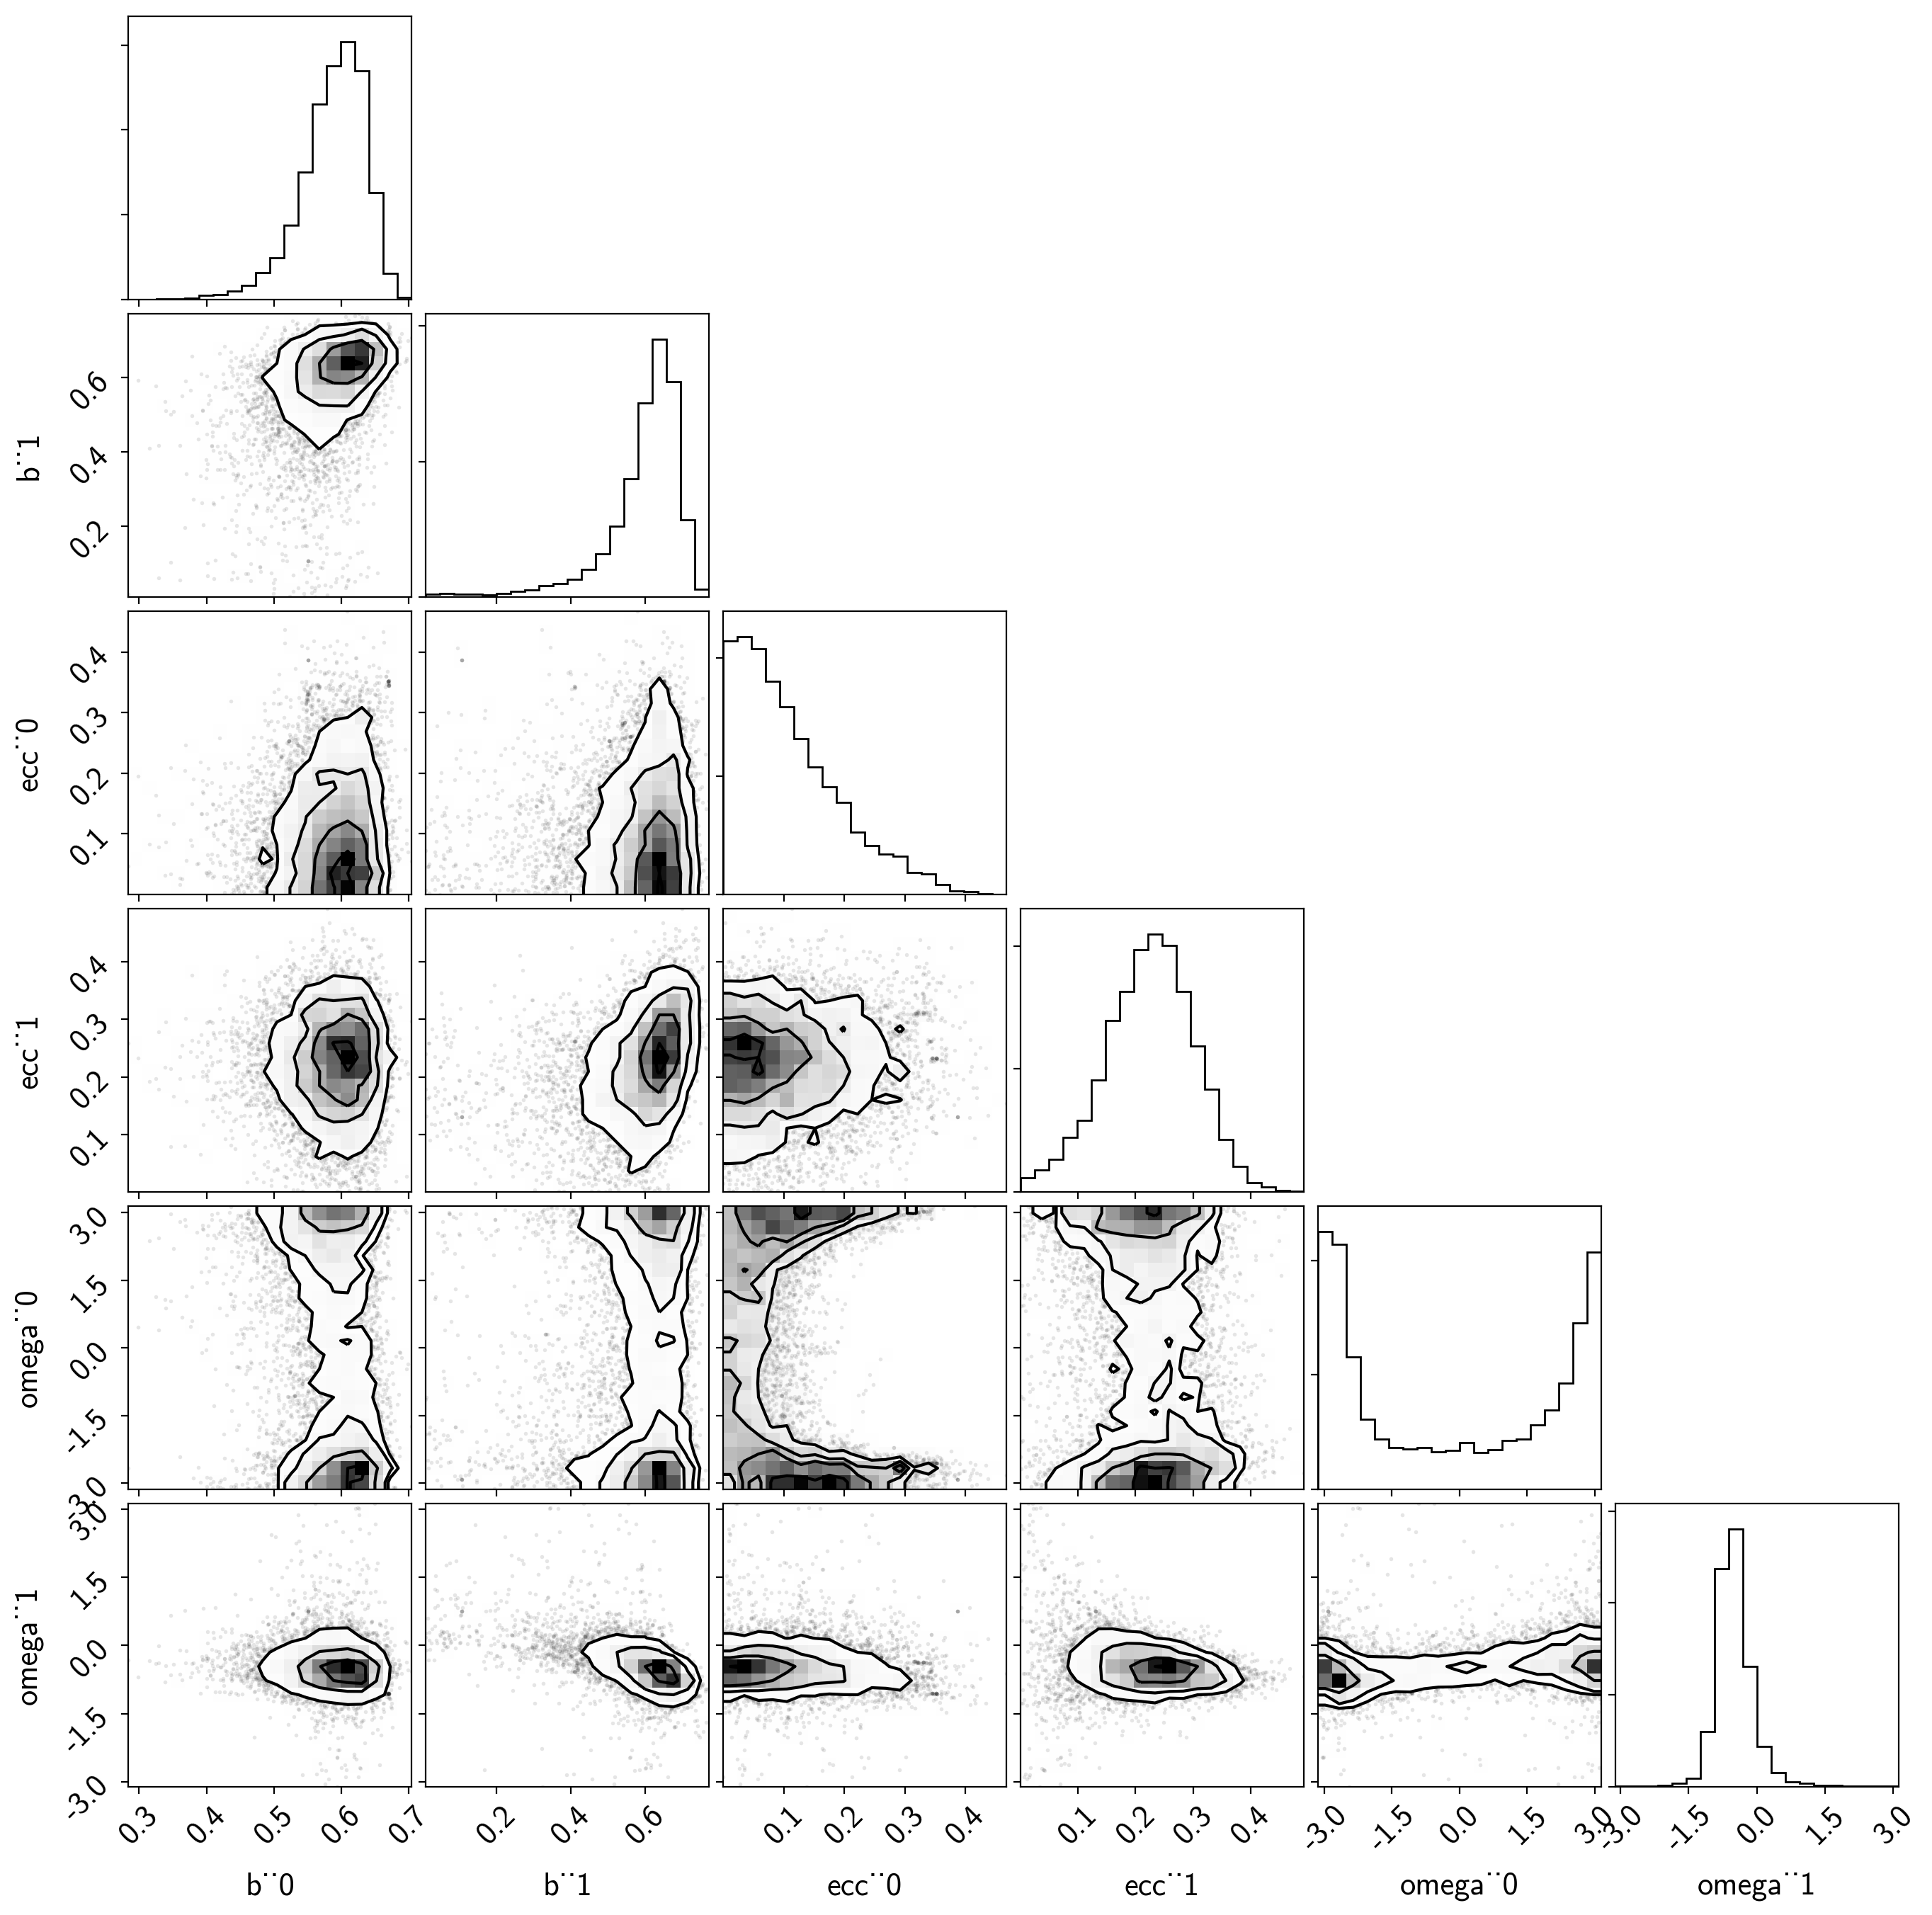

In [18]:
import corner
varnames = ["b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

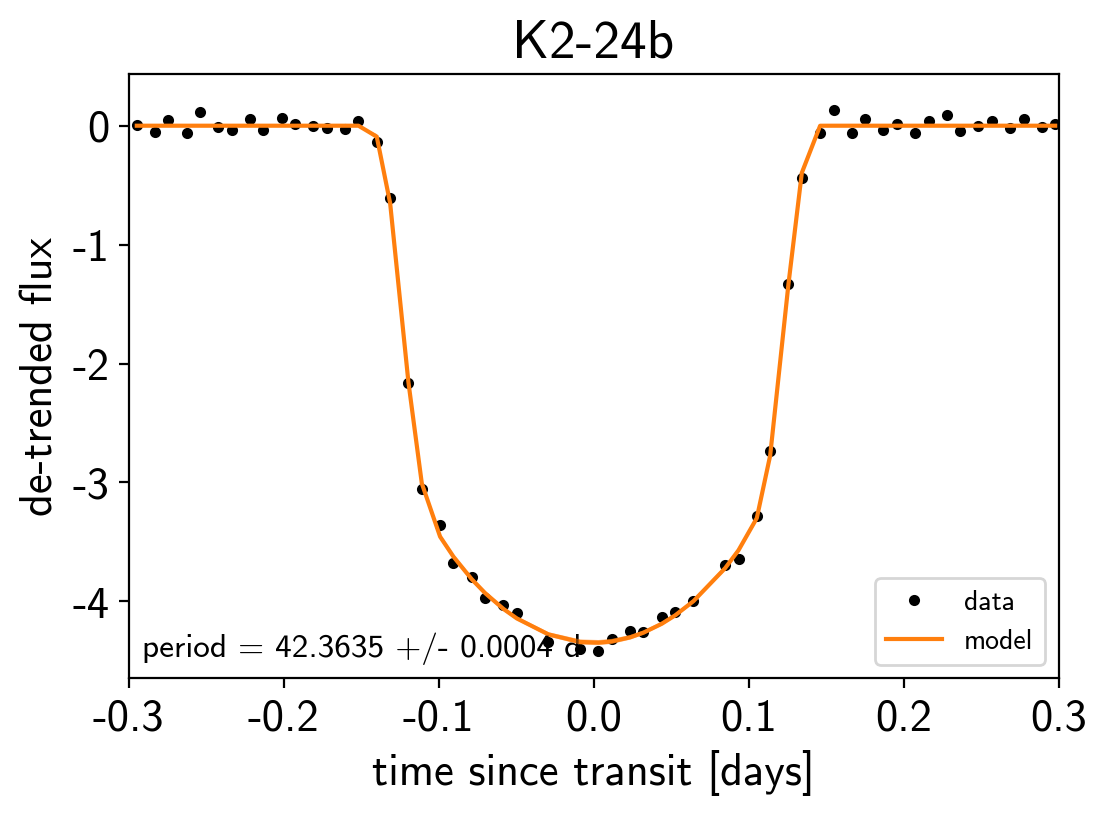

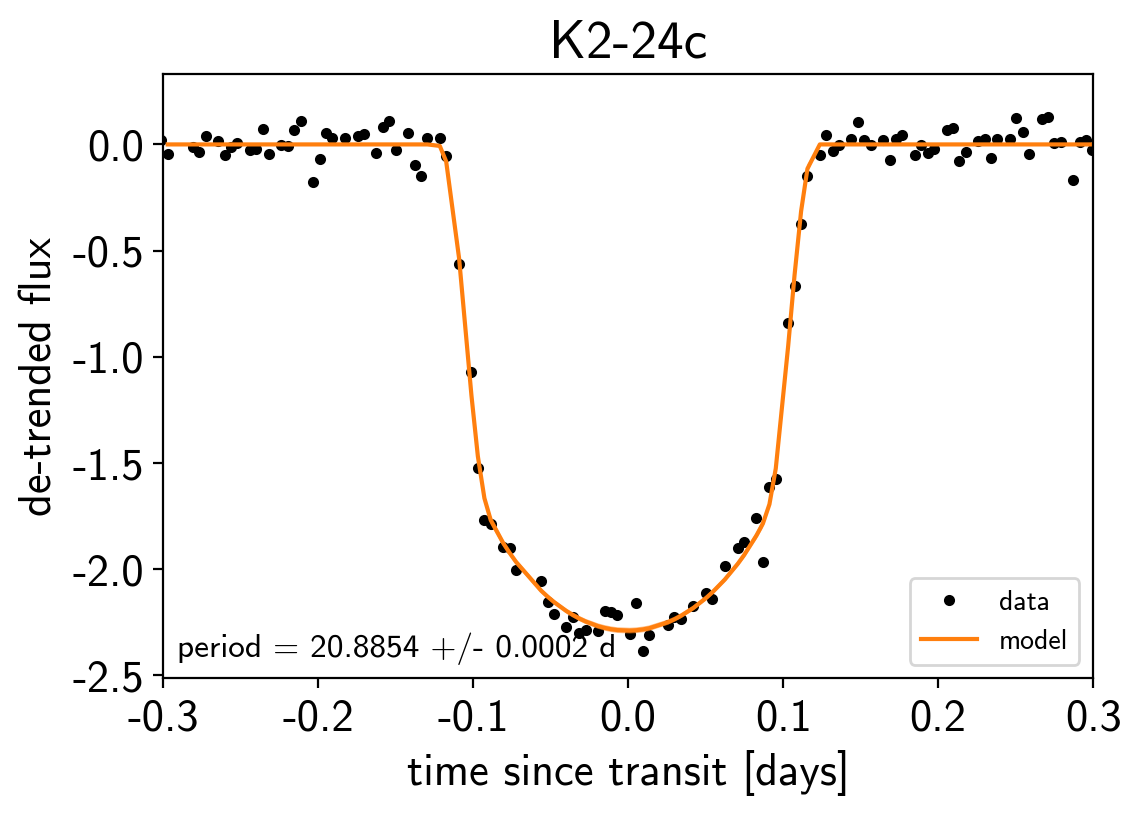

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

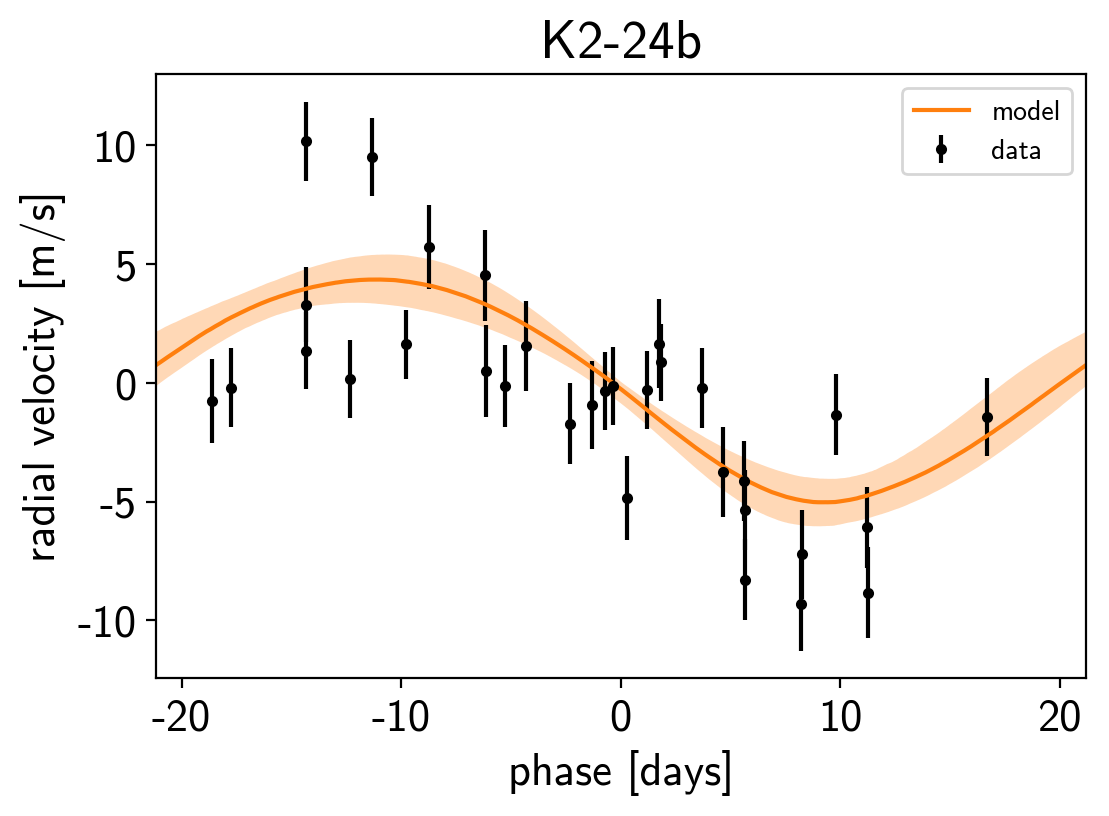

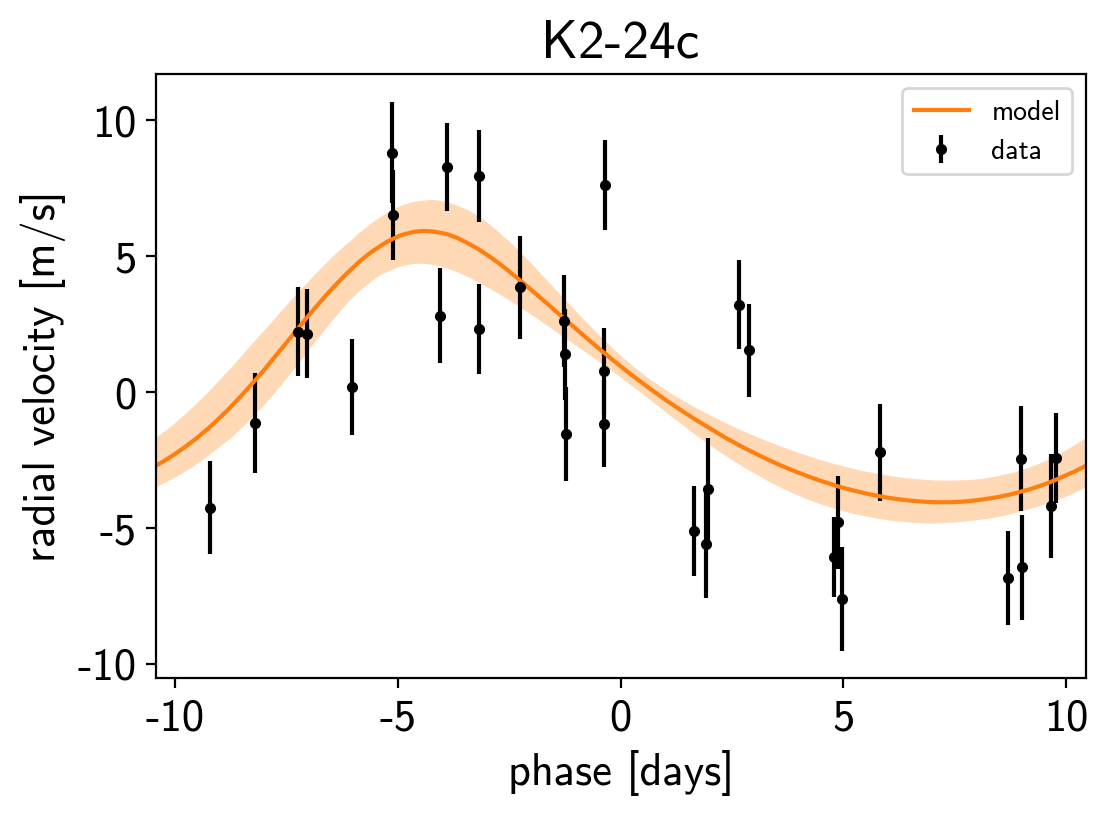

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

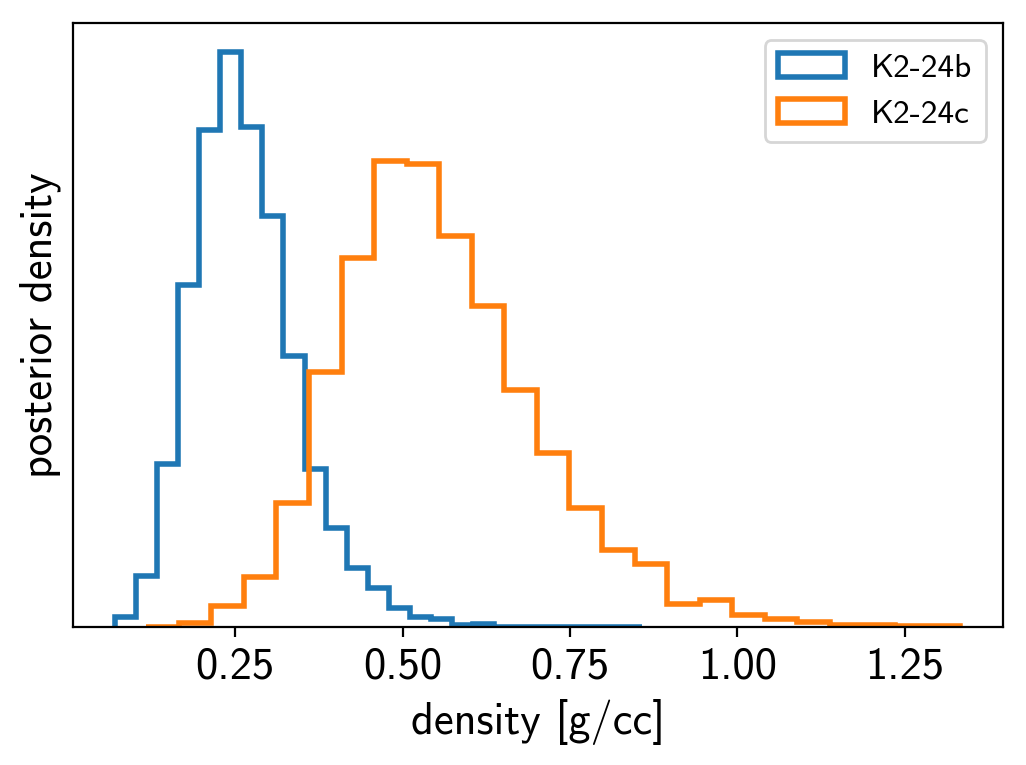

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], 25, histtype="step", lw=2,
             label="K2-24{0}".format(letter))
plt.yticks([])
plt.legend(fontsize=12)
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
    title={exoplanet v0.1.3},
   author={Foreman-Mackey, Daniel},
    month={dec},
     year={2018},
      doi={10.5281/zenodo.2536576},
      url={https://doi.org/10.5281/zenodo.2536576}
}

...
